# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

  Running setup.py bdist_wheel for JSAnimation ... done
  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



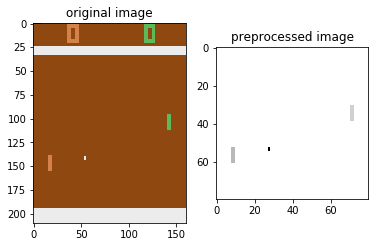

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [49]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# def get_cov_outdim(in_size,k_size,stride,padding=0):
#         return (in_size-k_size+2*padding)//stride +1
# def get_cov_outdim(in_size,k_size,stride,padding=0):
#         out = (in_size-k_size+2*padding)//stride +1
#         print(out)
#         return out

#set up a convolution neural network
# the output is the probability of moving right
class Policy(nn.Module):
    
    def __init__(self):
        super().__init__()
        ## input_size of the image is (80x80)
        self.conv1 = nn.Conv2d(2,4,kernel_size=6,stride=3, bias=False)
        out_dim = self.get_cov_outdim(80,6,3)
        self.conv2 = nn.Conv2d(4,16,kernel_size=6,stride=4)
        out_dim = self.get_cov_outdim(out_dim,6,4)
#         self.conv3 = nn.Conv2d(64,128,kernel_size=4,stride=4)
#         out_dim  = self.get_cov_outdim(out_dim,4,4)
        self.size  = out_dim*out_dim*16
        
        ## 1 fully connected layer
        self.fc1 = nn.Linear(self.size,500)
        self.fc2 = nn.Linear(500,1)
        self.sig = nn.Sigmoid()
        
    def forward(self,x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.fc1(x.view(-1,self.size)))
        x = self.sig(self.fc2(x))
        return x
    
    def get_cov_outdim(self,in_size,k_sizes,stride,padding=0):
        out = (in_size-k_sizes+(2*padding))//stride +1
        print(out)
        return out
    
    
policy = Policy().to(device)
# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr = 2e-4)

cuda:0
25
5


# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


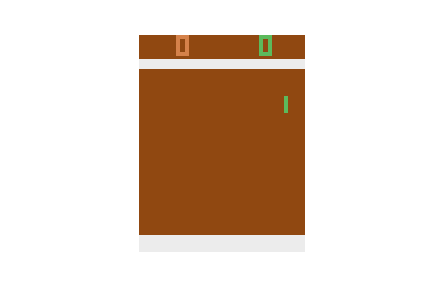
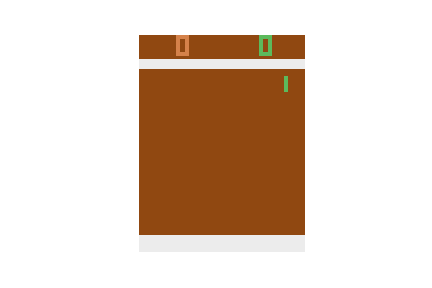
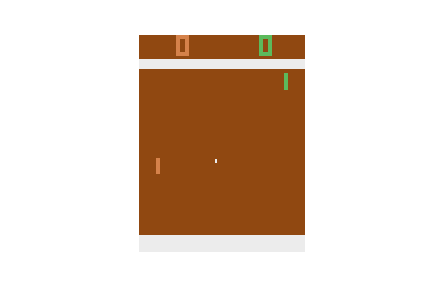
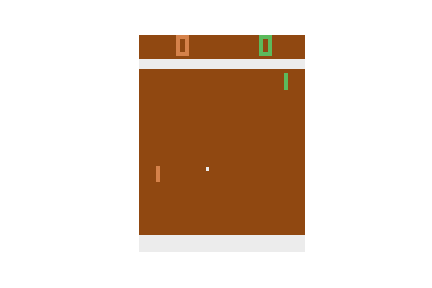
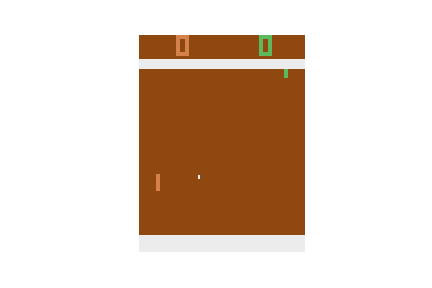
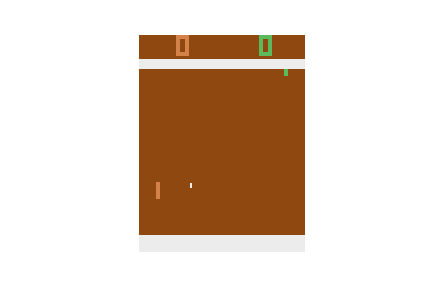
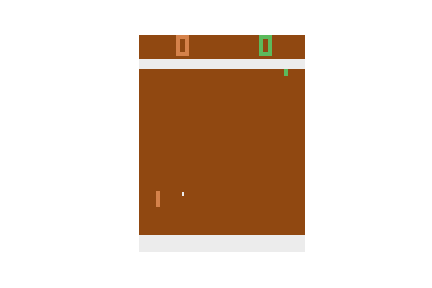
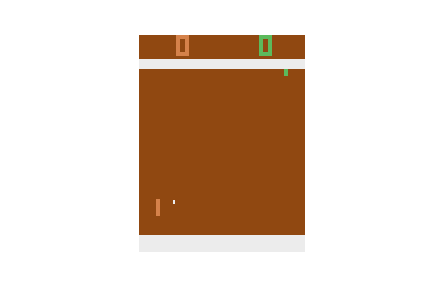
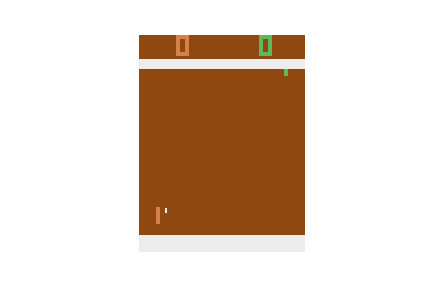
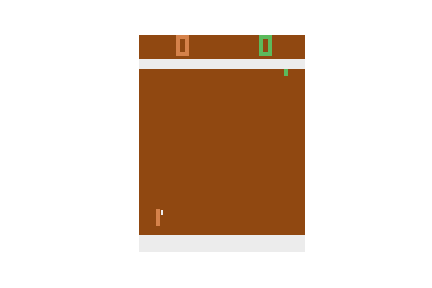
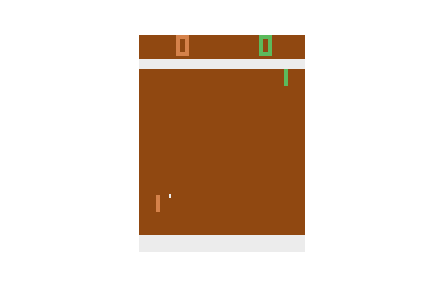
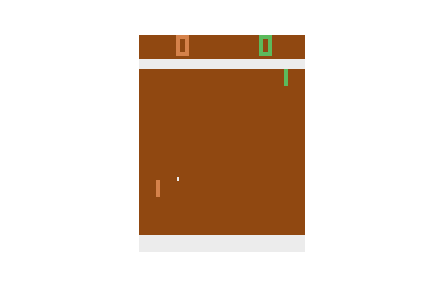
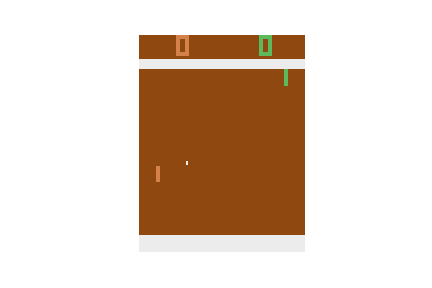
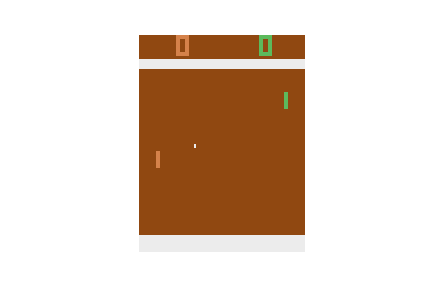
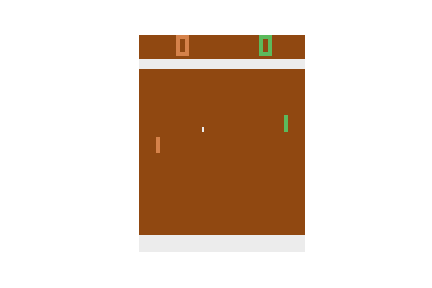
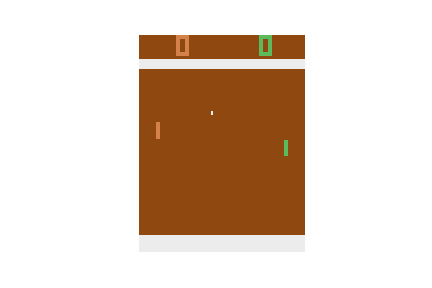
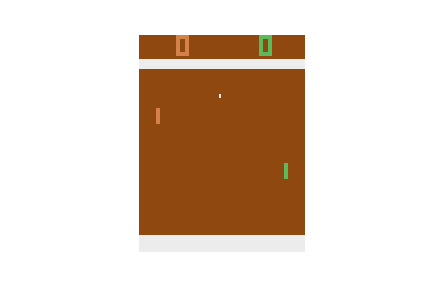
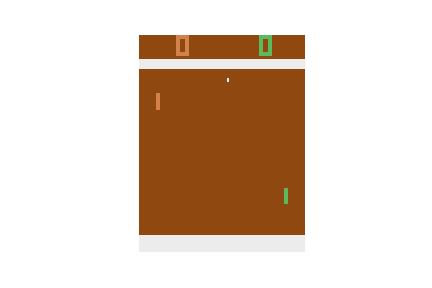
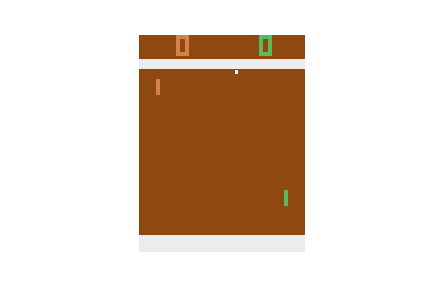
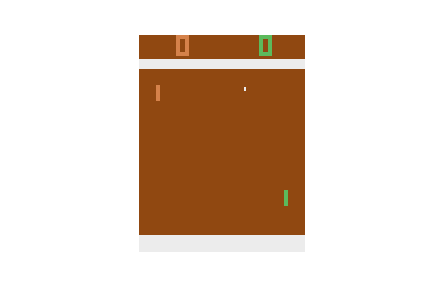
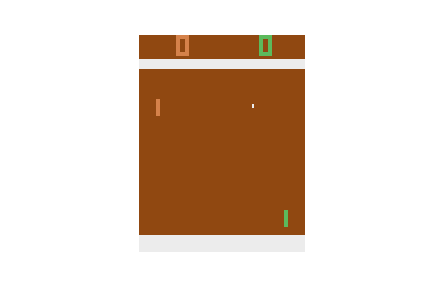
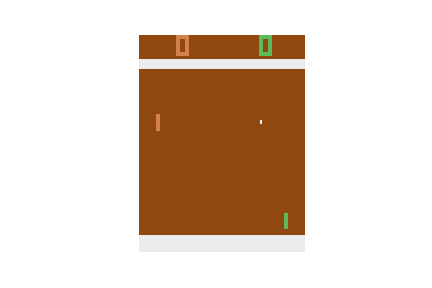
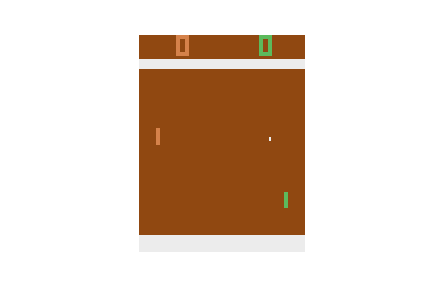
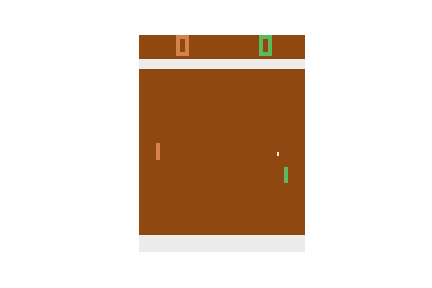
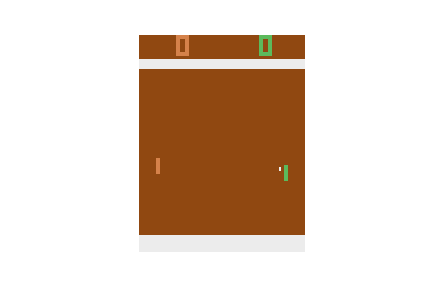
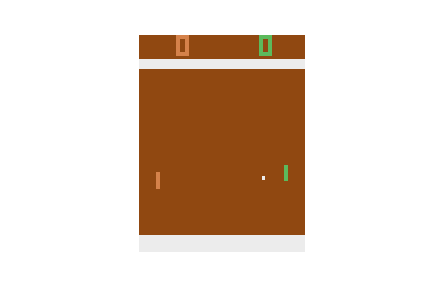
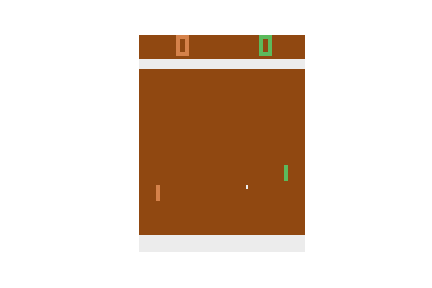
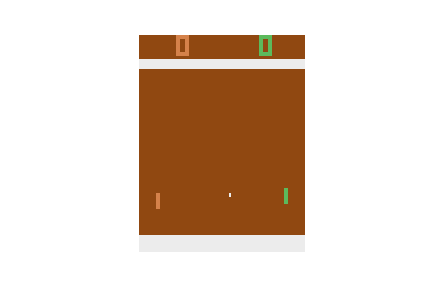
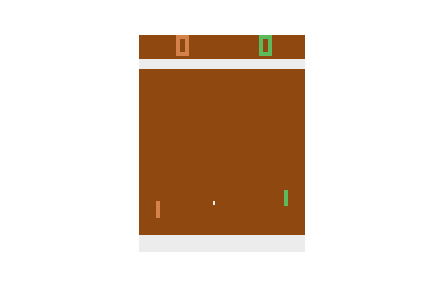
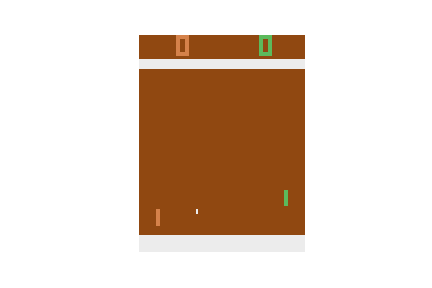
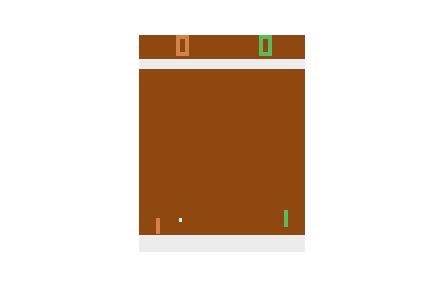
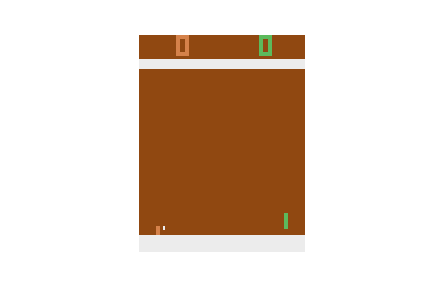
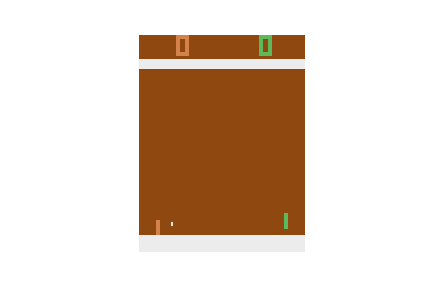
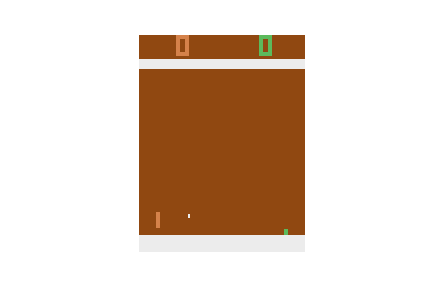
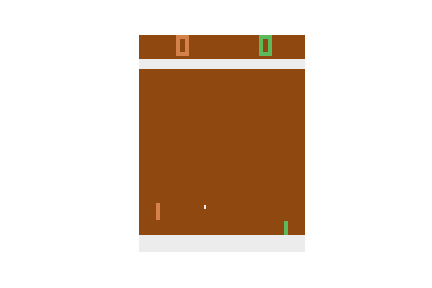
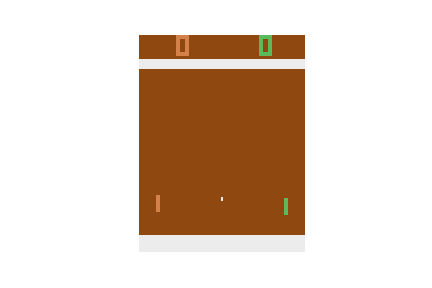
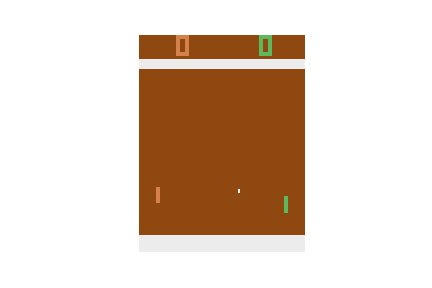
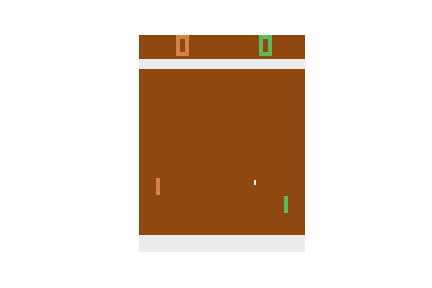
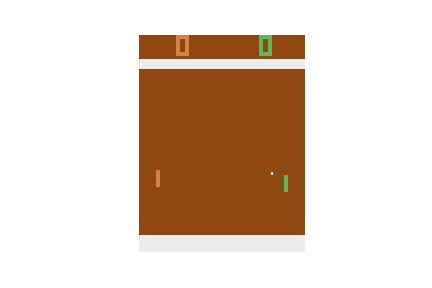
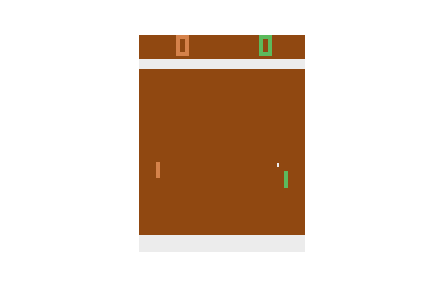
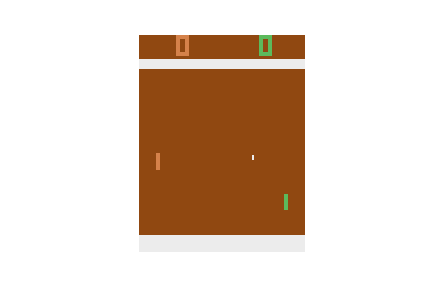
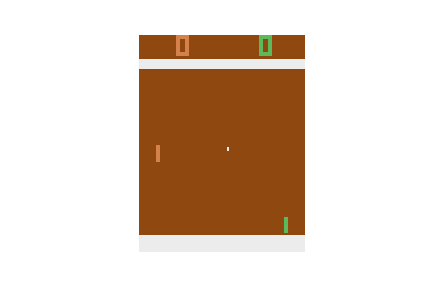
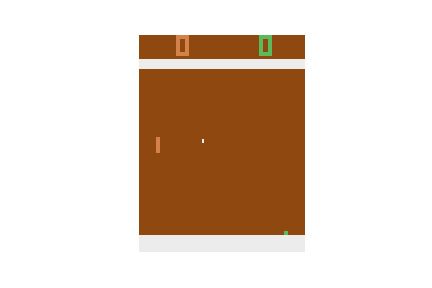
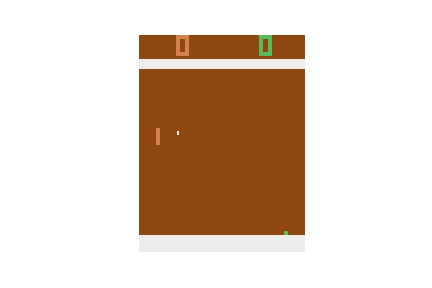
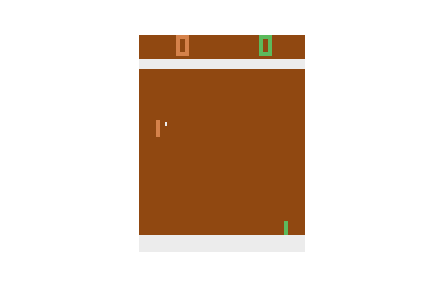
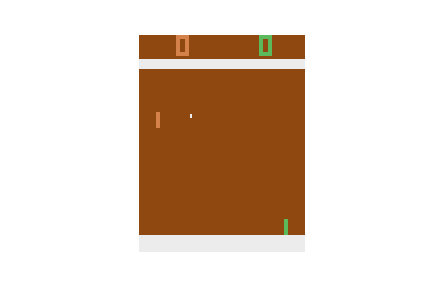
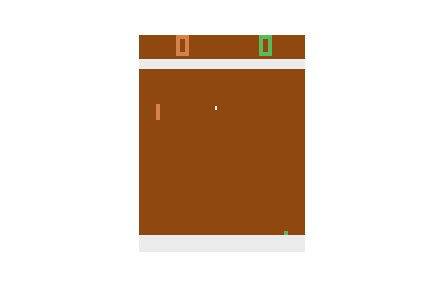
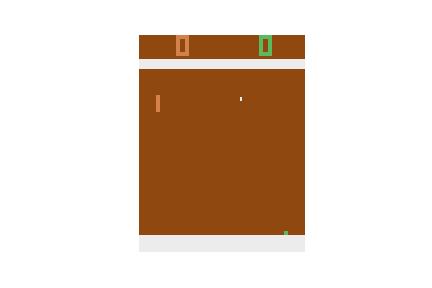
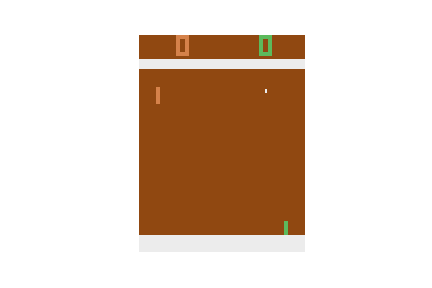
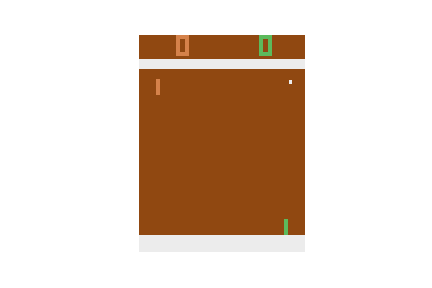
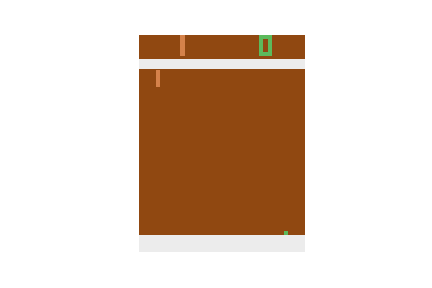
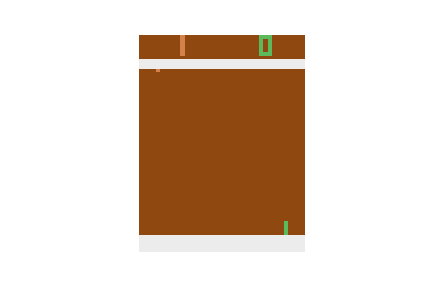
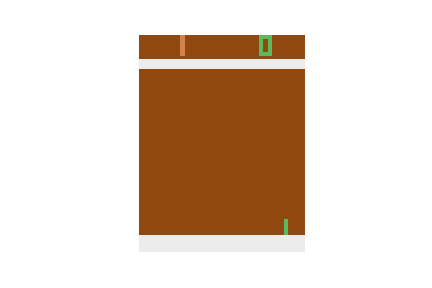
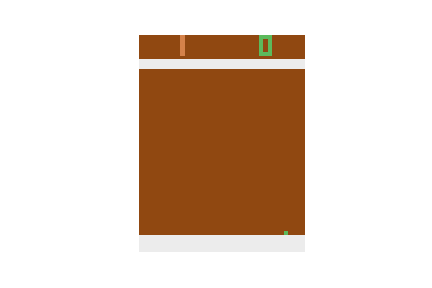
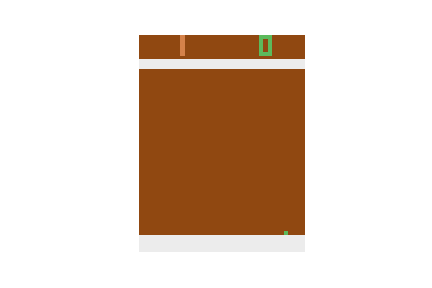
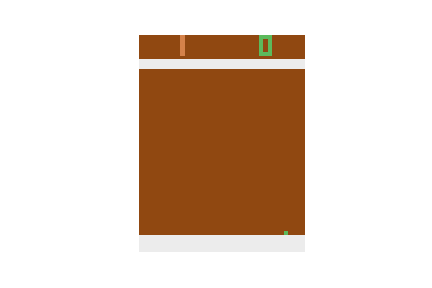
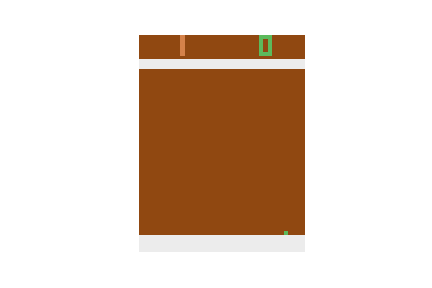
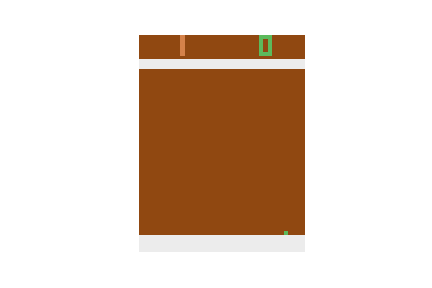
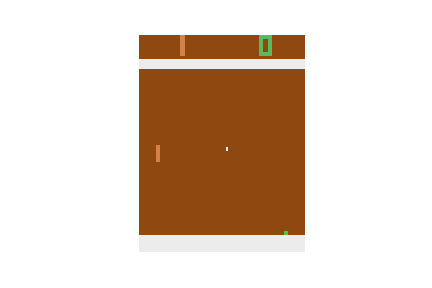
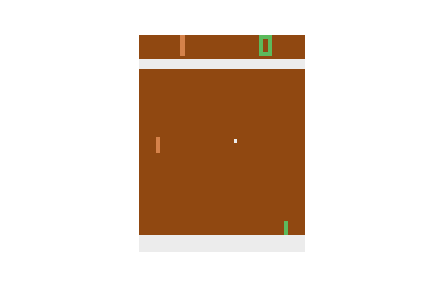
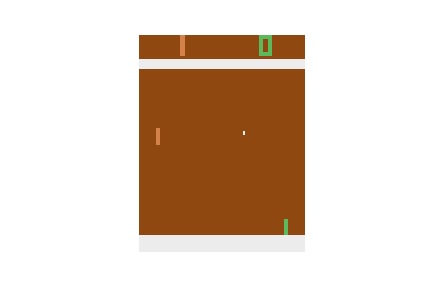
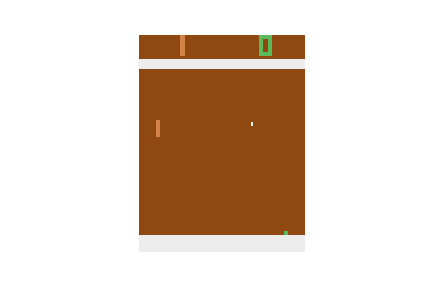
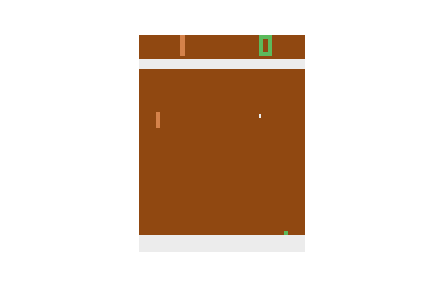
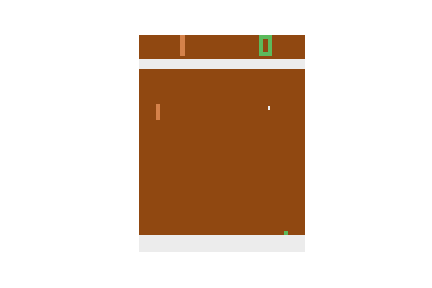
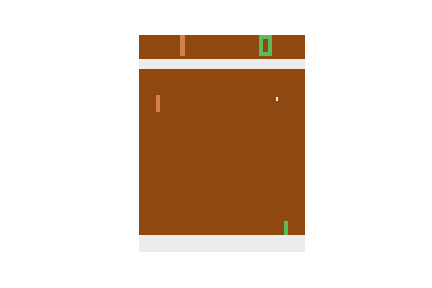
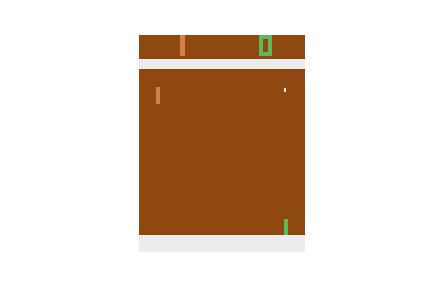
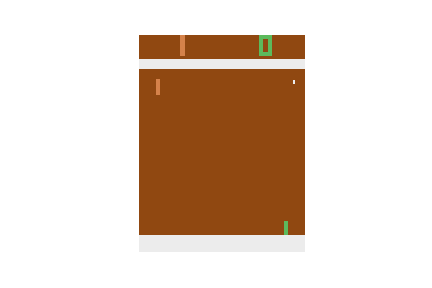
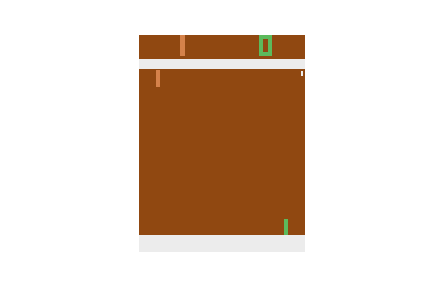
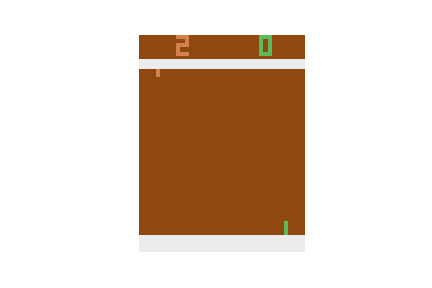
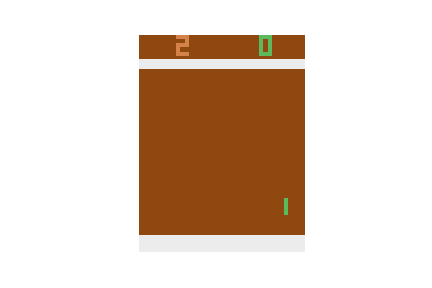
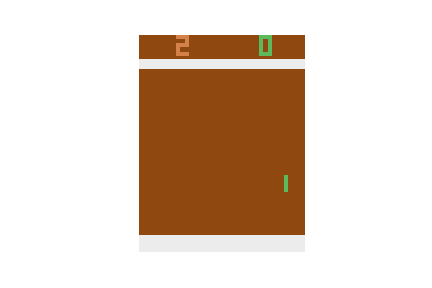
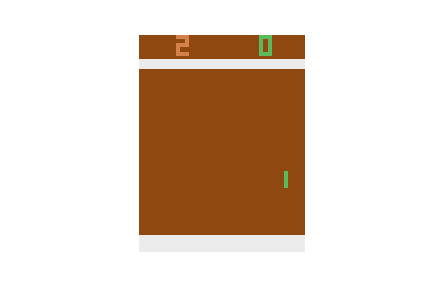
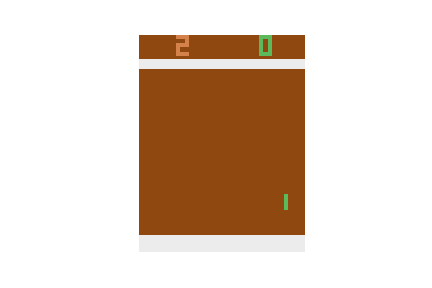
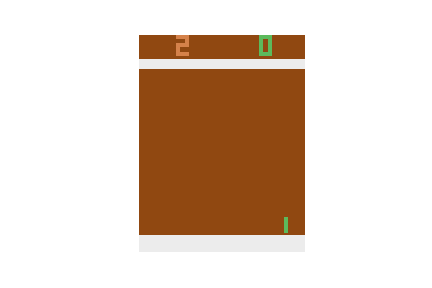
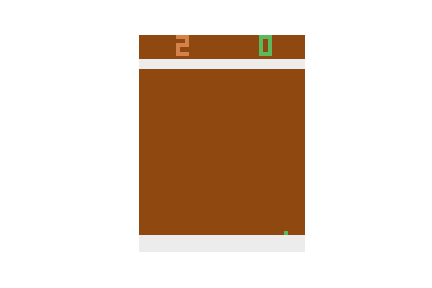
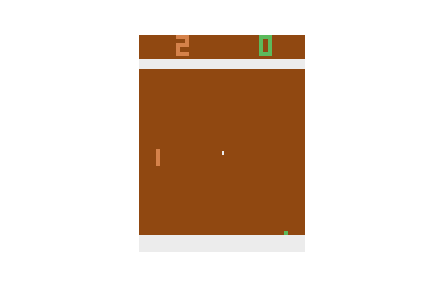
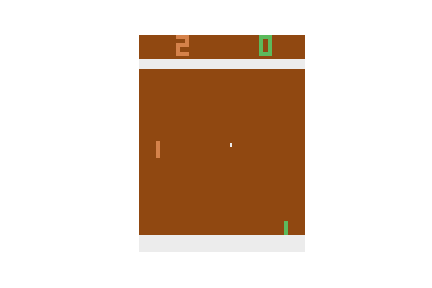
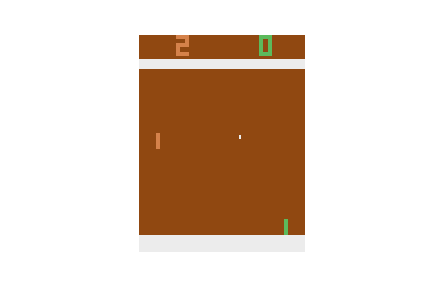
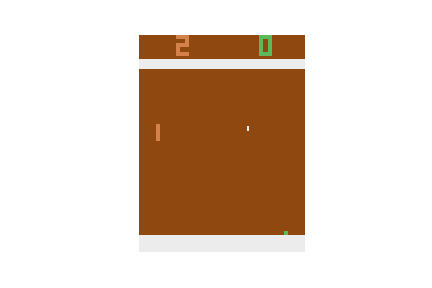
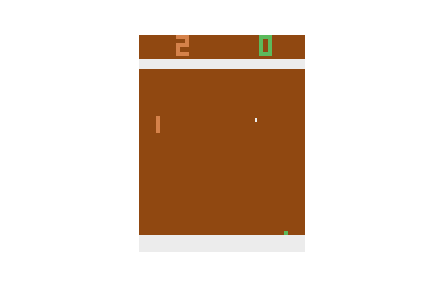
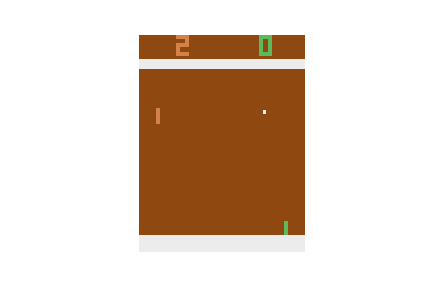
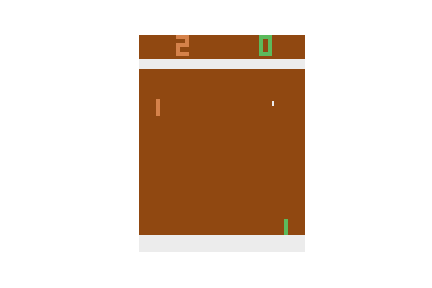
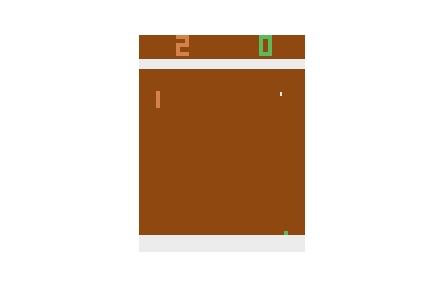
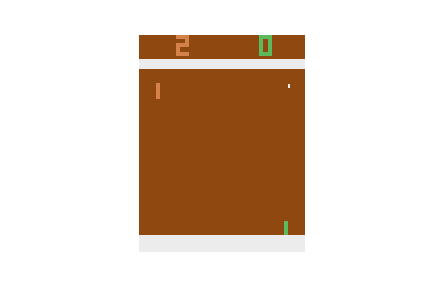
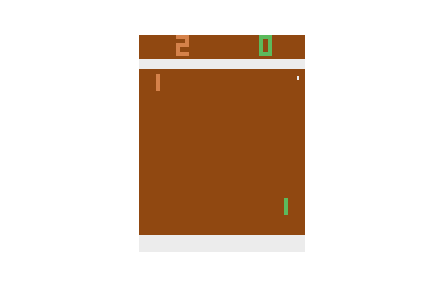
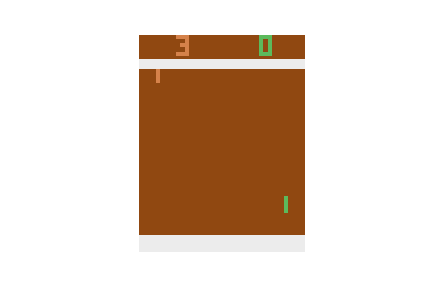
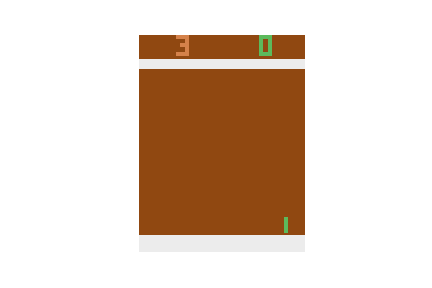
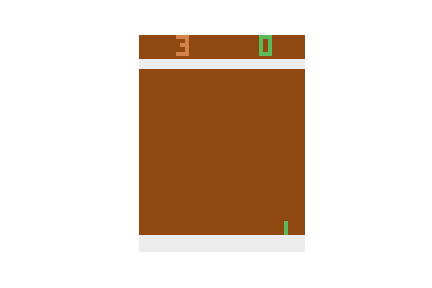
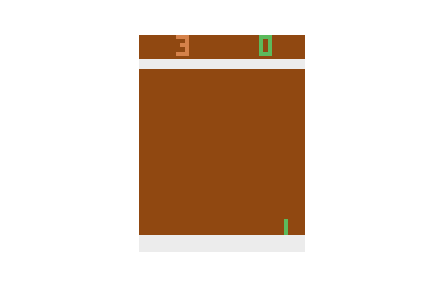
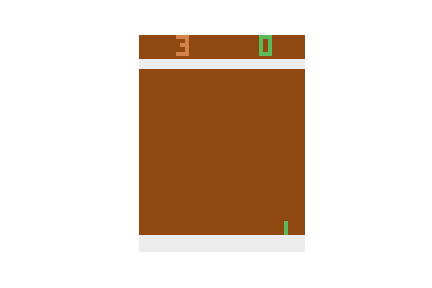
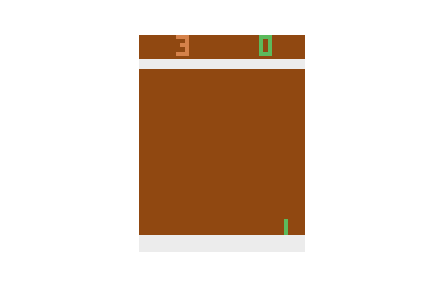
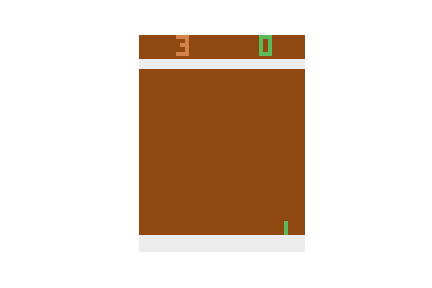
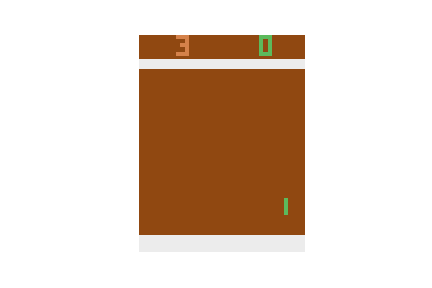
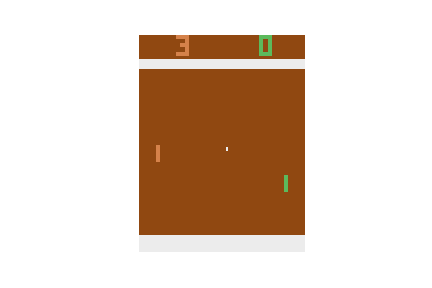
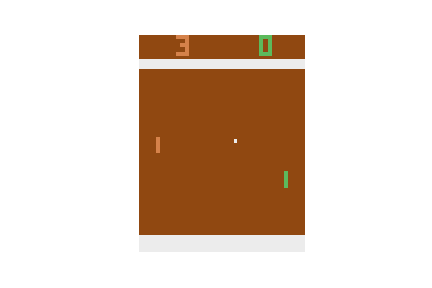
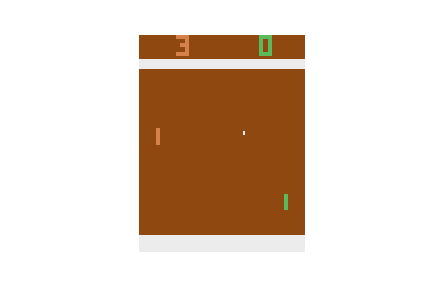
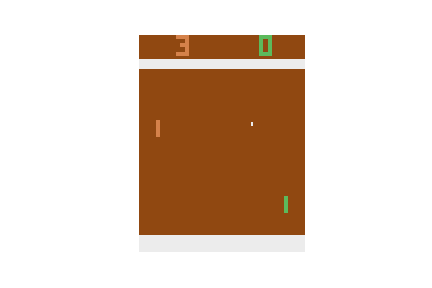
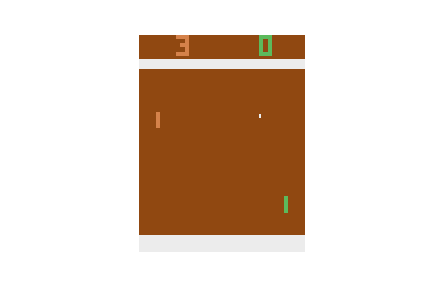
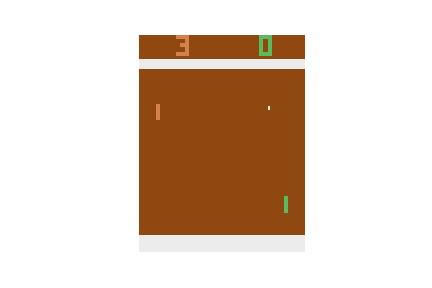
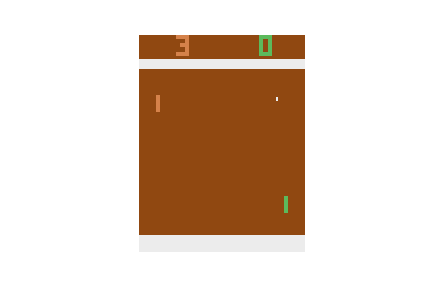
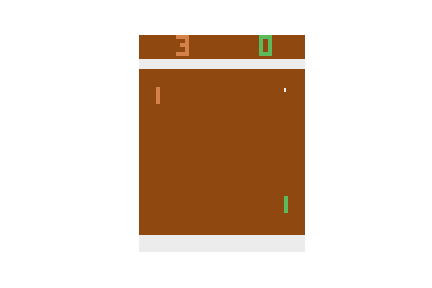
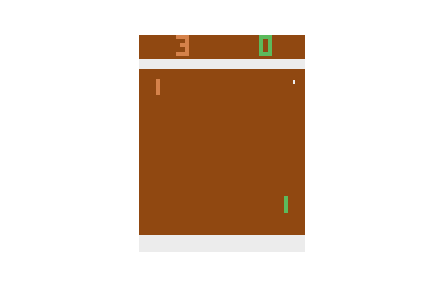
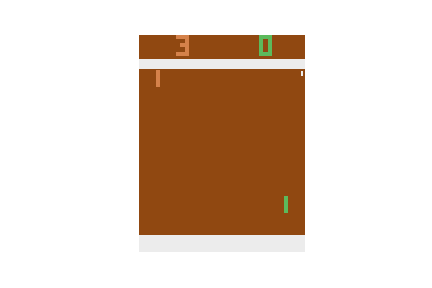
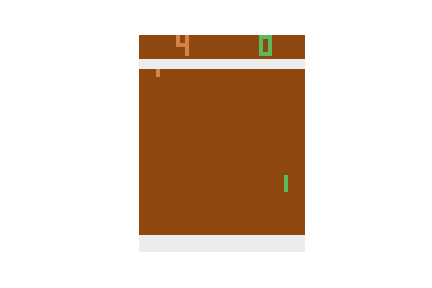
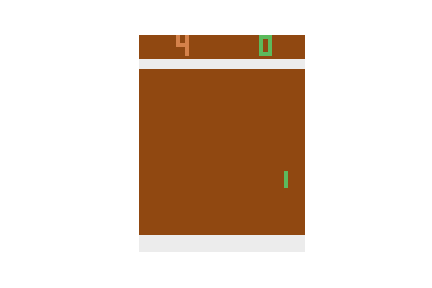
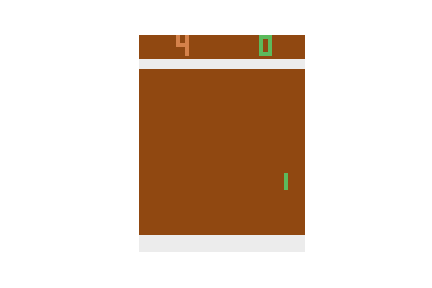
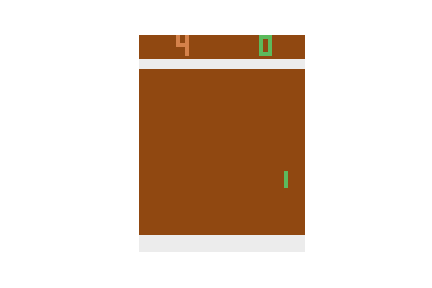
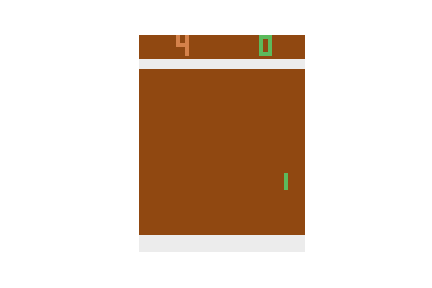
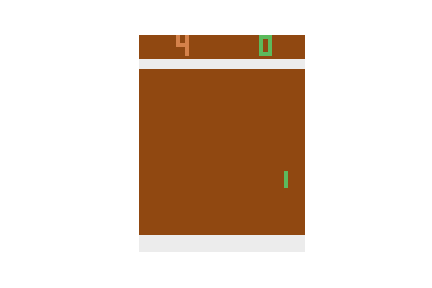
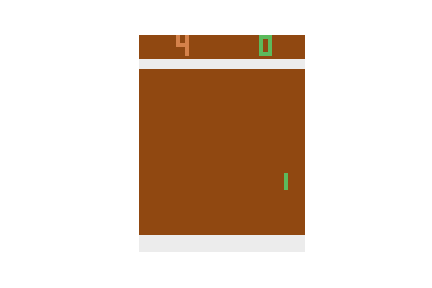
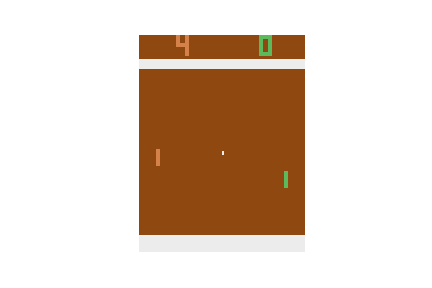
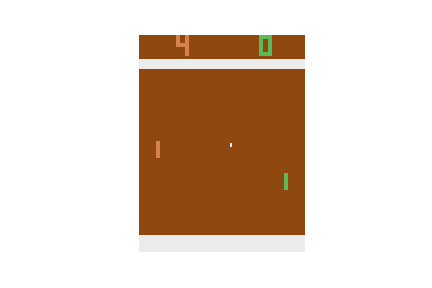
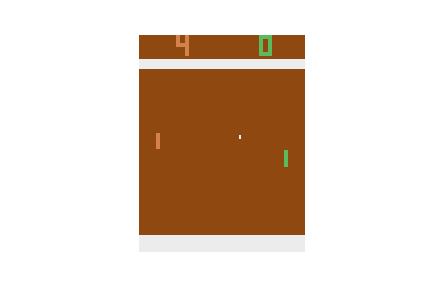
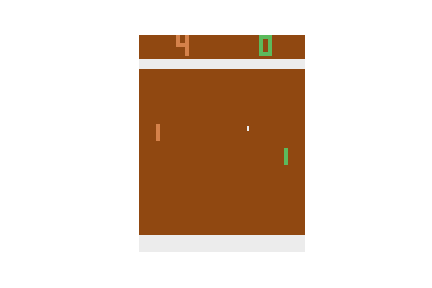
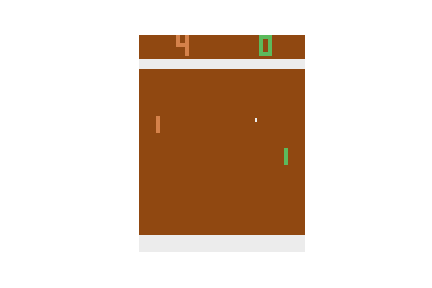
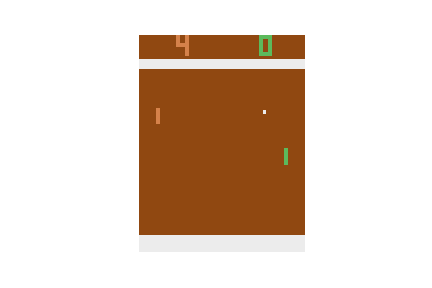
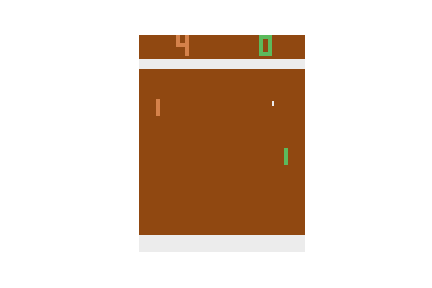
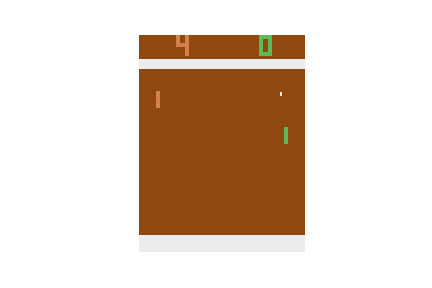
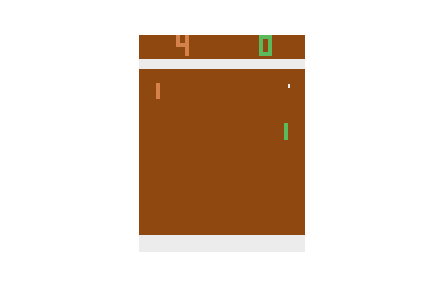
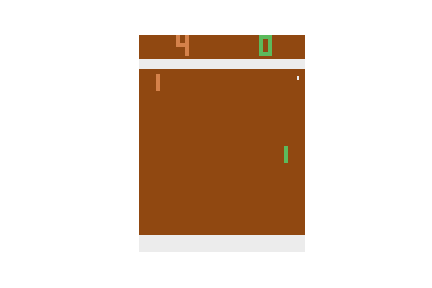
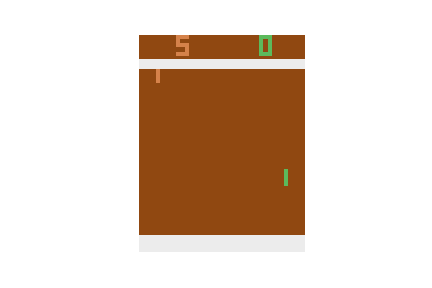
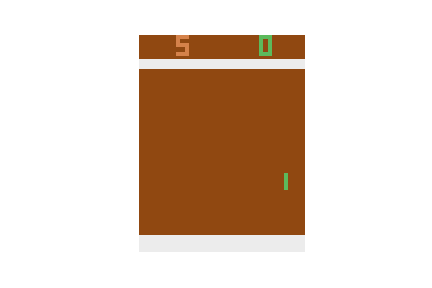
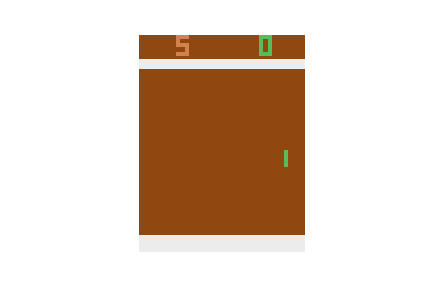
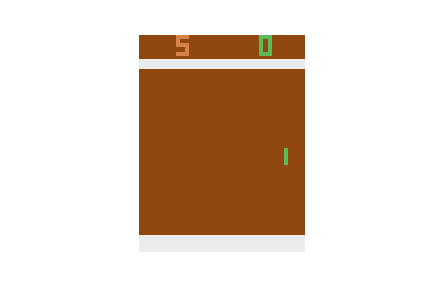
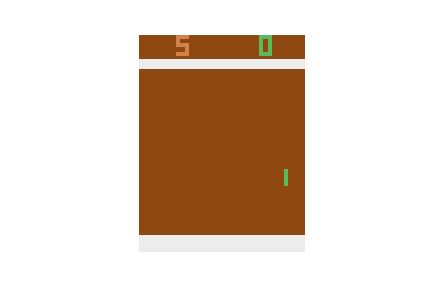
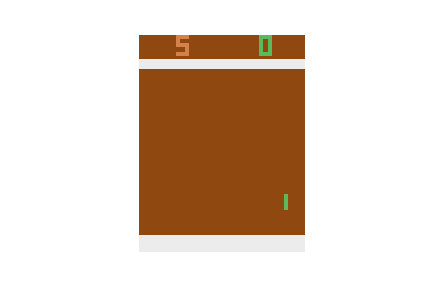
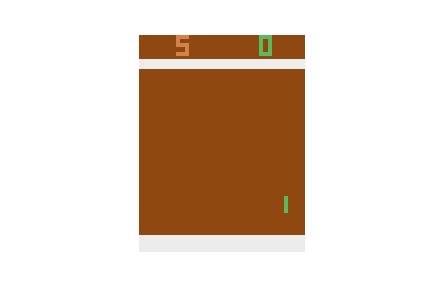
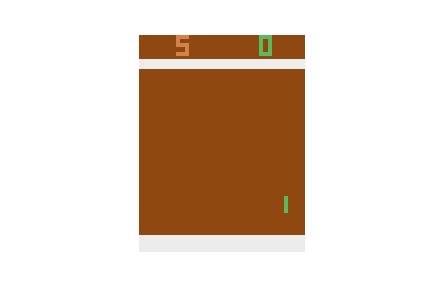
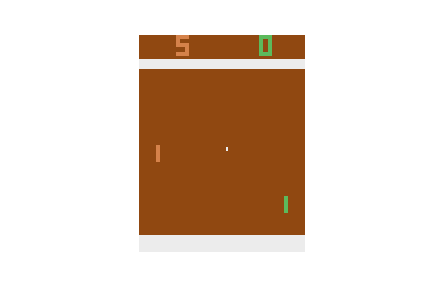
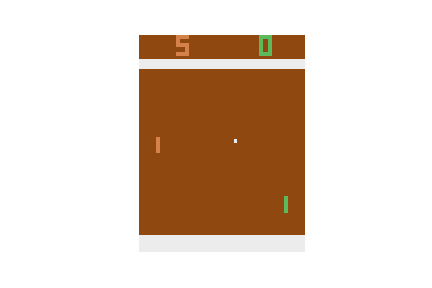
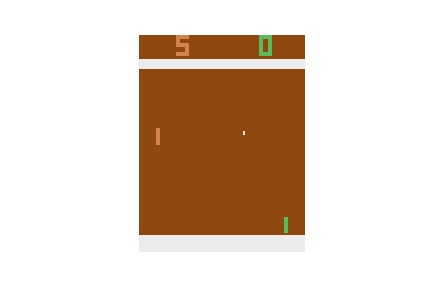
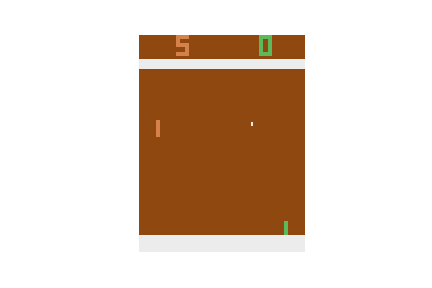
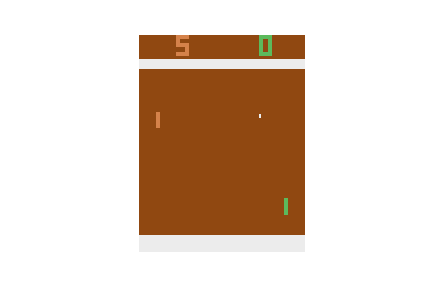
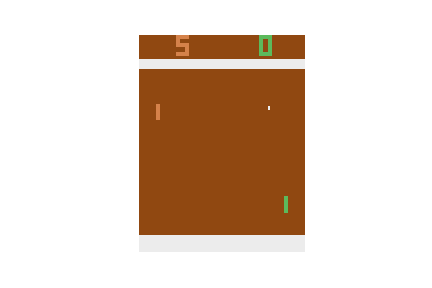
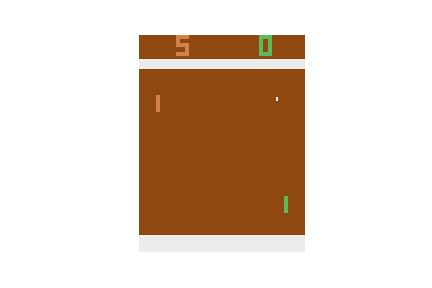
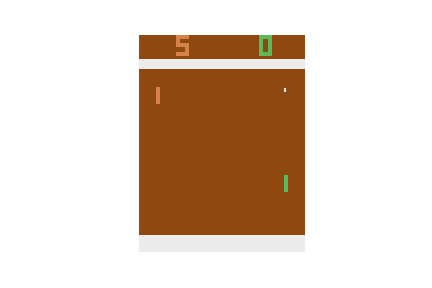
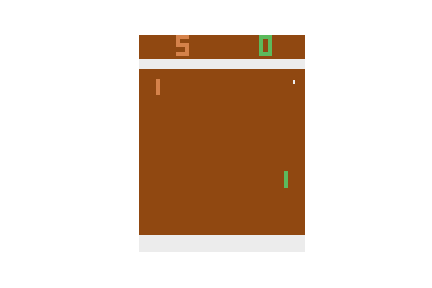
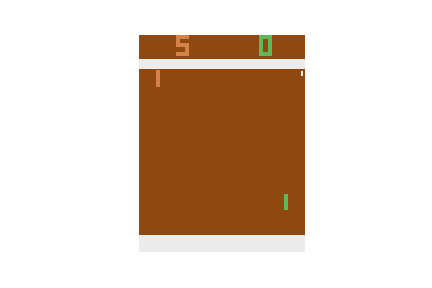
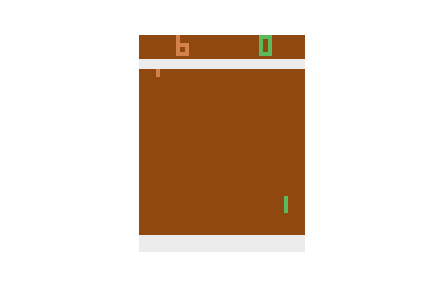
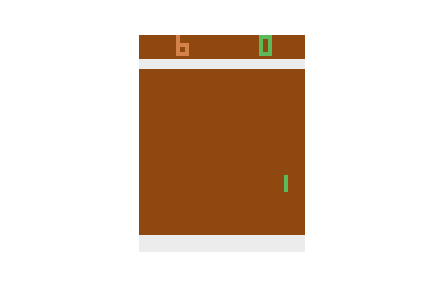
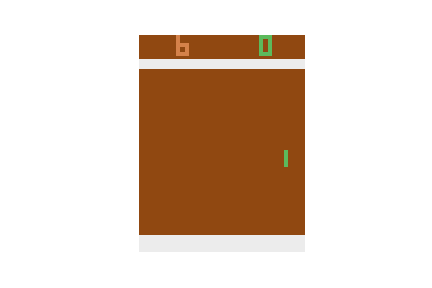
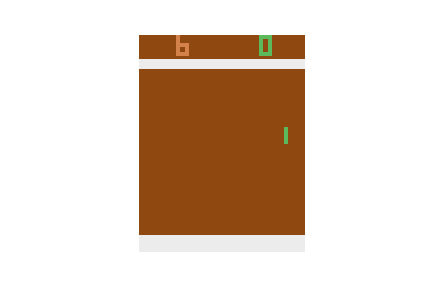
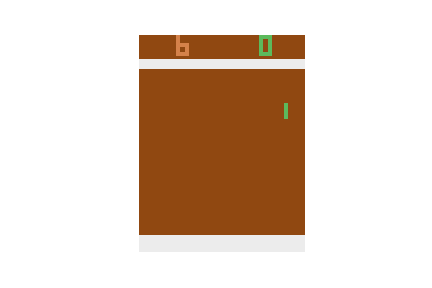
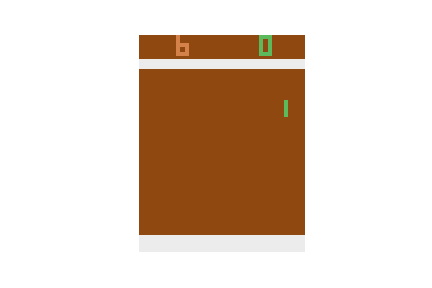
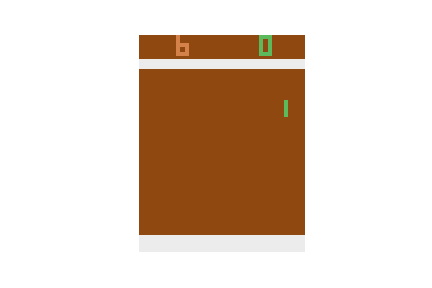
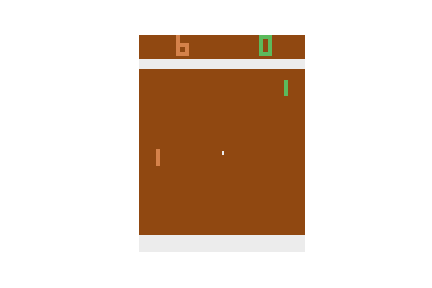
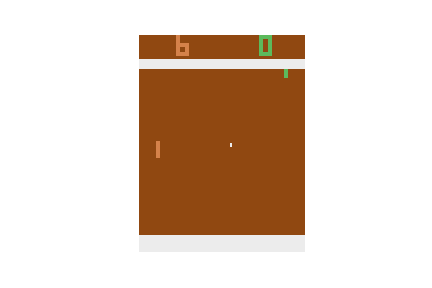
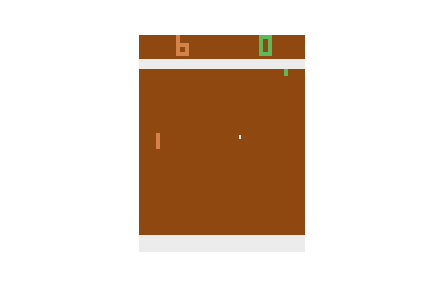
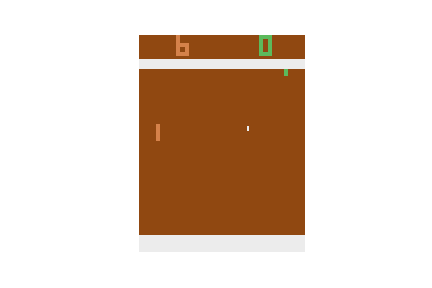
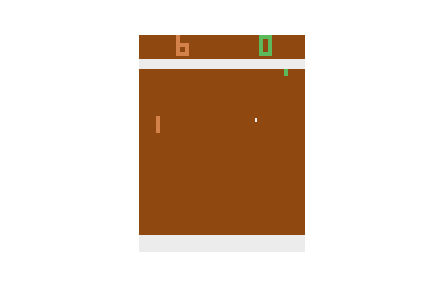
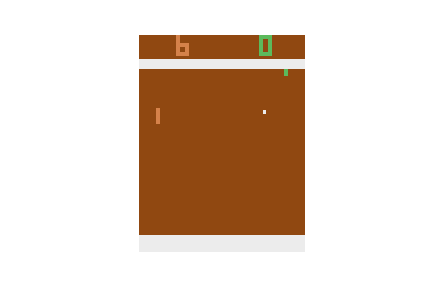
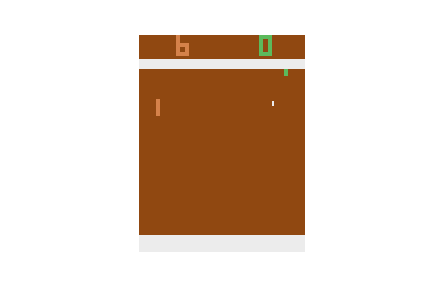
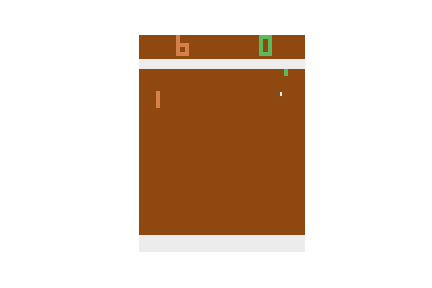
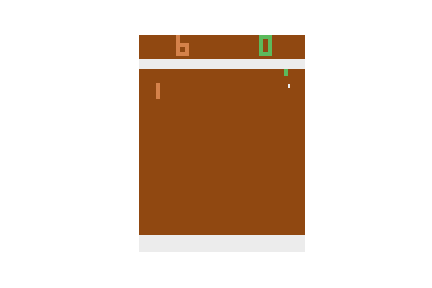
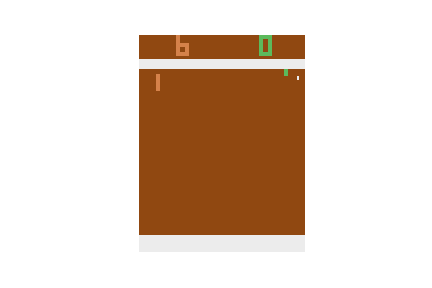
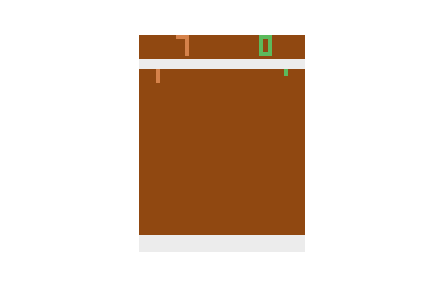
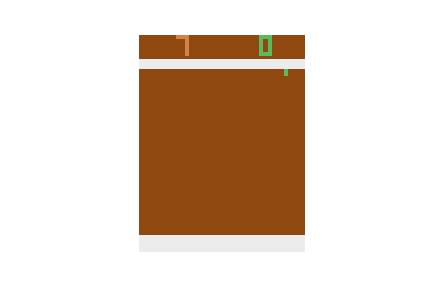
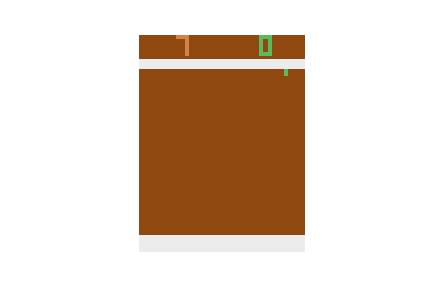
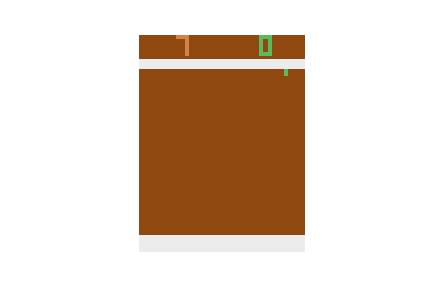
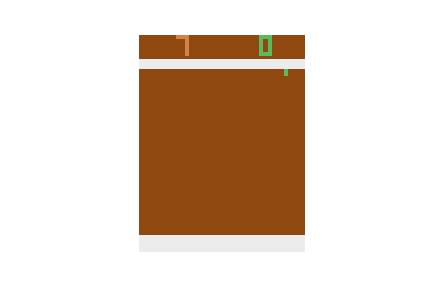
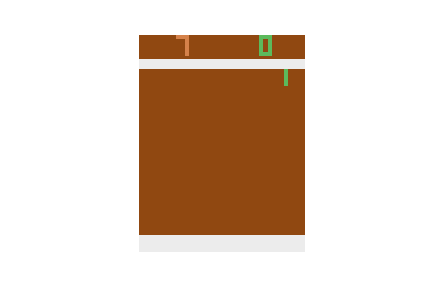
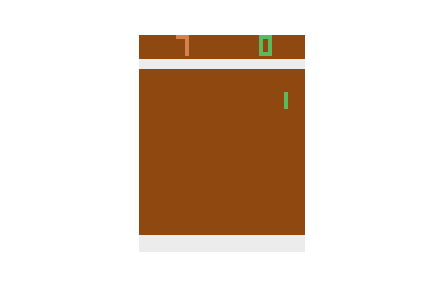
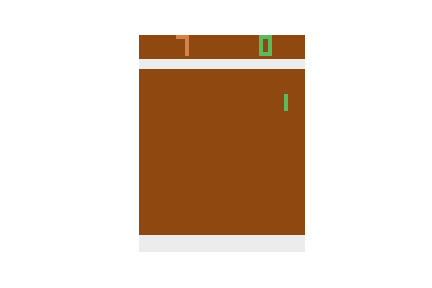
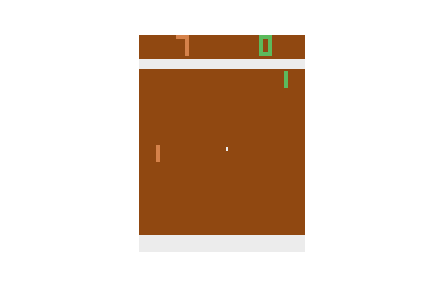
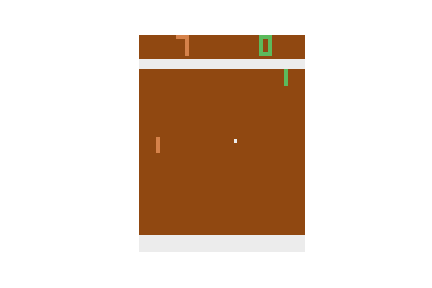
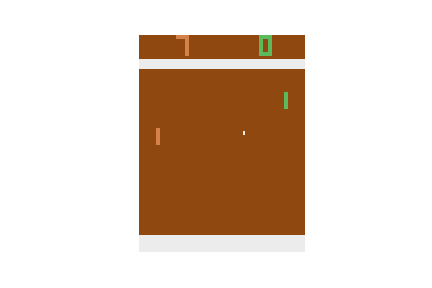
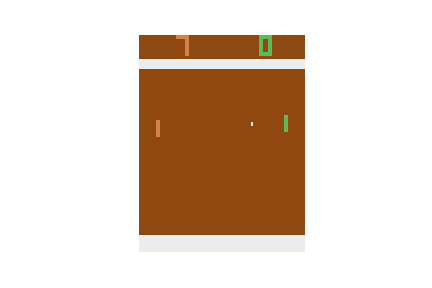
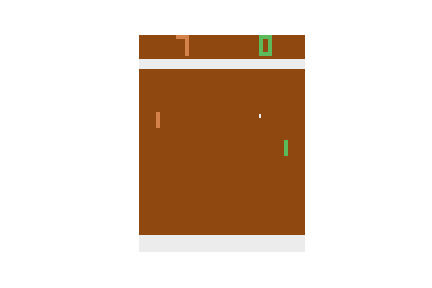
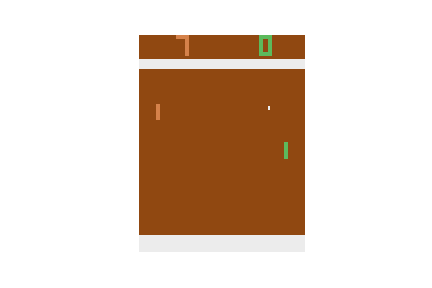
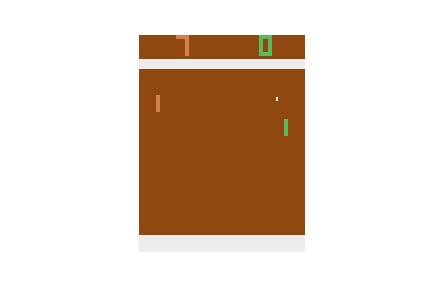
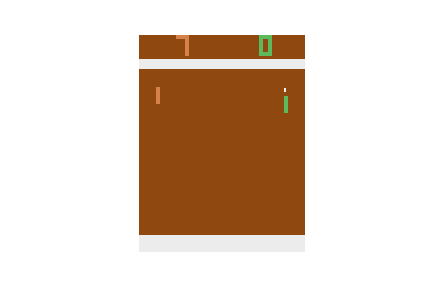
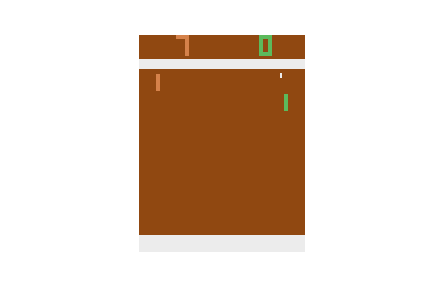
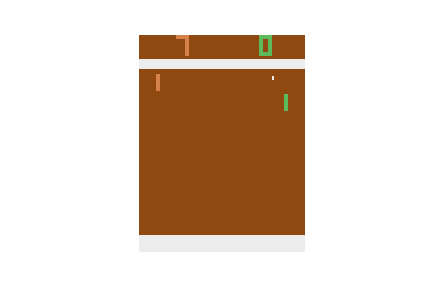
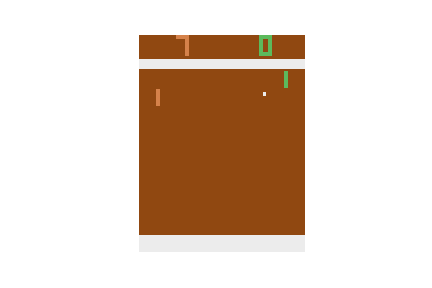
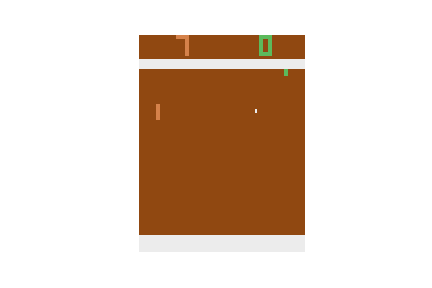
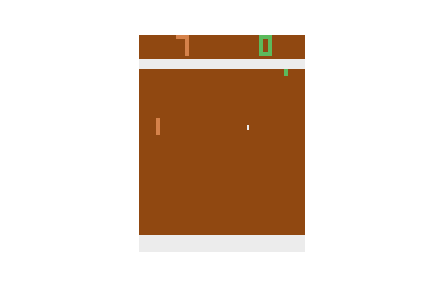
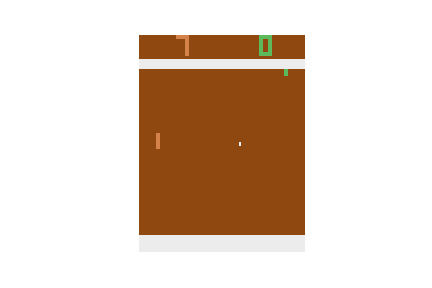
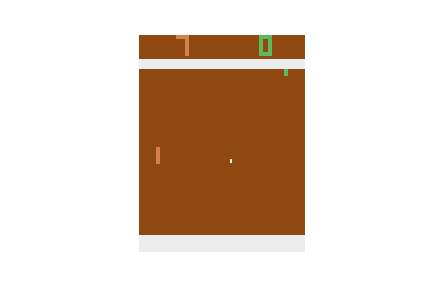
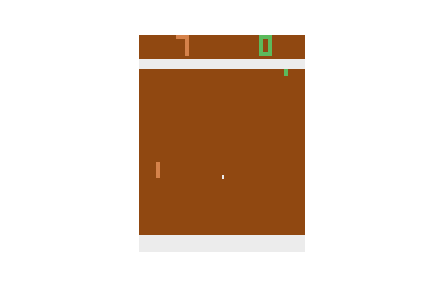
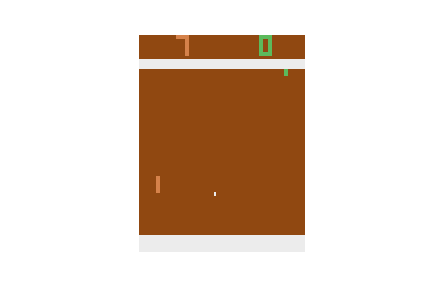
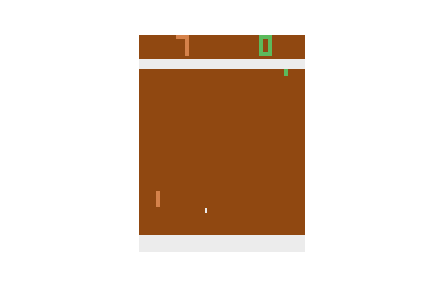
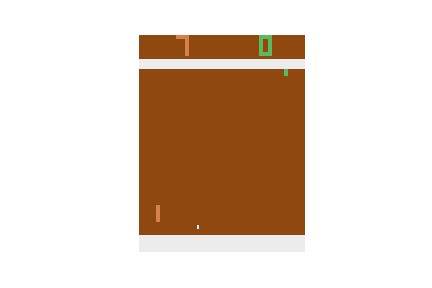
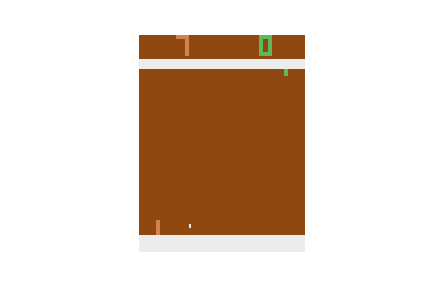
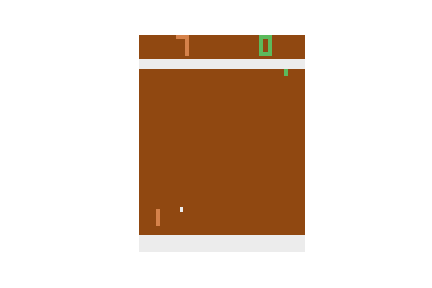
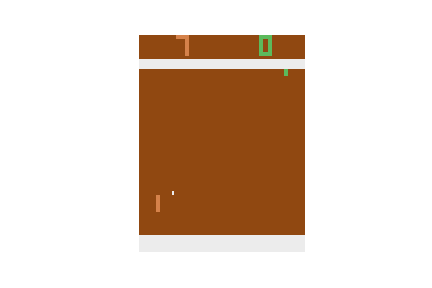
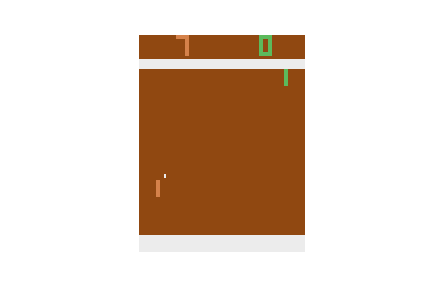
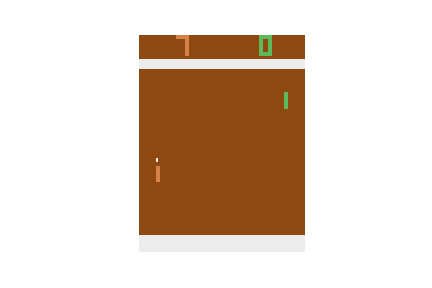
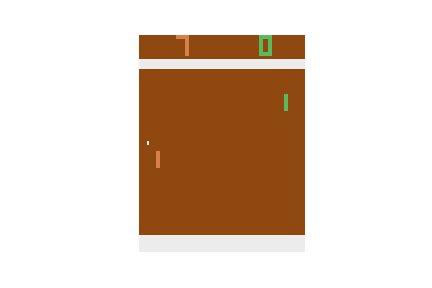
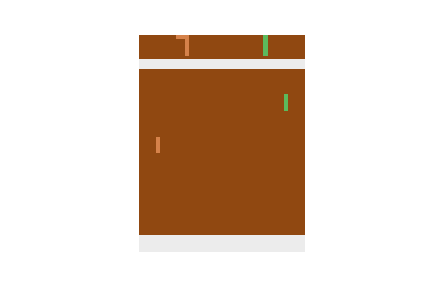
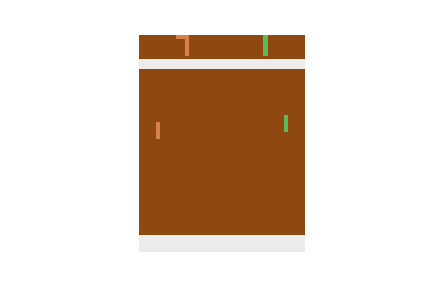
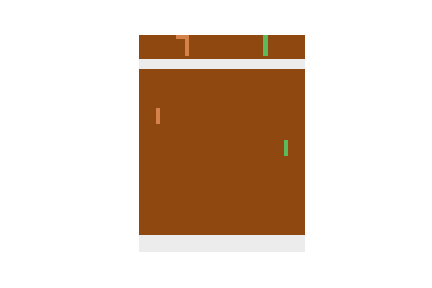
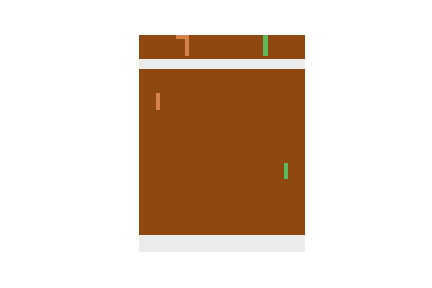
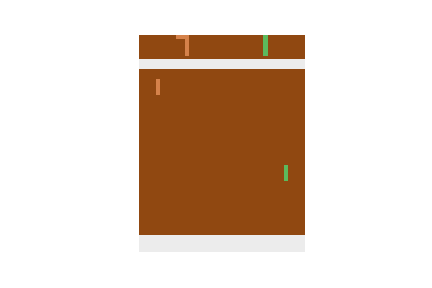
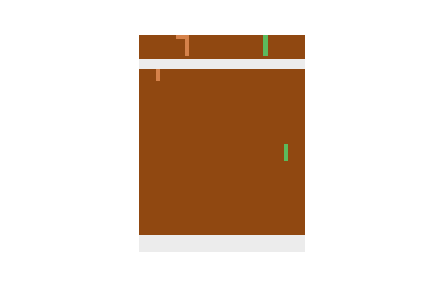
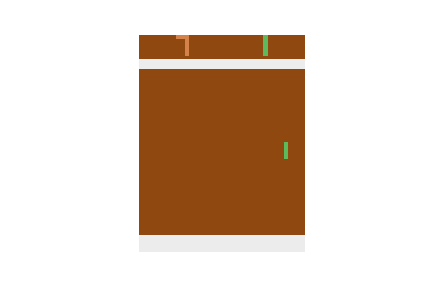
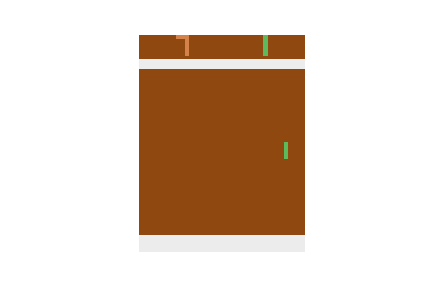
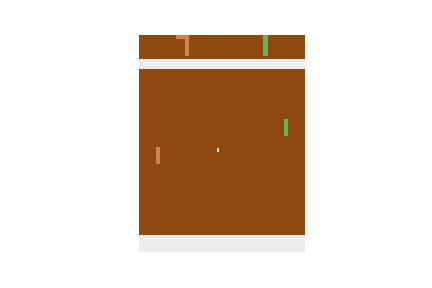
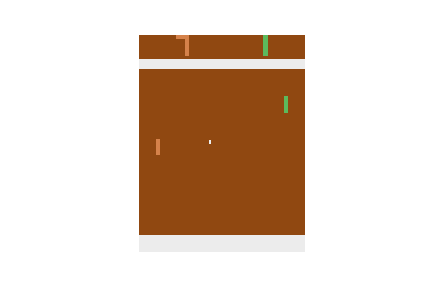
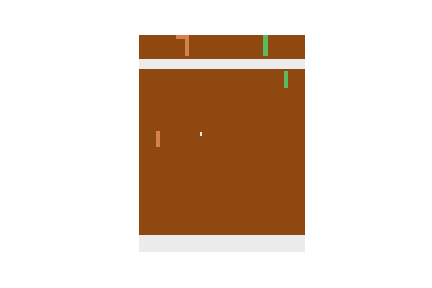
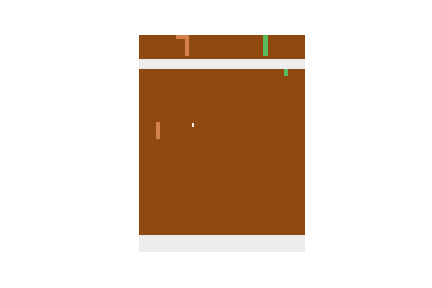

In [50]:
pong_utils.play(env, policy, time=200) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [34]:
def clipped_surrogate(policy, old_probs, states, actions, rewards, 
                     discount = 0.995, epsilon=0.1, beta=0.01):
    reward_array = np.asarray(rewards)
    
    ## creating a discounting factor
    discounting_factor = discount**np.arange(reward_array.shape[0]).reshape(-1,1)
    
    ## discounted_reward 
    discounted_reward = discounting_factor*reward_array
    
    ## calculating the future reward
    future_reward = discounted_reward[::-1].cumsum(axis=0)[::-1]
    
    ## mean for normalizing reward
    mean  = np.mean(future_reward,axis=1).reshape(-1,1)
    
    ## std for normalizing reward
    std = np.std(future_reward,axis=1).reshape(-1,1)+ 1e-10
    
    
    ## Normalizing the reward 
    normalized_reward = (future_reward-mean)/std
    ##Converting the variable to tensor
    
    reward_tensor = torch.tensor(normalized_reward,dtype=torch.float,
                                device=device)
    
    old_probs = torch.tensor(old_probs, dtype=torch.float,
                             device=device)
    actions =torch.tensor(actions, dtype = torch.int8, device=device)
    
    ## convert state to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy,states)
    new_probs = torch.where(actions==pong_utils.RIGHT, new_probs,1-new_probs)
    
    
    ratio = new_probs/old_probs
    
    ## clipped ratio
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    #clipped_surrogate = torch.min(ratio*rewards, clip*rewards)
    clipped_Ratio =torch.min(ratio*reward_tensor,clip*reward_tensor)
    
    # include a regularization term
    # this steers new_policy towards 0.5
    # prevents policy to become exactly 0 or 1 helps exploration
    # add in 1.0e-10 to avoid log(0) which gives nan
    
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))
    
    return torch.mean(beta*entropy + reward_tensor*clipped_Ratio)

# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [51]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 500

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=8, seed=89)

discount_rate = .99
epsilon = 0.1
beta = .08
tmax = 200
SGD_epoch = 3

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):
        
        # uncomment to utilize your own clipped function!
        L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

        #L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
#                                           epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.999
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Episode: 20, score: -9.000000
[ -9. -10.  -9.  -6.  -8. -10. -10. -10.]


Episode: 40, score: -6.875000
[ -7.  -5.  -3.  -7.  -8.  -8. -10.  -7.]


Episode: 60, score: -8.375000
[ -3. -10. -10.  -7. -10. -10.  -7. -10.]


Episode: 80, score: -8.000000
[ -9.  -5.  -7. -10.  -9.  -7.  -7. -10.]


Episode: 100, score: -7.125000
[ -3. -10.  -4.  -8.  -4.  -9.  -9. -10.]


Episode: 120, score: -8.250000
[ -9.  -8.  -7.  -9.  -8. -10.  -6.  -9.]


Episode: 140, score: -8.875000
[-10.  -9.  -8.  -9. -10. -10.  -9.  -6.]


Episode: 160, score: -9.125000
[-10.  -9. -10. -10.  -8. -10.  -6. -10.]


Episode: 180, score: -9.000000
[ -9.  -8.  -9.  -8. -10.  -9.  -9. -10.]


Episode: 200, score: -7.875000
[-10.  -8.  -8.  -5.  -9.  -7.  -9.  -7.]


Episode: 220, score: -9.000000
[-10.  -9.  -9.  -9.  -8.  -8.  -9. -10.]


Episode: 240, score: -8.625000
[ -5. -10.  -6. -10. -10.  -9.  -9. -10.]


Episode: 260, score: -7.875000
[-8. -9. -9. -8. -8. -8. -5. -8.]


Episode: 280, score: -8.375000
[-10.  -8. -10.  -9.  -5.  -9.  -7.  -9.]


Episode: 300, score: -9.125000
[-10.  -9.  -8. -10. -10.  -9.  -7. -10.]


Episode: 320, score: -6.750000
[ -8.  -9.  -3.  -4.  -8.  -7. -10.  -5.]


Episode: 340, score: -8.000000
[ -7.  -7. -10.  -5.  -9. -10.  -9.  -7.]


Episode: 360, score: -7.625000
[-10.  -9.  -9.  -6. -10.  -8.  -9.   0.]


Episode: 380, score: -7.500000
[-10. -10.  -6.  -2. -10.  -6.  -9.  -7.]


Episode: 400, score: -7.375000
[ -3. -10.  -8.  -5.  -6. -10.  -8.  -9.]


Episode: 420, score: -7.375000
[-10.  -3.  -8.  -8.  -5. -10.  -9.  -6.]


Episode: 440, score: -9.000000
[ -9. -10. -10.  -8.  -7.  -8. -10. -10.]


Episode: 460, score: -8.250000
[ -9.  -9.  -7. -10.  -5. -10.  -7.  -9.]


Episode: 480, score: -8.375000
[-10.  -7.  -9.  -9. -10.  -7.  -7.  -8.]


Episode: 500, score: -9.000000
[-10. -10.  -9.  -9. -10.  -5. -10.  -9.]



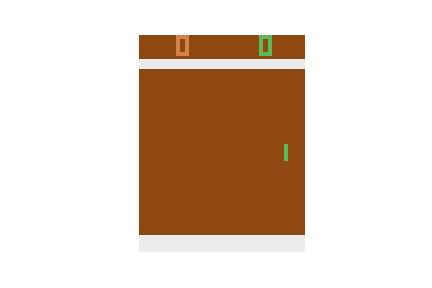
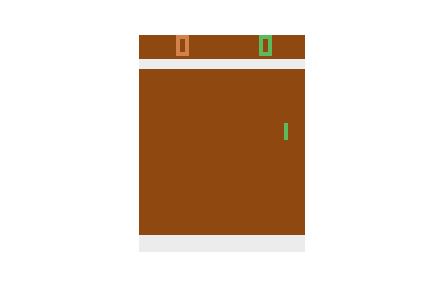
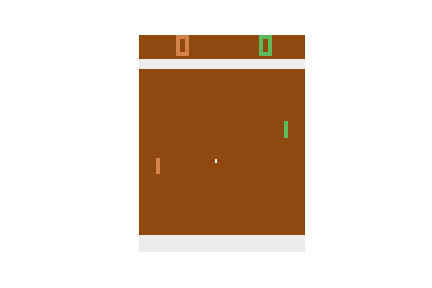
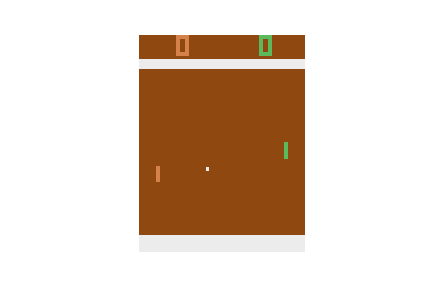
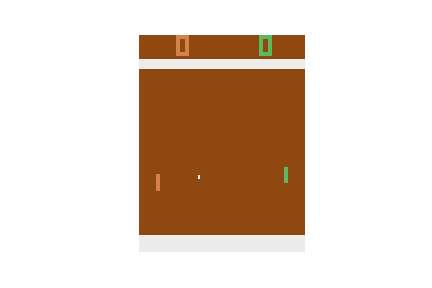
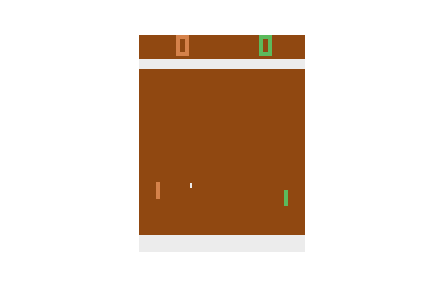
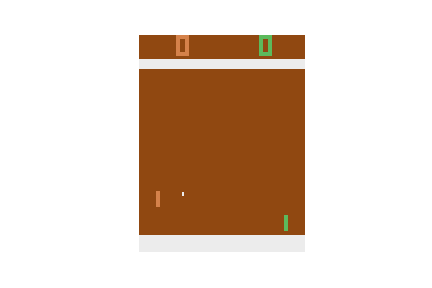
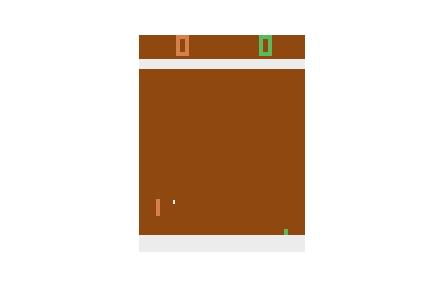
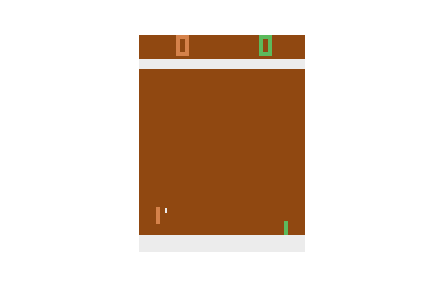
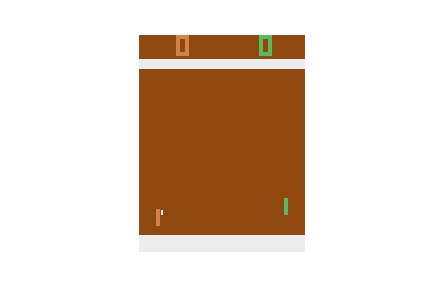
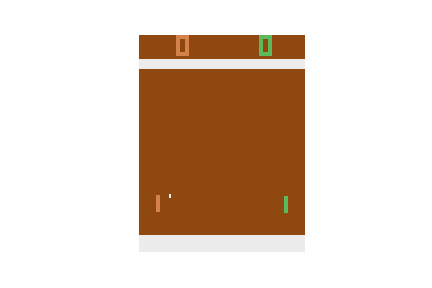
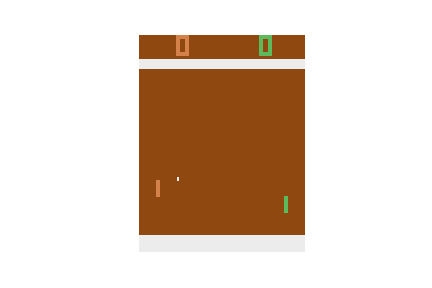
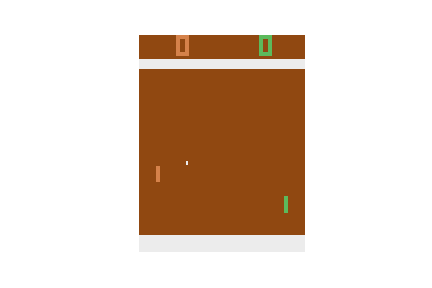
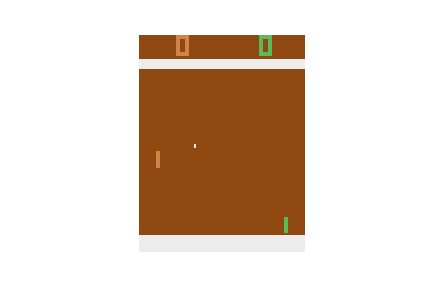
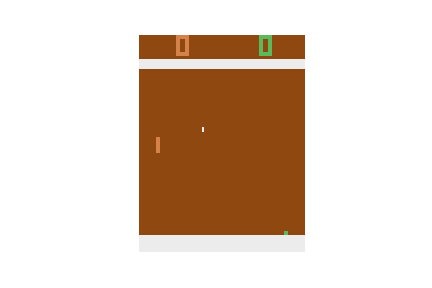
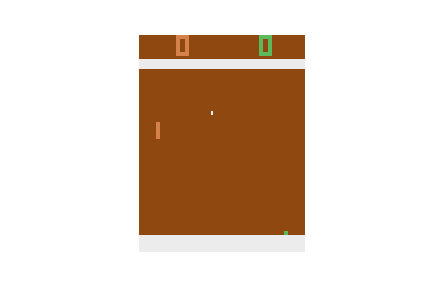
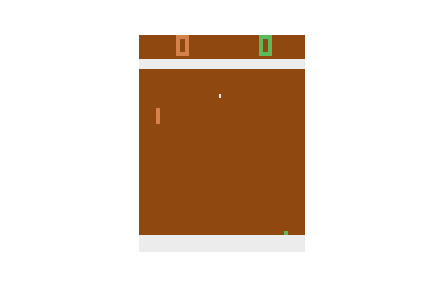
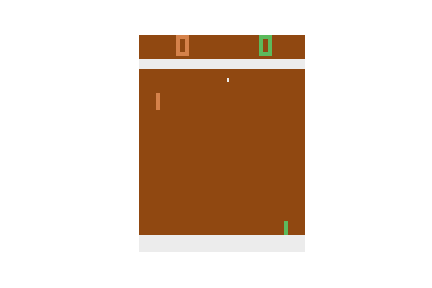
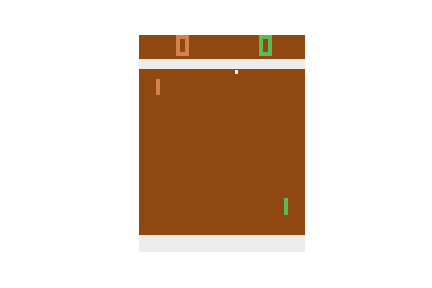
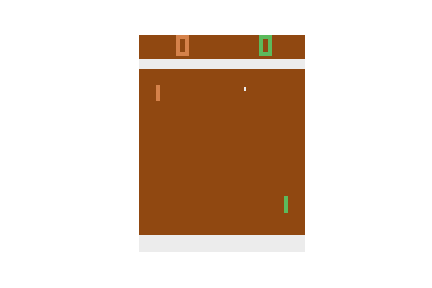
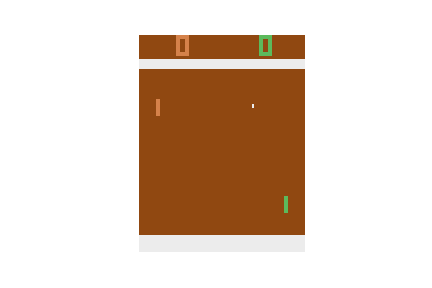
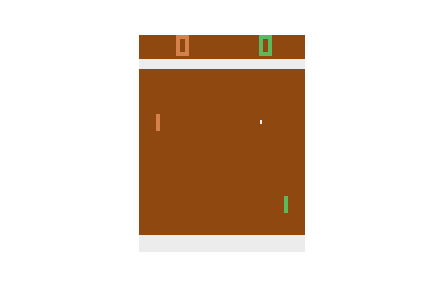
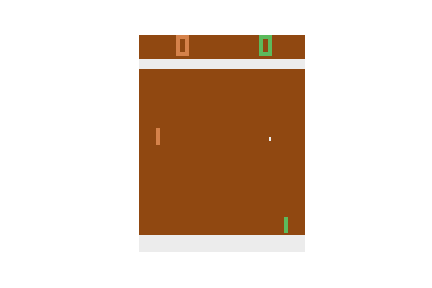
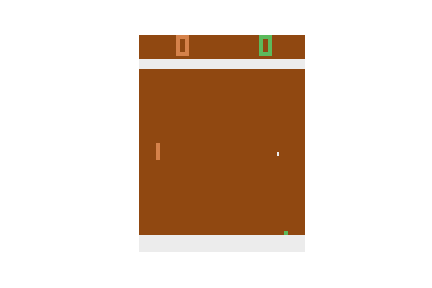
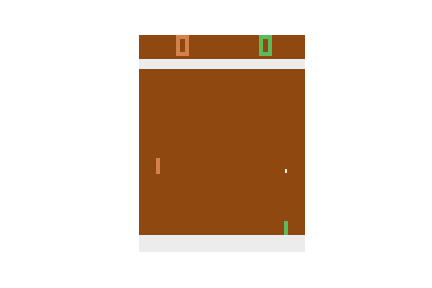
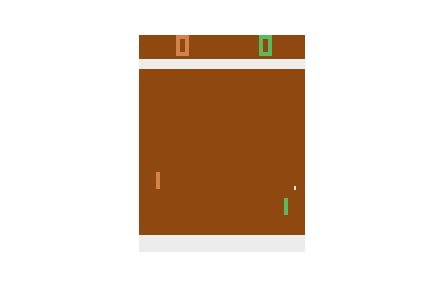
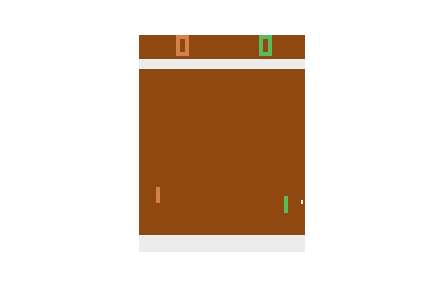
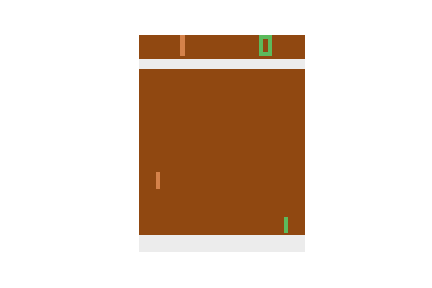
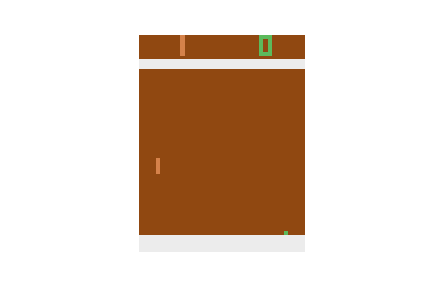
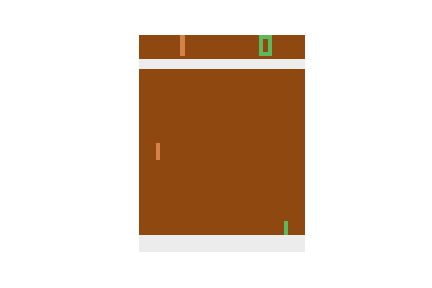
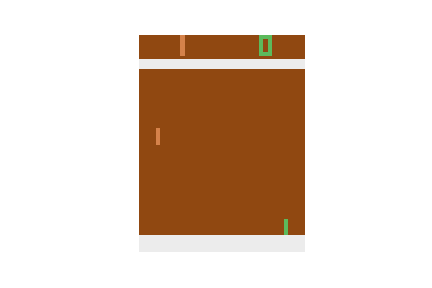
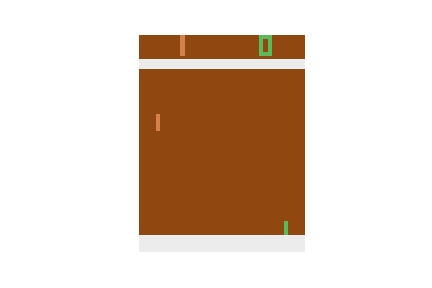
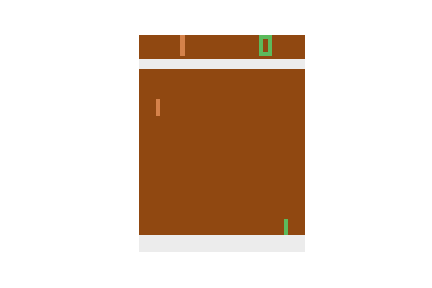
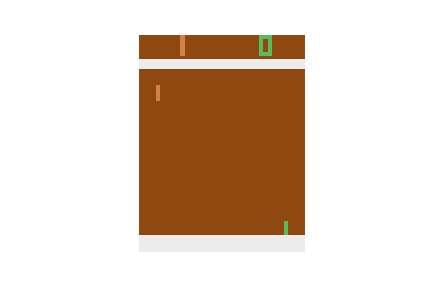
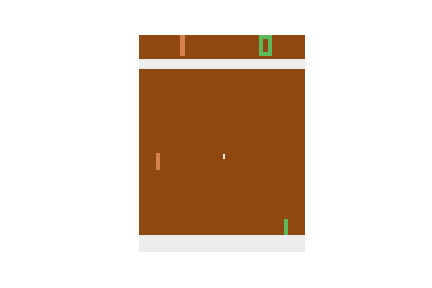
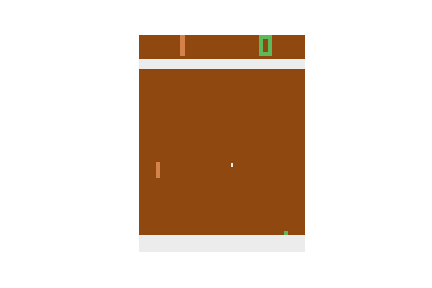
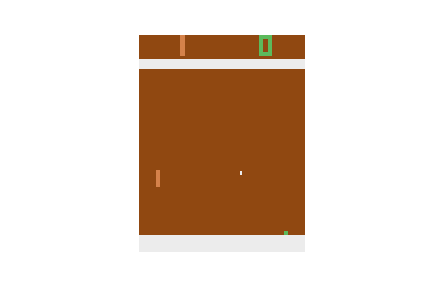
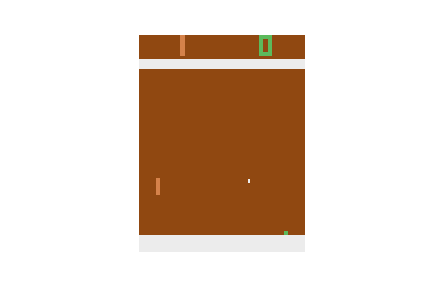
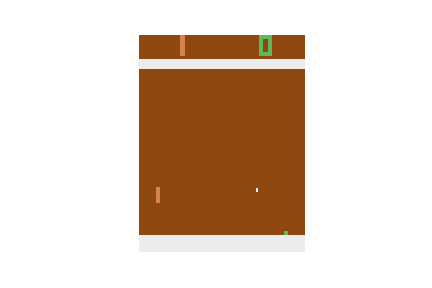
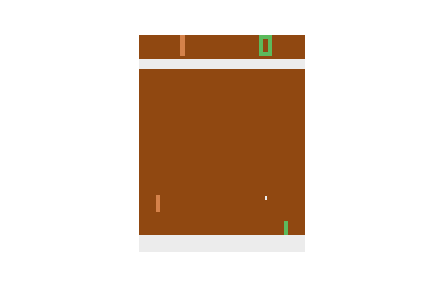
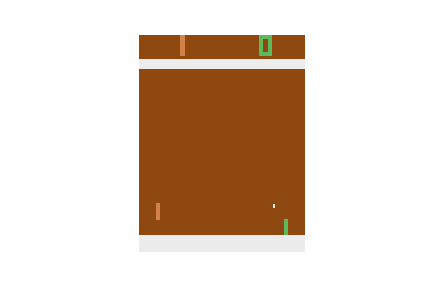
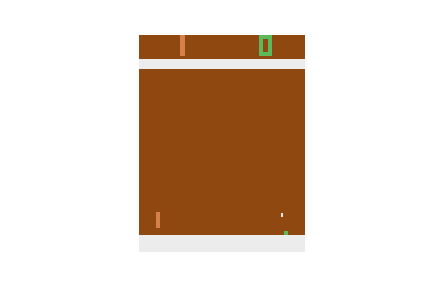
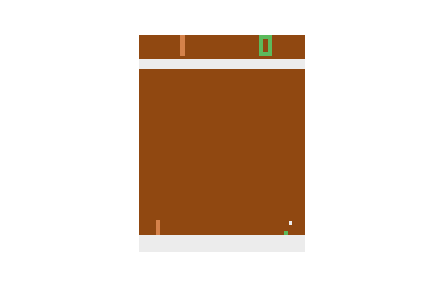
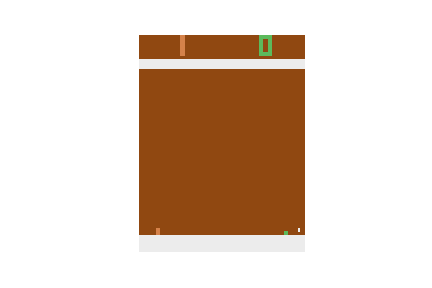
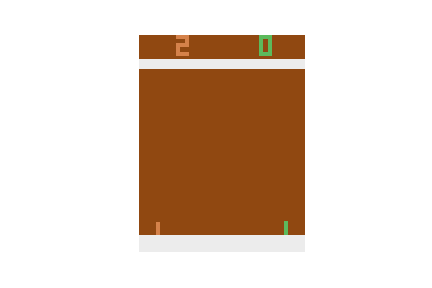
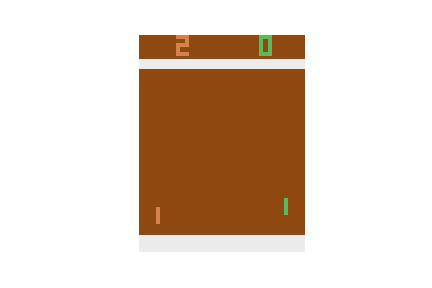
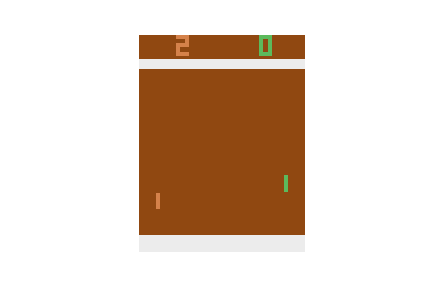
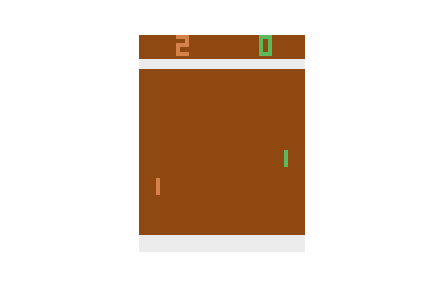
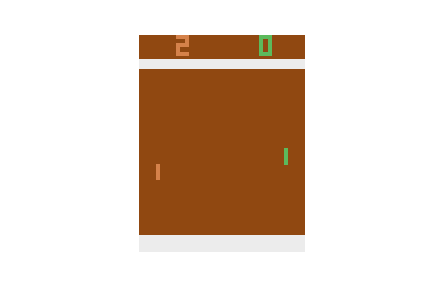
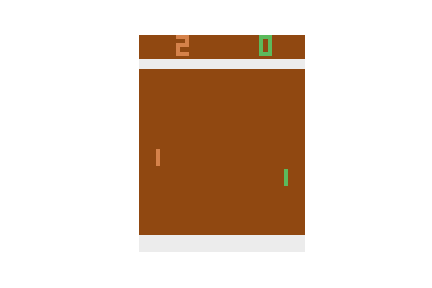
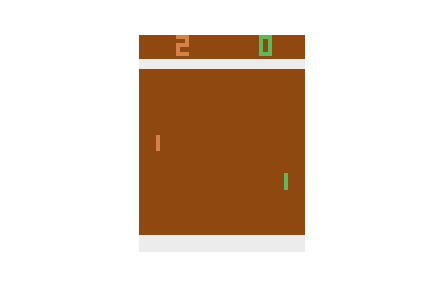
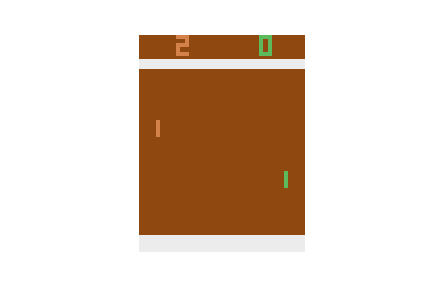
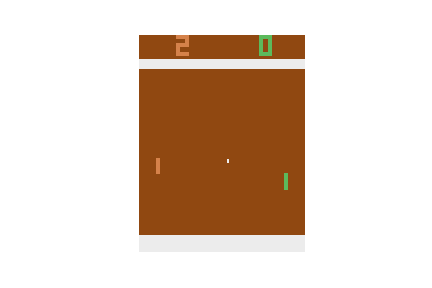
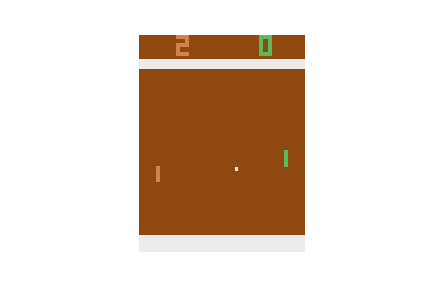
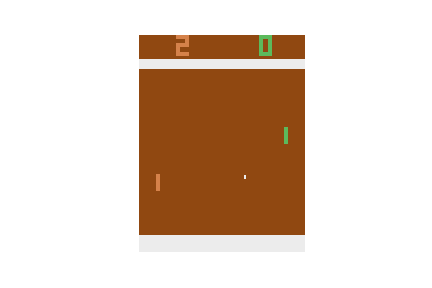
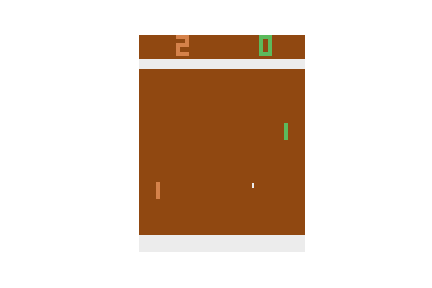
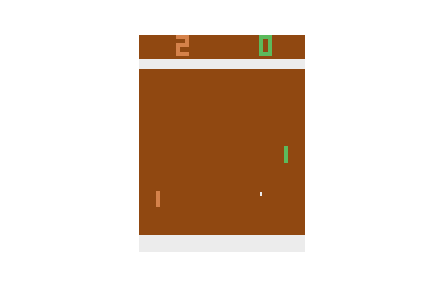
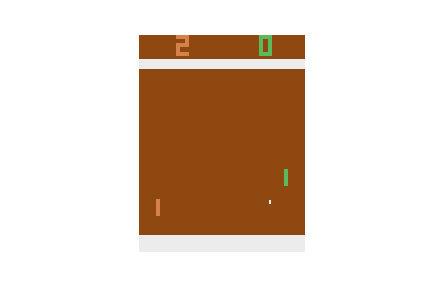
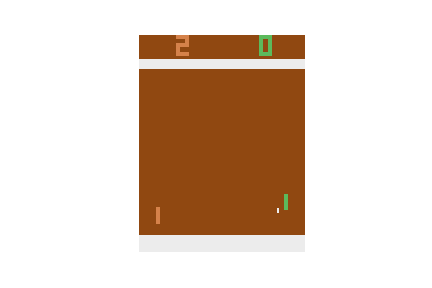
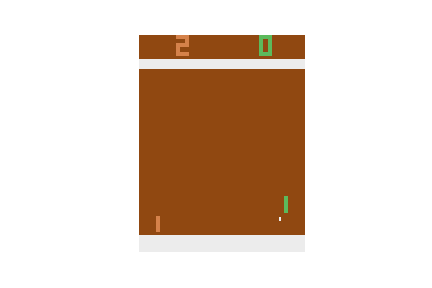
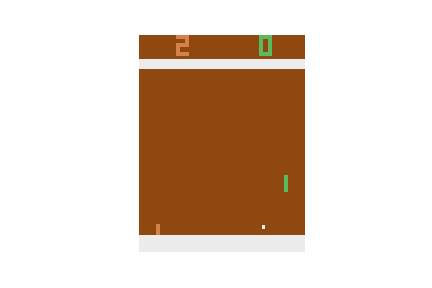
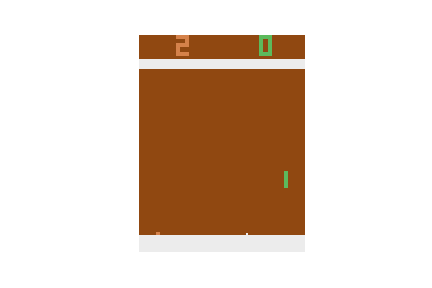
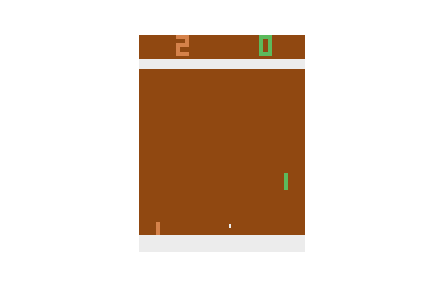
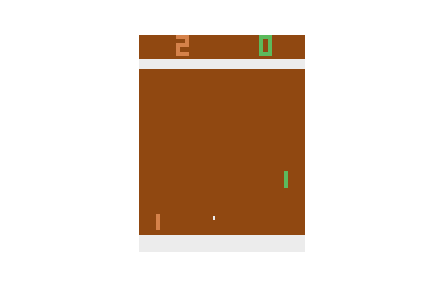
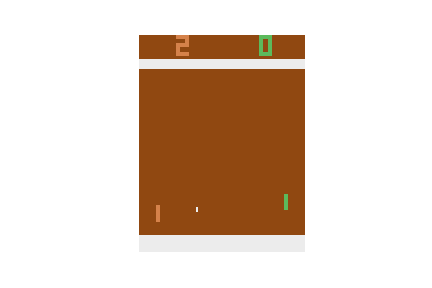
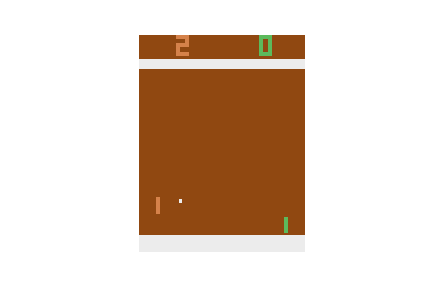
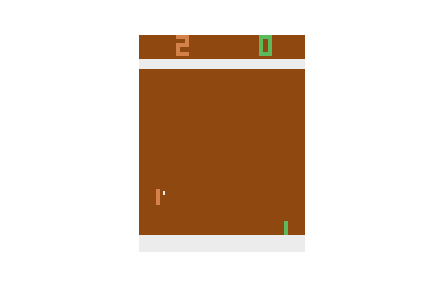
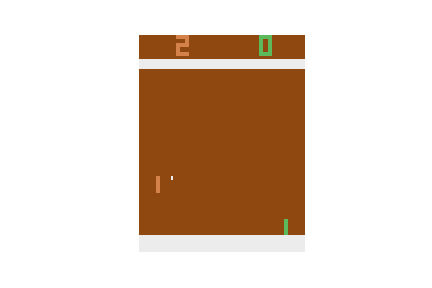
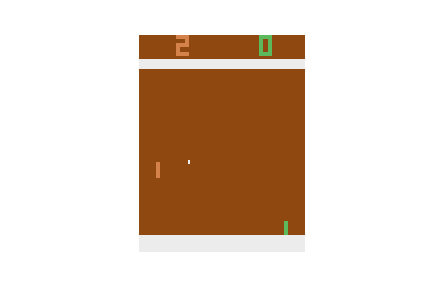
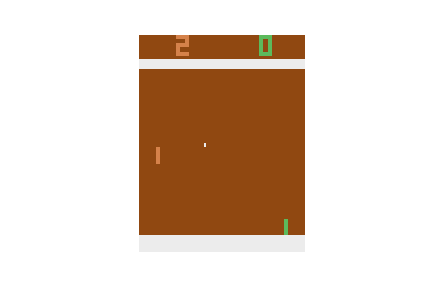
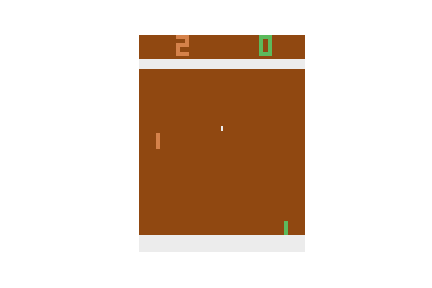
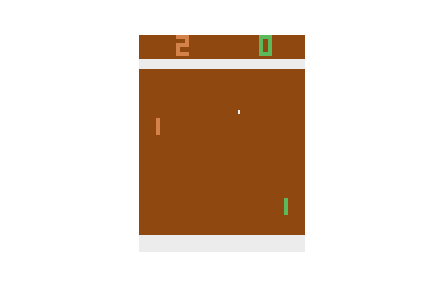
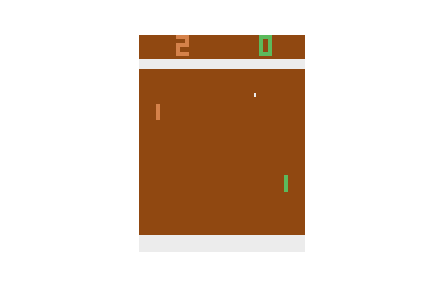
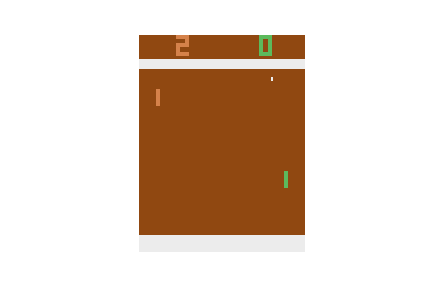
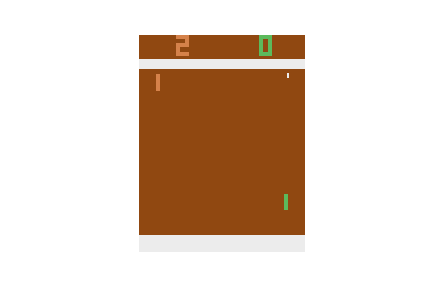
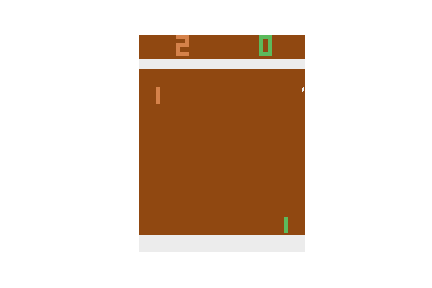
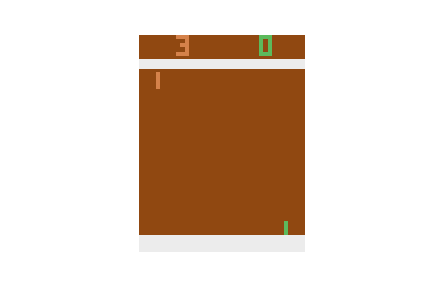
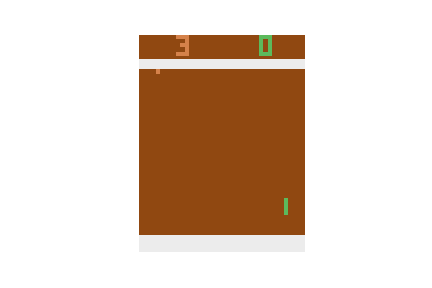
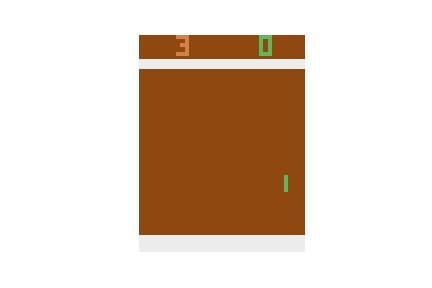
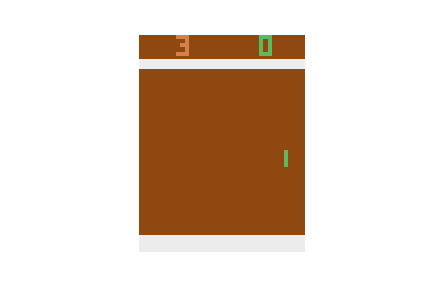
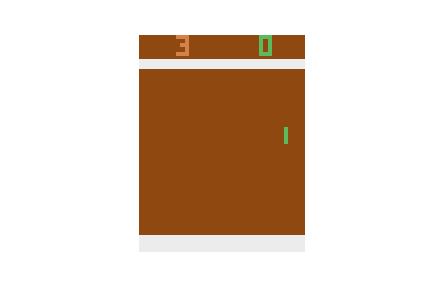
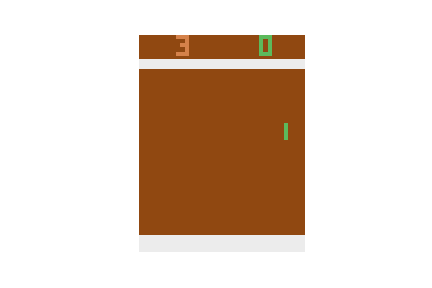
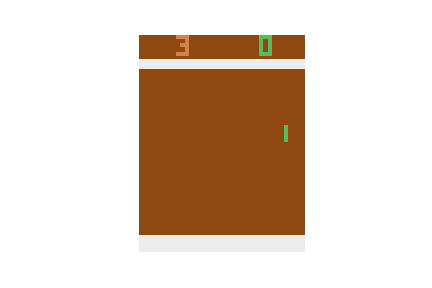
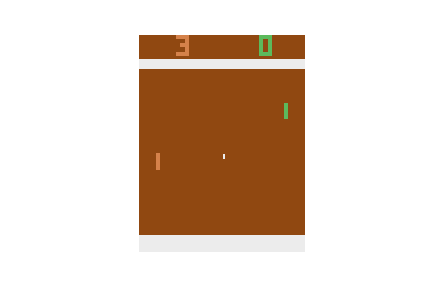
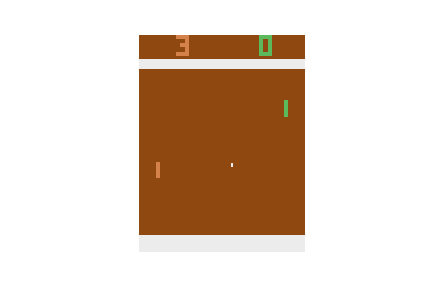
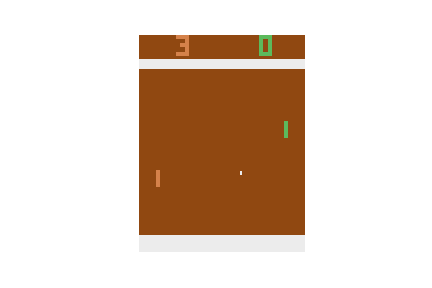
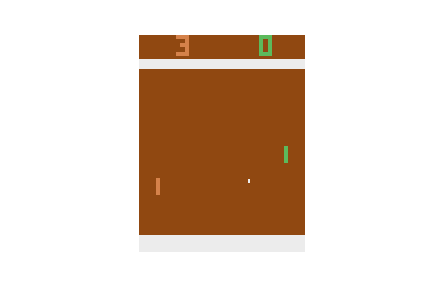
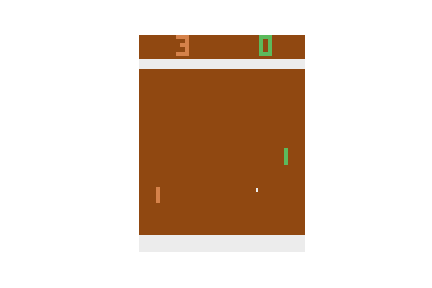
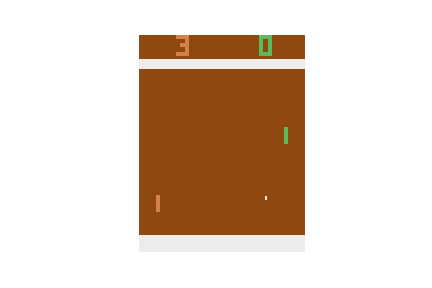
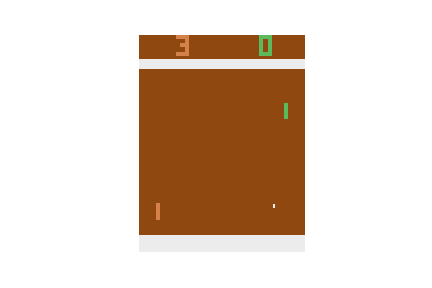
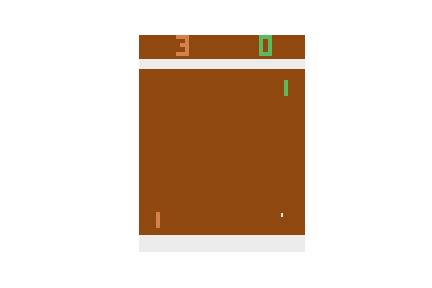
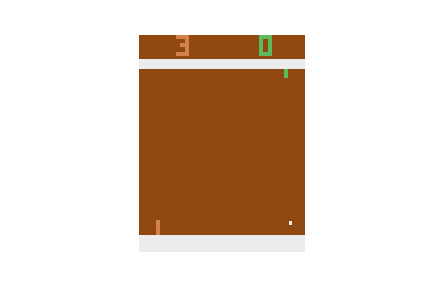
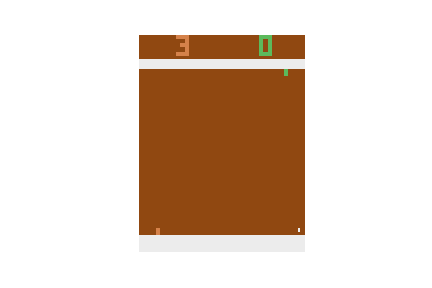
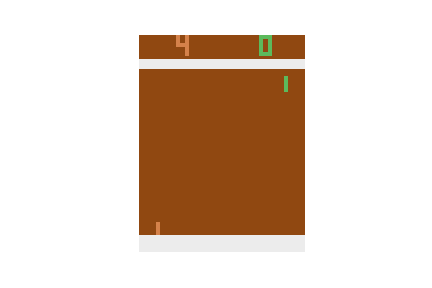
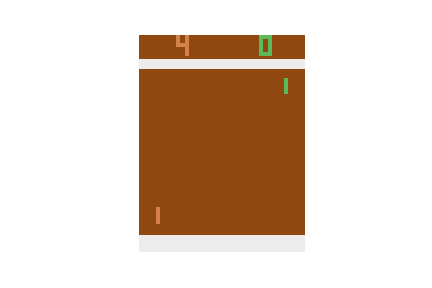
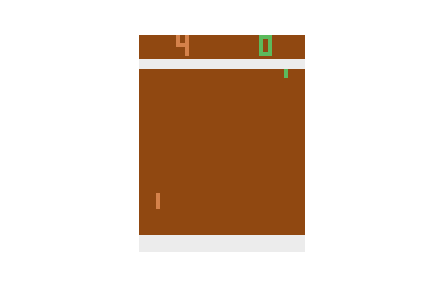
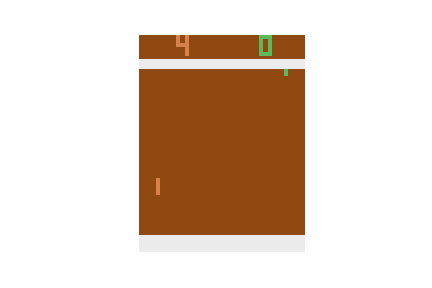
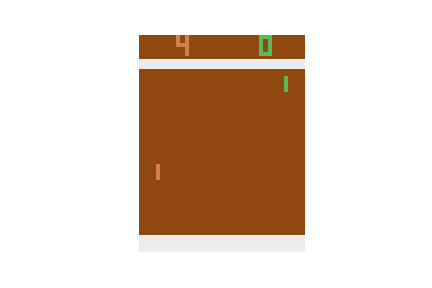
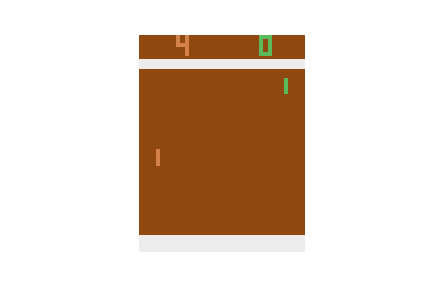
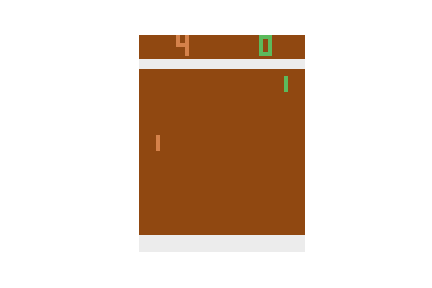
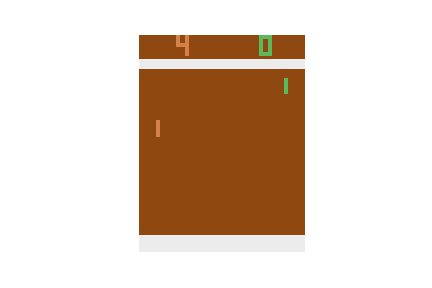
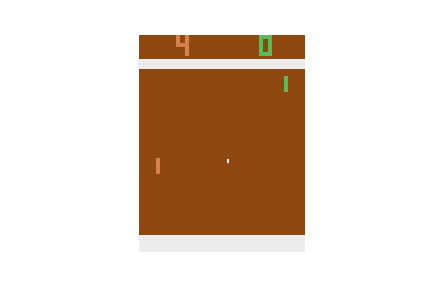
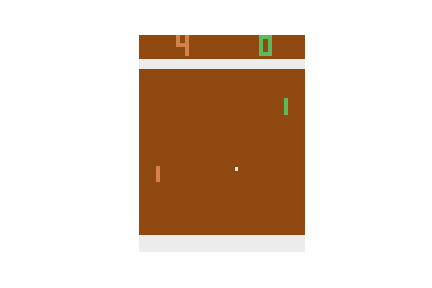
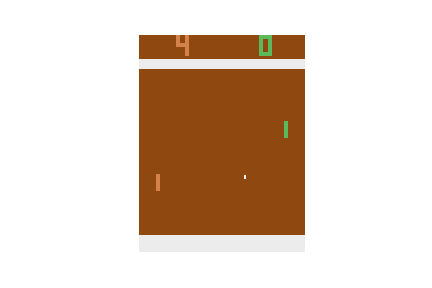
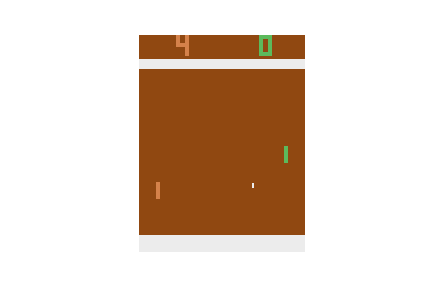
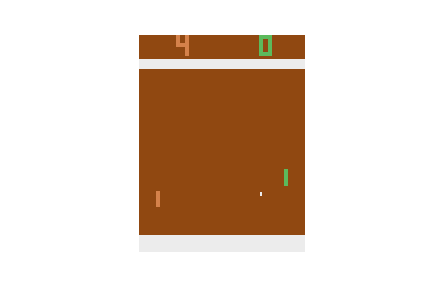
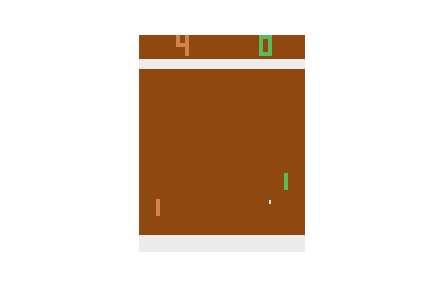
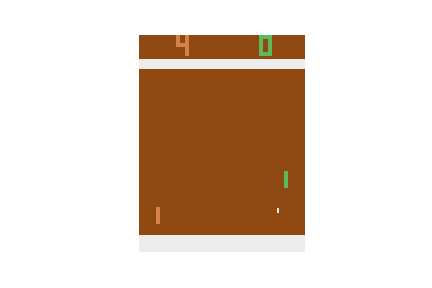
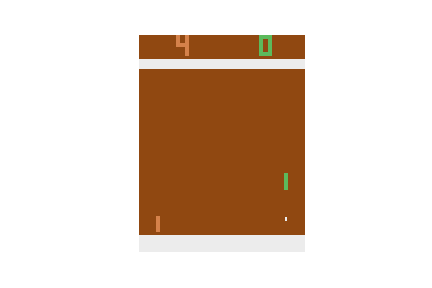
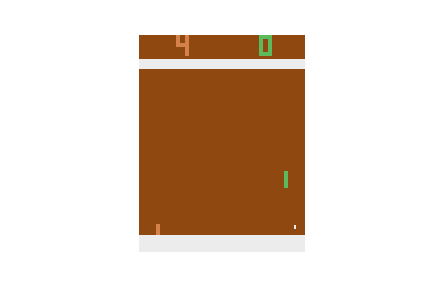
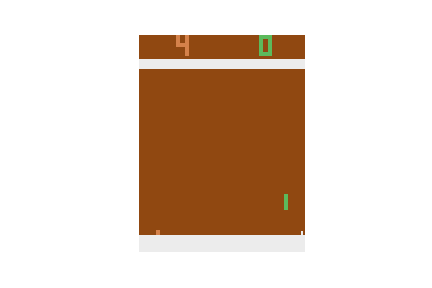
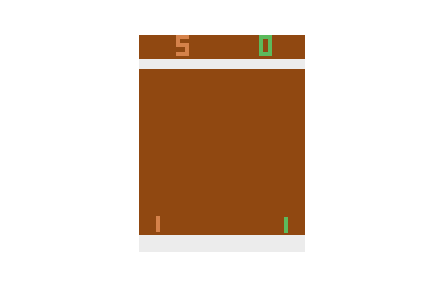
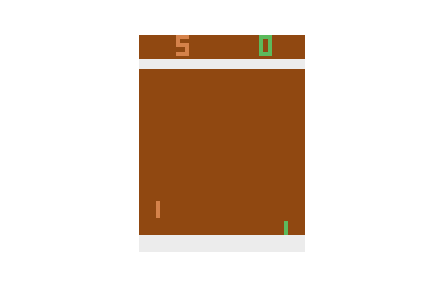
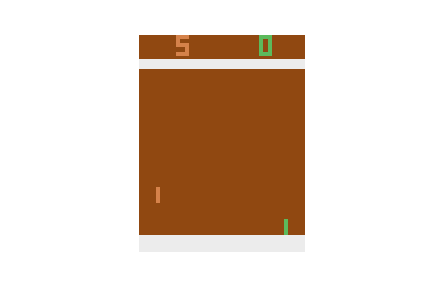
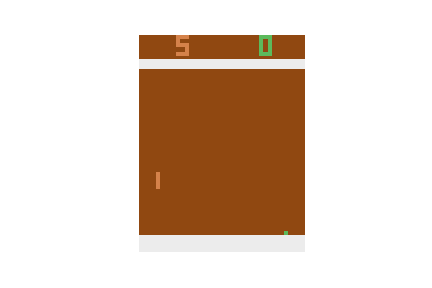
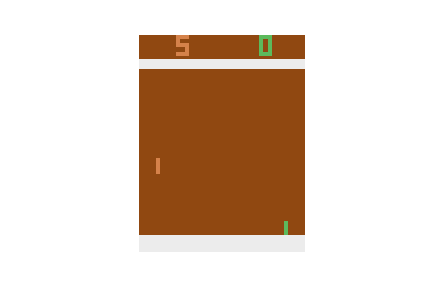
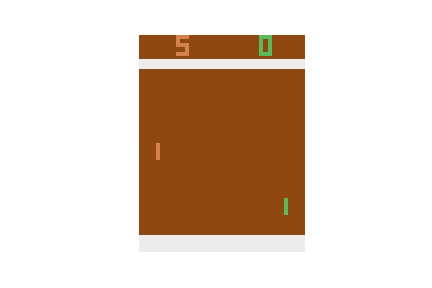
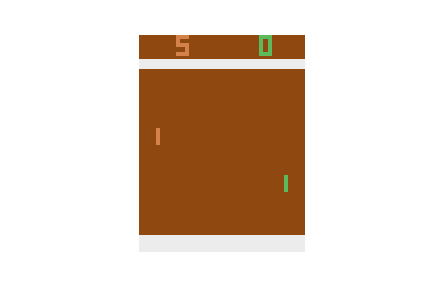
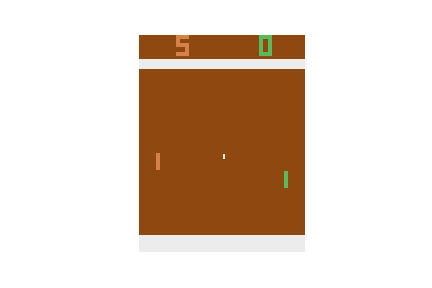
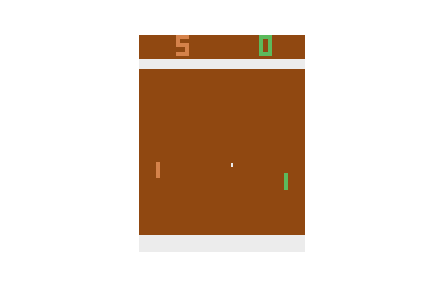
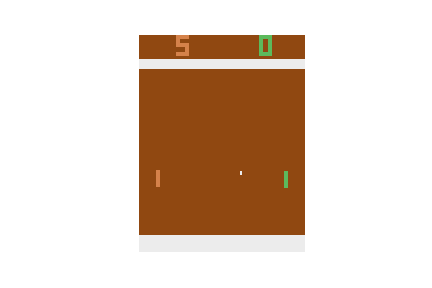
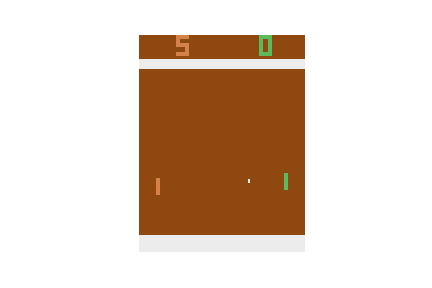
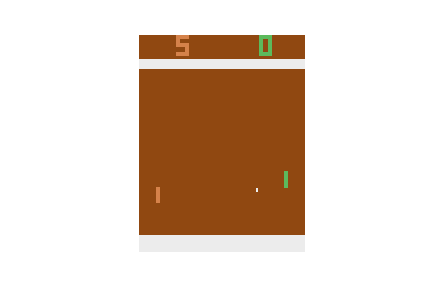
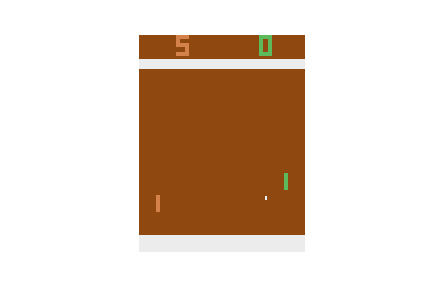
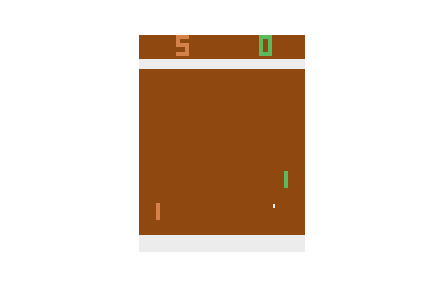
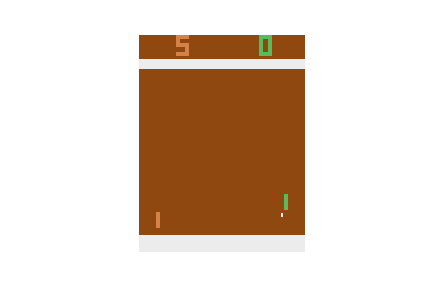
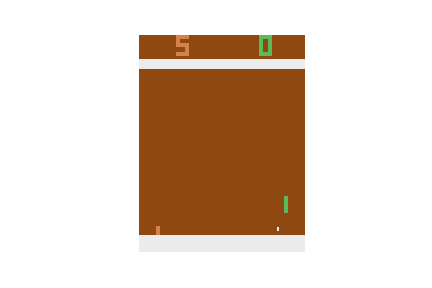
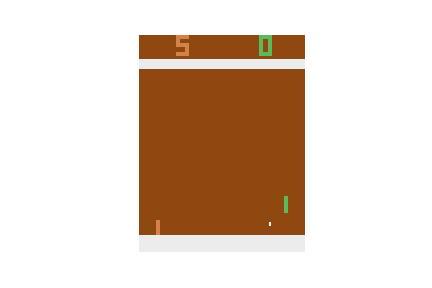
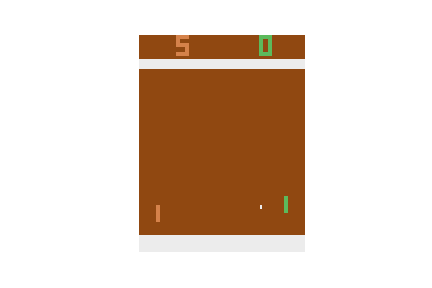
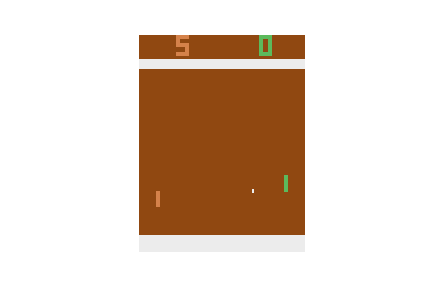
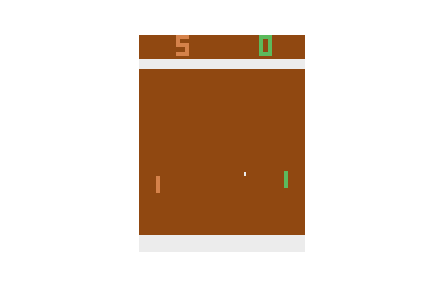
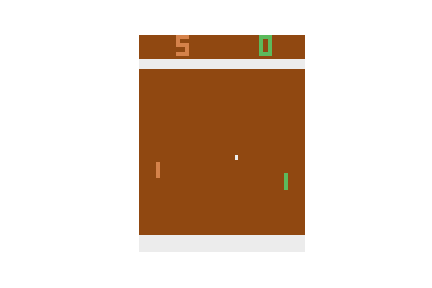
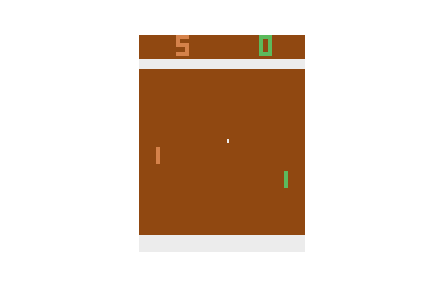
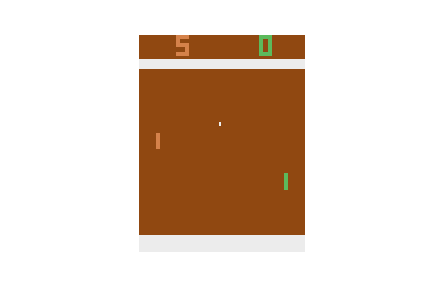
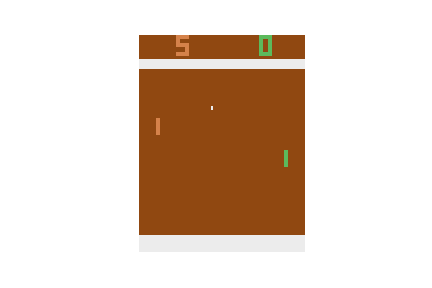
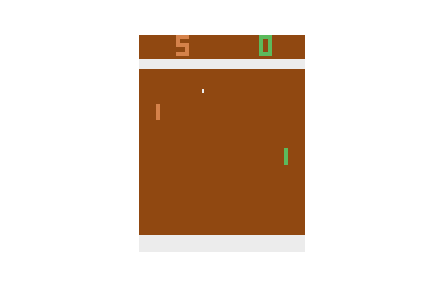
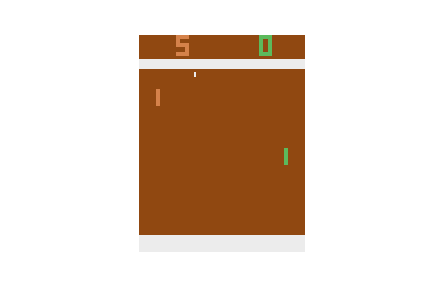
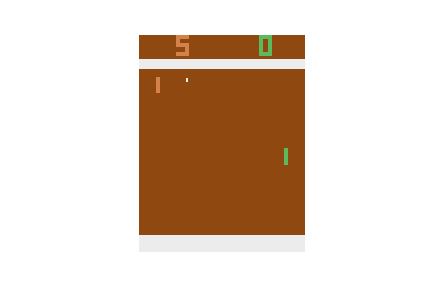
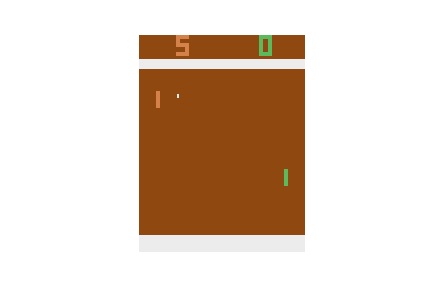
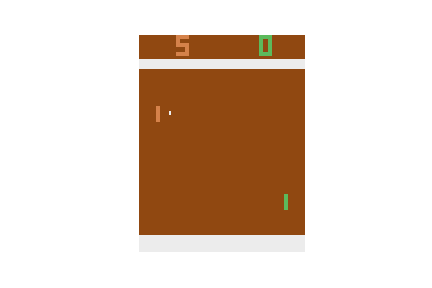
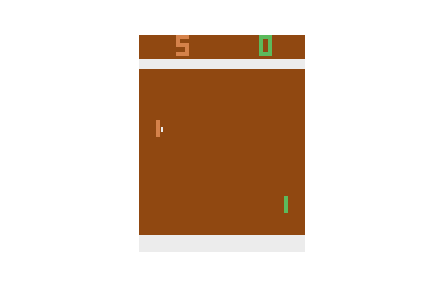
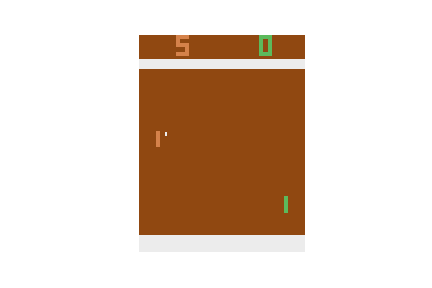
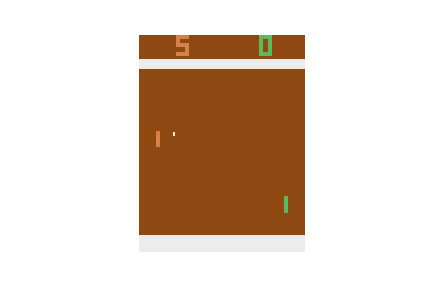
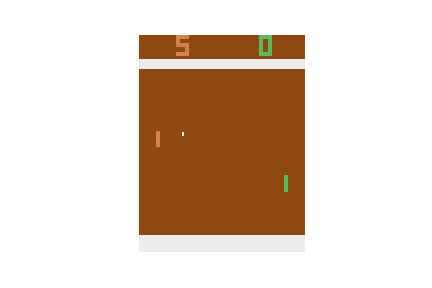
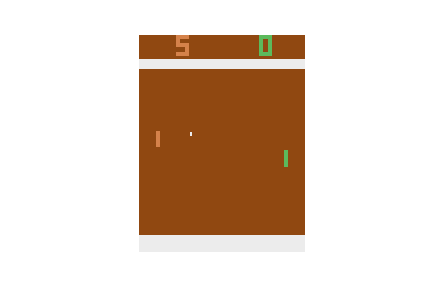
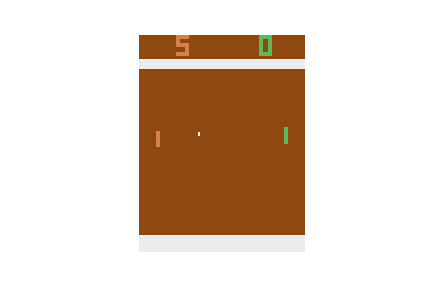
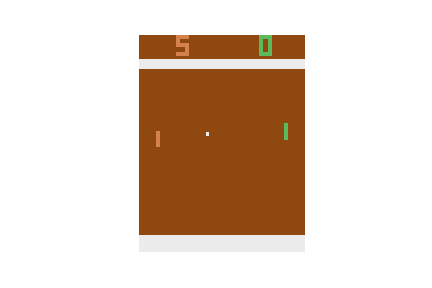
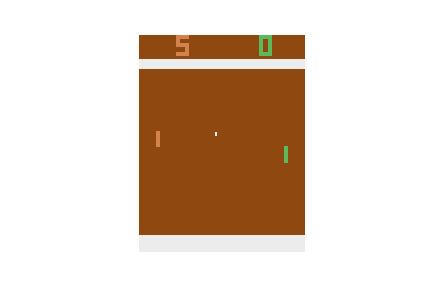
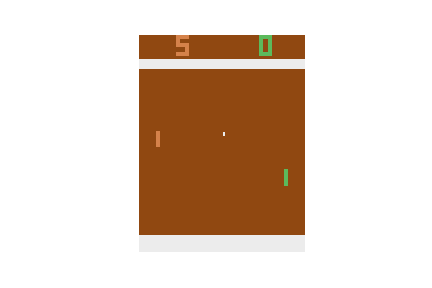
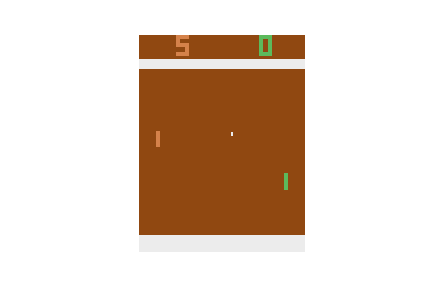
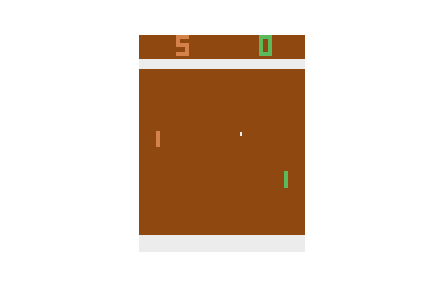
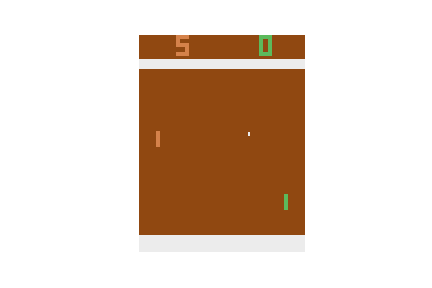
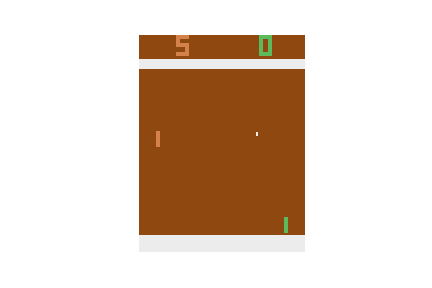
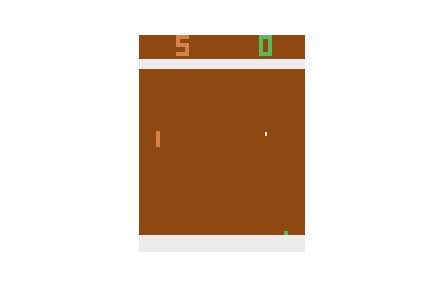
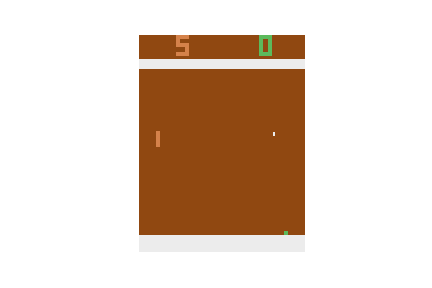
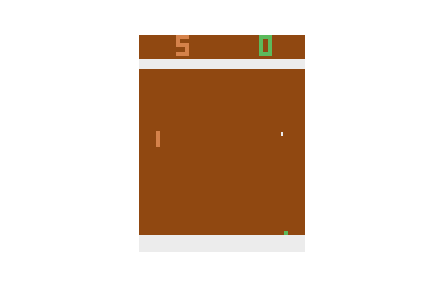
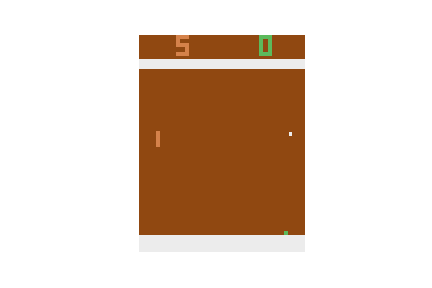
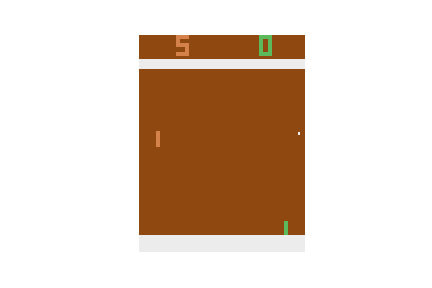
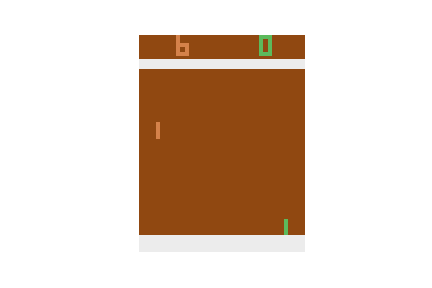
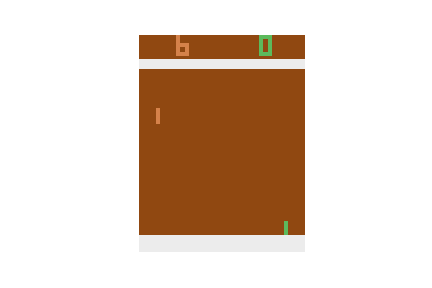
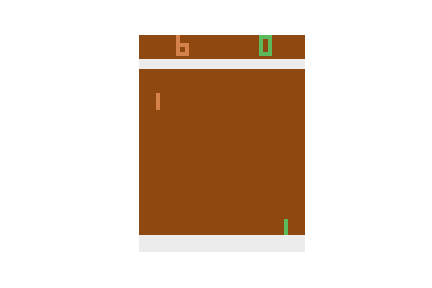
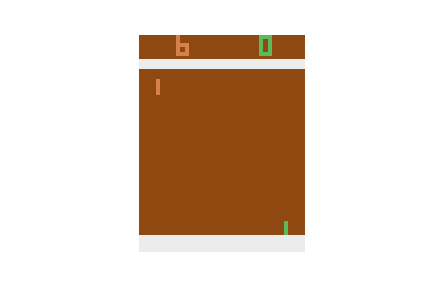
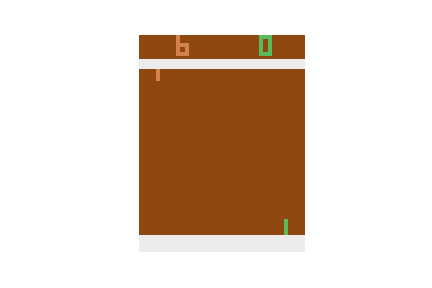
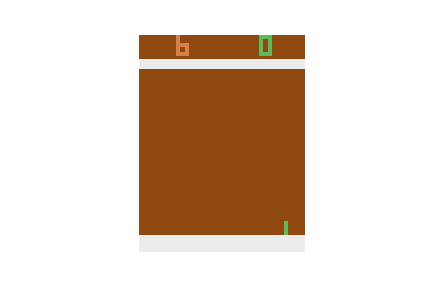
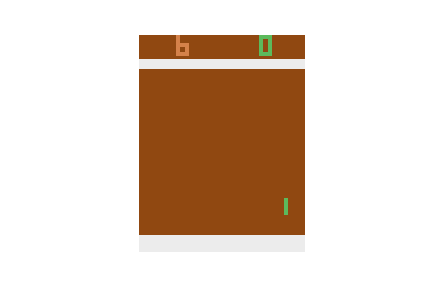
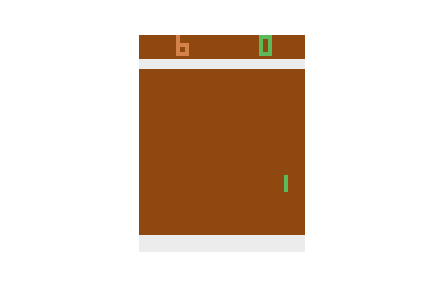
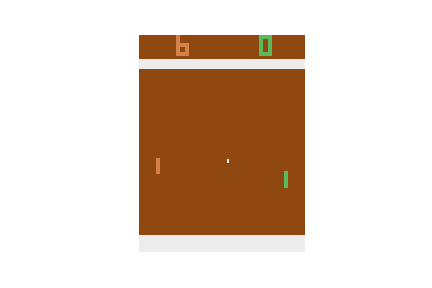
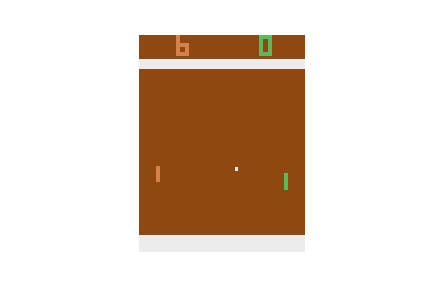
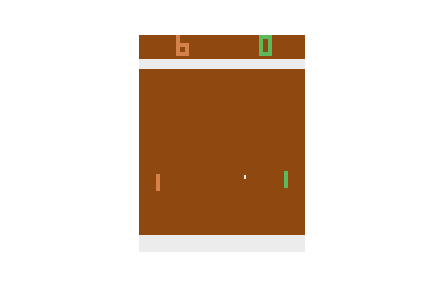
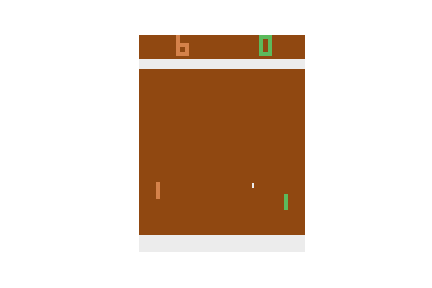
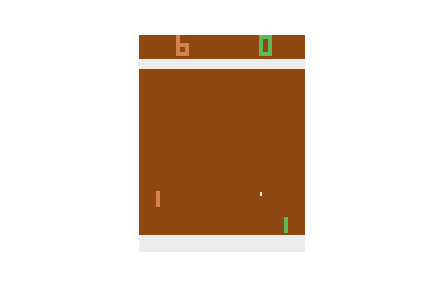
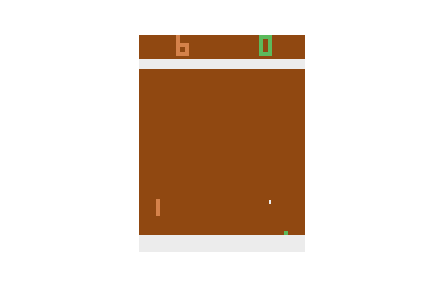
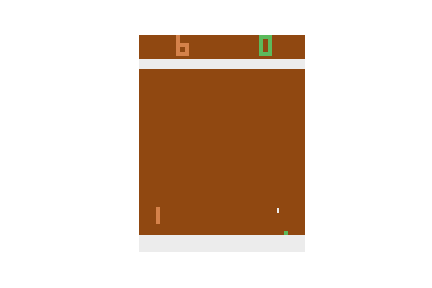
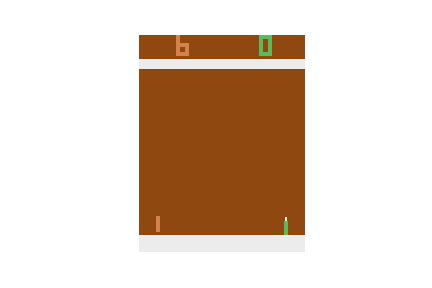
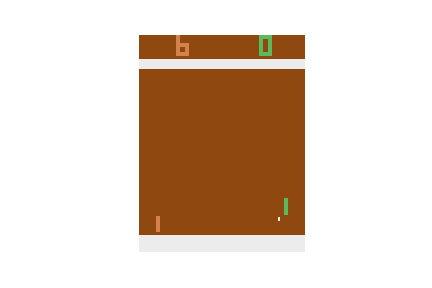
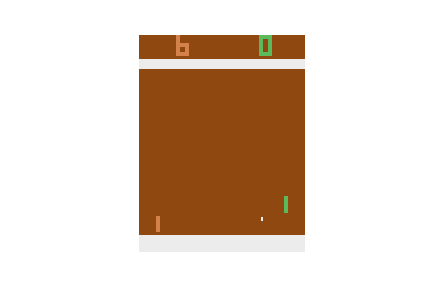
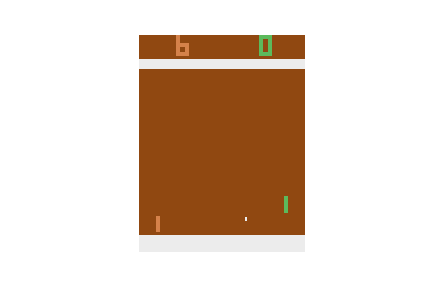
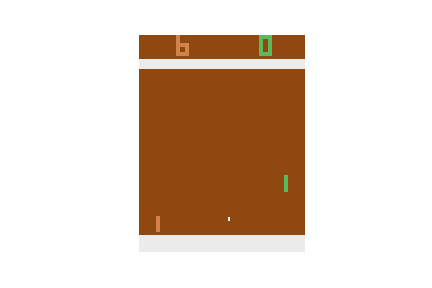
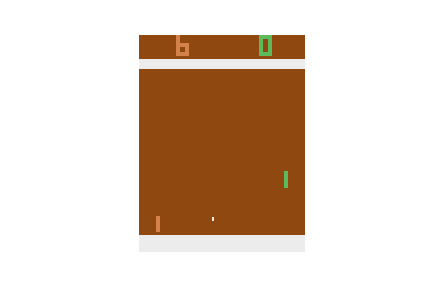
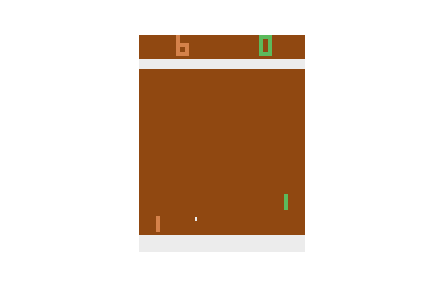
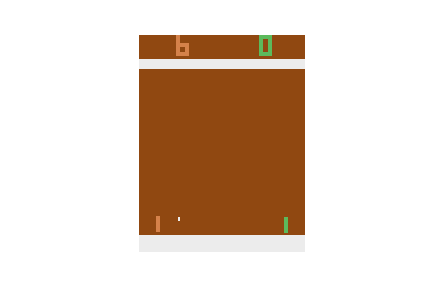
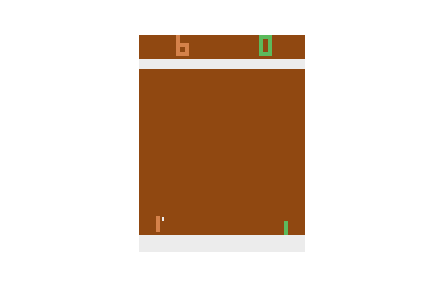
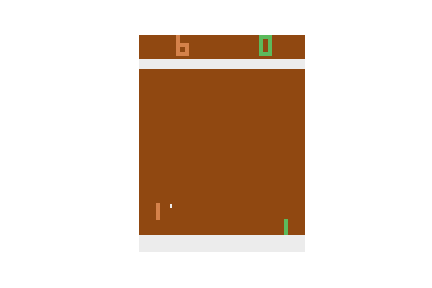
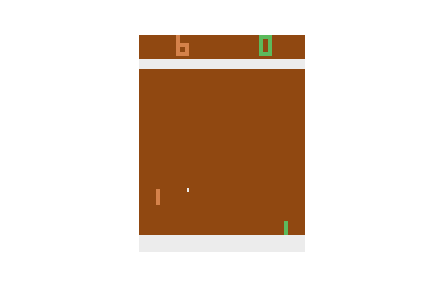
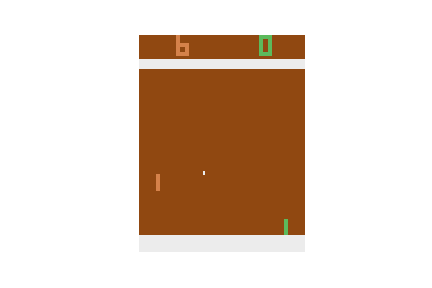
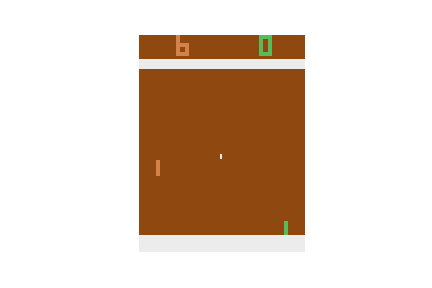
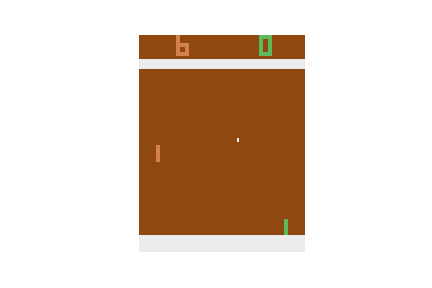
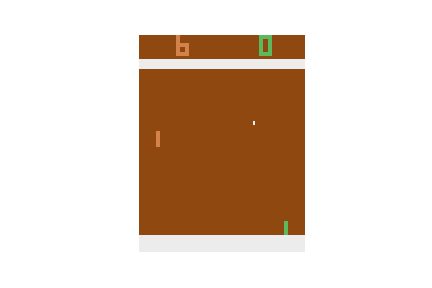
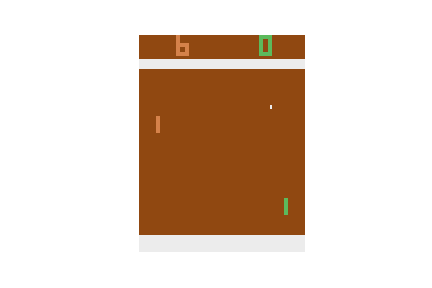
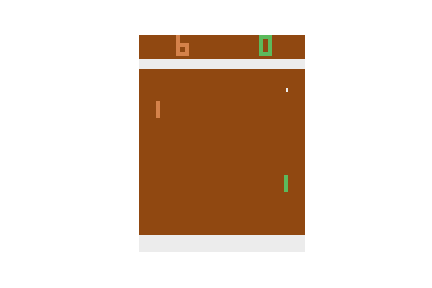
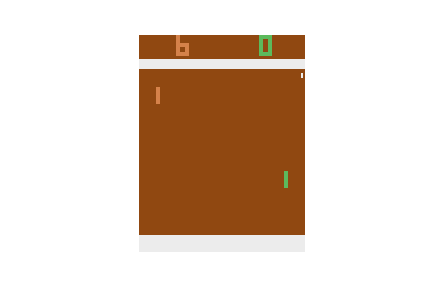
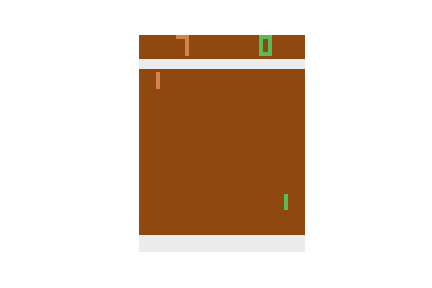
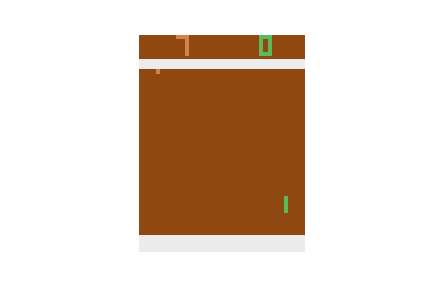
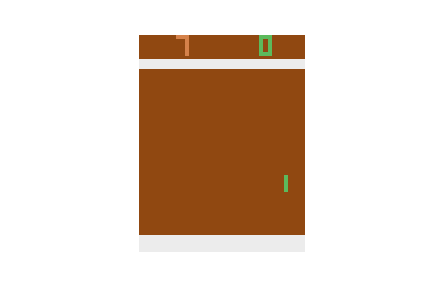
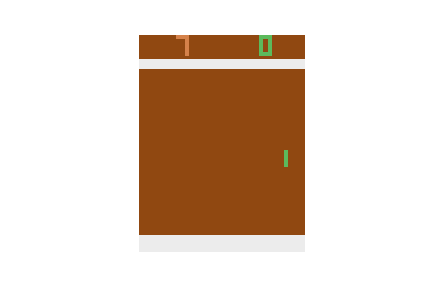
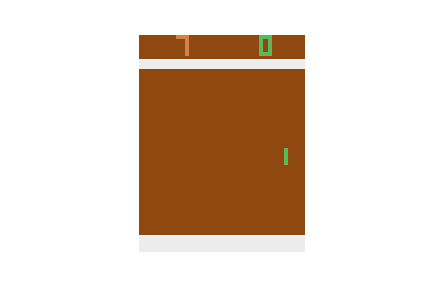
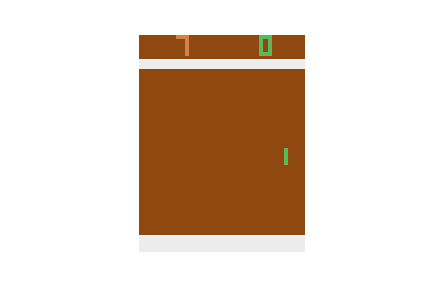
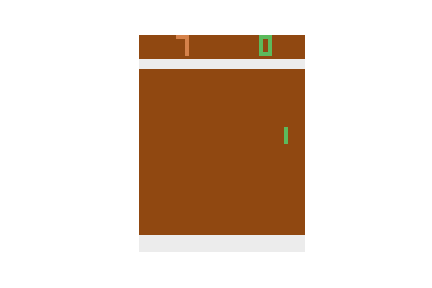
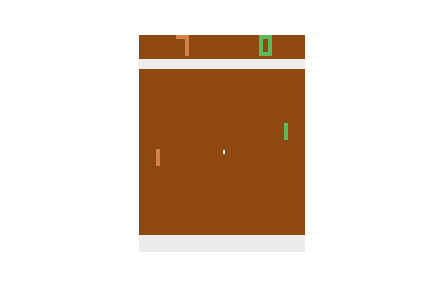
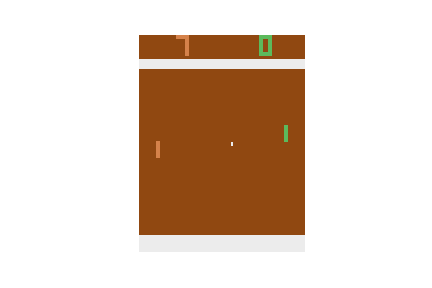
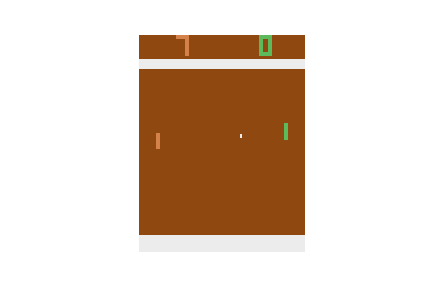
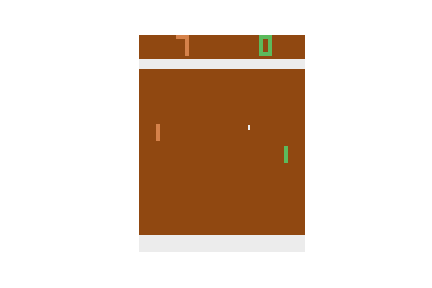
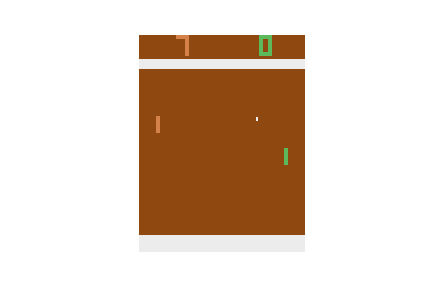
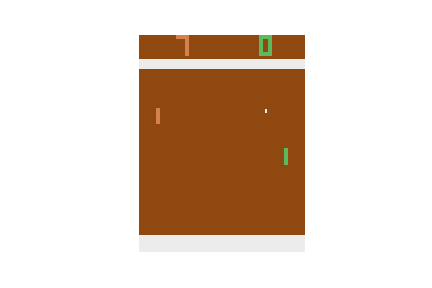
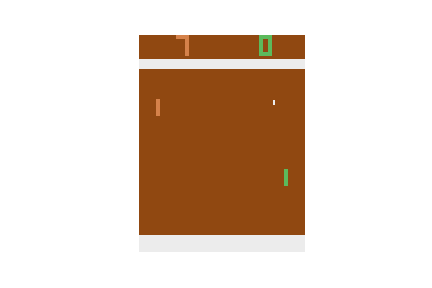
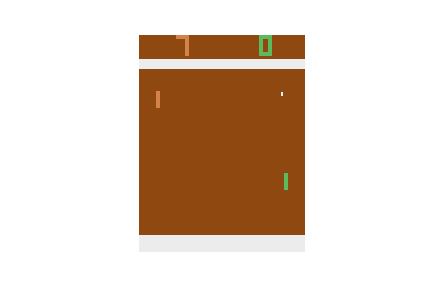
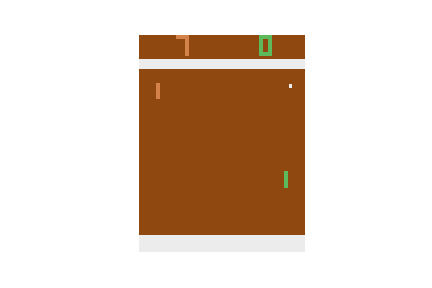
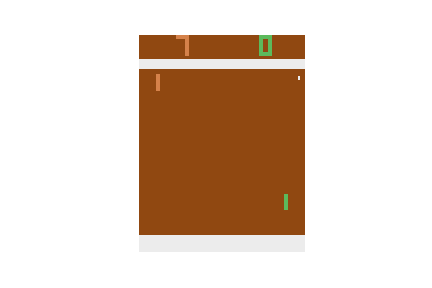
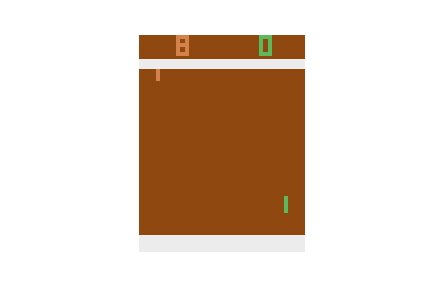
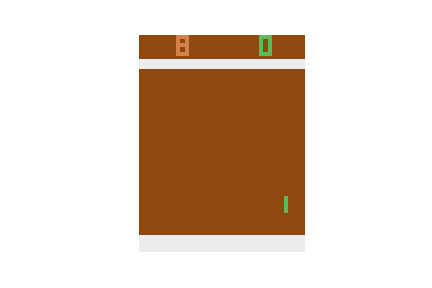
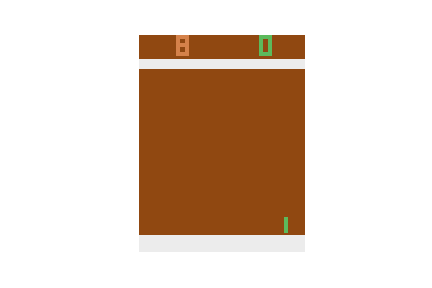
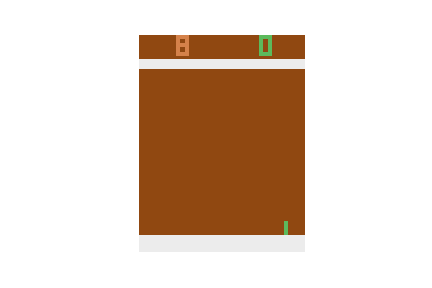
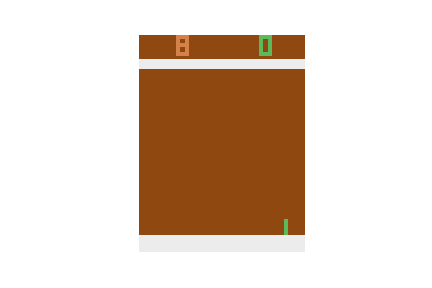
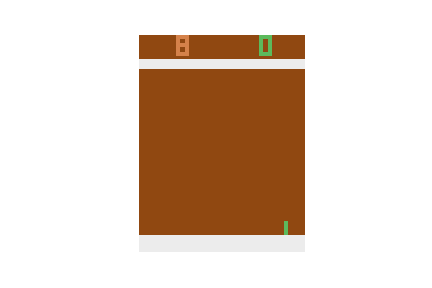
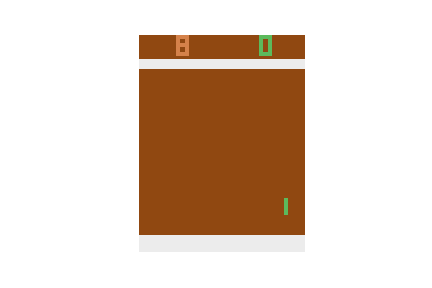
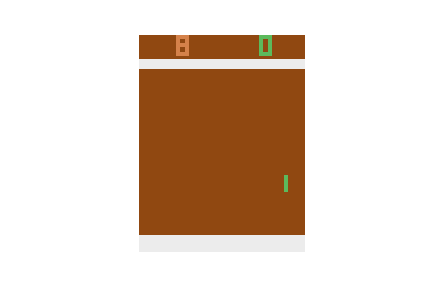
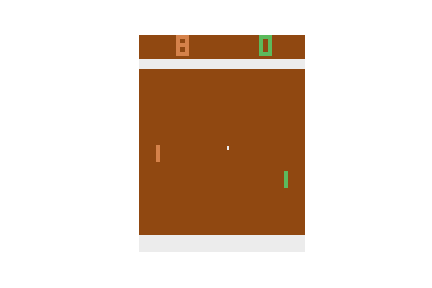
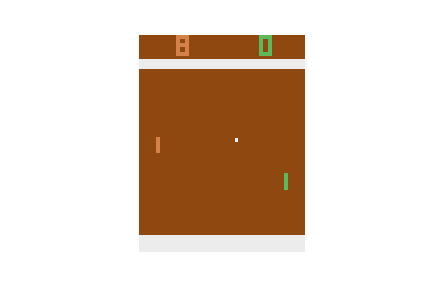
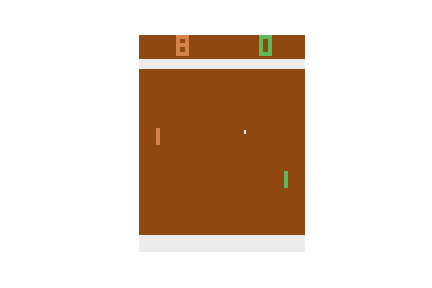
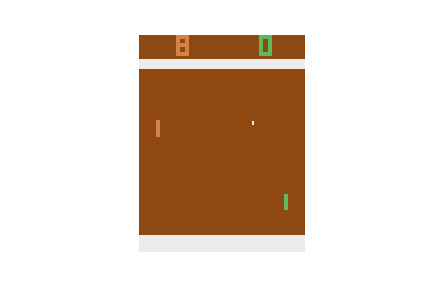
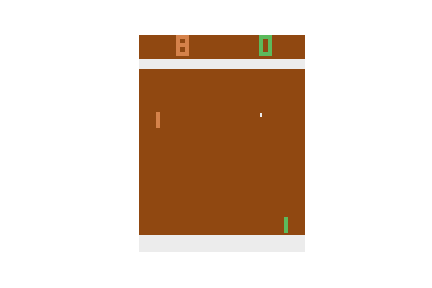
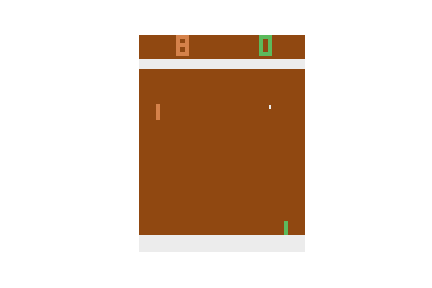
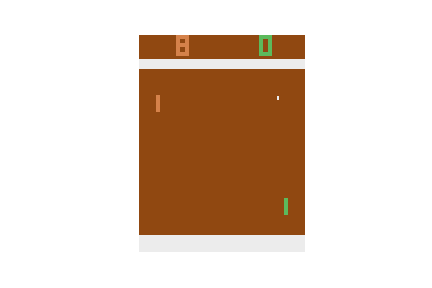
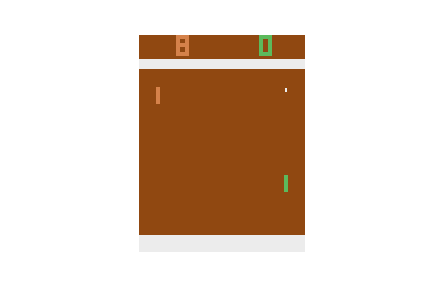
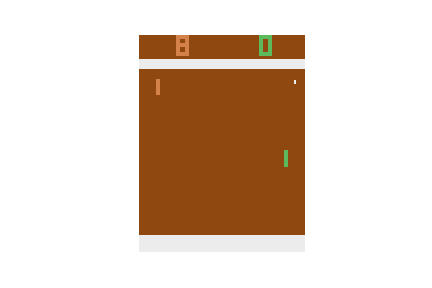
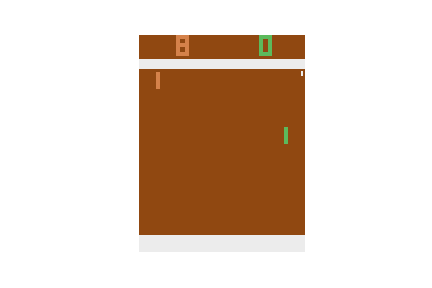
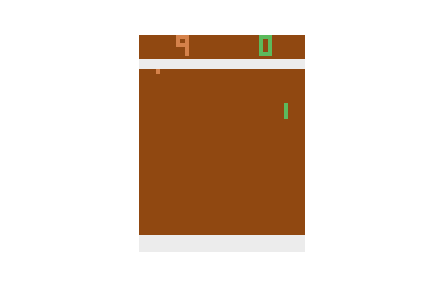
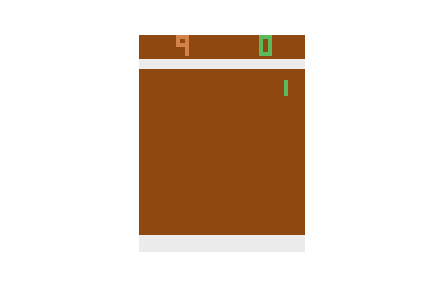
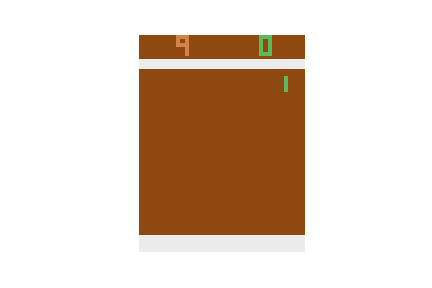
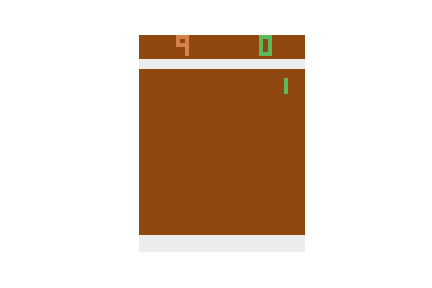
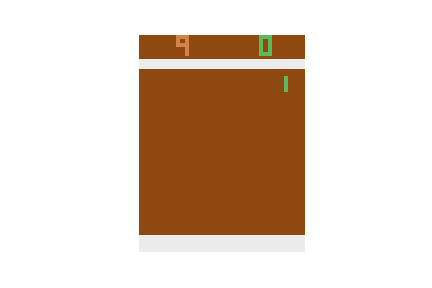
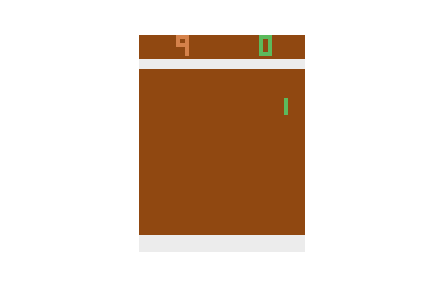
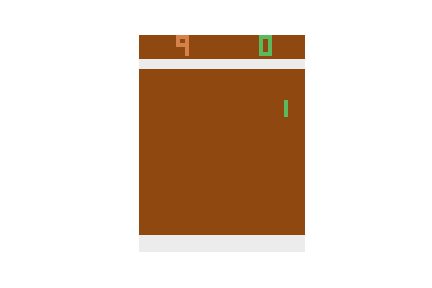
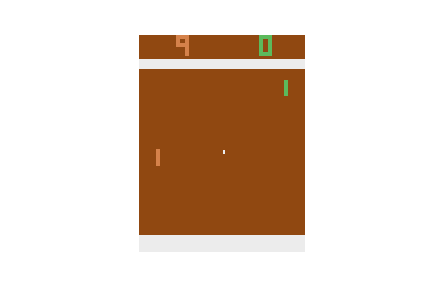
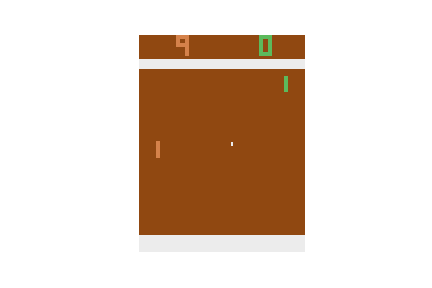
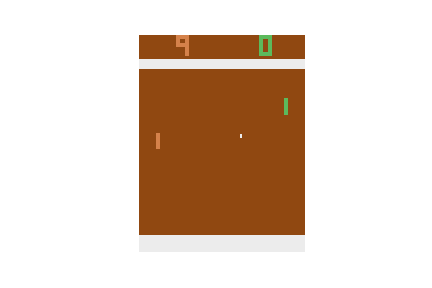
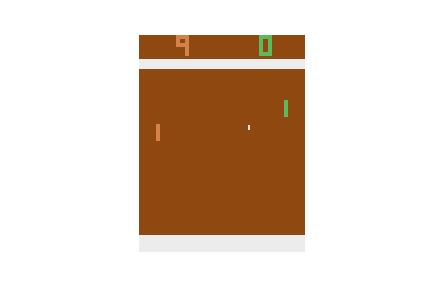
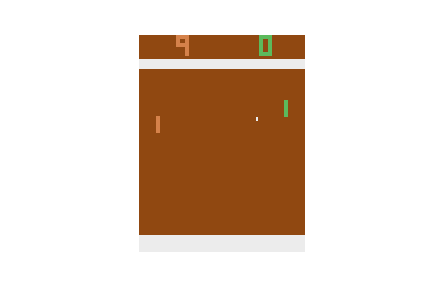
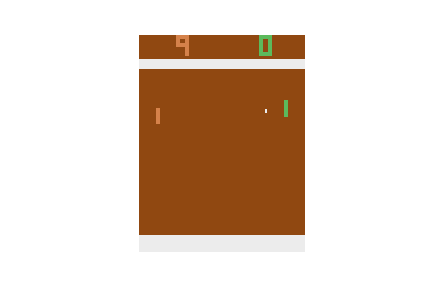
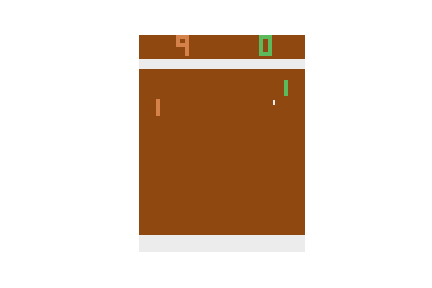
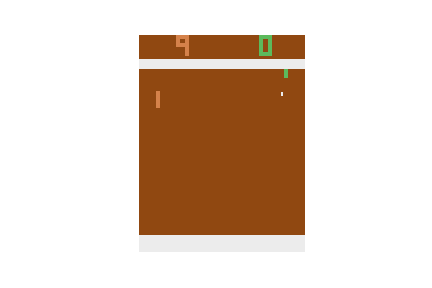
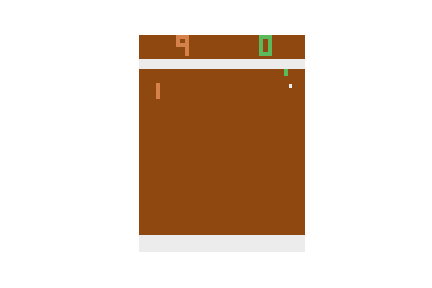
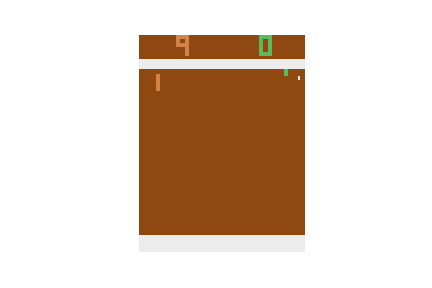
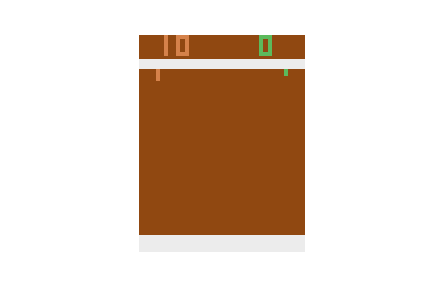
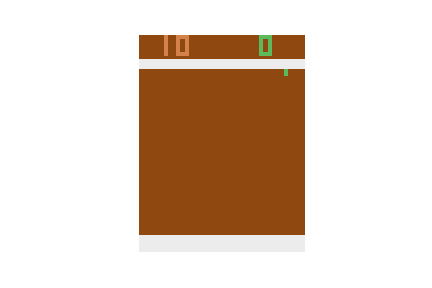
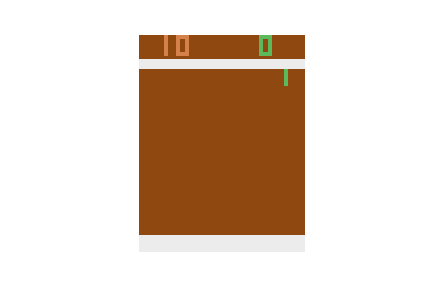
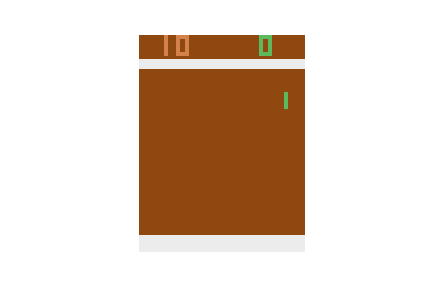
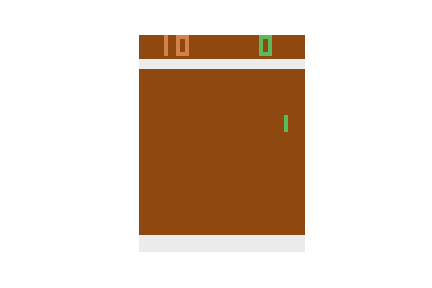
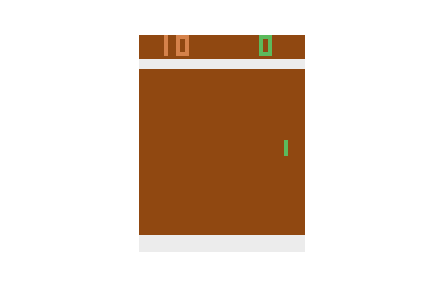
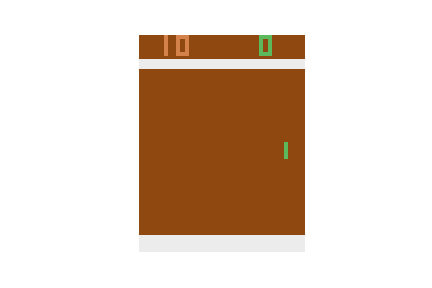
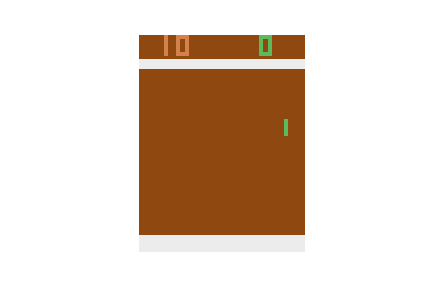
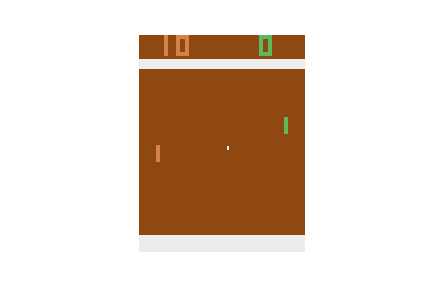
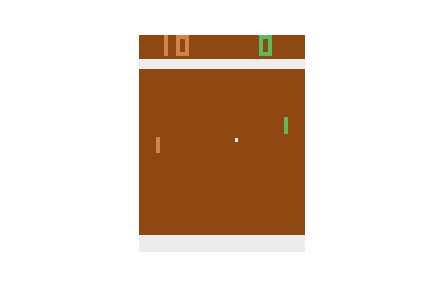
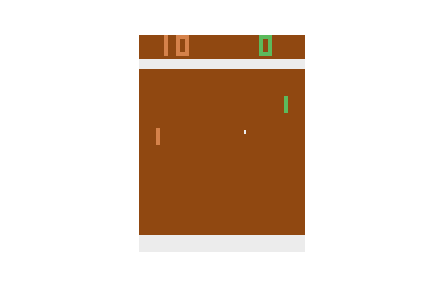
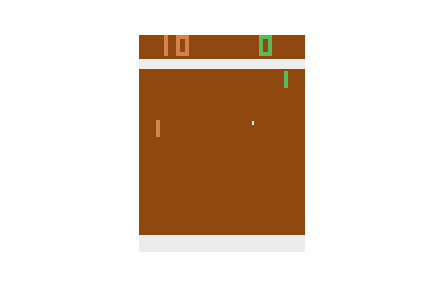
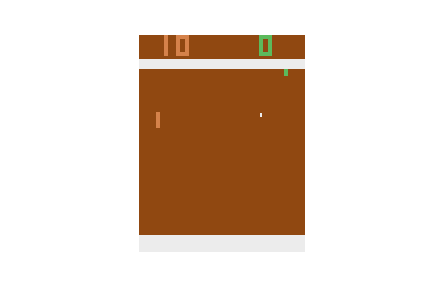
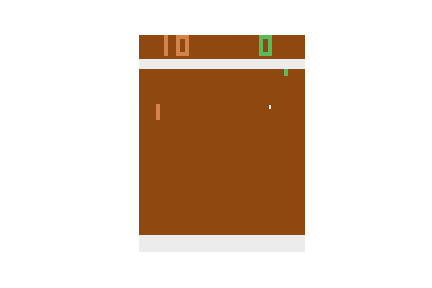
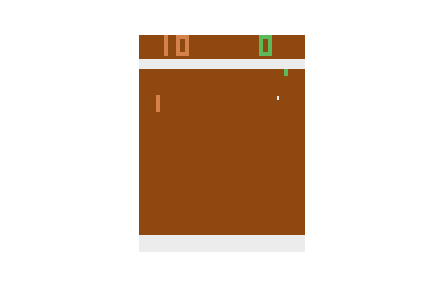
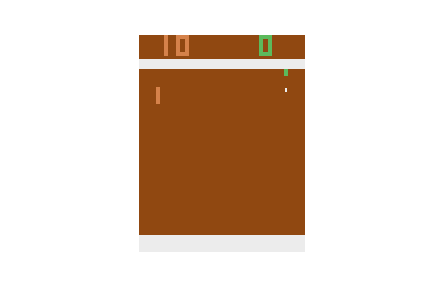
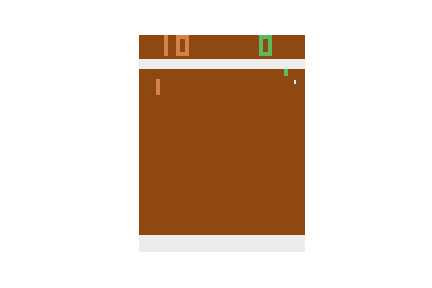
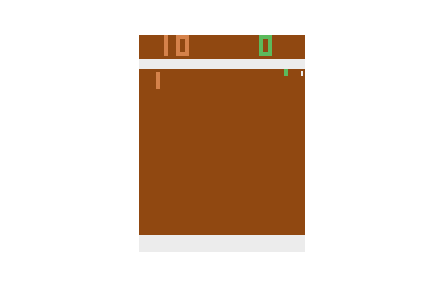
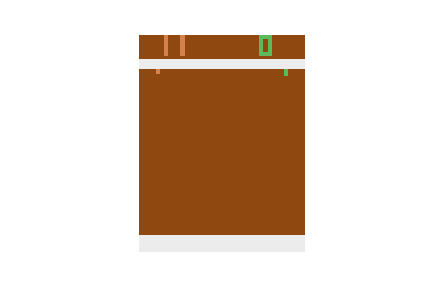
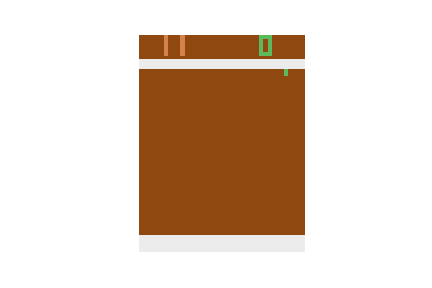
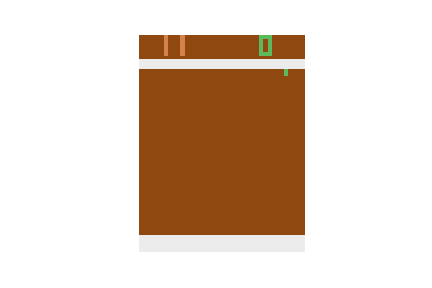
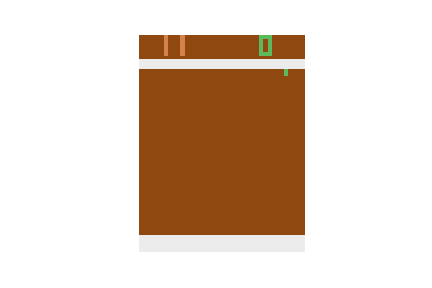
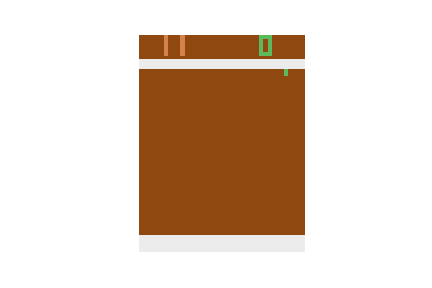
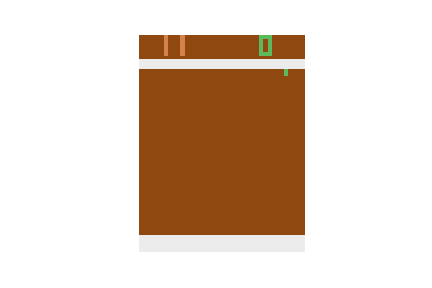
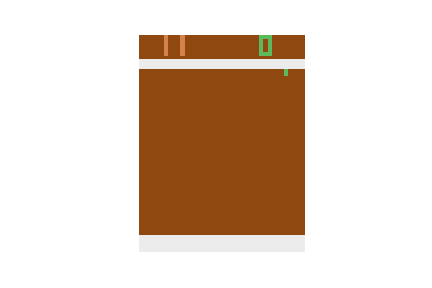
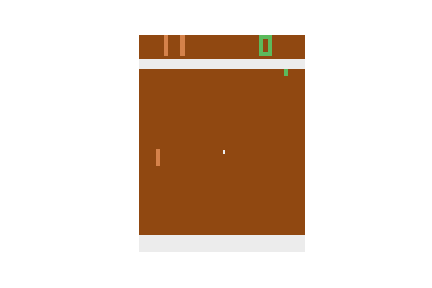
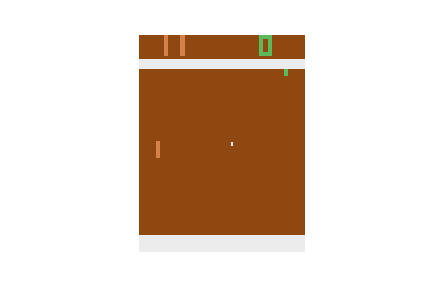
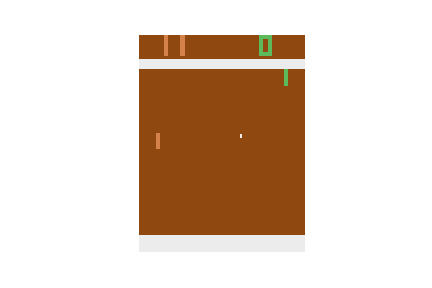
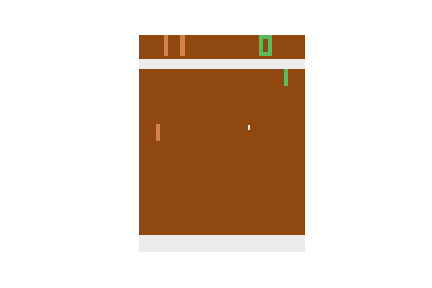
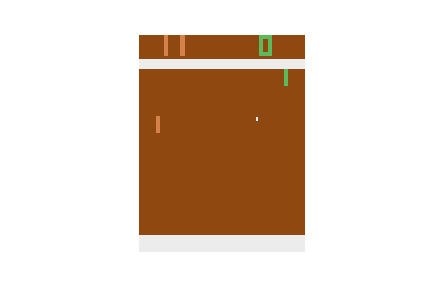
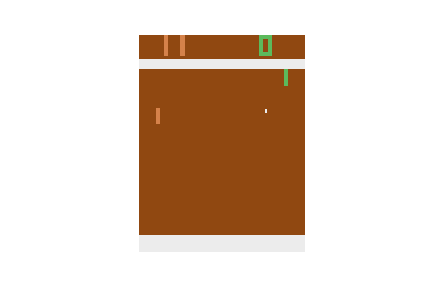
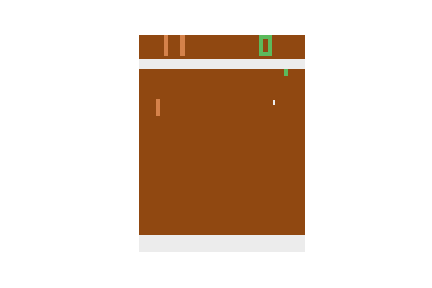
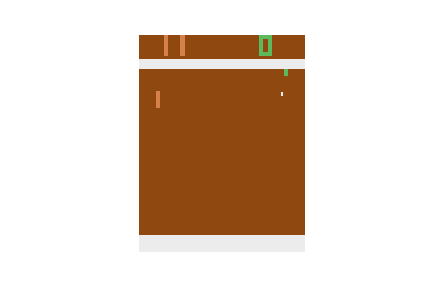
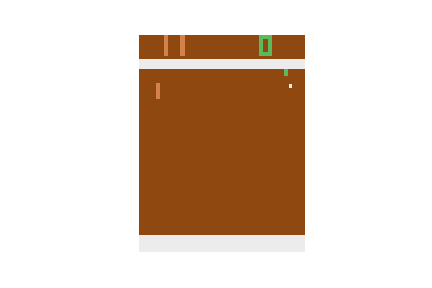
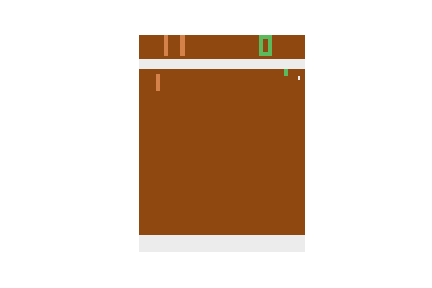
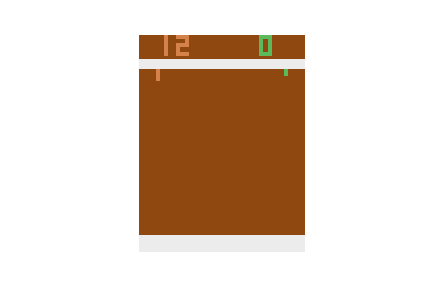
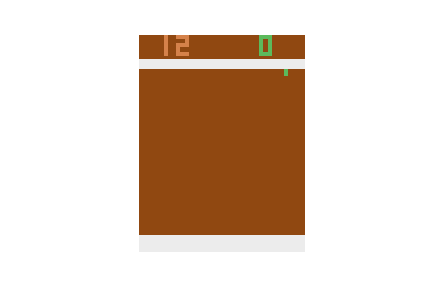
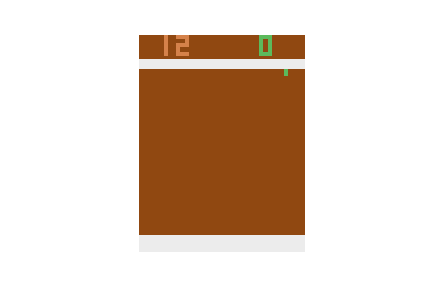
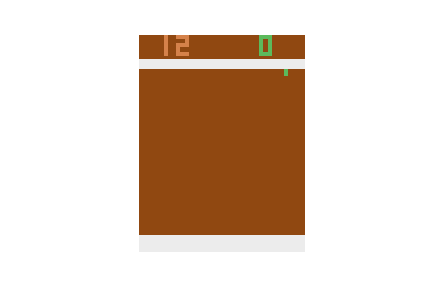
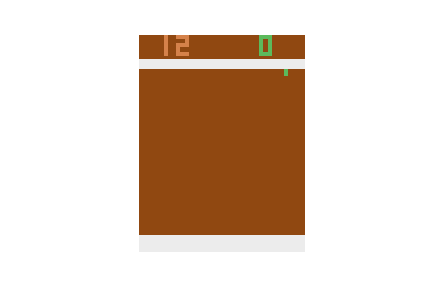
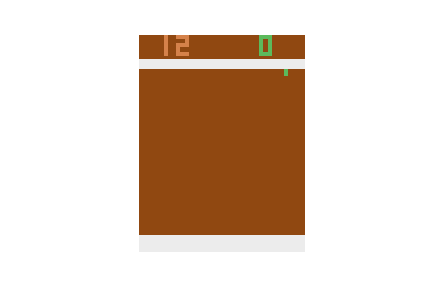
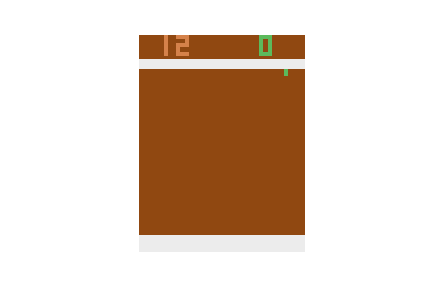
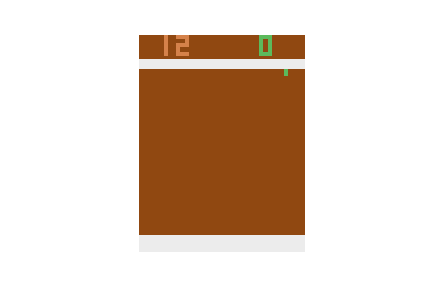
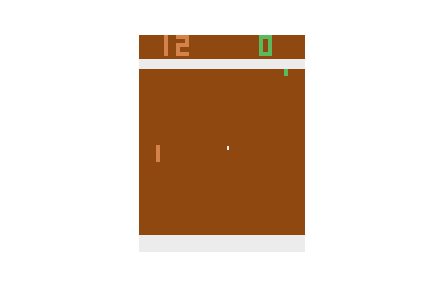
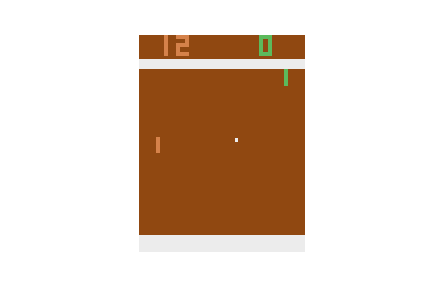
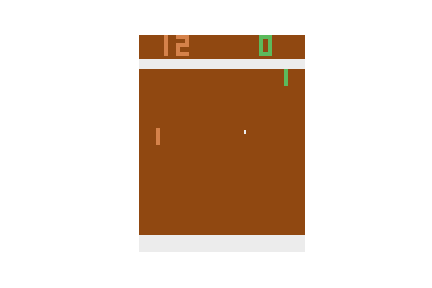
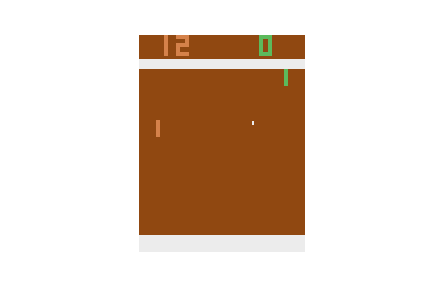
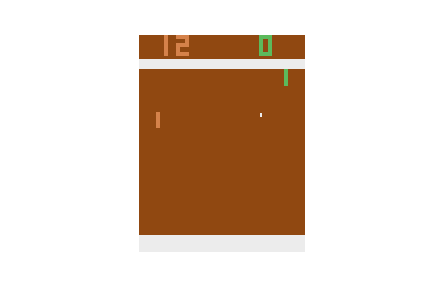
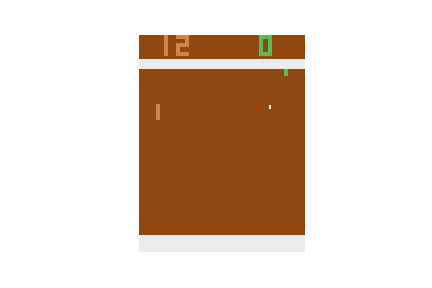
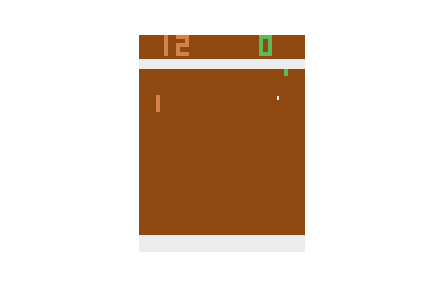
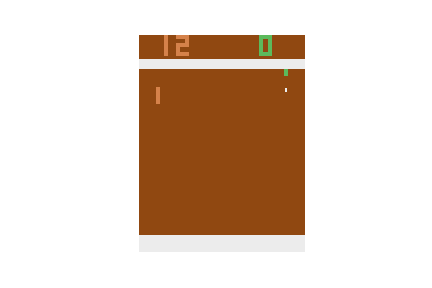
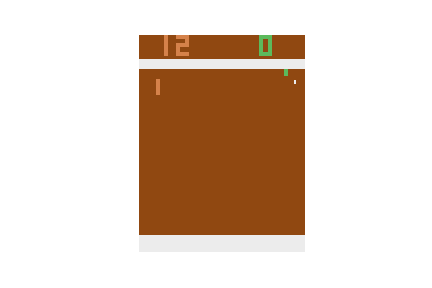
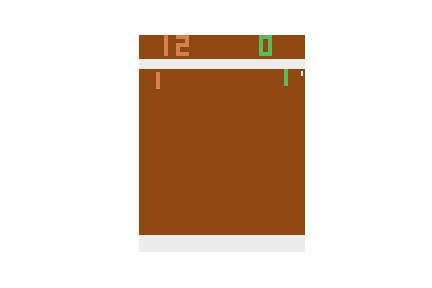
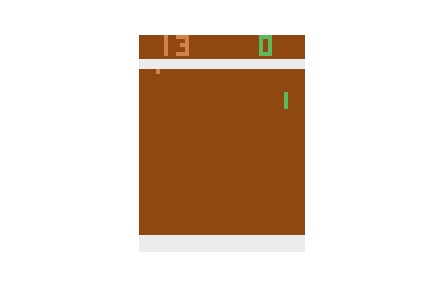
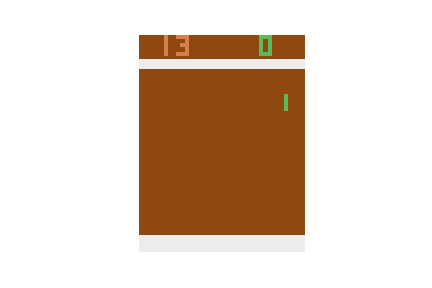
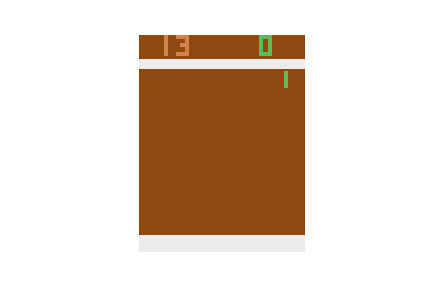
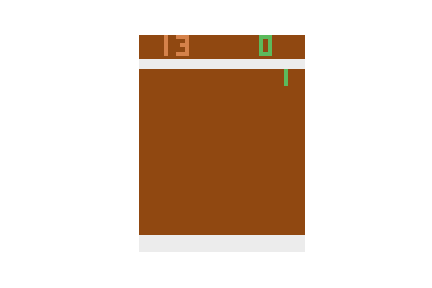
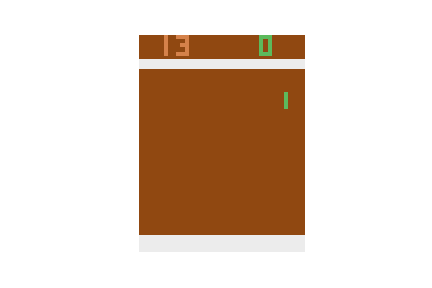
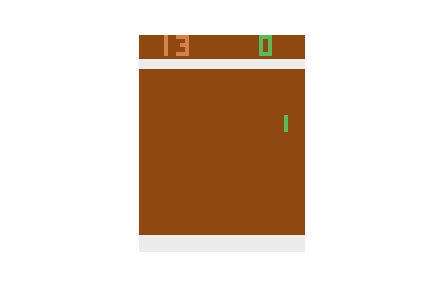
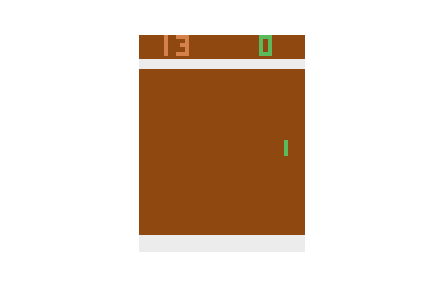
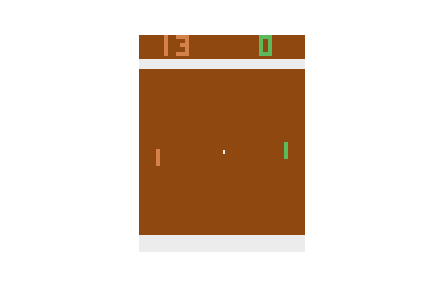
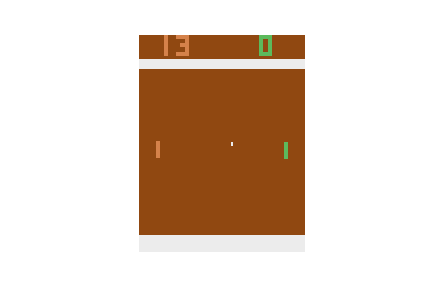
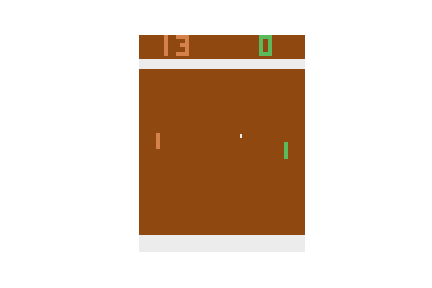
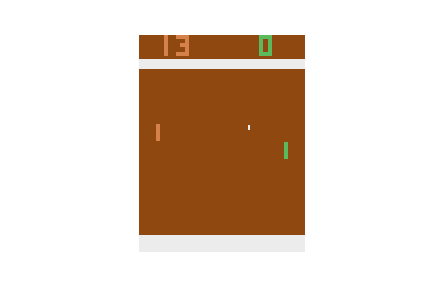
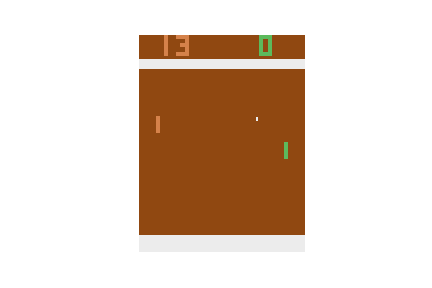
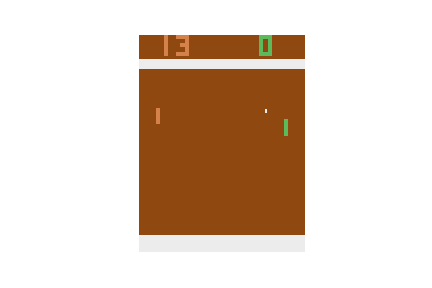
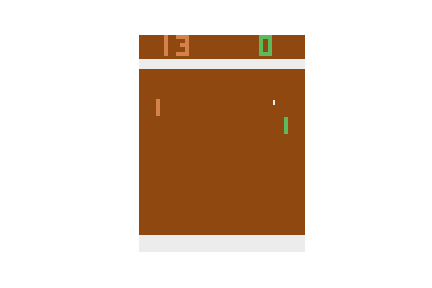
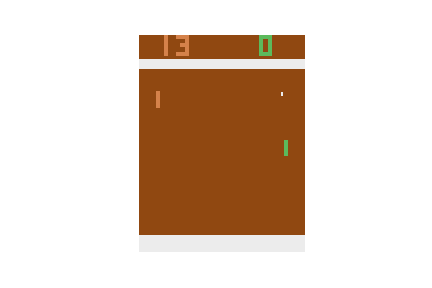
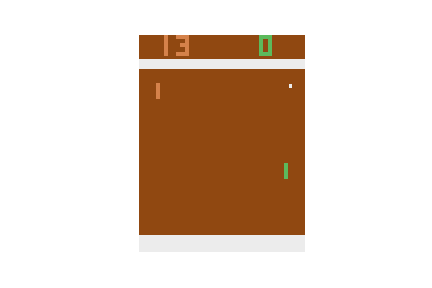
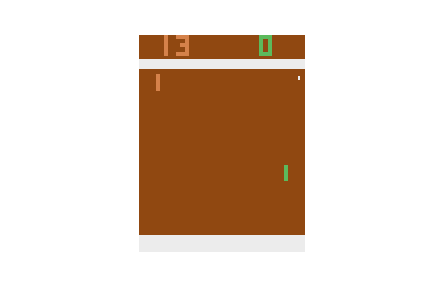
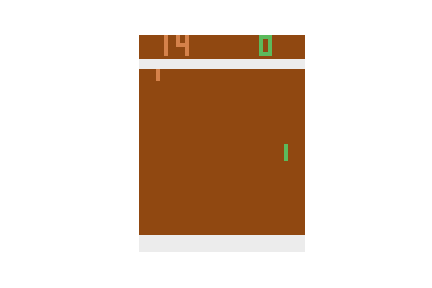
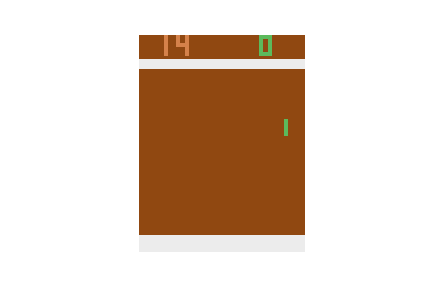
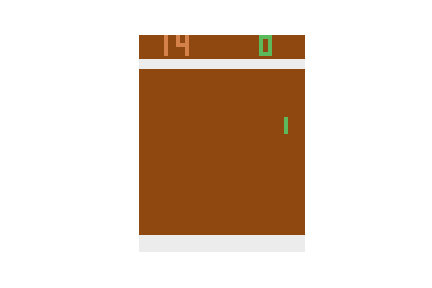
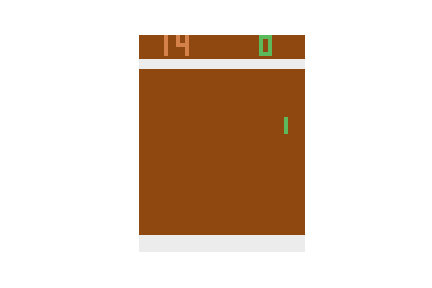
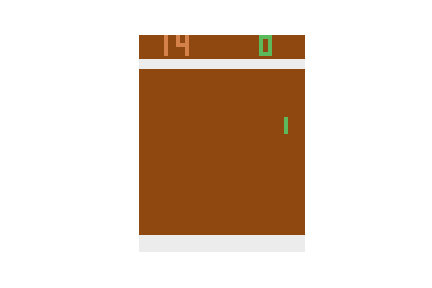
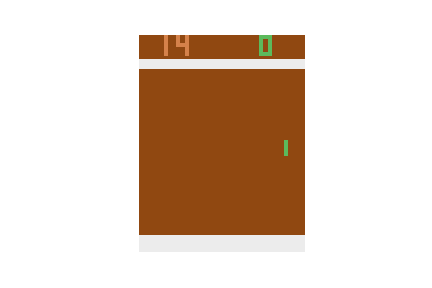
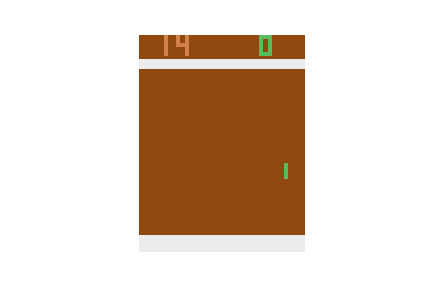
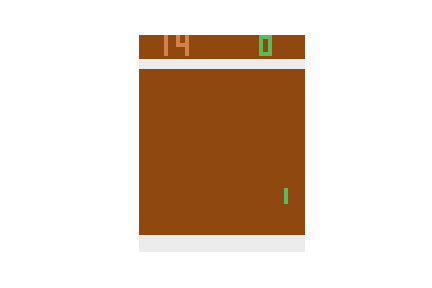
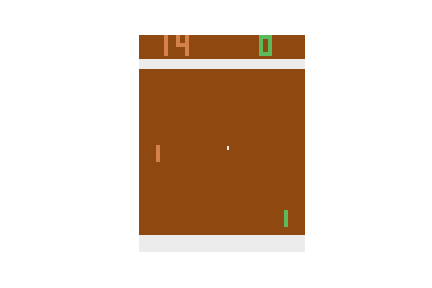
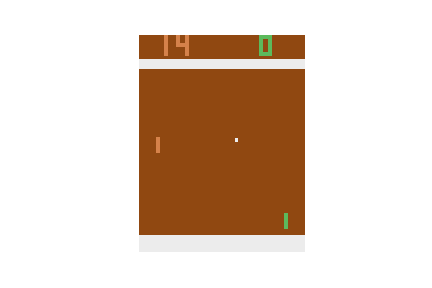
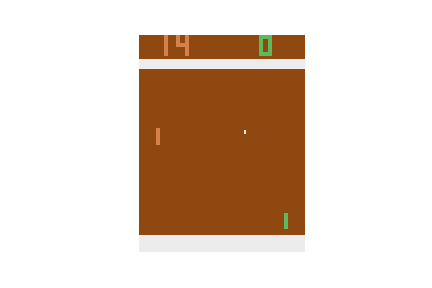
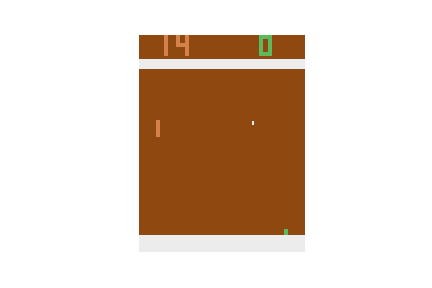
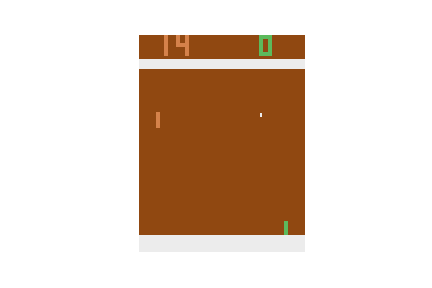
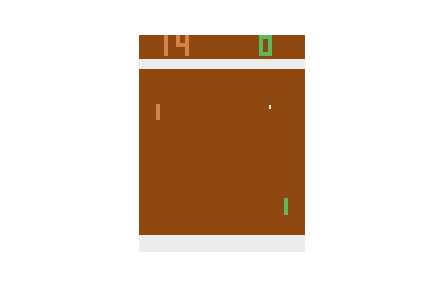
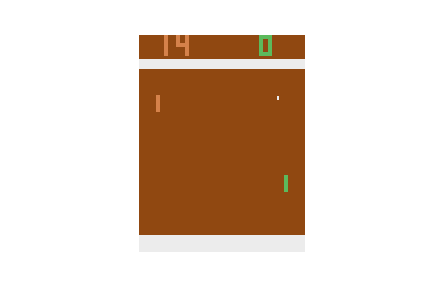
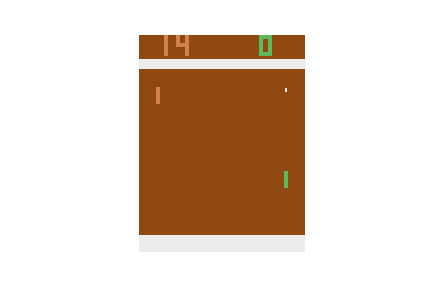
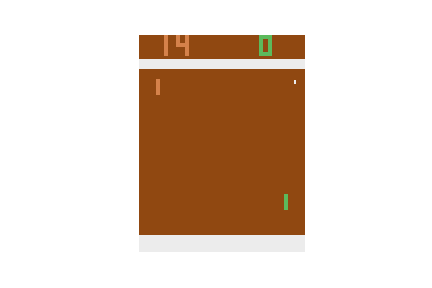
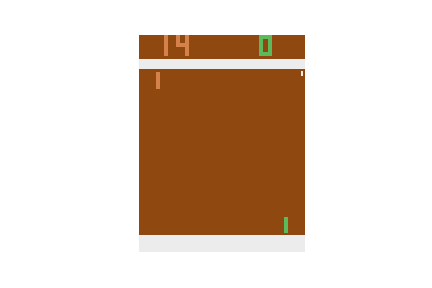
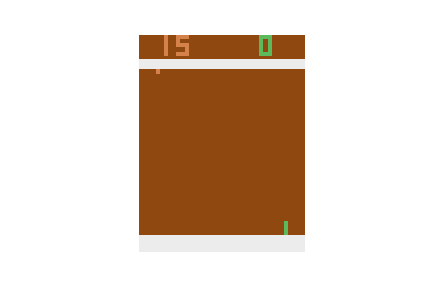
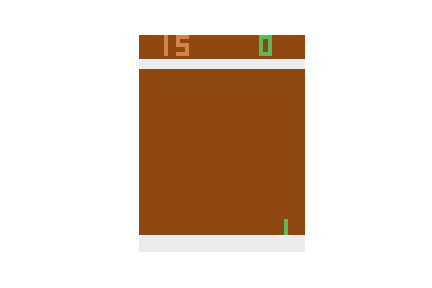
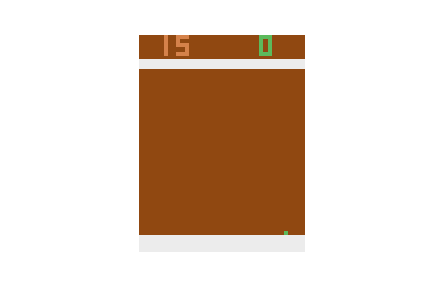
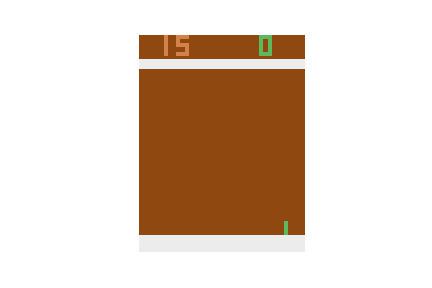
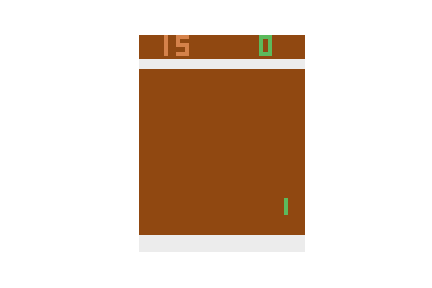
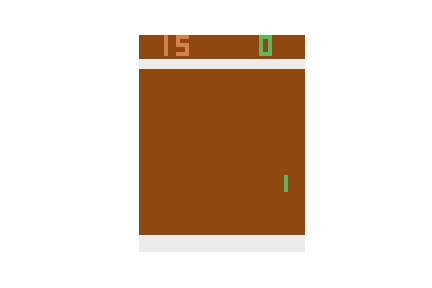
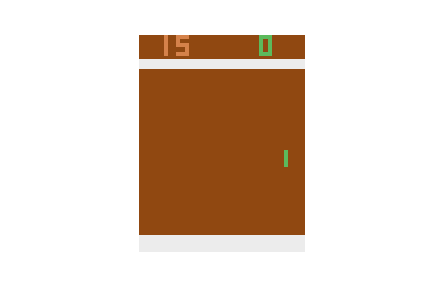
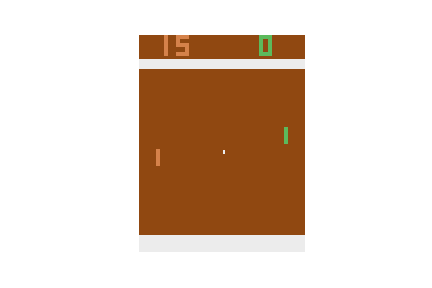
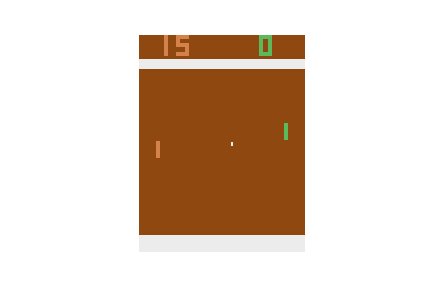
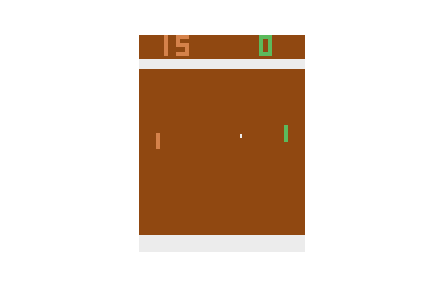
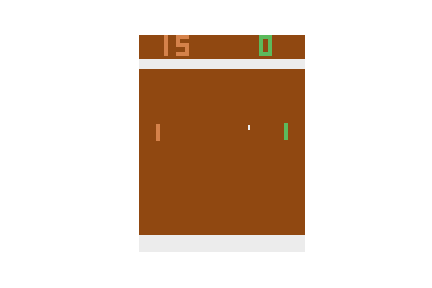
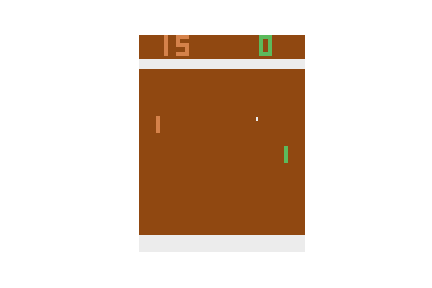
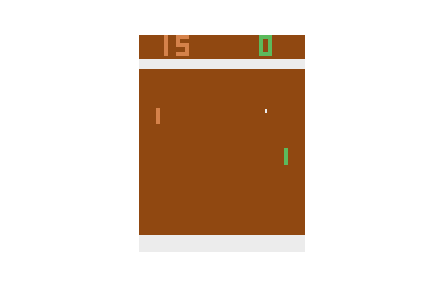
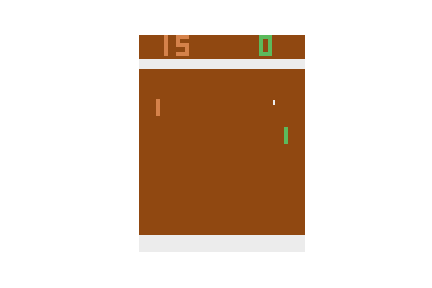
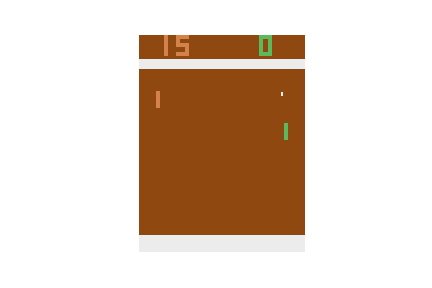
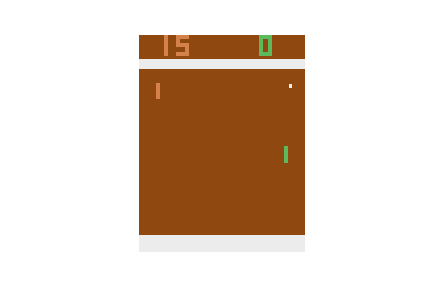
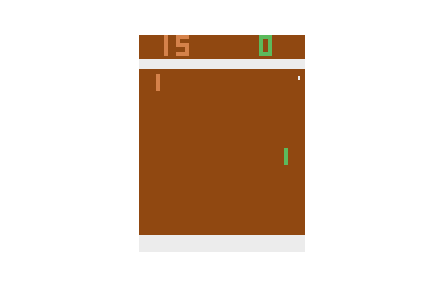
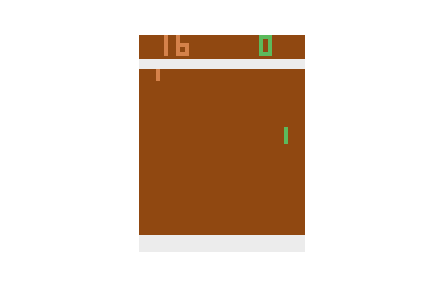
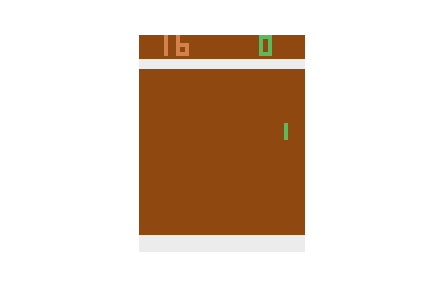
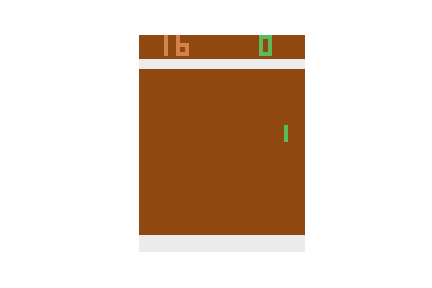
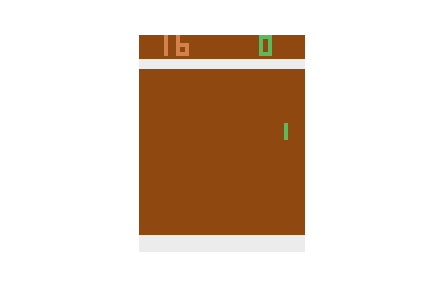
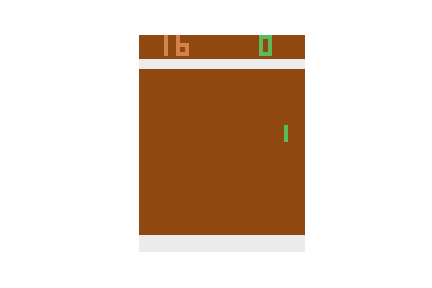
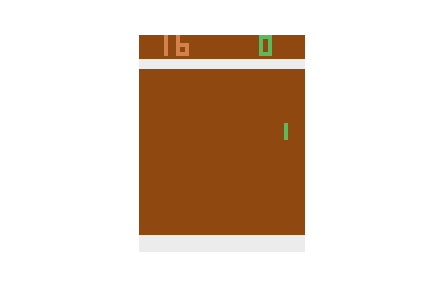
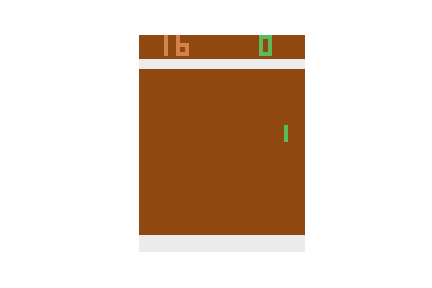
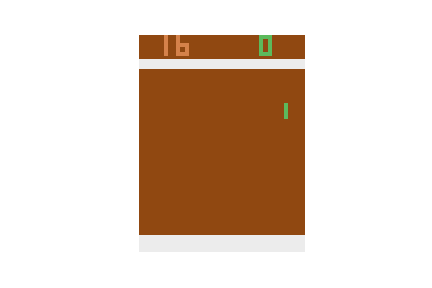
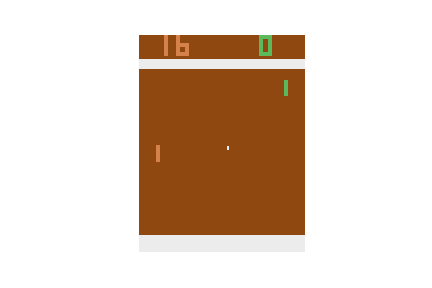
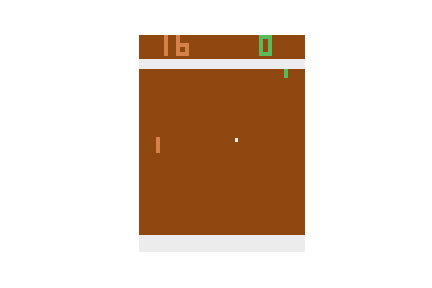
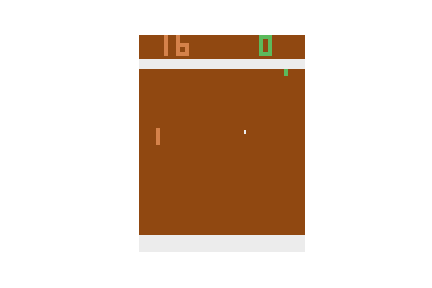
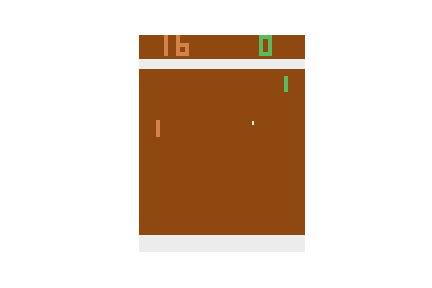
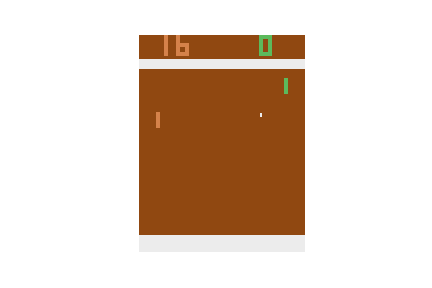
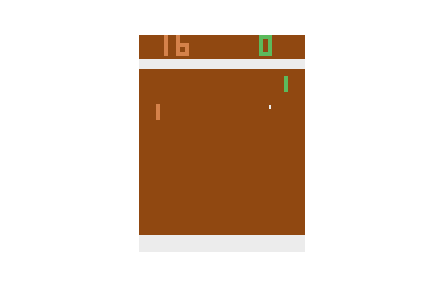
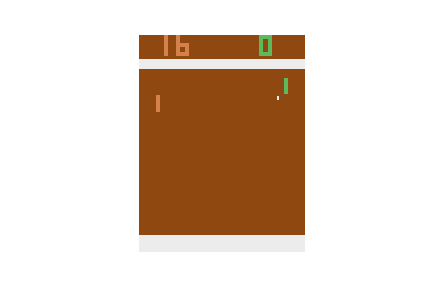
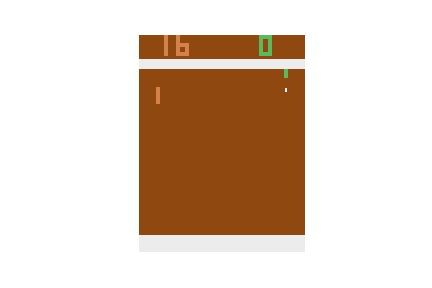
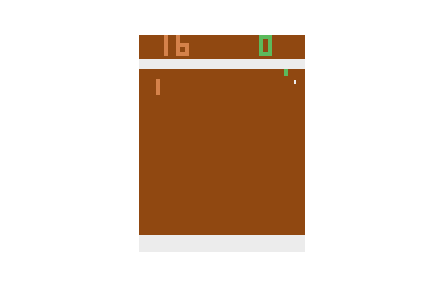
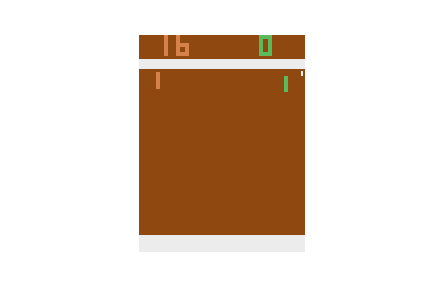
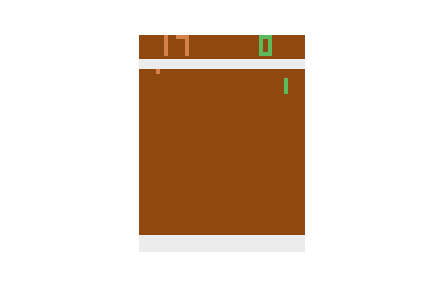
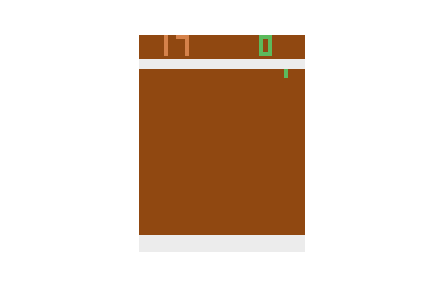
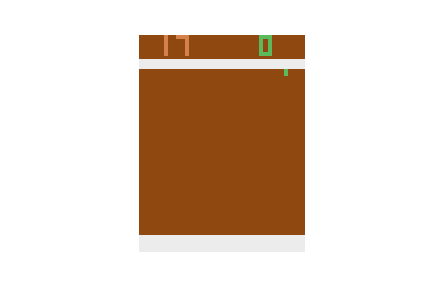
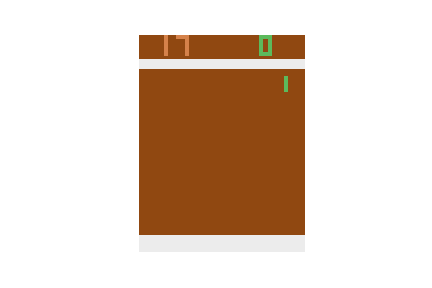
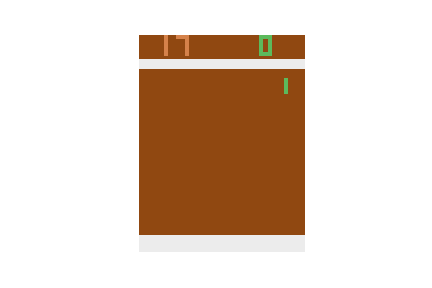
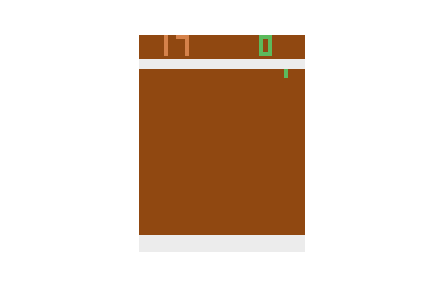
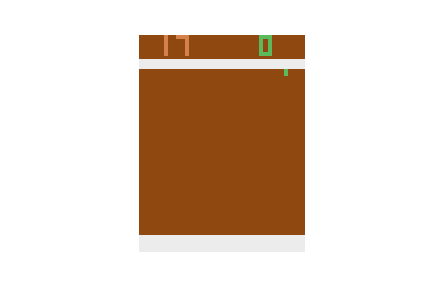
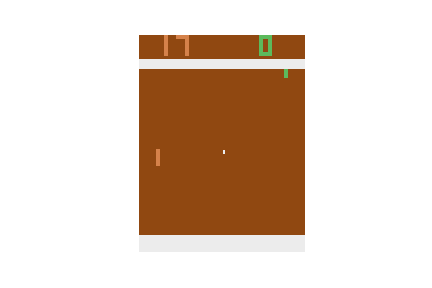
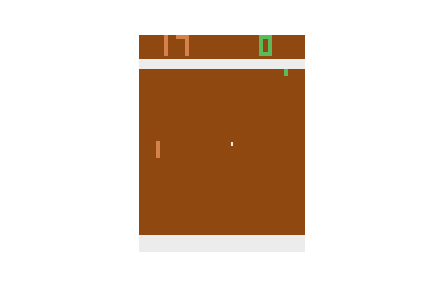
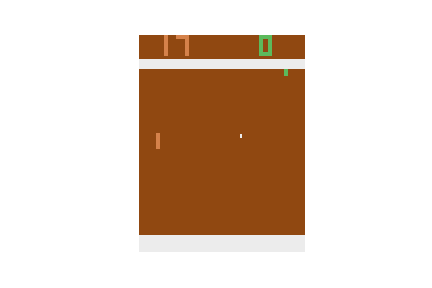
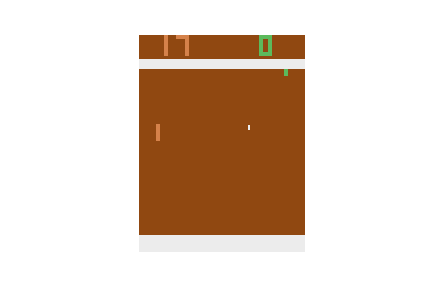
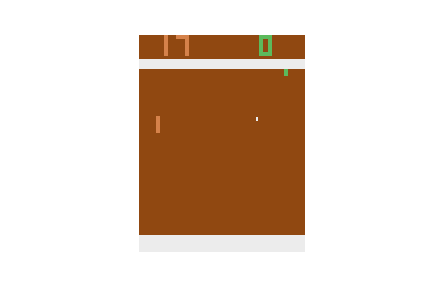
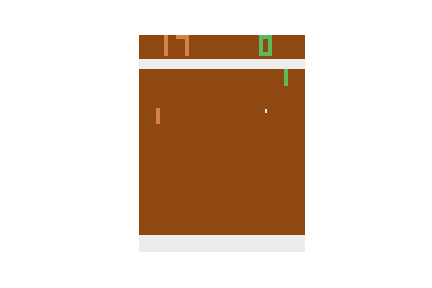
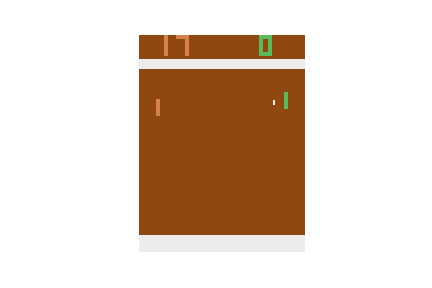
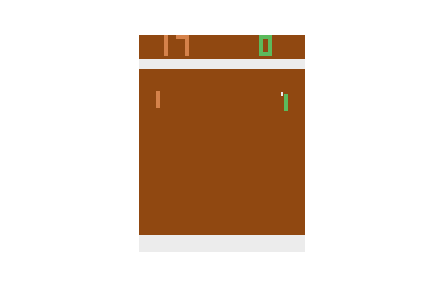
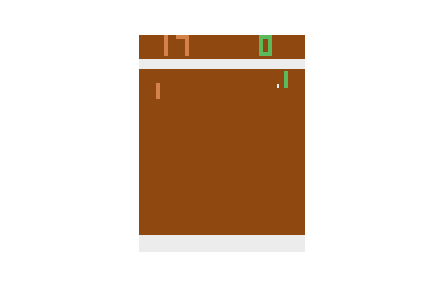
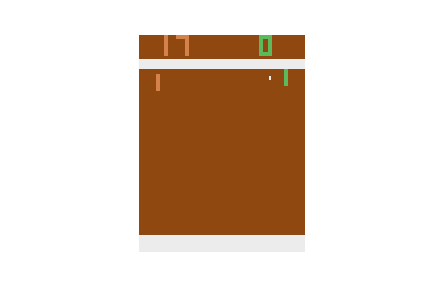
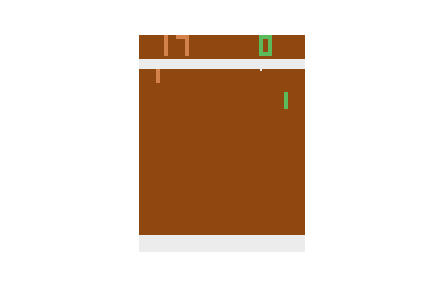
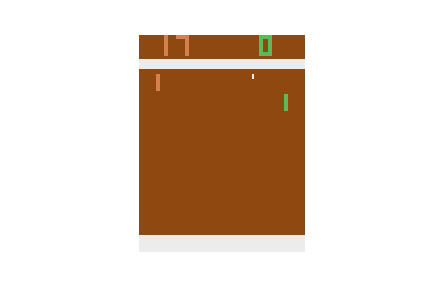
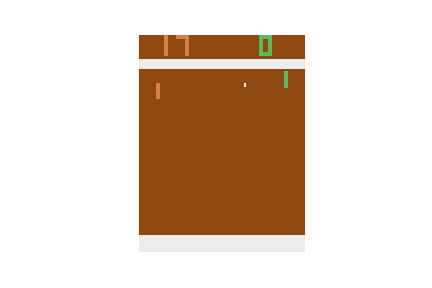
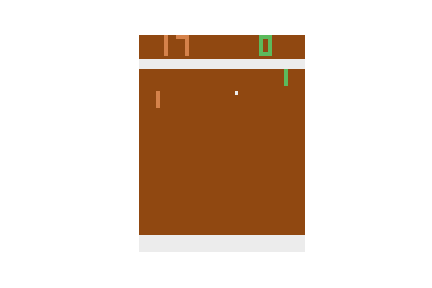
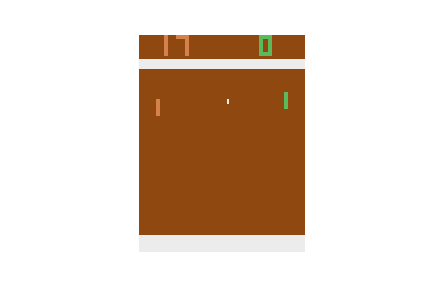
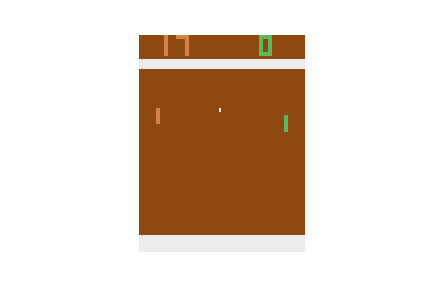
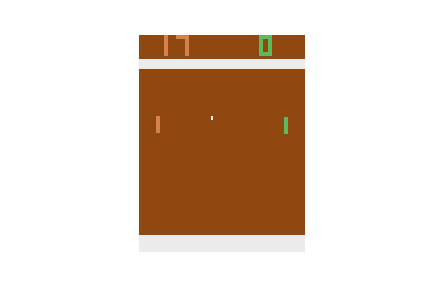
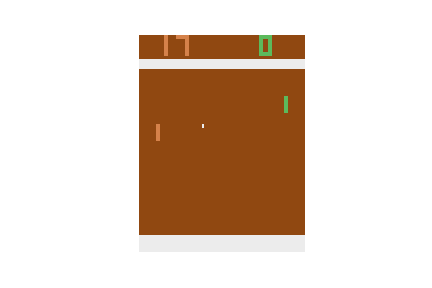
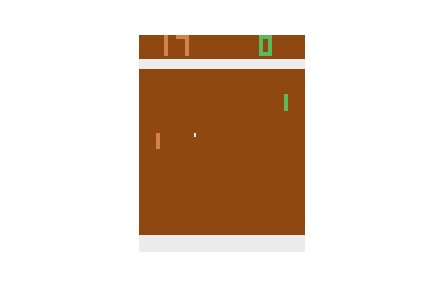
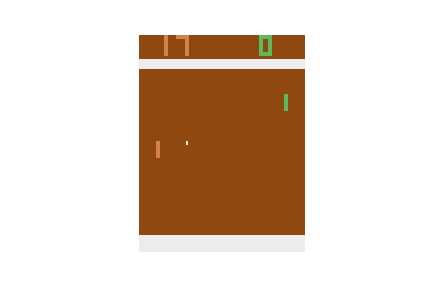
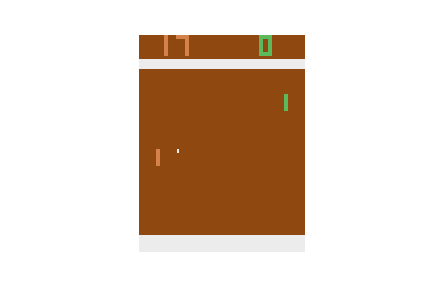
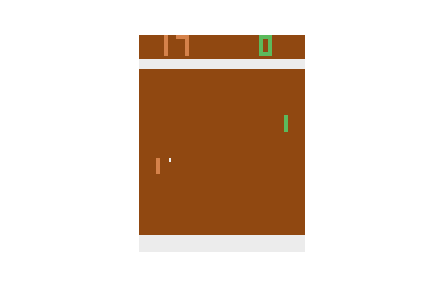
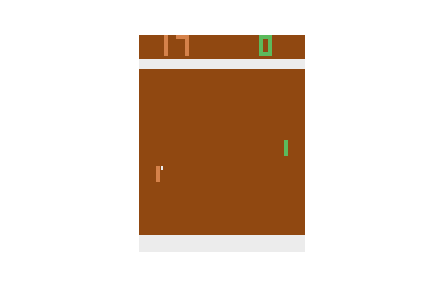
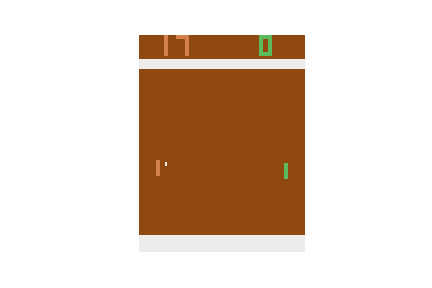
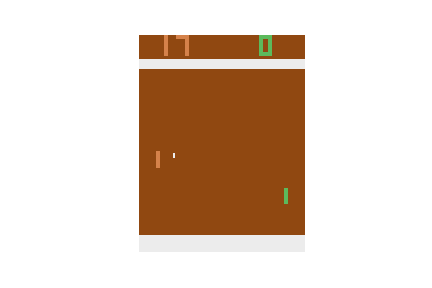
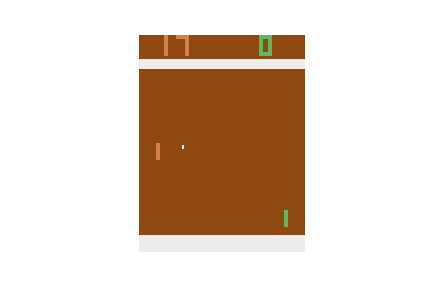
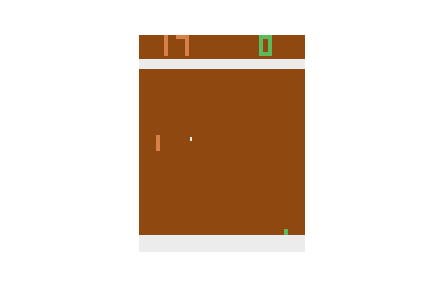
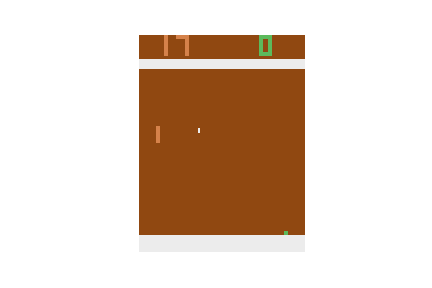
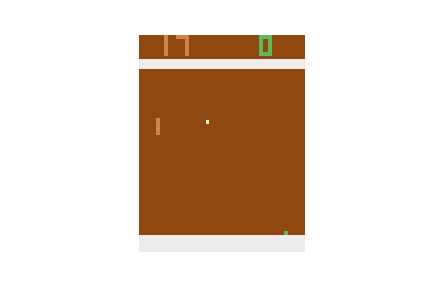
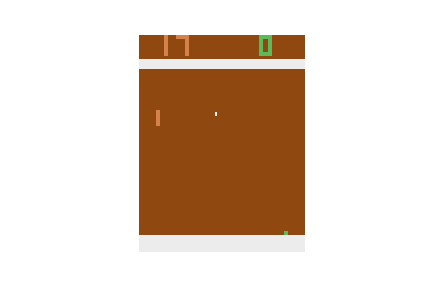
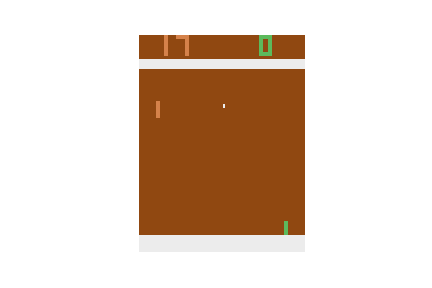
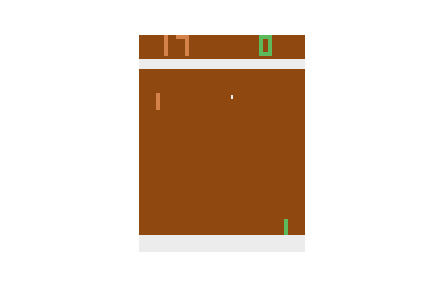
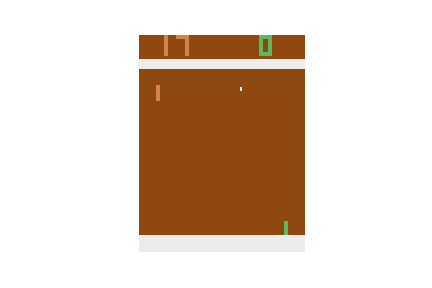
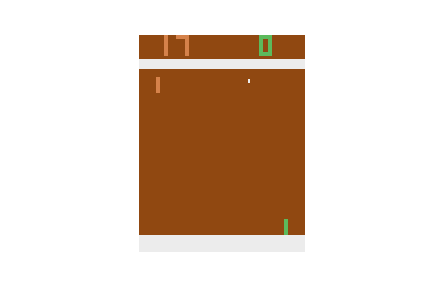
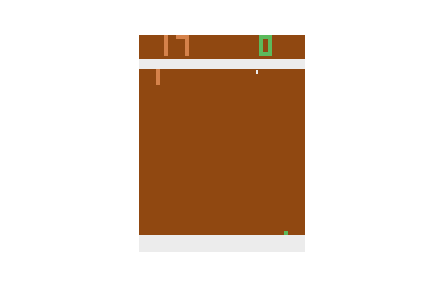
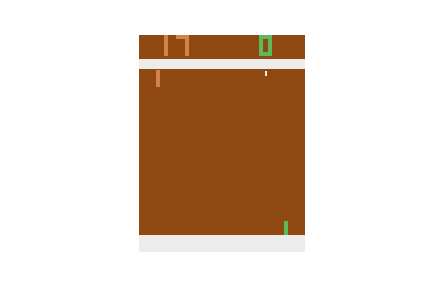
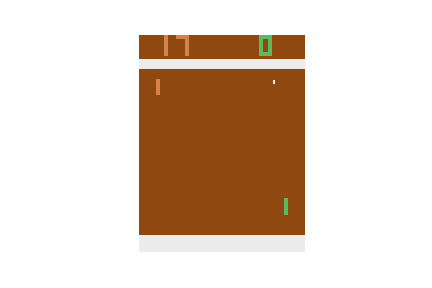
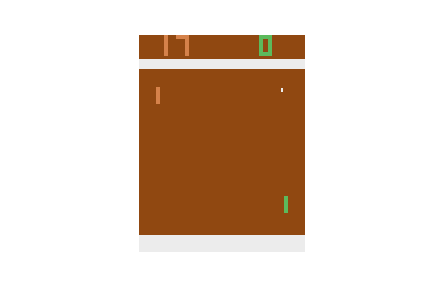
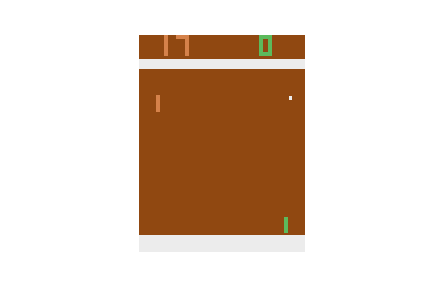
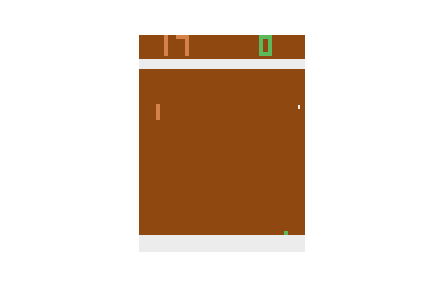
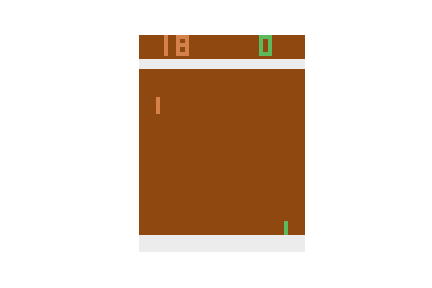
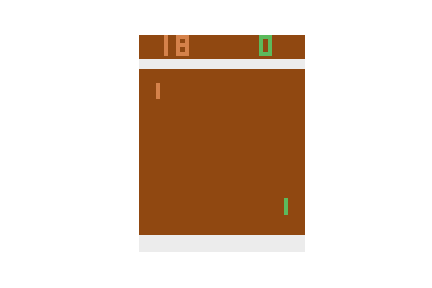
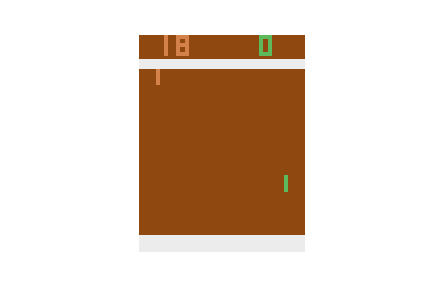
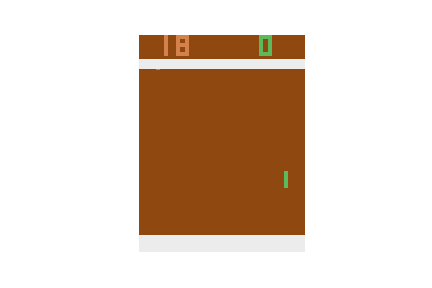
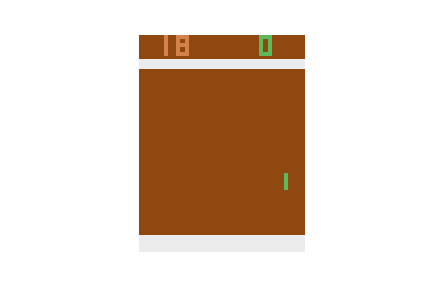
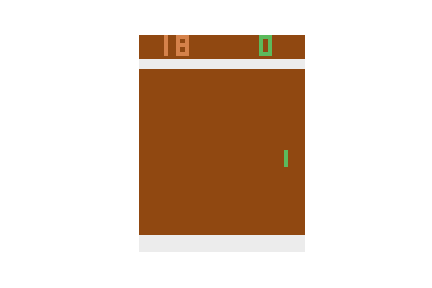
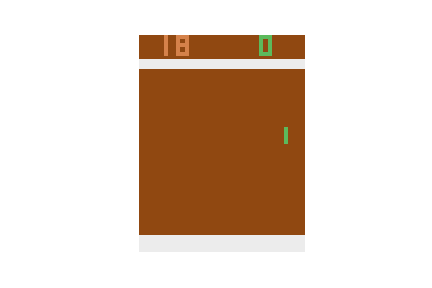
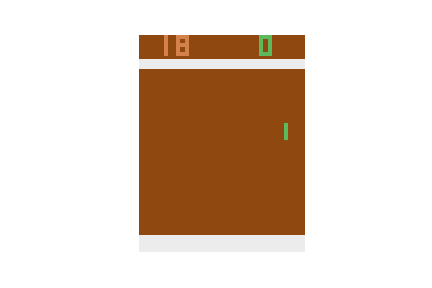
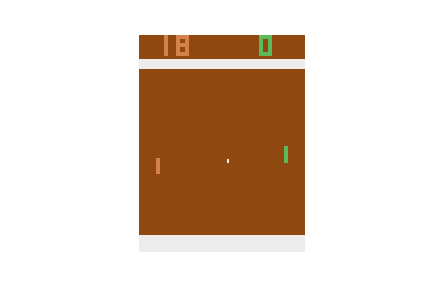
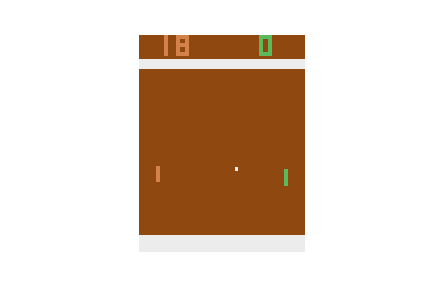
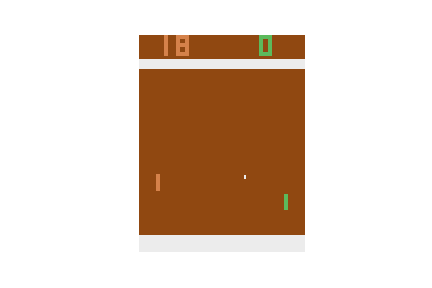
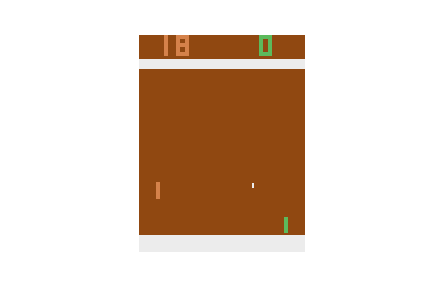
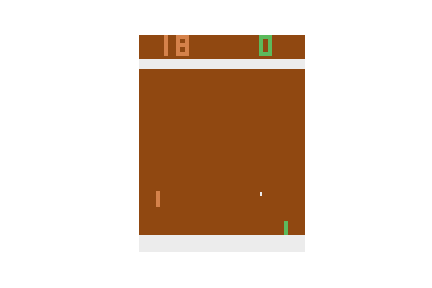
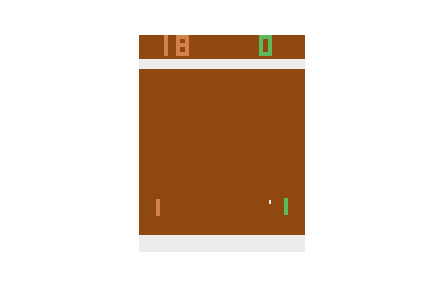
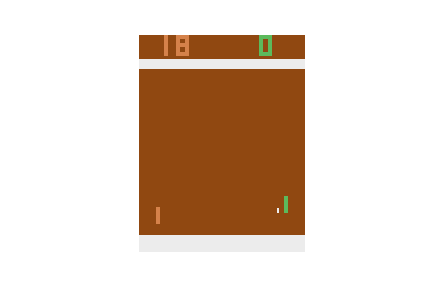
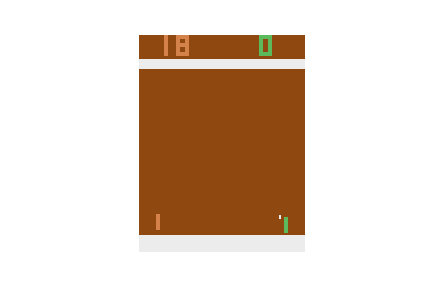
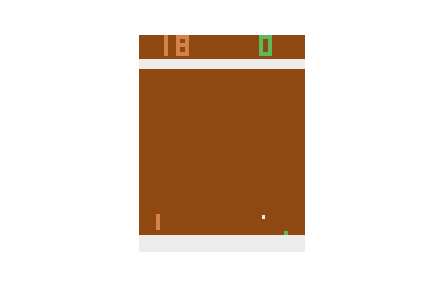
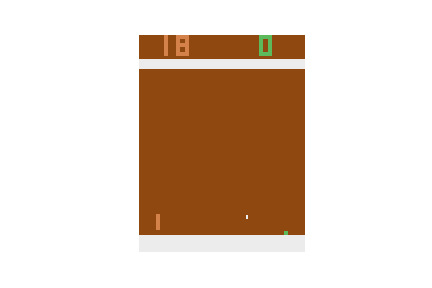
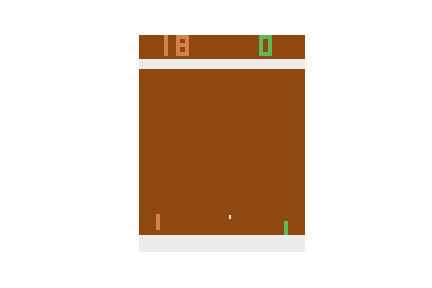
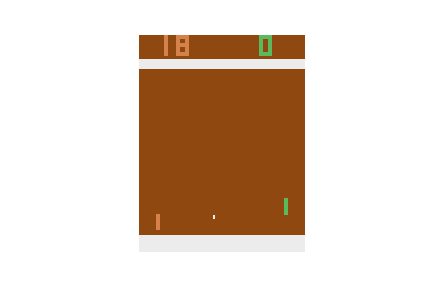
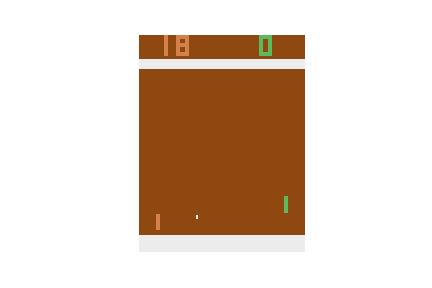
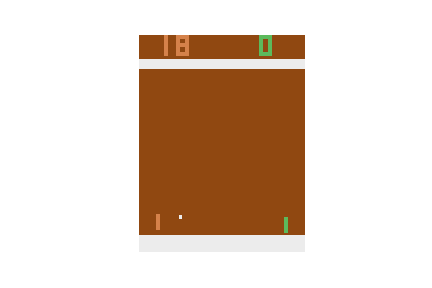
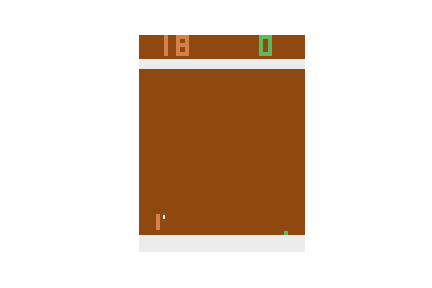
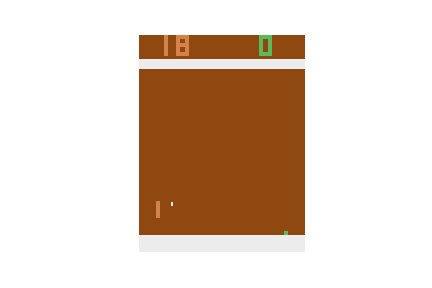
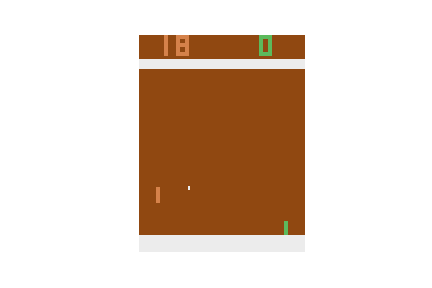
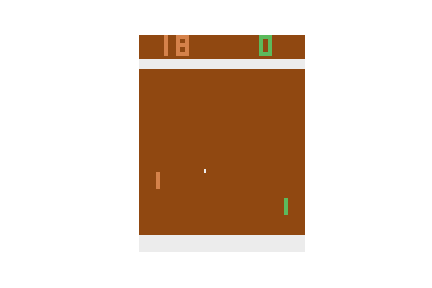
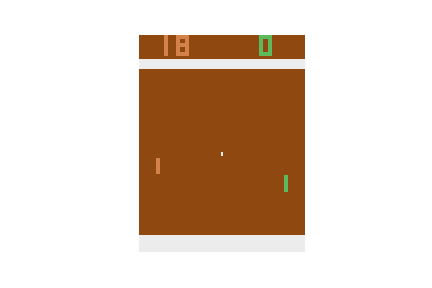
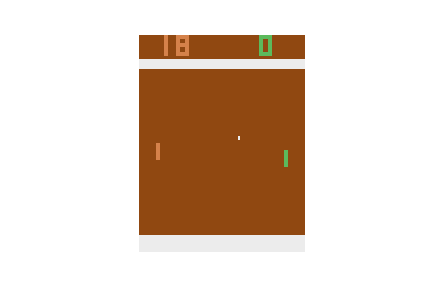
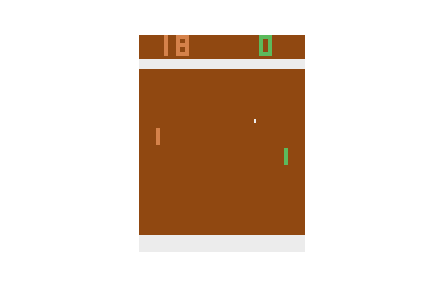
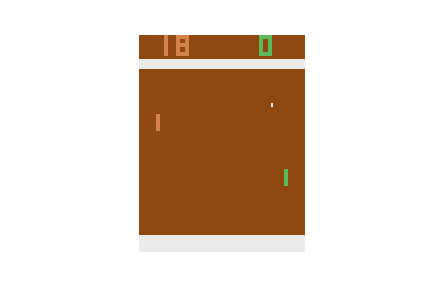
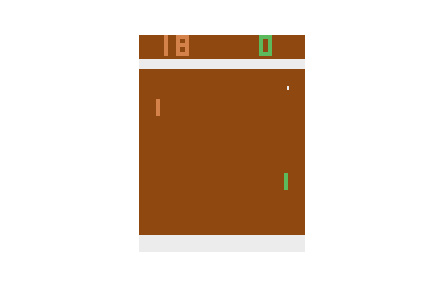
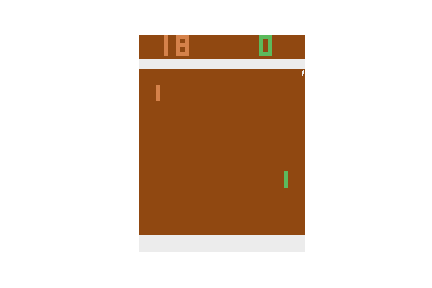
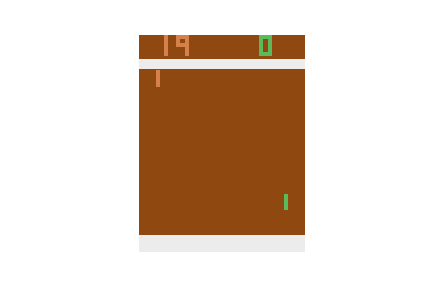
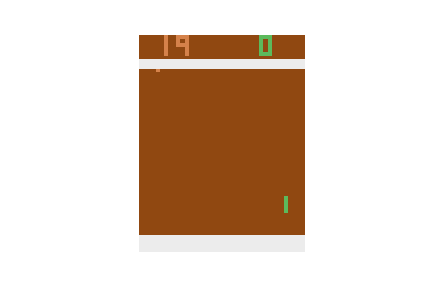
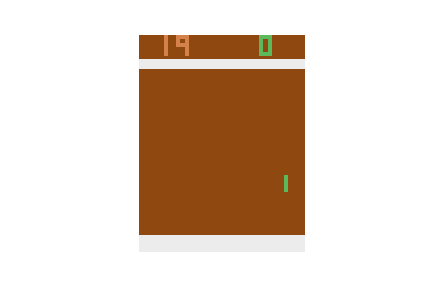
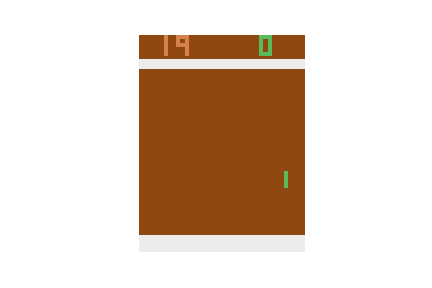
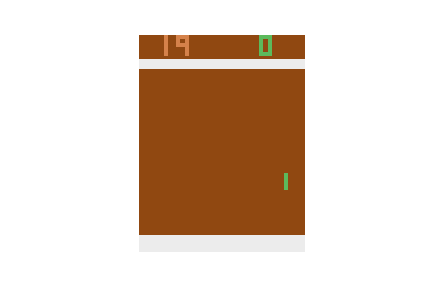
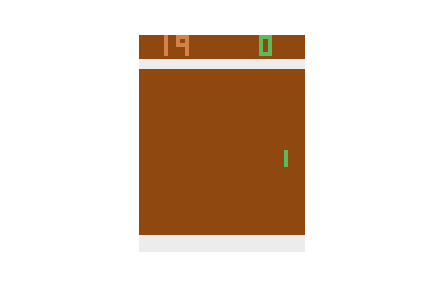
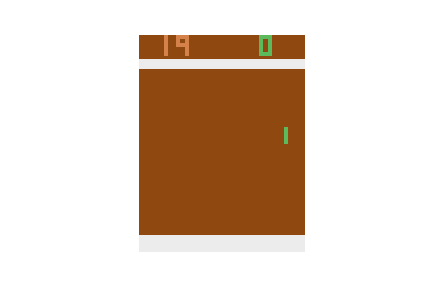
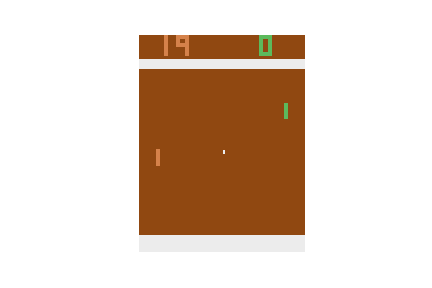
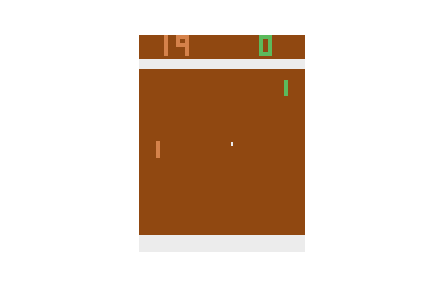
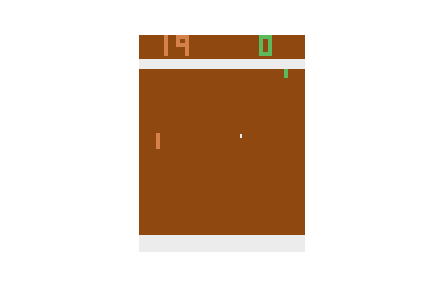
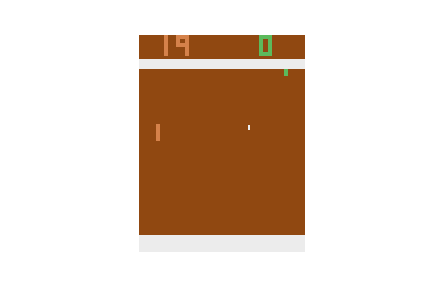
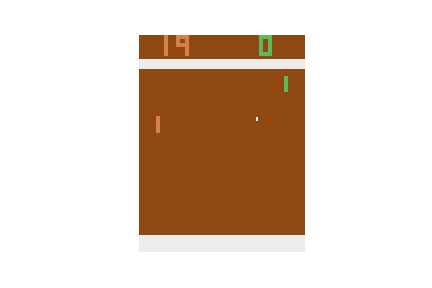
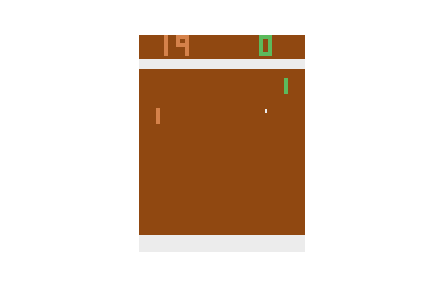
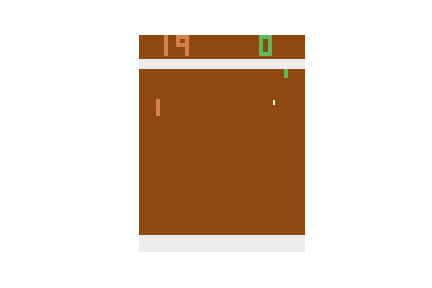
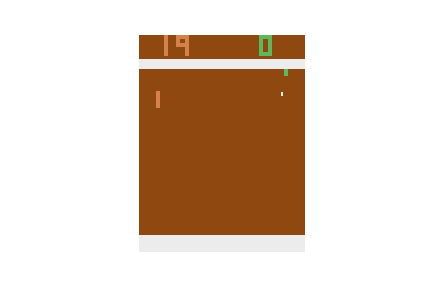
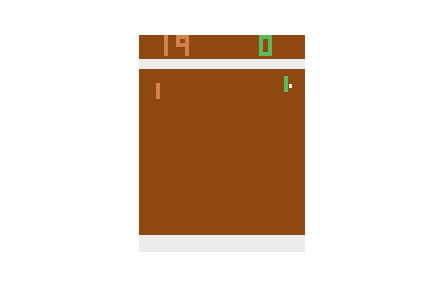
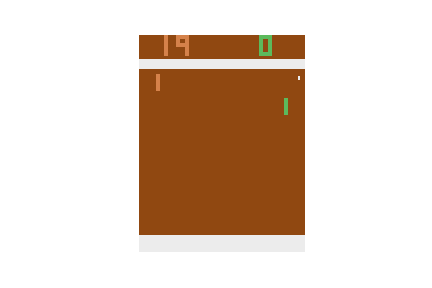
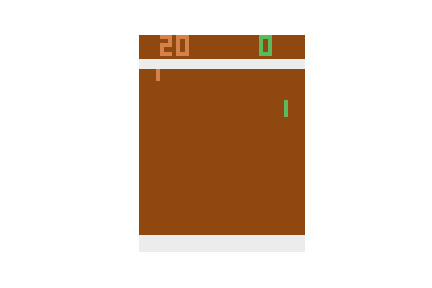
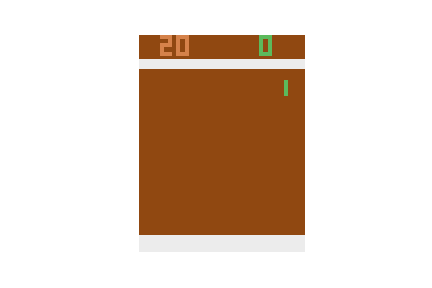
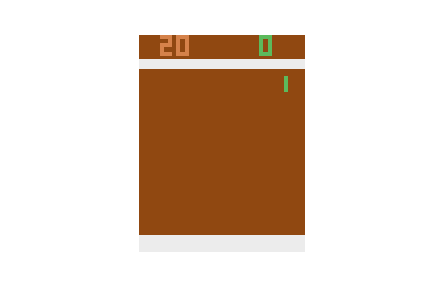
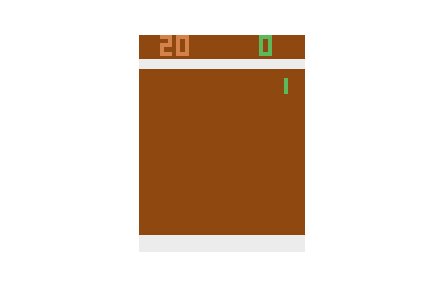
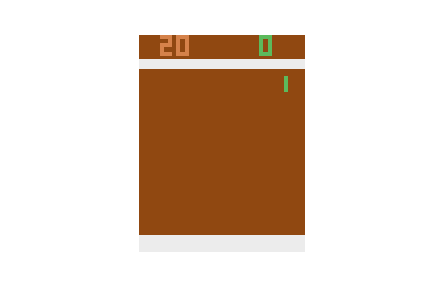
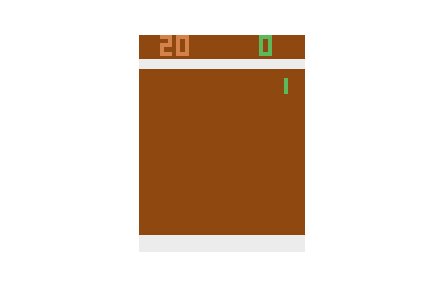
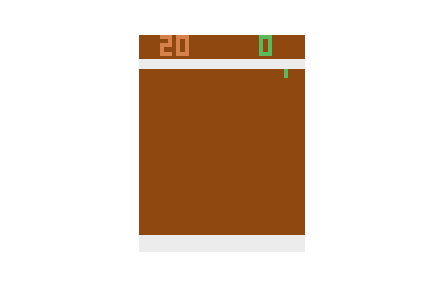
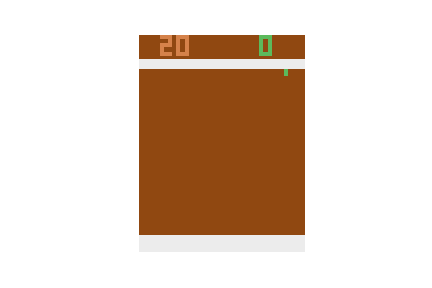
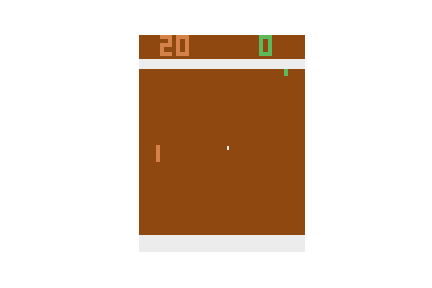
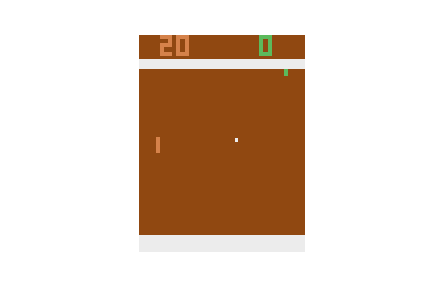
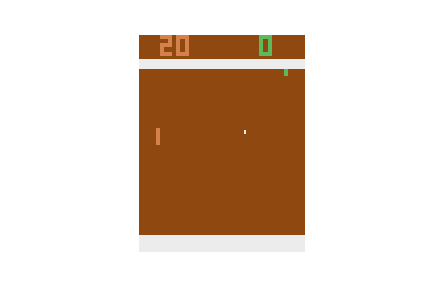
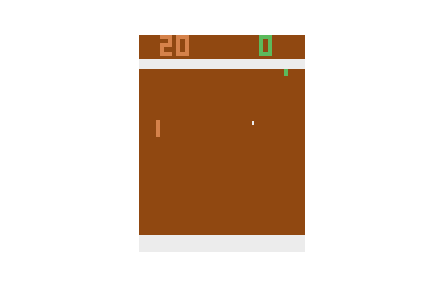
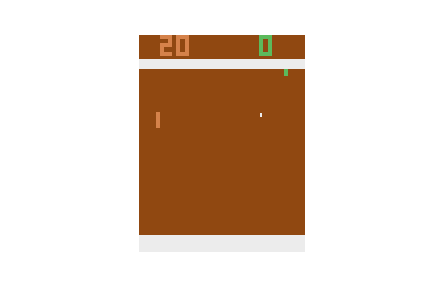
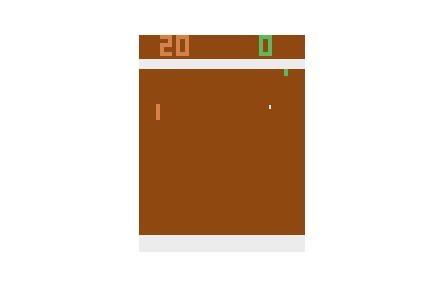
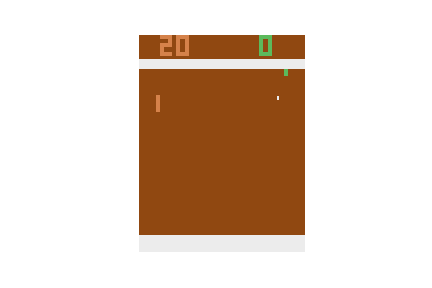
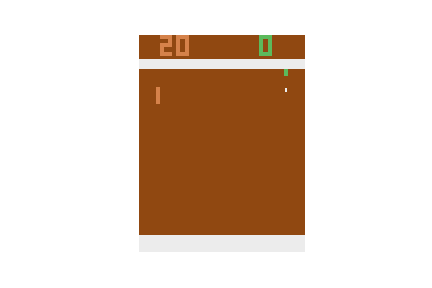
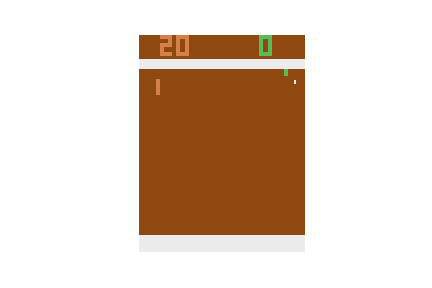
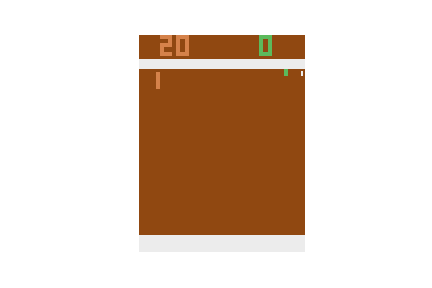

In [52]:
pong_utils.play(env, policy, time=500) 

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'pong_utils.Policy' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)



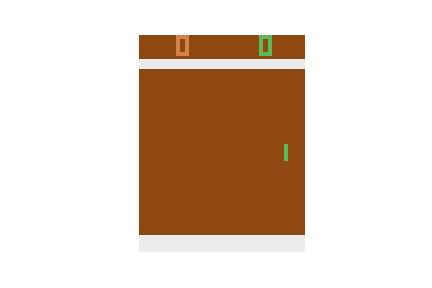
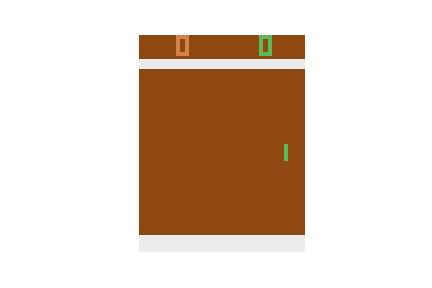
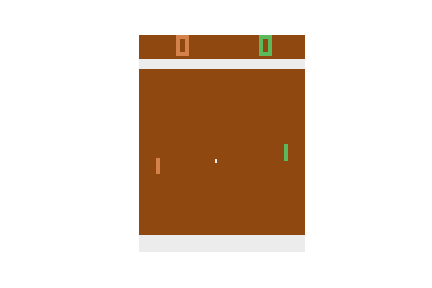
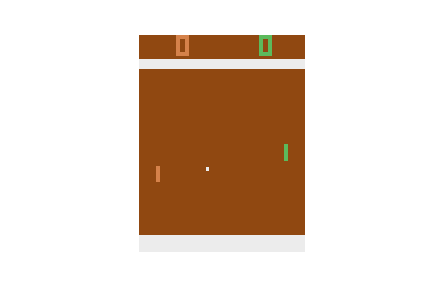
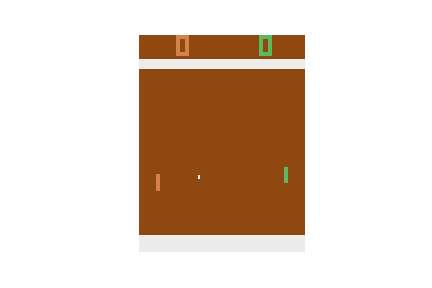
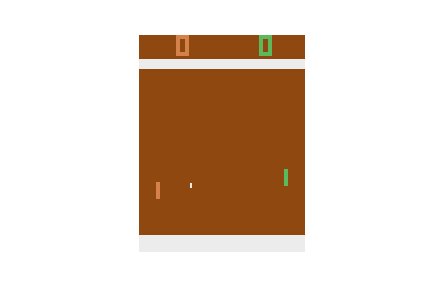
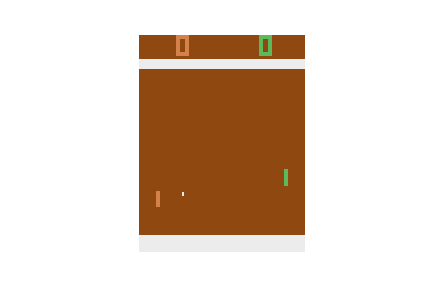
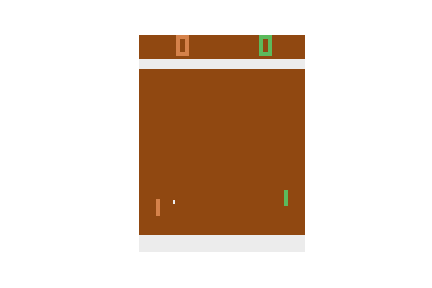
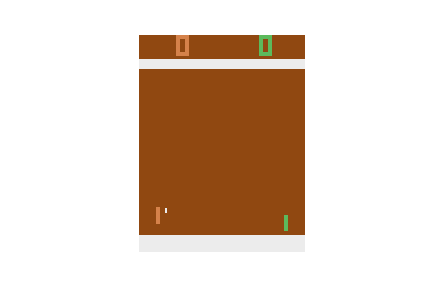
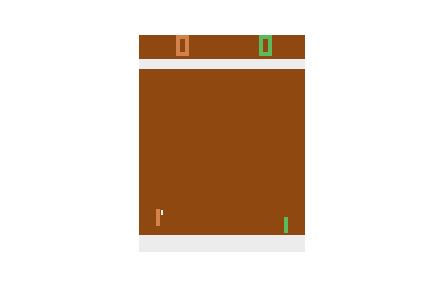
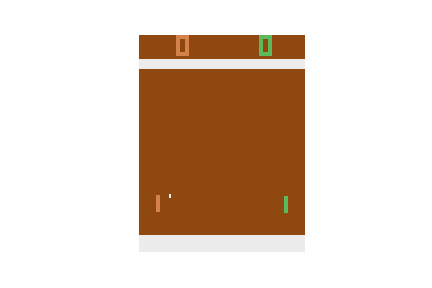
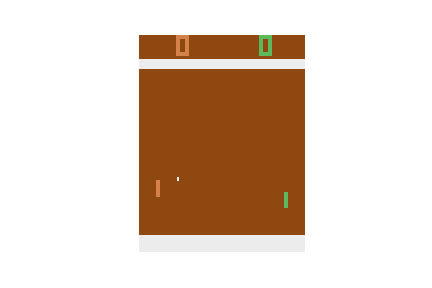
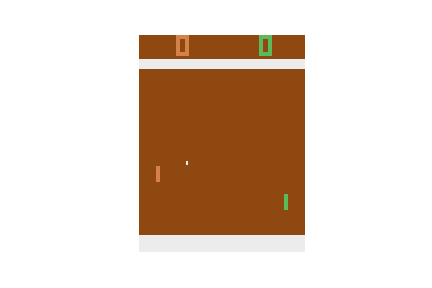
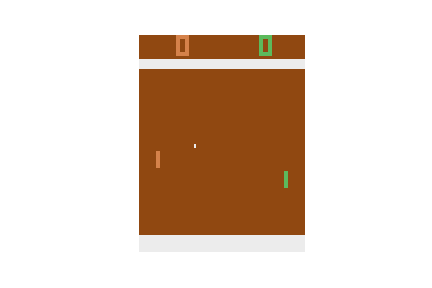
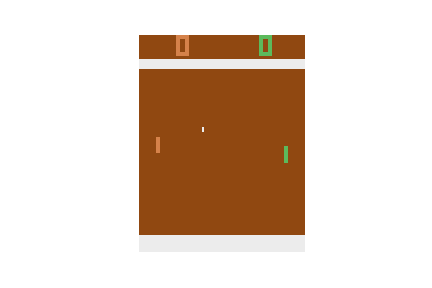
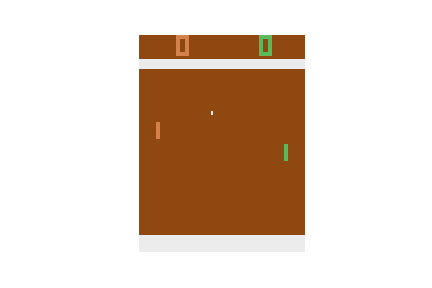
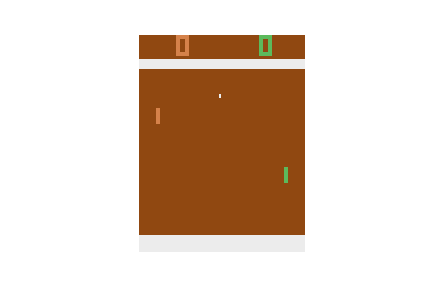
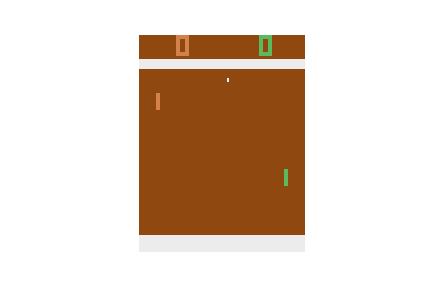
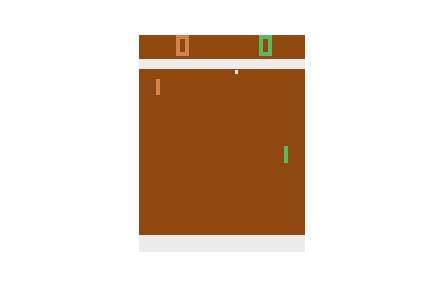
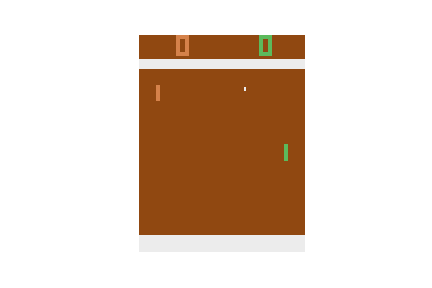
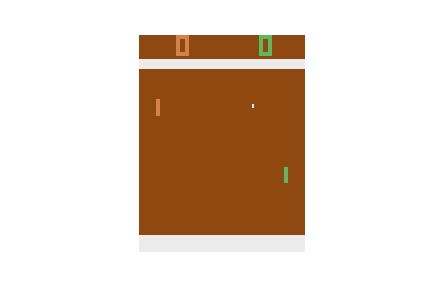
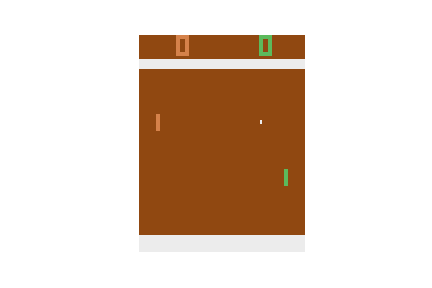
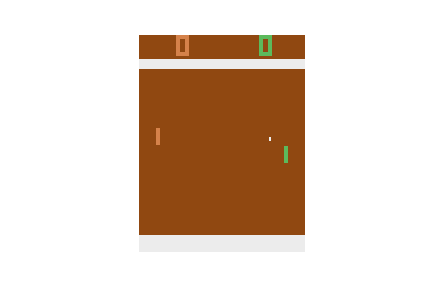
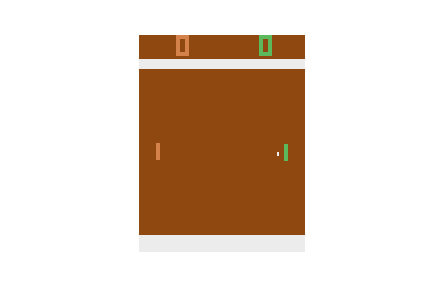
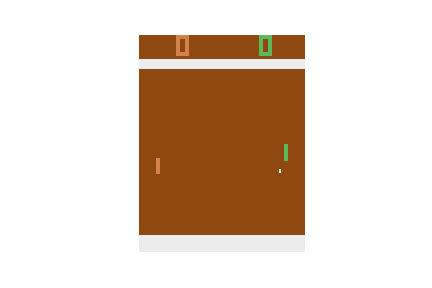
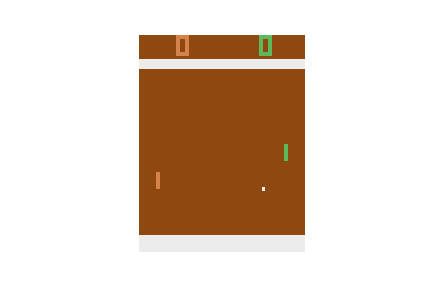
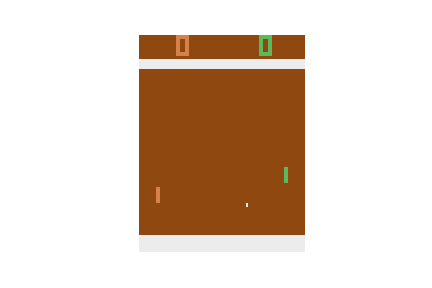
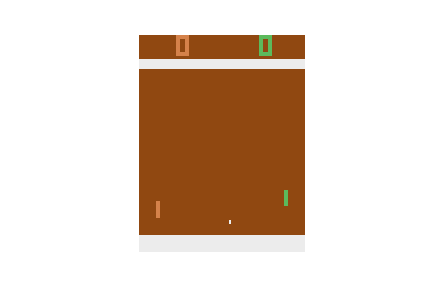
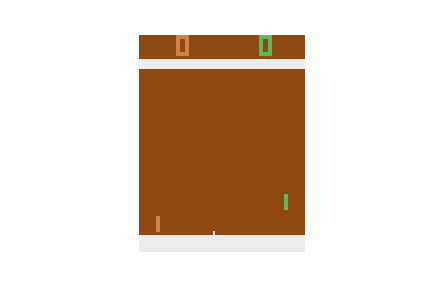
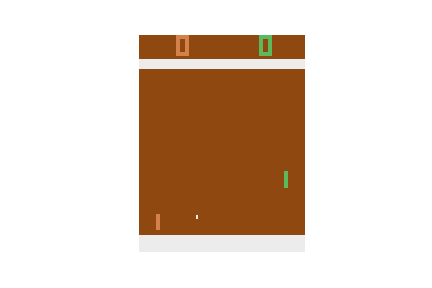
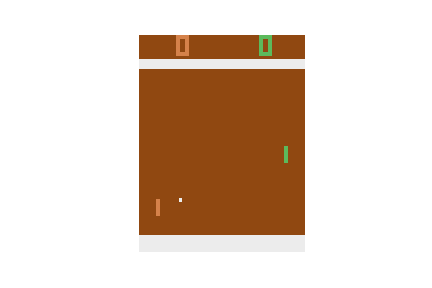
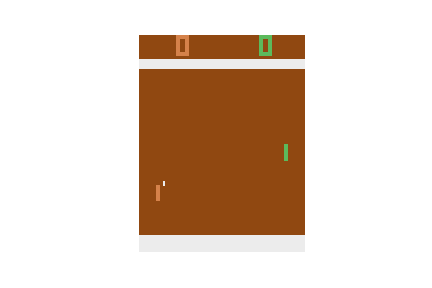
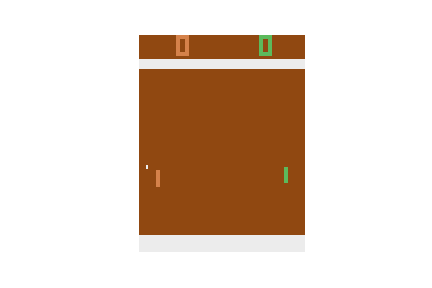
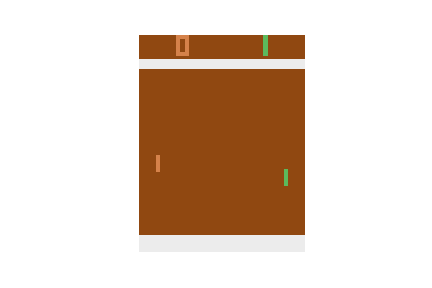
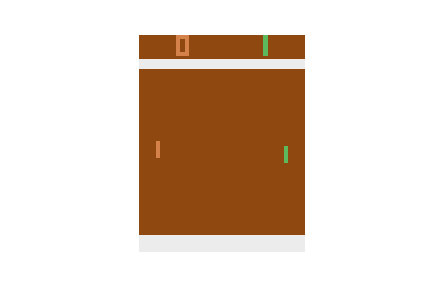
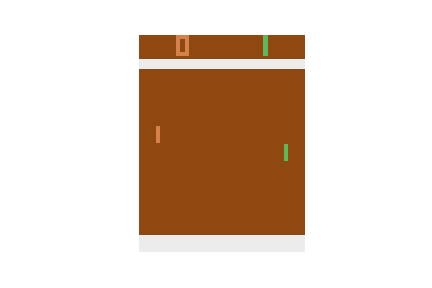
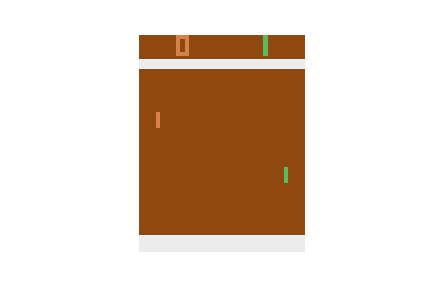
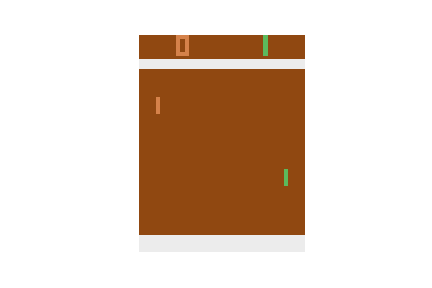
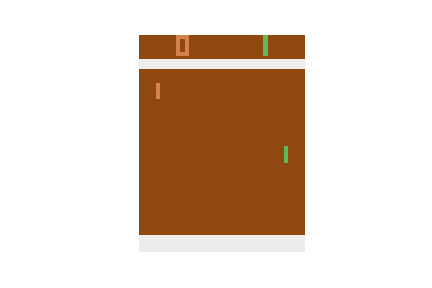
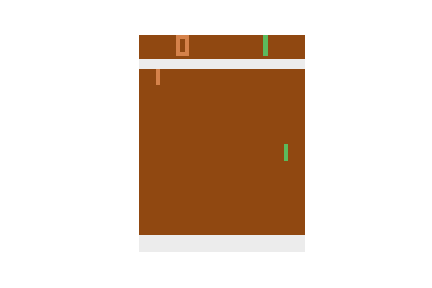
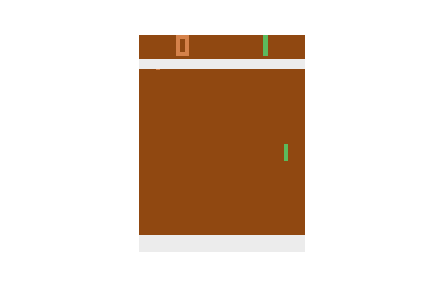
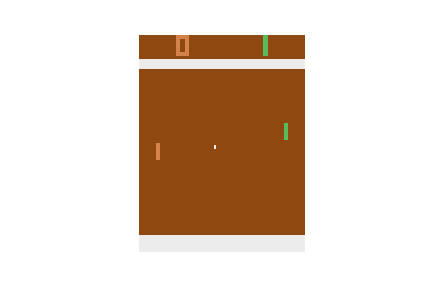
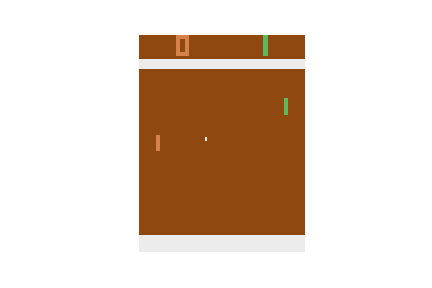
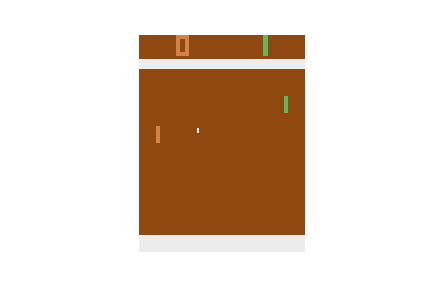
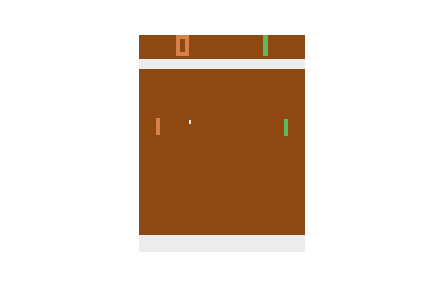
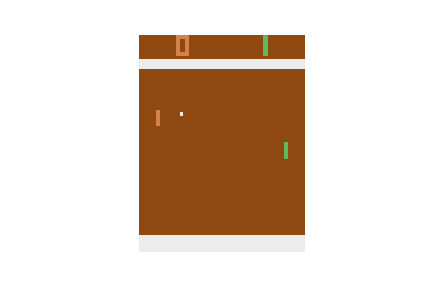
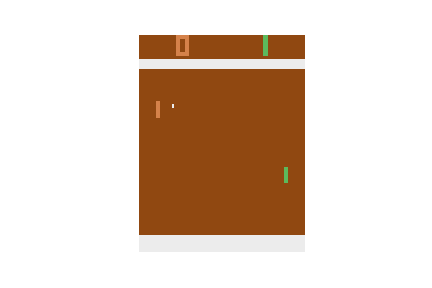
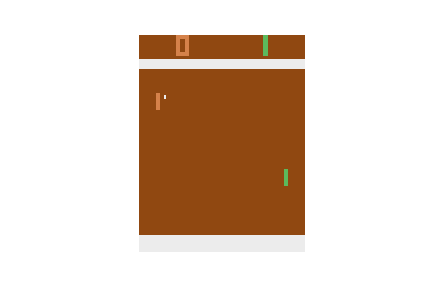
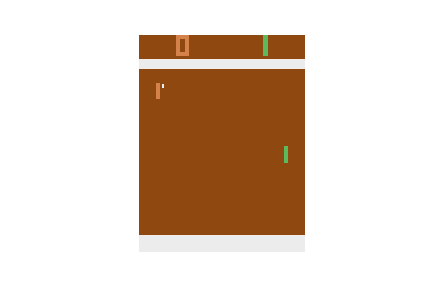
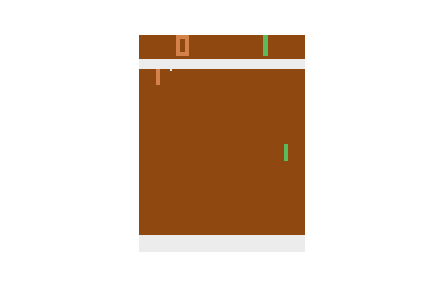
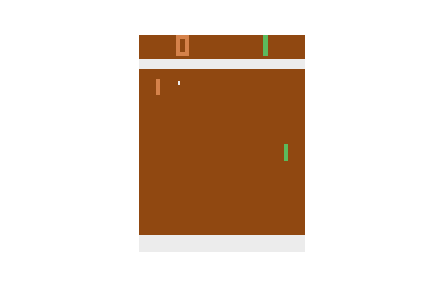
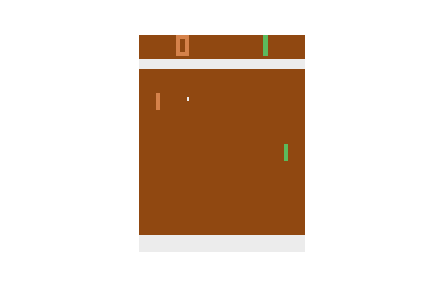
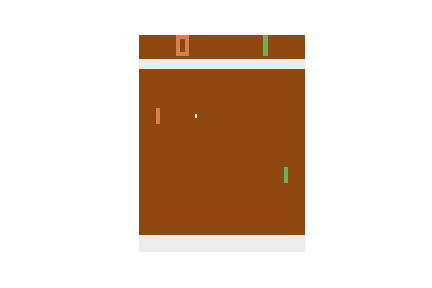
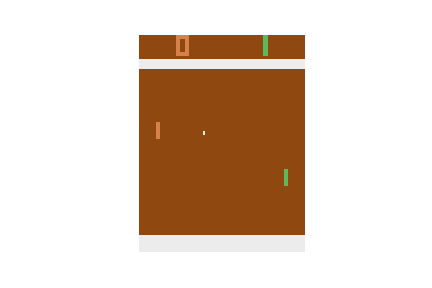
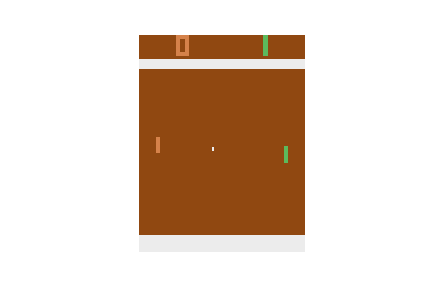
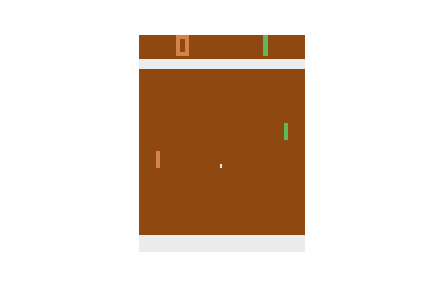
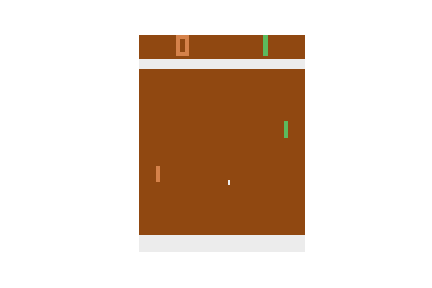
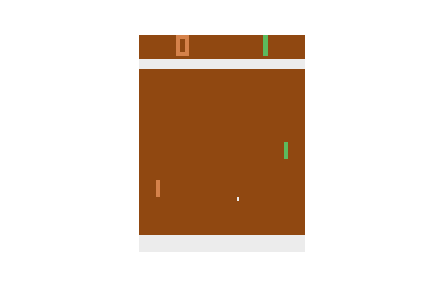
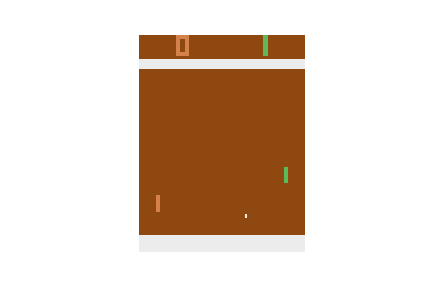
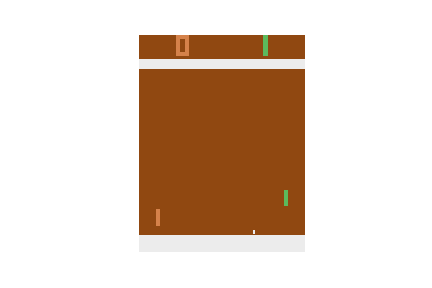
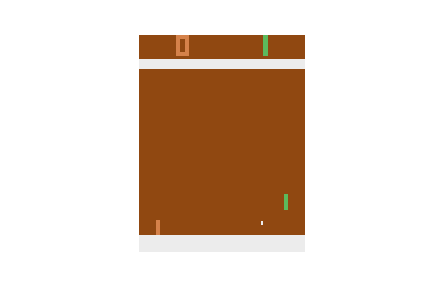
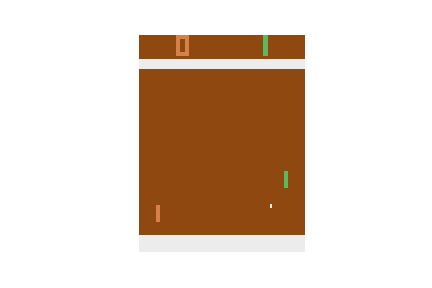
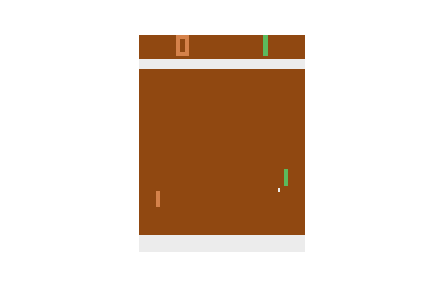
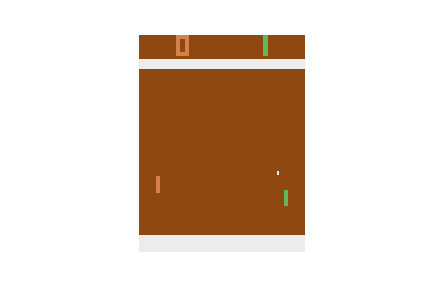
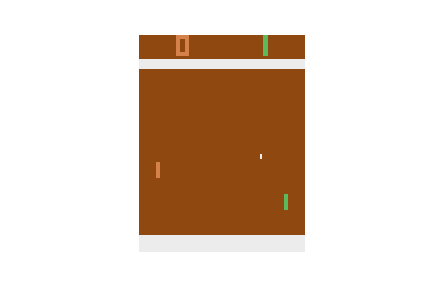
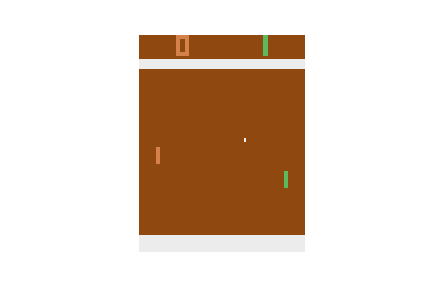
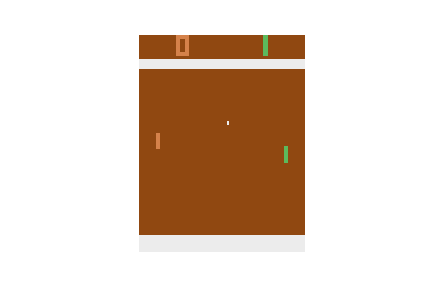
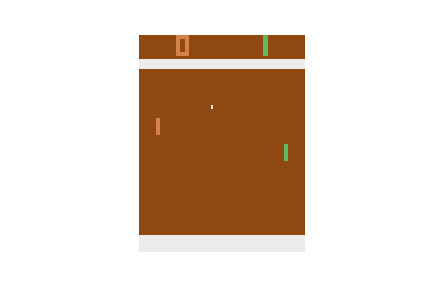
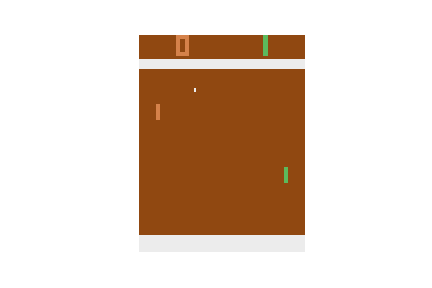
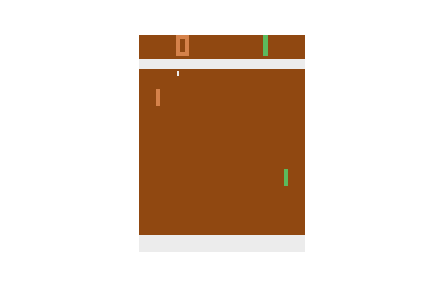
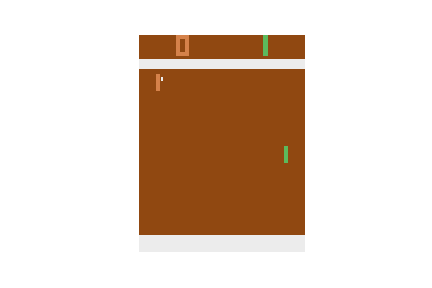
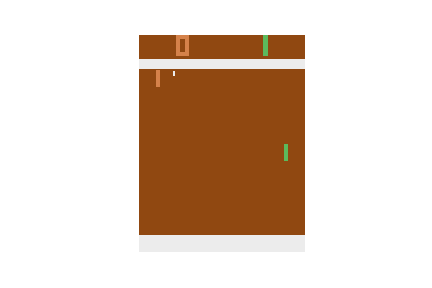
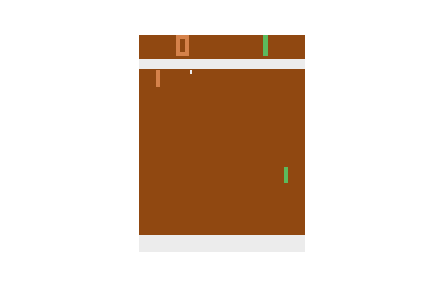
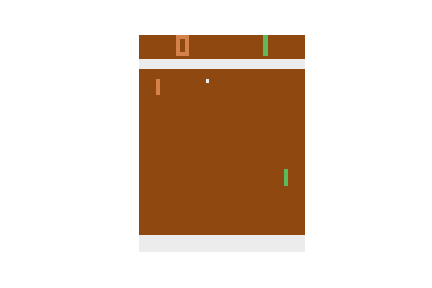
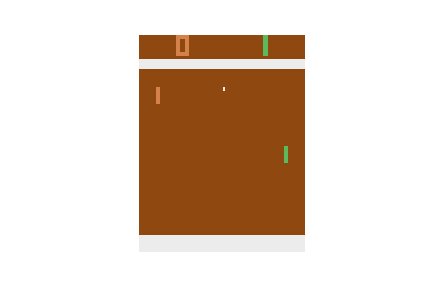
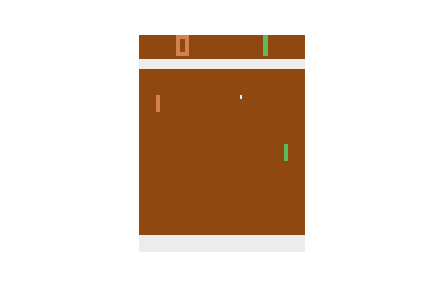
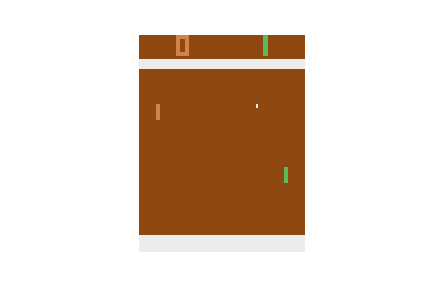
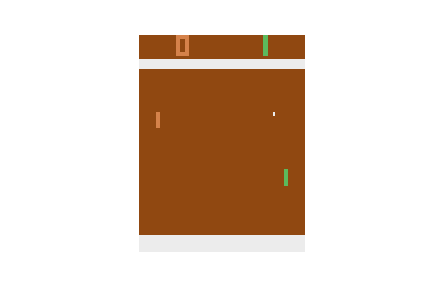
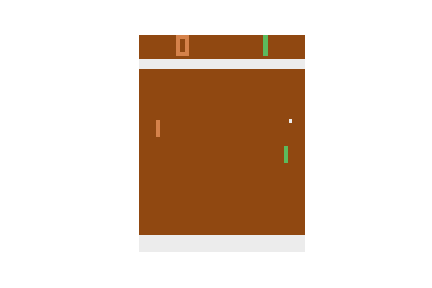
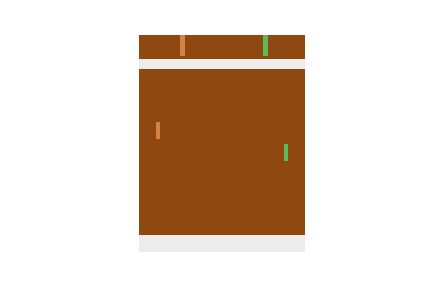
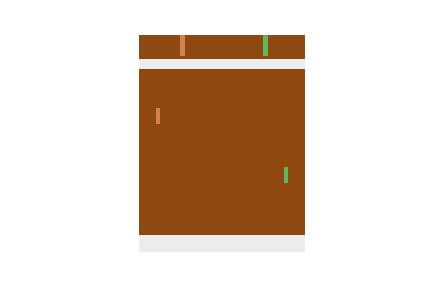
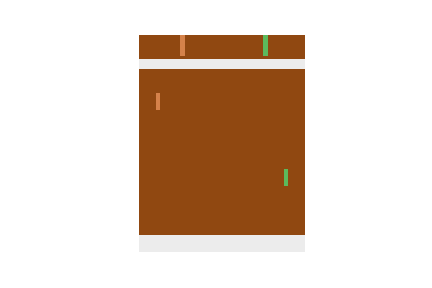
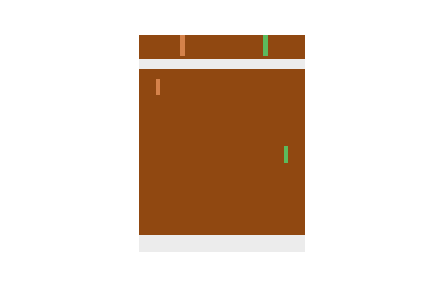
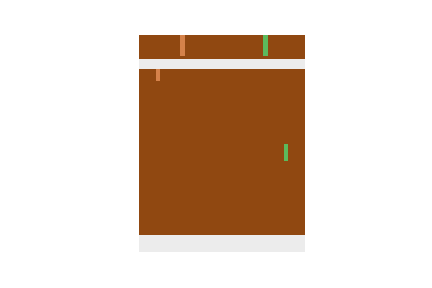
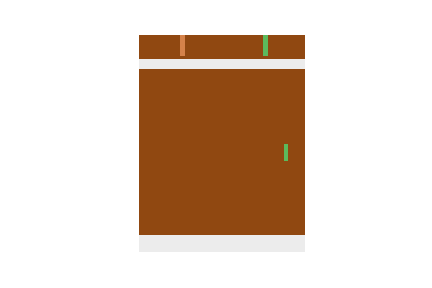
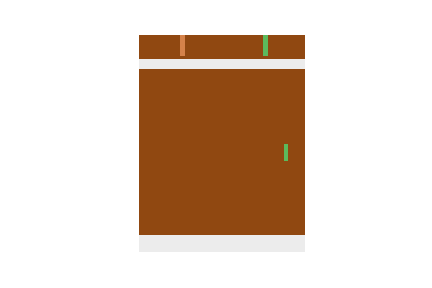
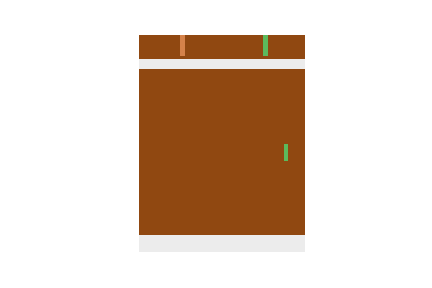
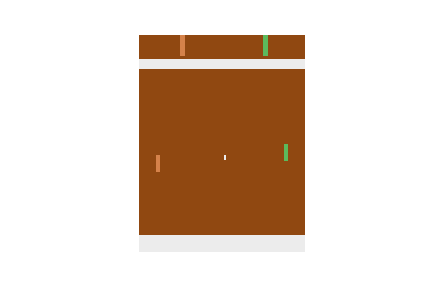
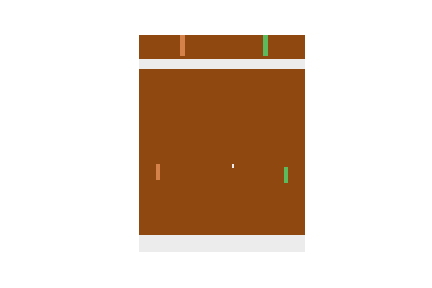
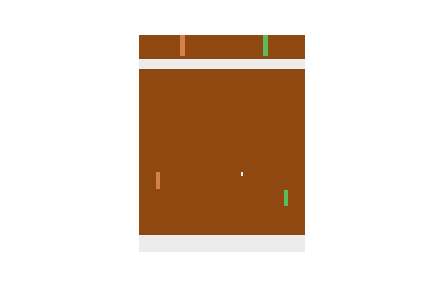
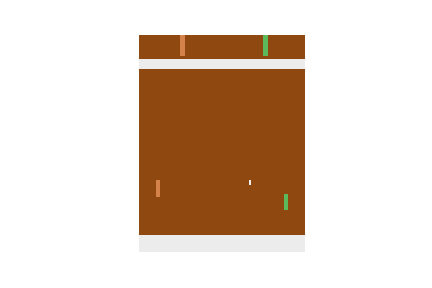
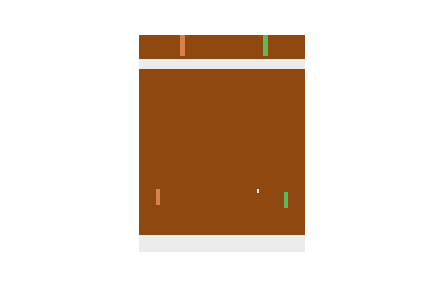
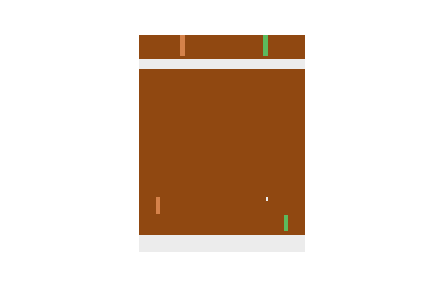
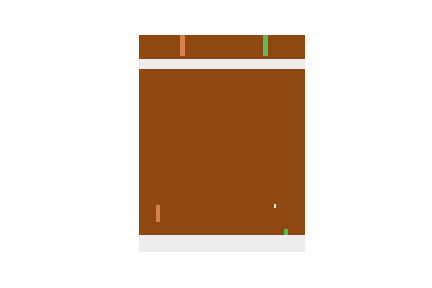
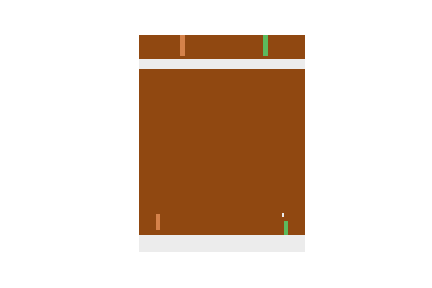
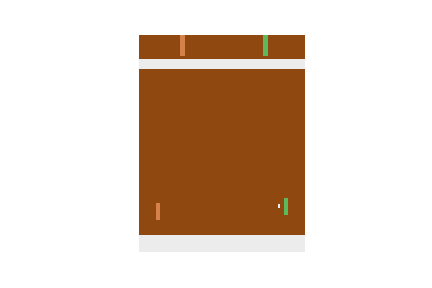
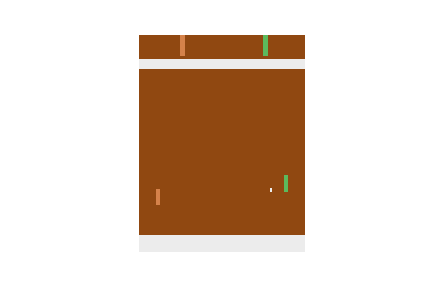
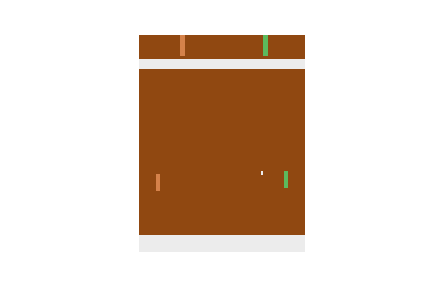
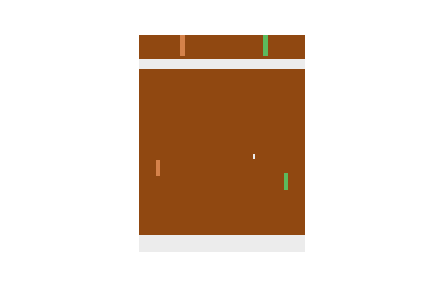
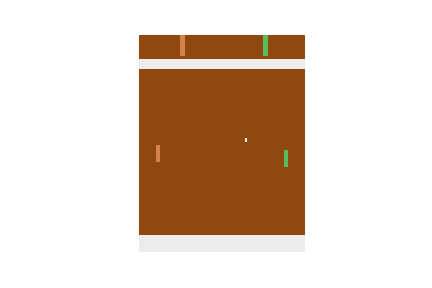
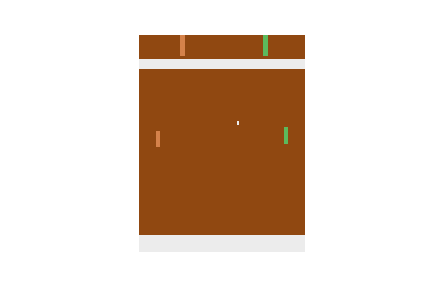
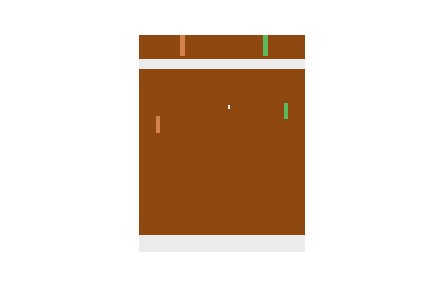
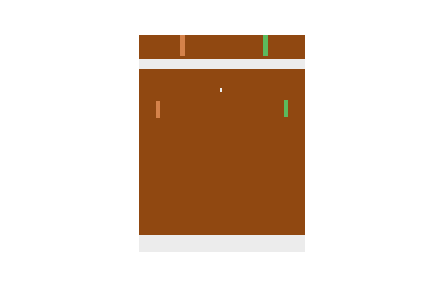
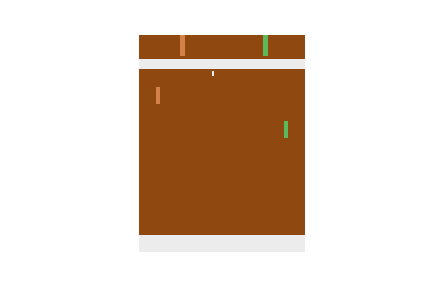
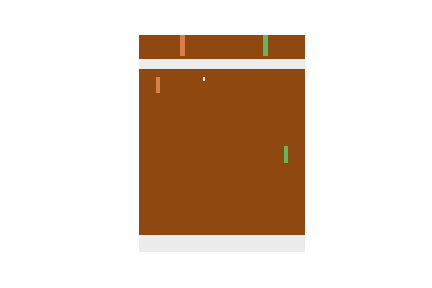
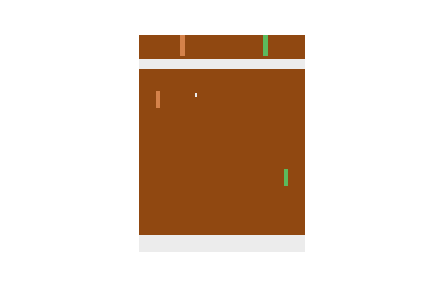
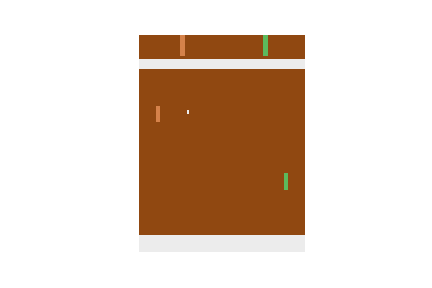
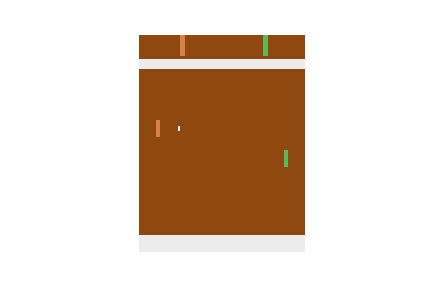
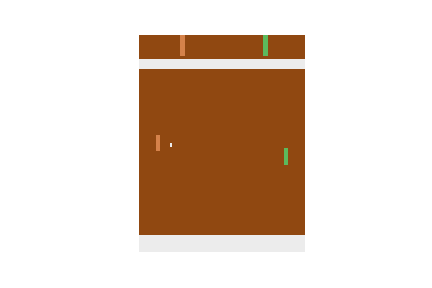
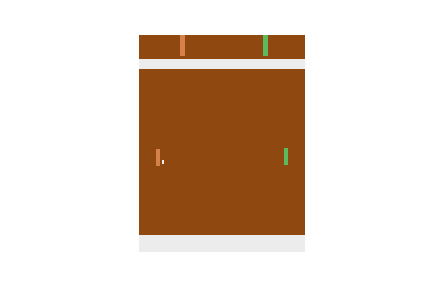
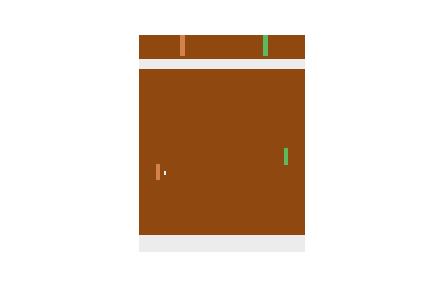
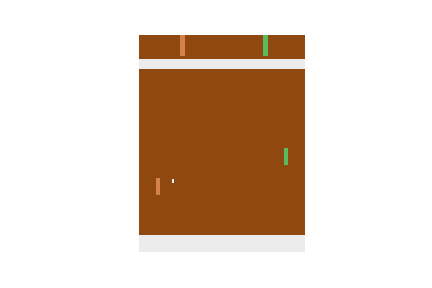
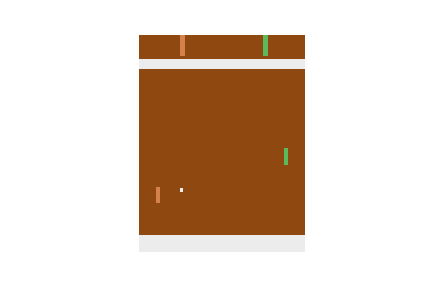
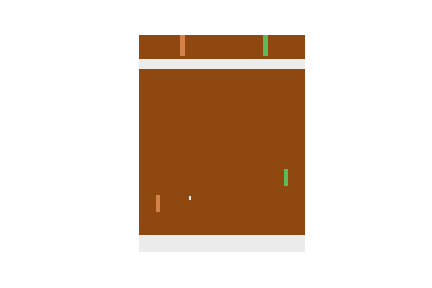
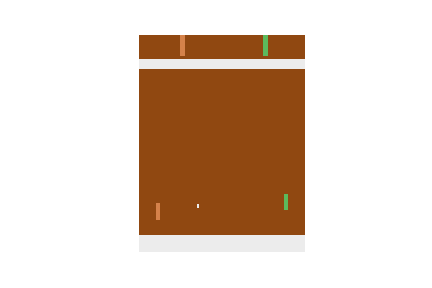
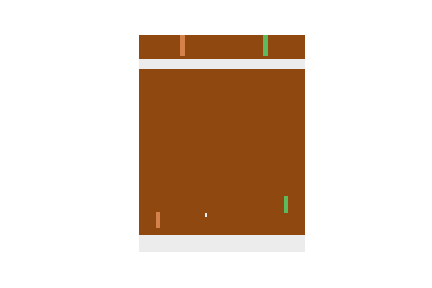
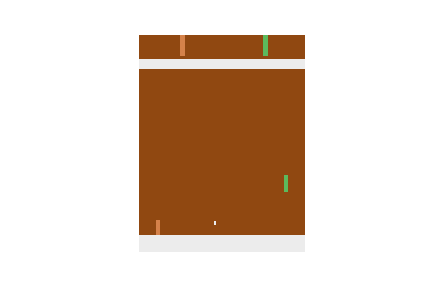
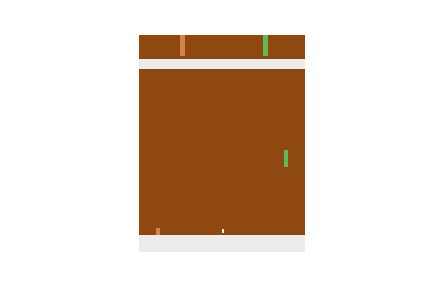
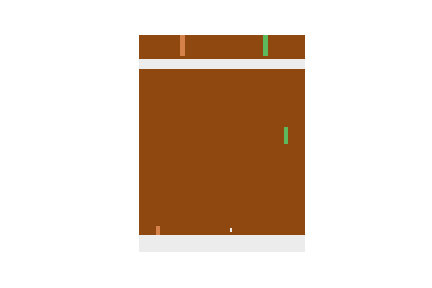
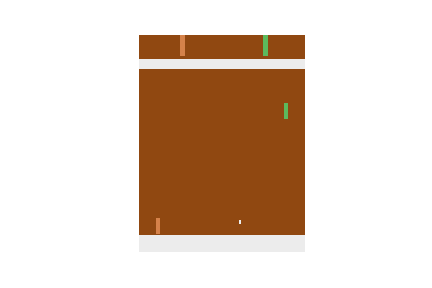
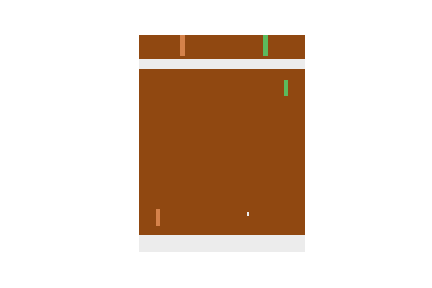
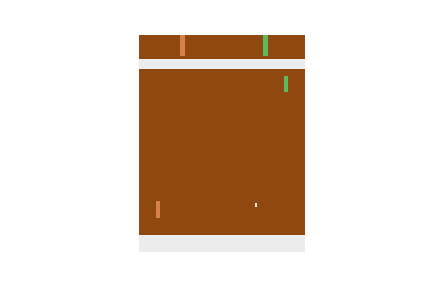
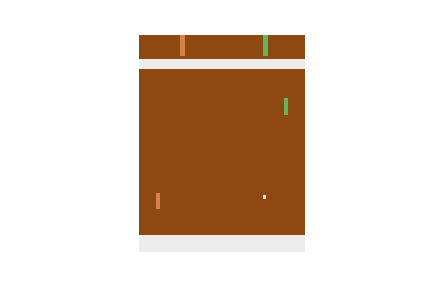
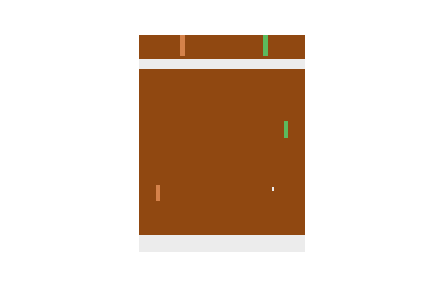
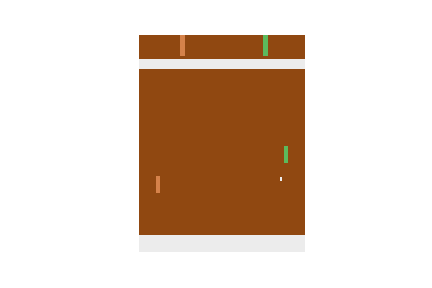
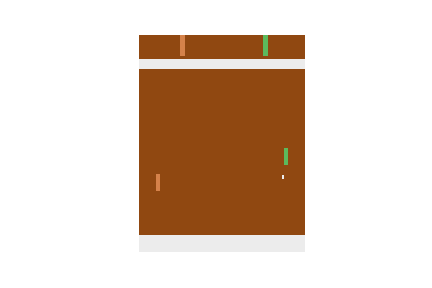
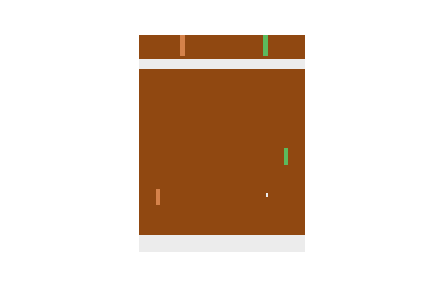
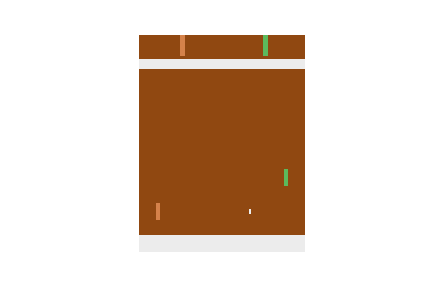
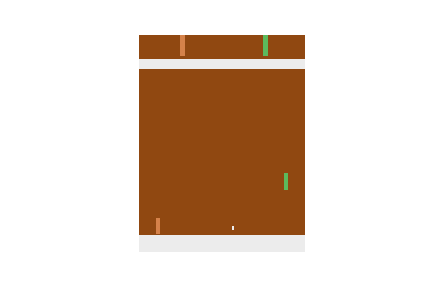
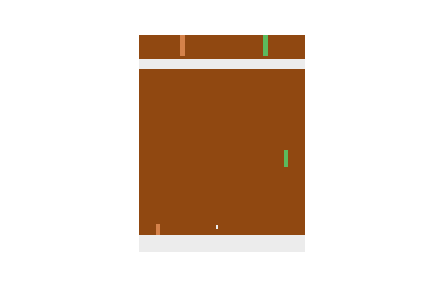
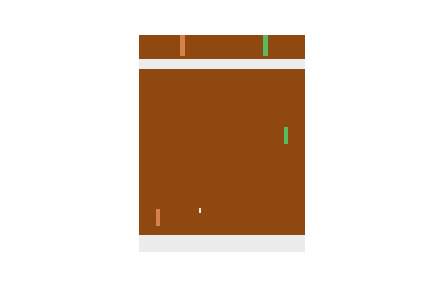
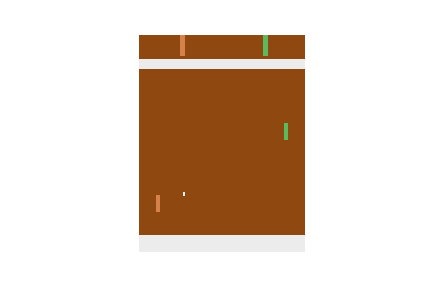
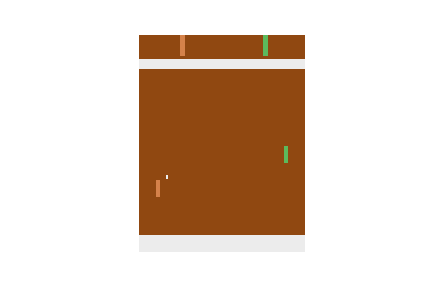
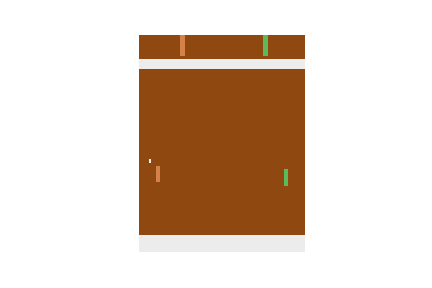
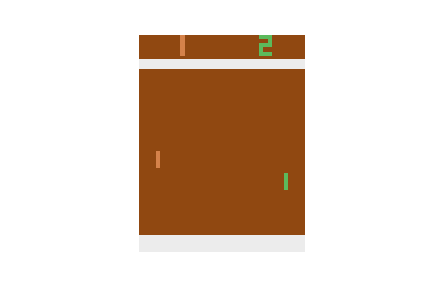
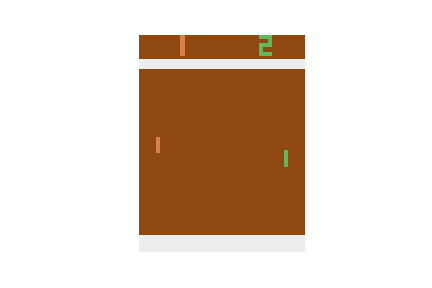
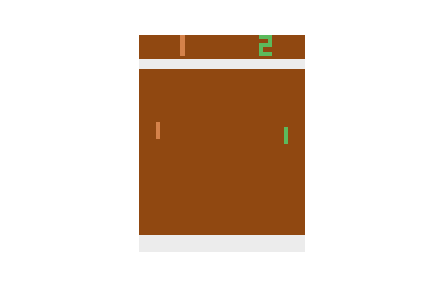
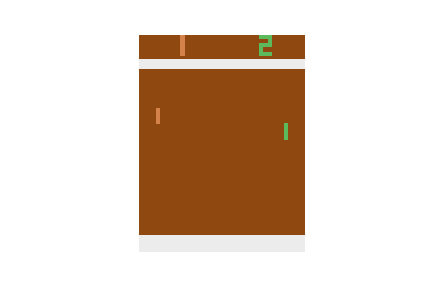
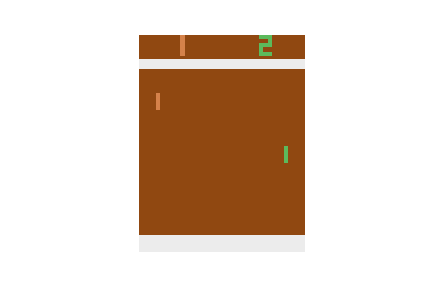
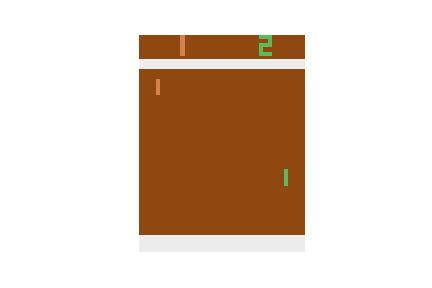
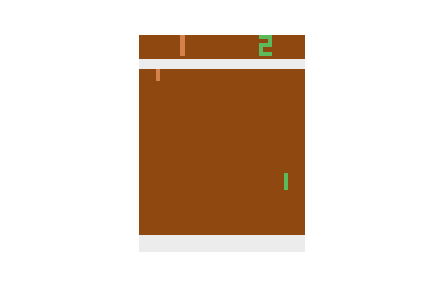
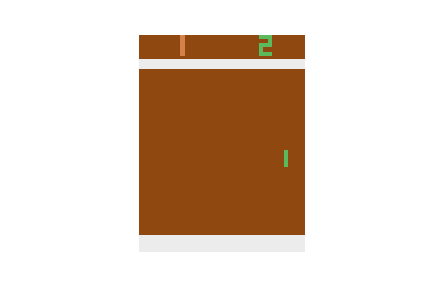
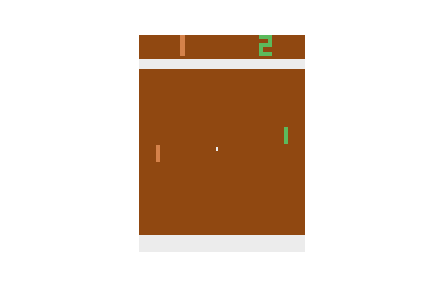
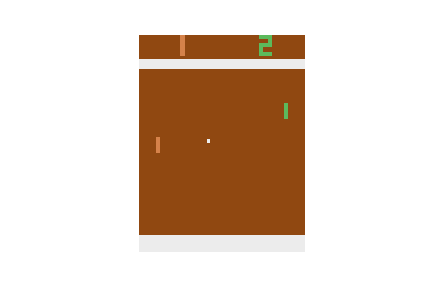
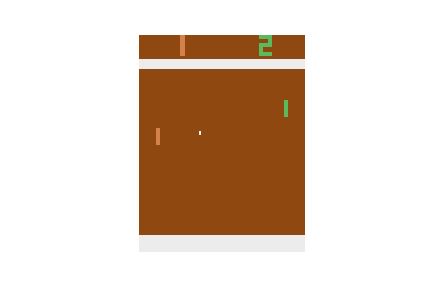
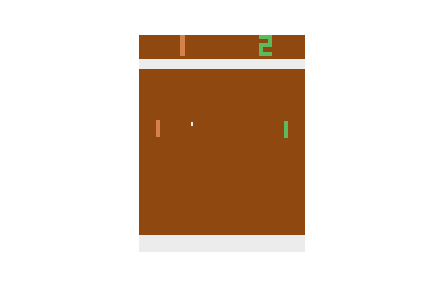
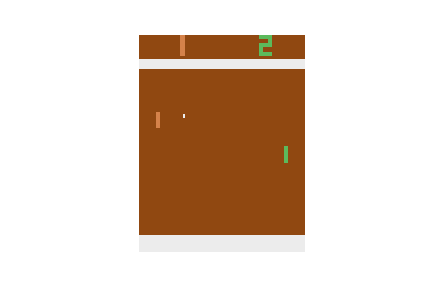
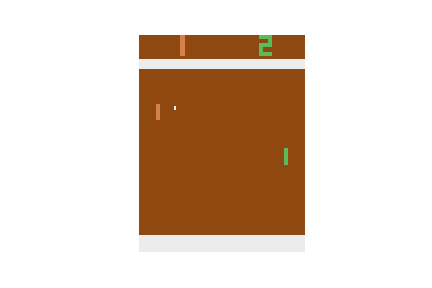
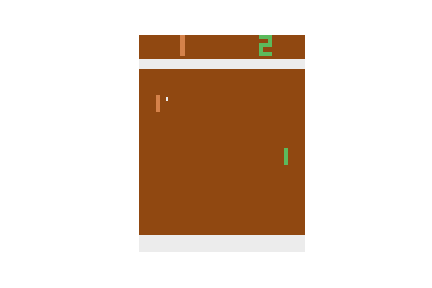
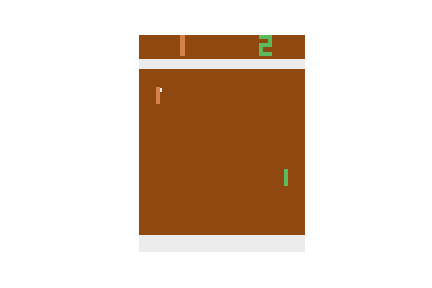
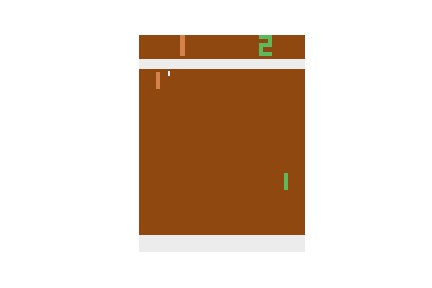
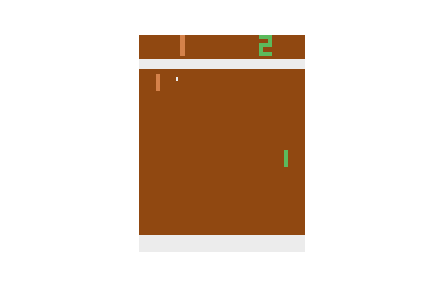
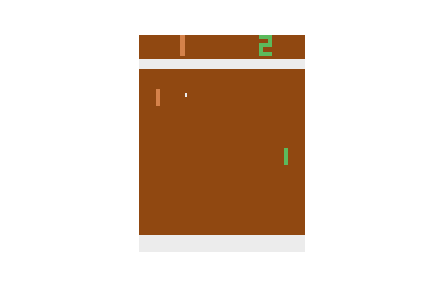
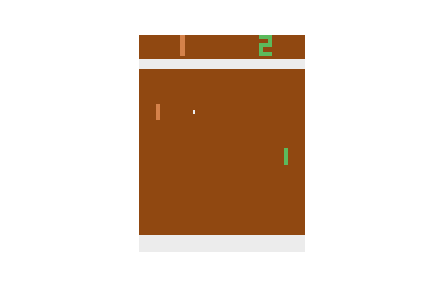
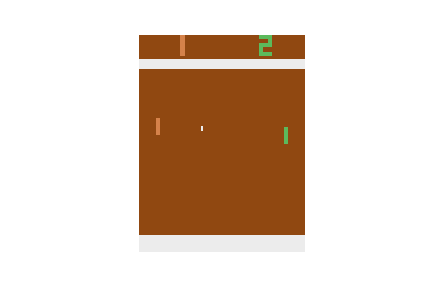
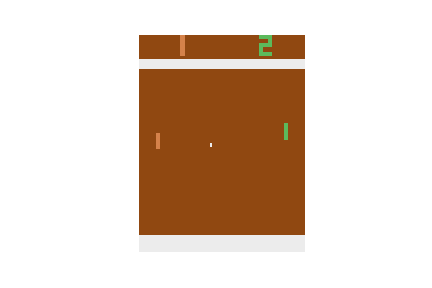
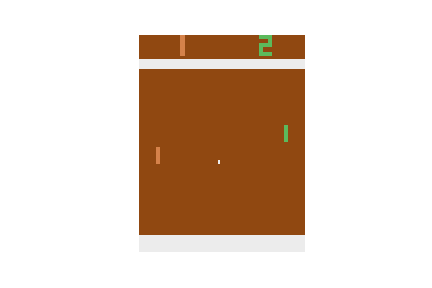
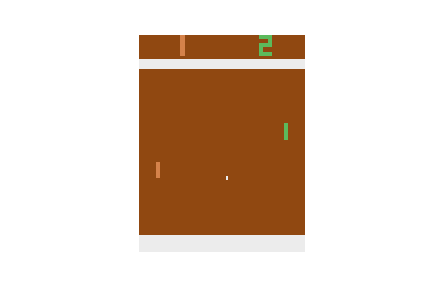
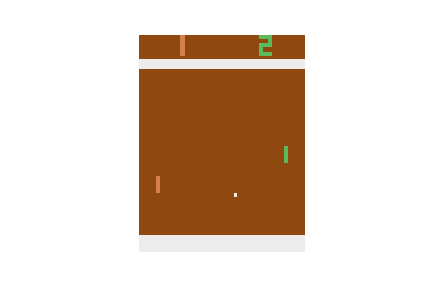
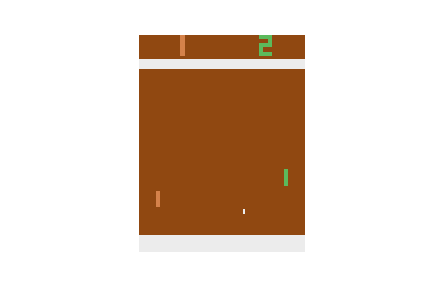
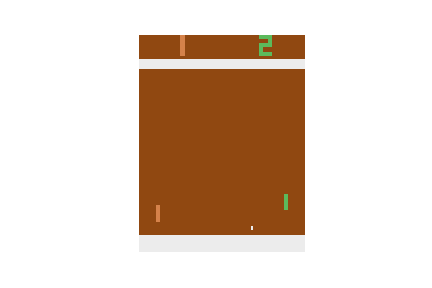
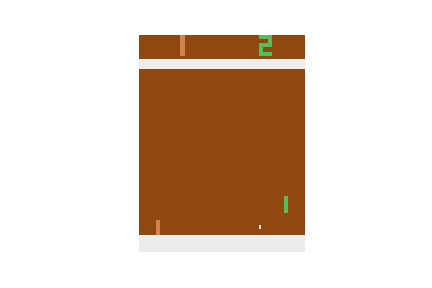
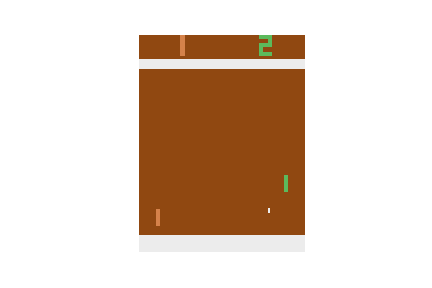
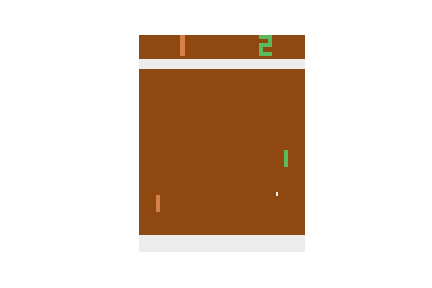
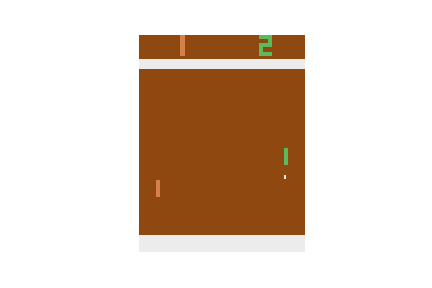
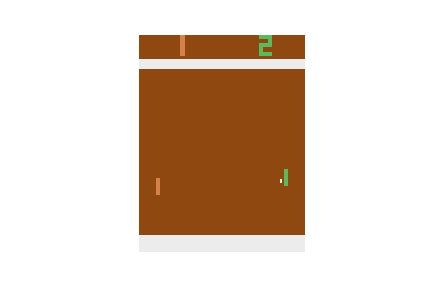
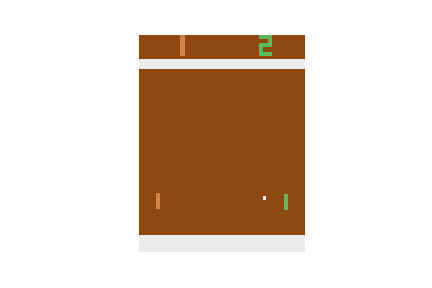
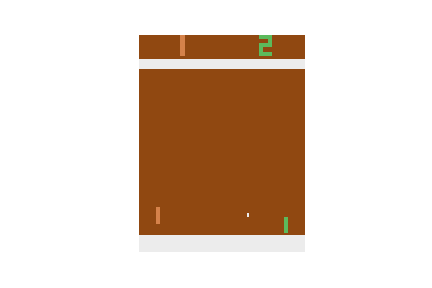
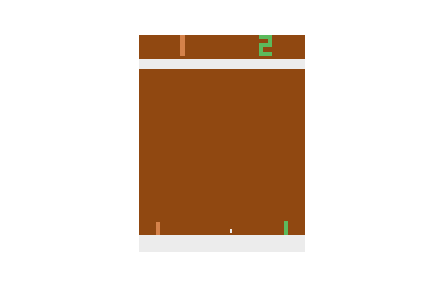
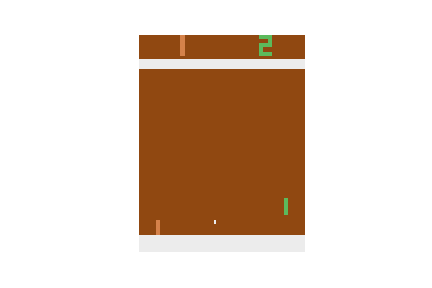
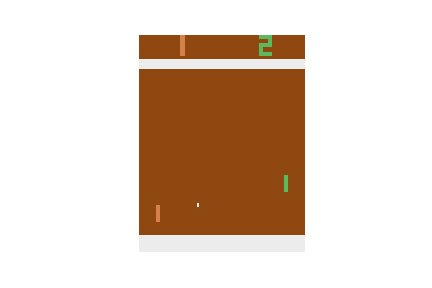
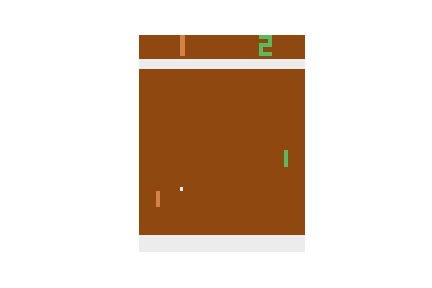
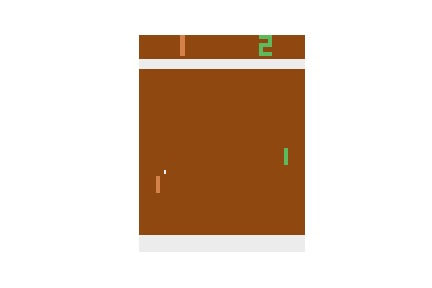
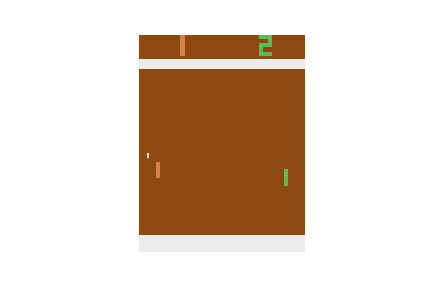
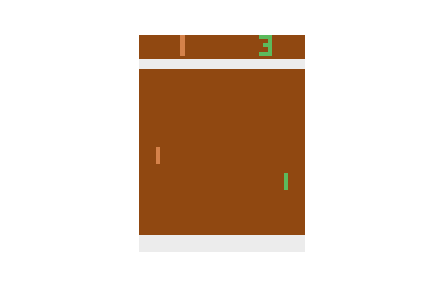
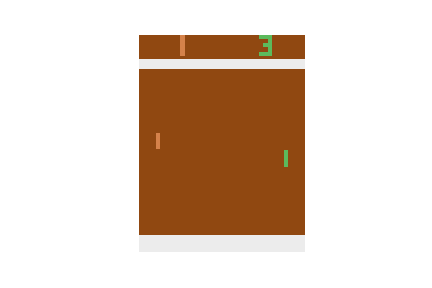
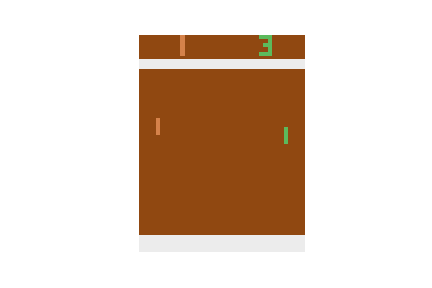
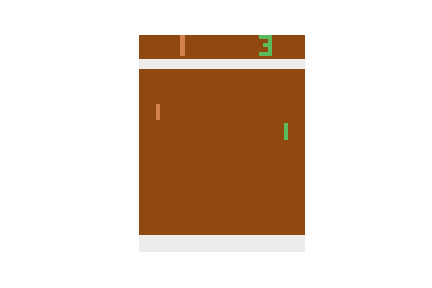
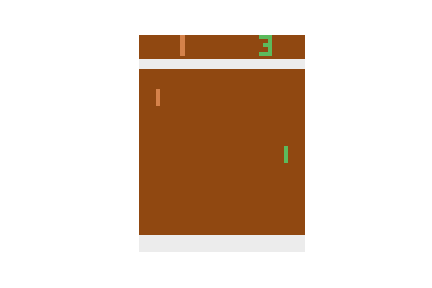
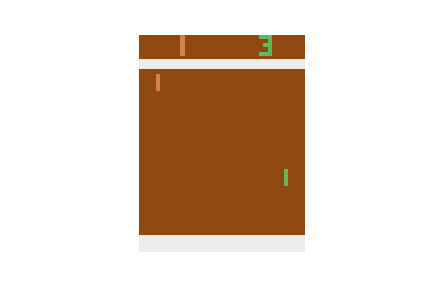
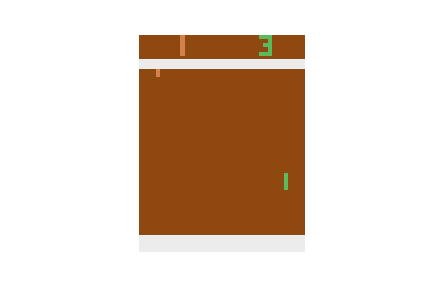
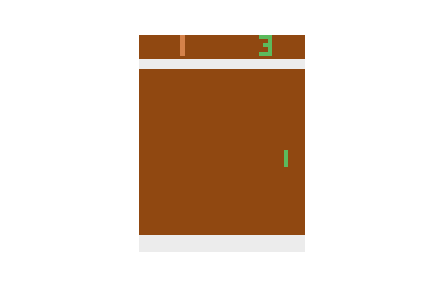
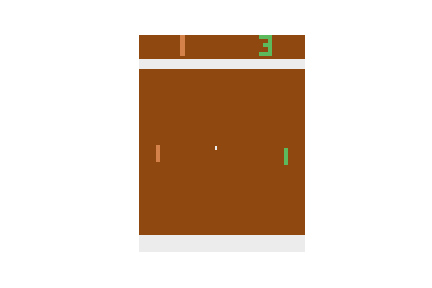
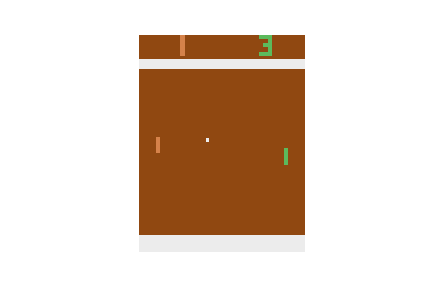
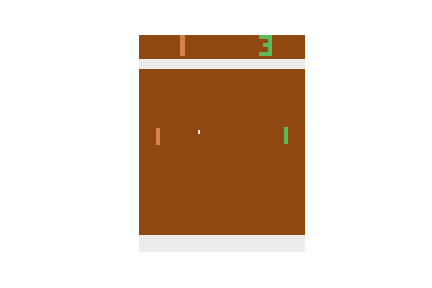
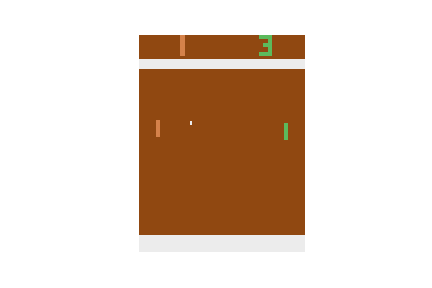
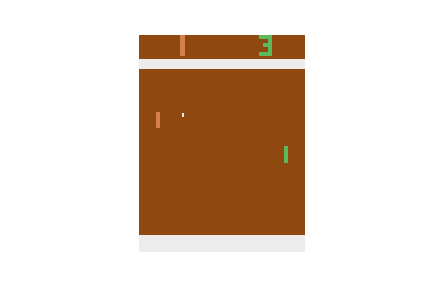
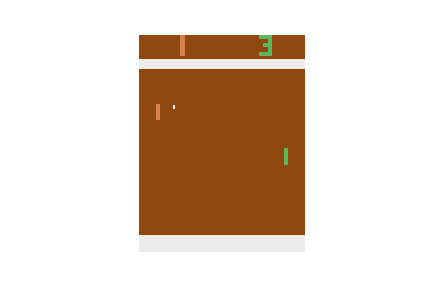
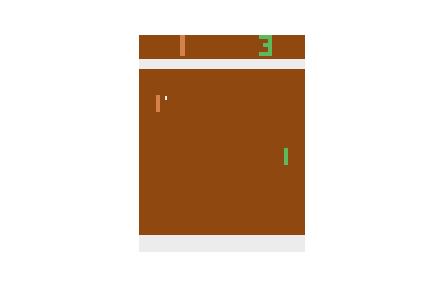
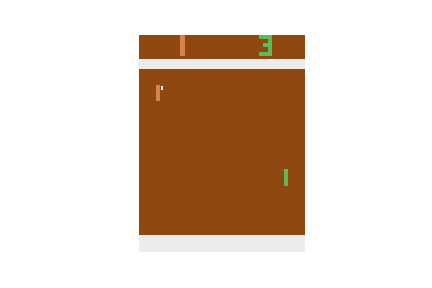
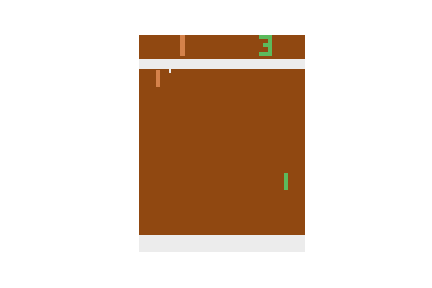
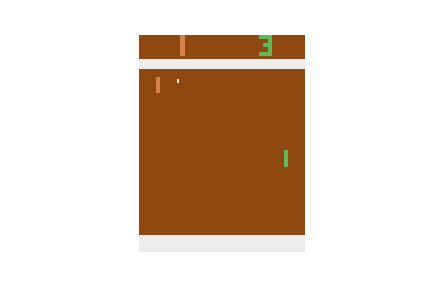
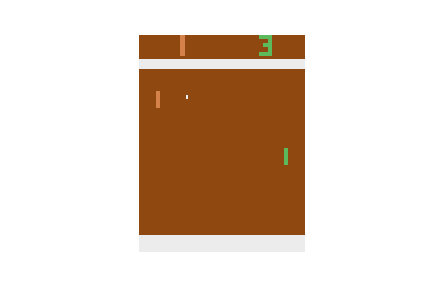
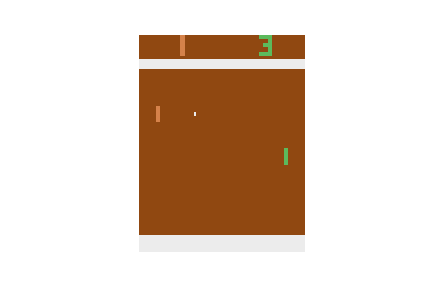
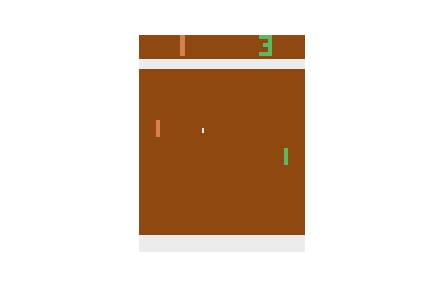
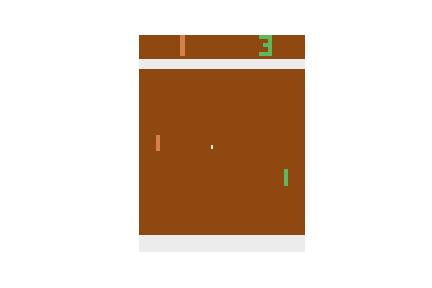
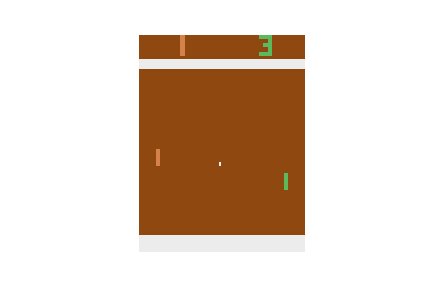
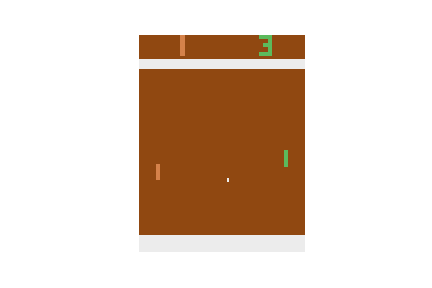
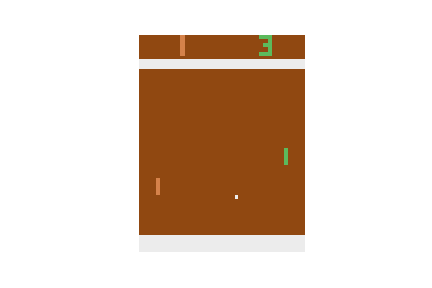
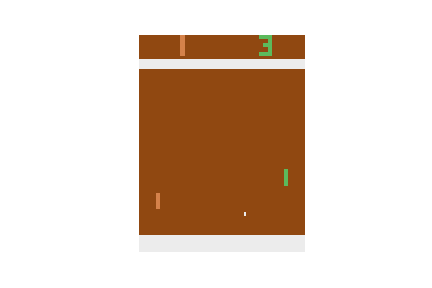
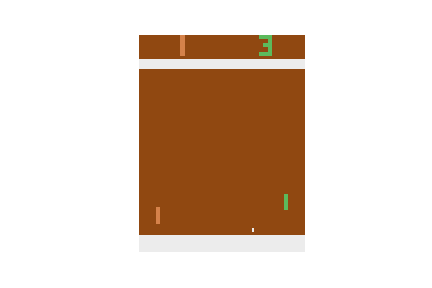
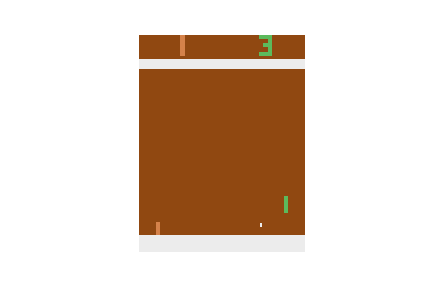
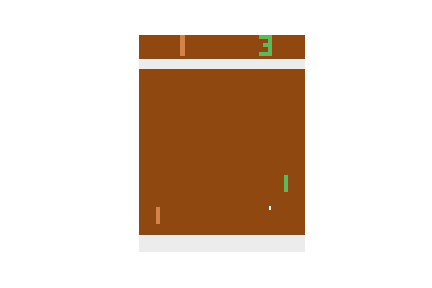
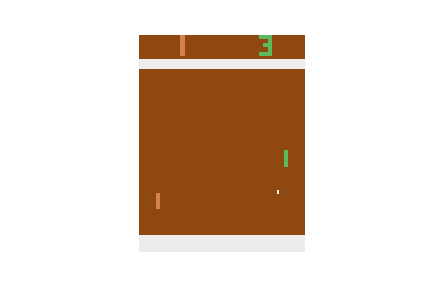
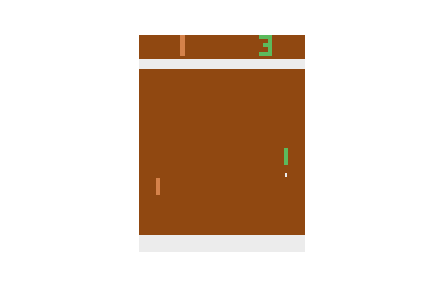
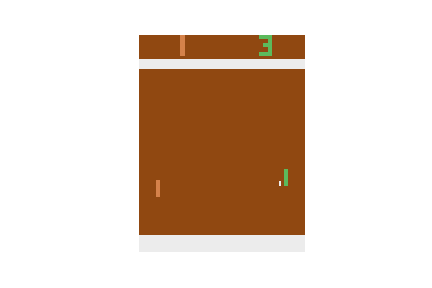
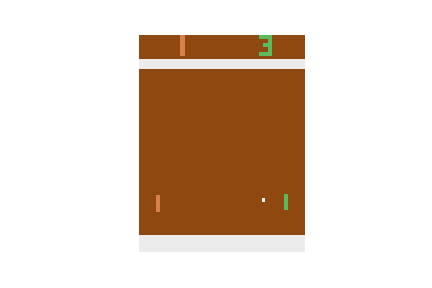
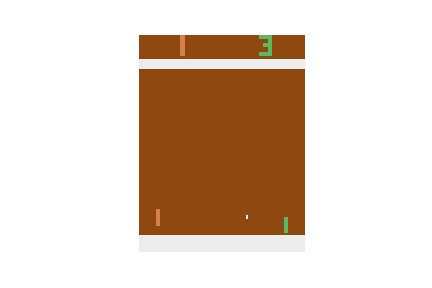
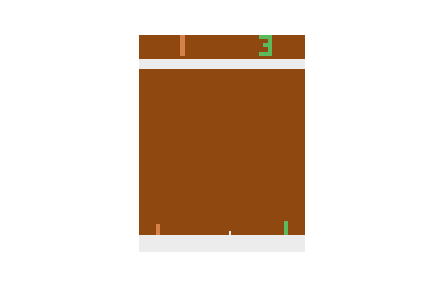
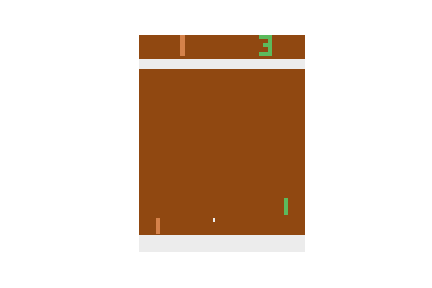
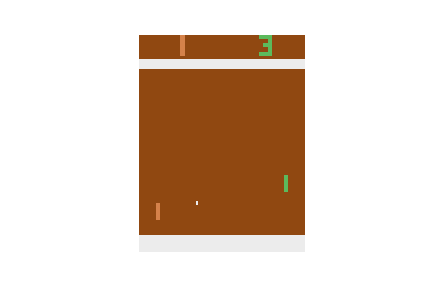
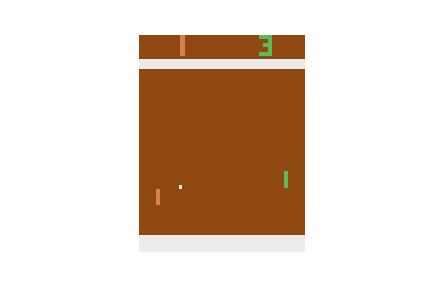
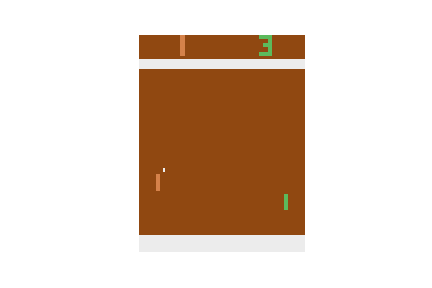
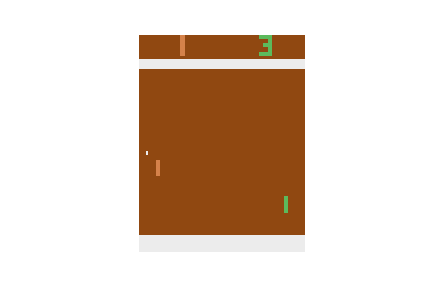
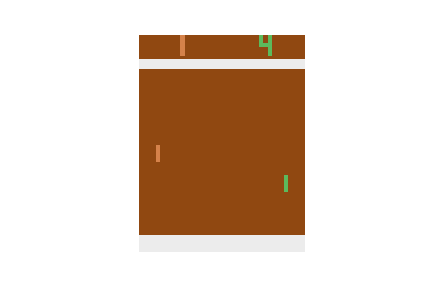
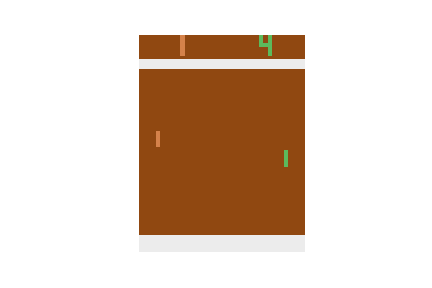
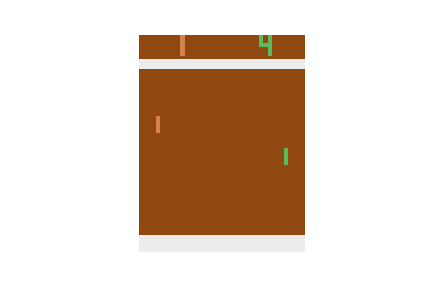
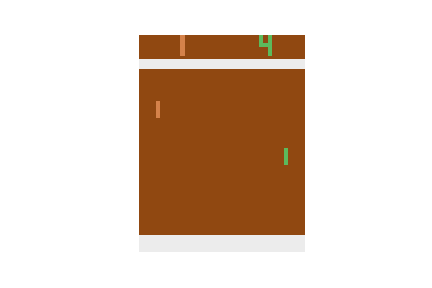
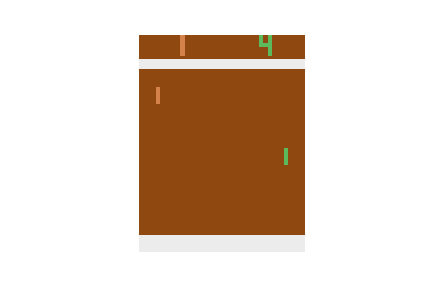
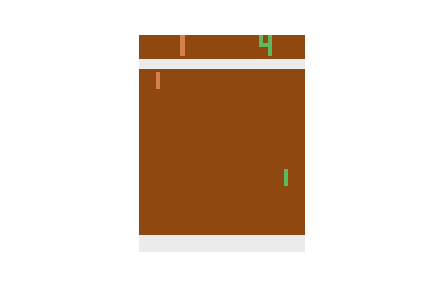
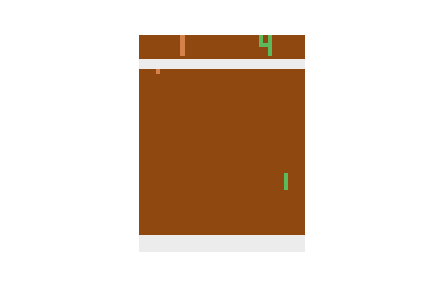
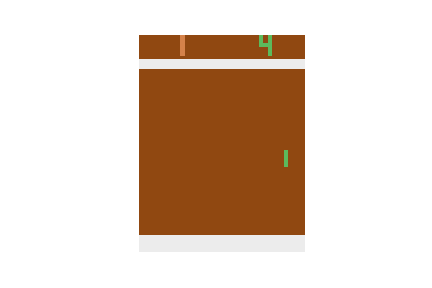
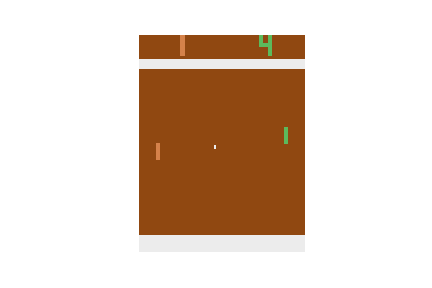
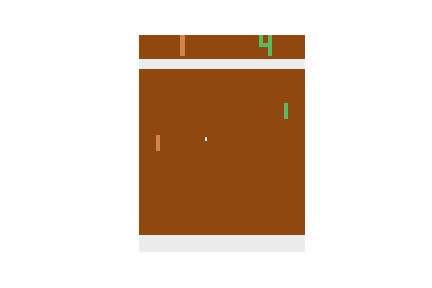
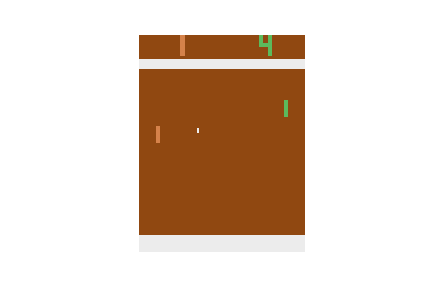
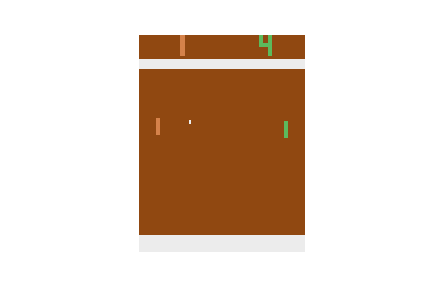
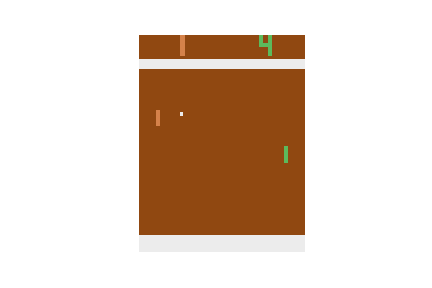
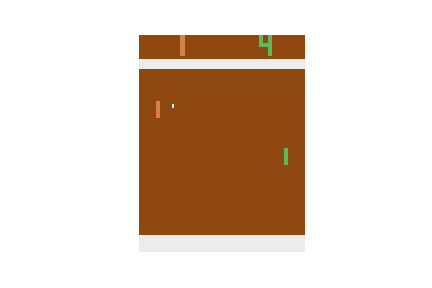
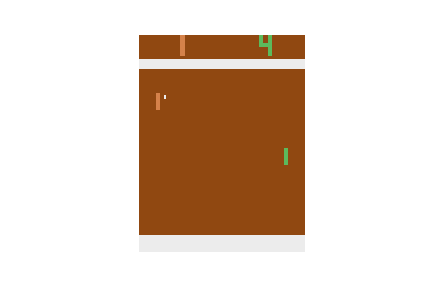
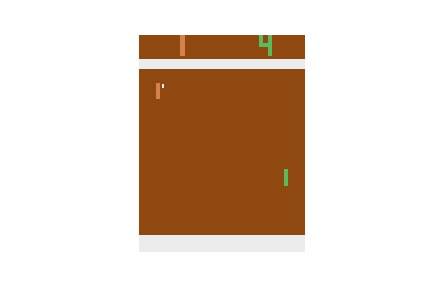
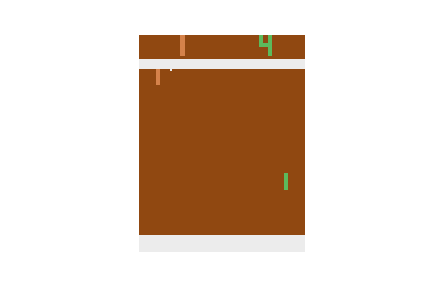
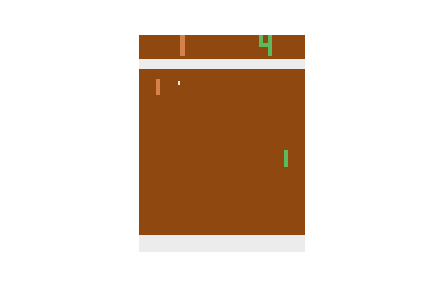
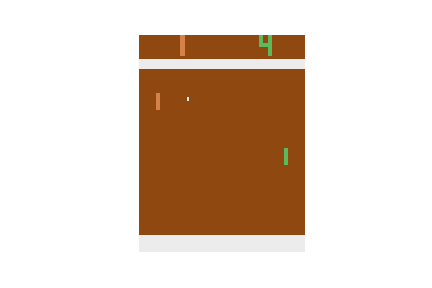
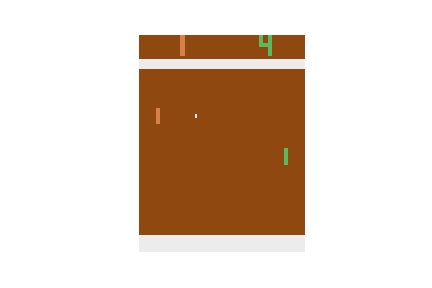
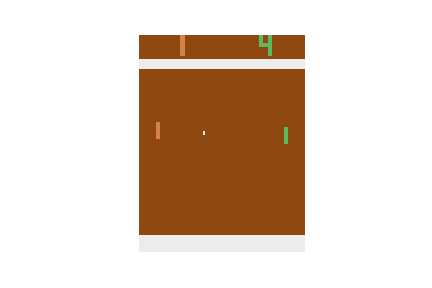
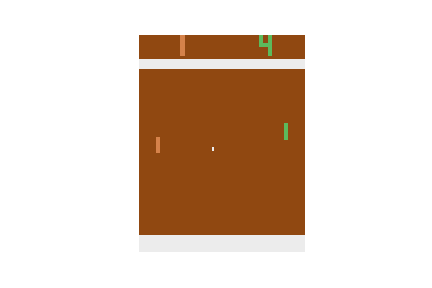
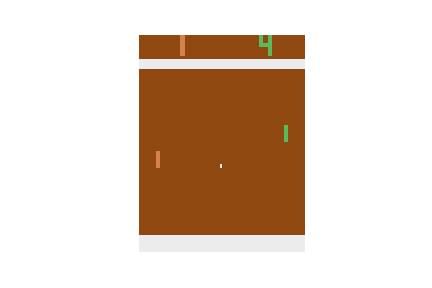
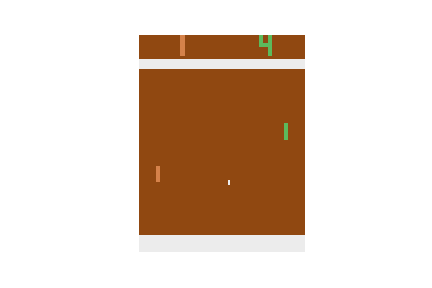
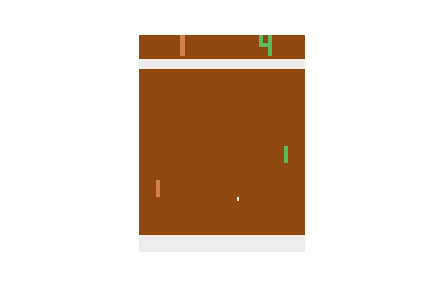
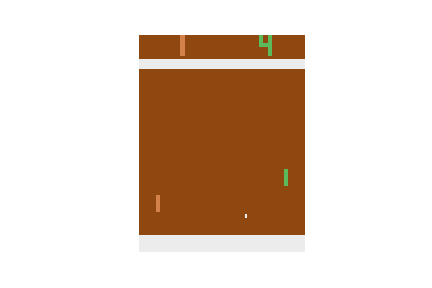
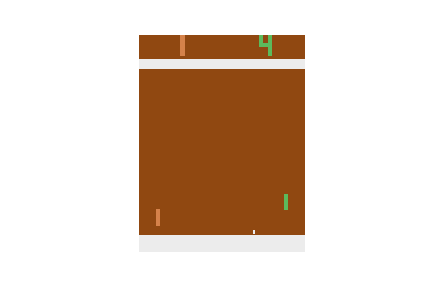
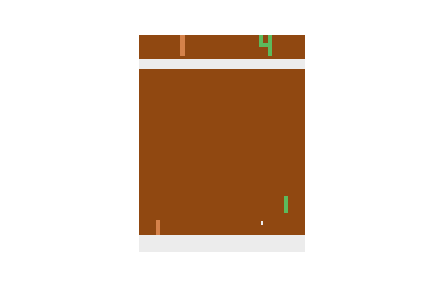
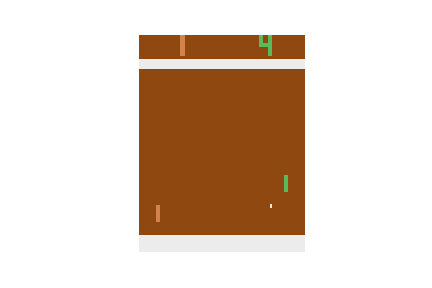
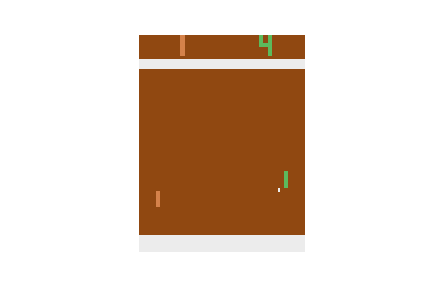
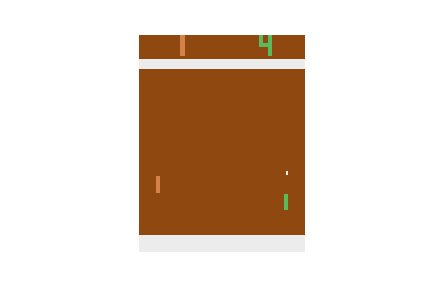
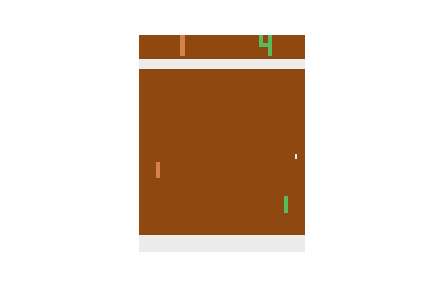
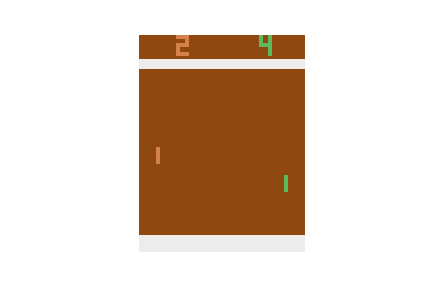
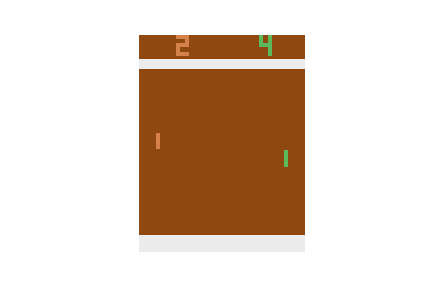
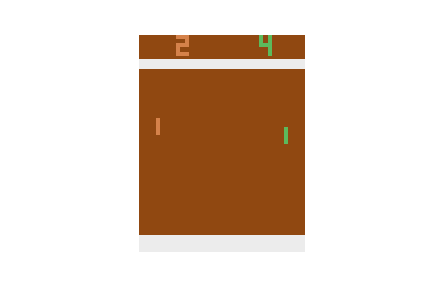
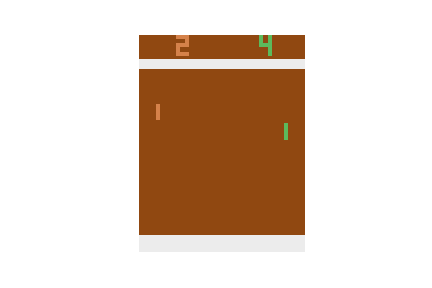
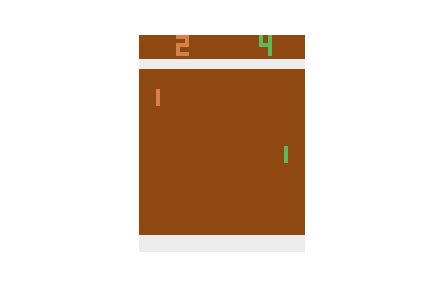
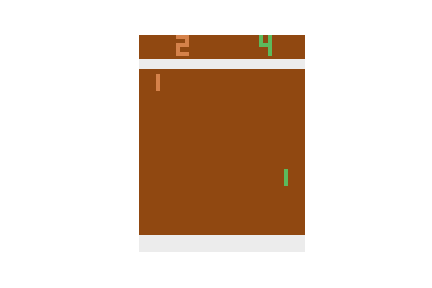
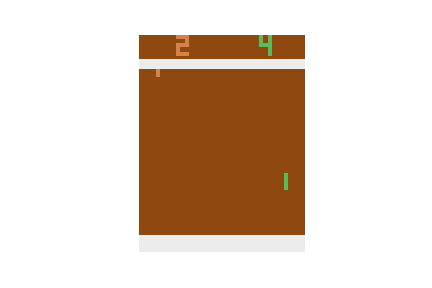
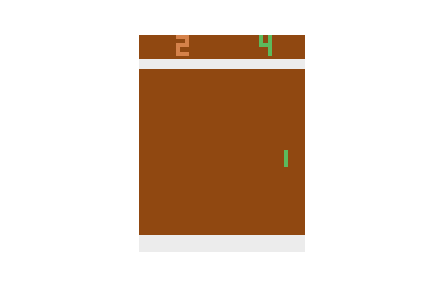
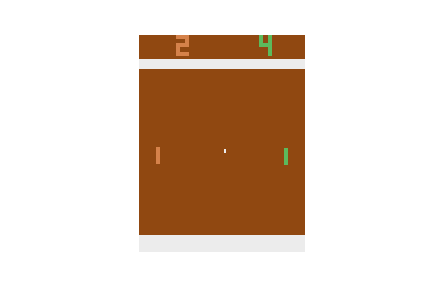
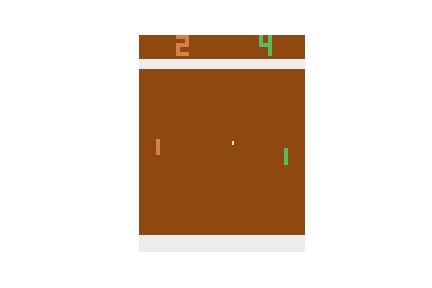
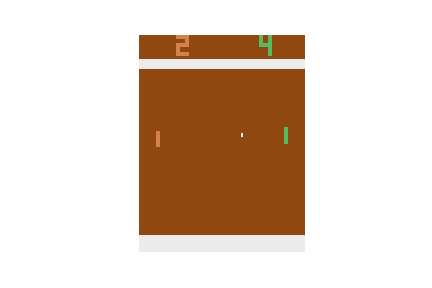
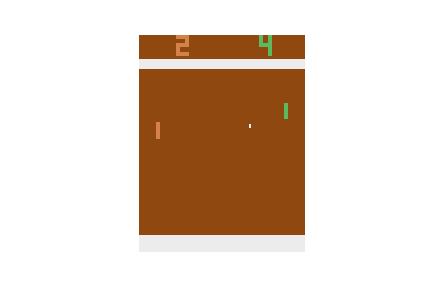
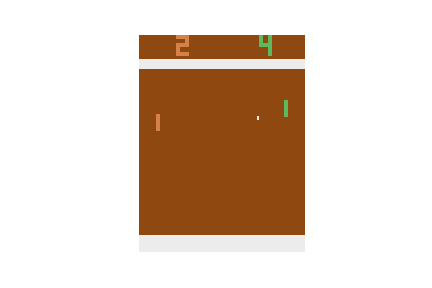
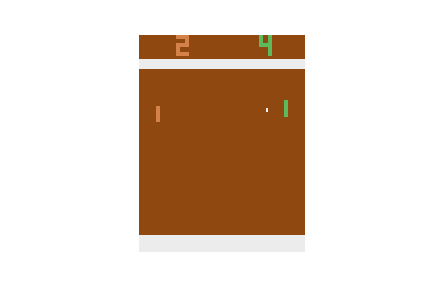
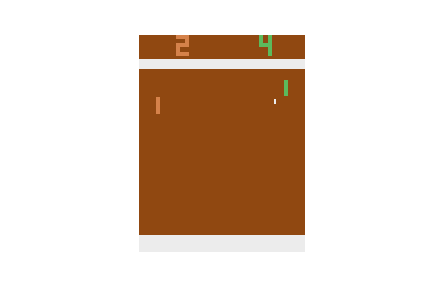
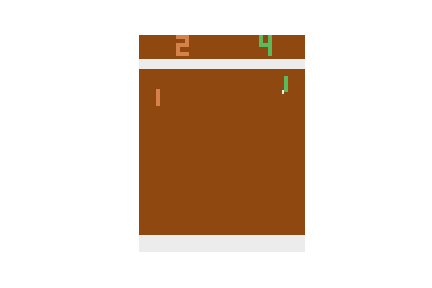
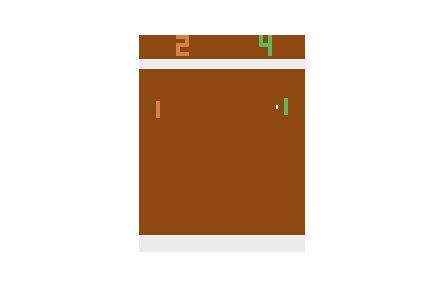
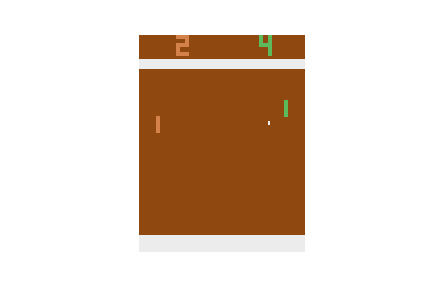
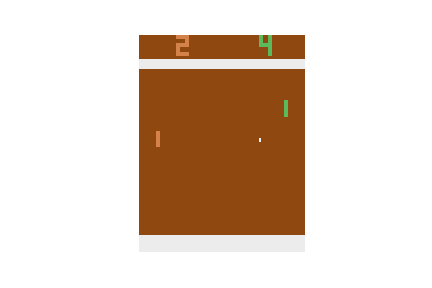
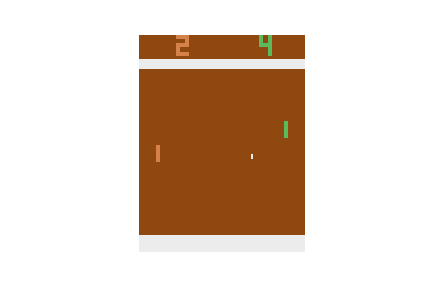
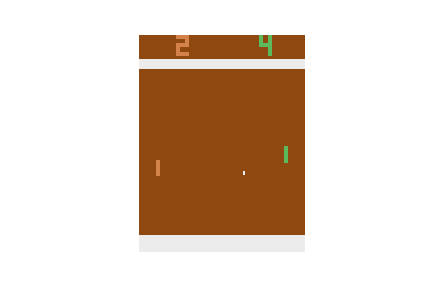
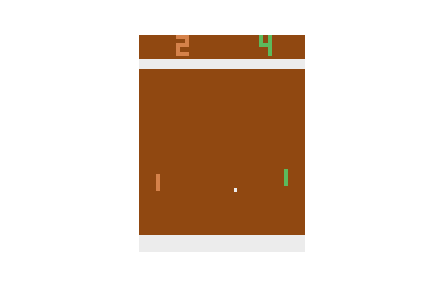
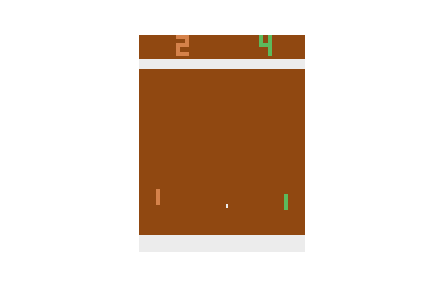
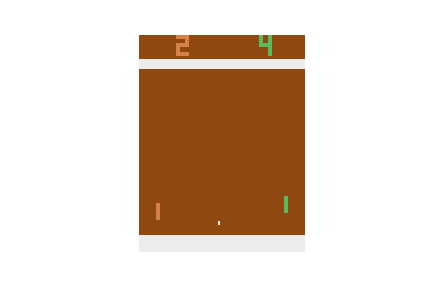
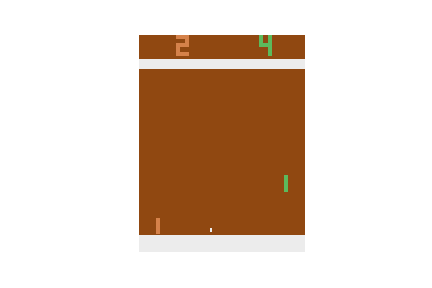
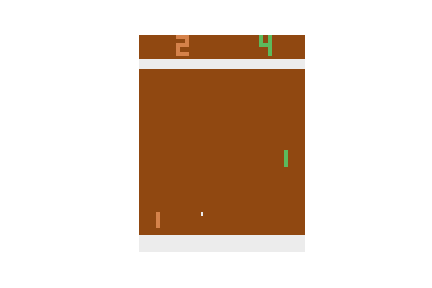
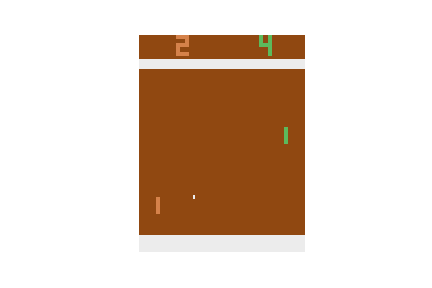
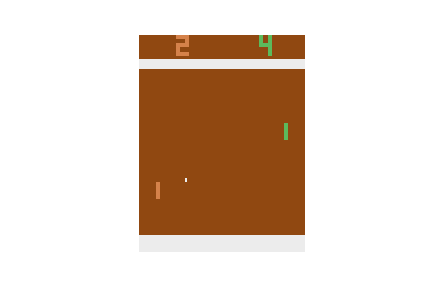
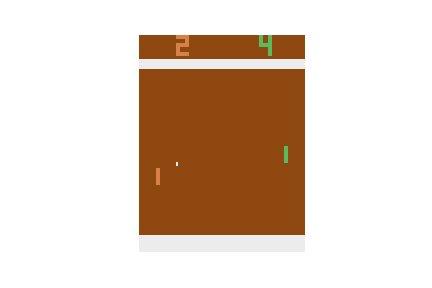
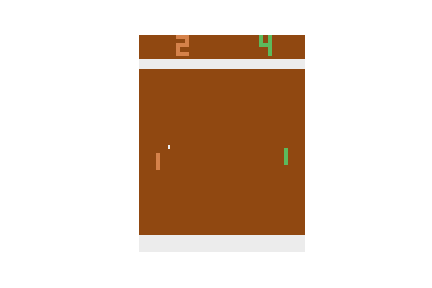
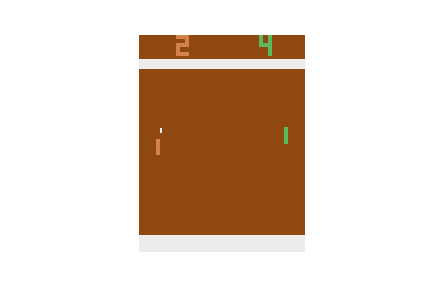
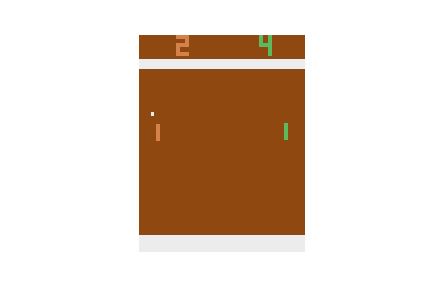
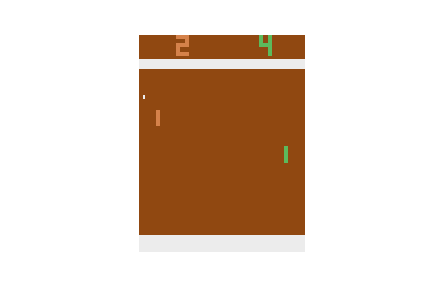
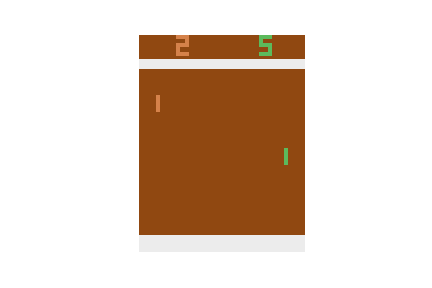
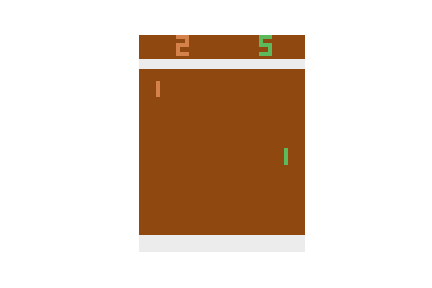
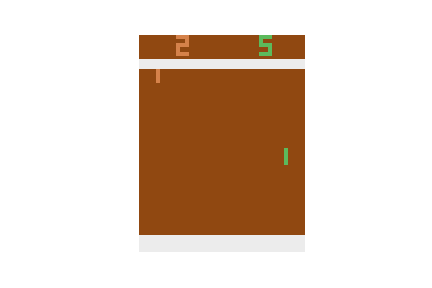
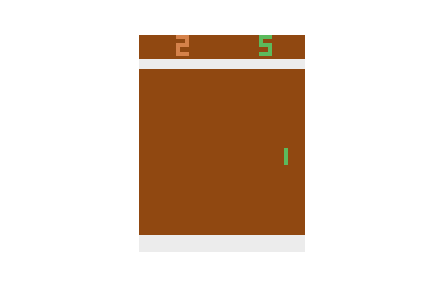
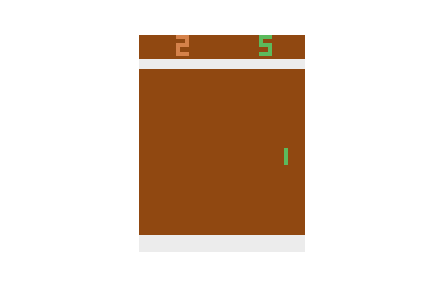
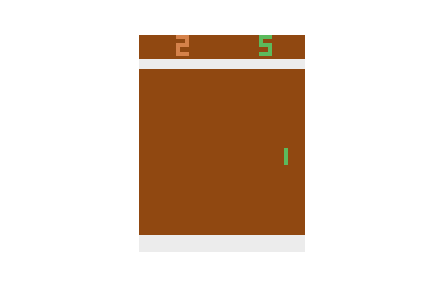
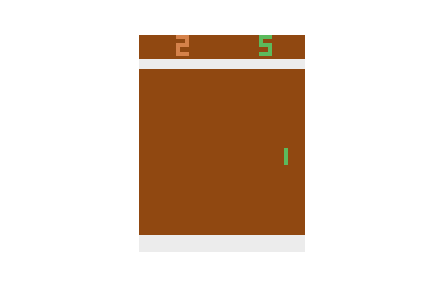
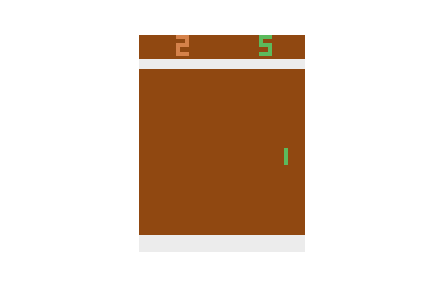
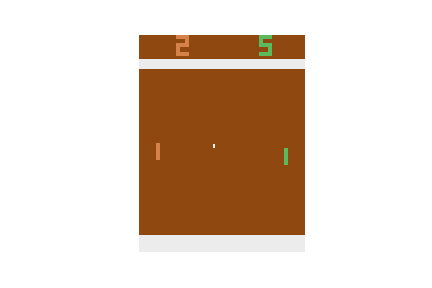
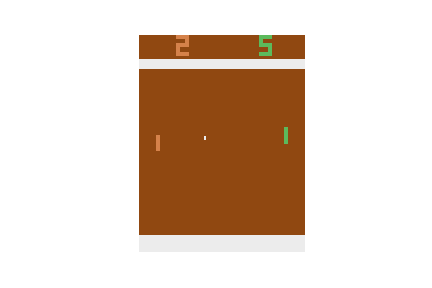
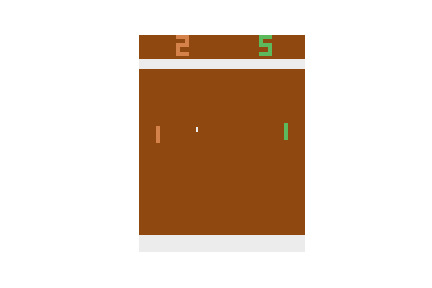
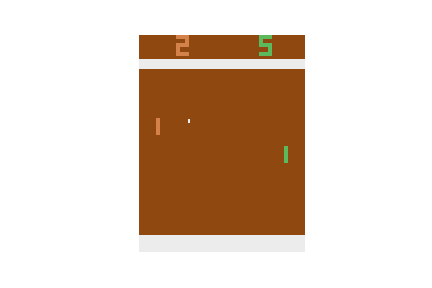
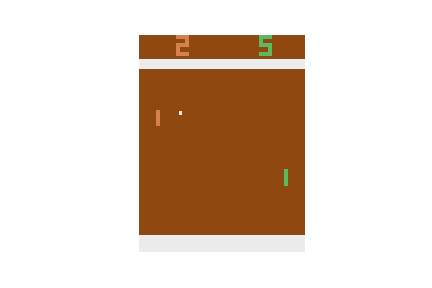
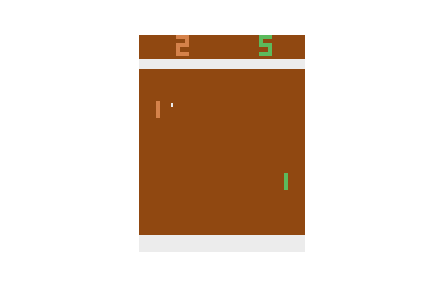
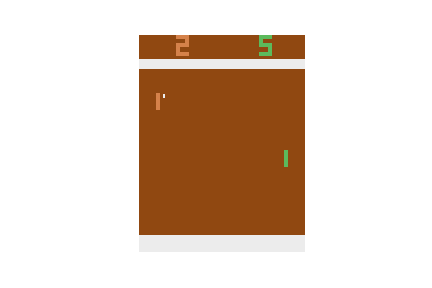
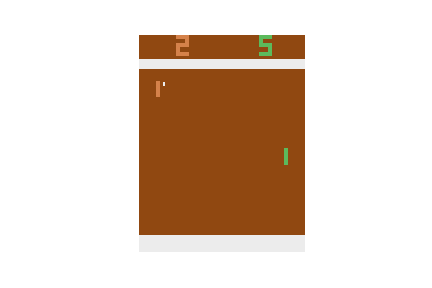
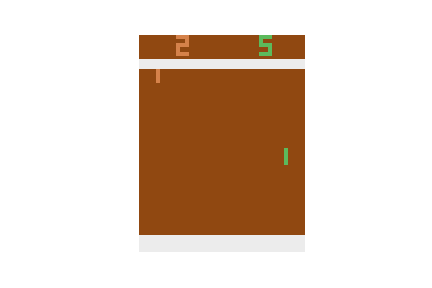
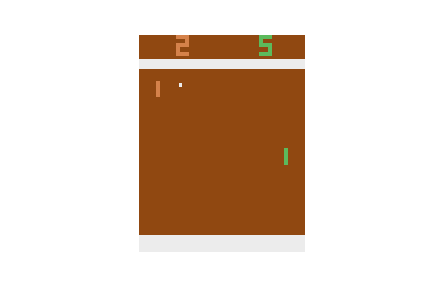
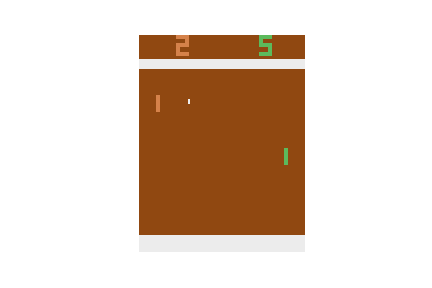
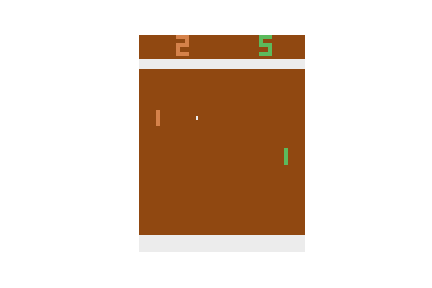
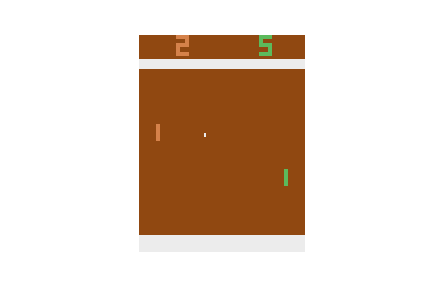
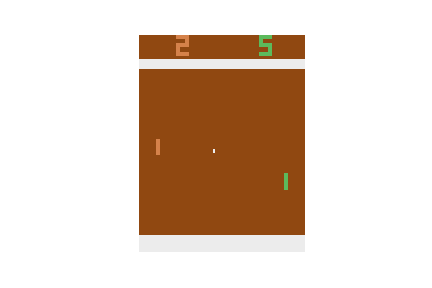
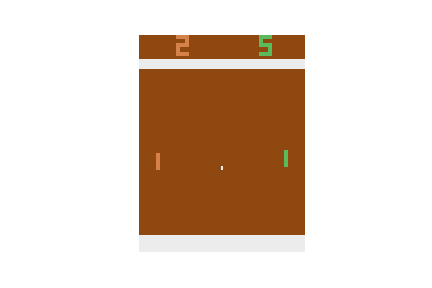
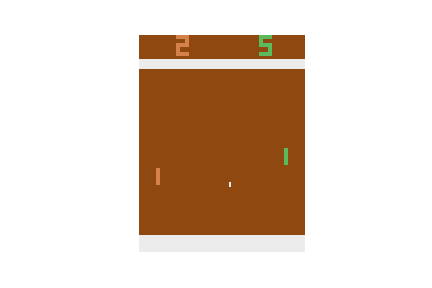
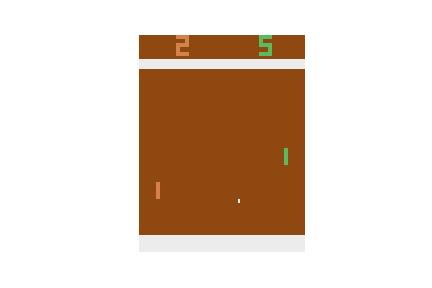
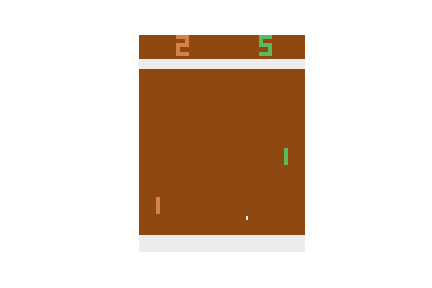
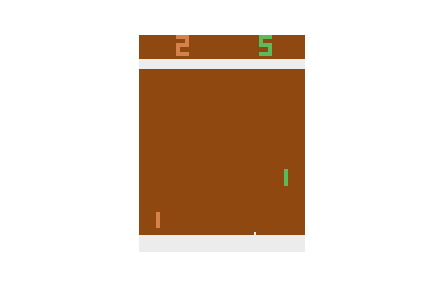
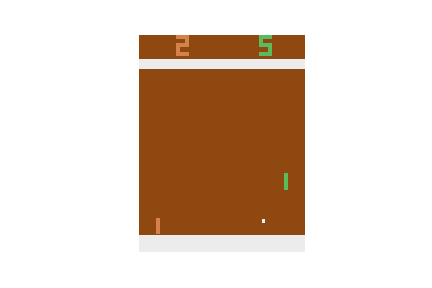
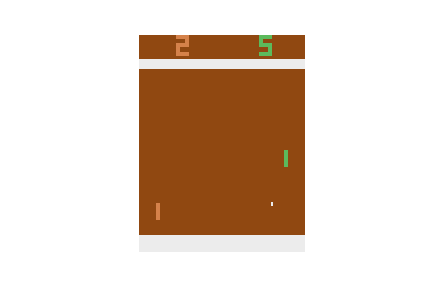
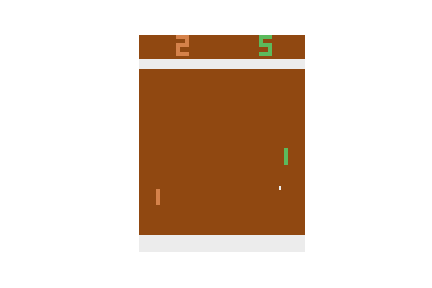
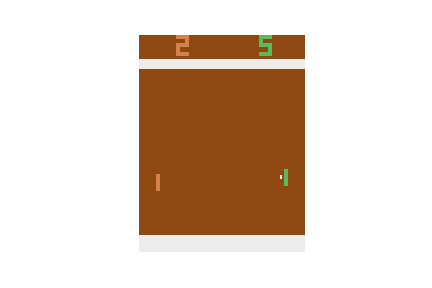
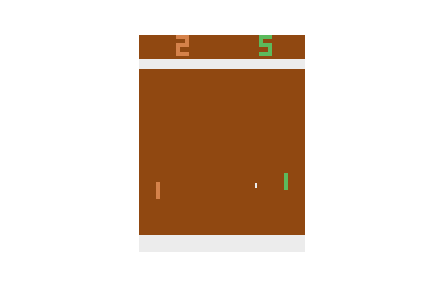
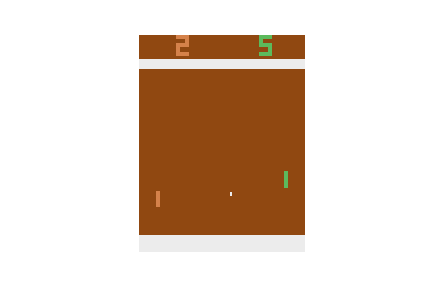
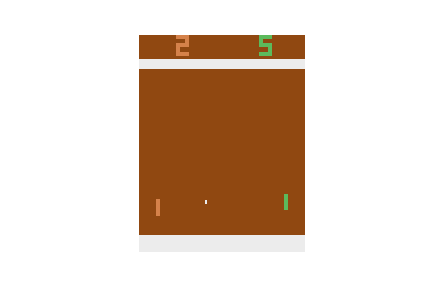
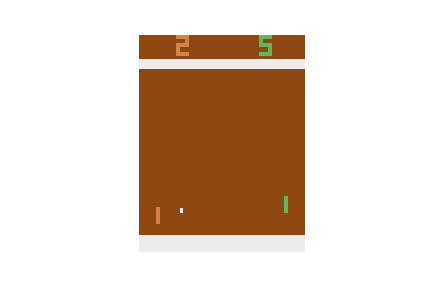
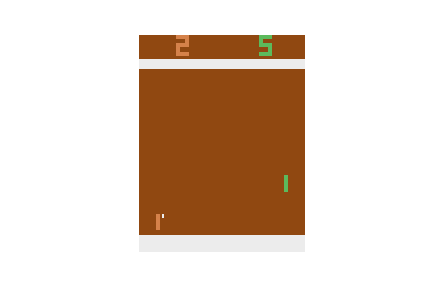
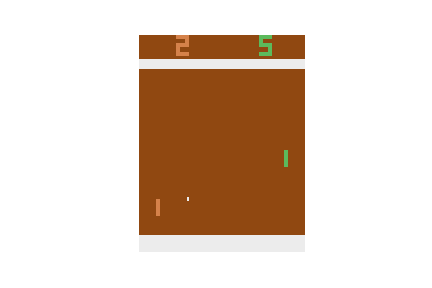
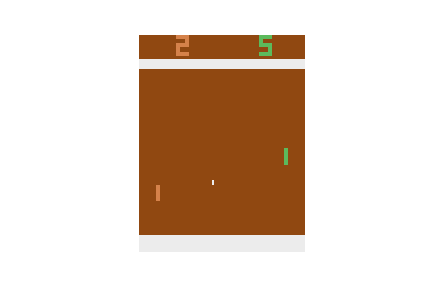
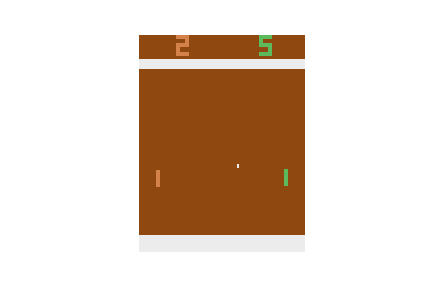
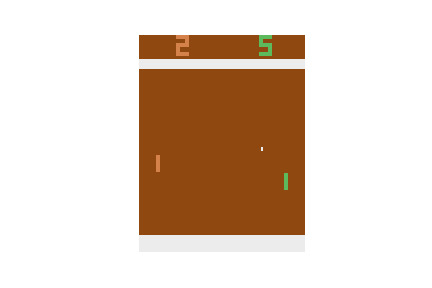
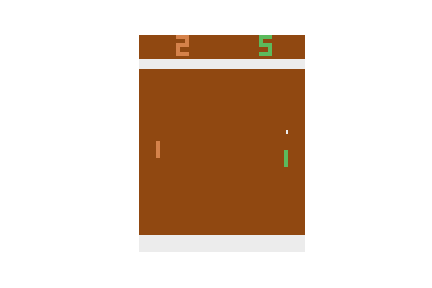
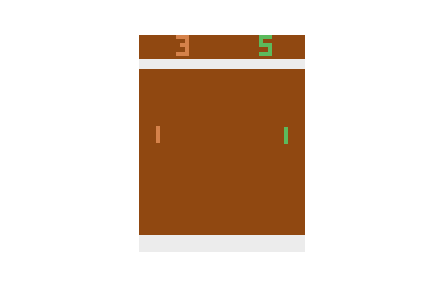
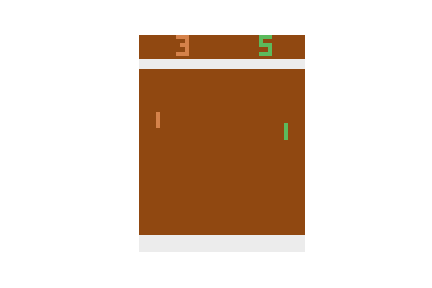
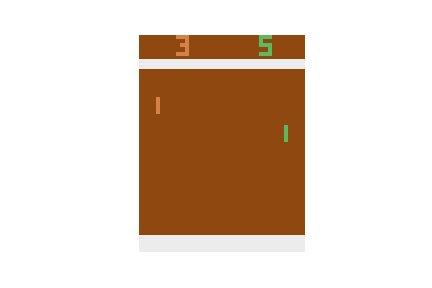
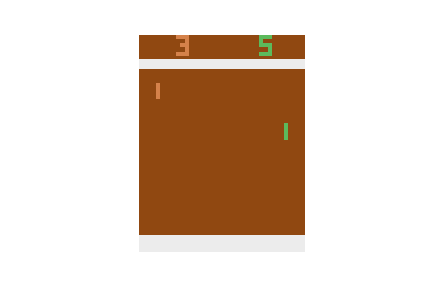
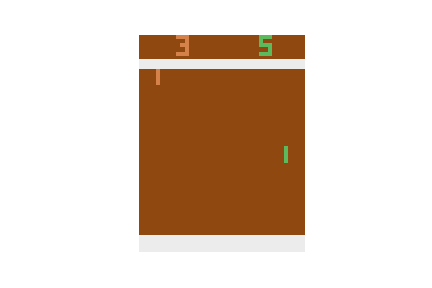
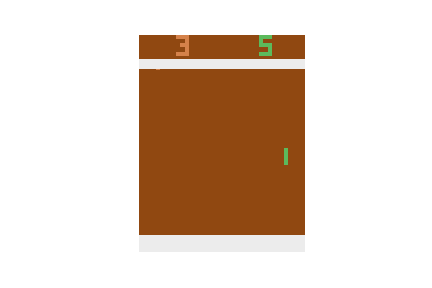
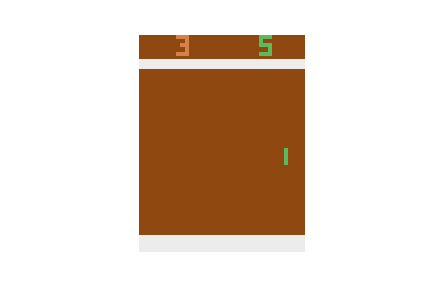
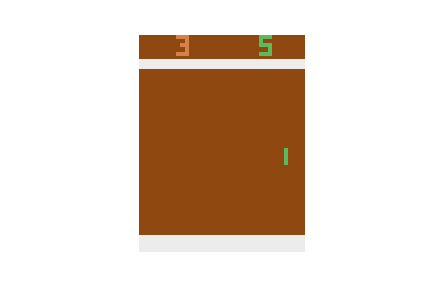
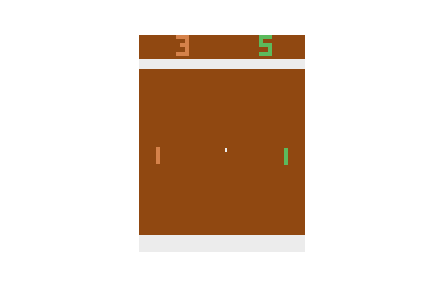
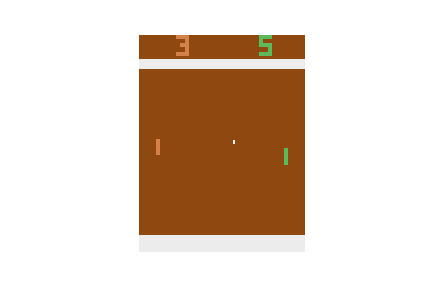
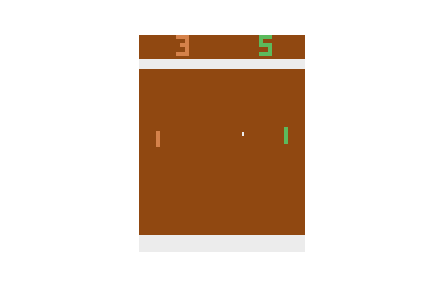
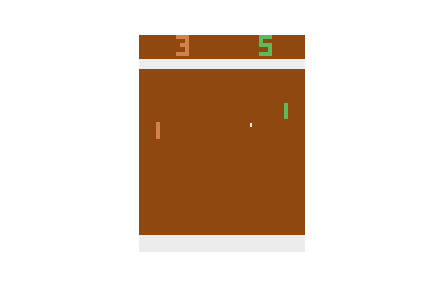
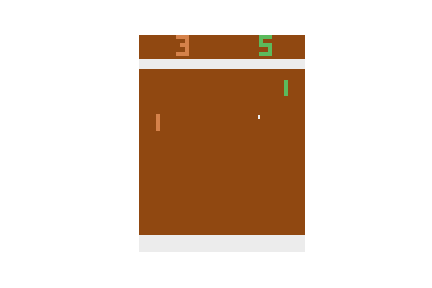
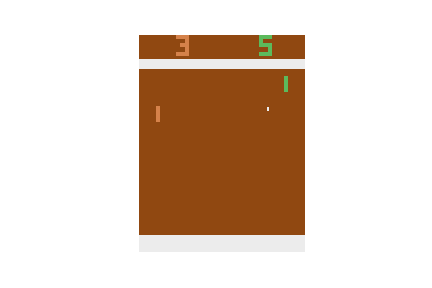
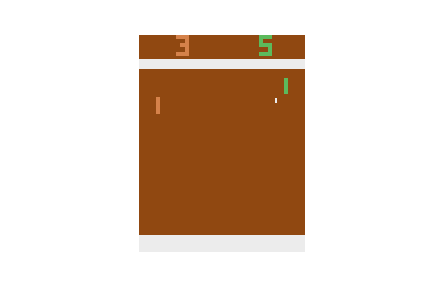
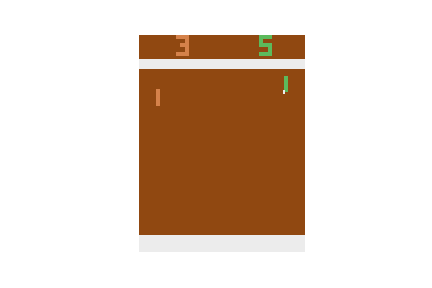
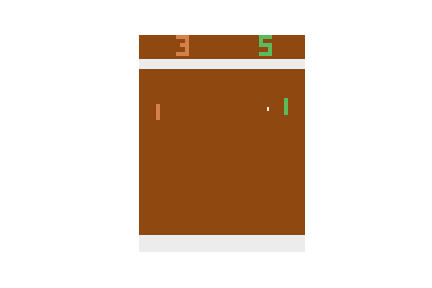
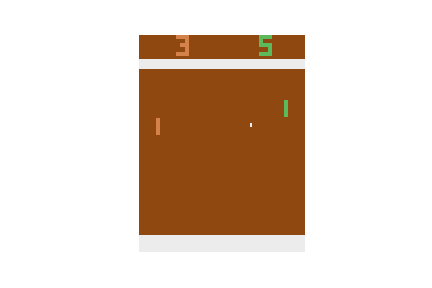
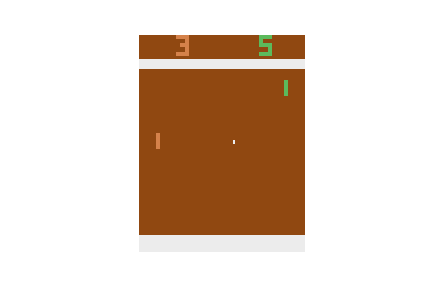
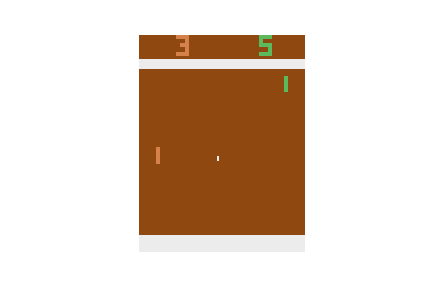
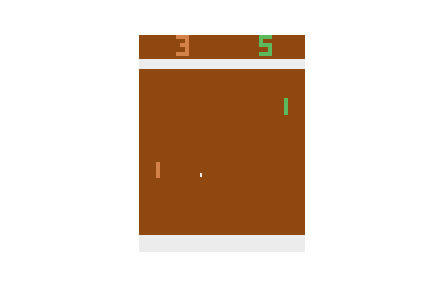
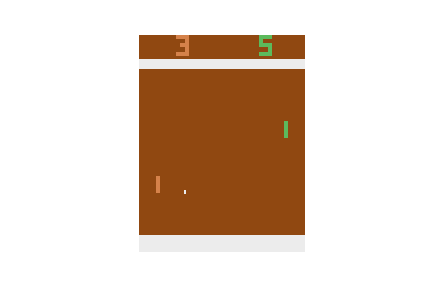
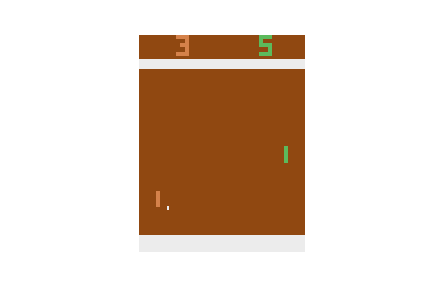
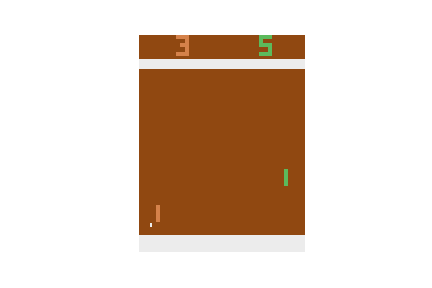
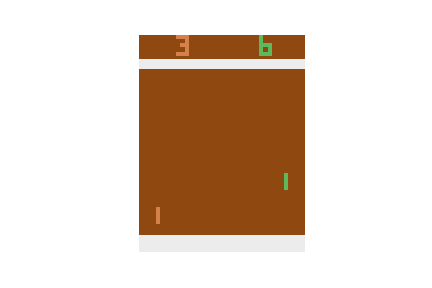
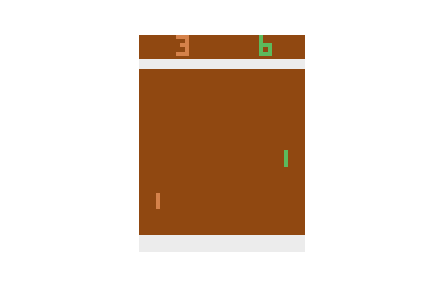
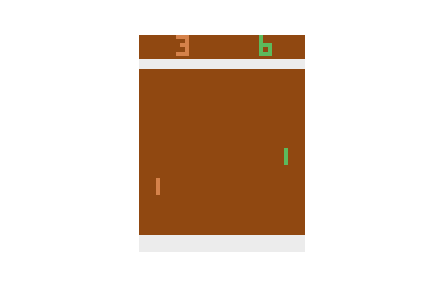
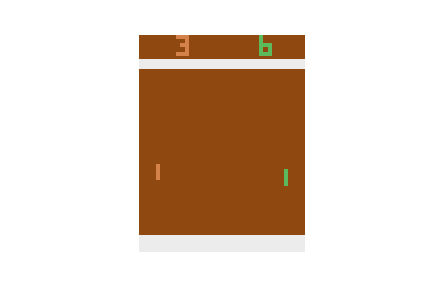
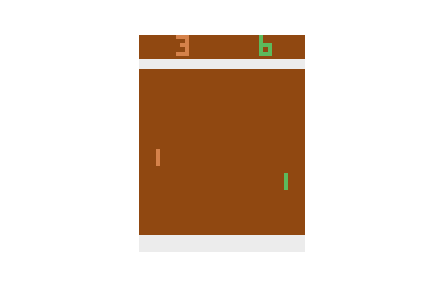
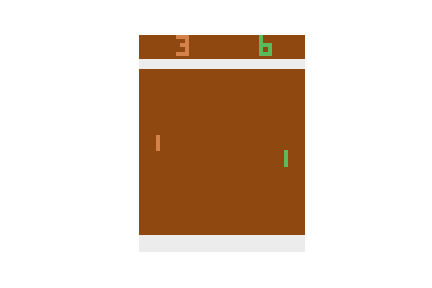
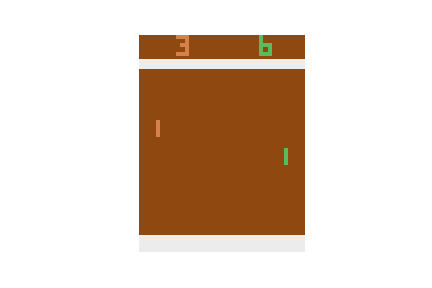
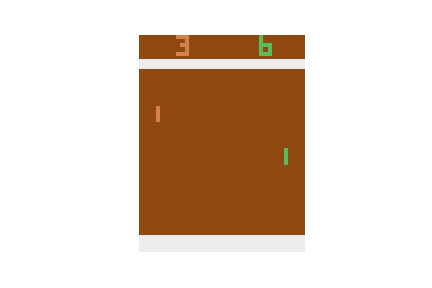
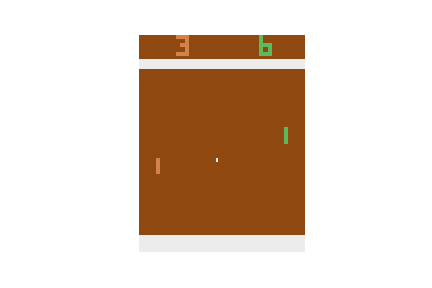
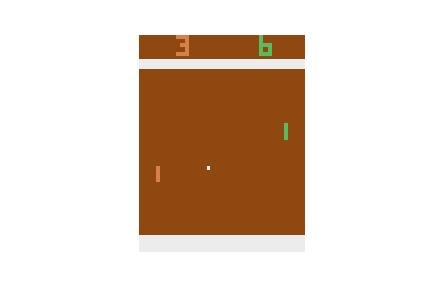
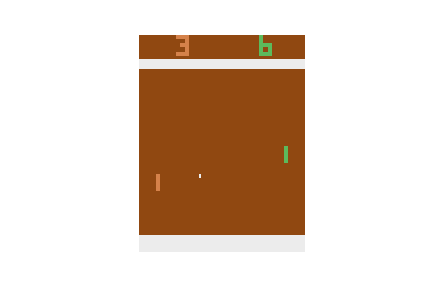
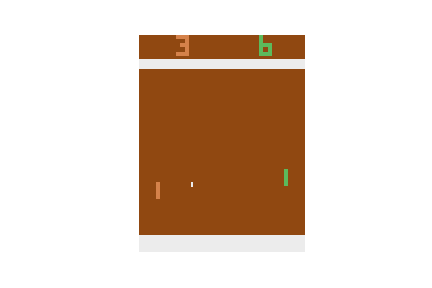
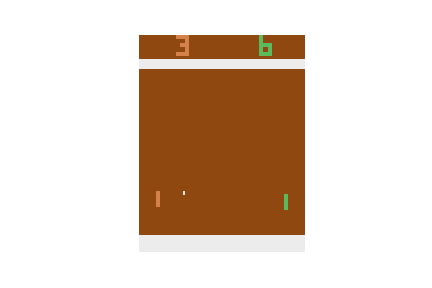
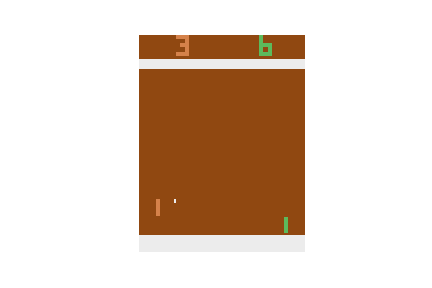
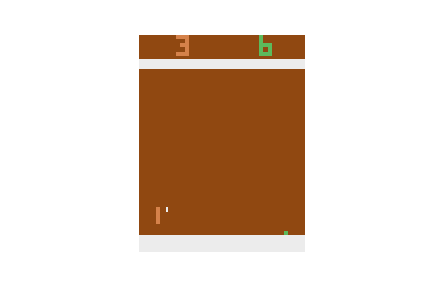
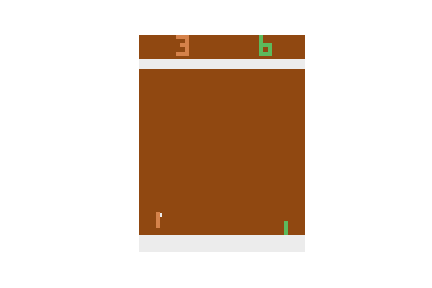
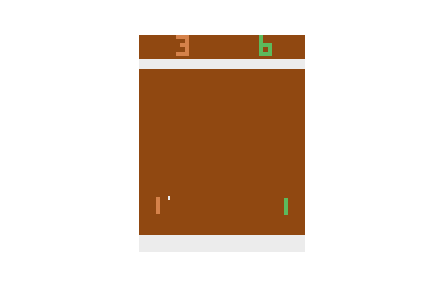
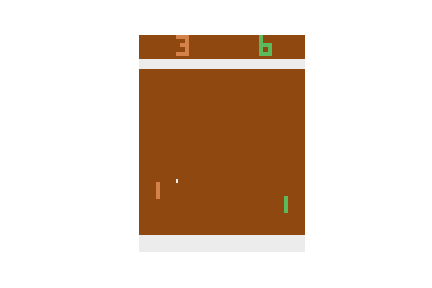
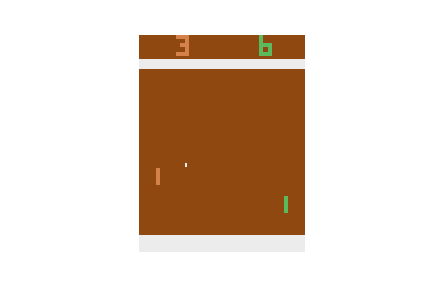
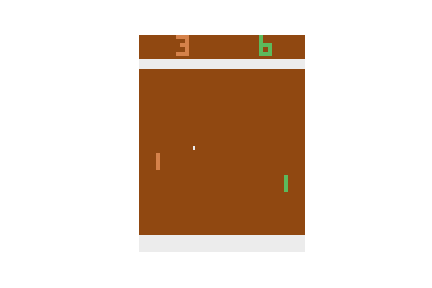
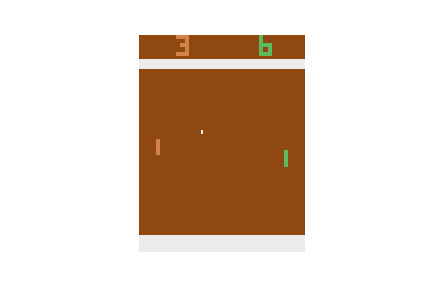
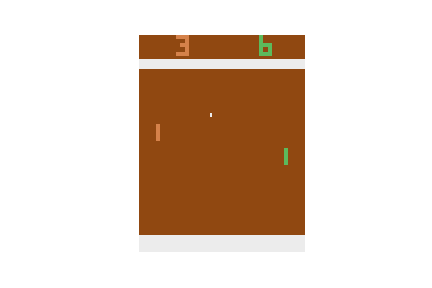
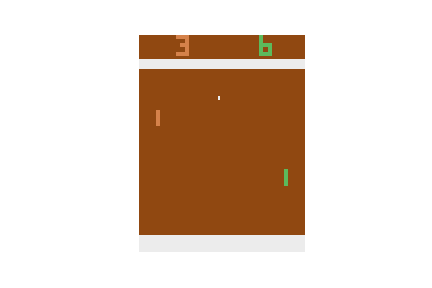
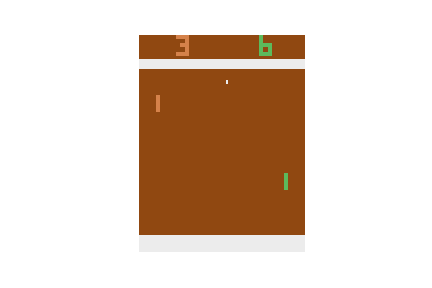
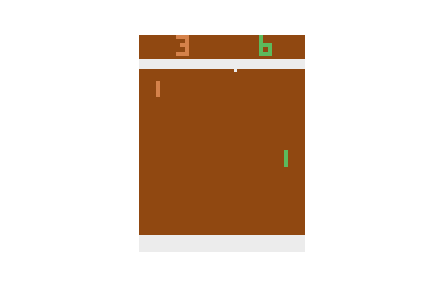
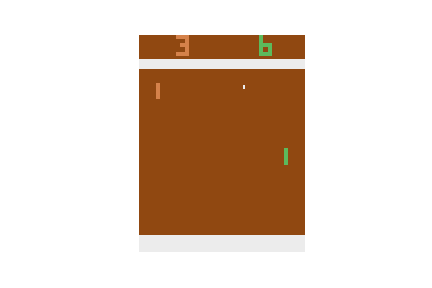
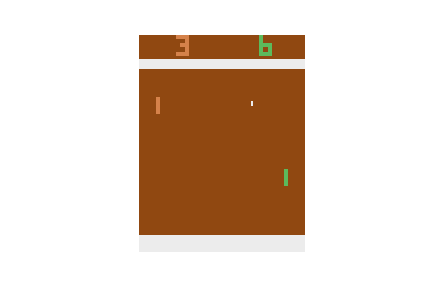
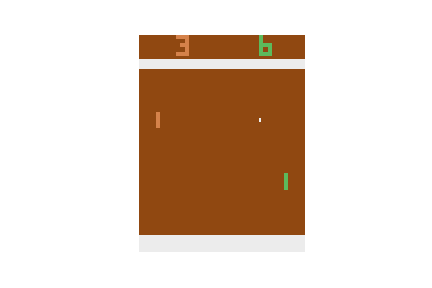
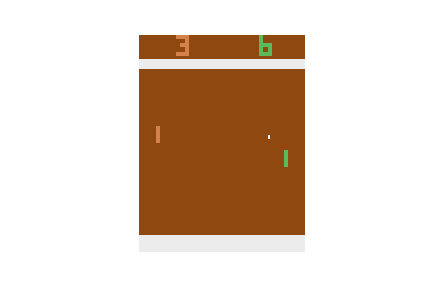
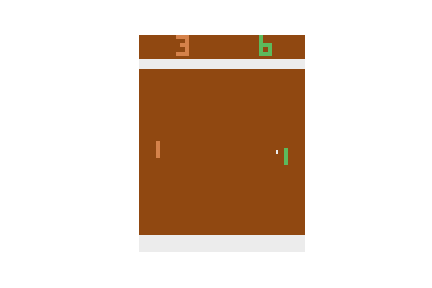
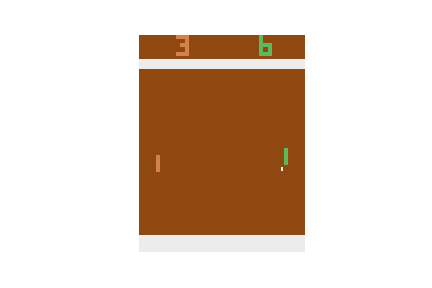
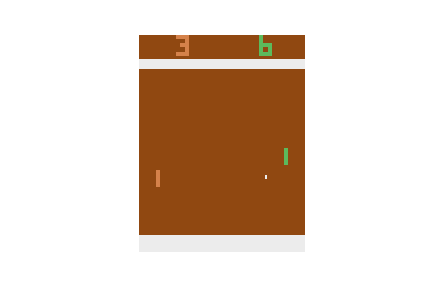
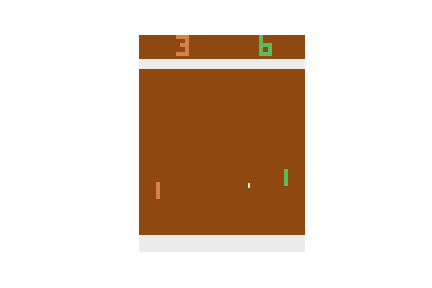
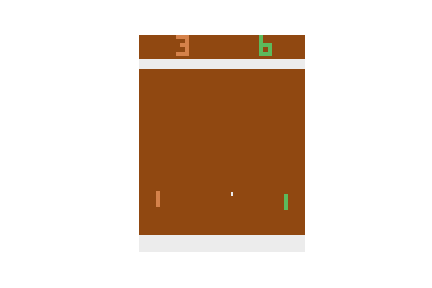
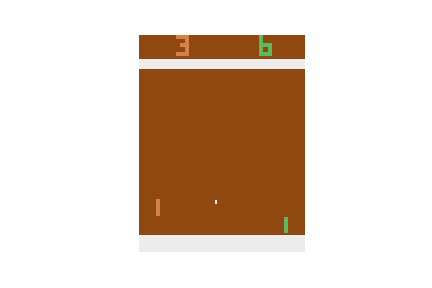
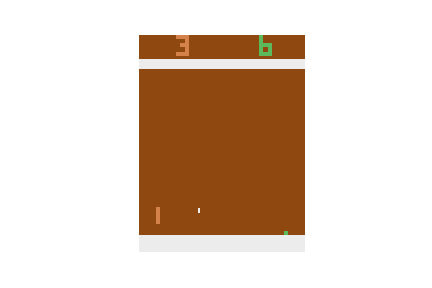
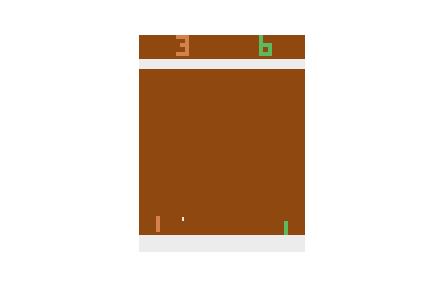
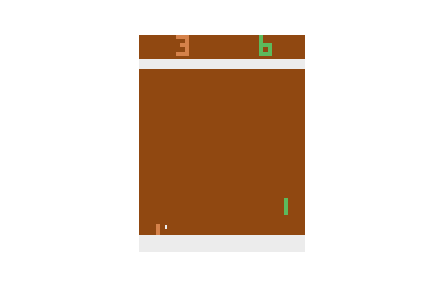
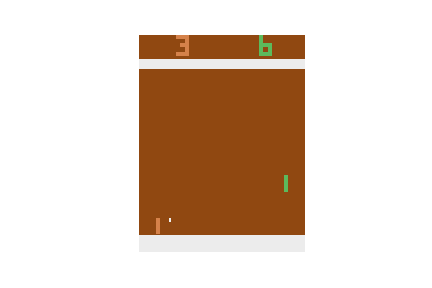
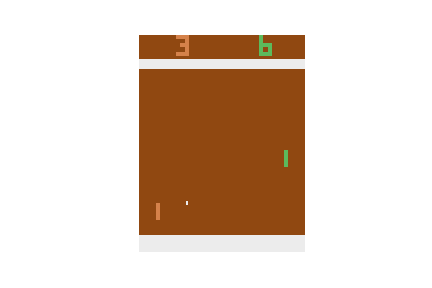
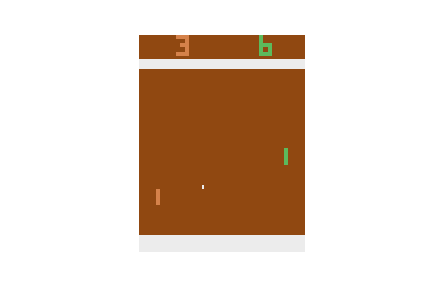
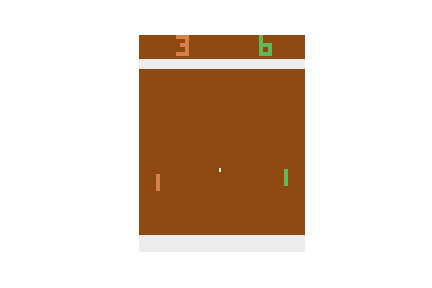
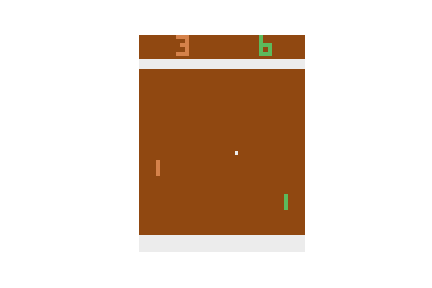
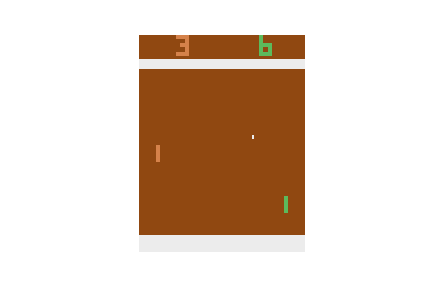
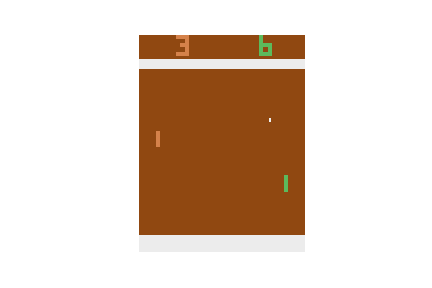
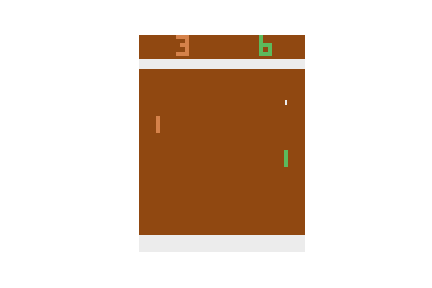
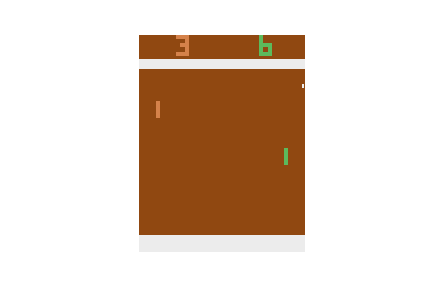
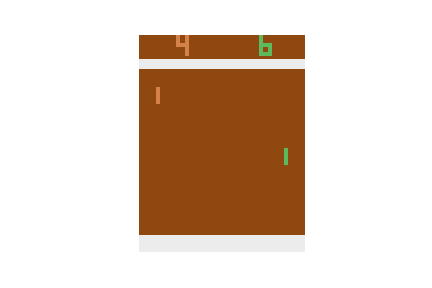
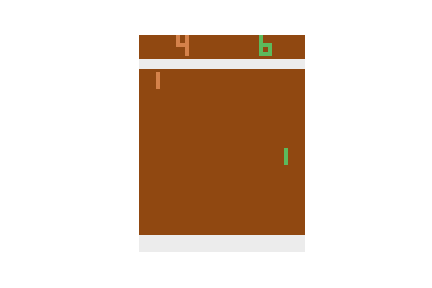
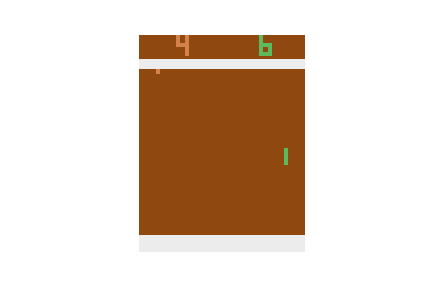
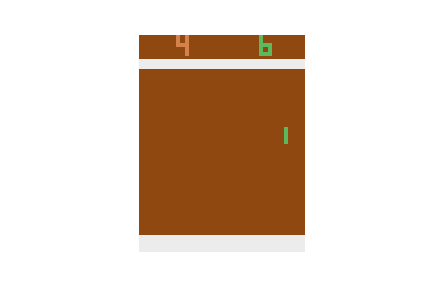
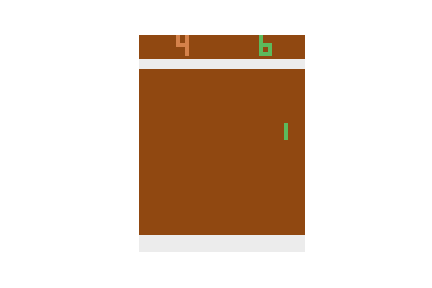
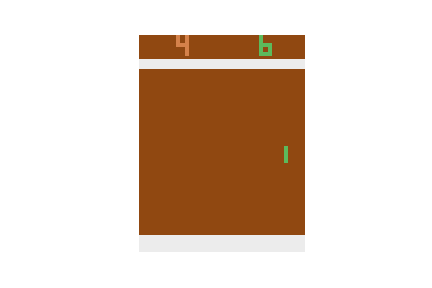
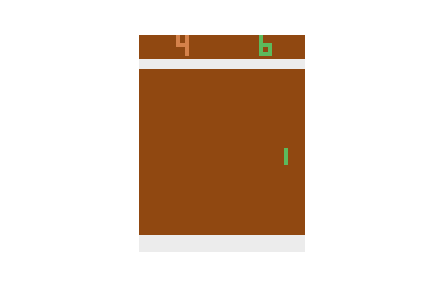
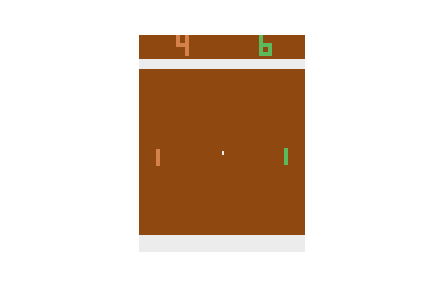
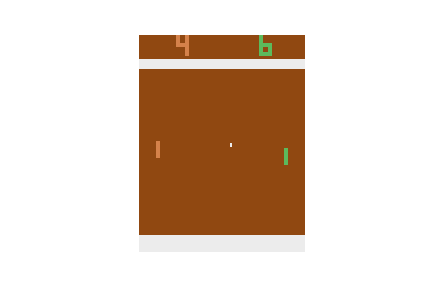
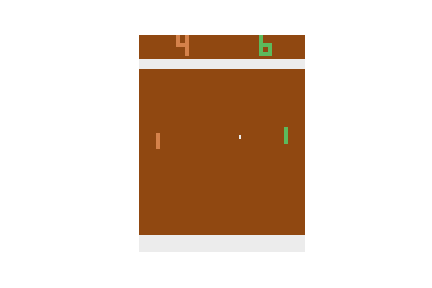
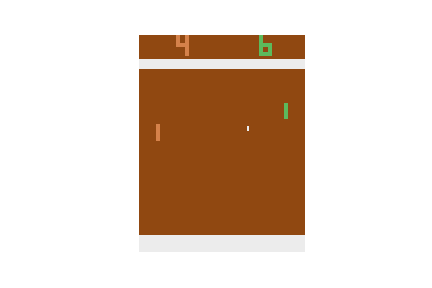
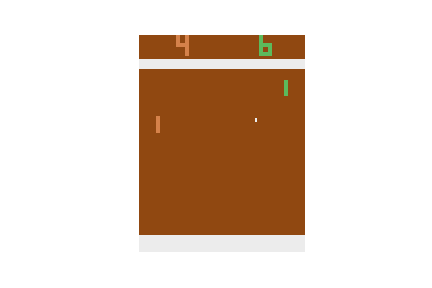
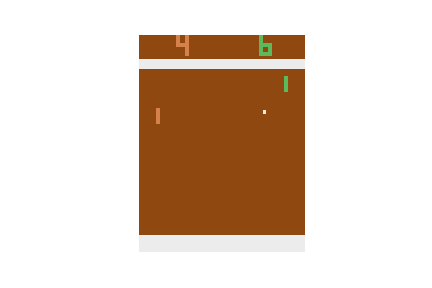
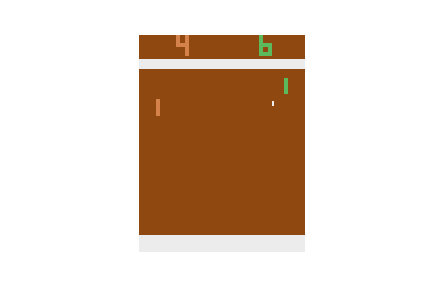
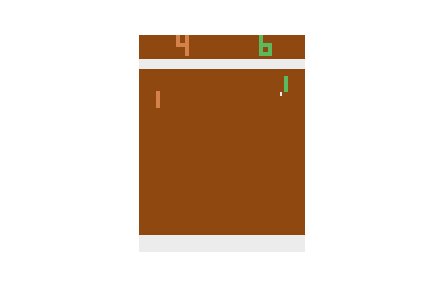
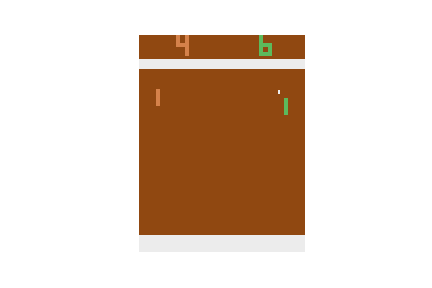
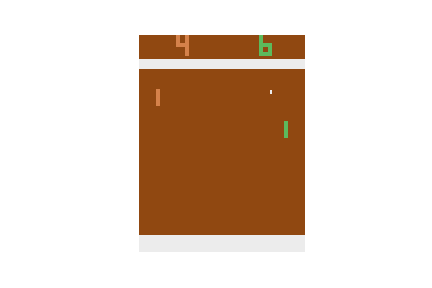
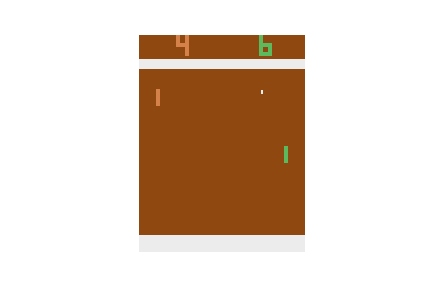
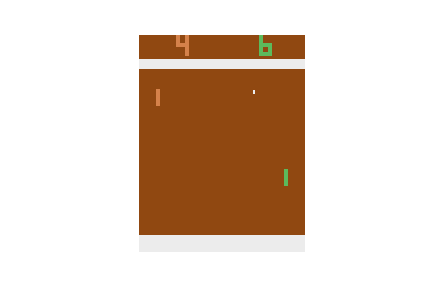
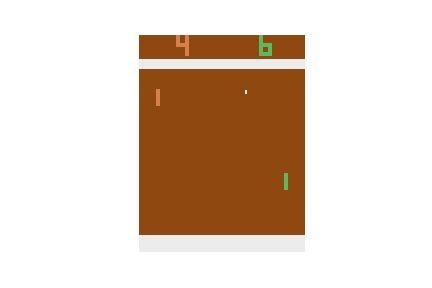
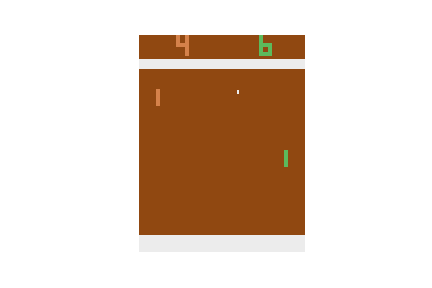
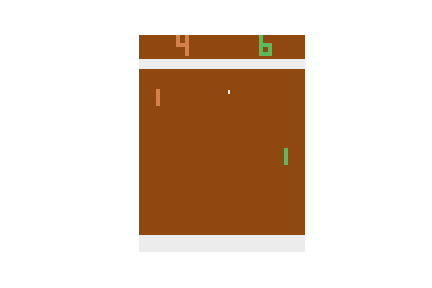
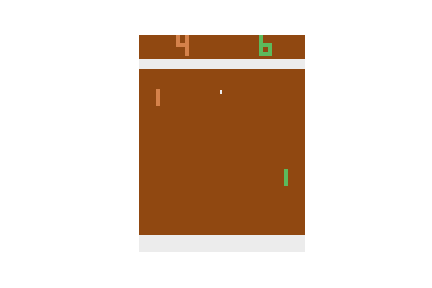
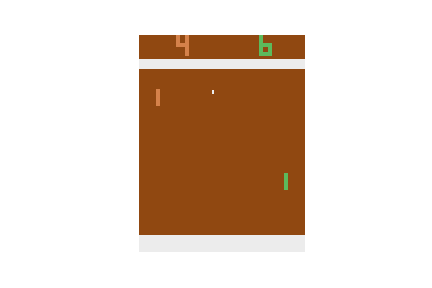
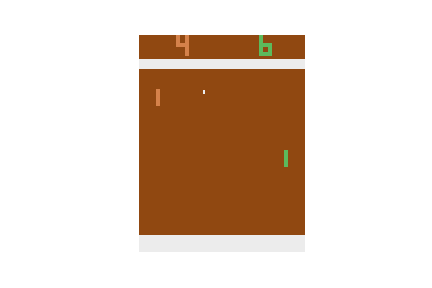
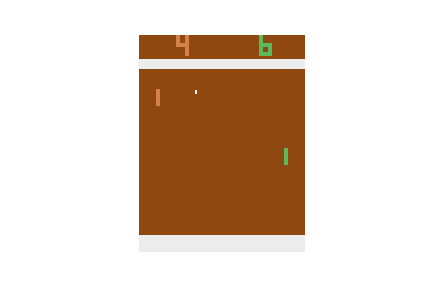
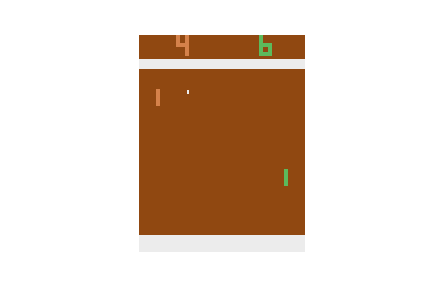
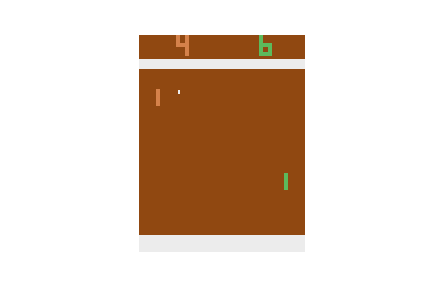
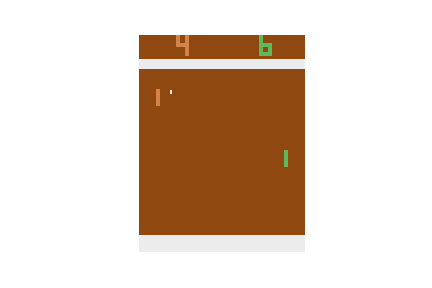
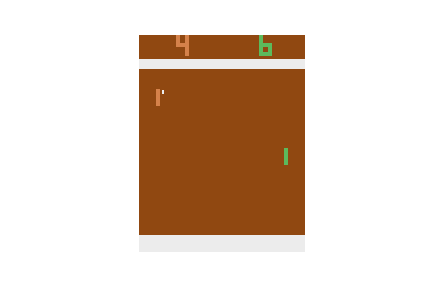
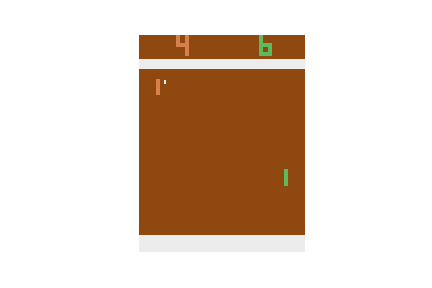
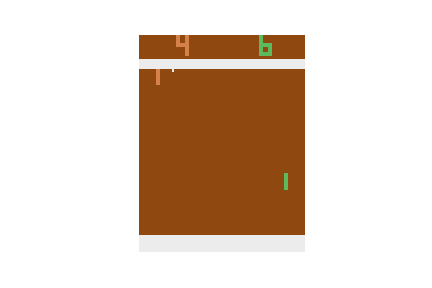
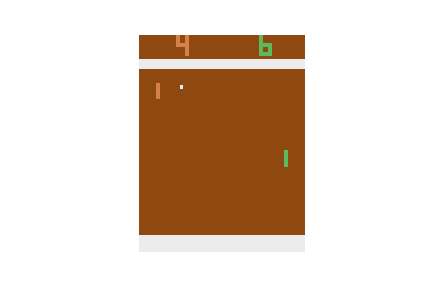
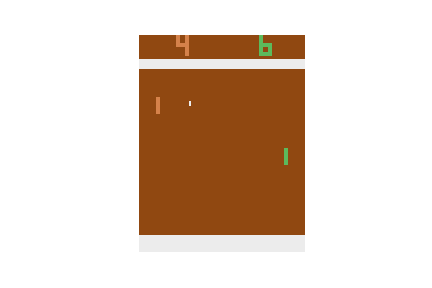
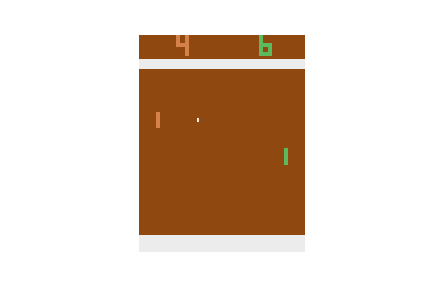
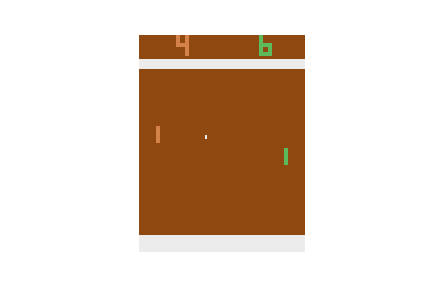
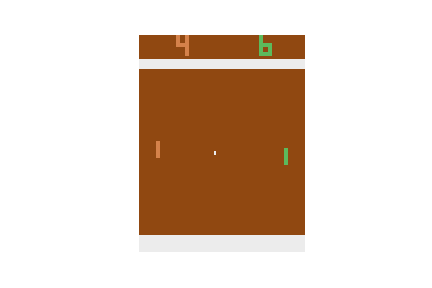
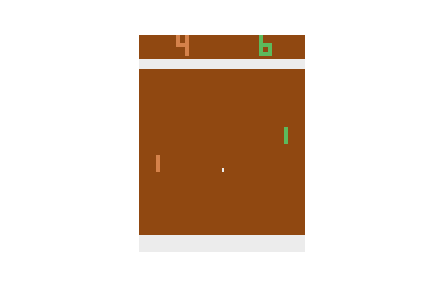
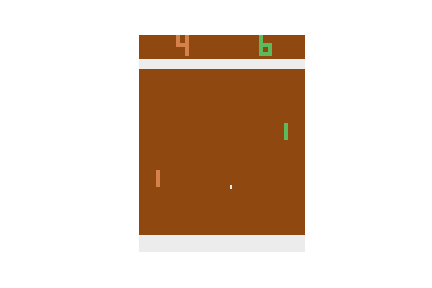
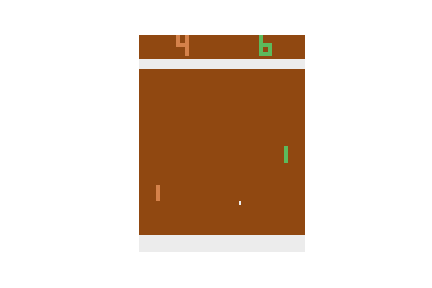
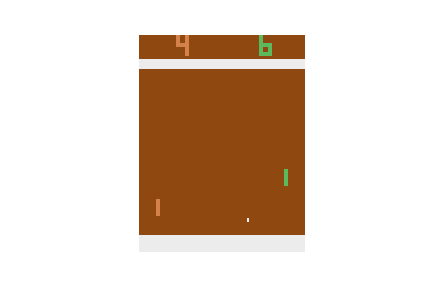
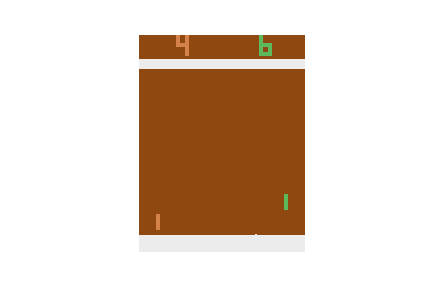
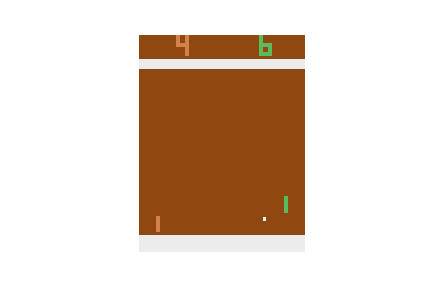
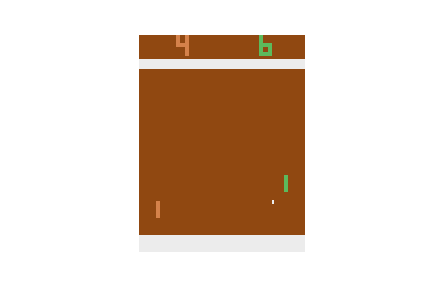
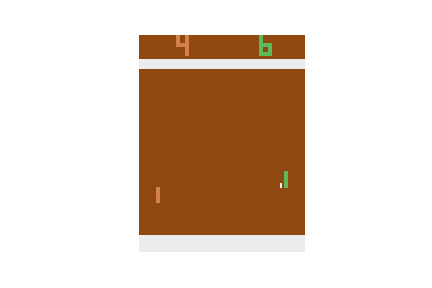
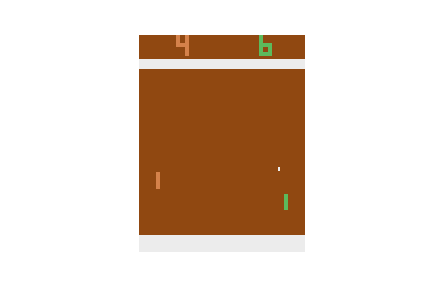
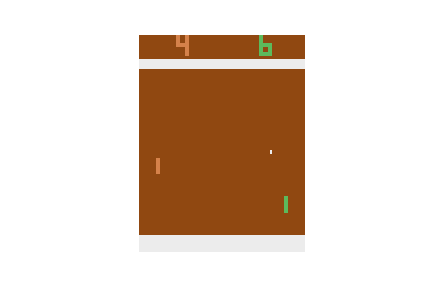
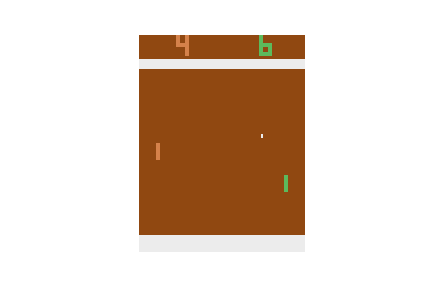
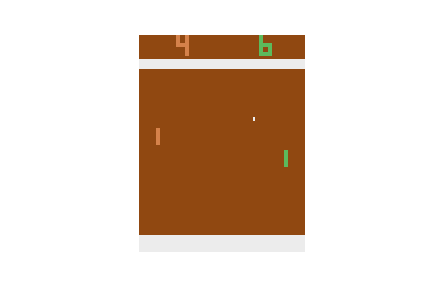
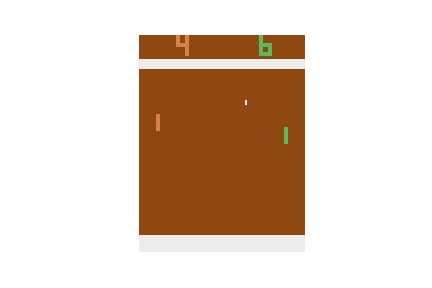
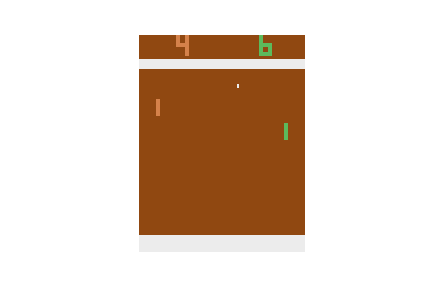
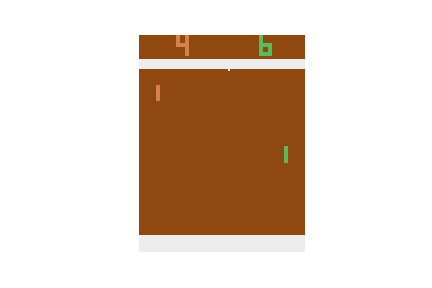
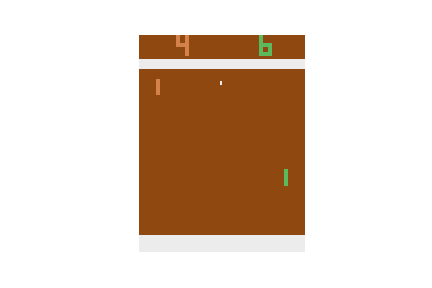
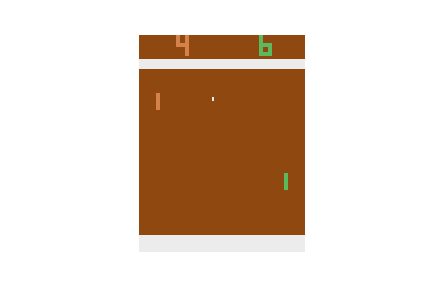
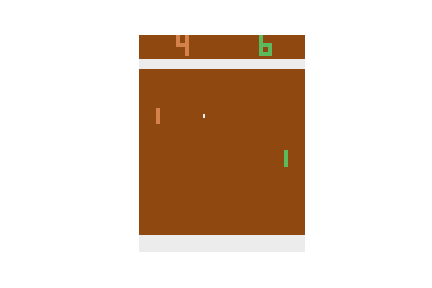
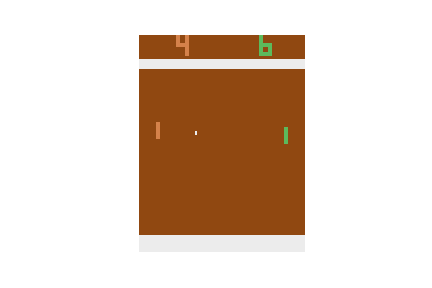
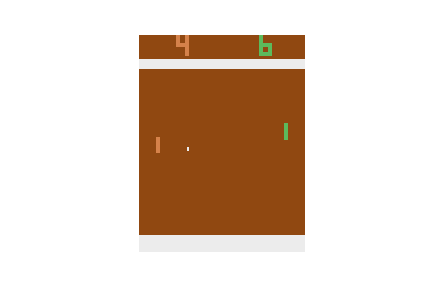
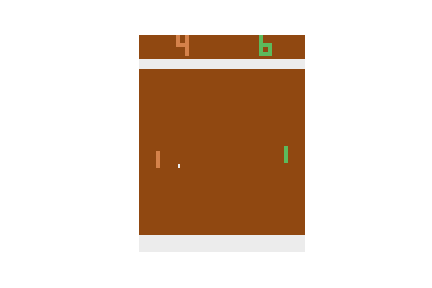
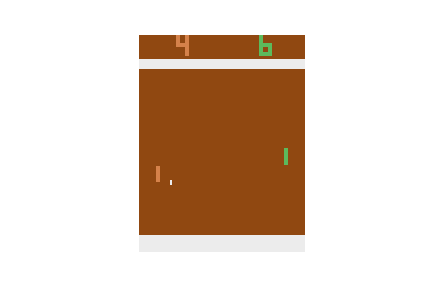
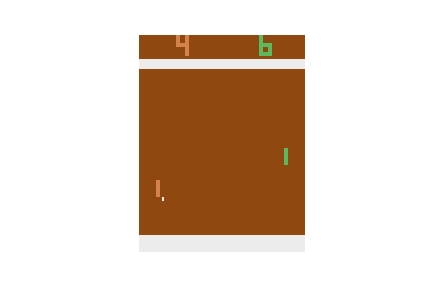
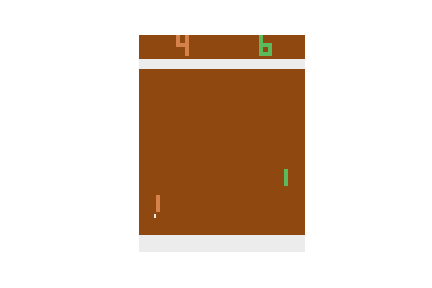
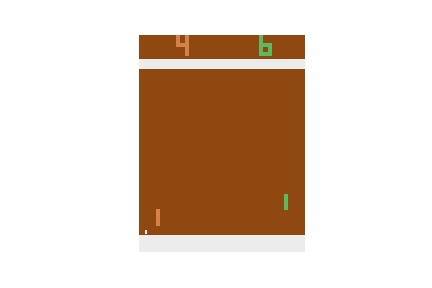
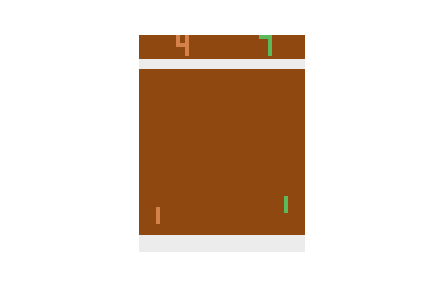
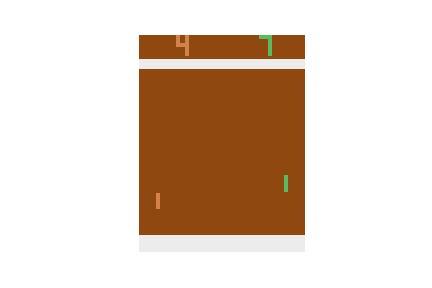
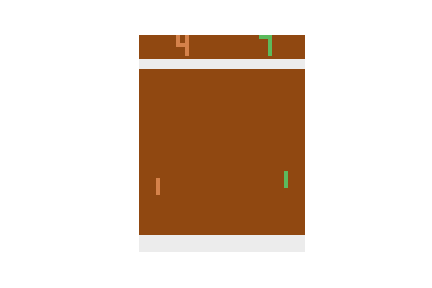
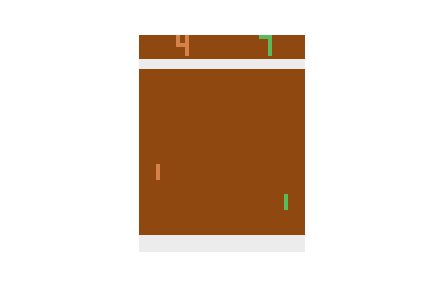
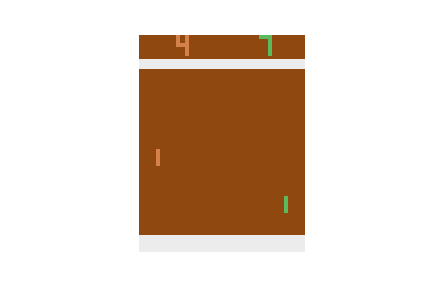
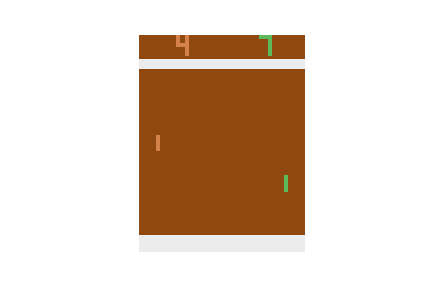
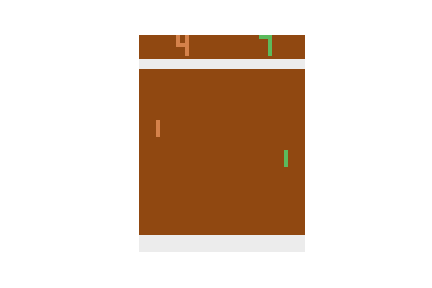
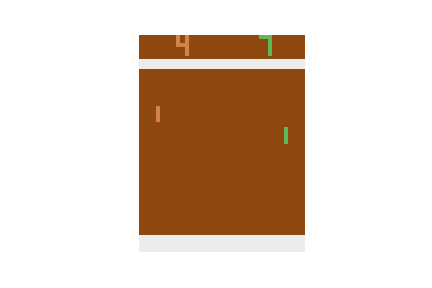
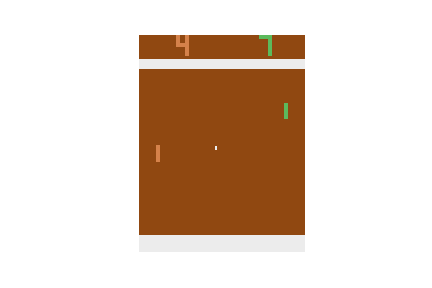
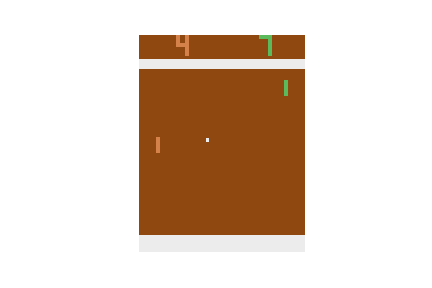
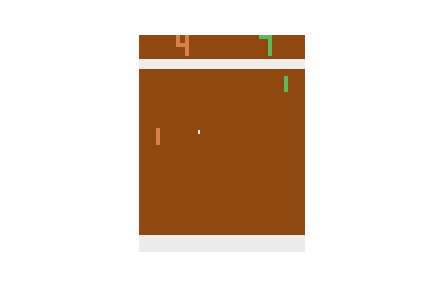
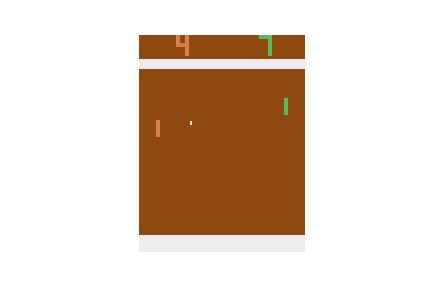
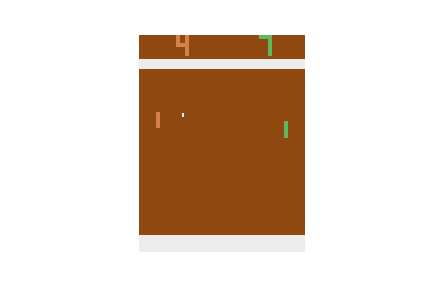
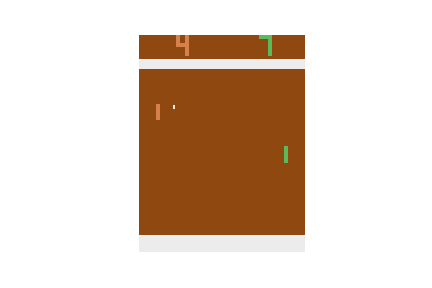
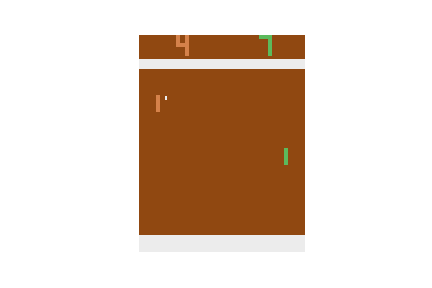
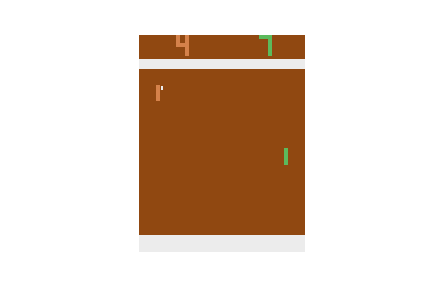
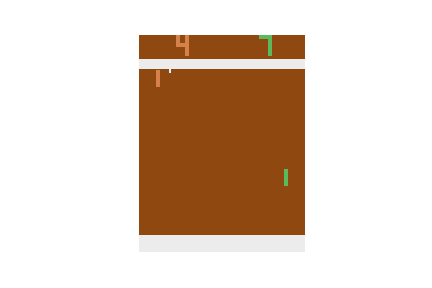
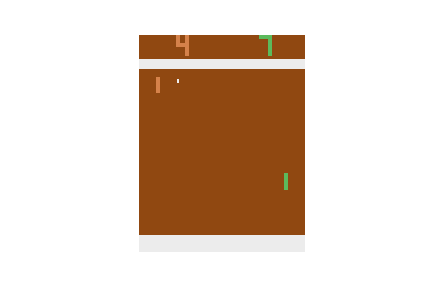
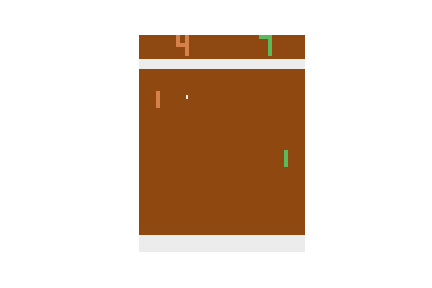
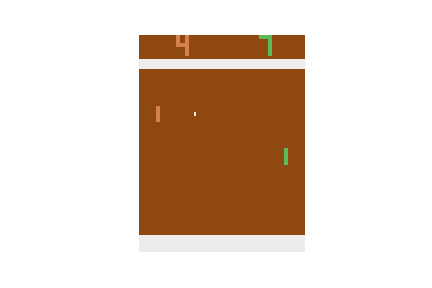
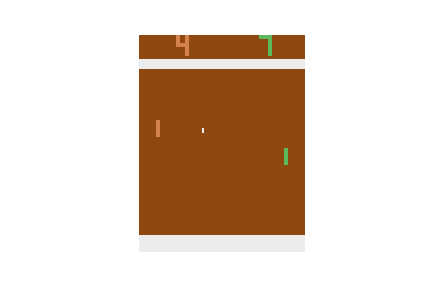
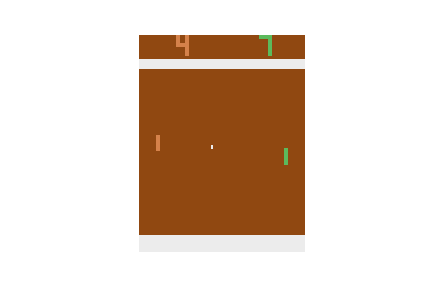
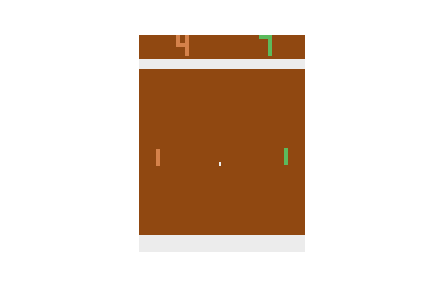
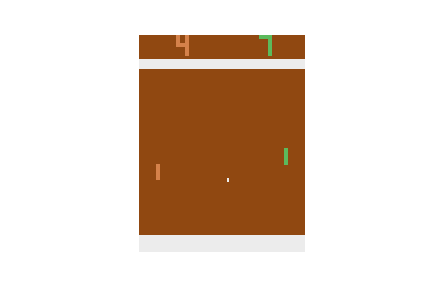
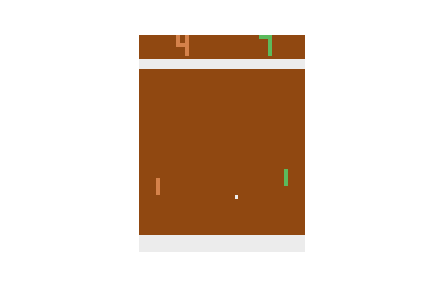
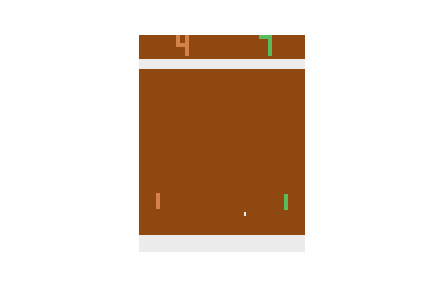
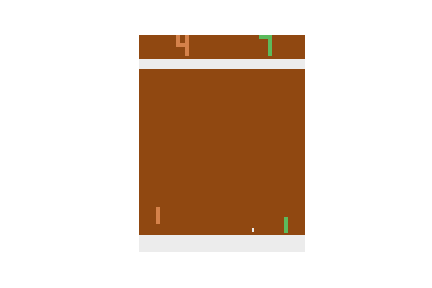
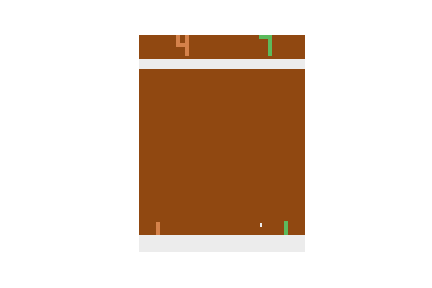
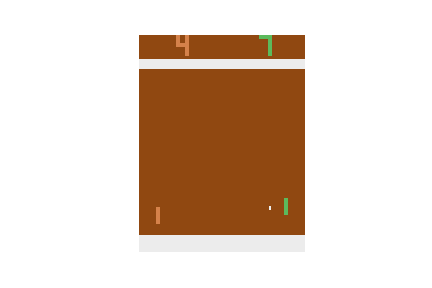
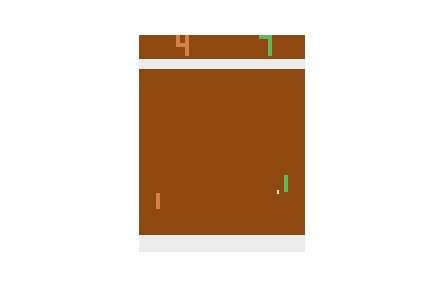
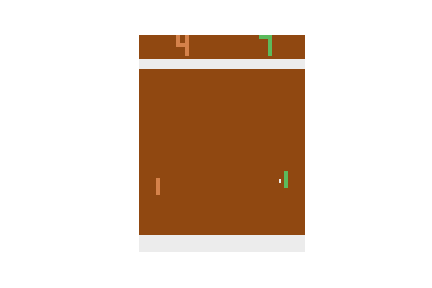
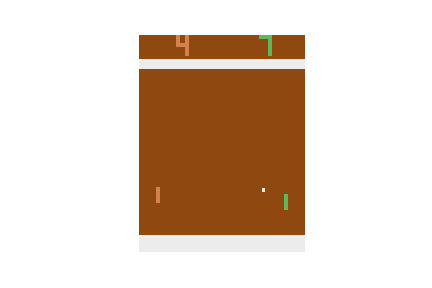
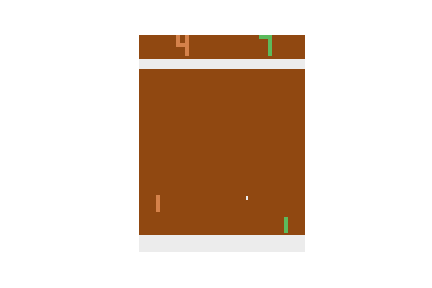
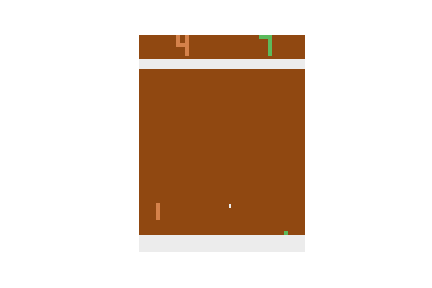
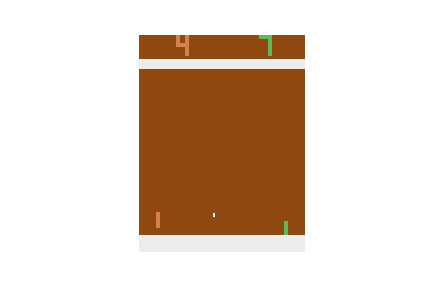
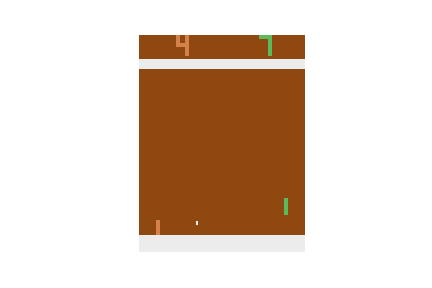
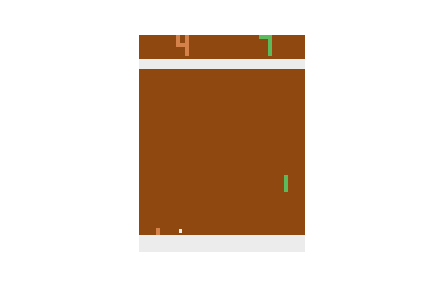
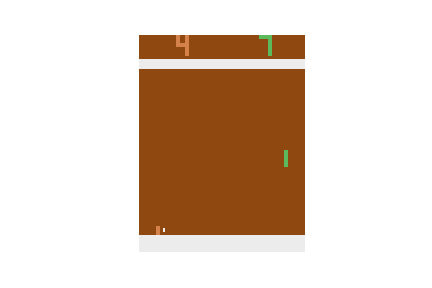
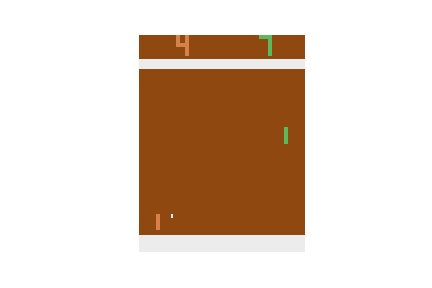
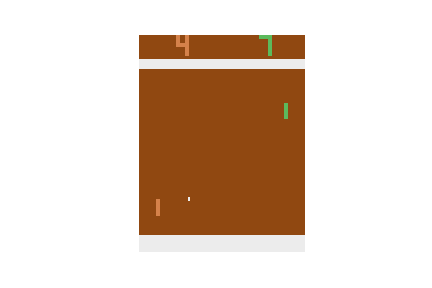
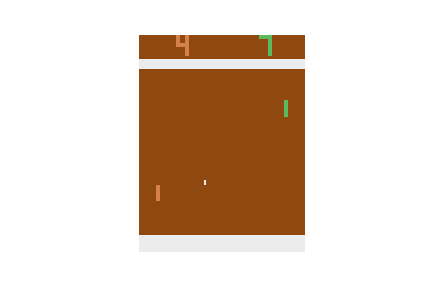
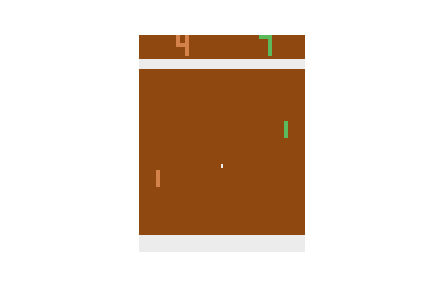
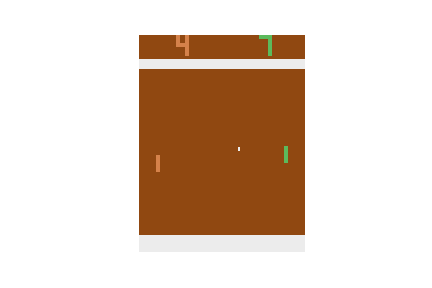
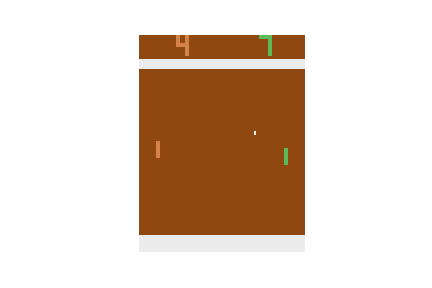
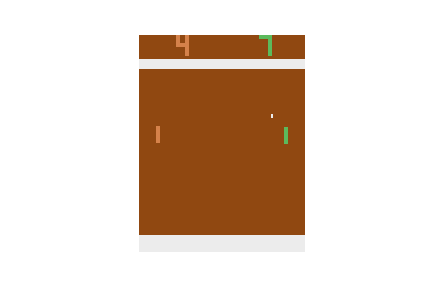
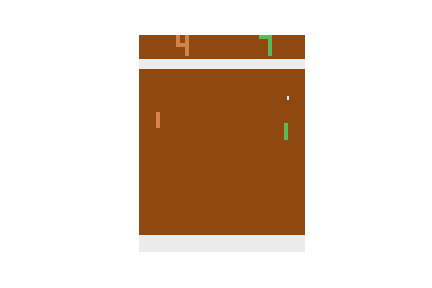
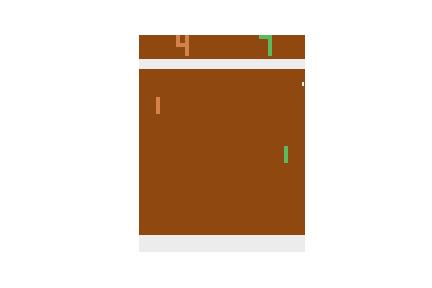
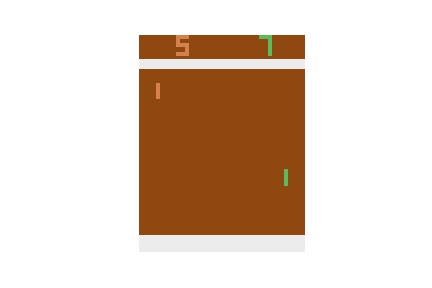
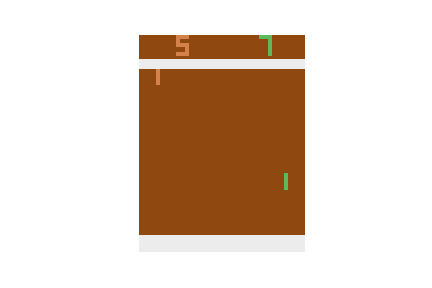
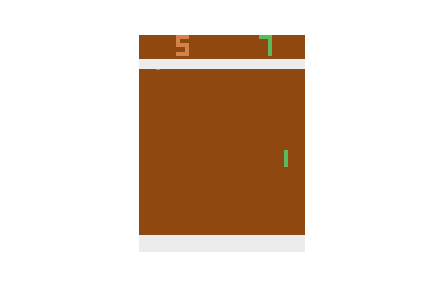
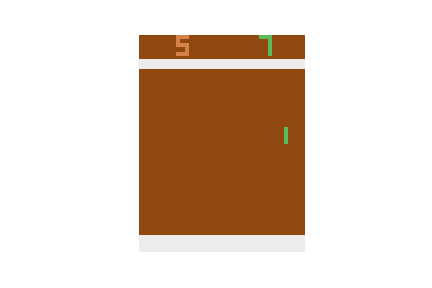
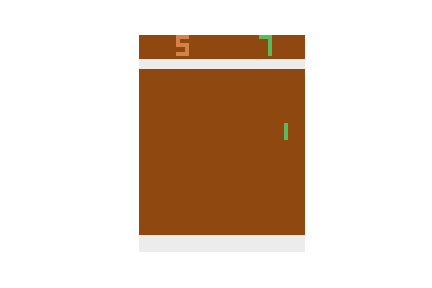
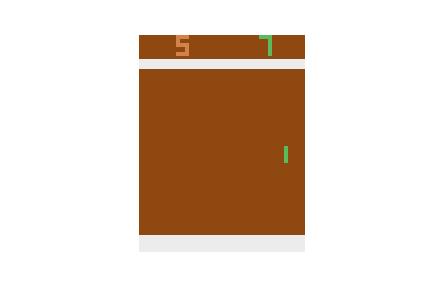
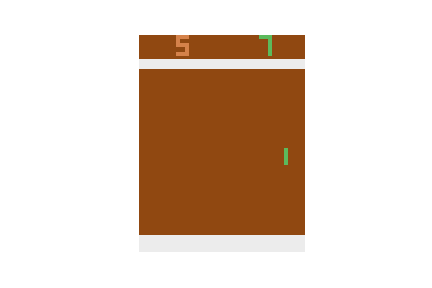
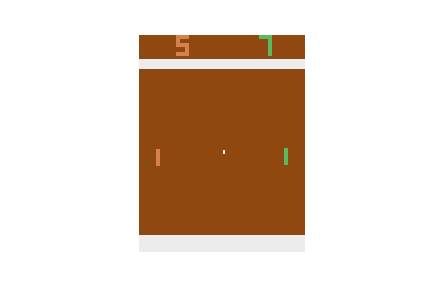
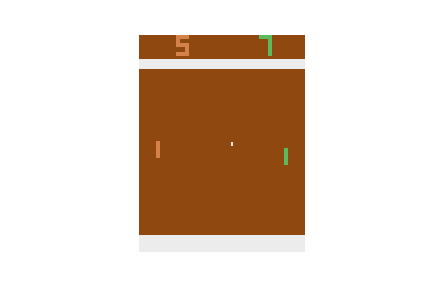
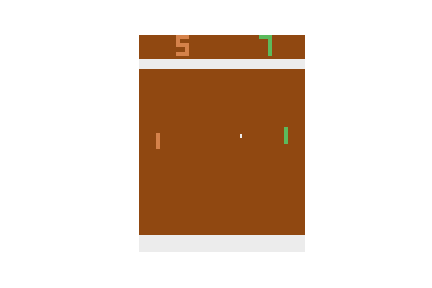
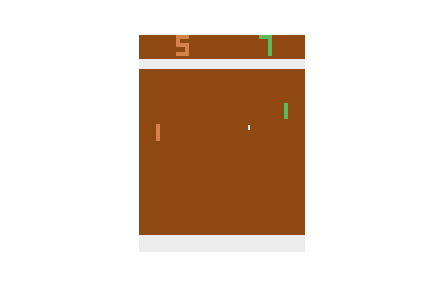
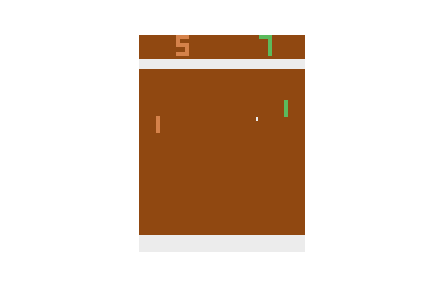
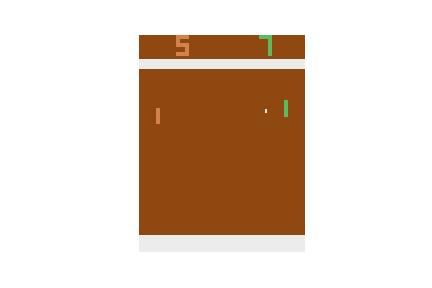
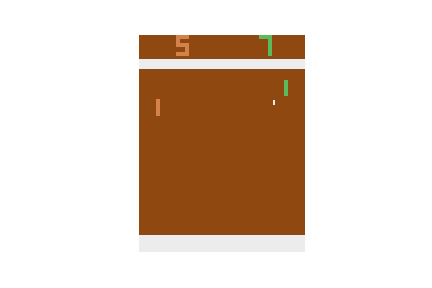
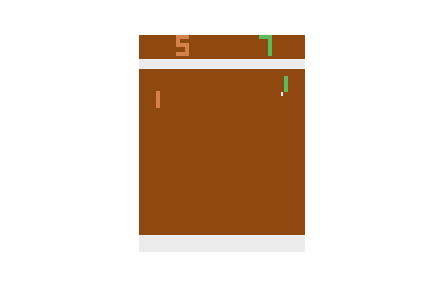
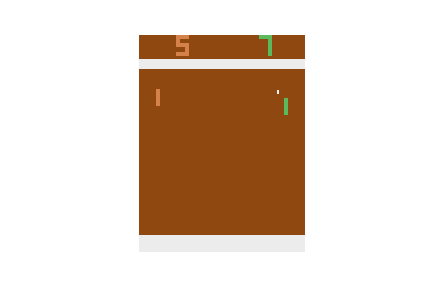
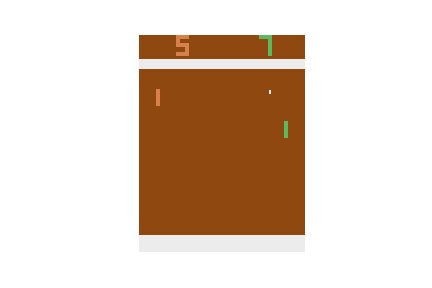
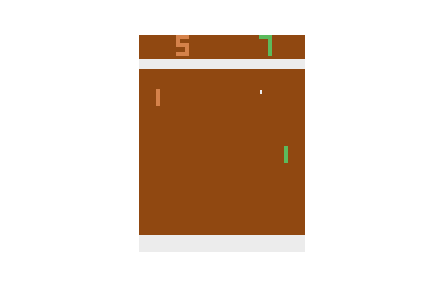
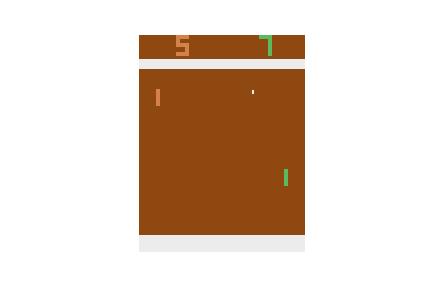
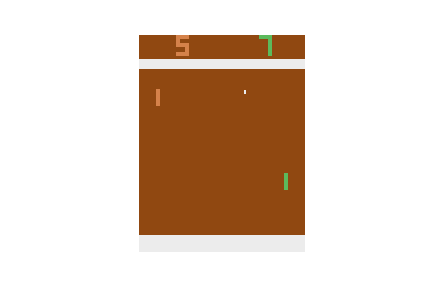
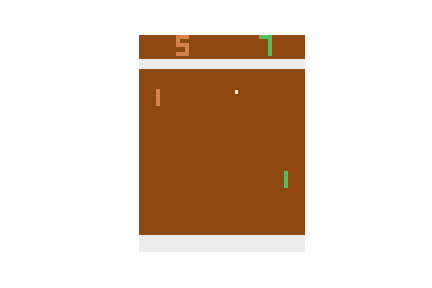
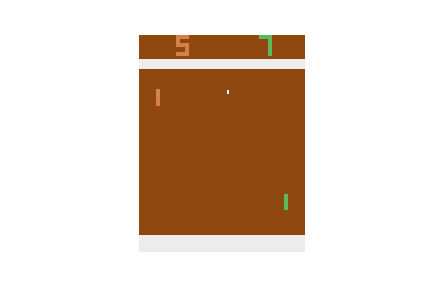
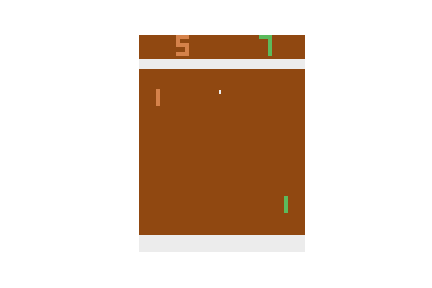
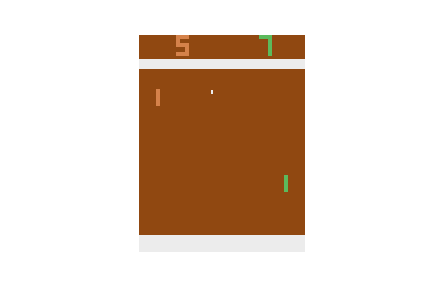
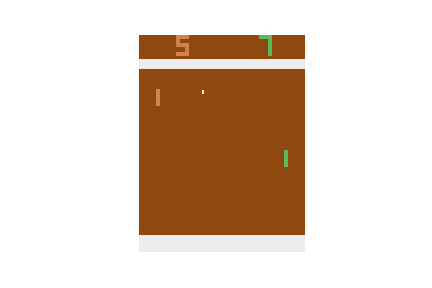
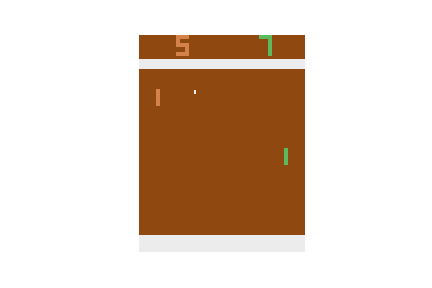
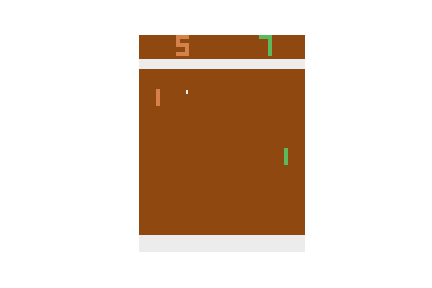
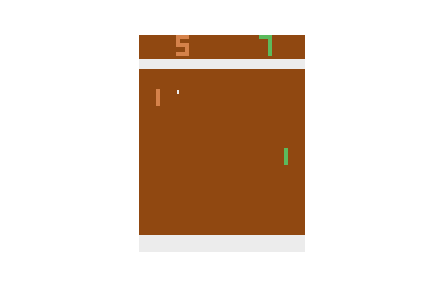
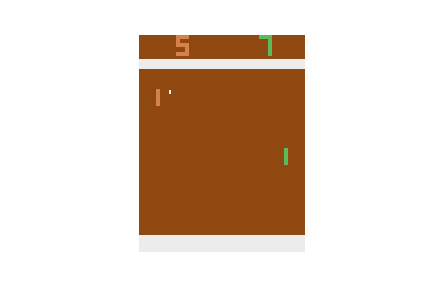
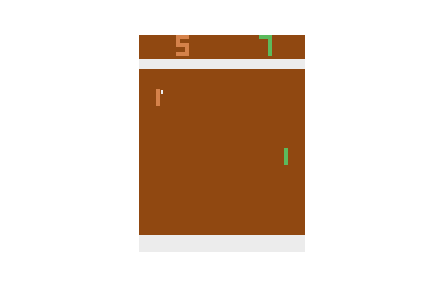
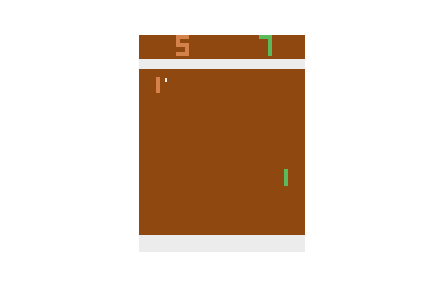
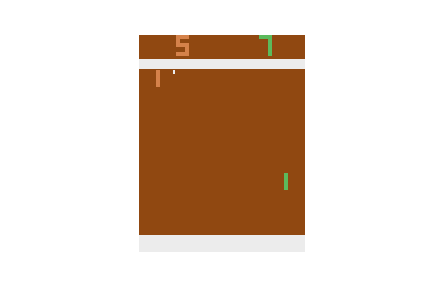
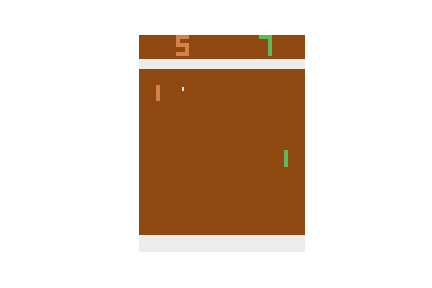
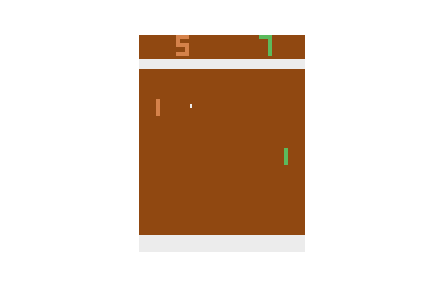
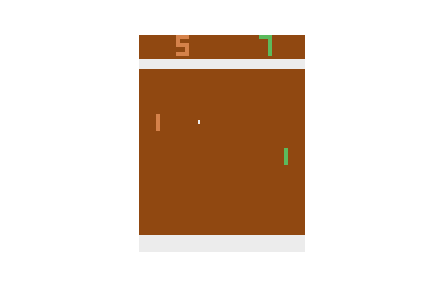
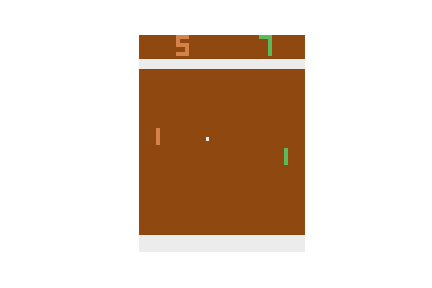
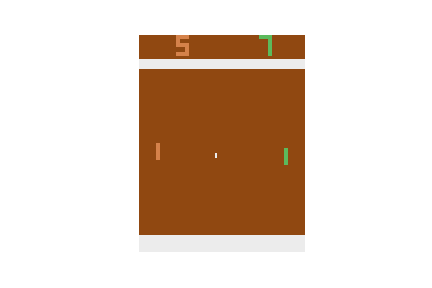
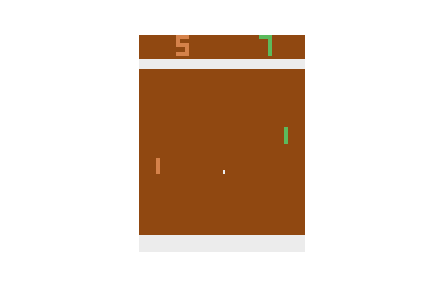
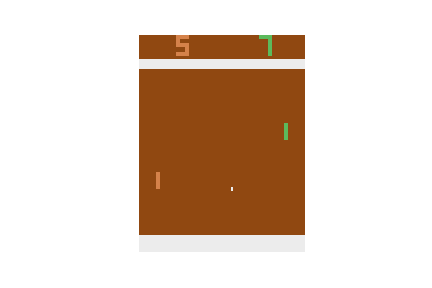
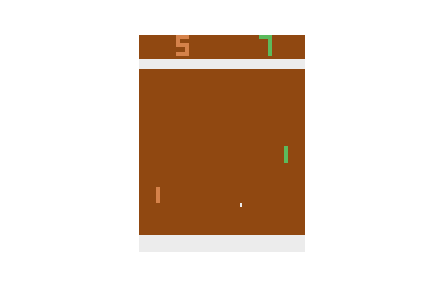
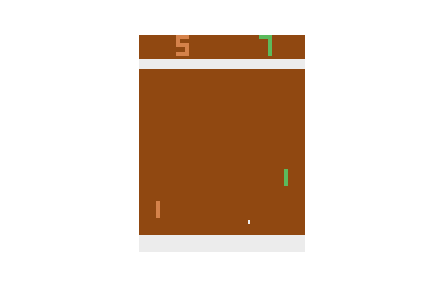
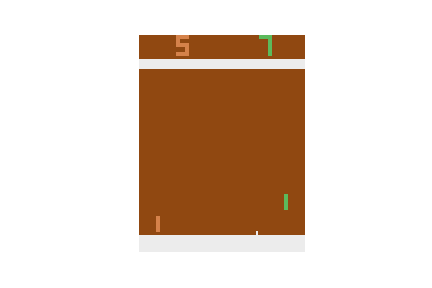
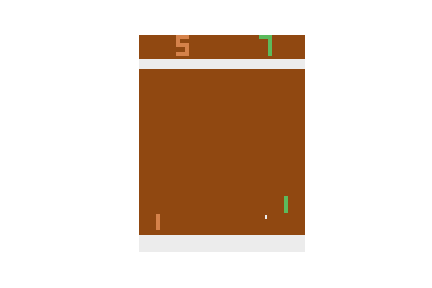
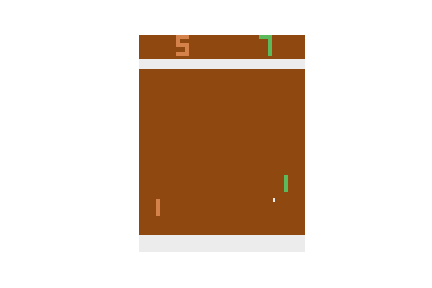
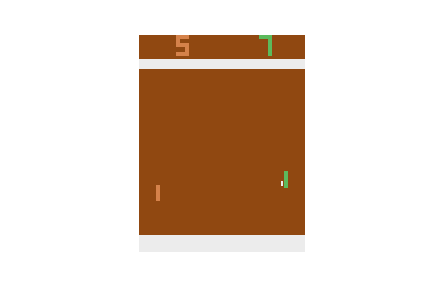
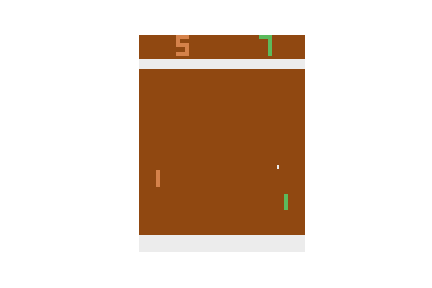
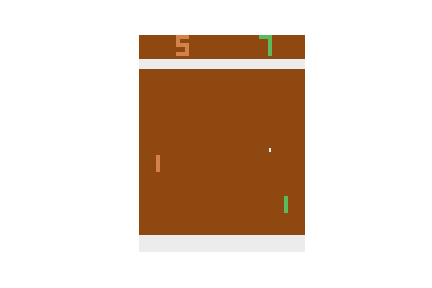
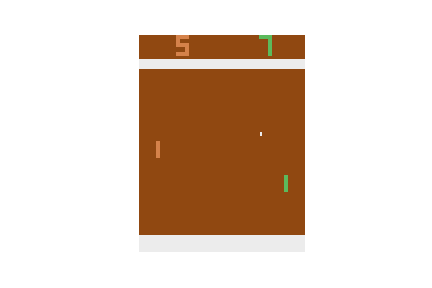
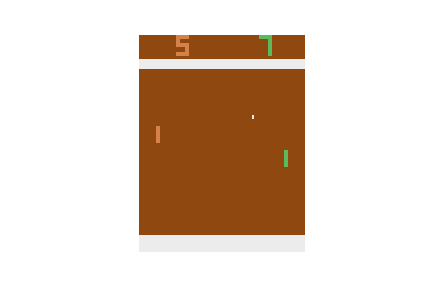
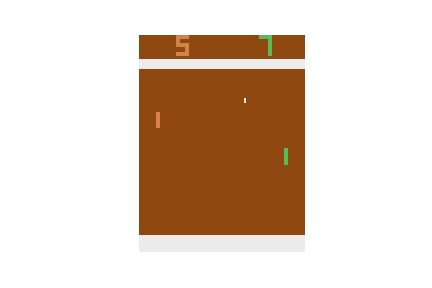
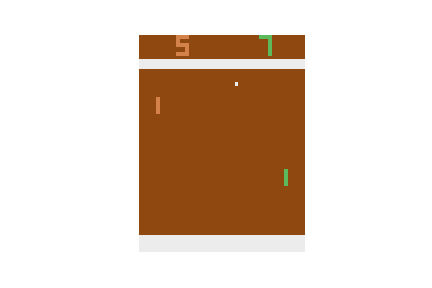
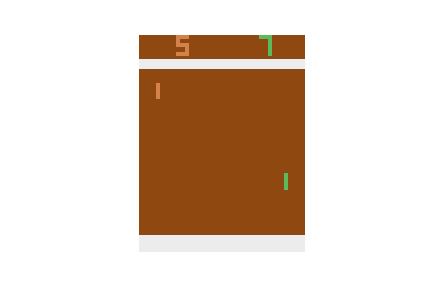
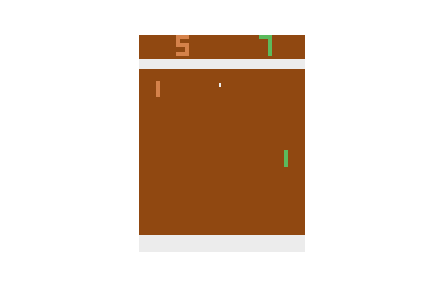
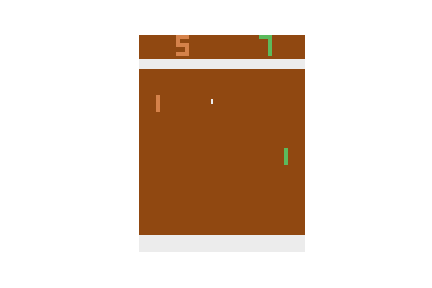
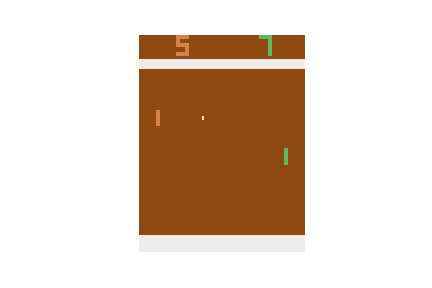
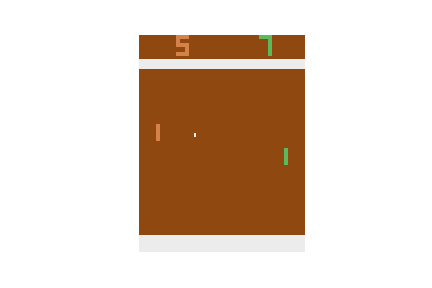
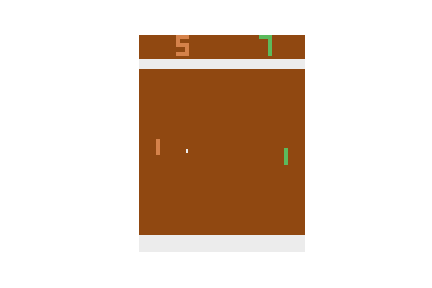
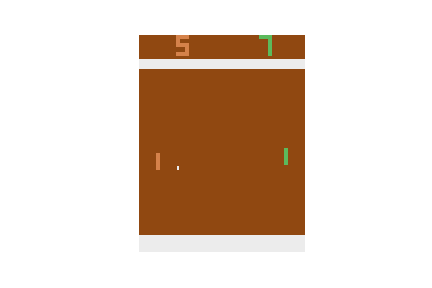
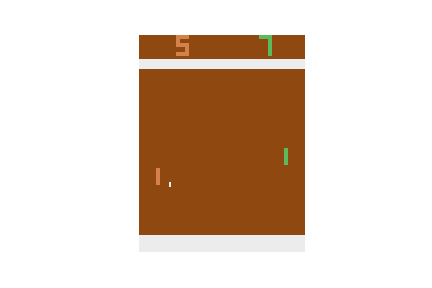
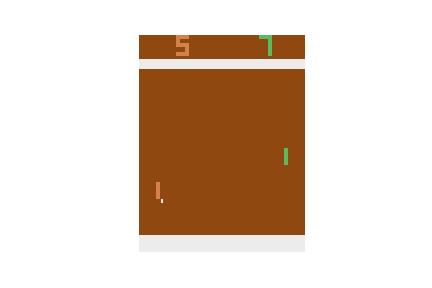
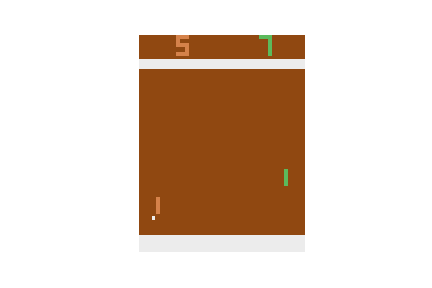
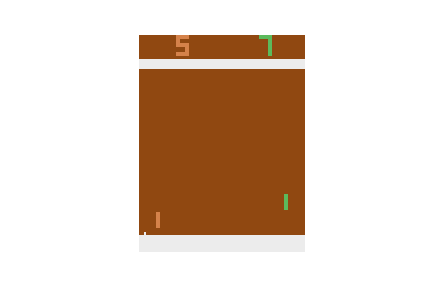
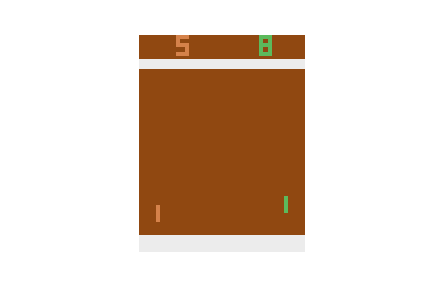
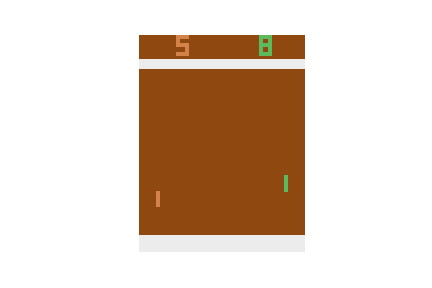
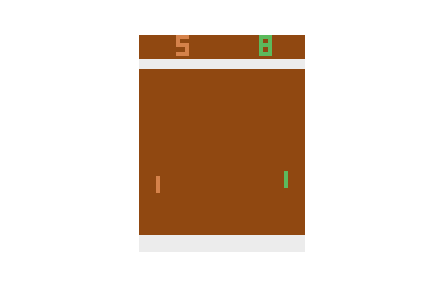
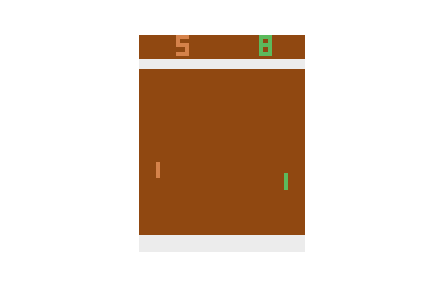
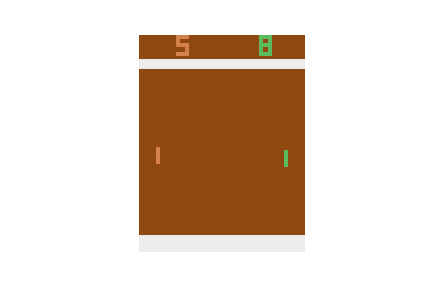
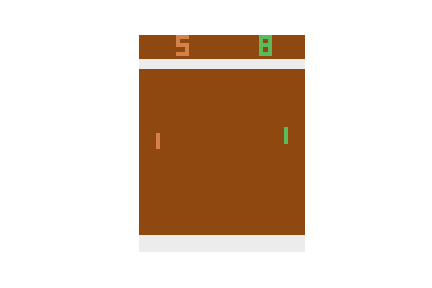
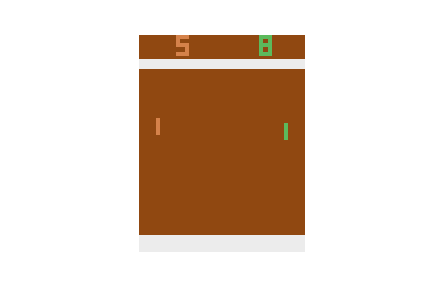
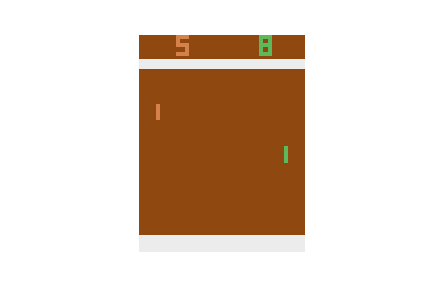
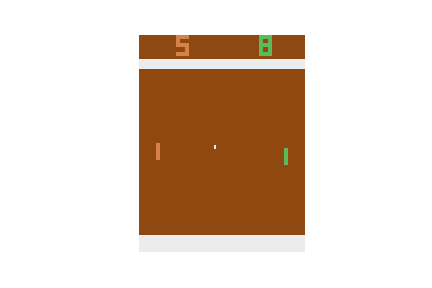
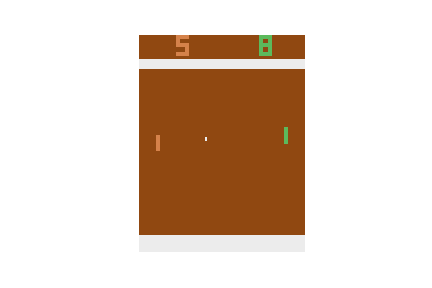
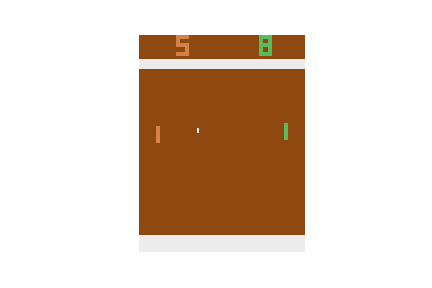
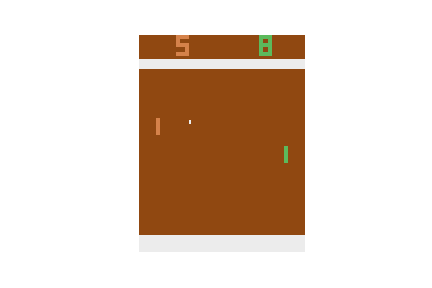
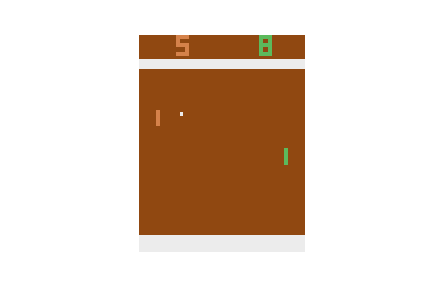
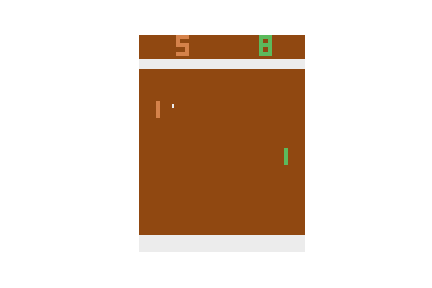
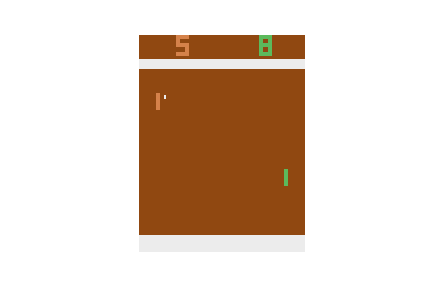
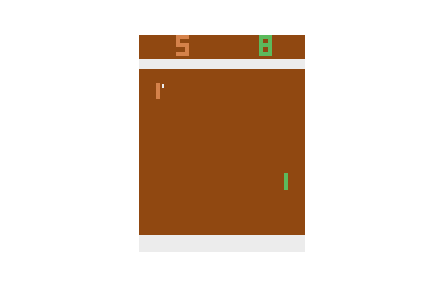
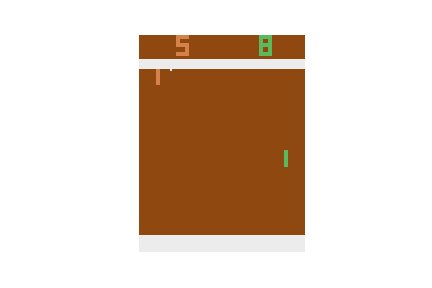
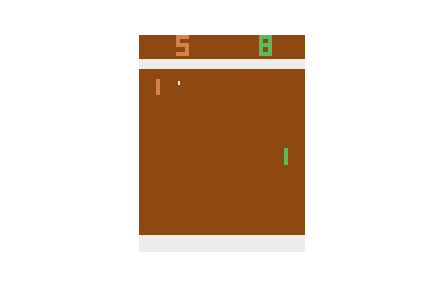
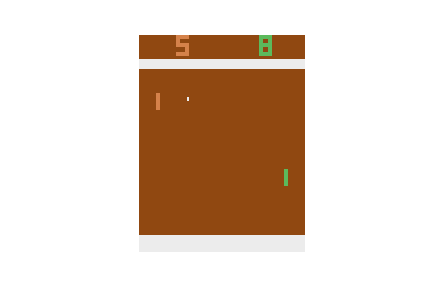
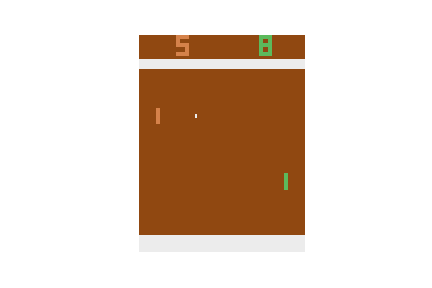
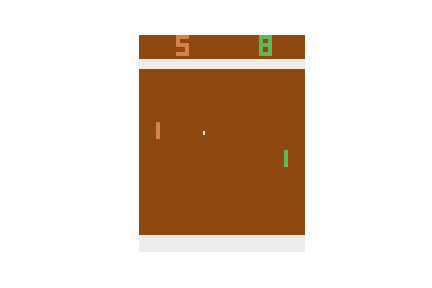
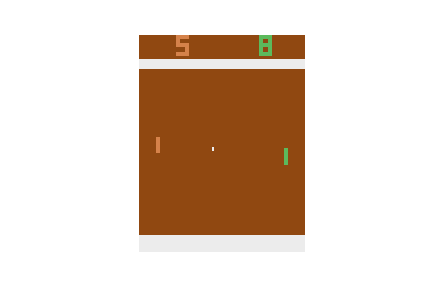
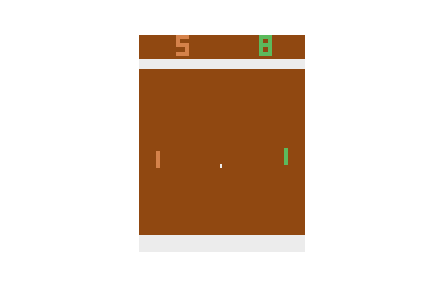
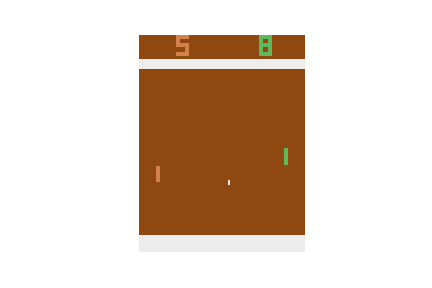
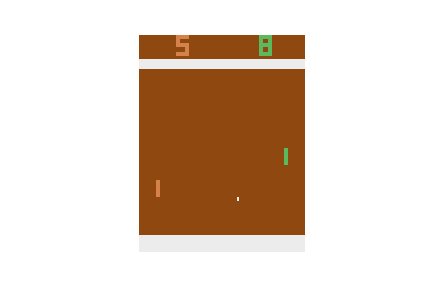
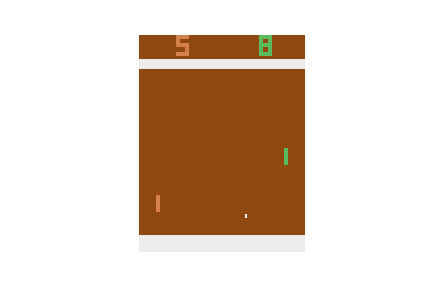
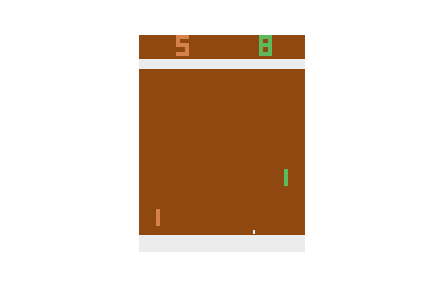
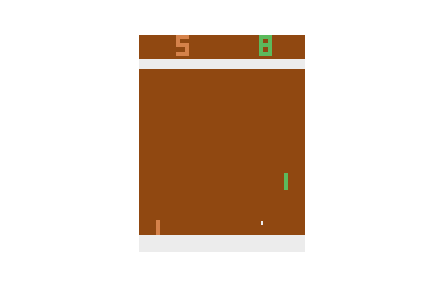
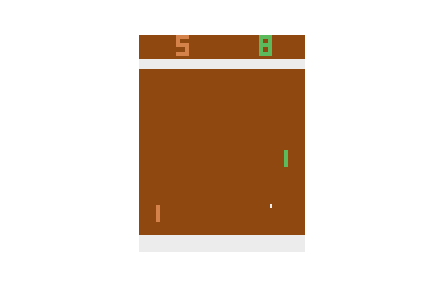
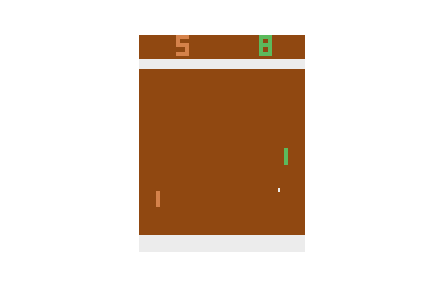
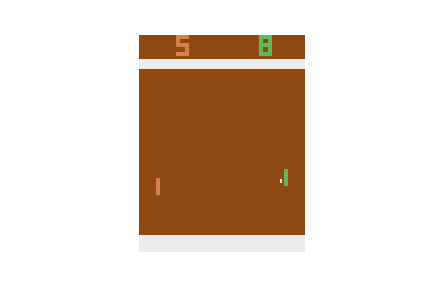
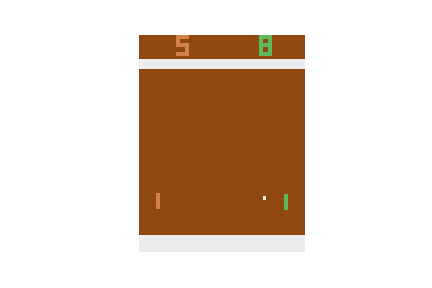
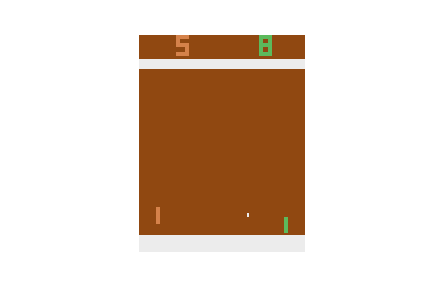
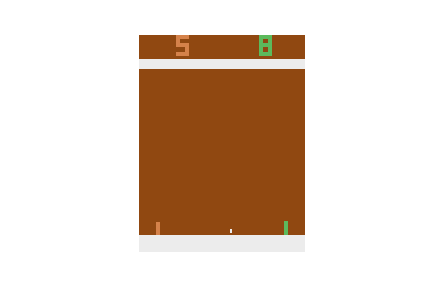
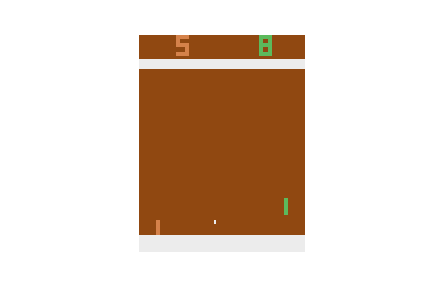
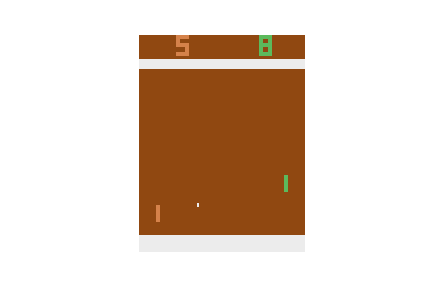
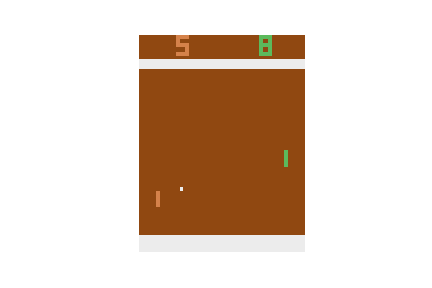
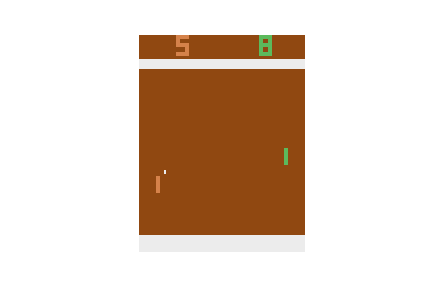
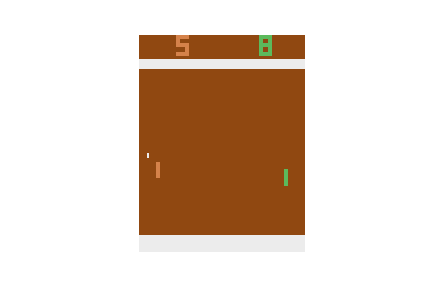
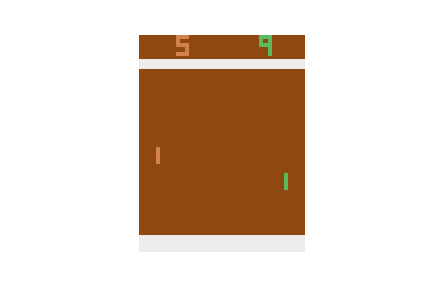
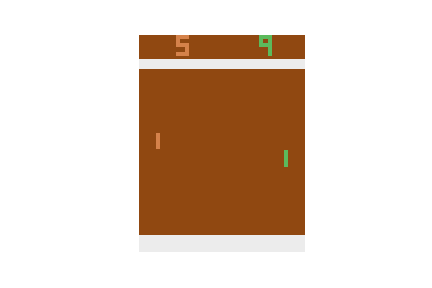
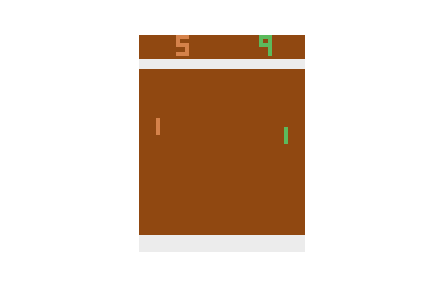
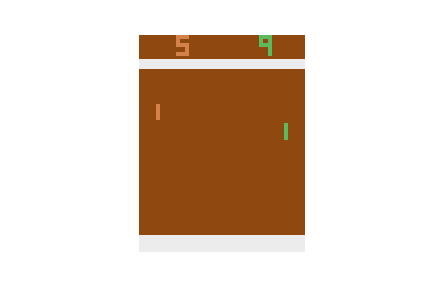
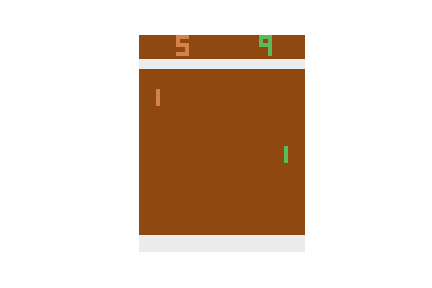
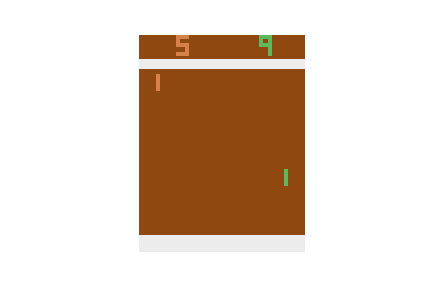
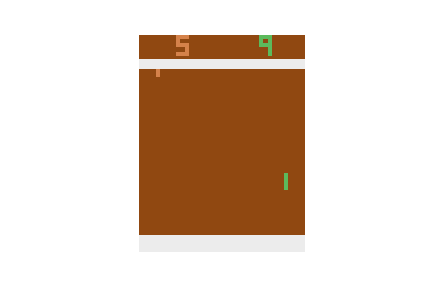
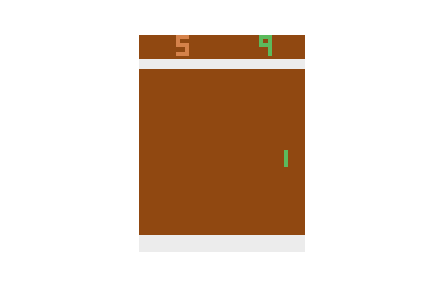
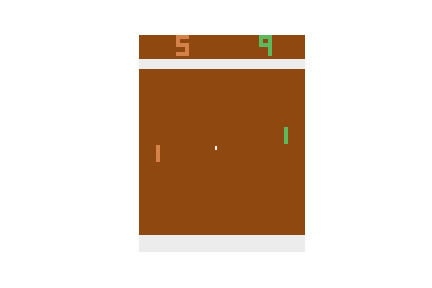
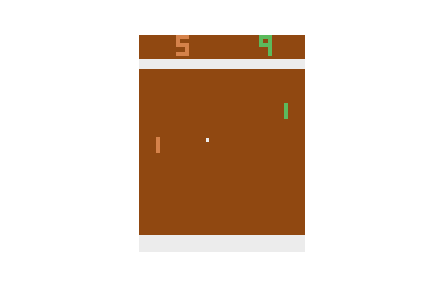
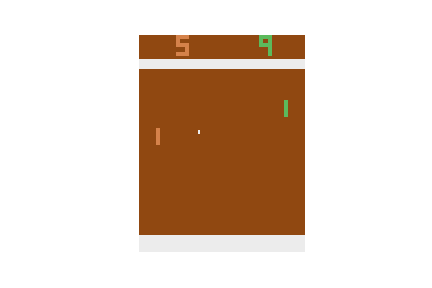
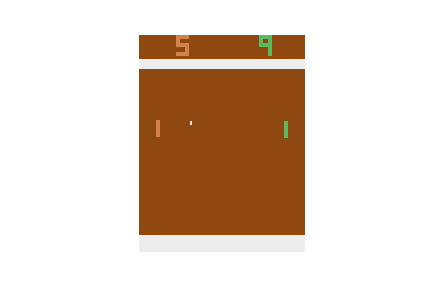
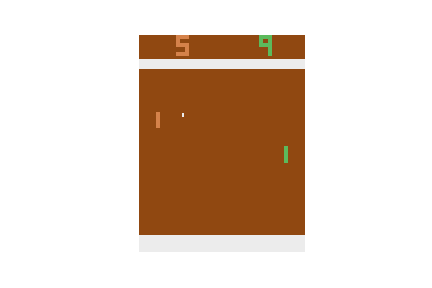
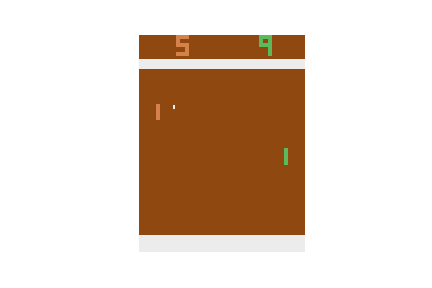
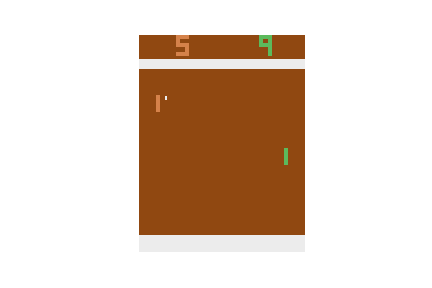
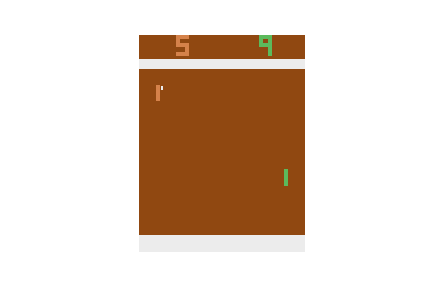
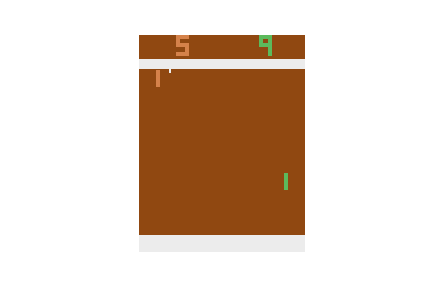
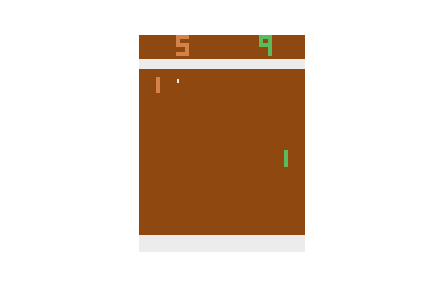
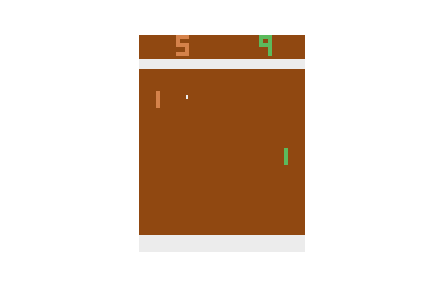
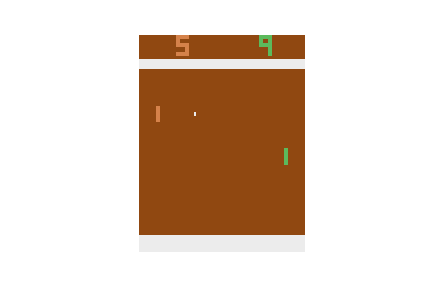
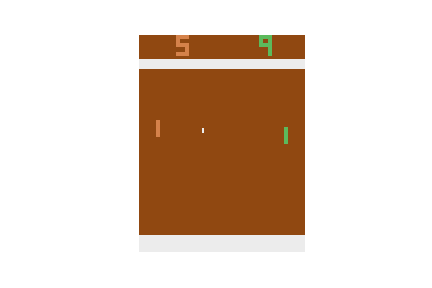
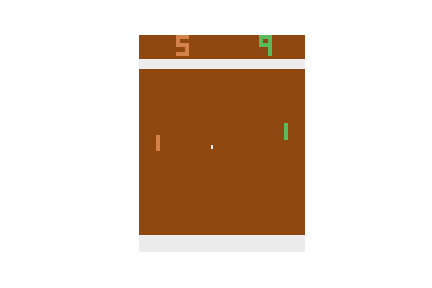
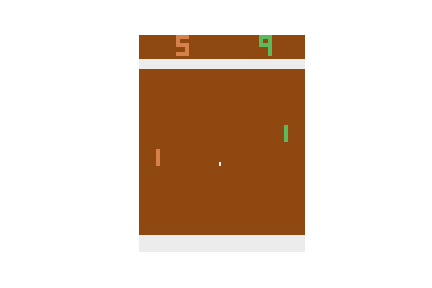
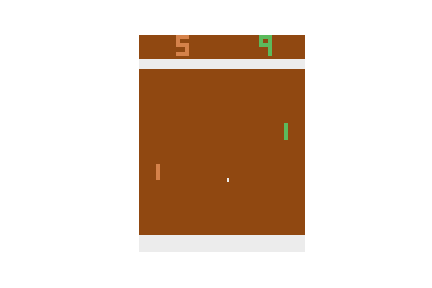
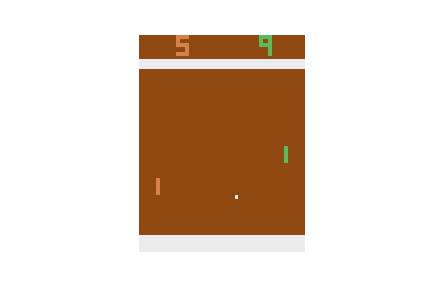
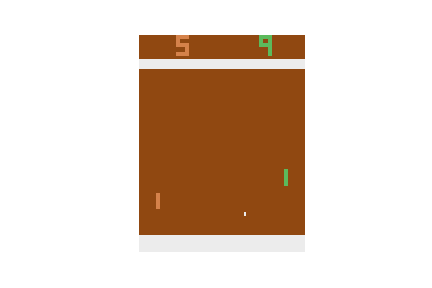
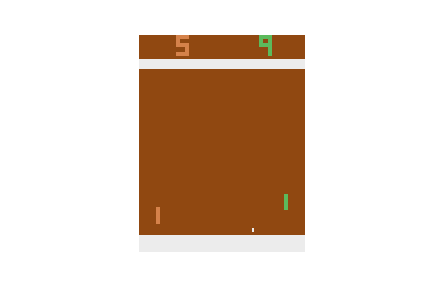
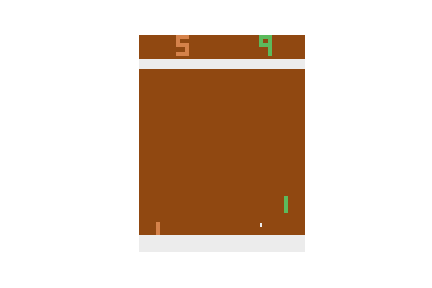
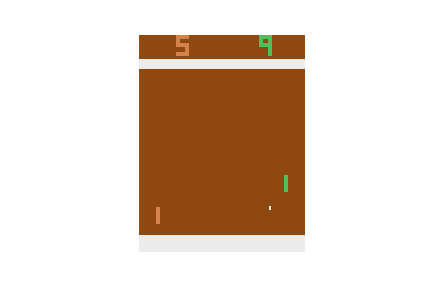
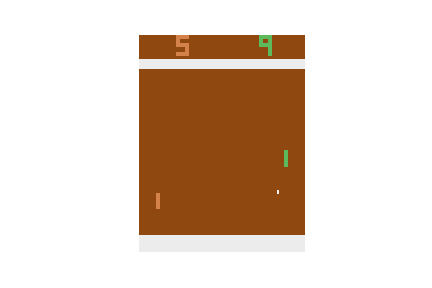
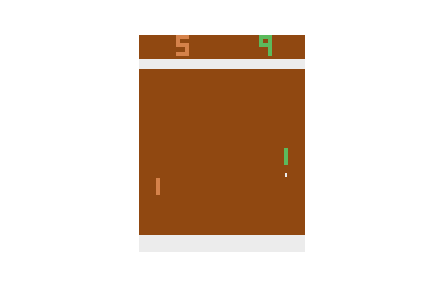
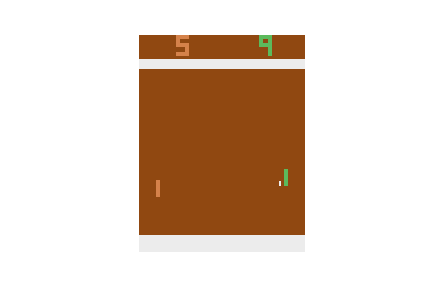
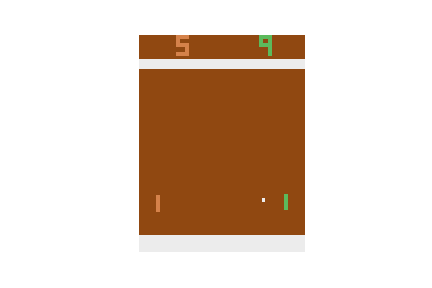
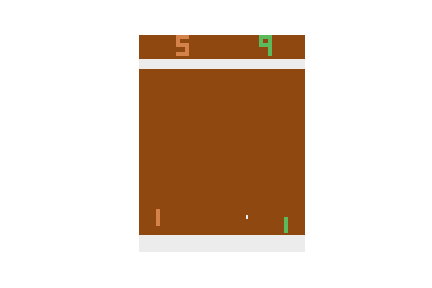
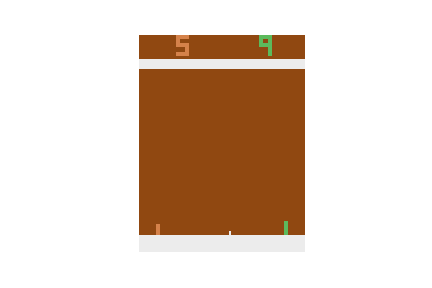
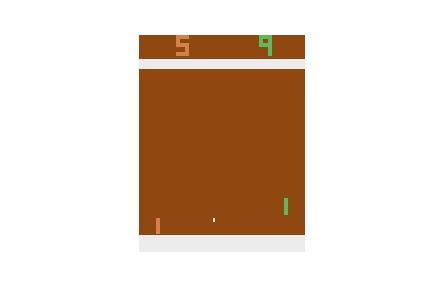
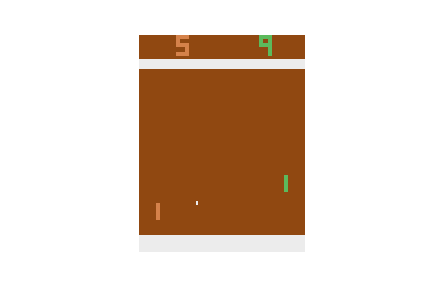
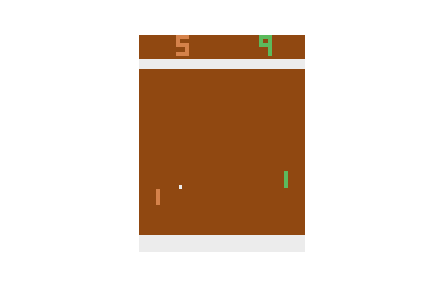
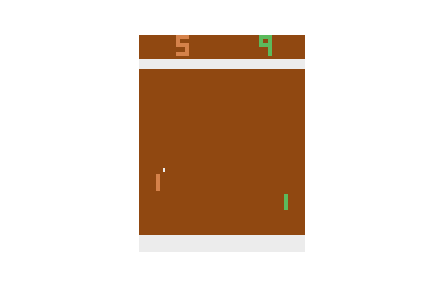
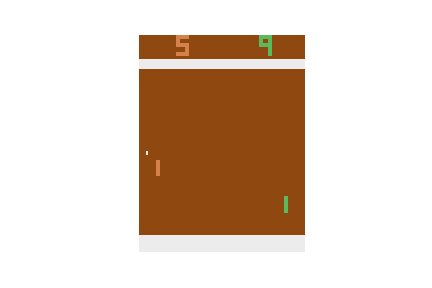
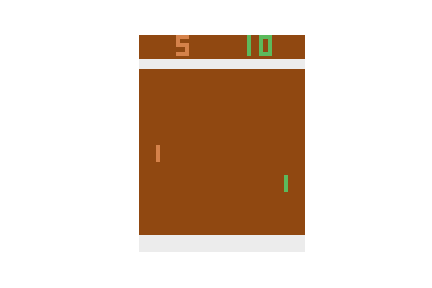
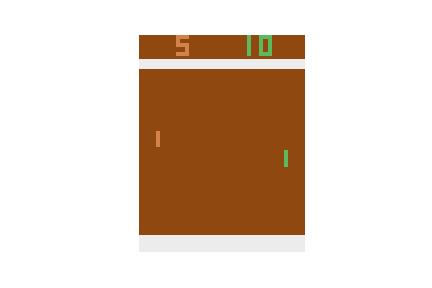
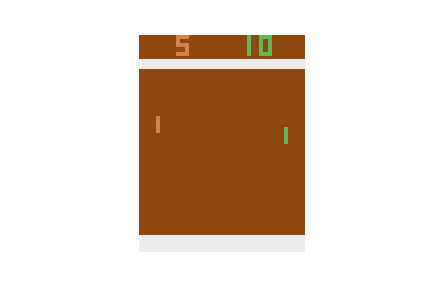
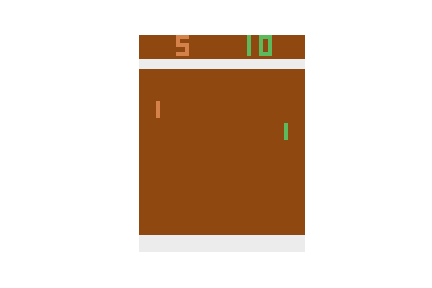
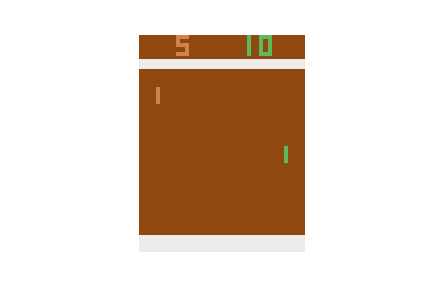
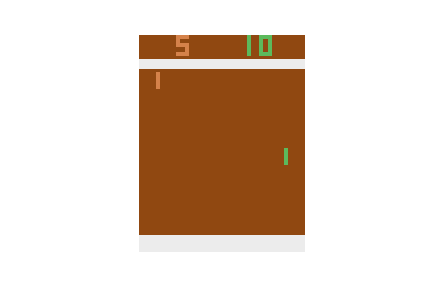
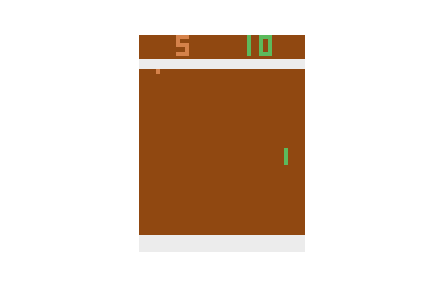
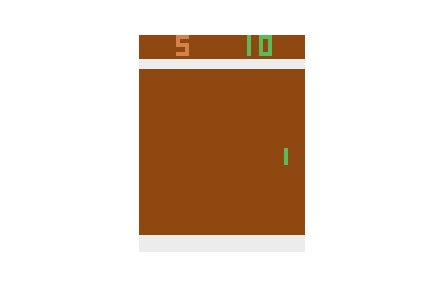
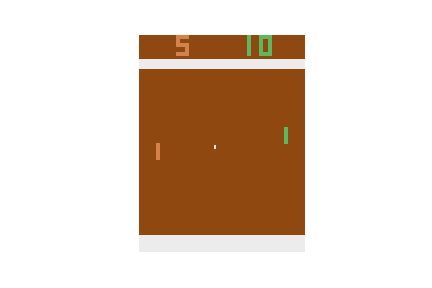
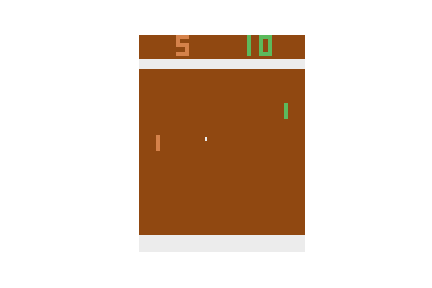
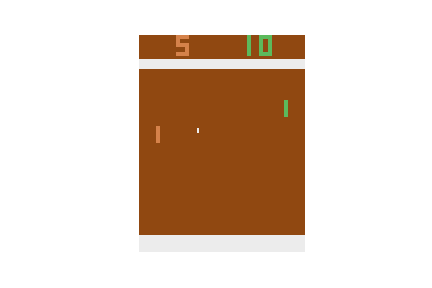
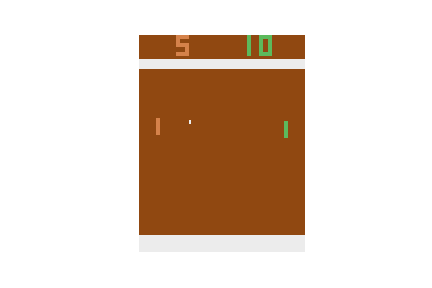
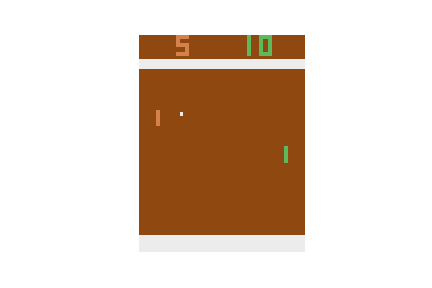
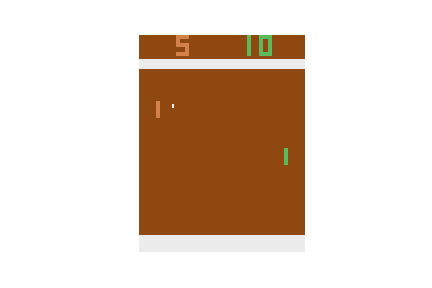
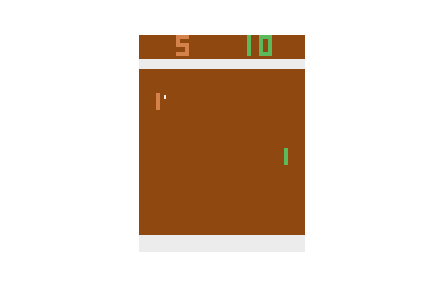
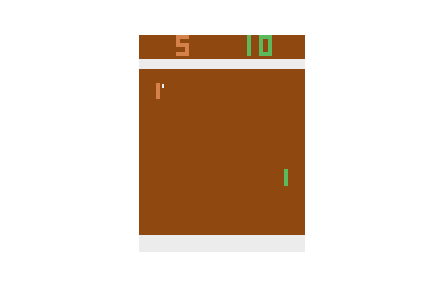
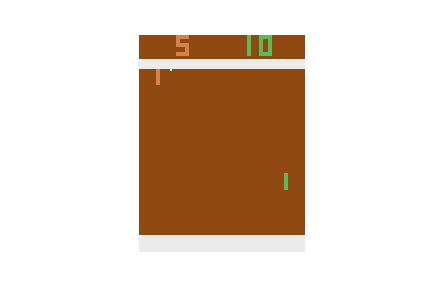
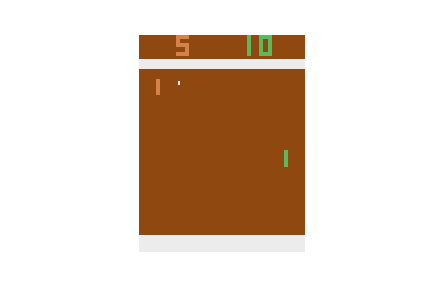
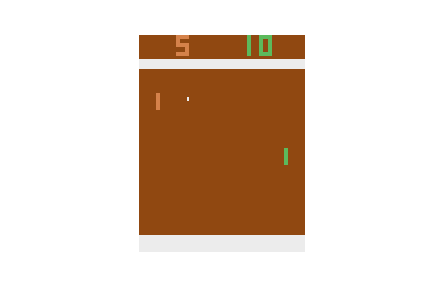
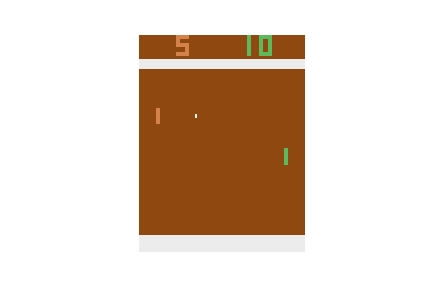
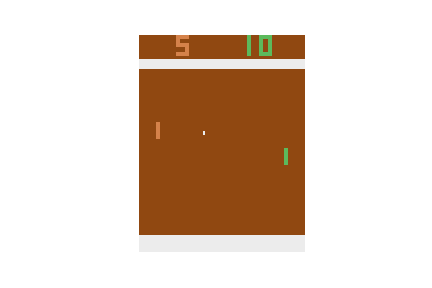
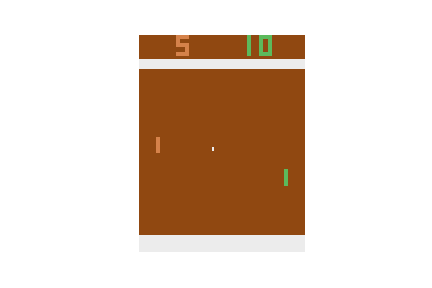
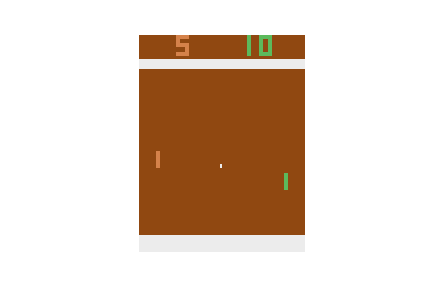
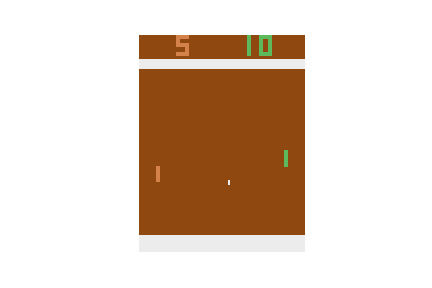
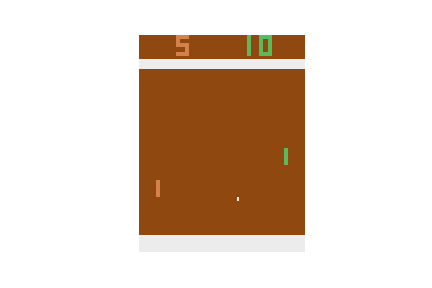
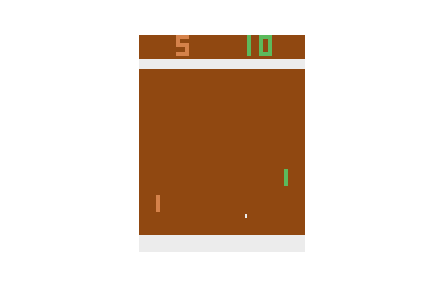
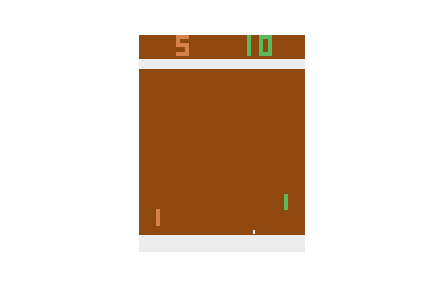
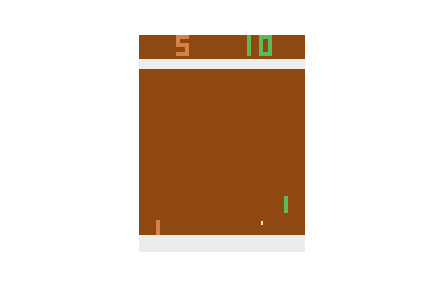
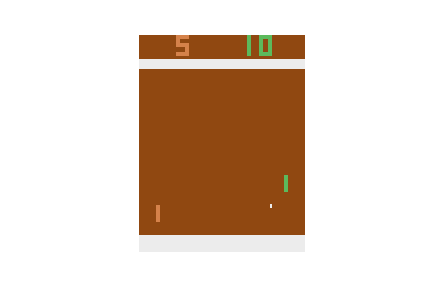
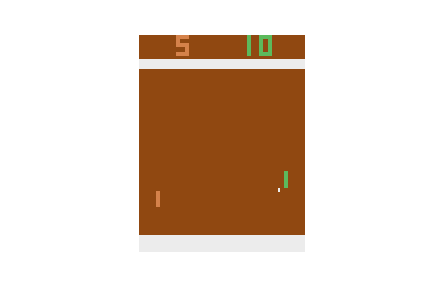
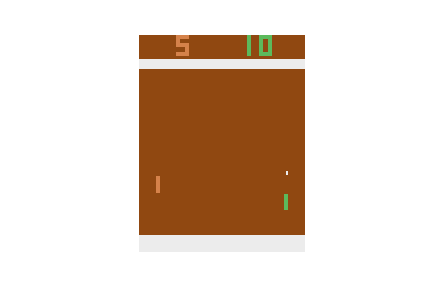
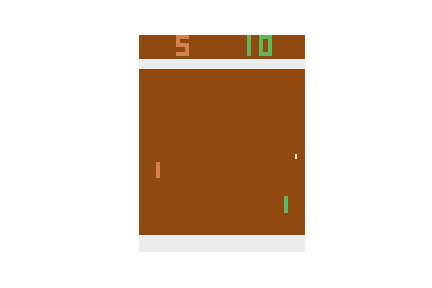
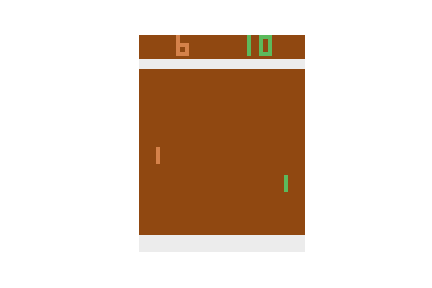
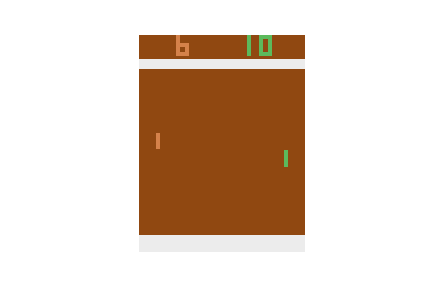
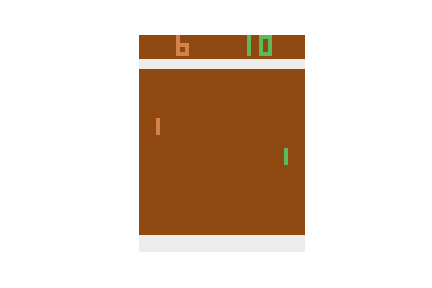
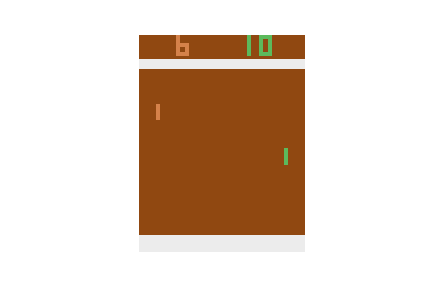
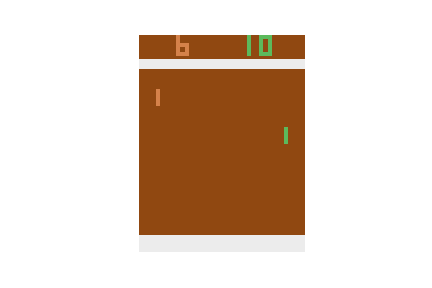
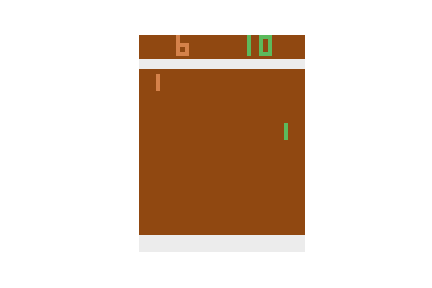
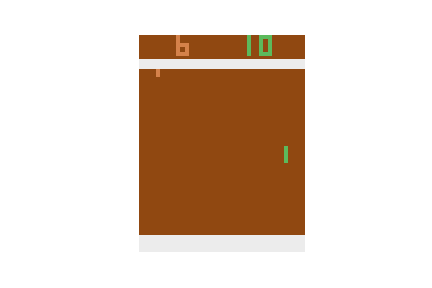
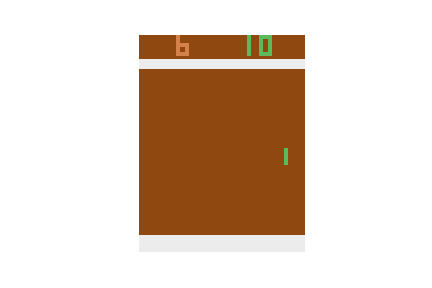
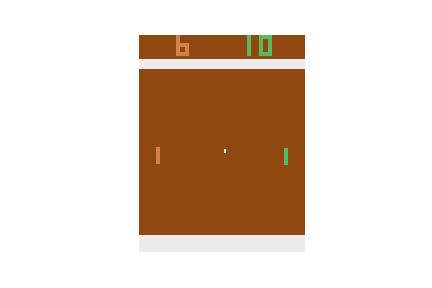
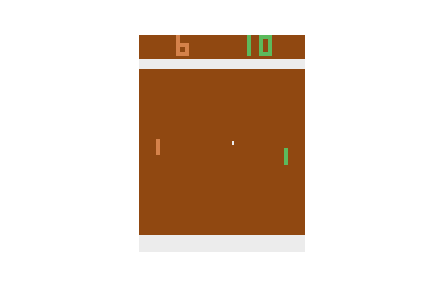
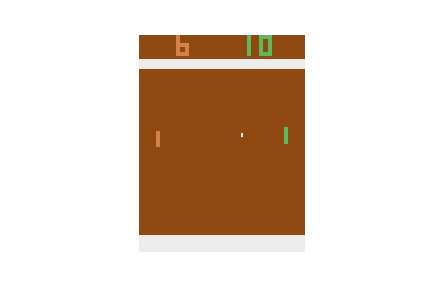
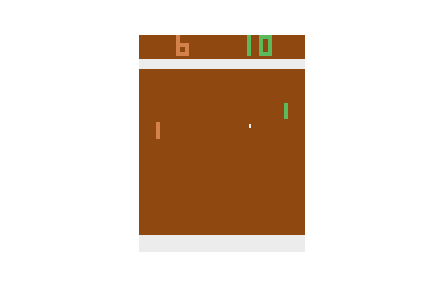
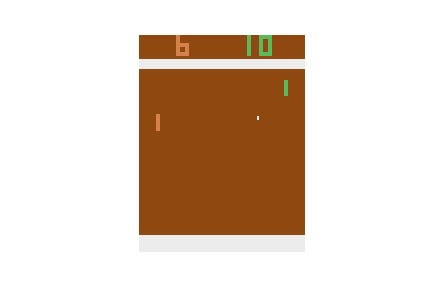
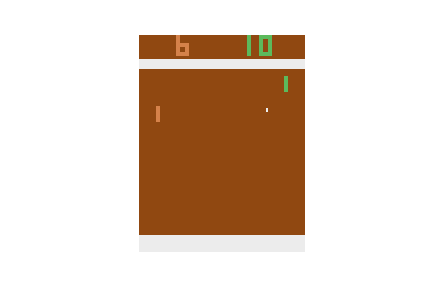
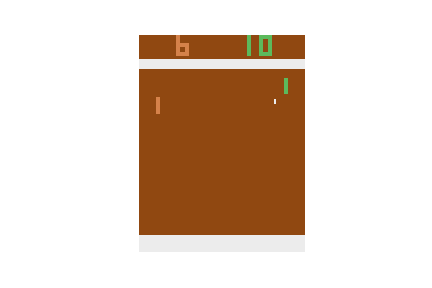
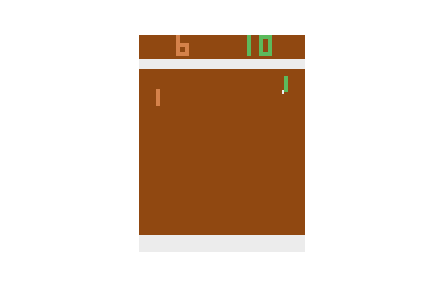
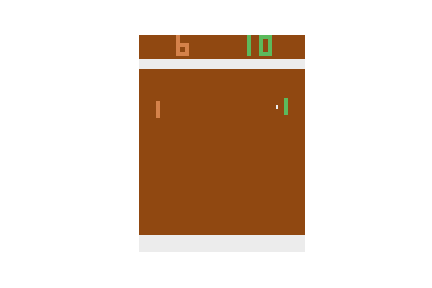
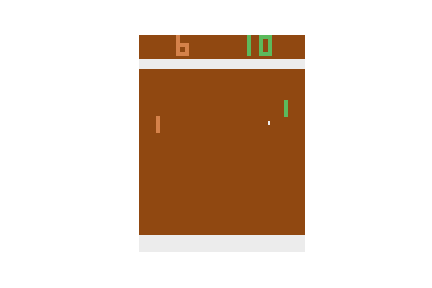
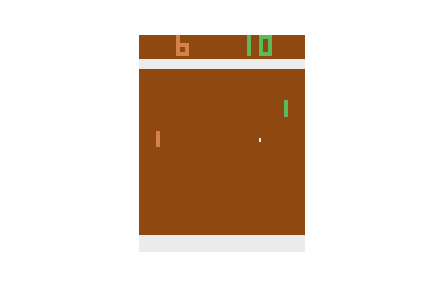
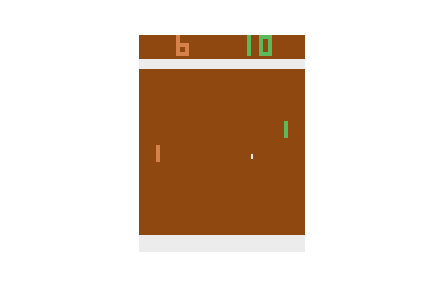
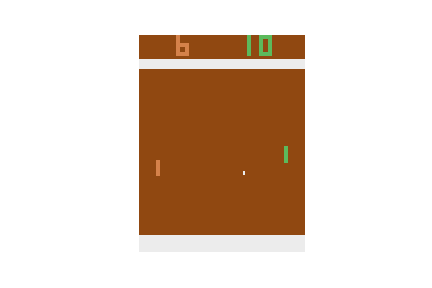
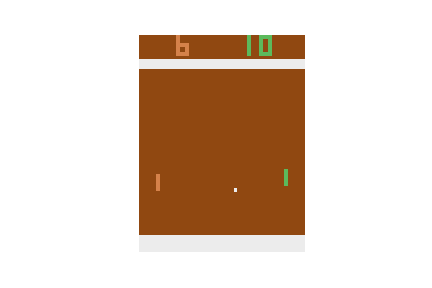
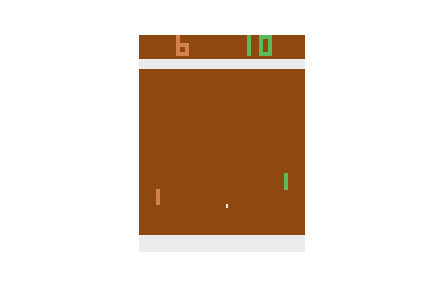
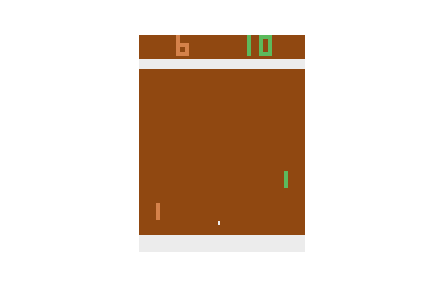
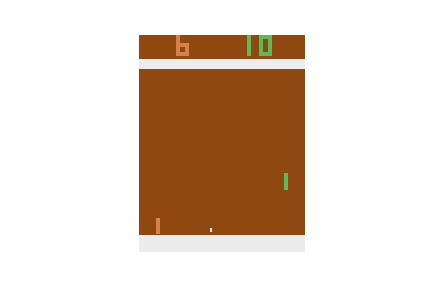
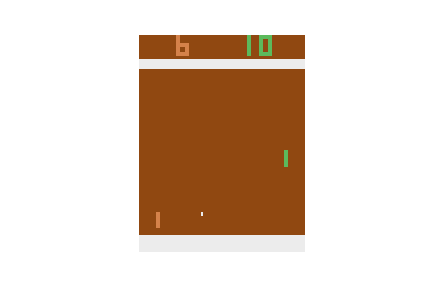
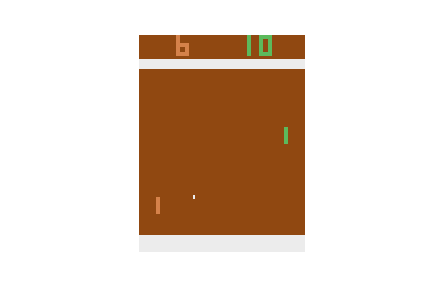
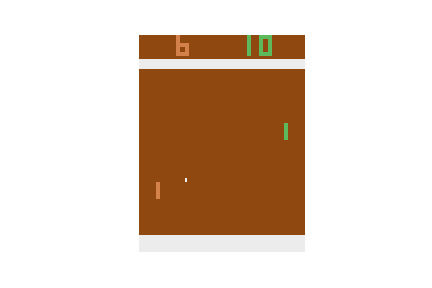
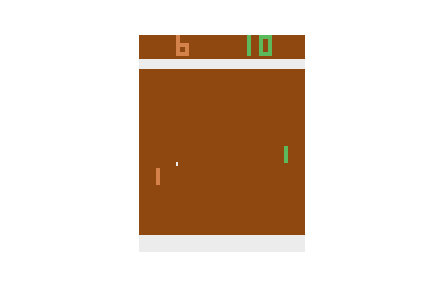
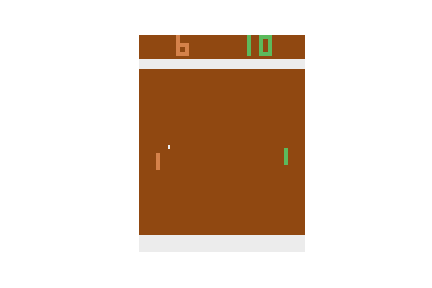
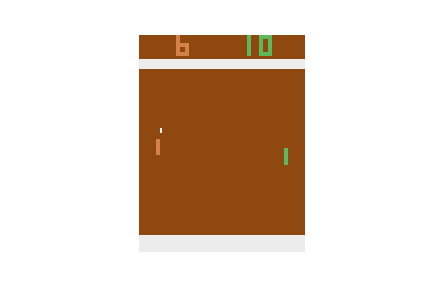
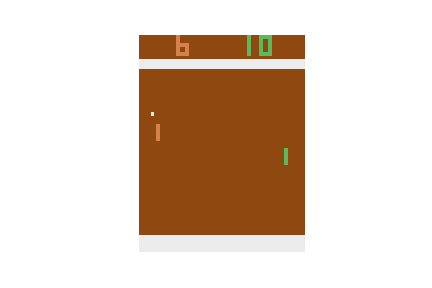
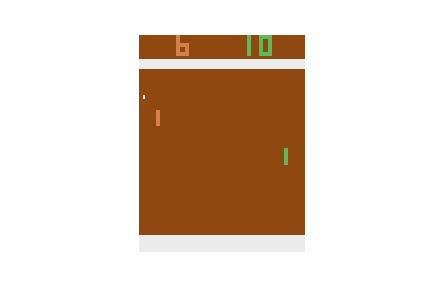
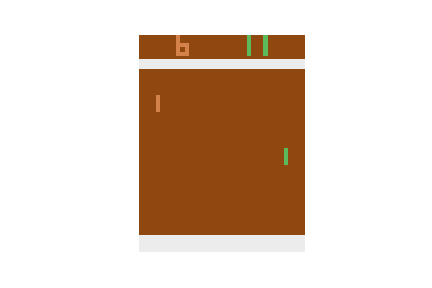
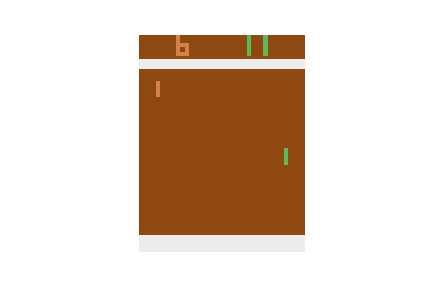
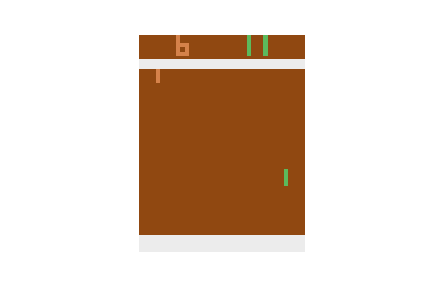
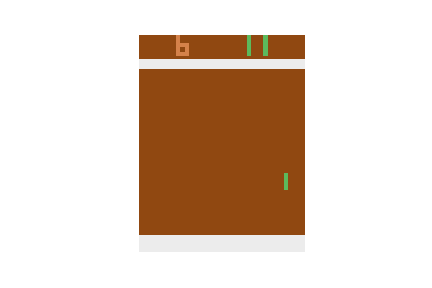
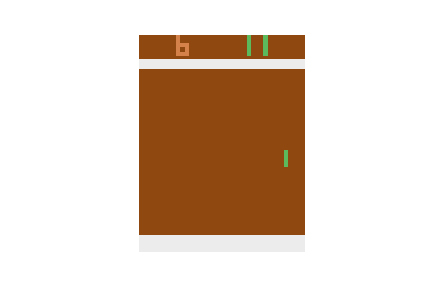
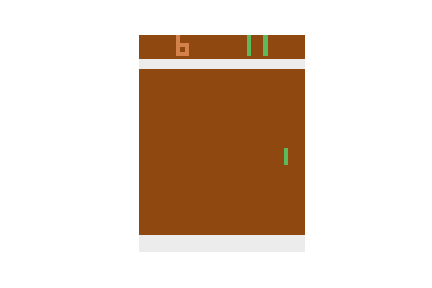
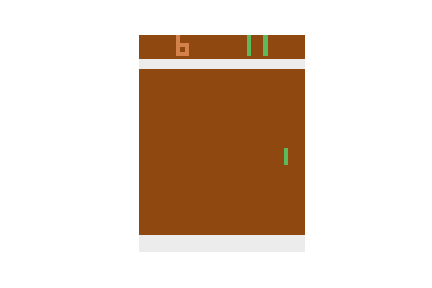
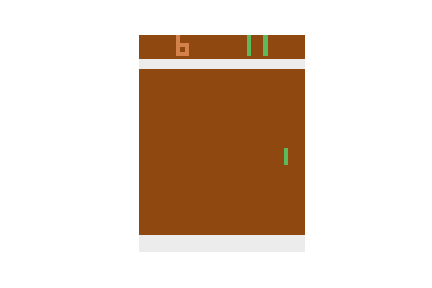
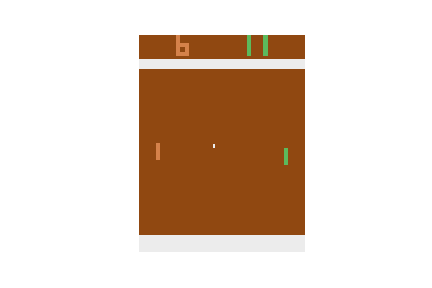
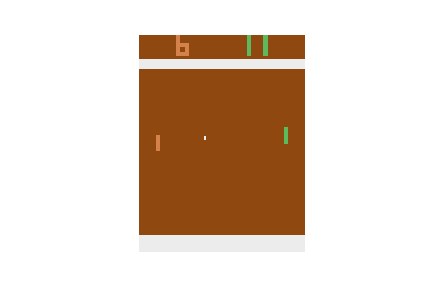
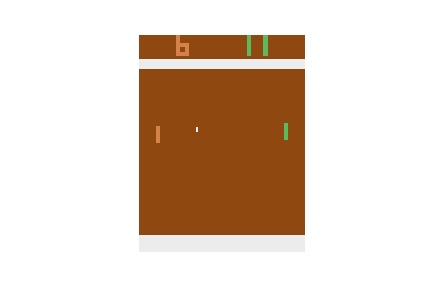
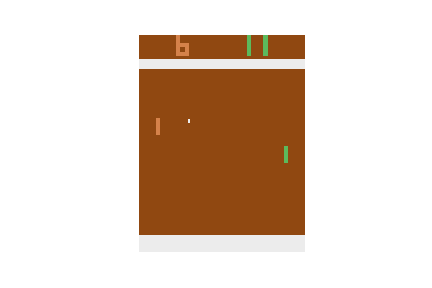
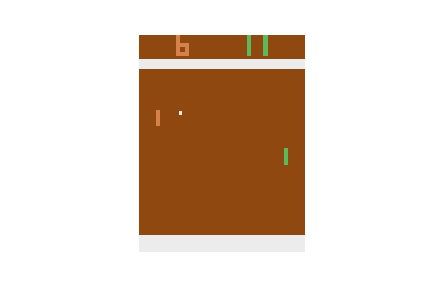
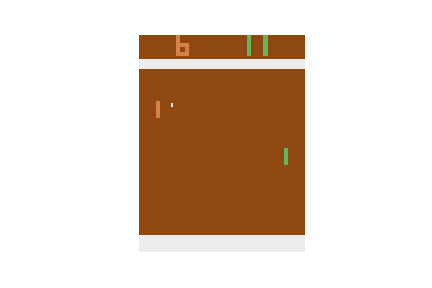
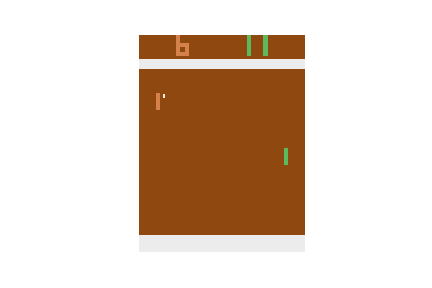
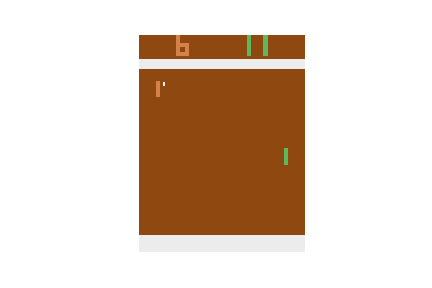
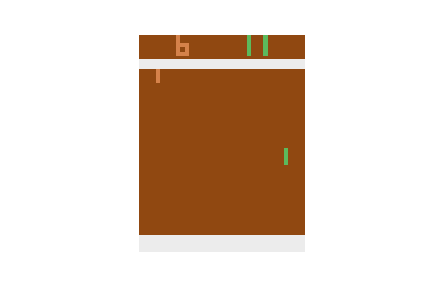
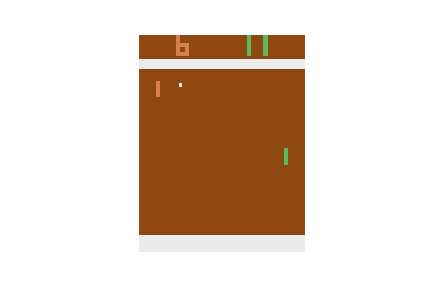
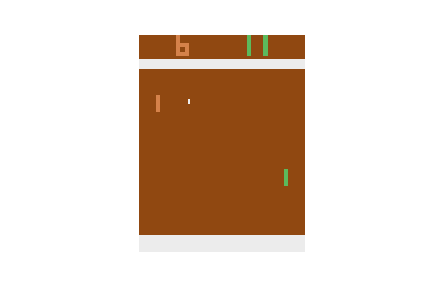
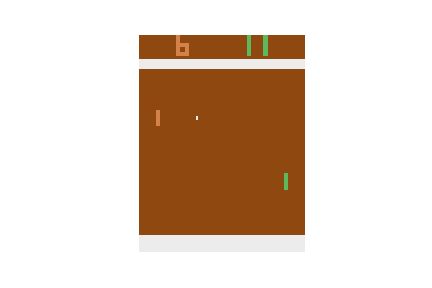
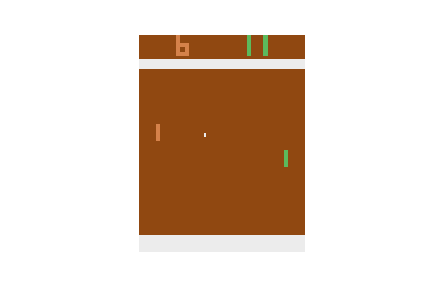
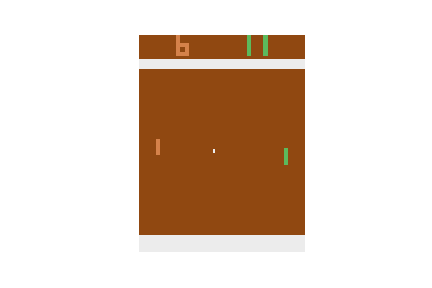
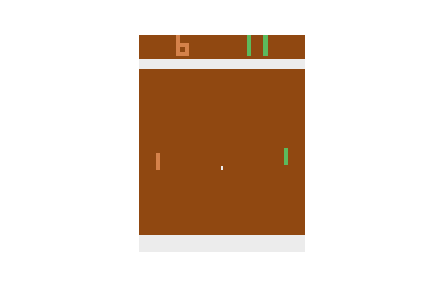
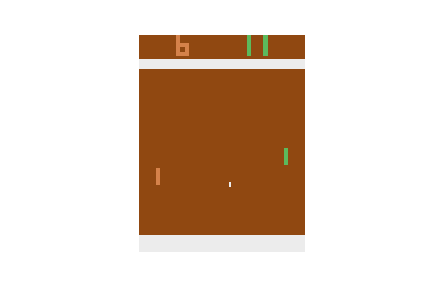
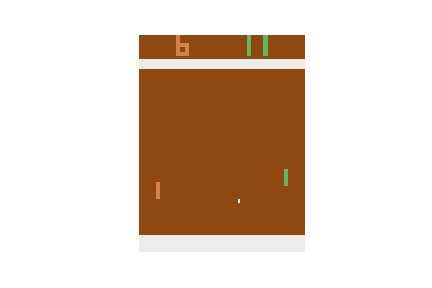
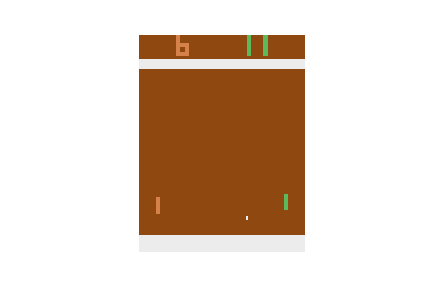
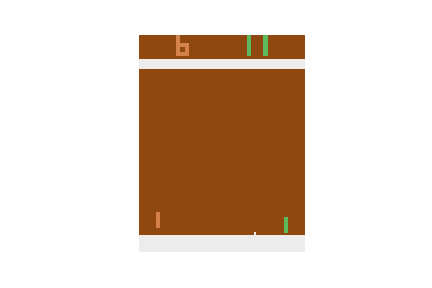
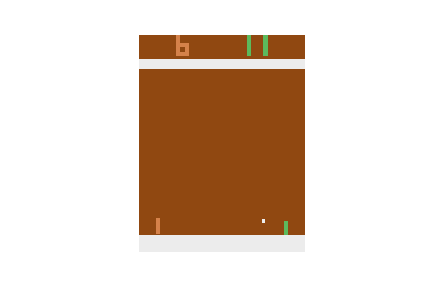
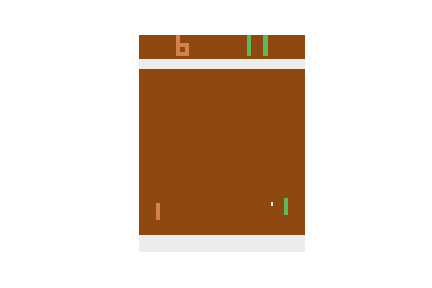
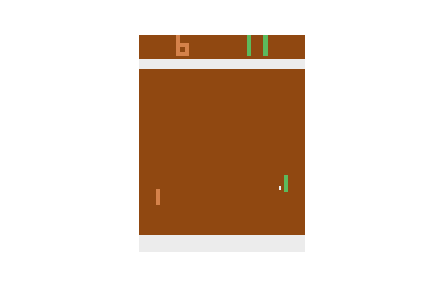
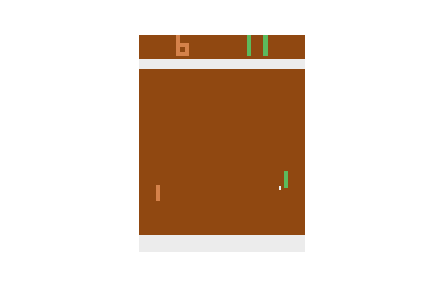
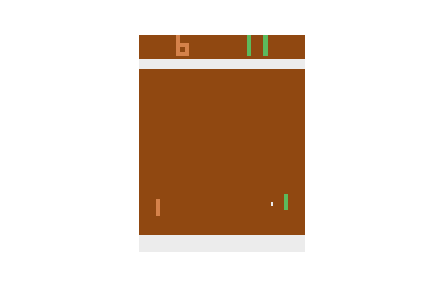
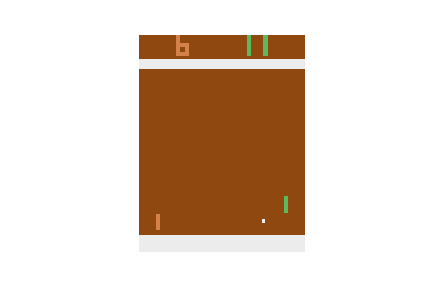
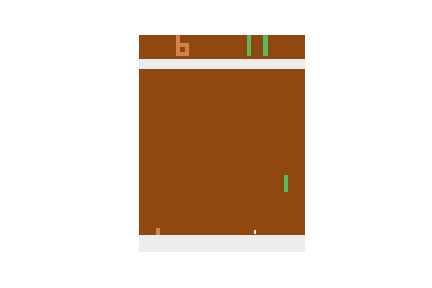
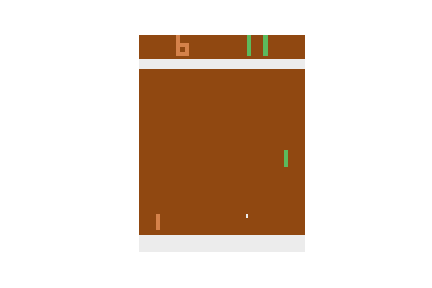
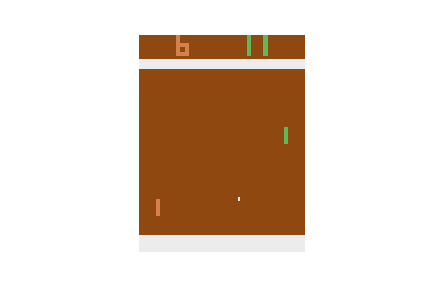
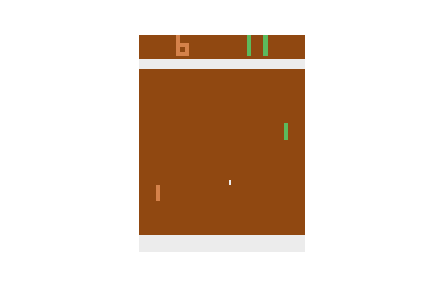
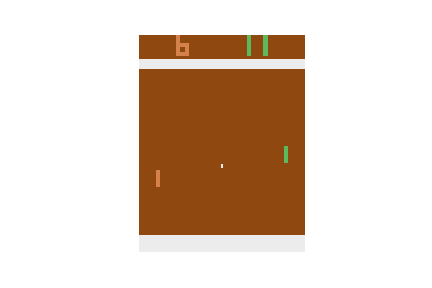
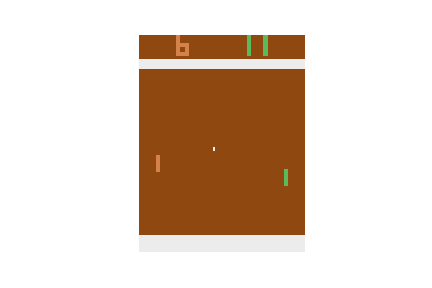
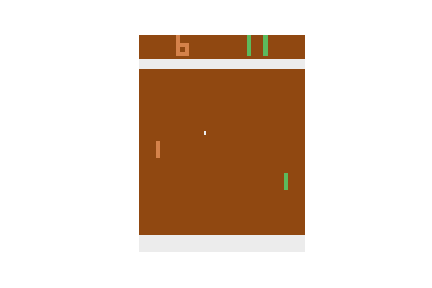
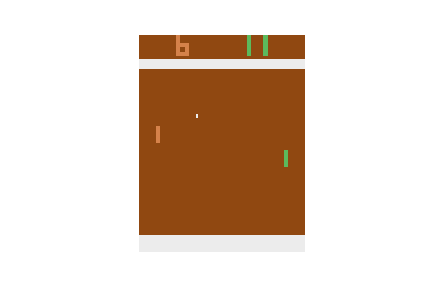
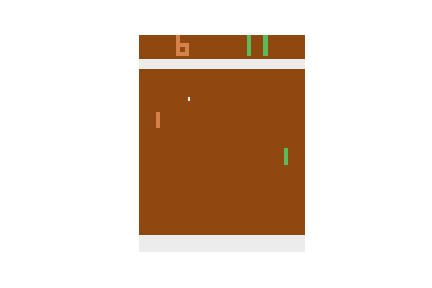
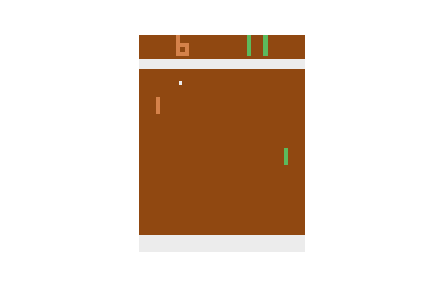
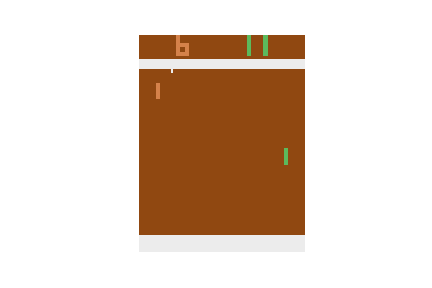
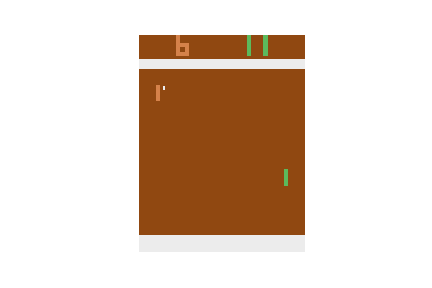
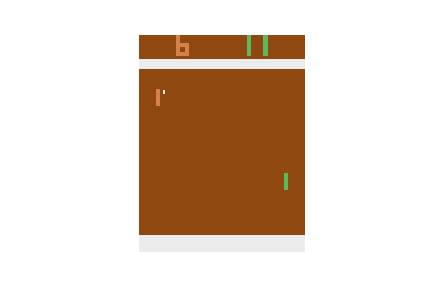
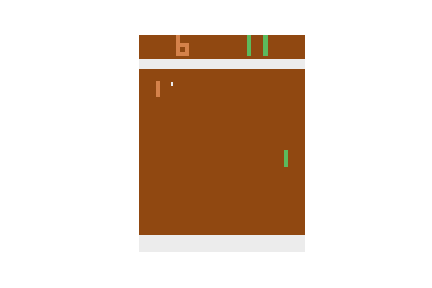
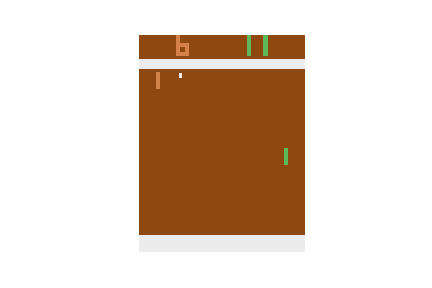
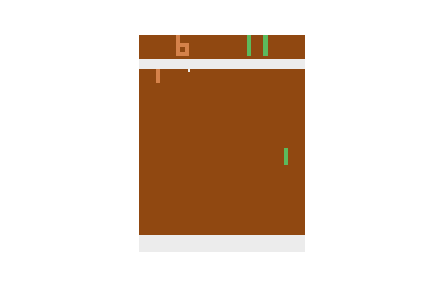
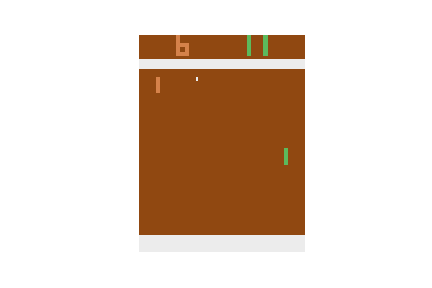
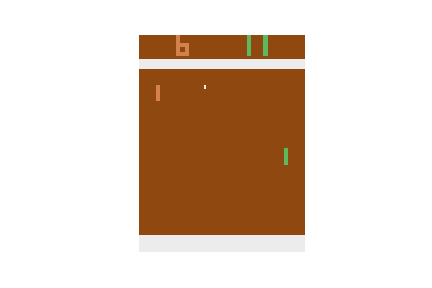
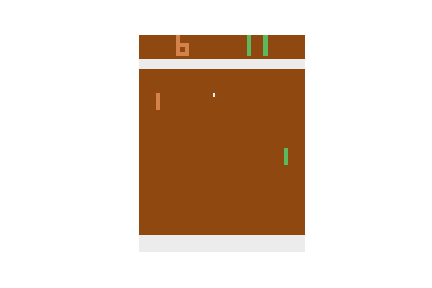
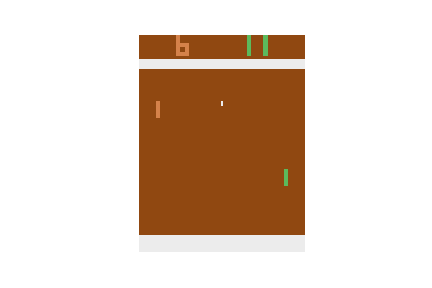
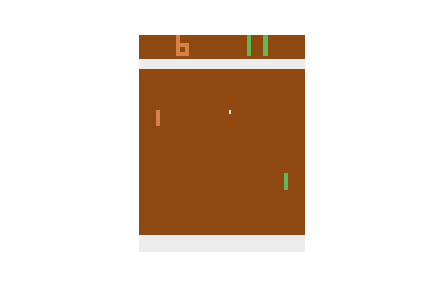
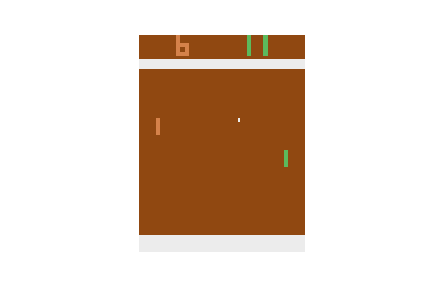
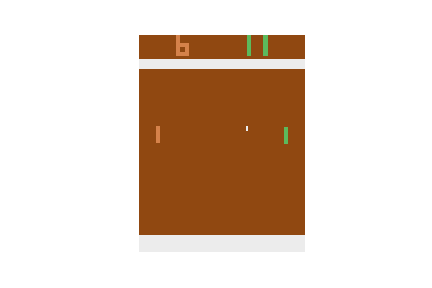
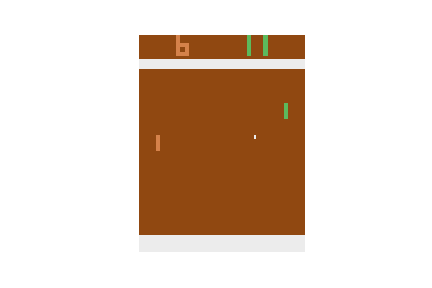
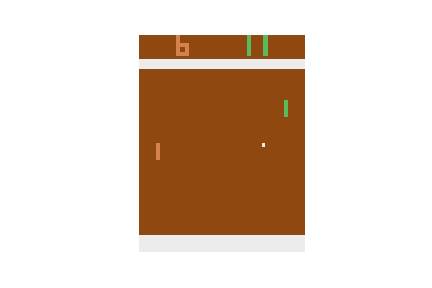
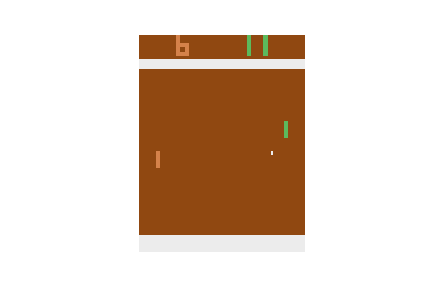
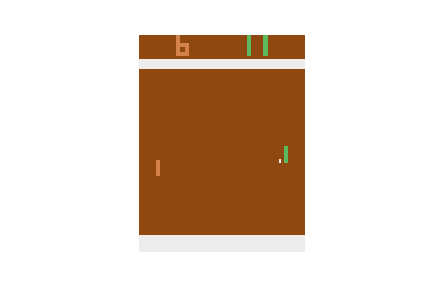
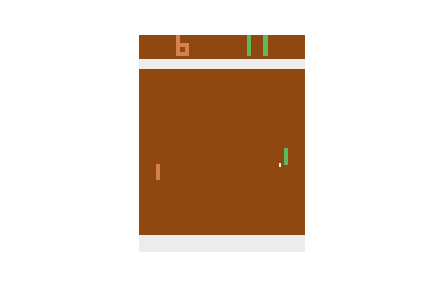
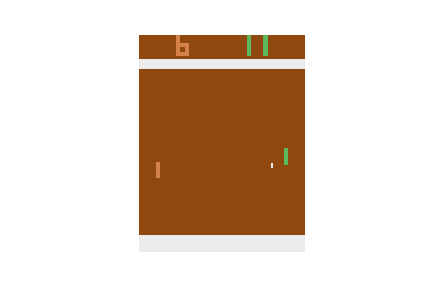
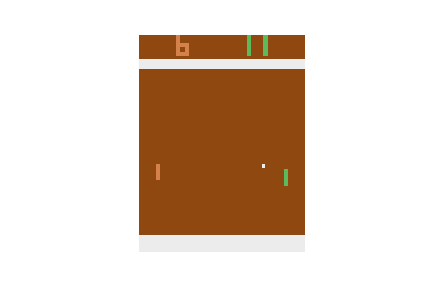
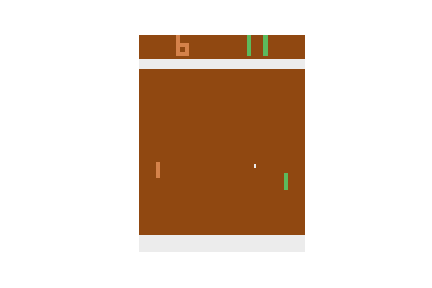
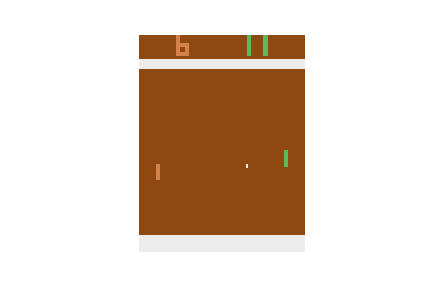
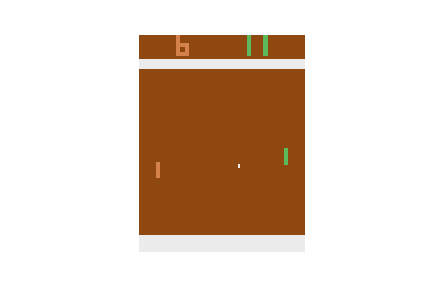
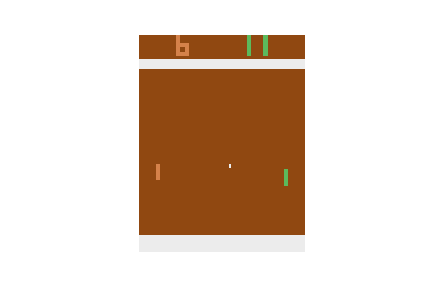
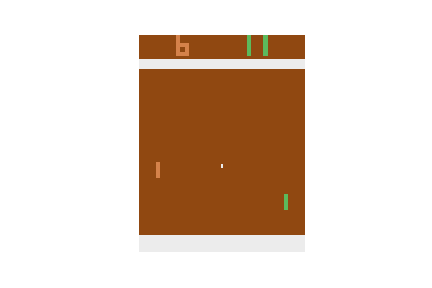
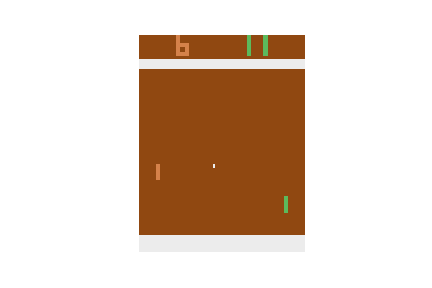
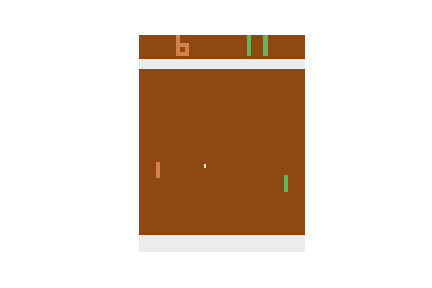
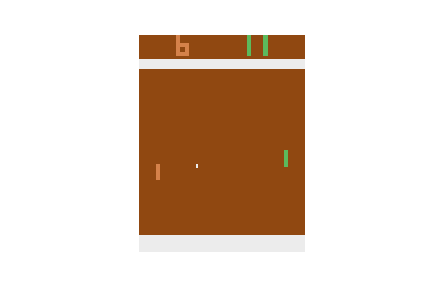
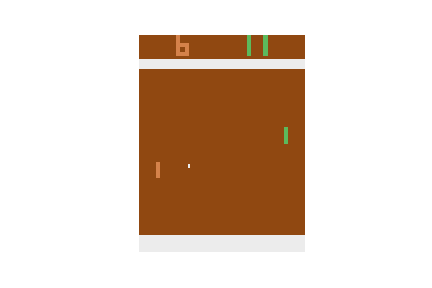
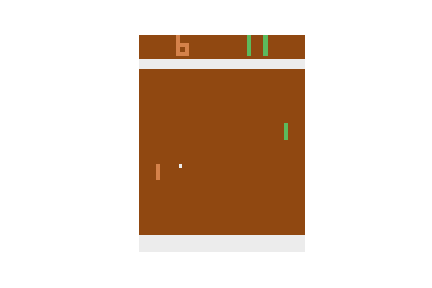
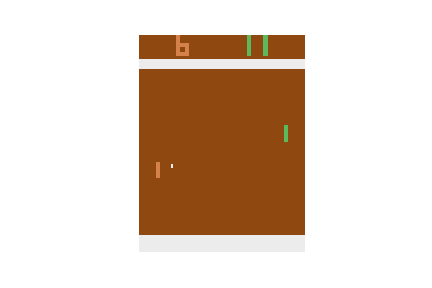
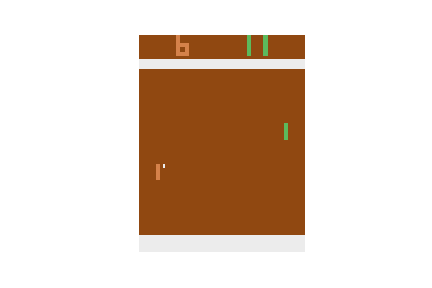
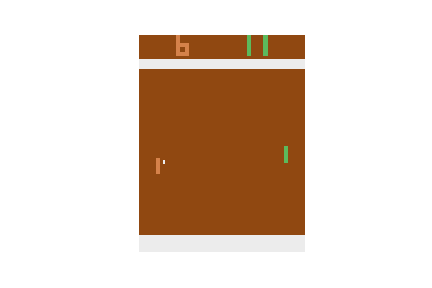
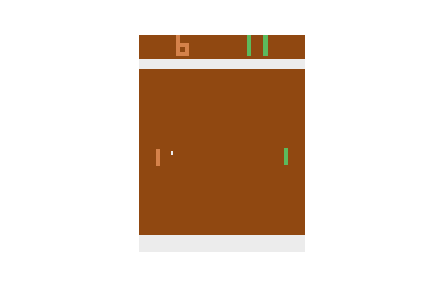
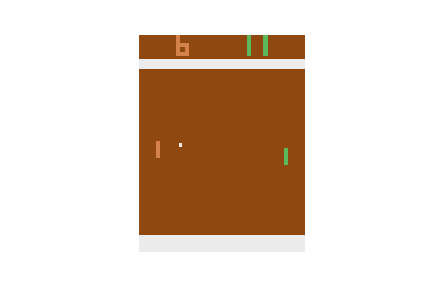
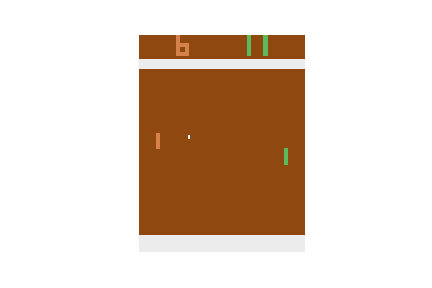
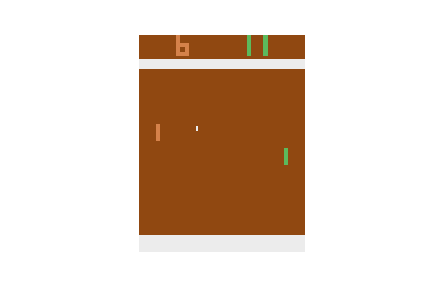
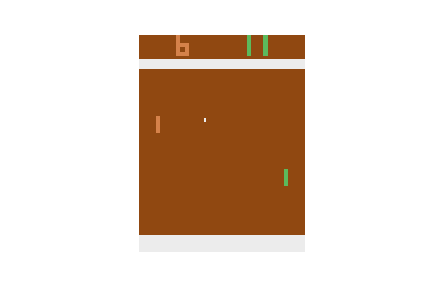
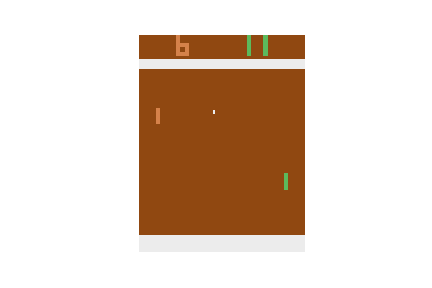
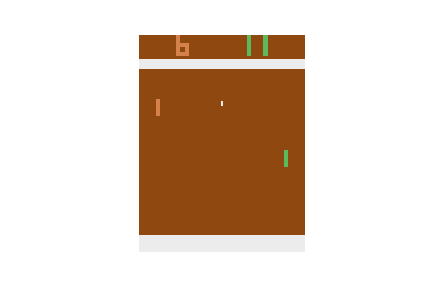
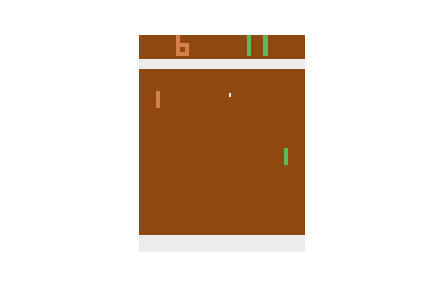
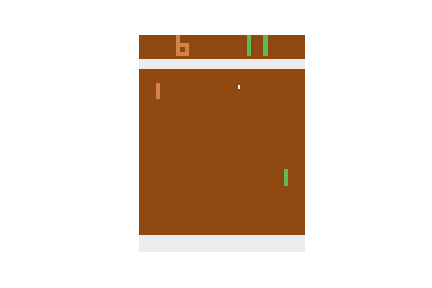
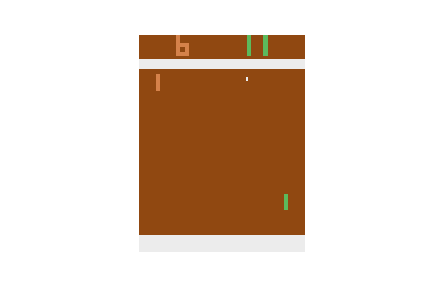
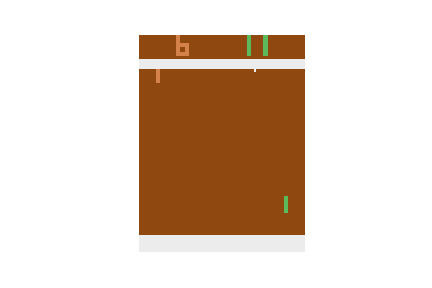
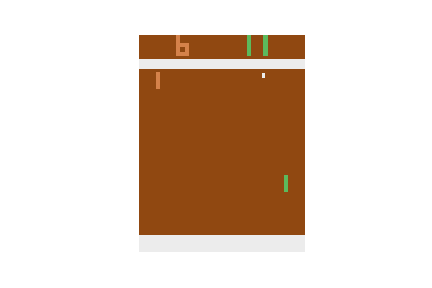
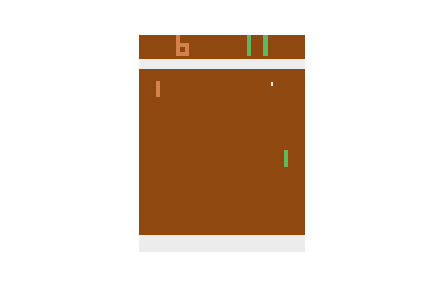
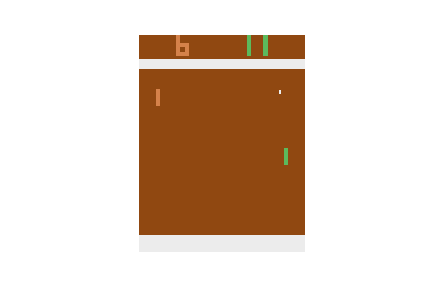
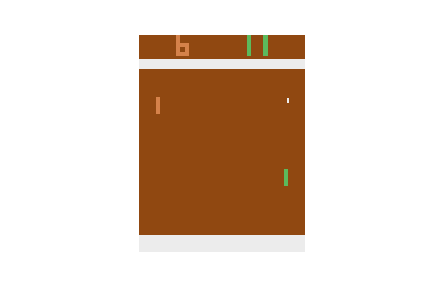
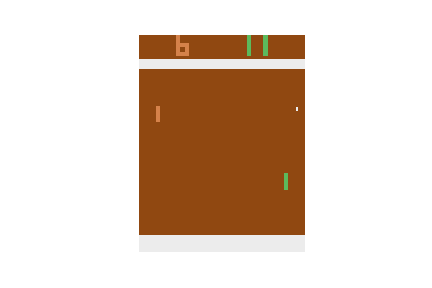
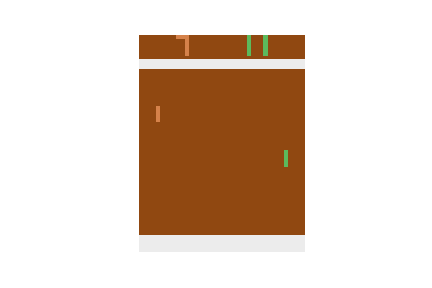
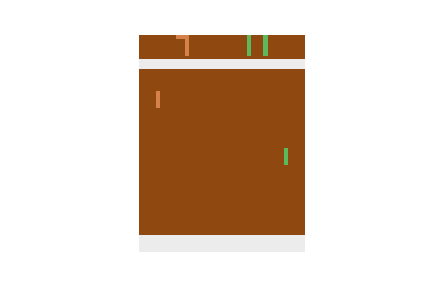
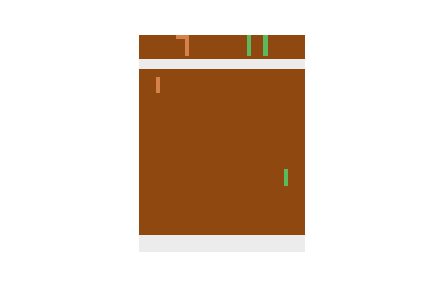
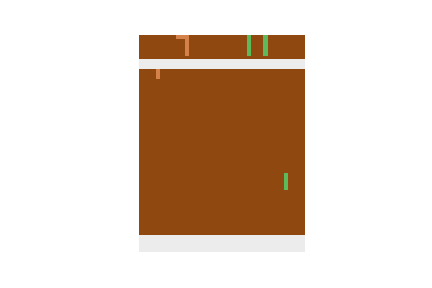
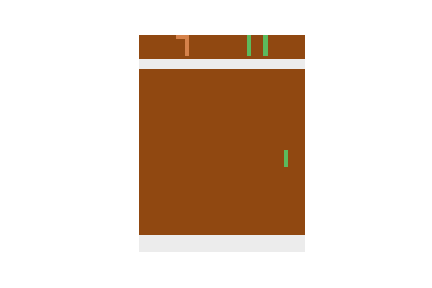
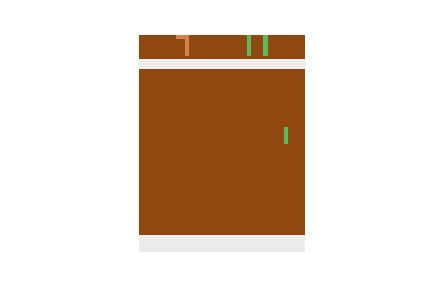
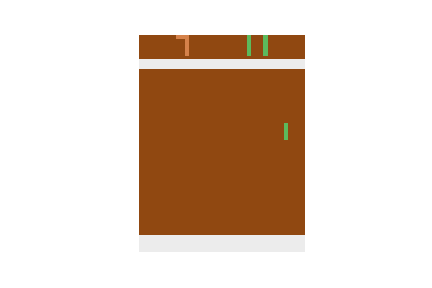
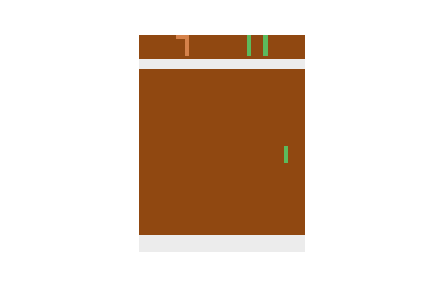
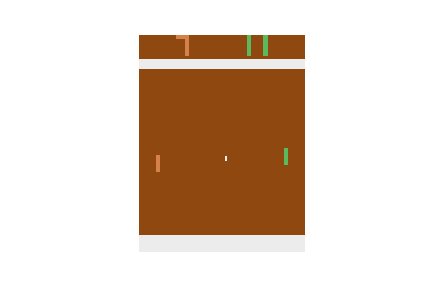
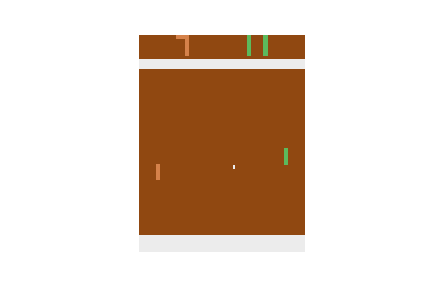
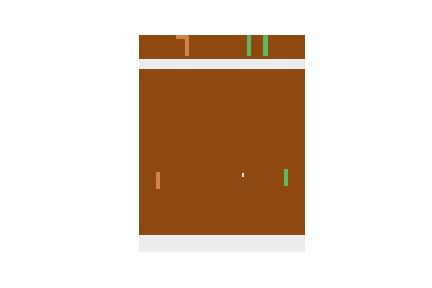
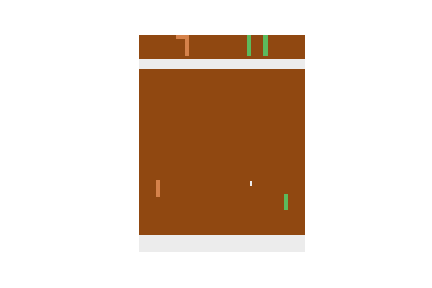
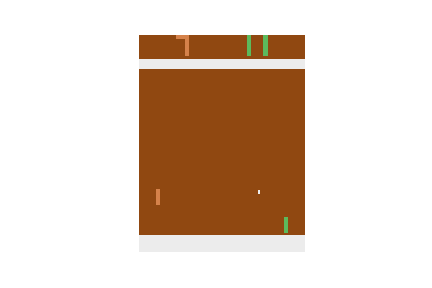
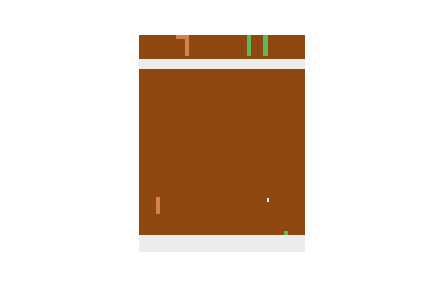
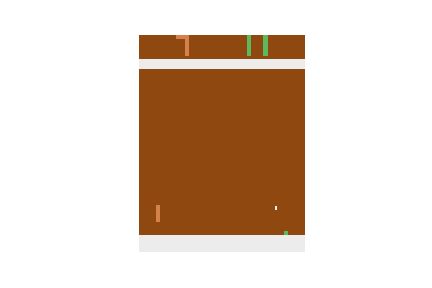
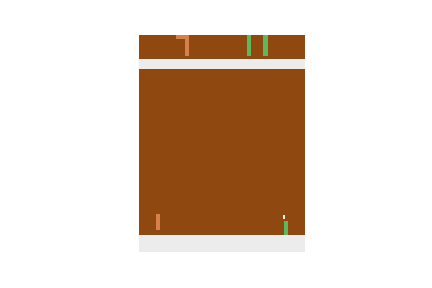
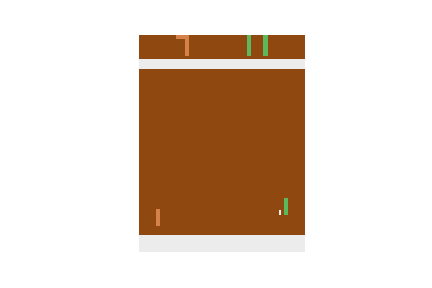
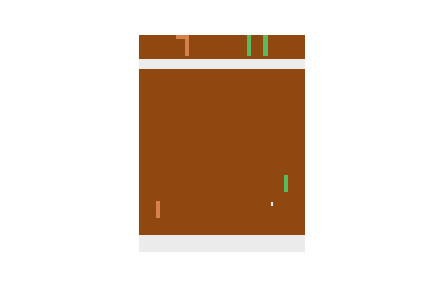
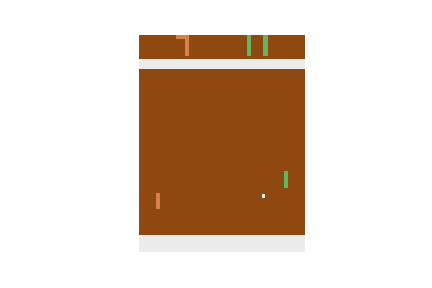
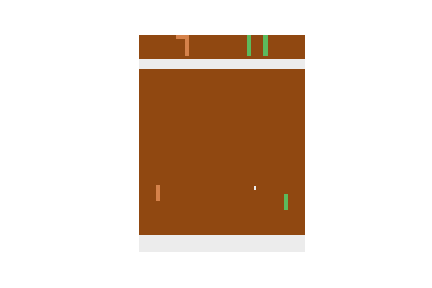
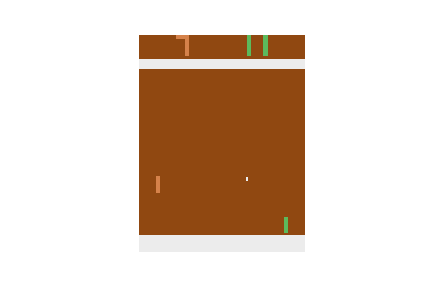
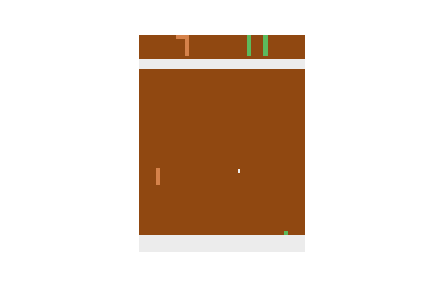
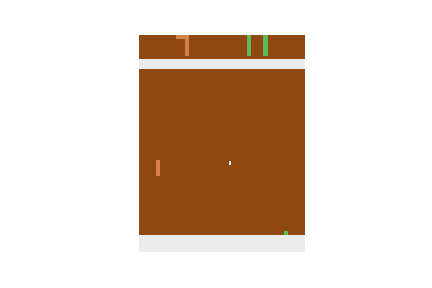
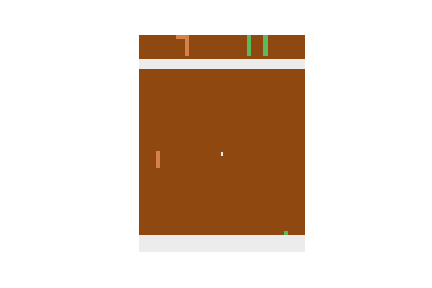
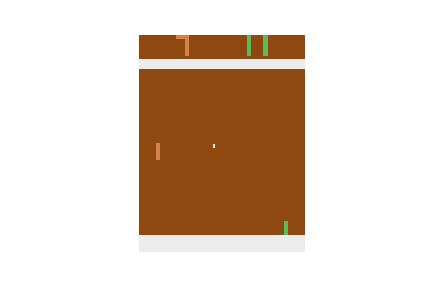
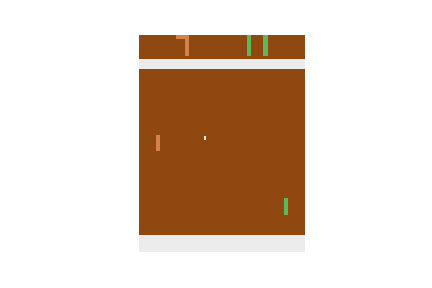
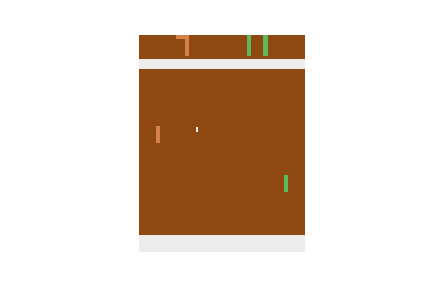
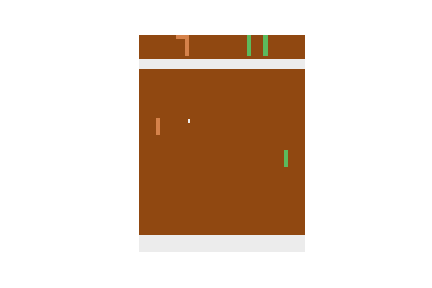
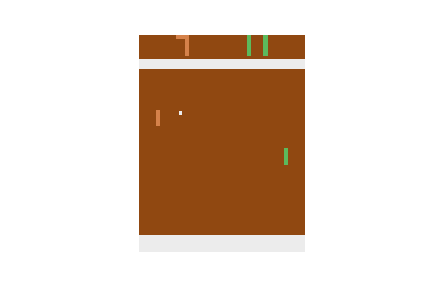
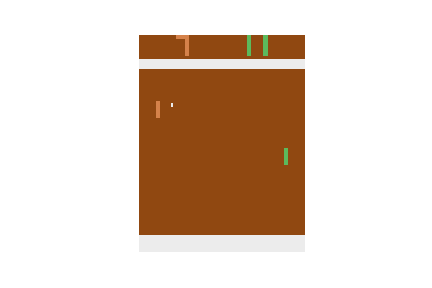
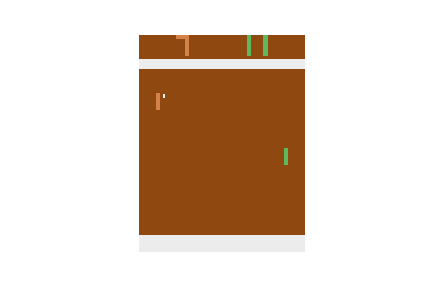
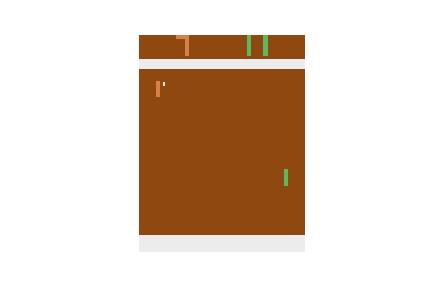
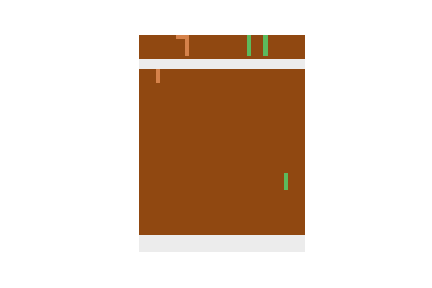
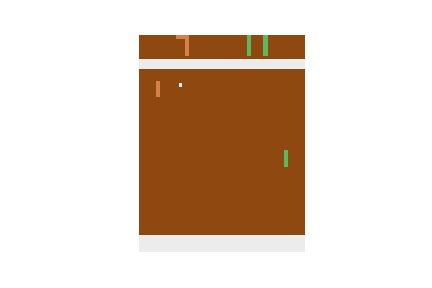
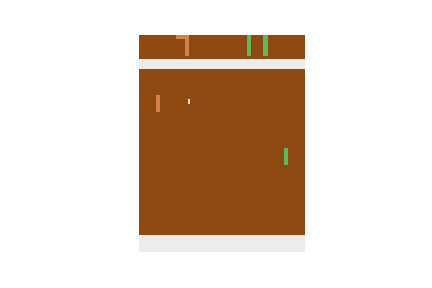
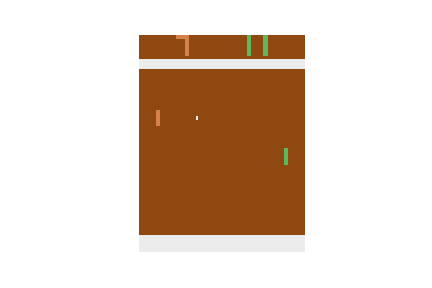
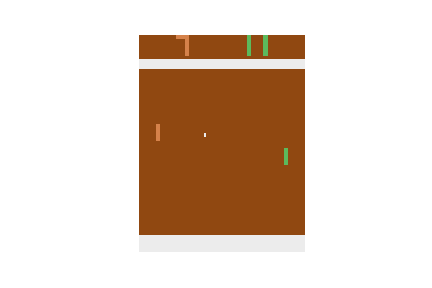
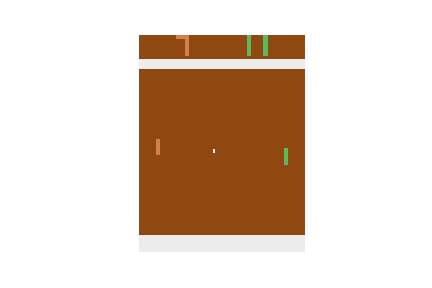
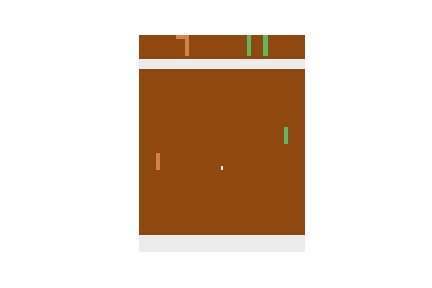
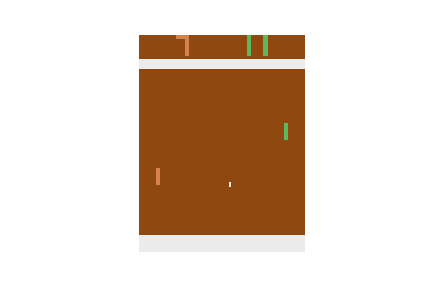
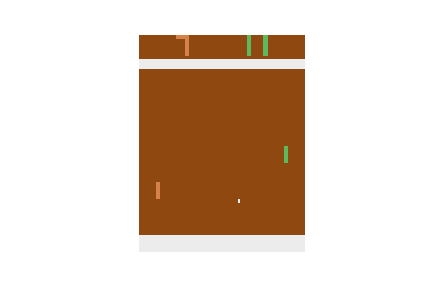
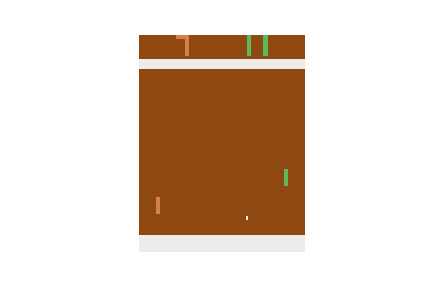
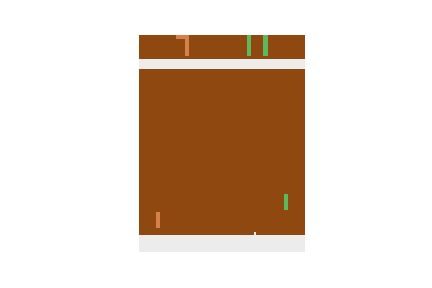
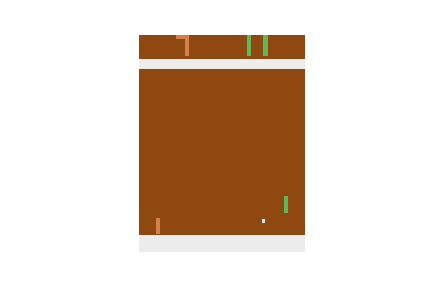
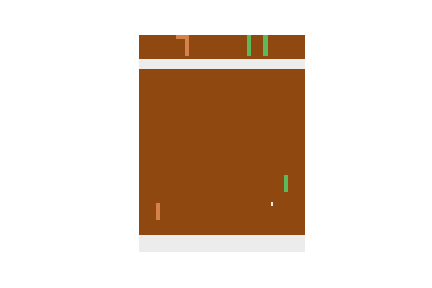
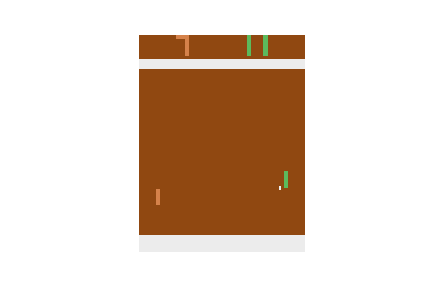
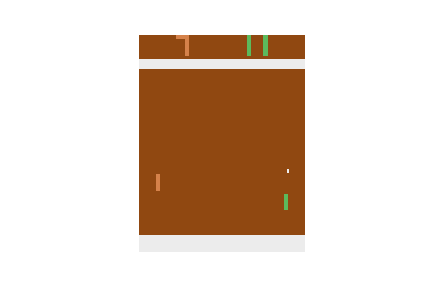
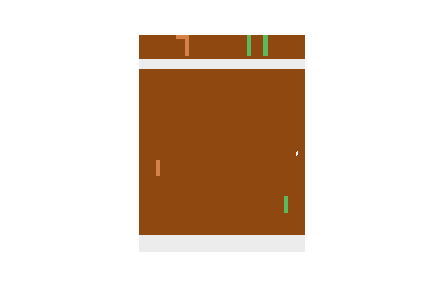
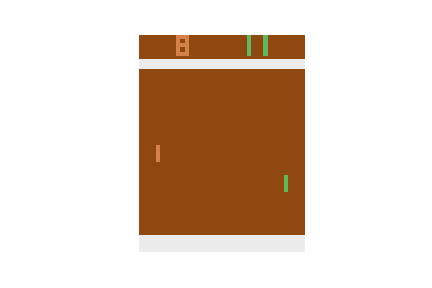
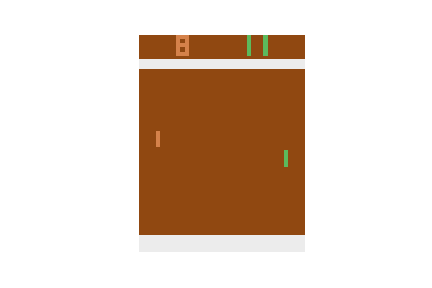
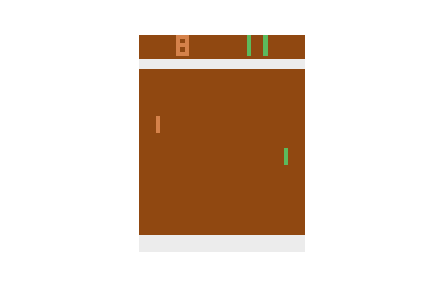
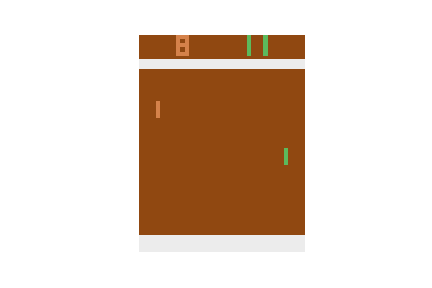
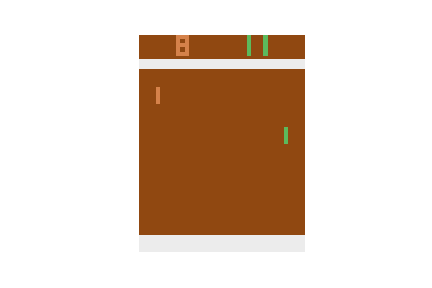
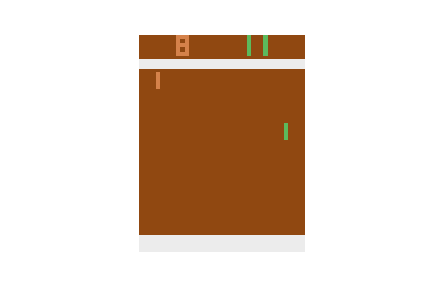
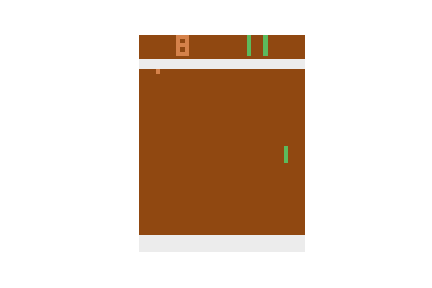
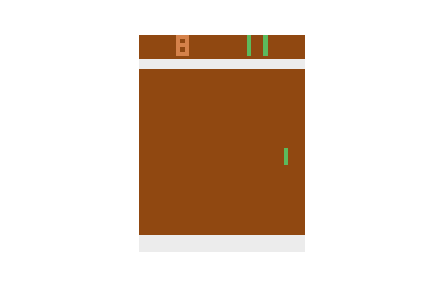
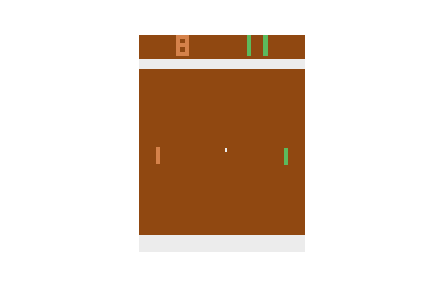
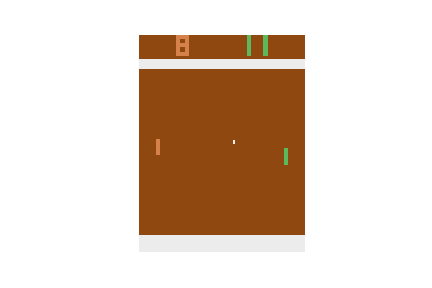
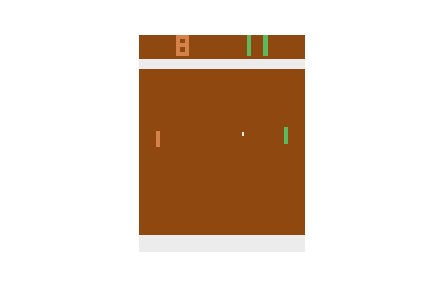
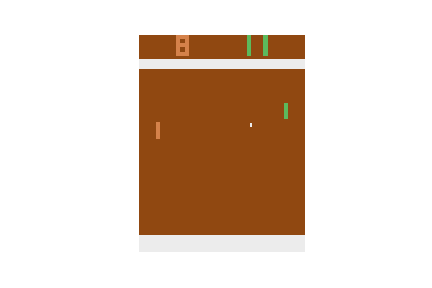
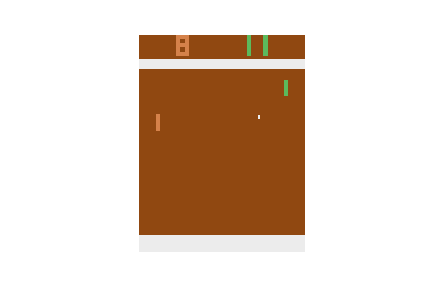
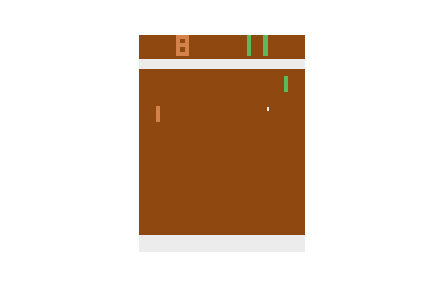
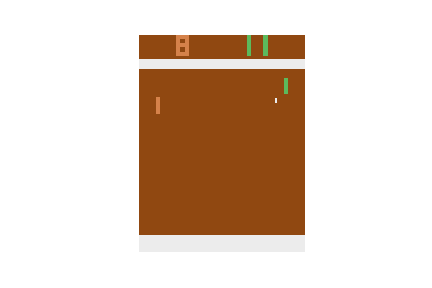
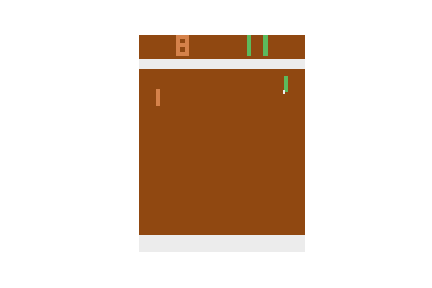
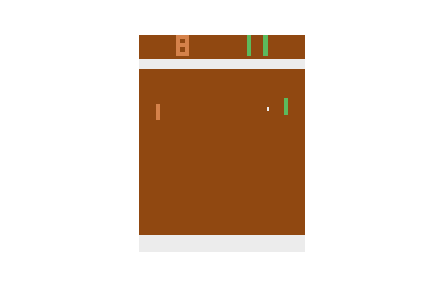
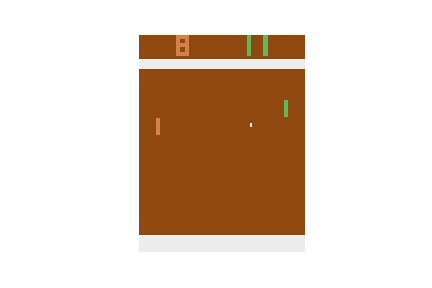
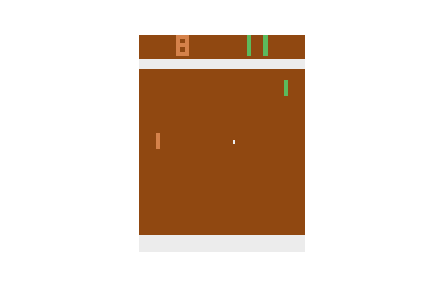
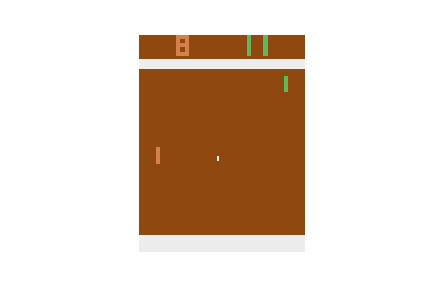
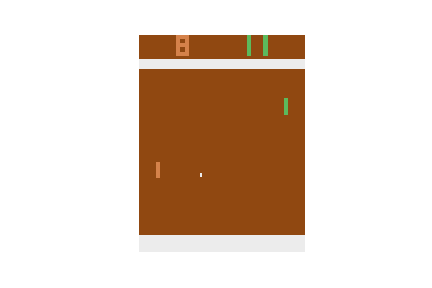
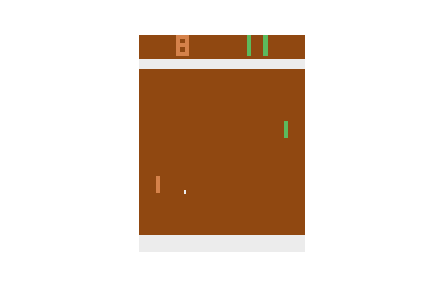
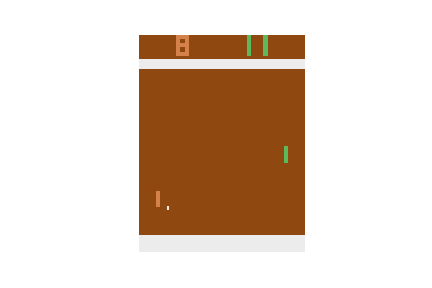
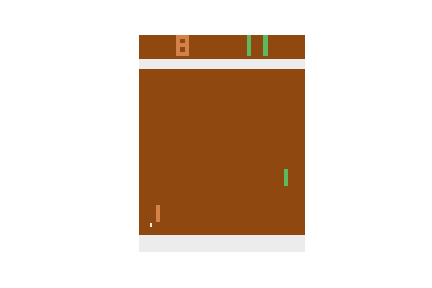
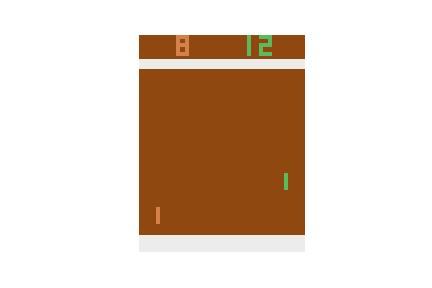
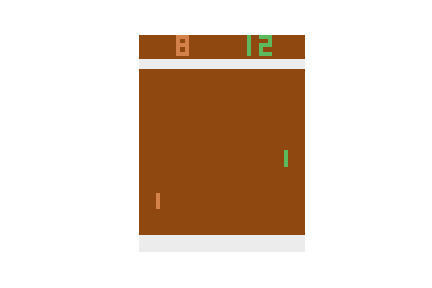
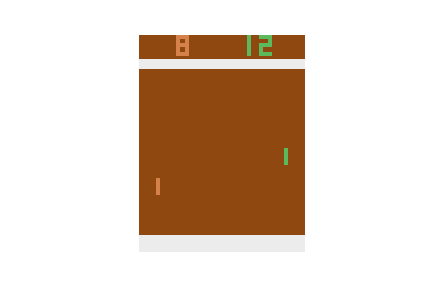
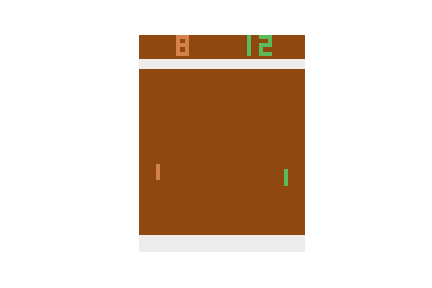
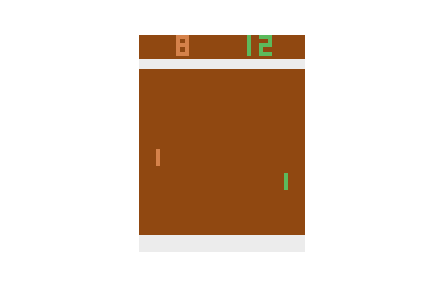
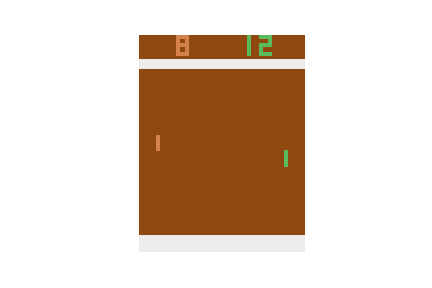
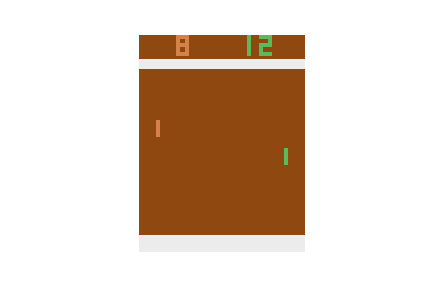
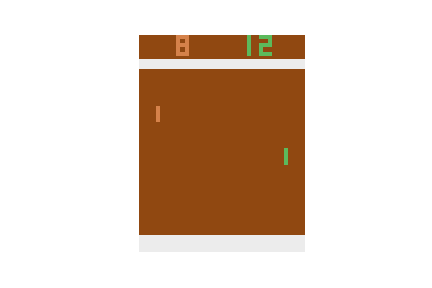
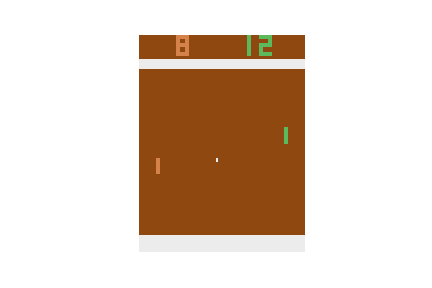
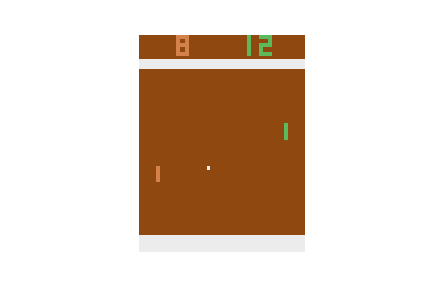
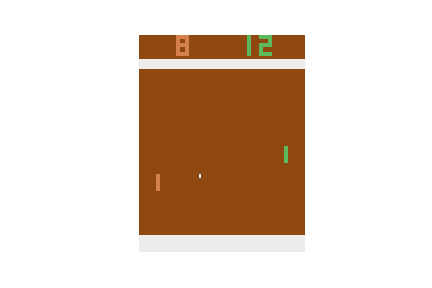
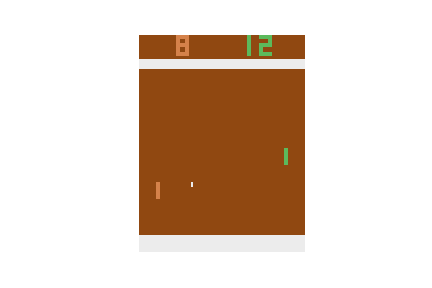
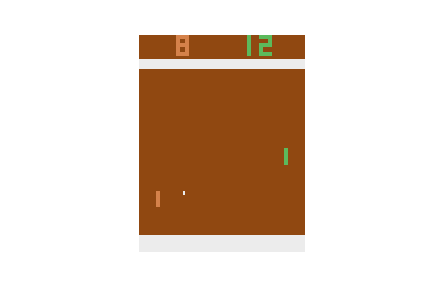
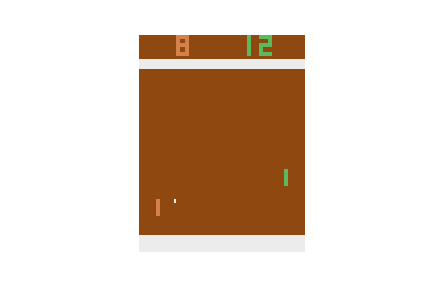
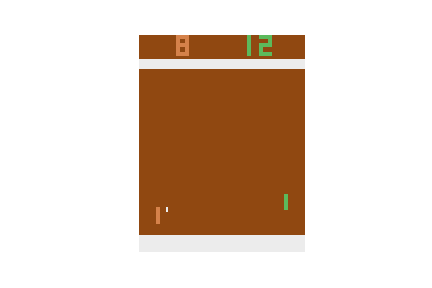
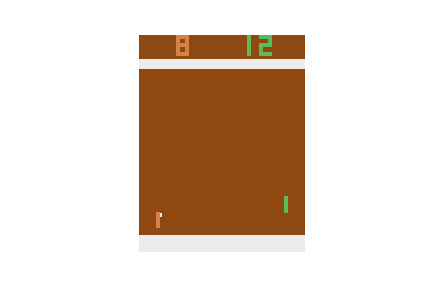
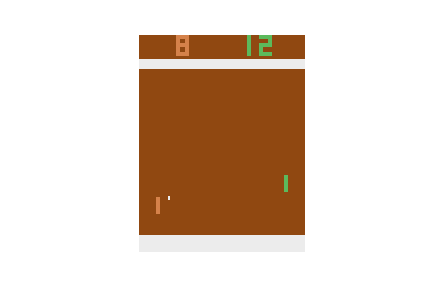
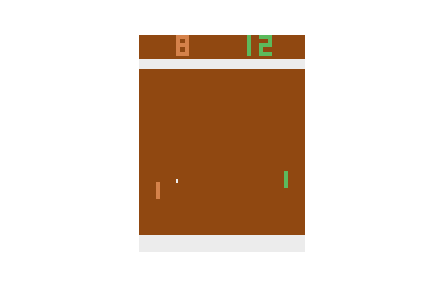
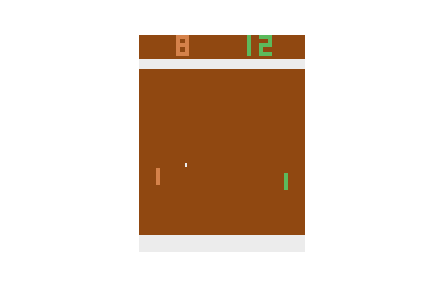
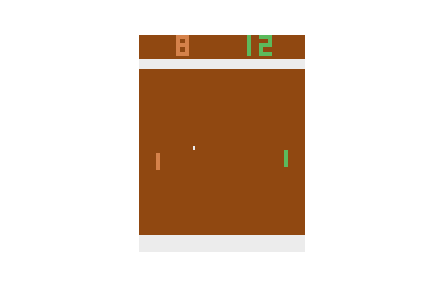
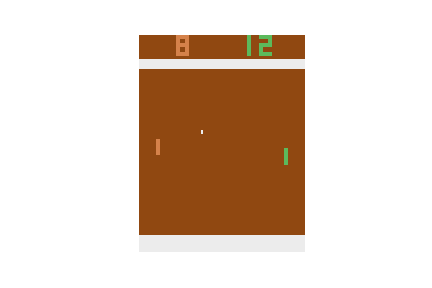
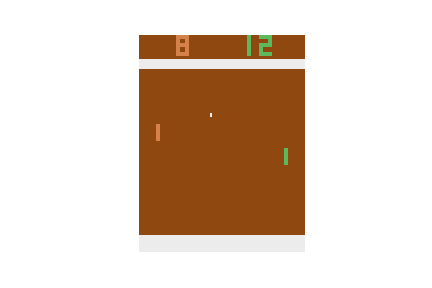
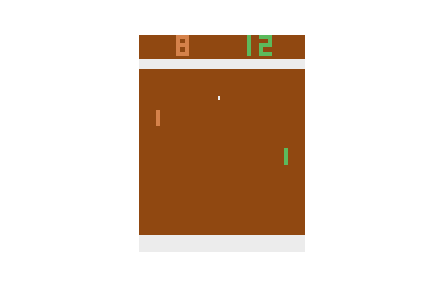
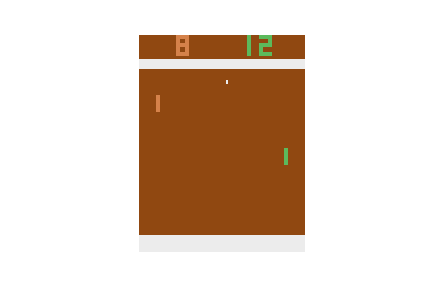
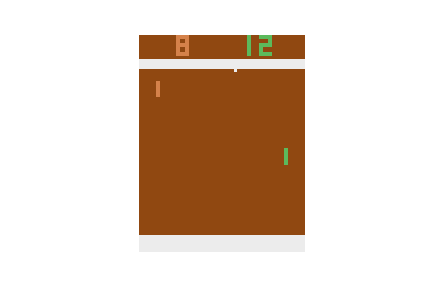
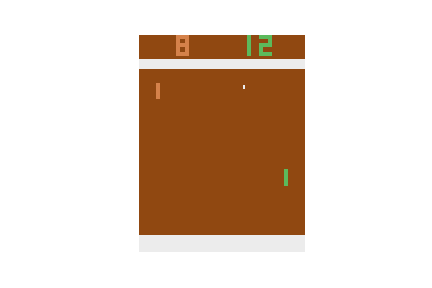
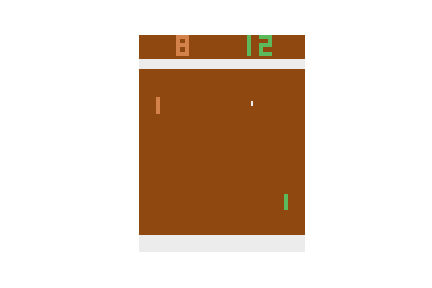
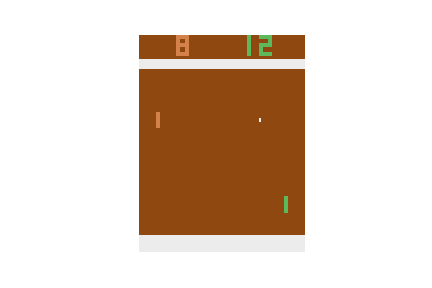
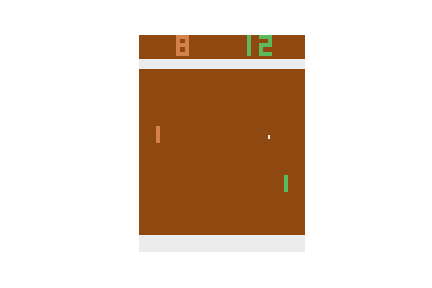
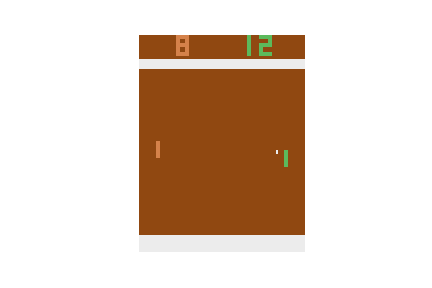
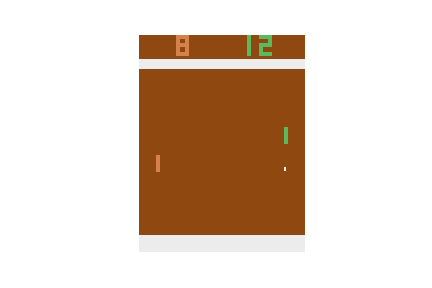
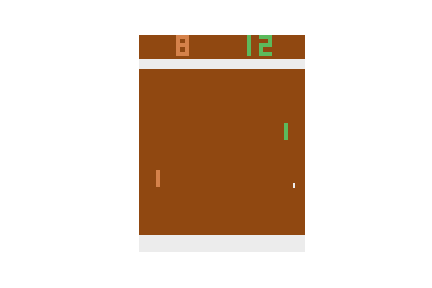
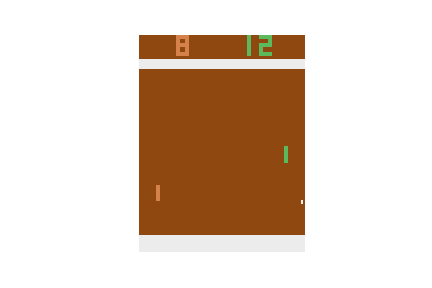
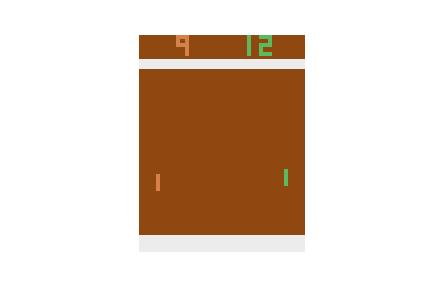
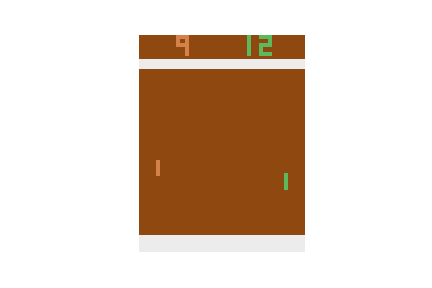
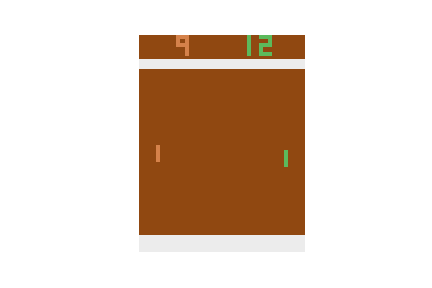
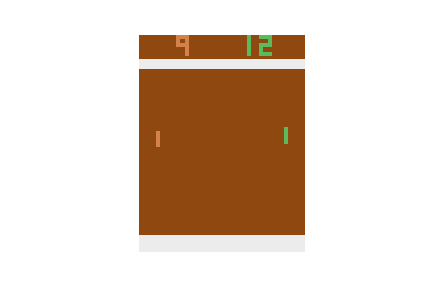
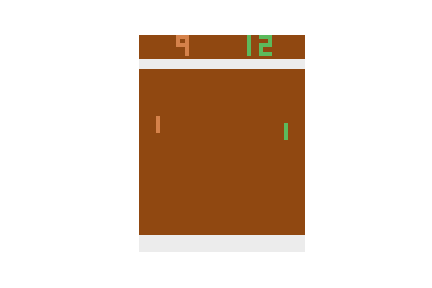
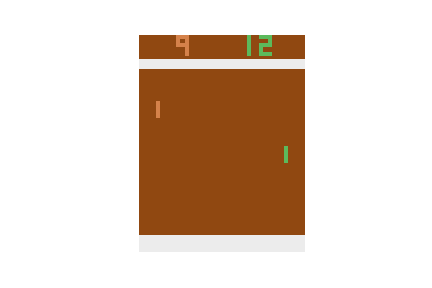
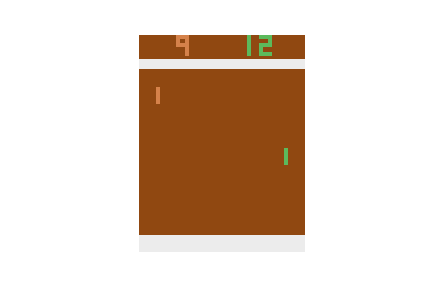
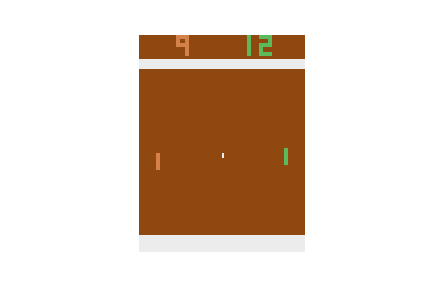
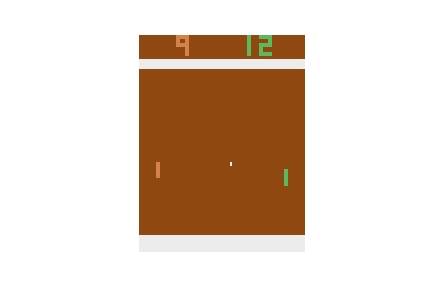
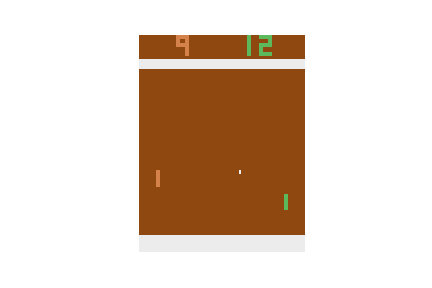
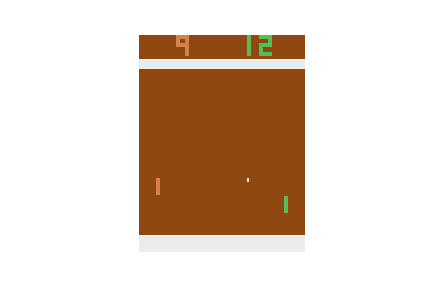
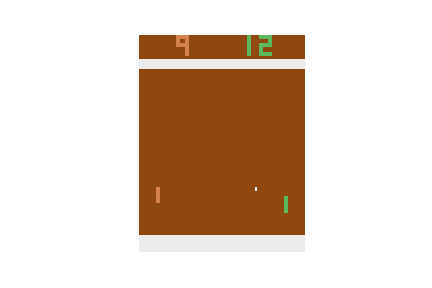
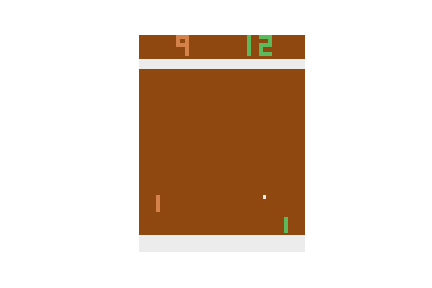
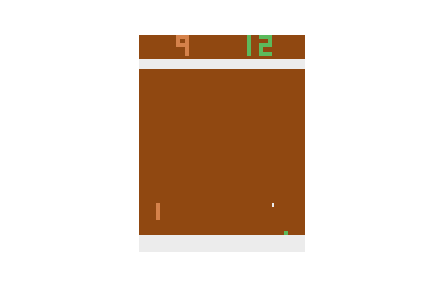
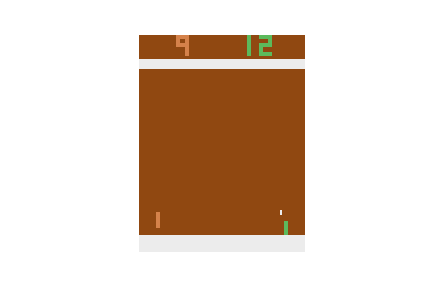
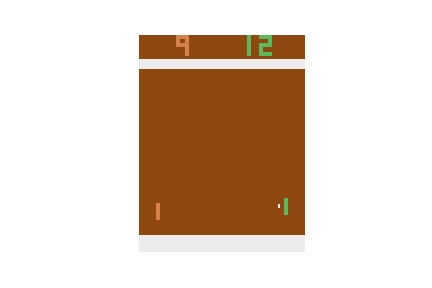
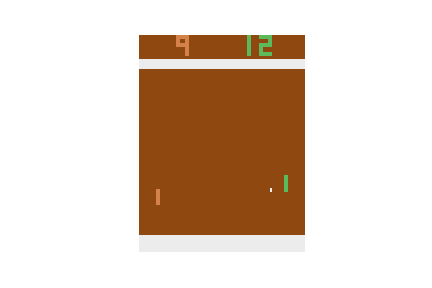
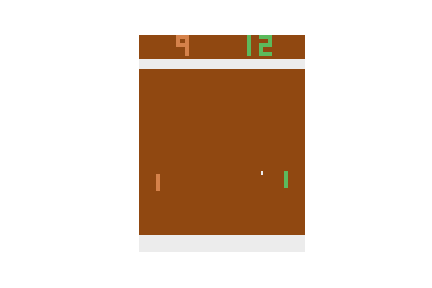
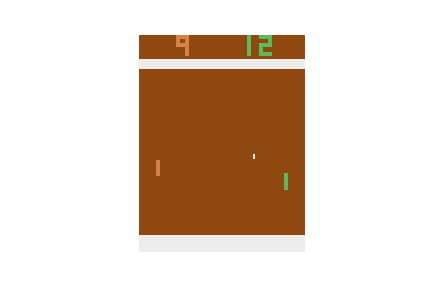
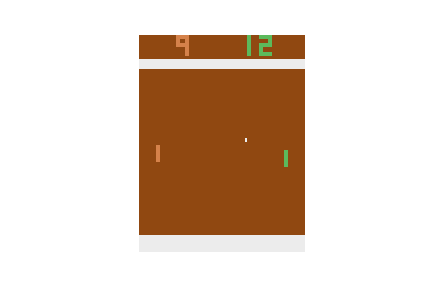
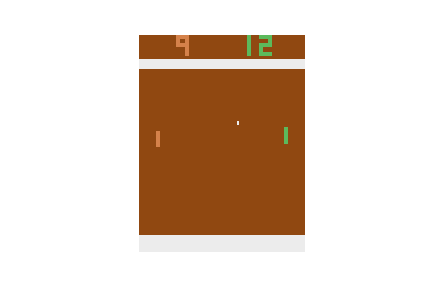
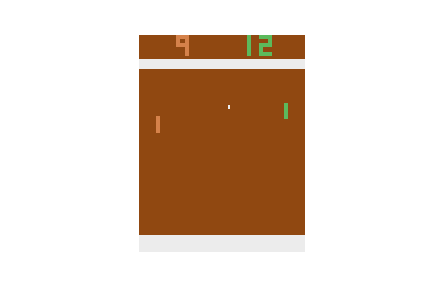
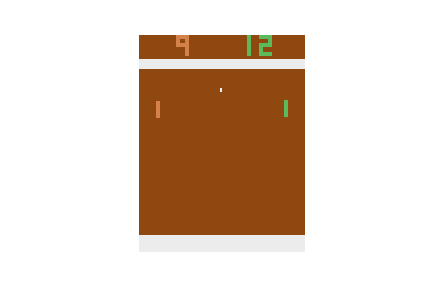
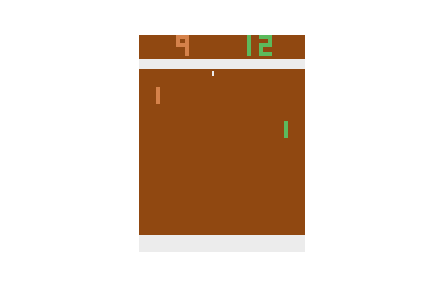
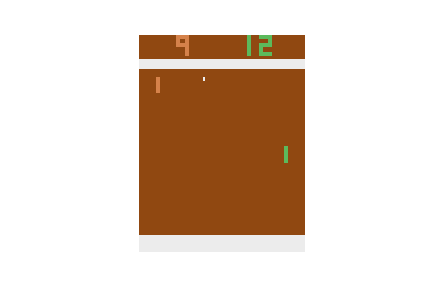
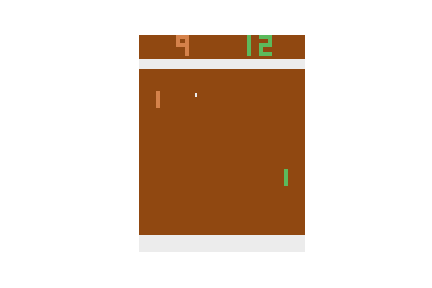
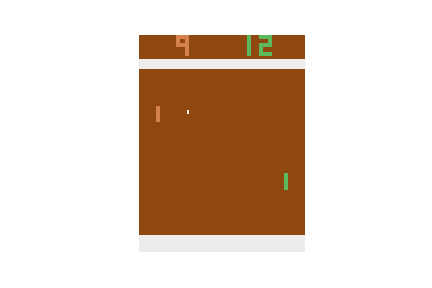
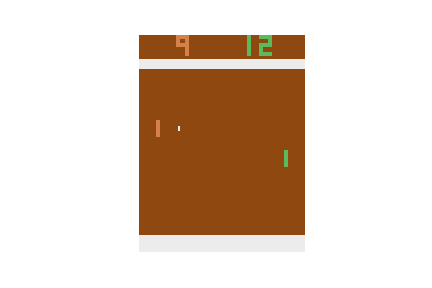
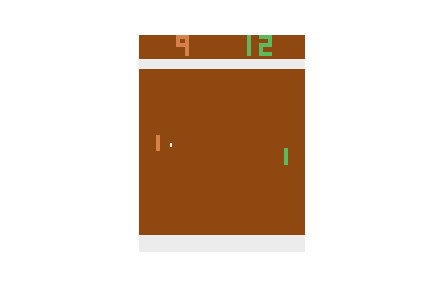
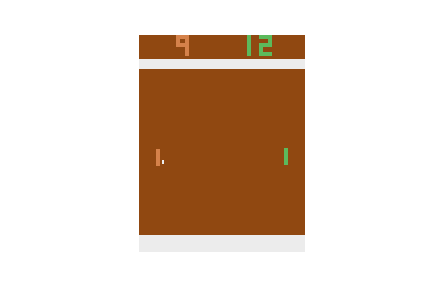
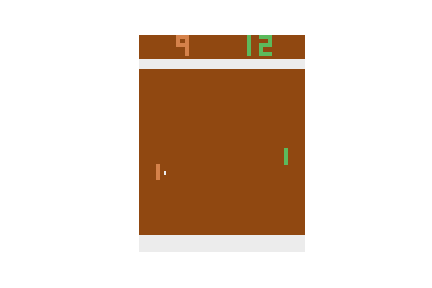
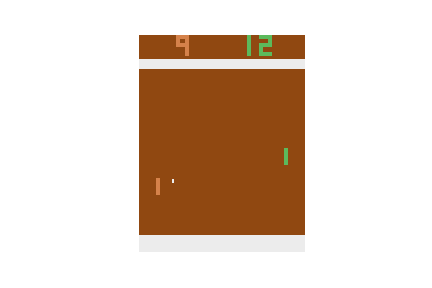
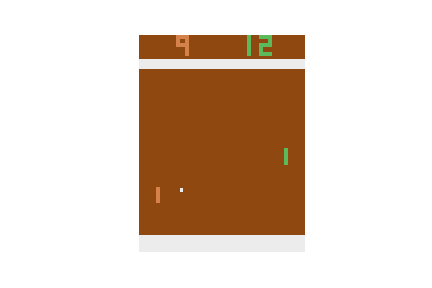
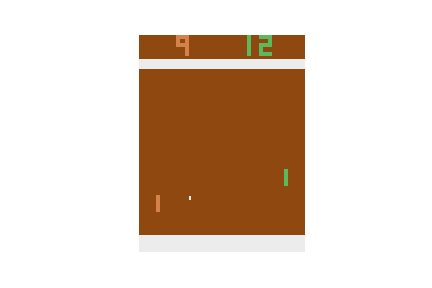
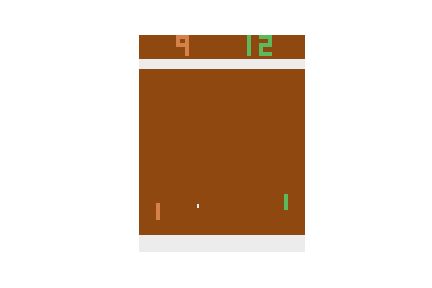
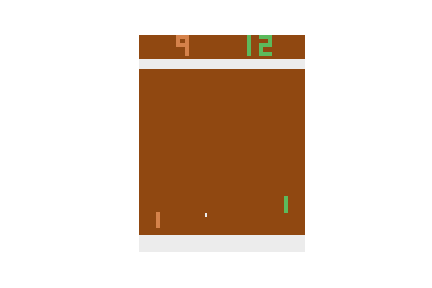
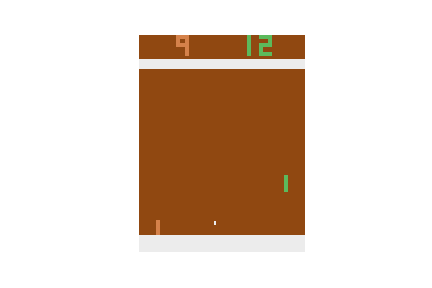
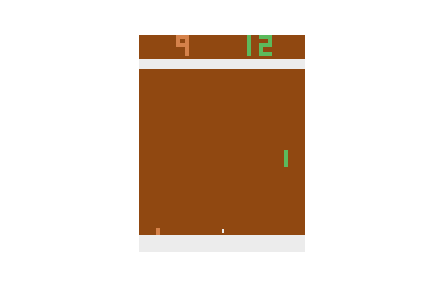
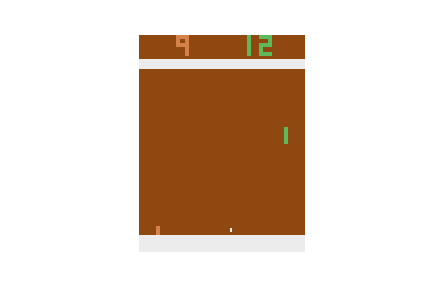
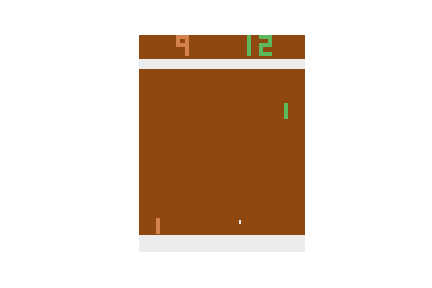
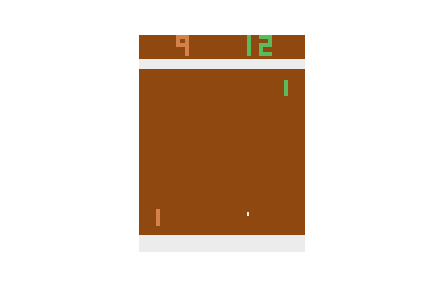
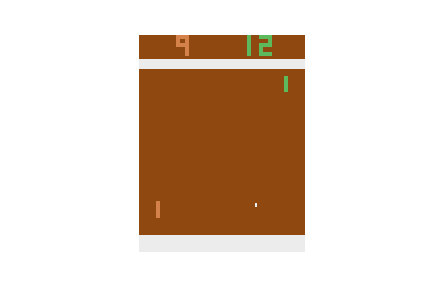
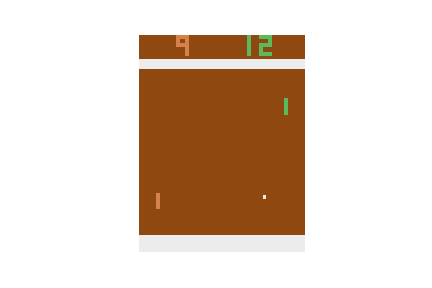
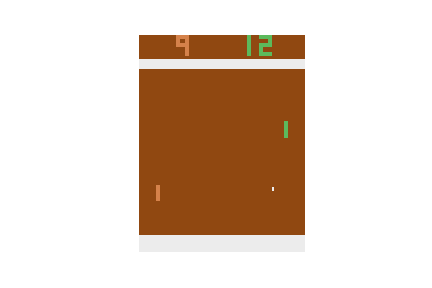
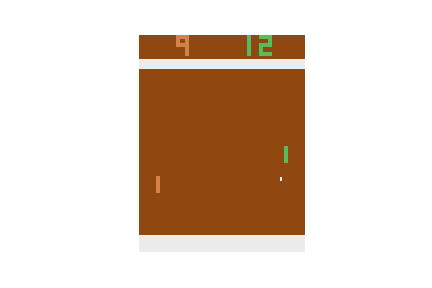
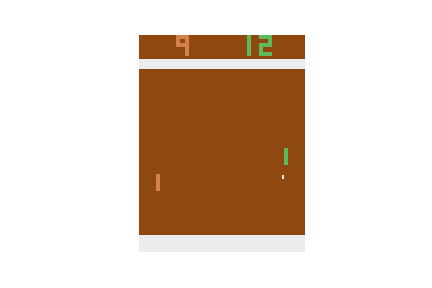
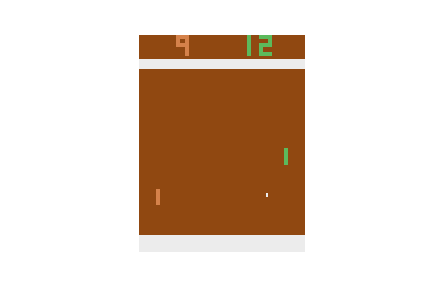
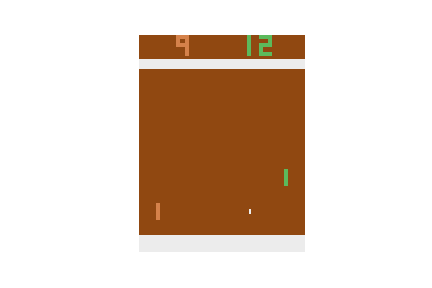
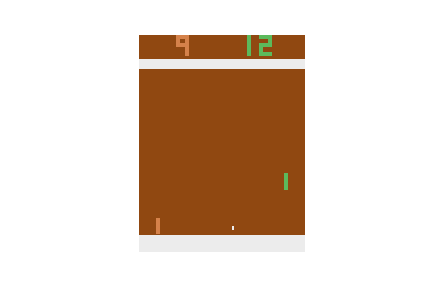
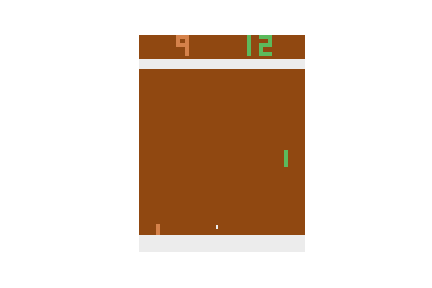
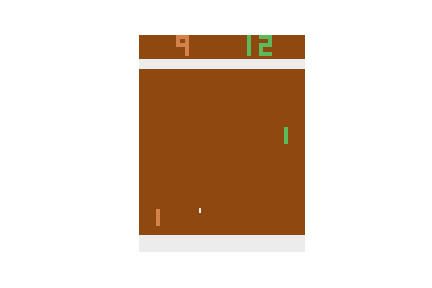
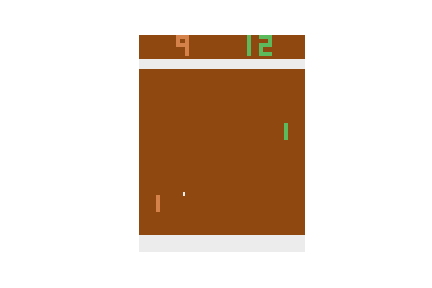
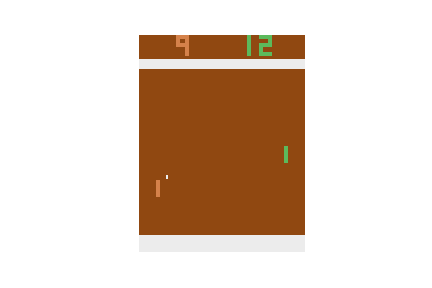
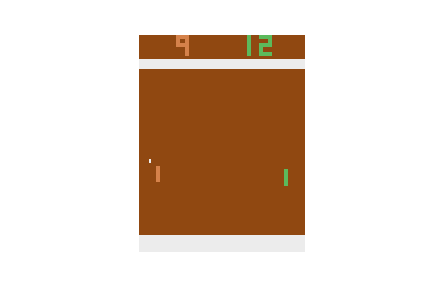
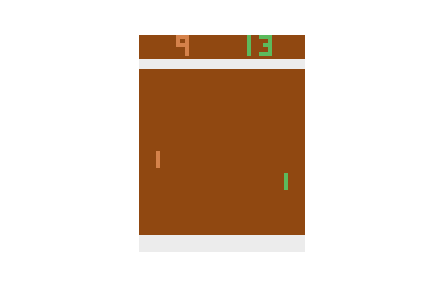
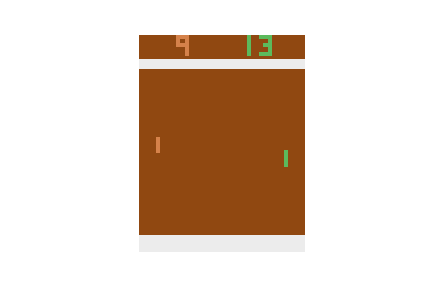
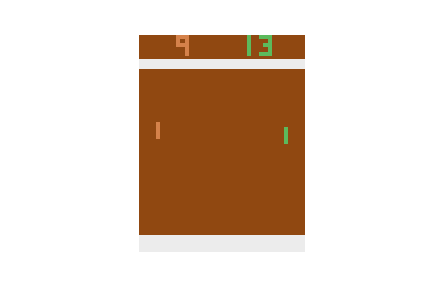
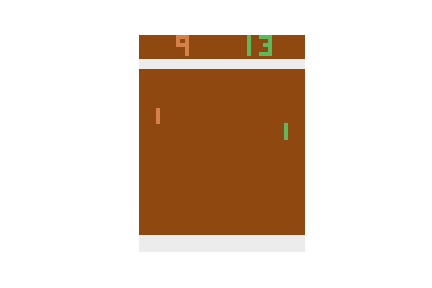
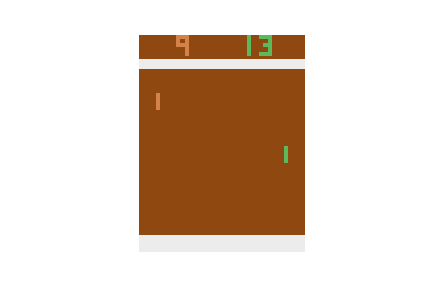
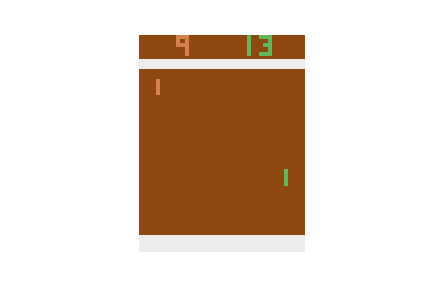
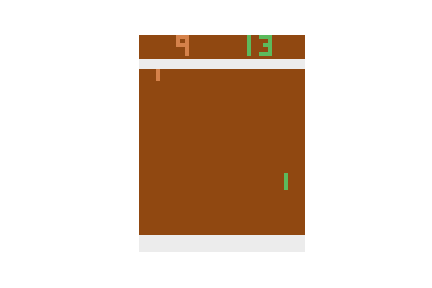
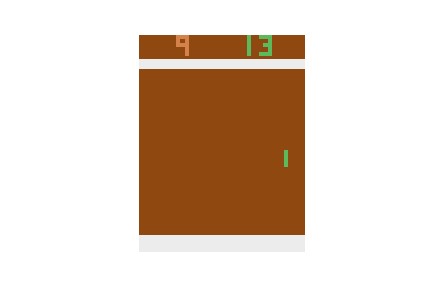
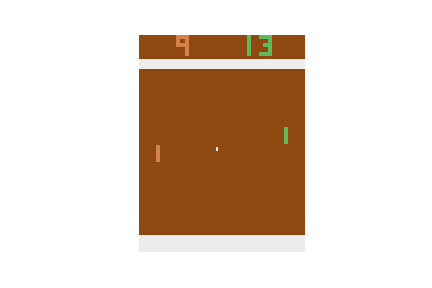
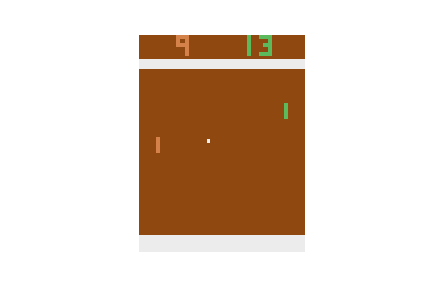
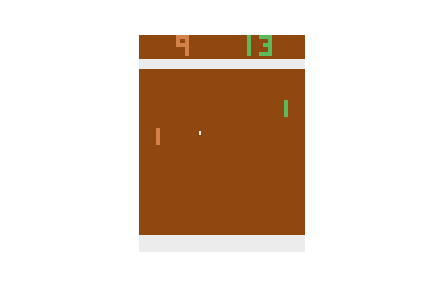
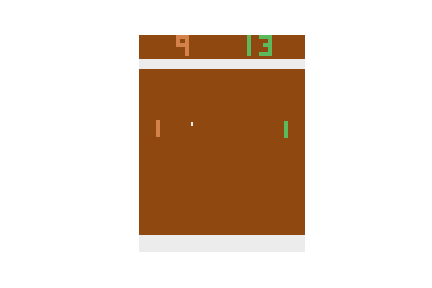
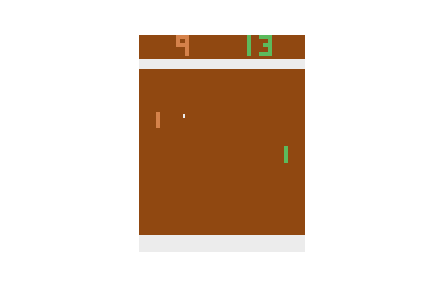
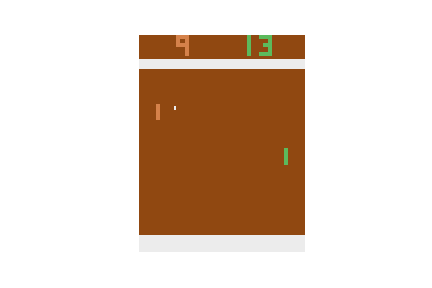
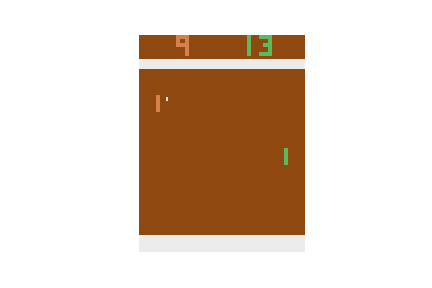
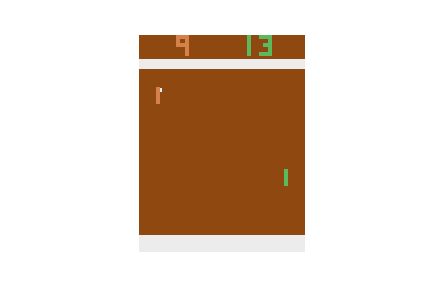
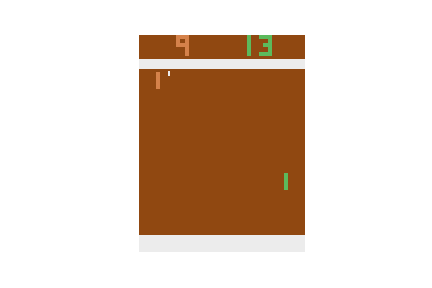
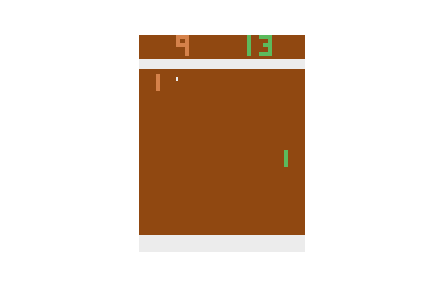
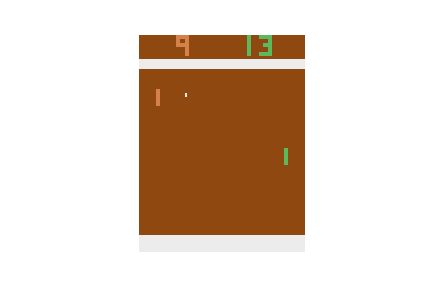
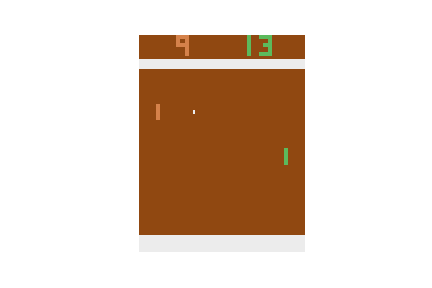
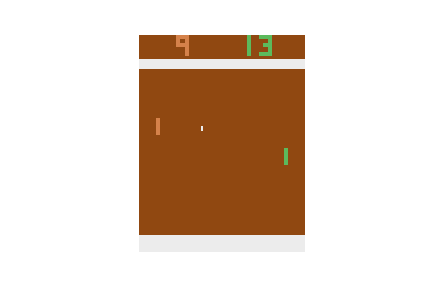
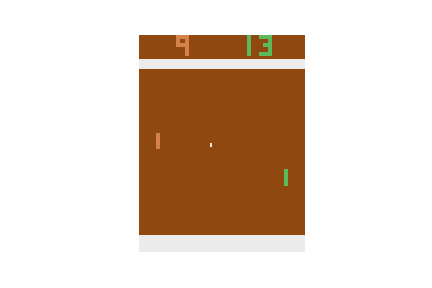
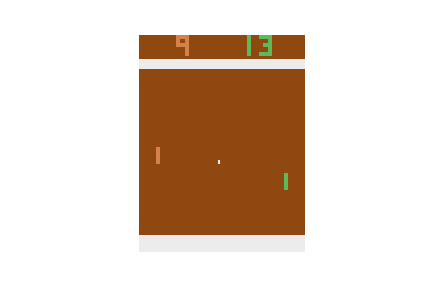
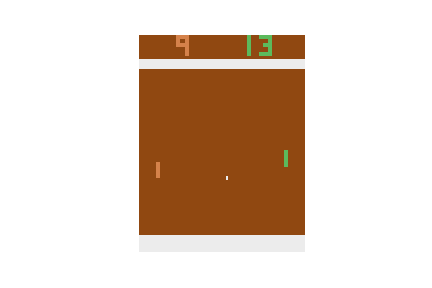
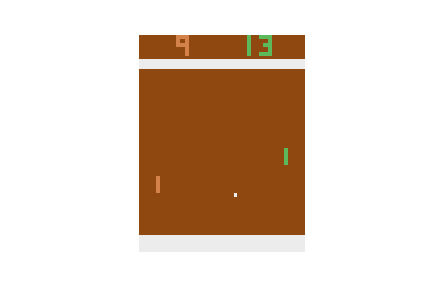
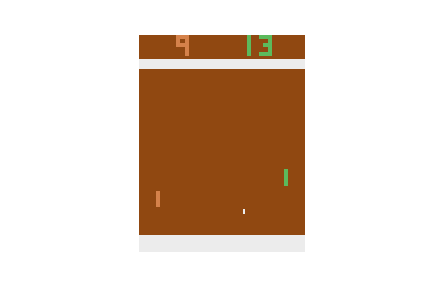
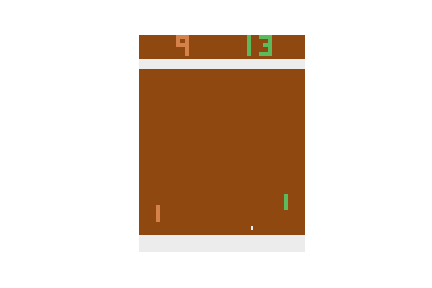
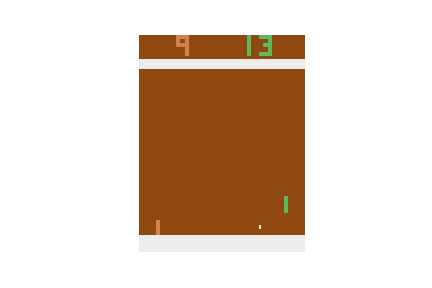
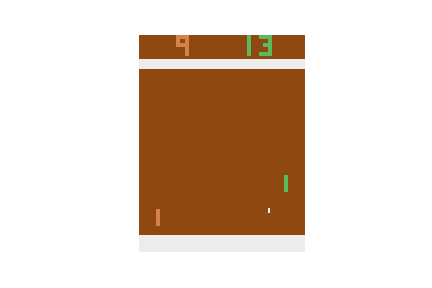
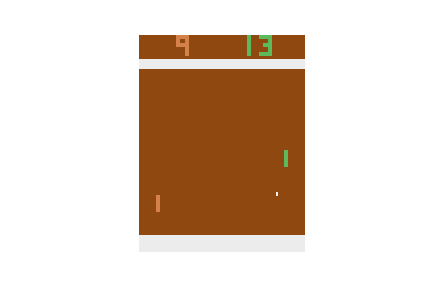
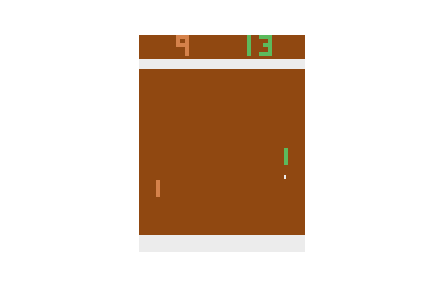
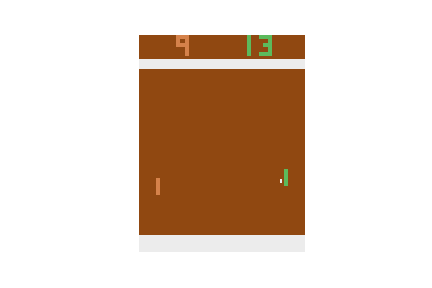
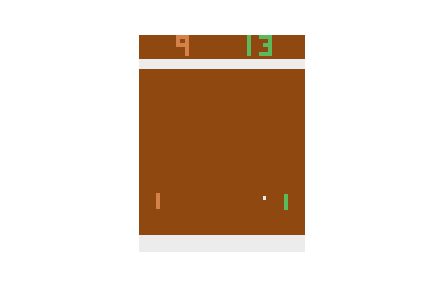
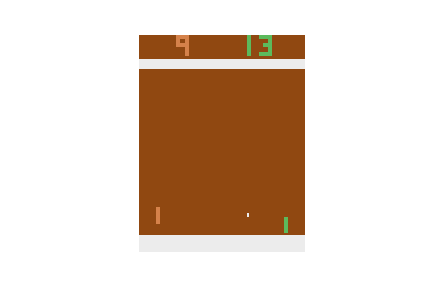
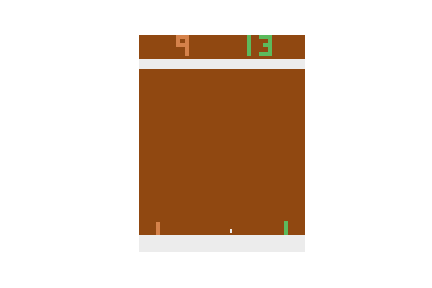
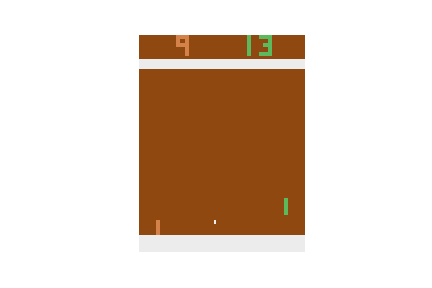
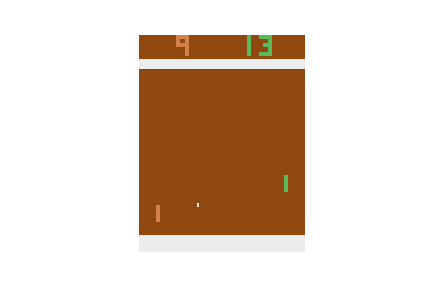
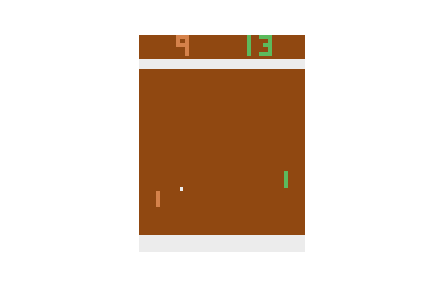
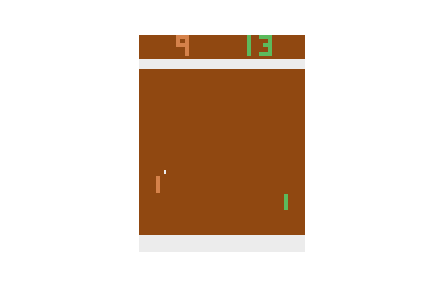
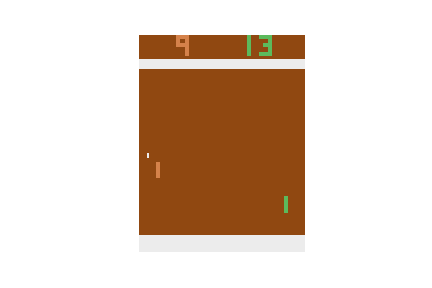
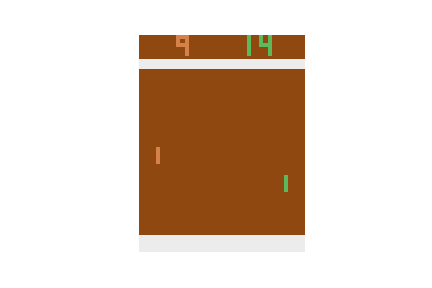
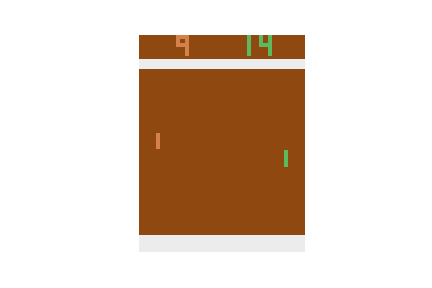
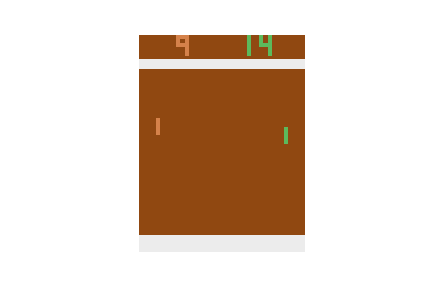
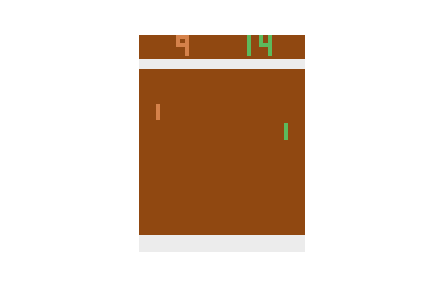
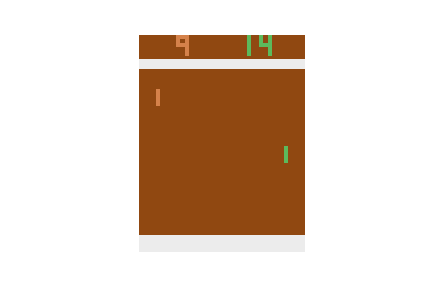
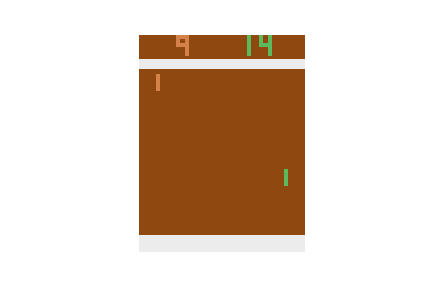
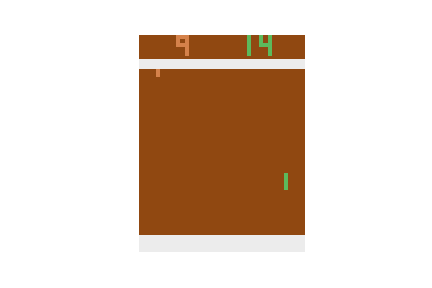
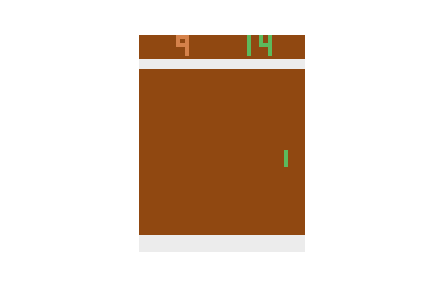
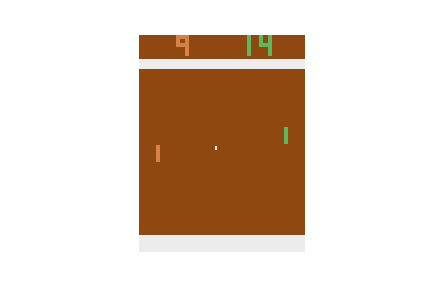
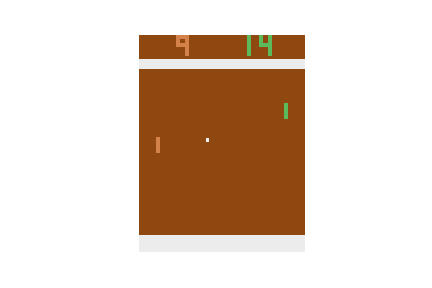
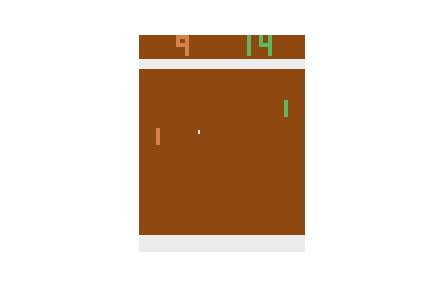
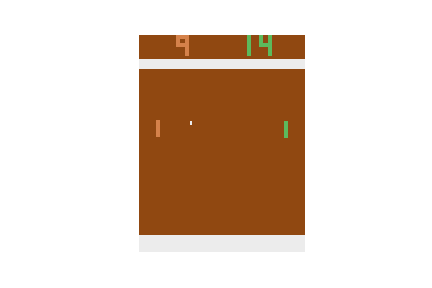
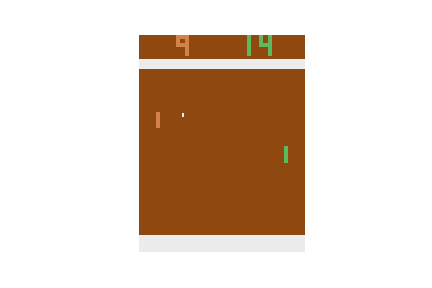
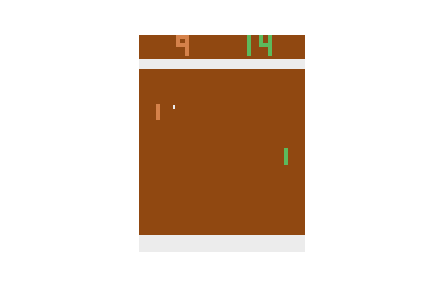
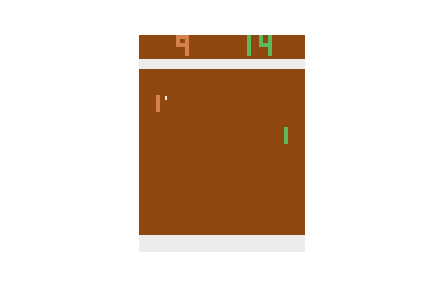
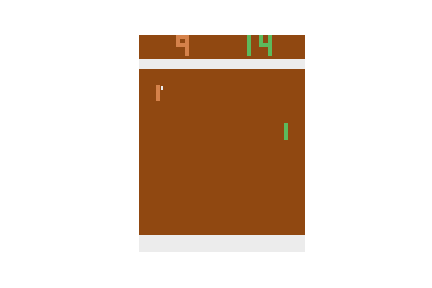
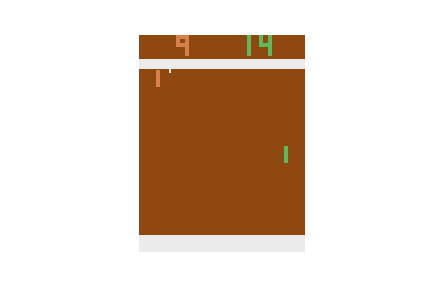
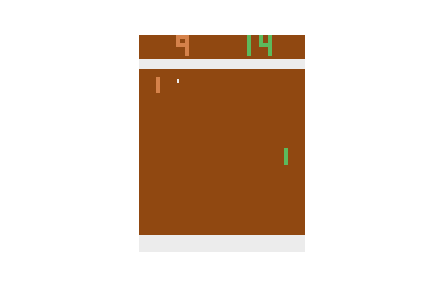
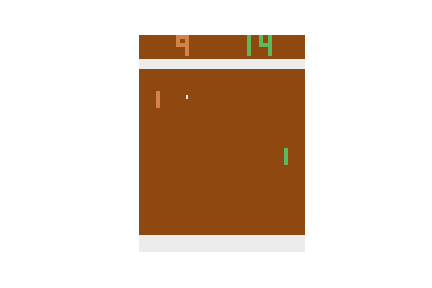
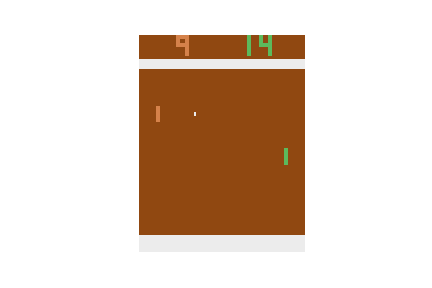
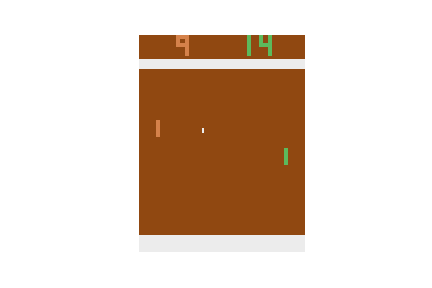
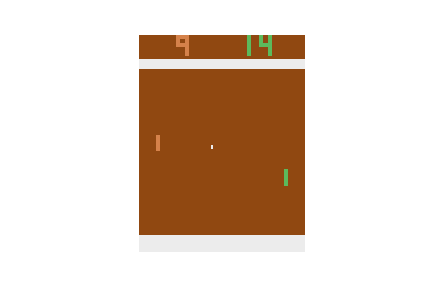
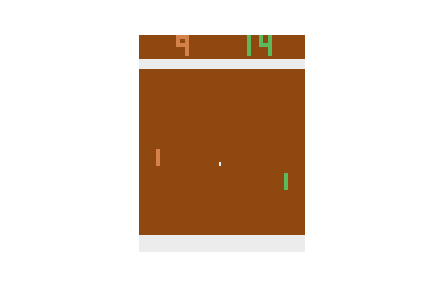
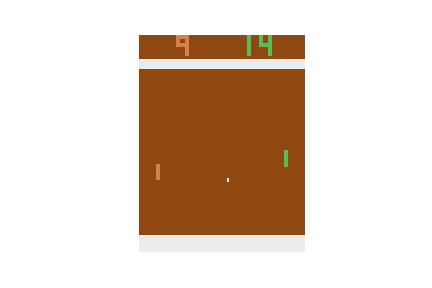
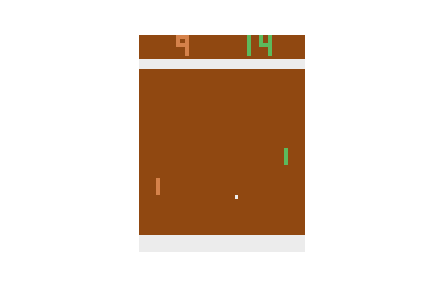
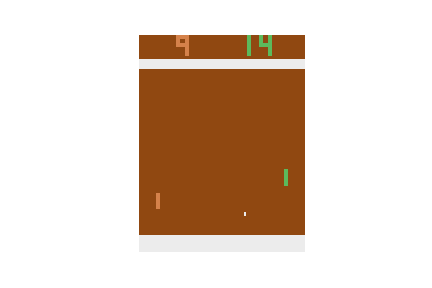
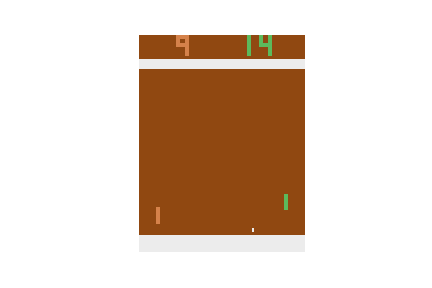
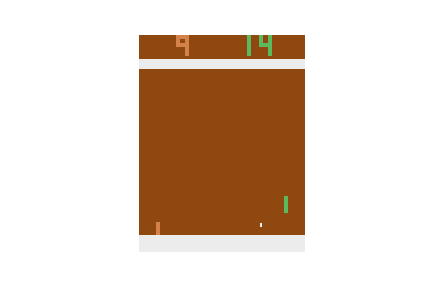
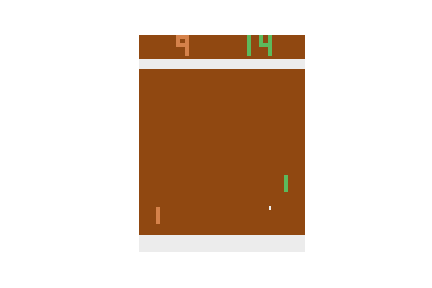
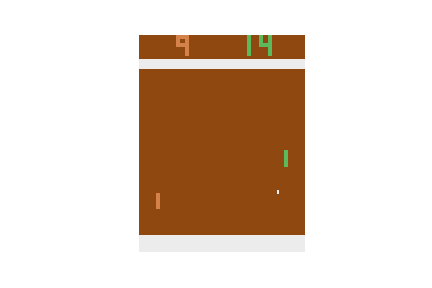
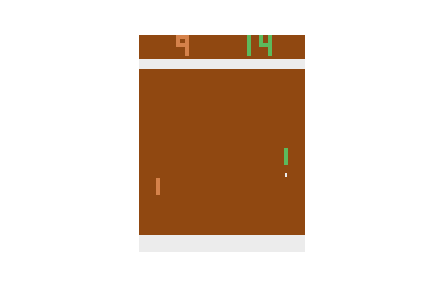
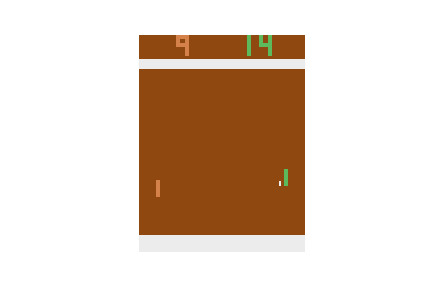
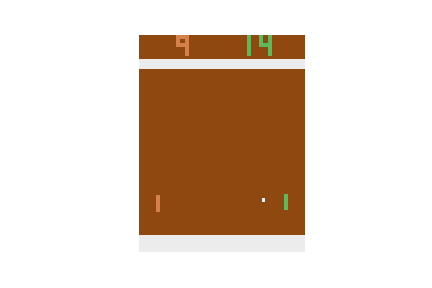
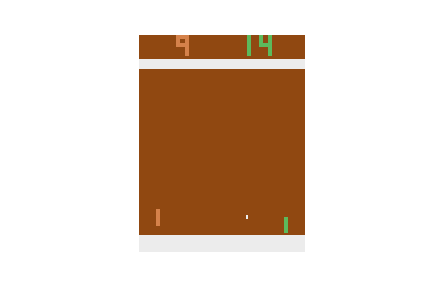
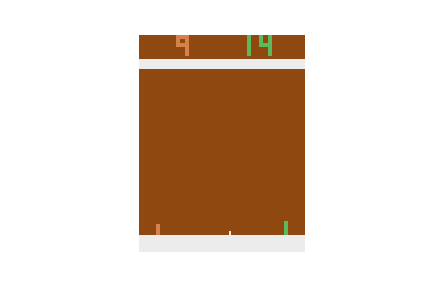
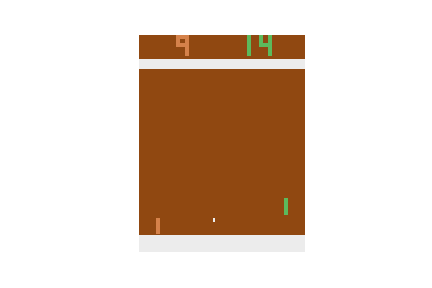
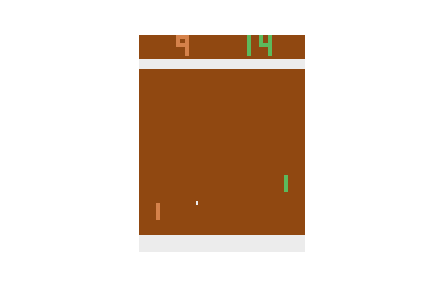
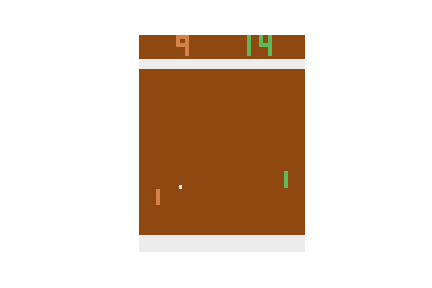
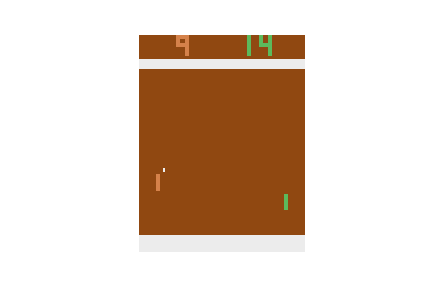
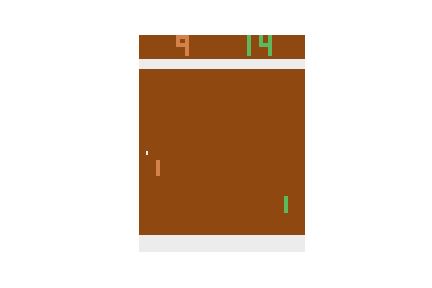
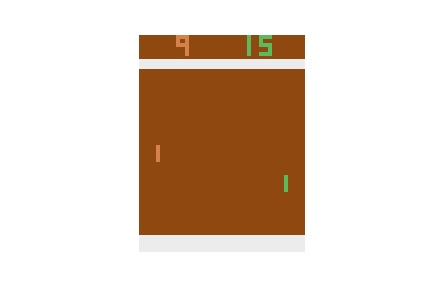
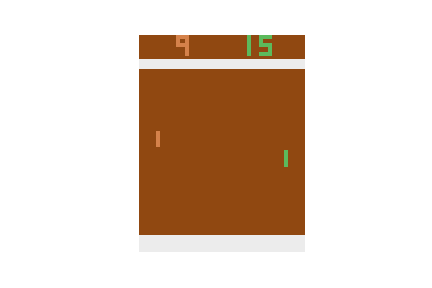
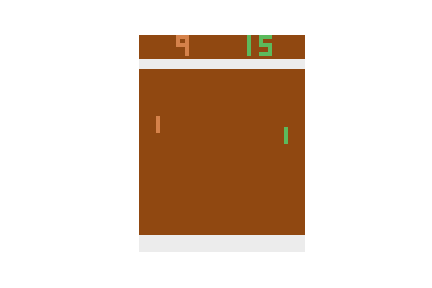
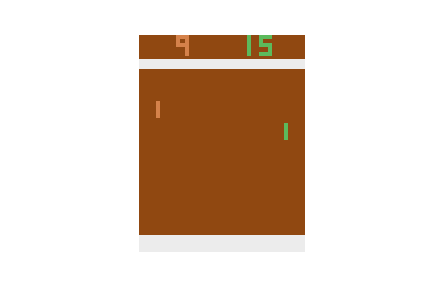
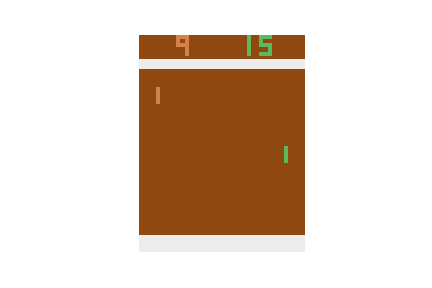
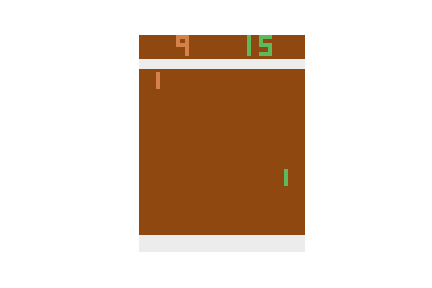
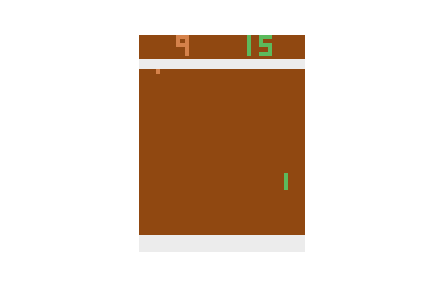
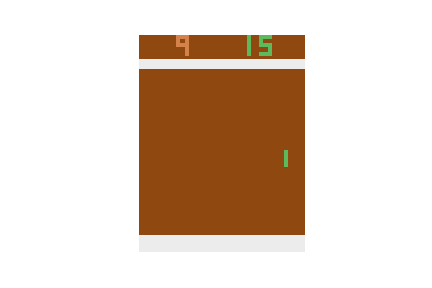
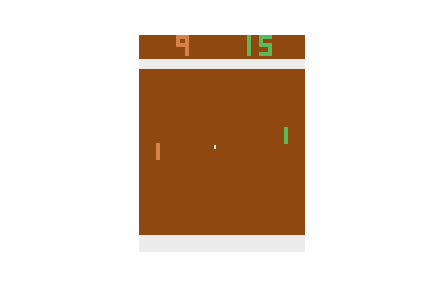
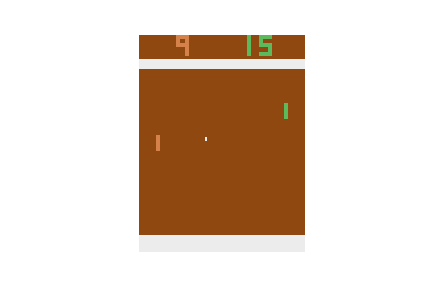
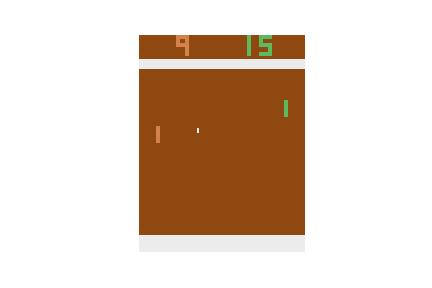
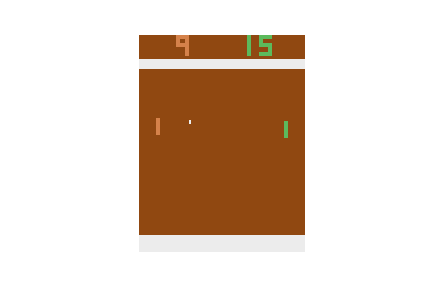
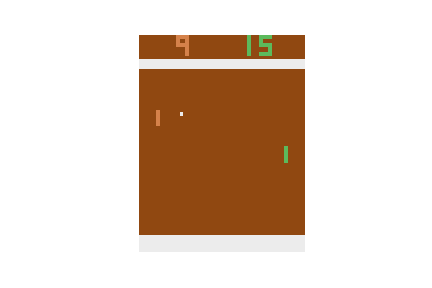
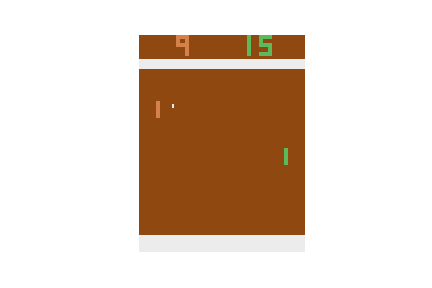
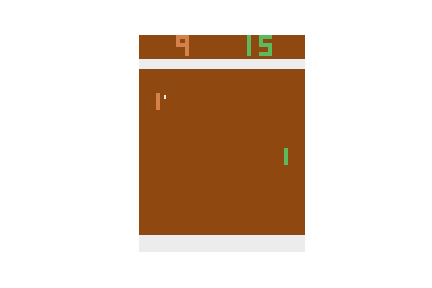
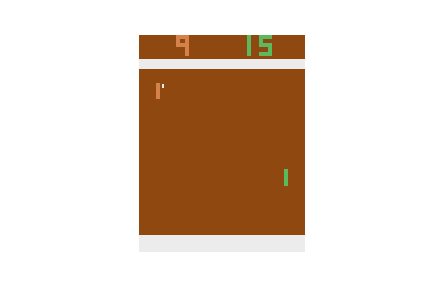
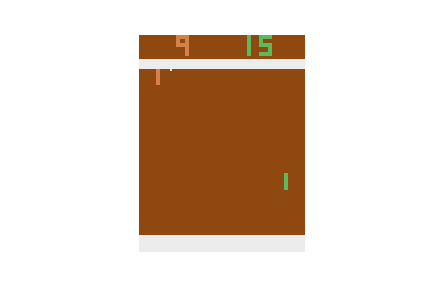
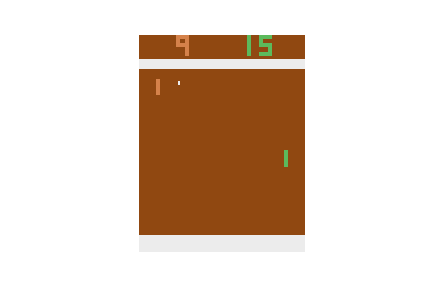
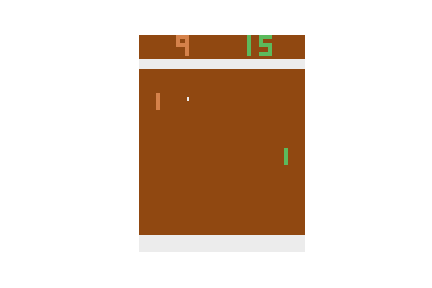
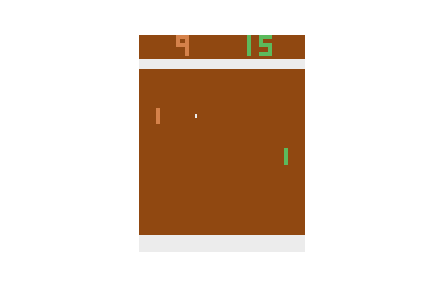
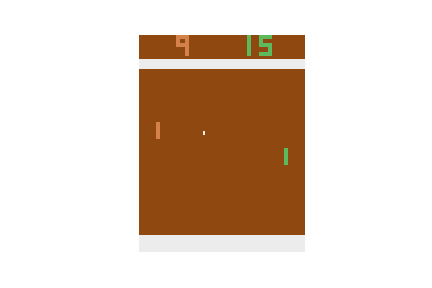
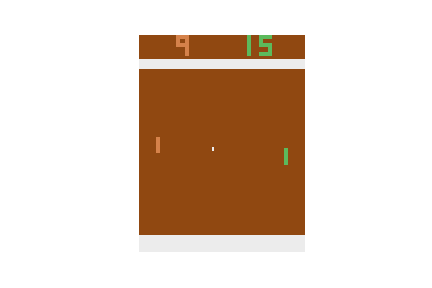
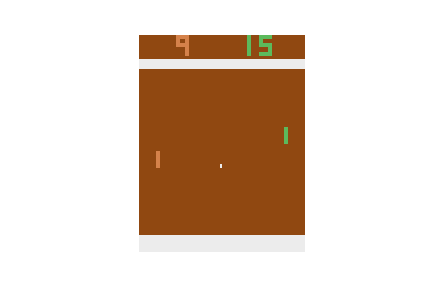
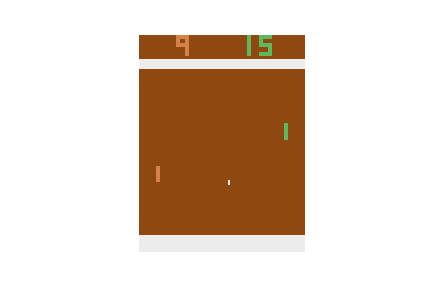
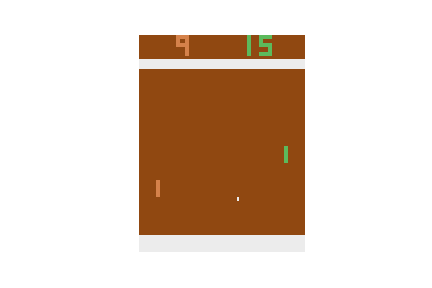
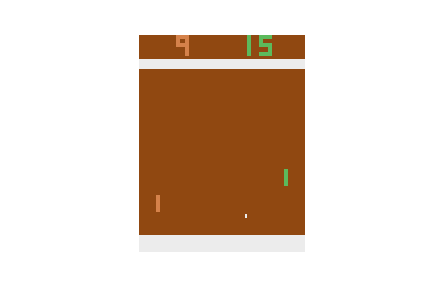
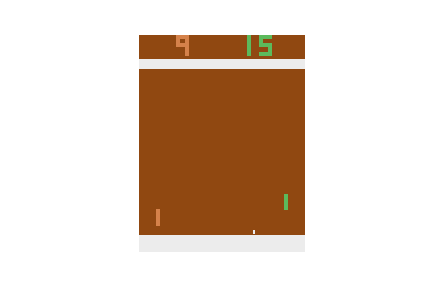
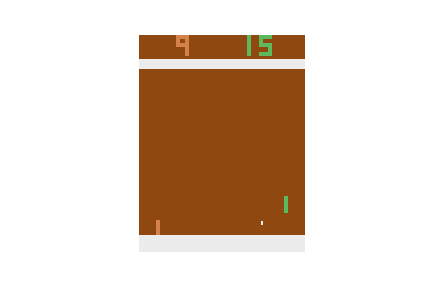
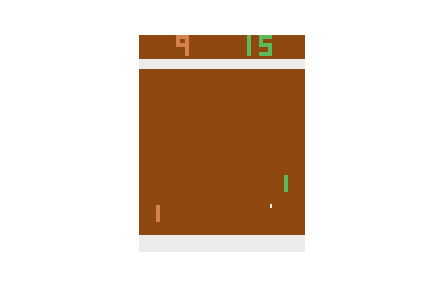
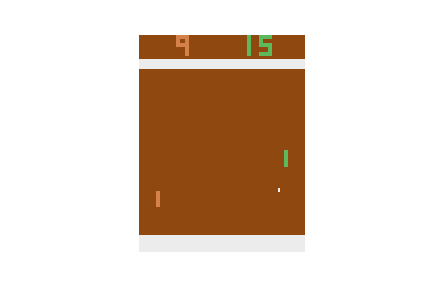
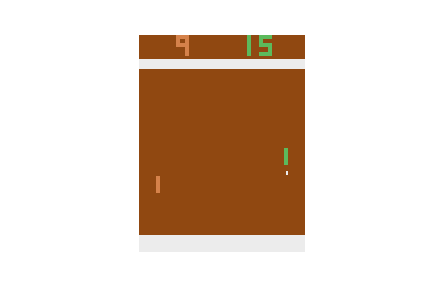
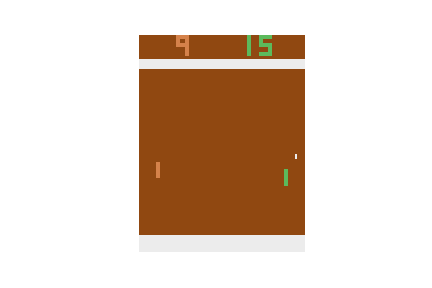
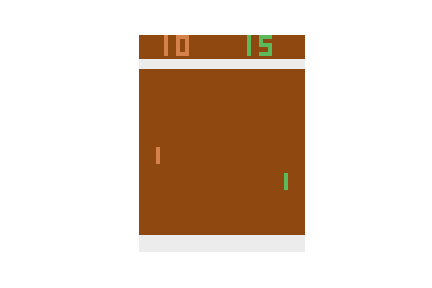
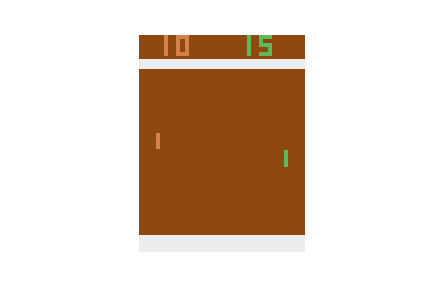
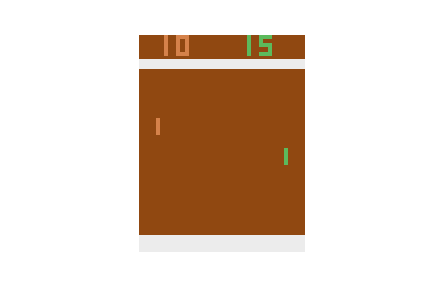
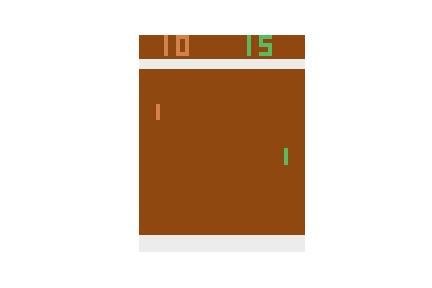
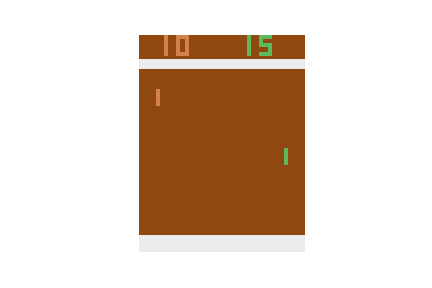
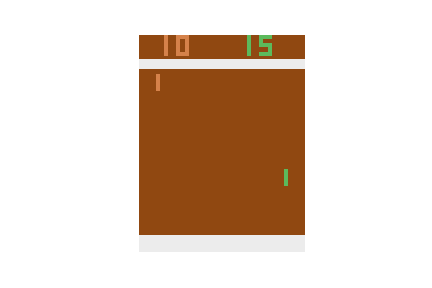
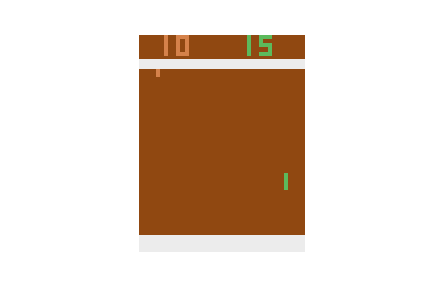
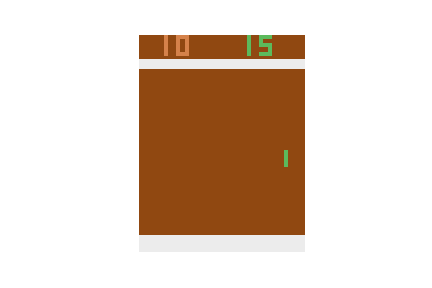
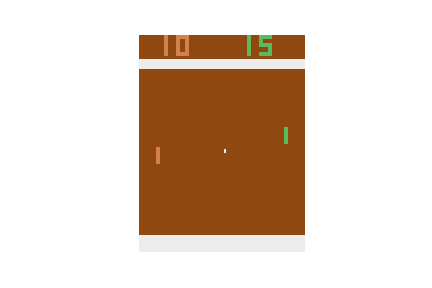
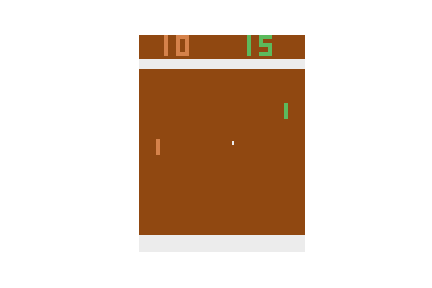
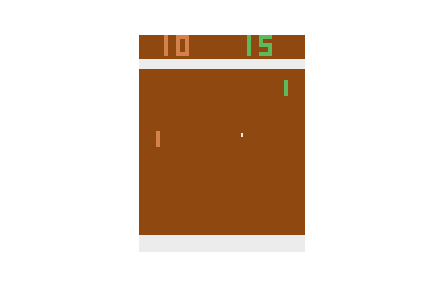
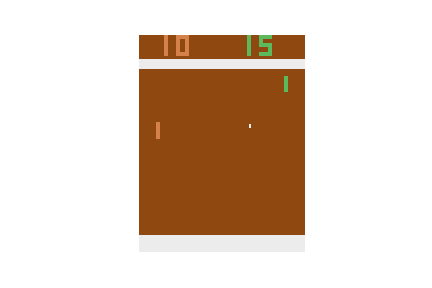
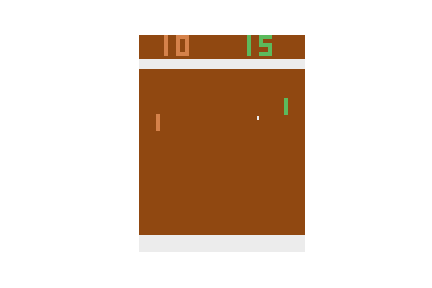
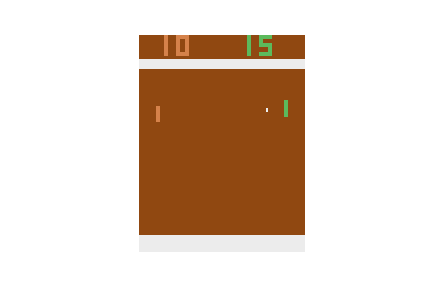
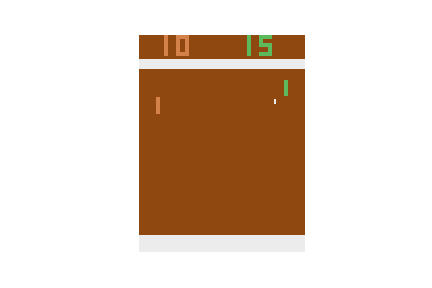
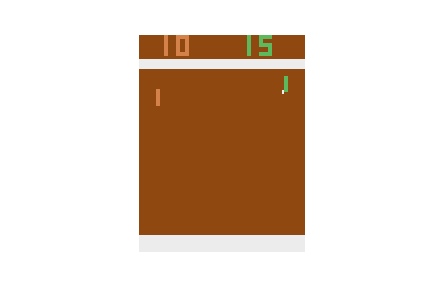
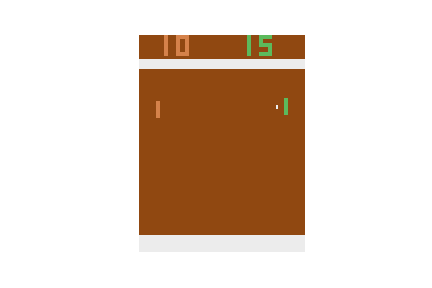
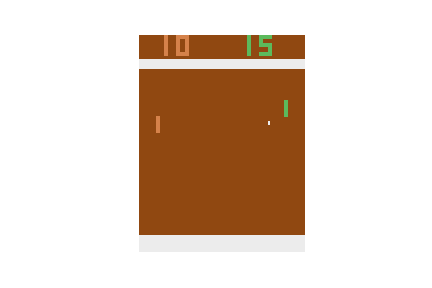
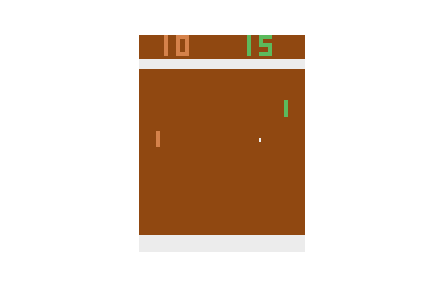
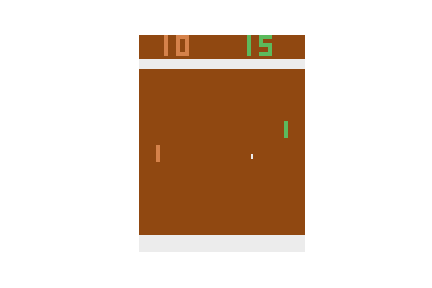
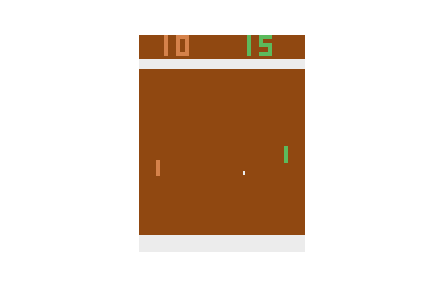
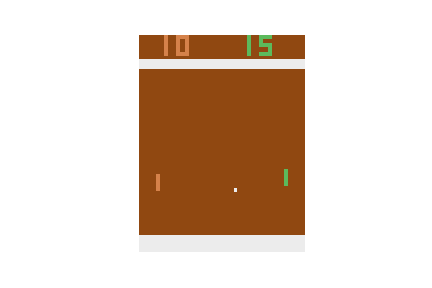
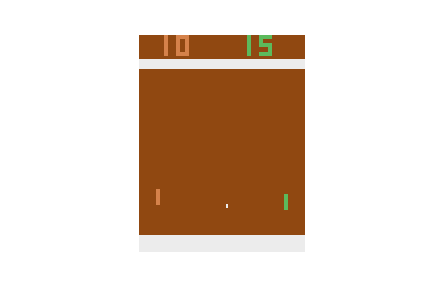
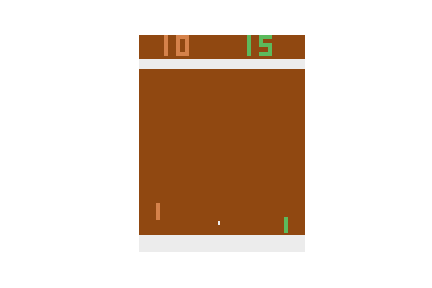
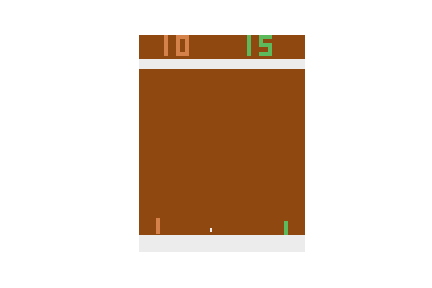
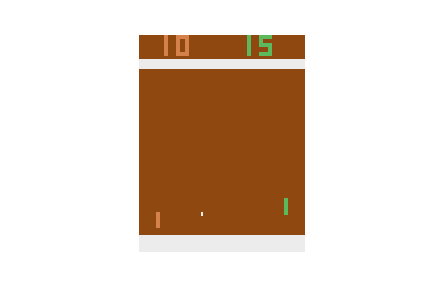
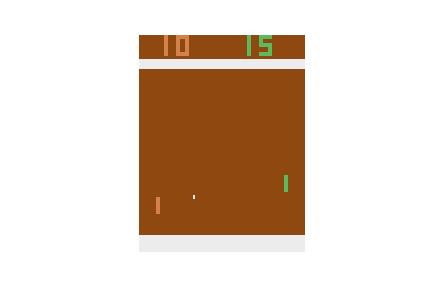
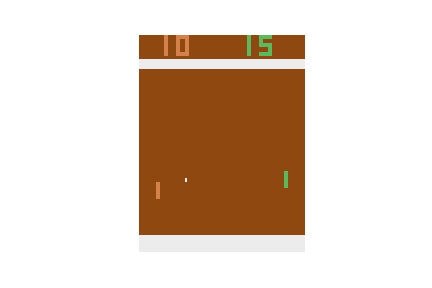
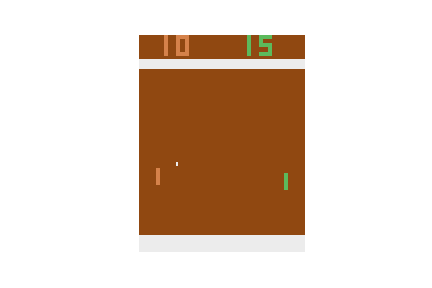
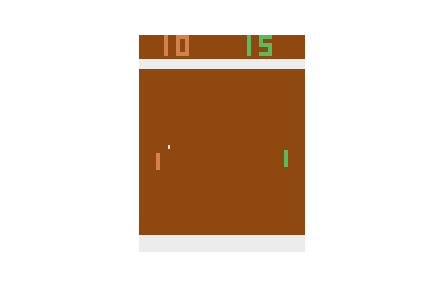
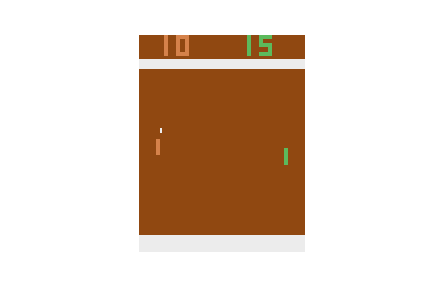
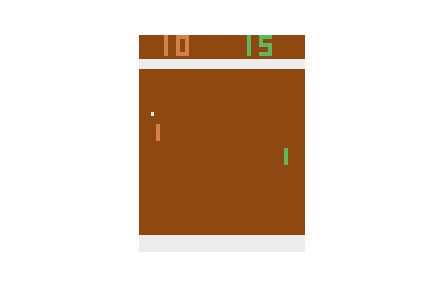
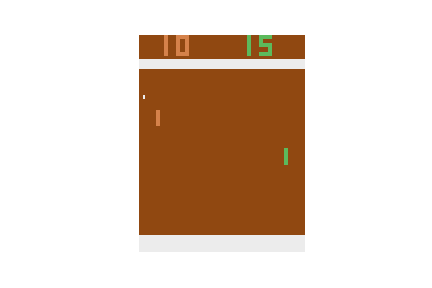
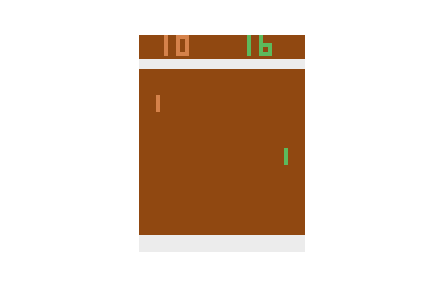
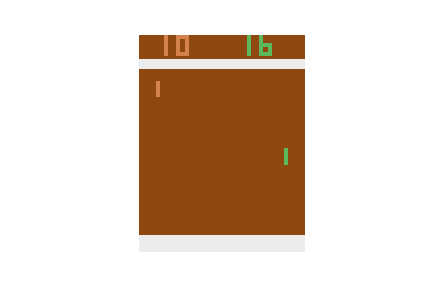
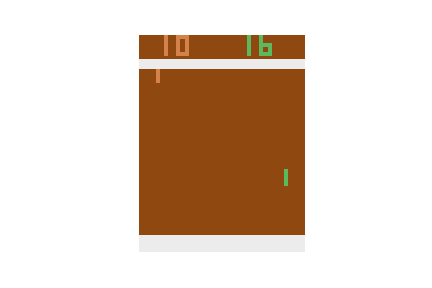
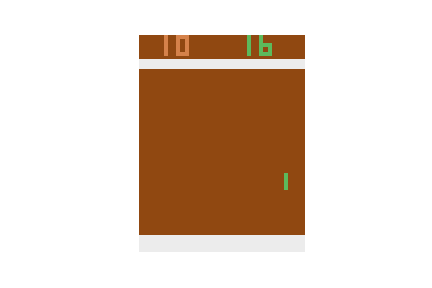
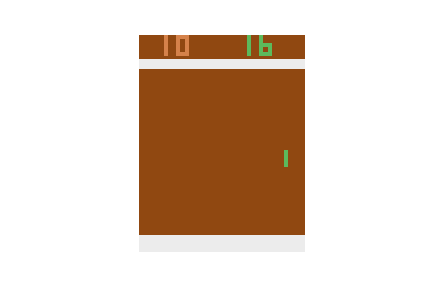
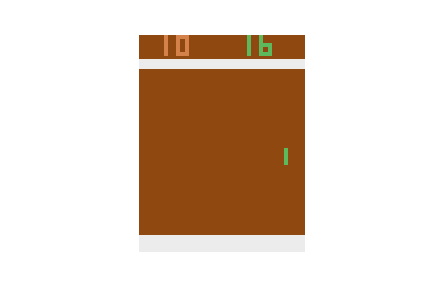
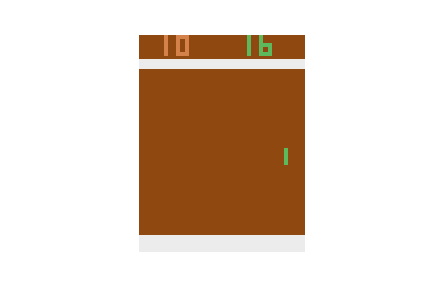
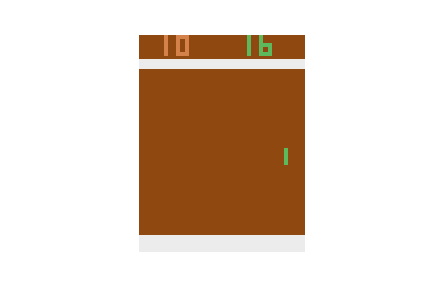
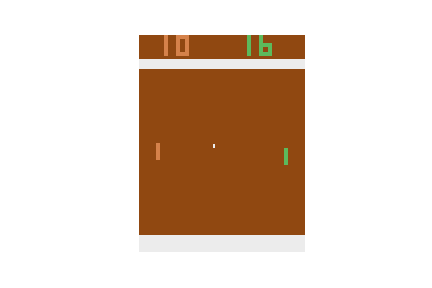
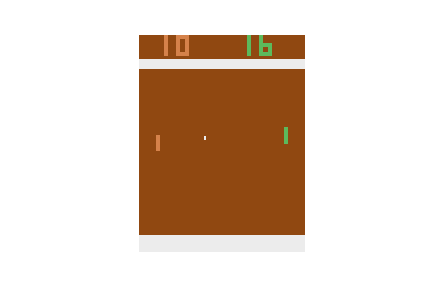
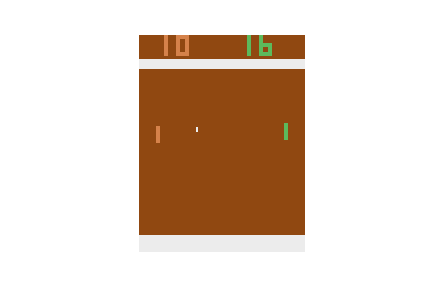
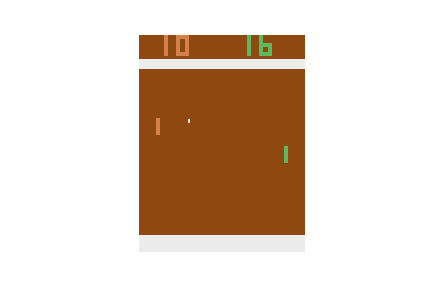
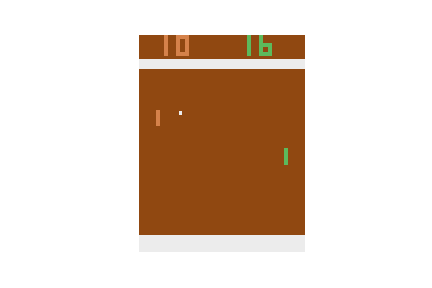
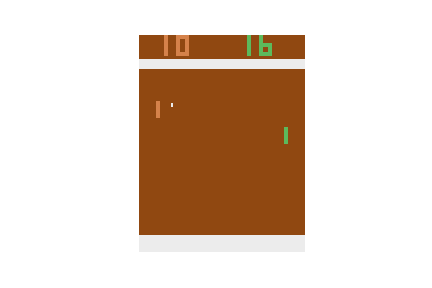
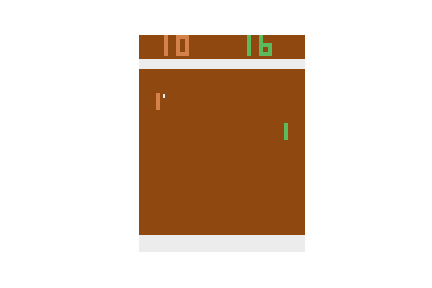
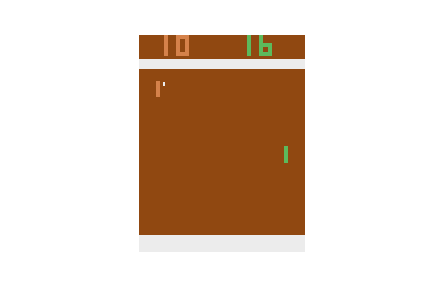
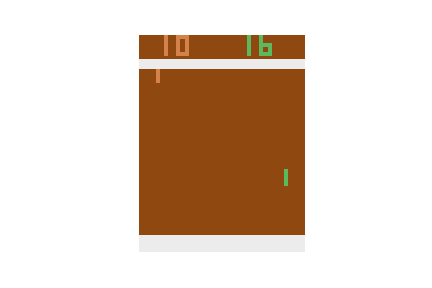
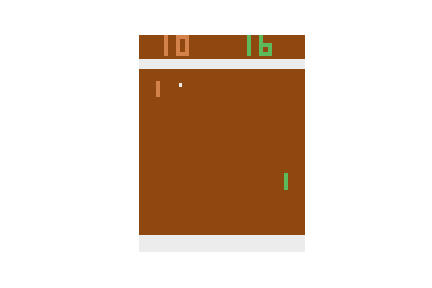
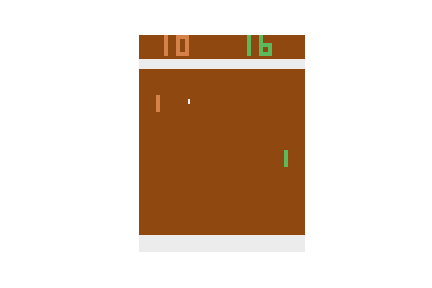
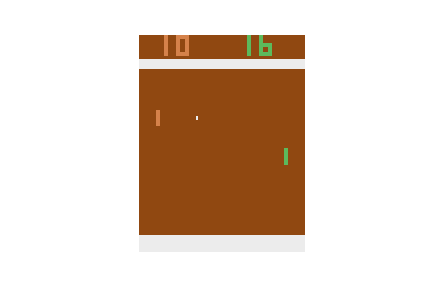
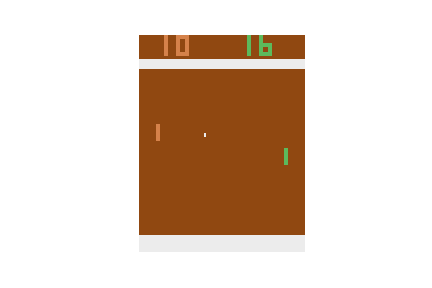
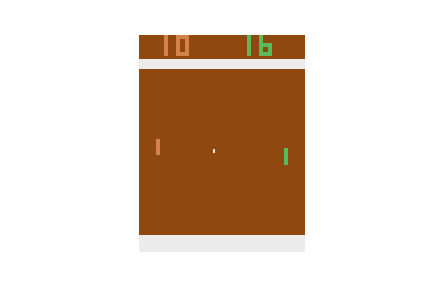
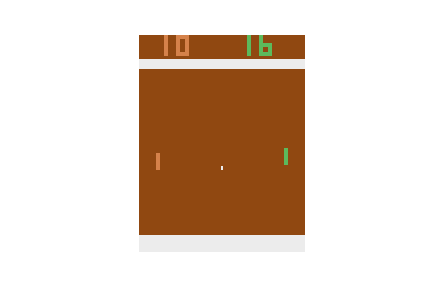
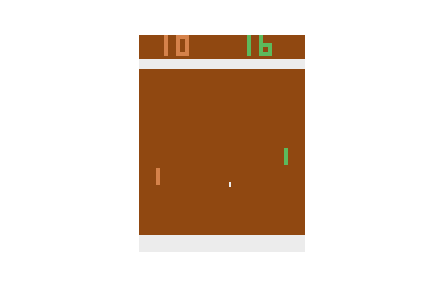
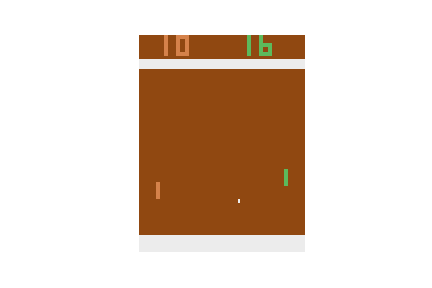
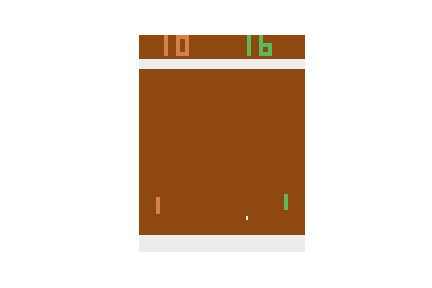
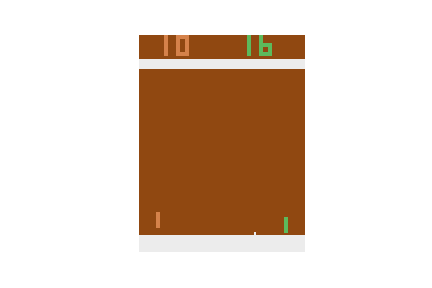
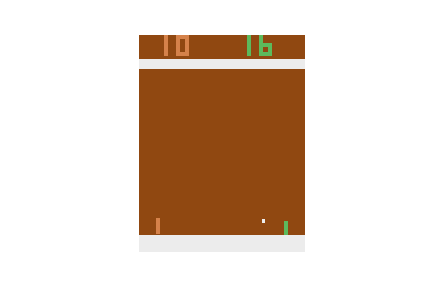
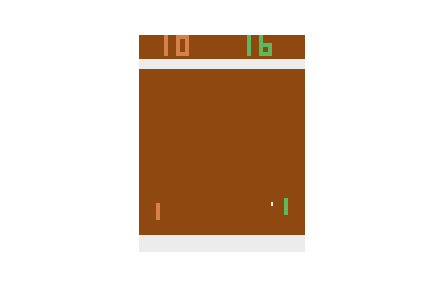
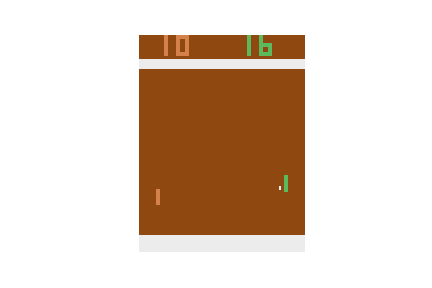
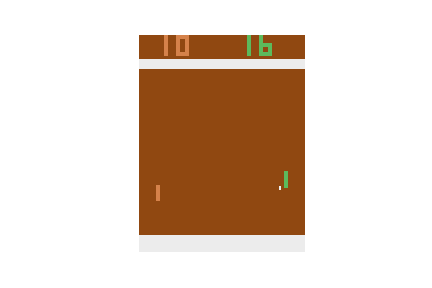
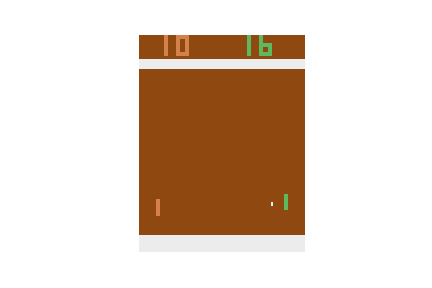
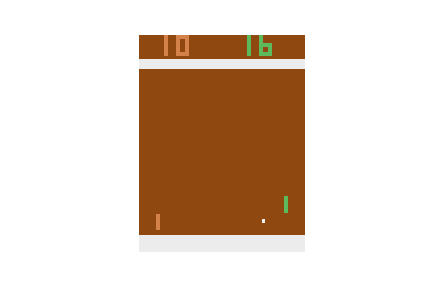
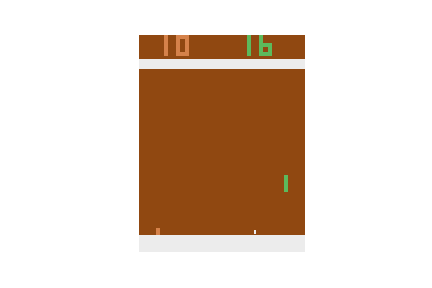
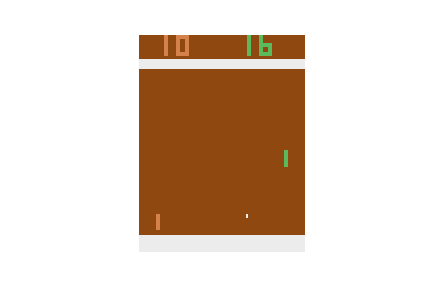
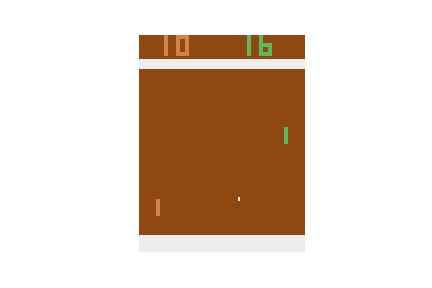
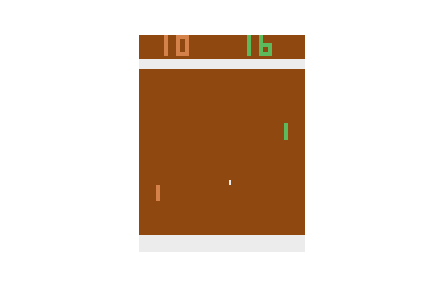
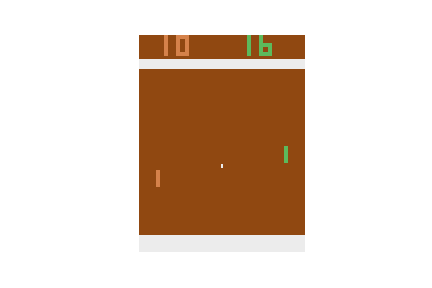
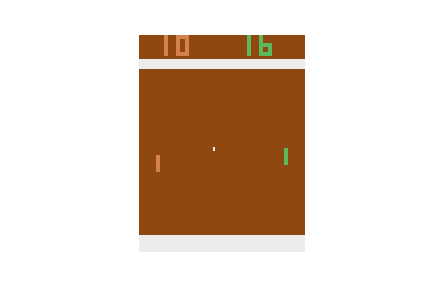
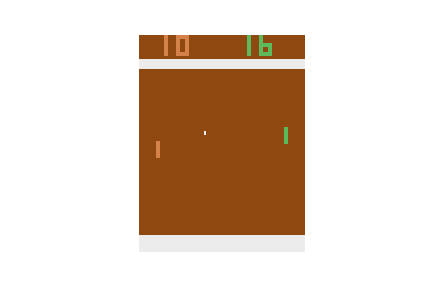
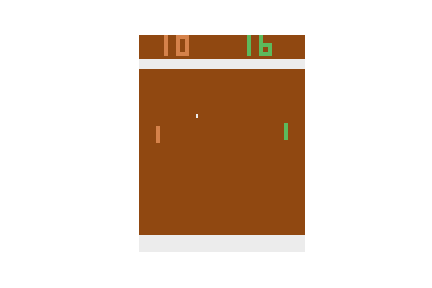
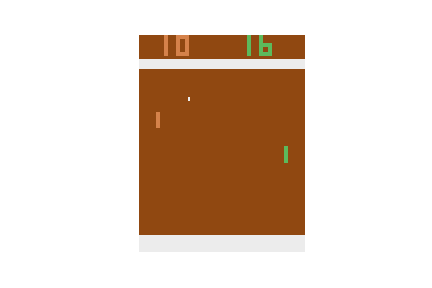
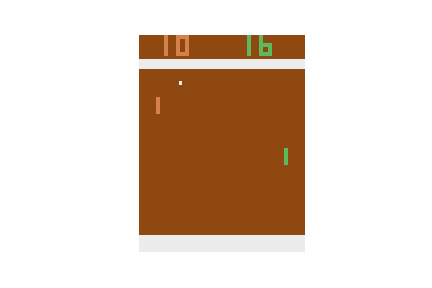
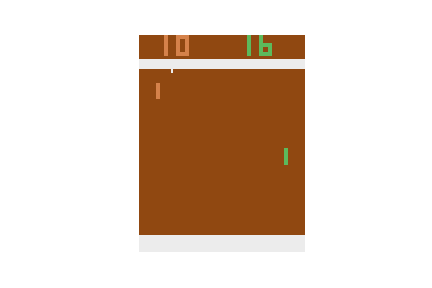
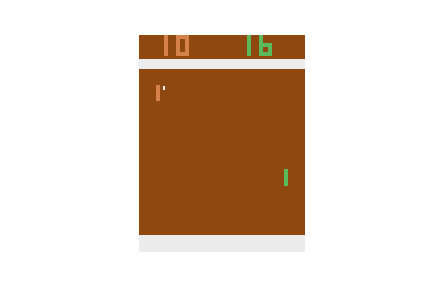
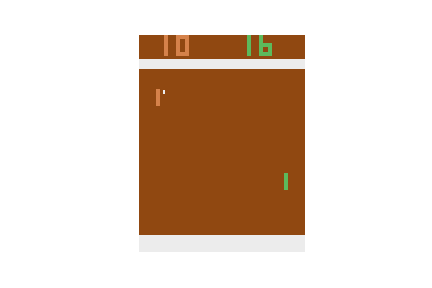
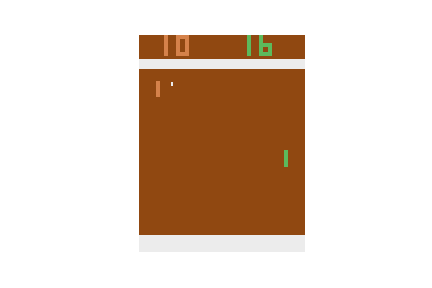
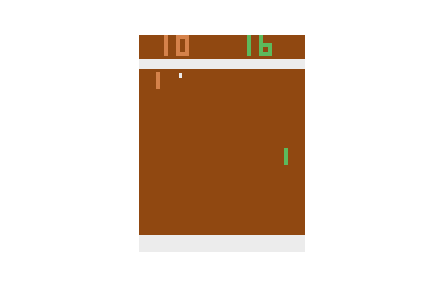
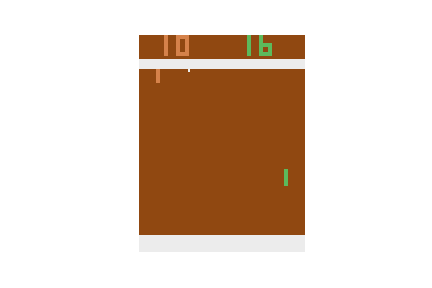
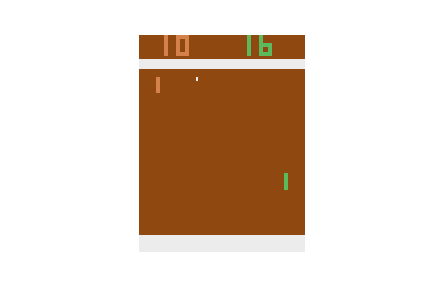
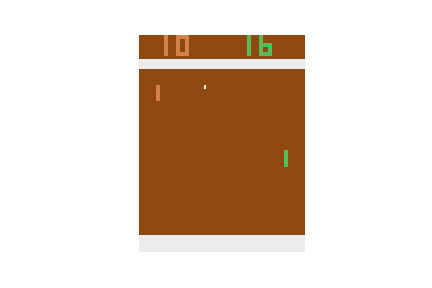
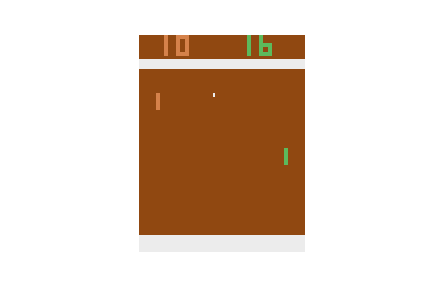
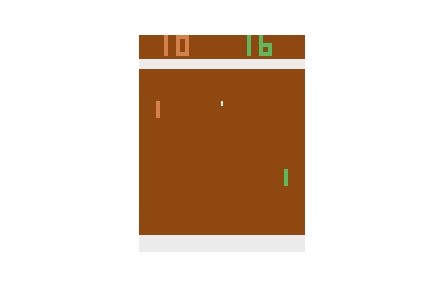
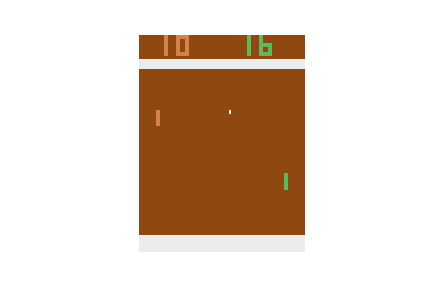
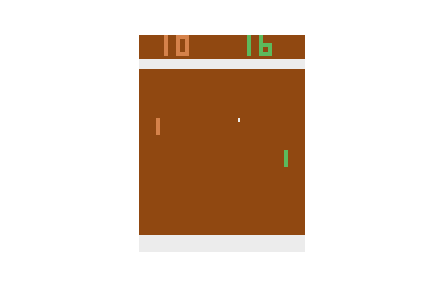
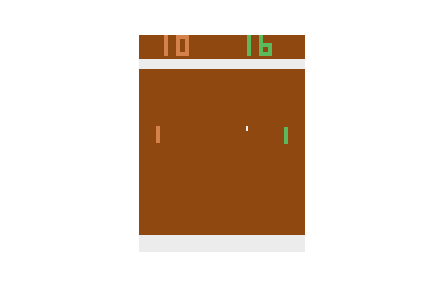
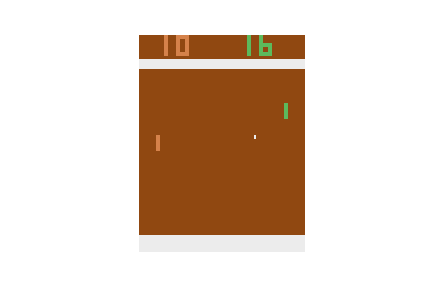
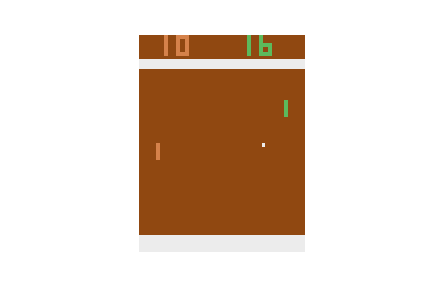
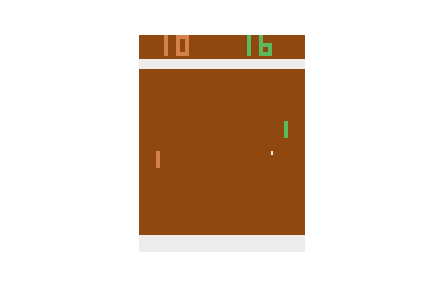
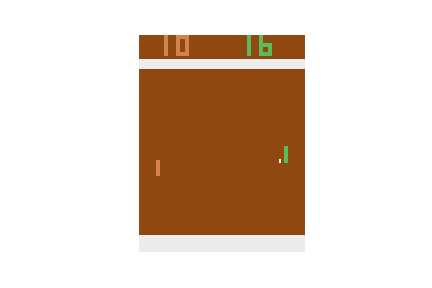
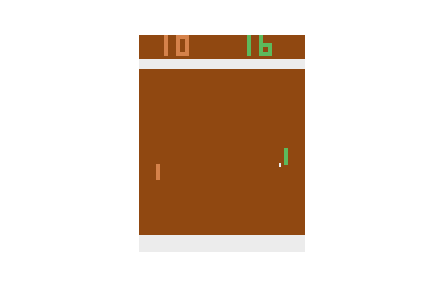
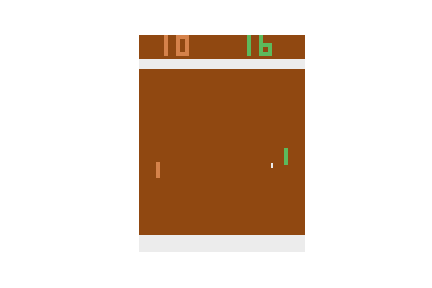
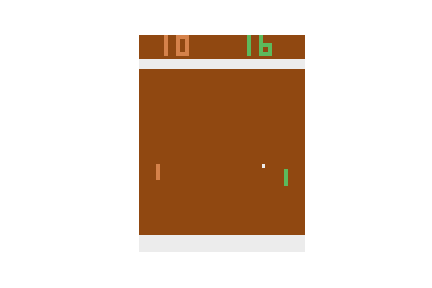
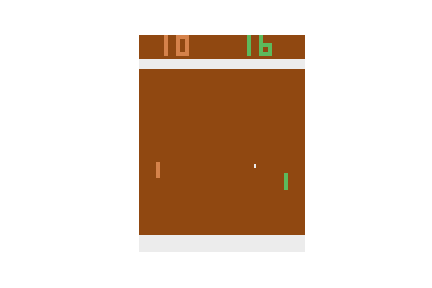
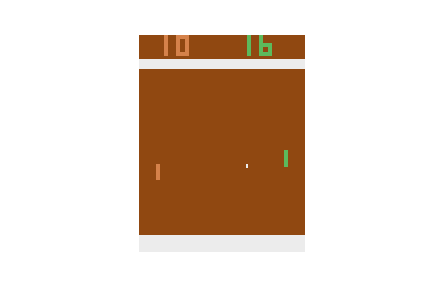
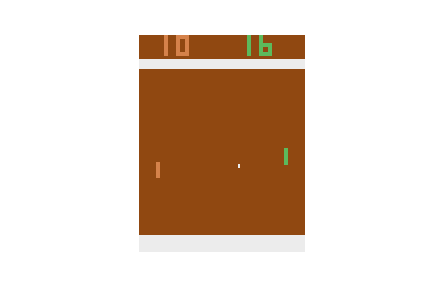
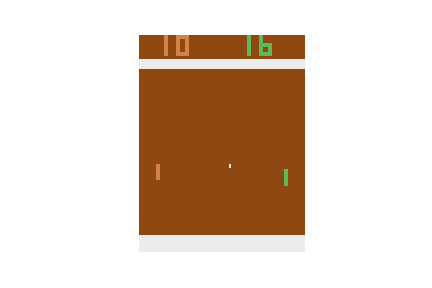
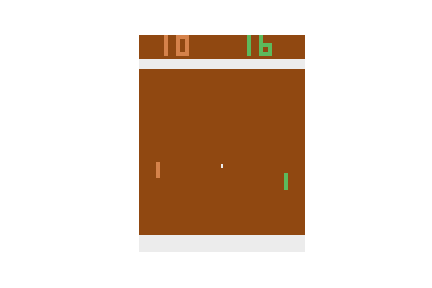
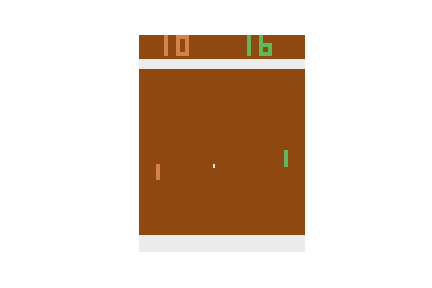
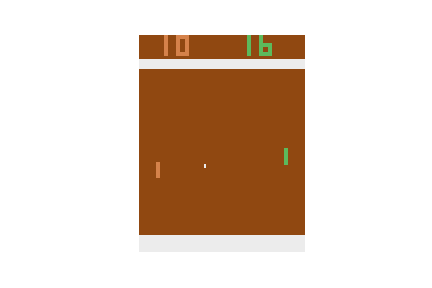
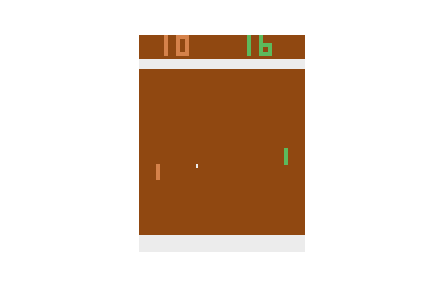
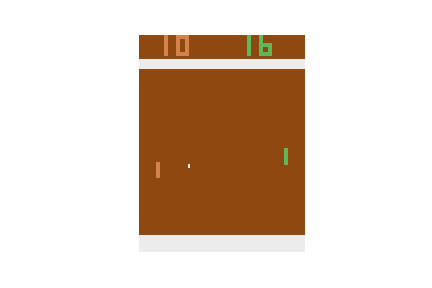
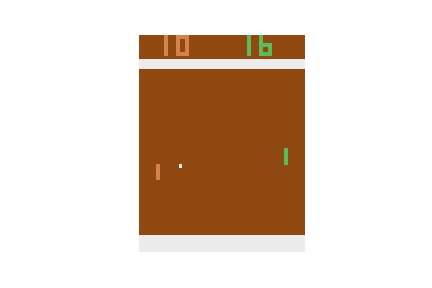
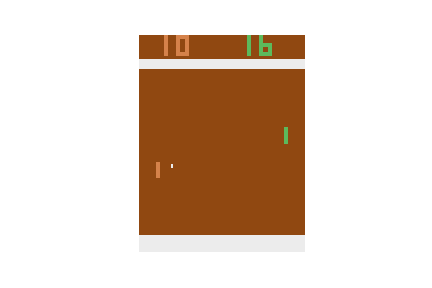
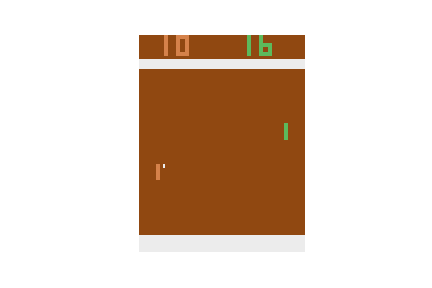
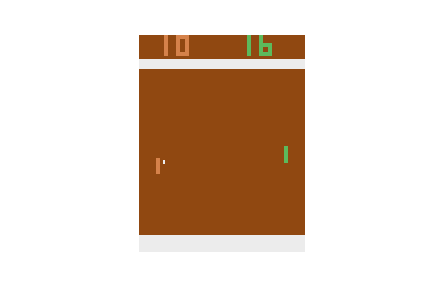
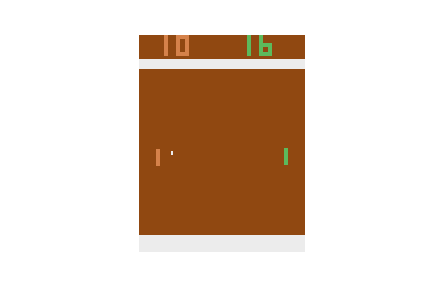
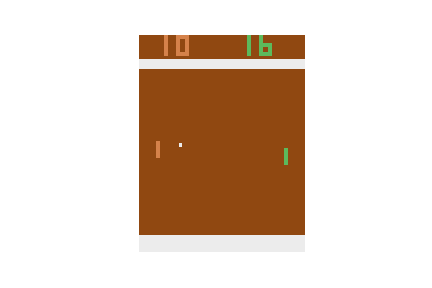
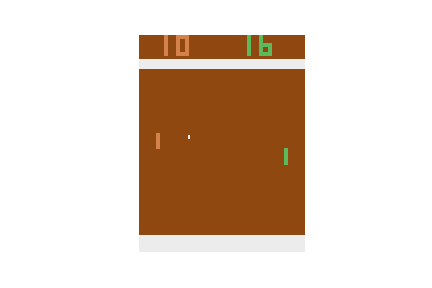
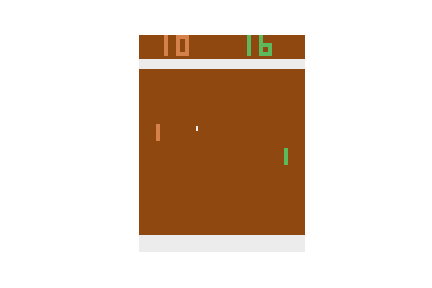
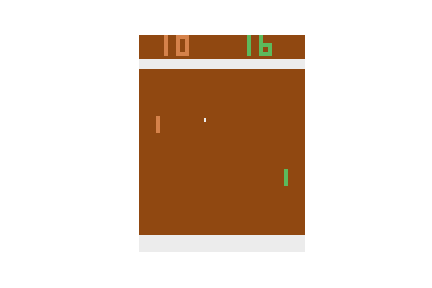
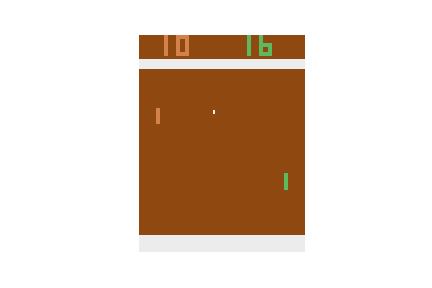
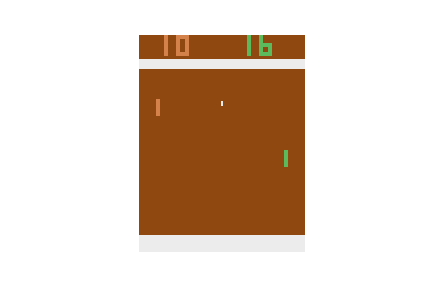
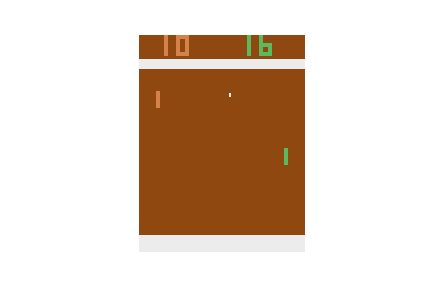
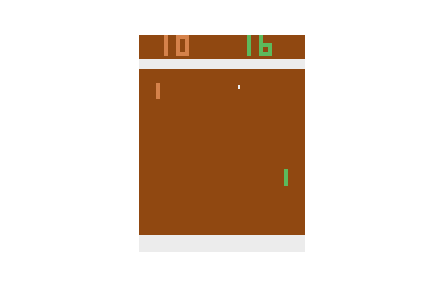
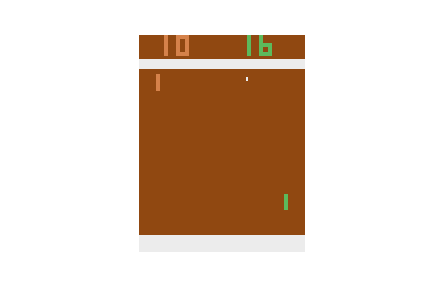
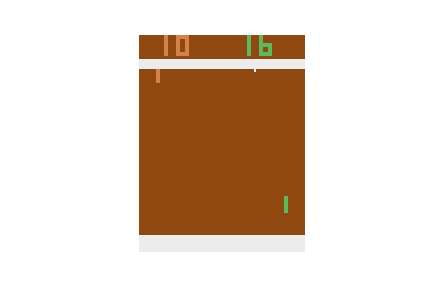
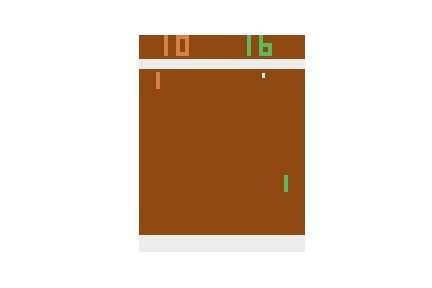
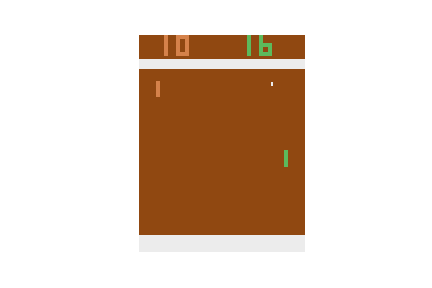
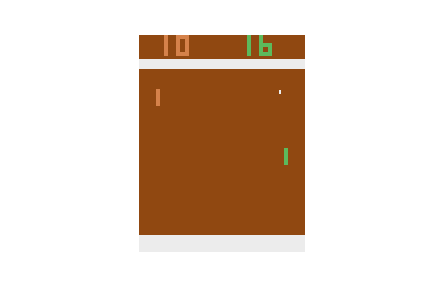
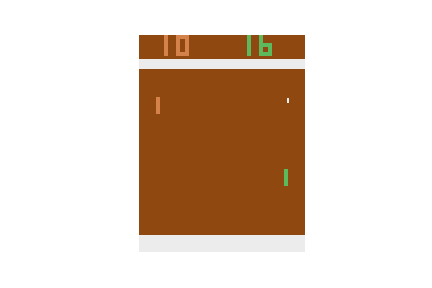
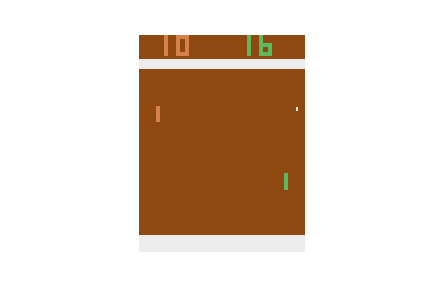
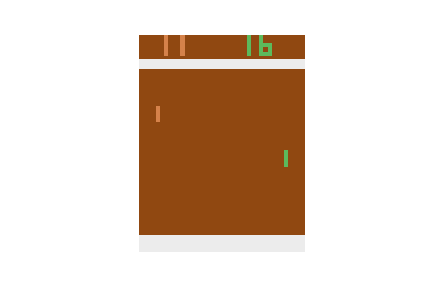
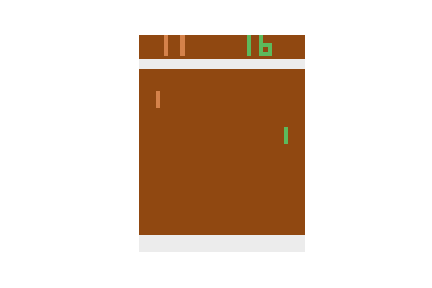
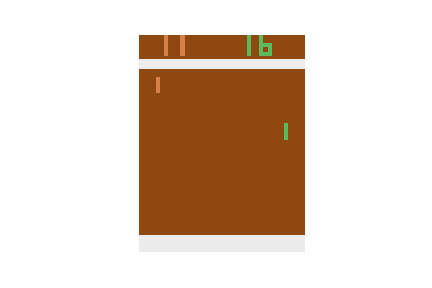
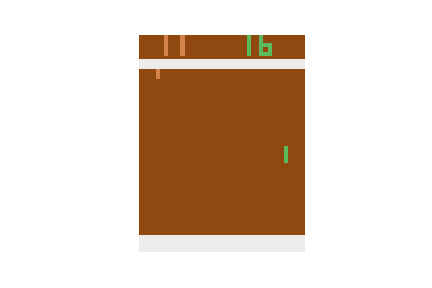
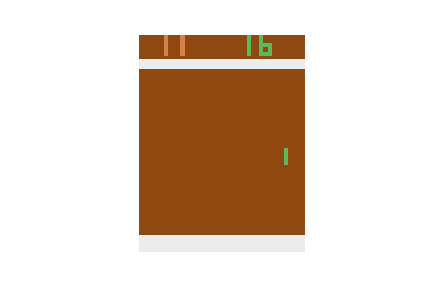
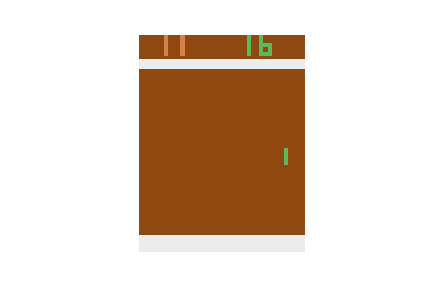
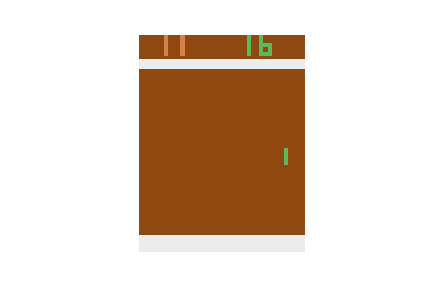
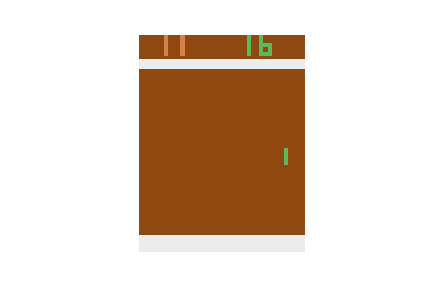
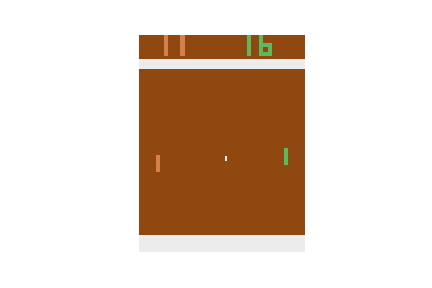
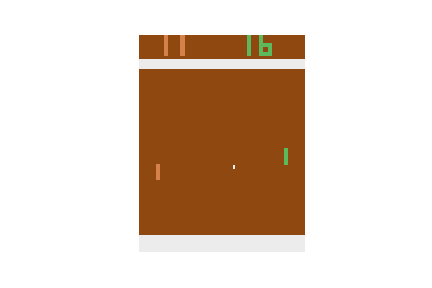
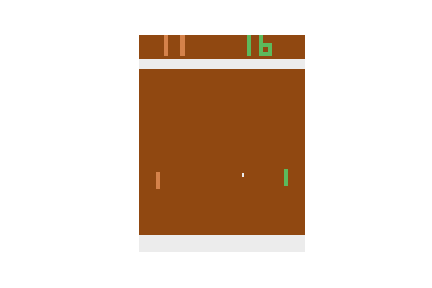
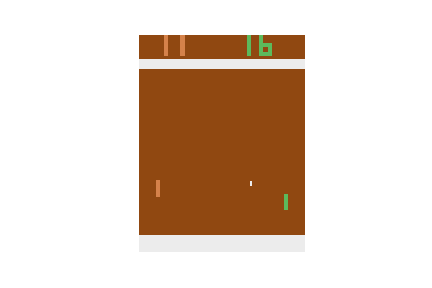
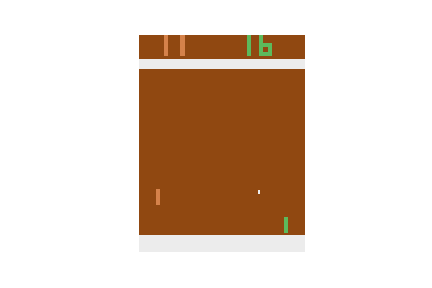
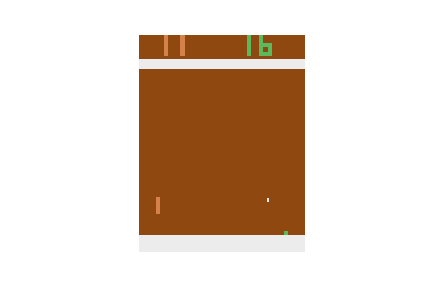
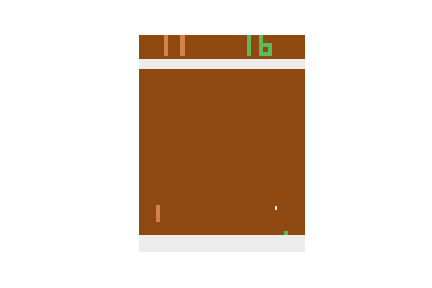
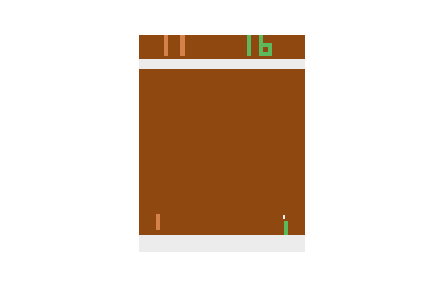
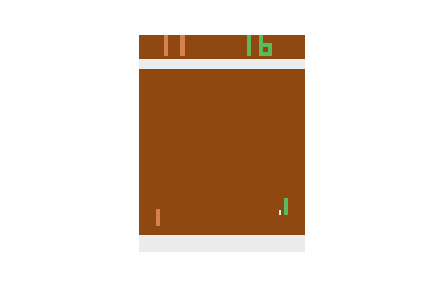
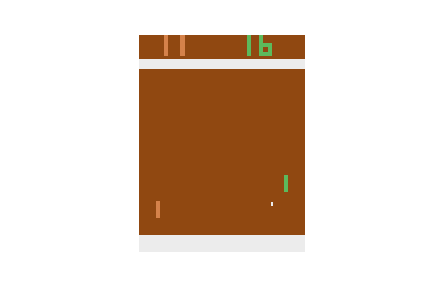
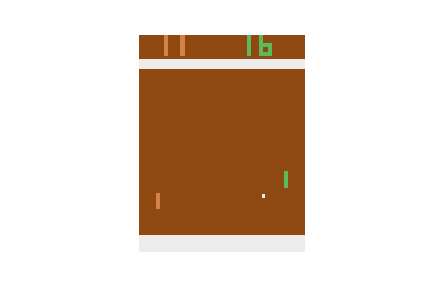
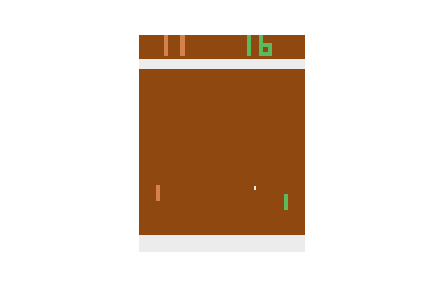
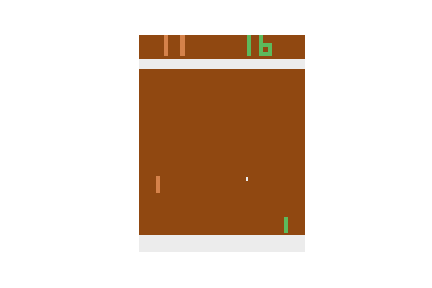
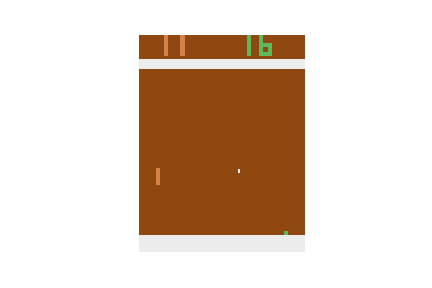
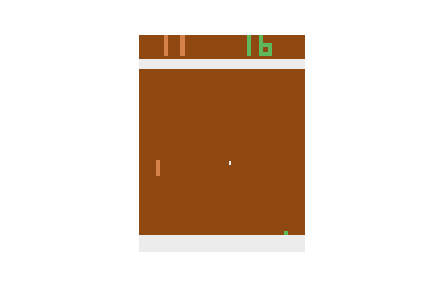
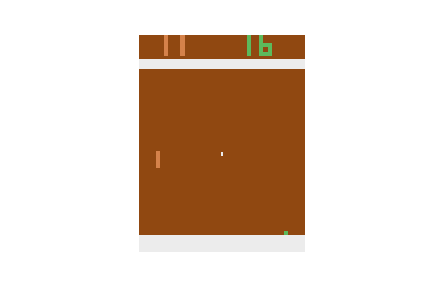
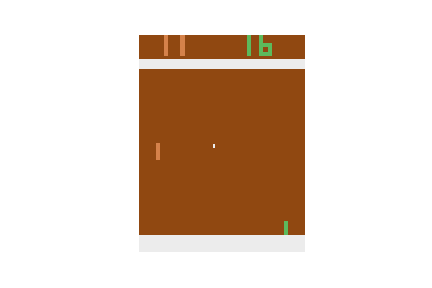
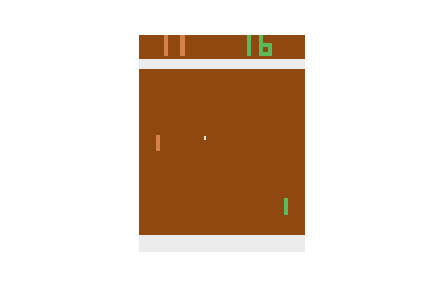
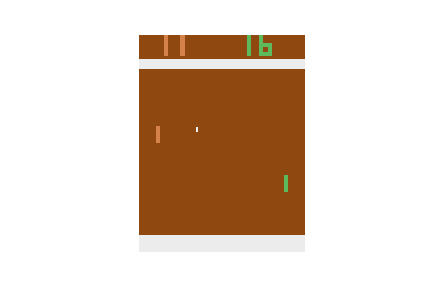
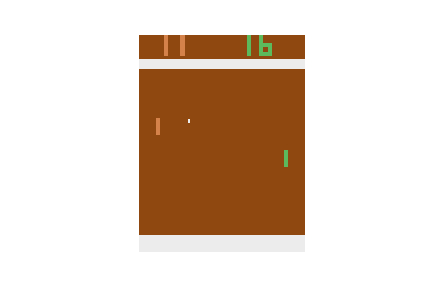
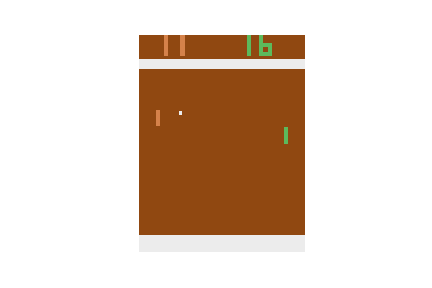
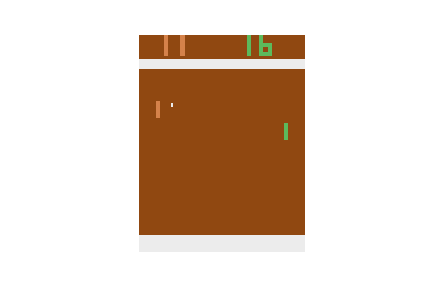
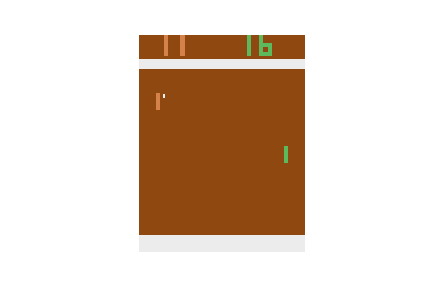
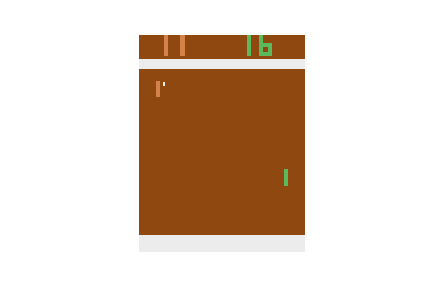
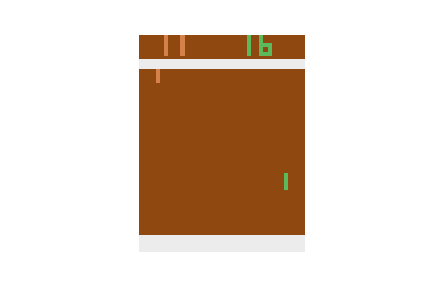
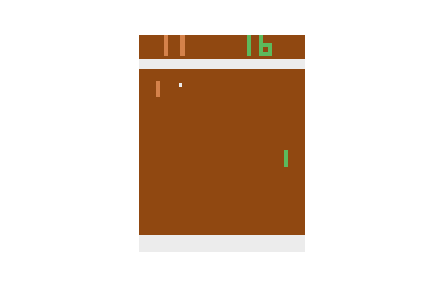
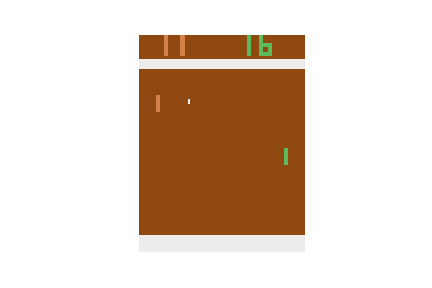
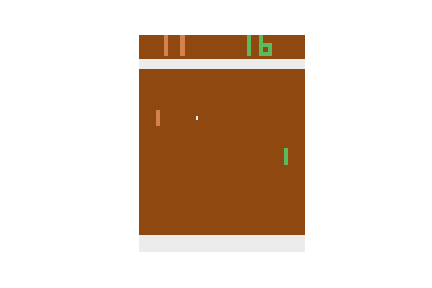
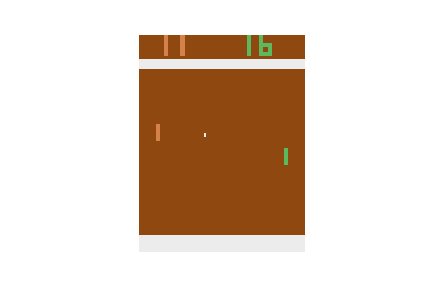
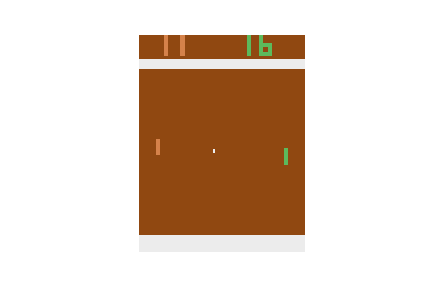
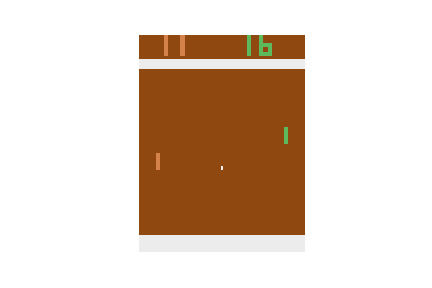
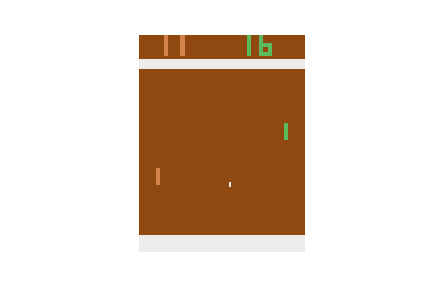
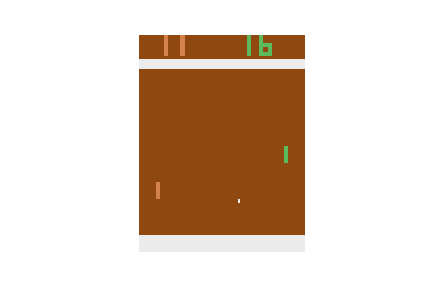
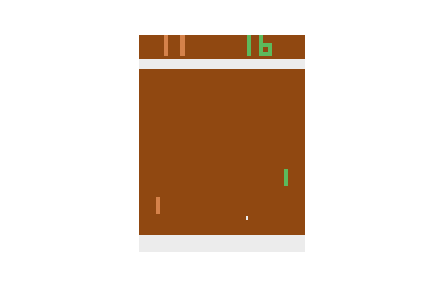
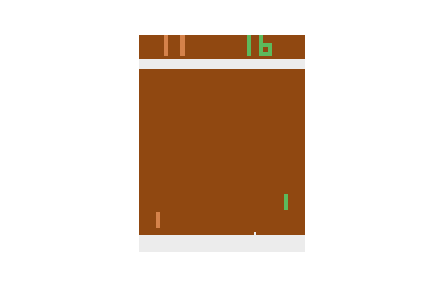
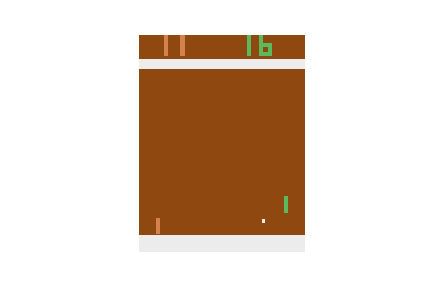
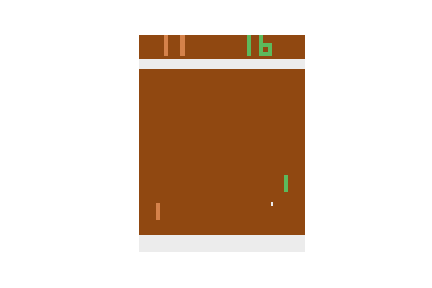
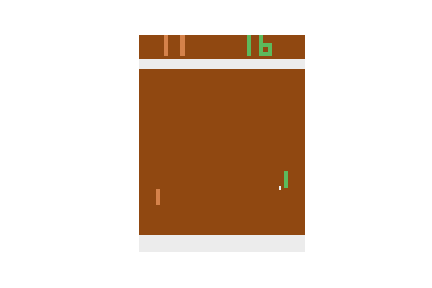
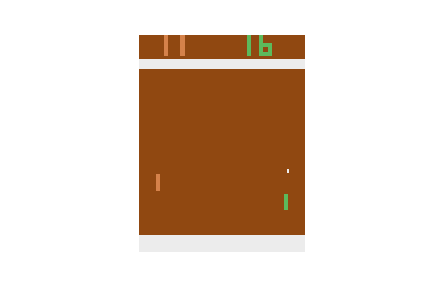
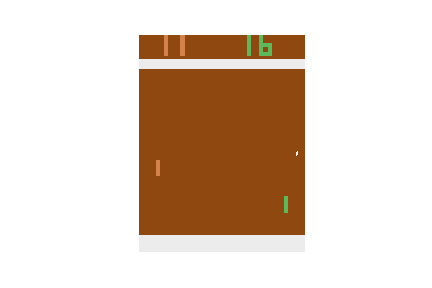
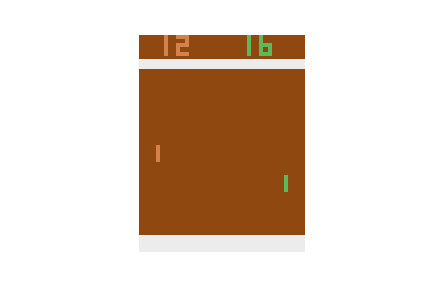
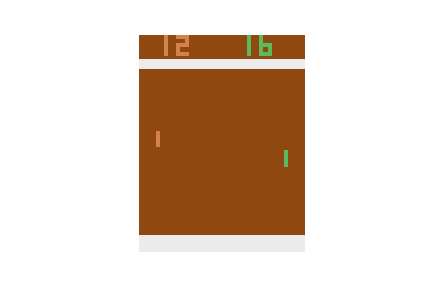
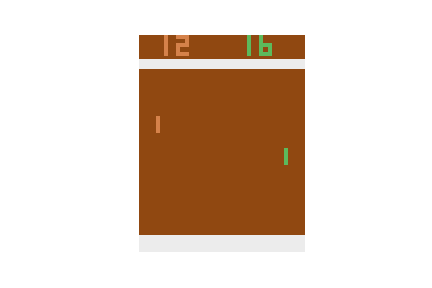
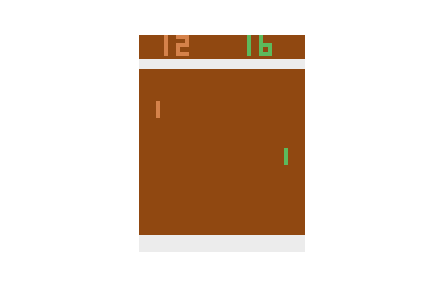
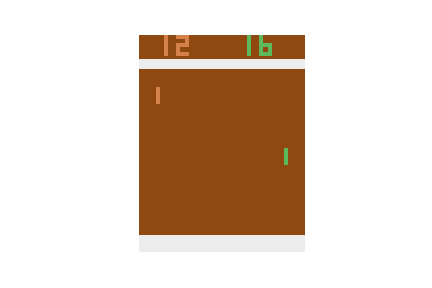
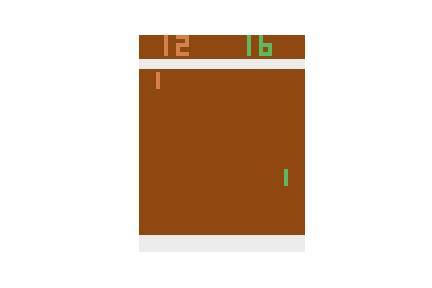
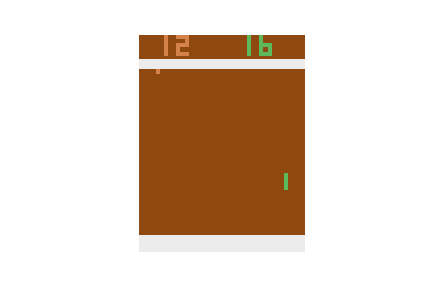
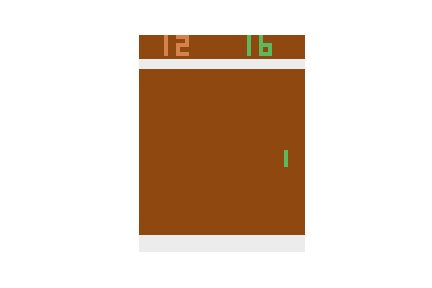
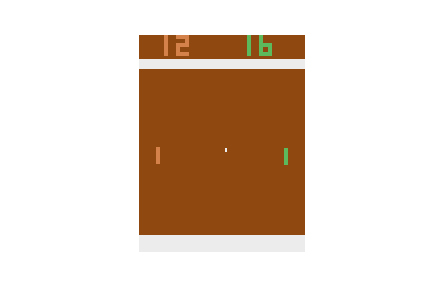
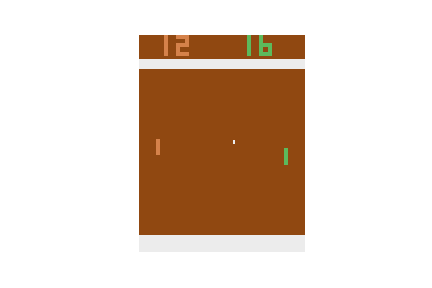
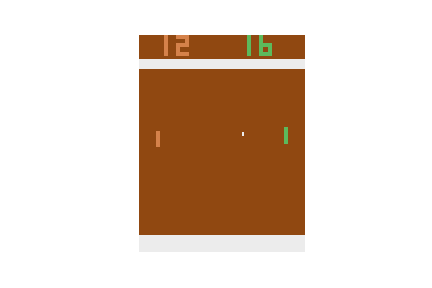
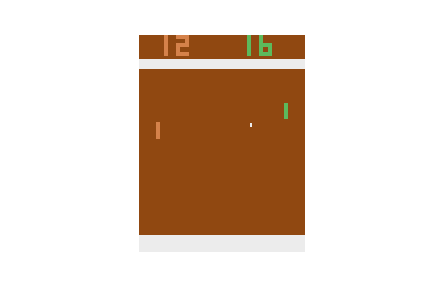
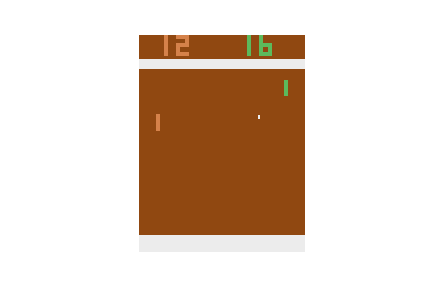
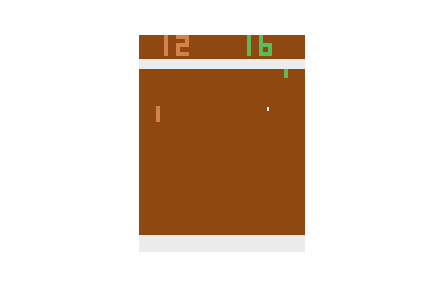
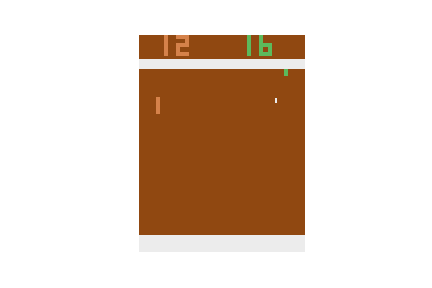
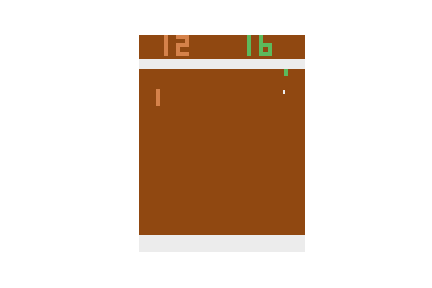
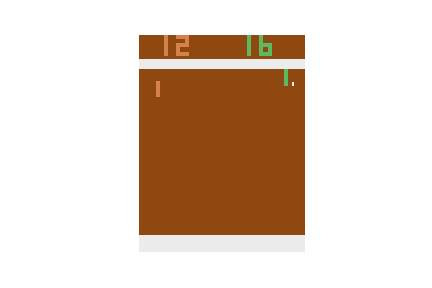
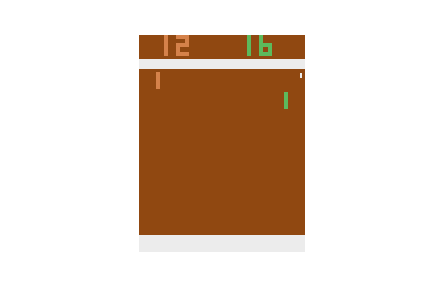
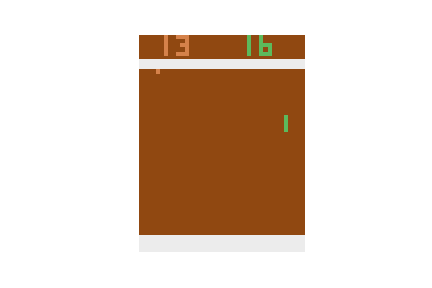
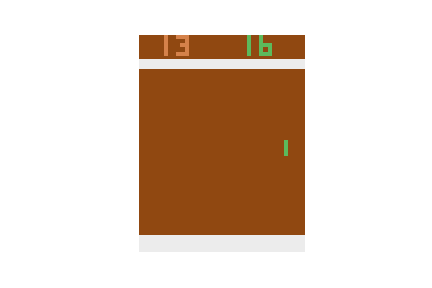
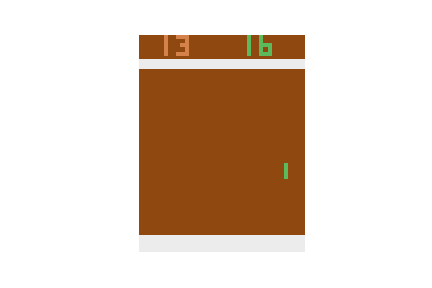
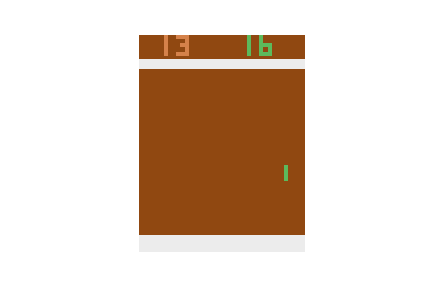
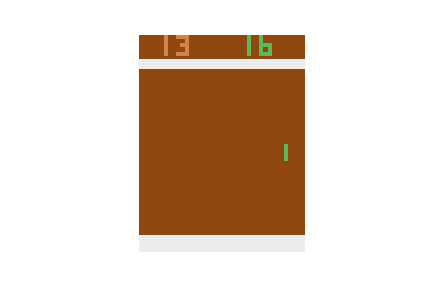
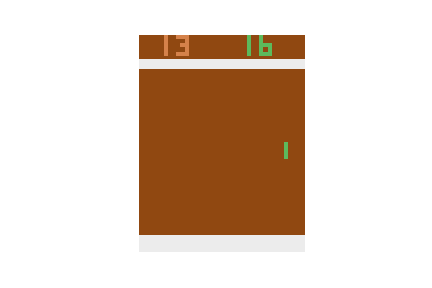
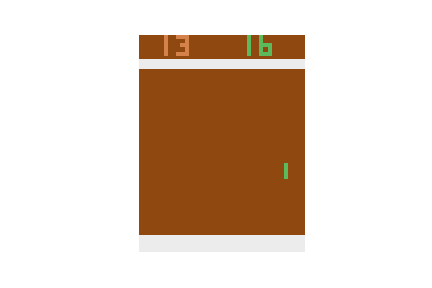
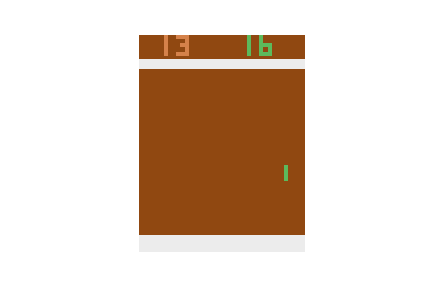
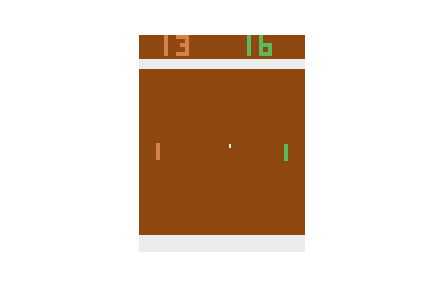
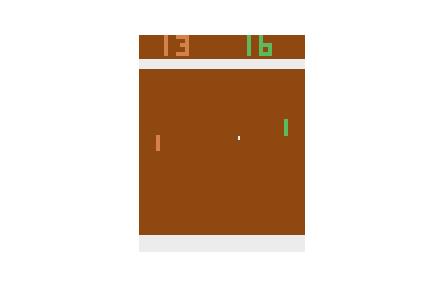
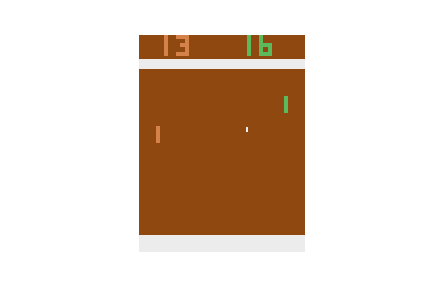
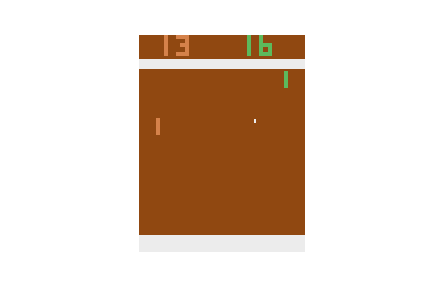
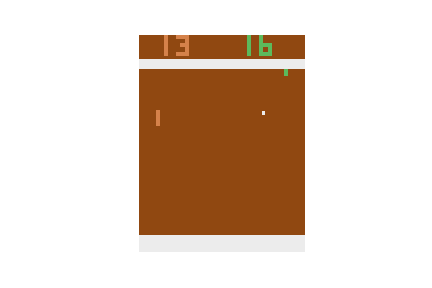
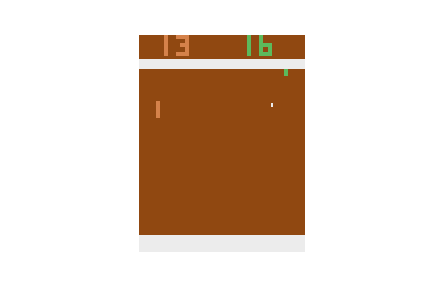
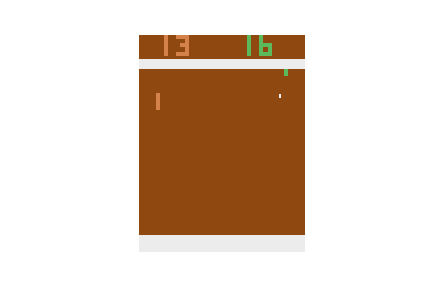
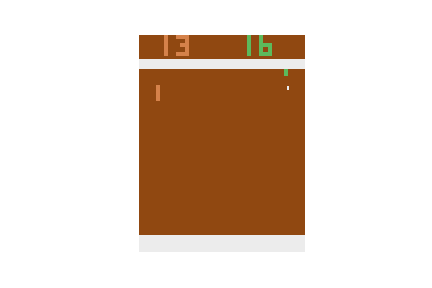
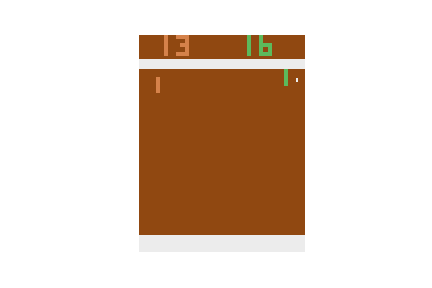
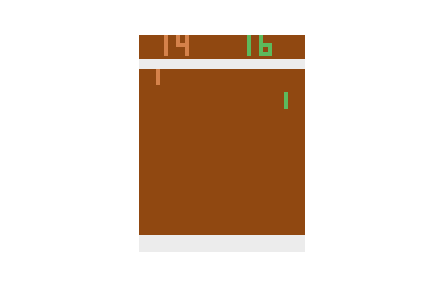
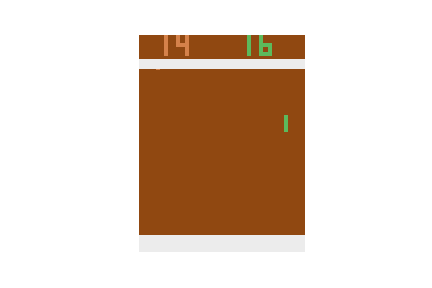
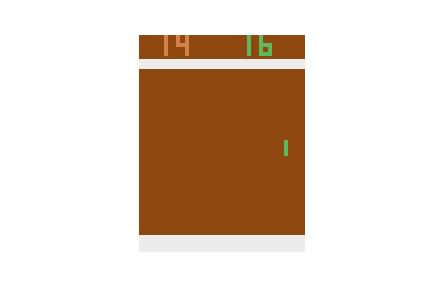
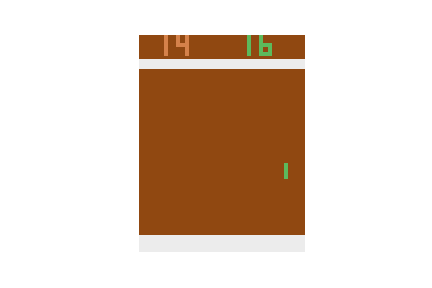
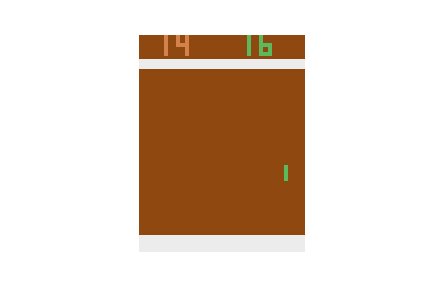
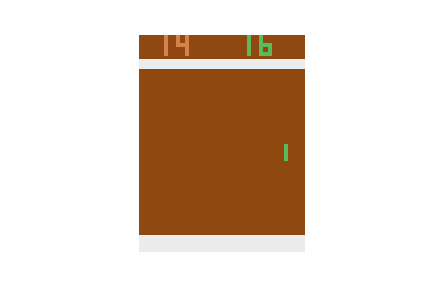
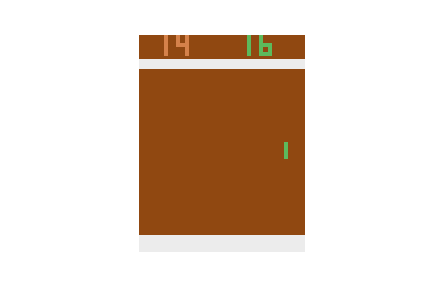
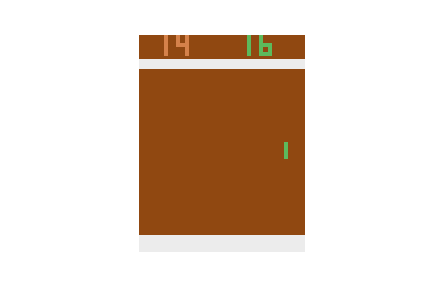
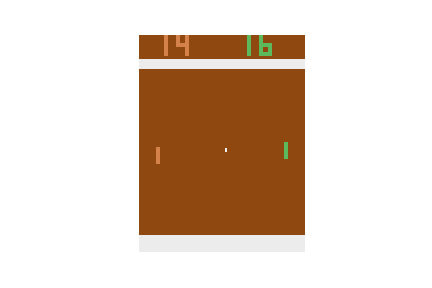
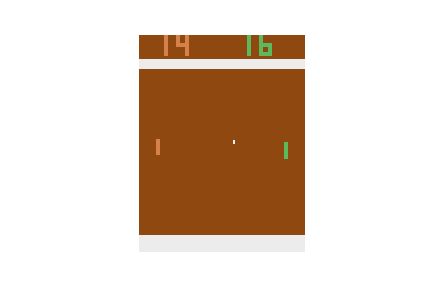
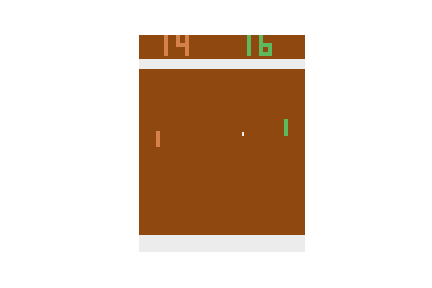
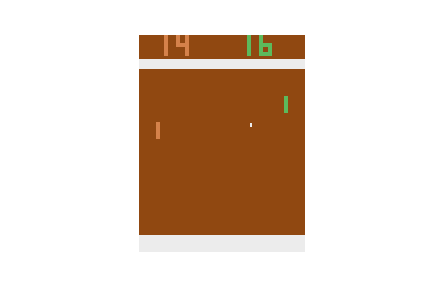
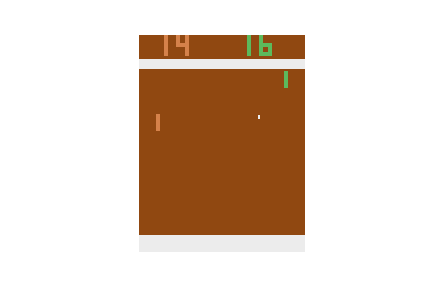
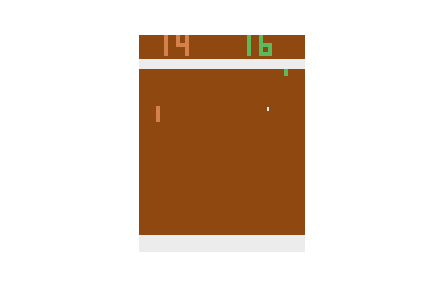
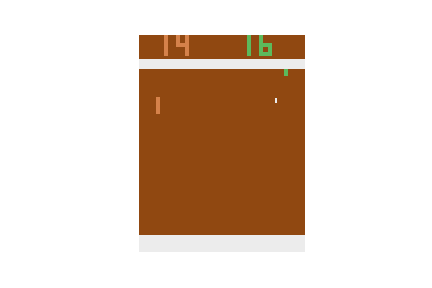
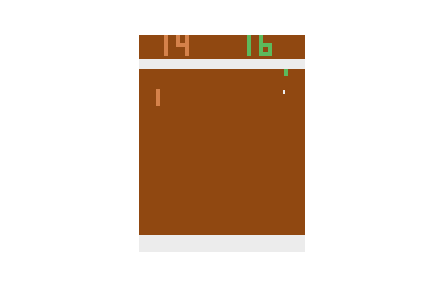
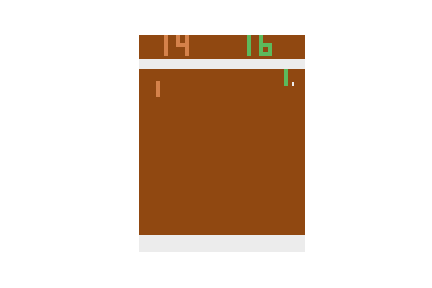
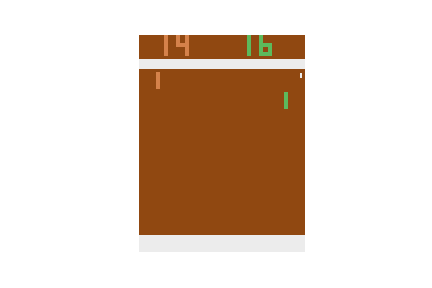
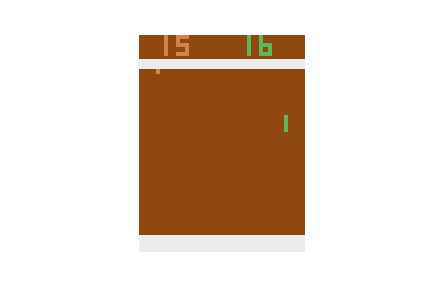
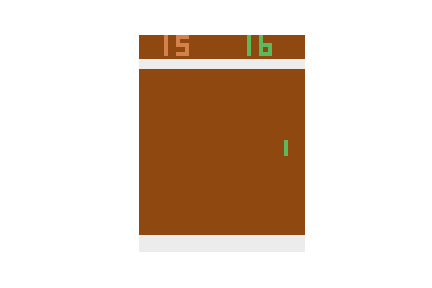
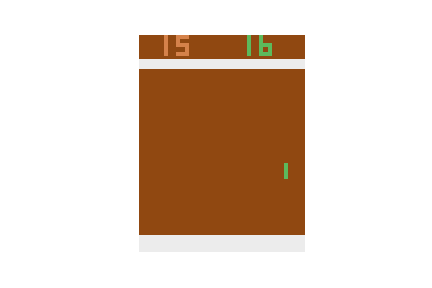
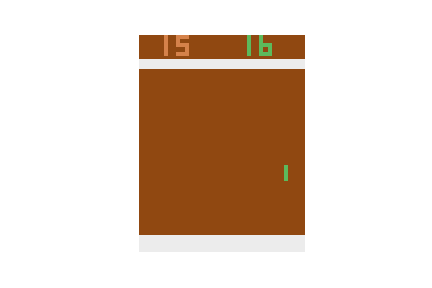
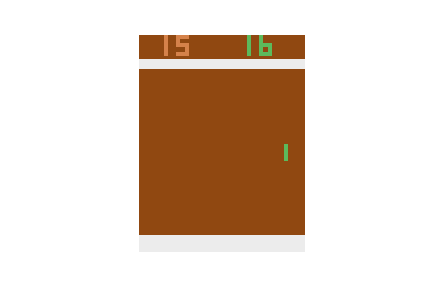
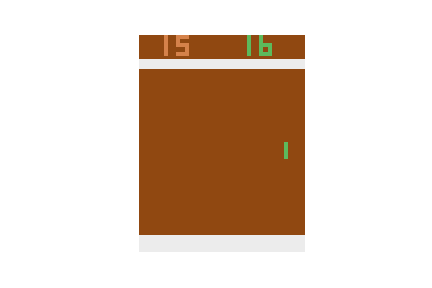
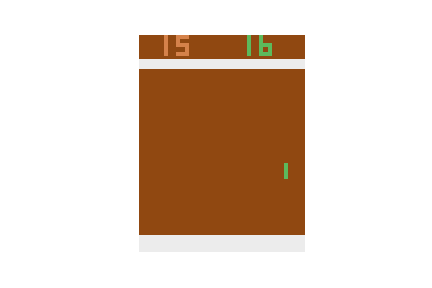
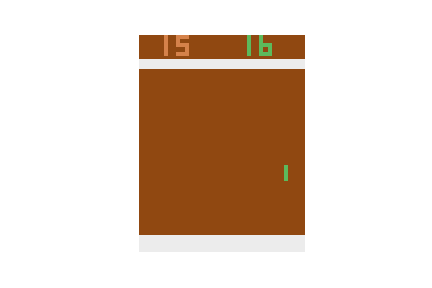
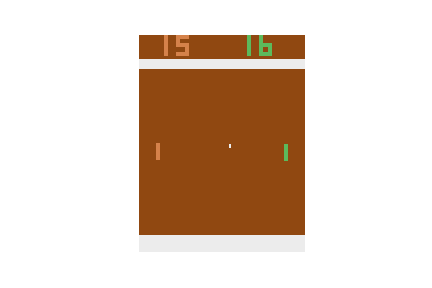
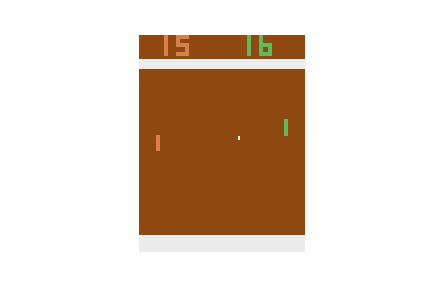
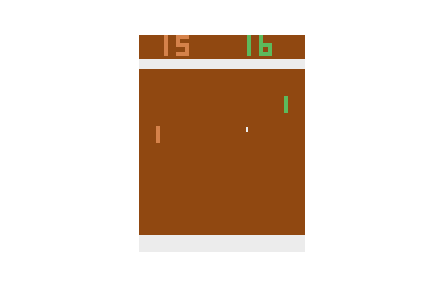
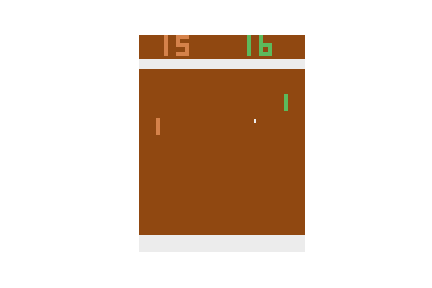
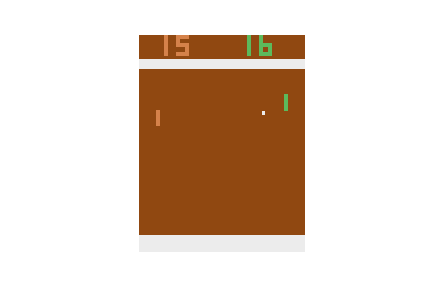
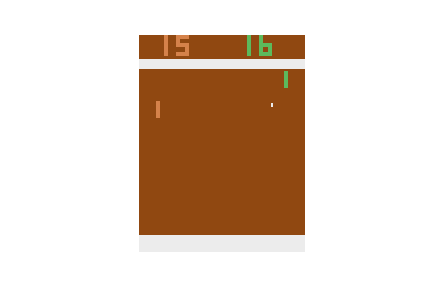
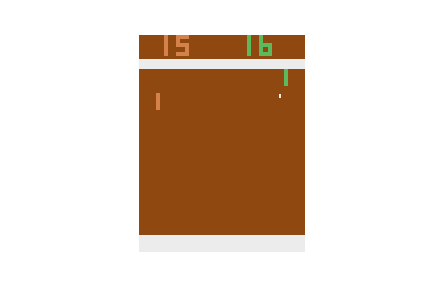
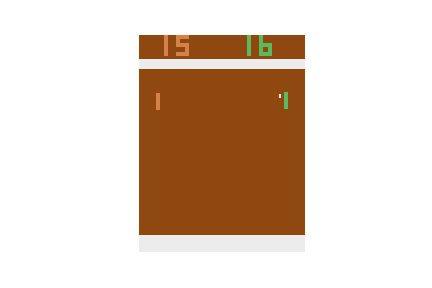
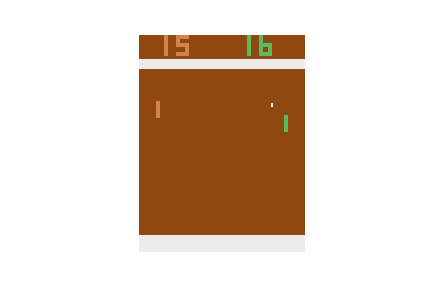
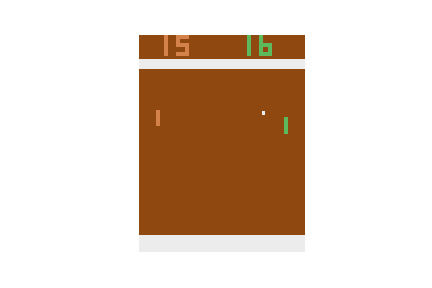
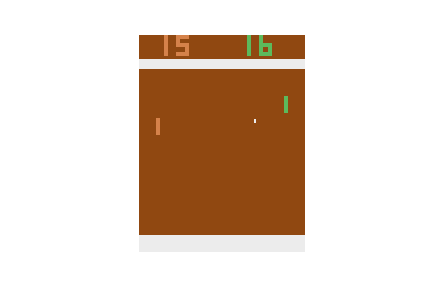
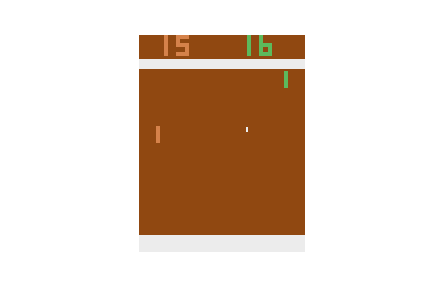
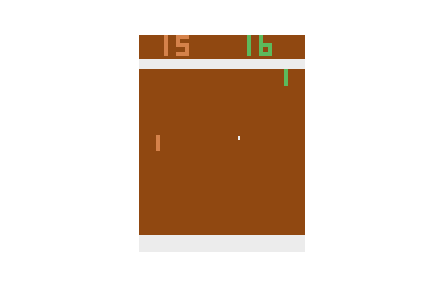
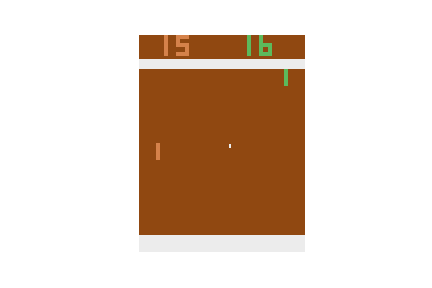
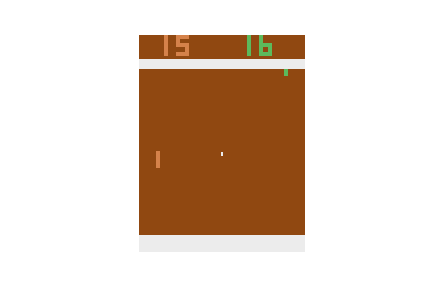
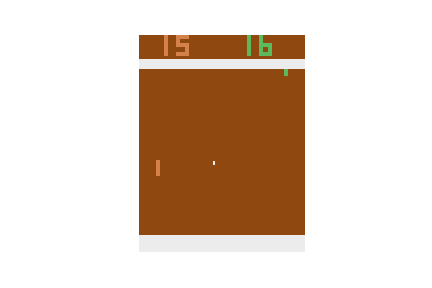
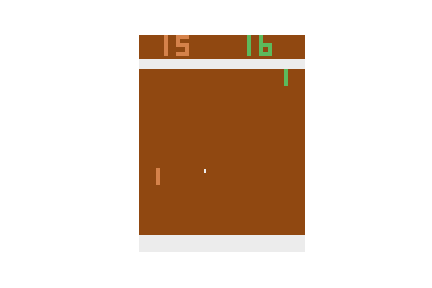
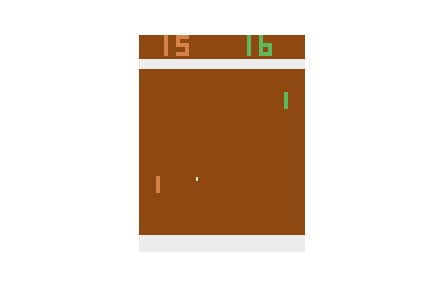
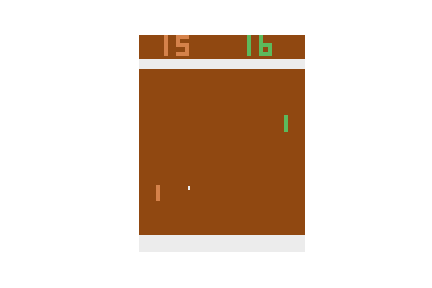
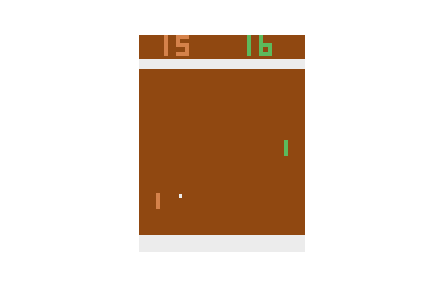
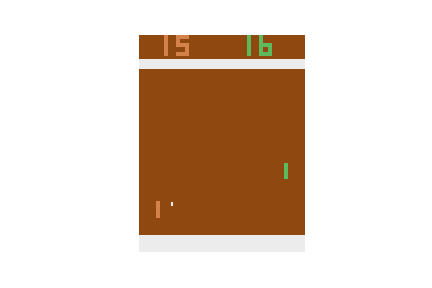
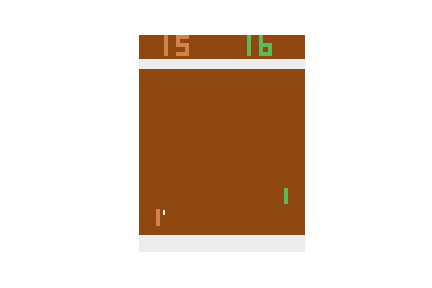
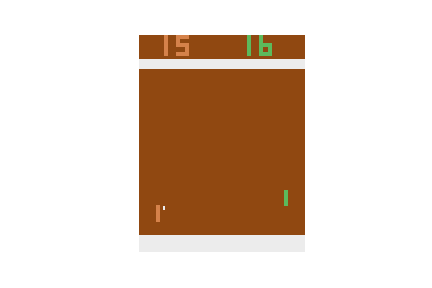
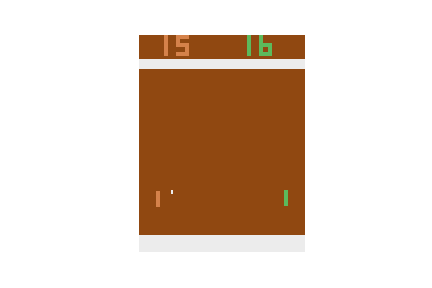
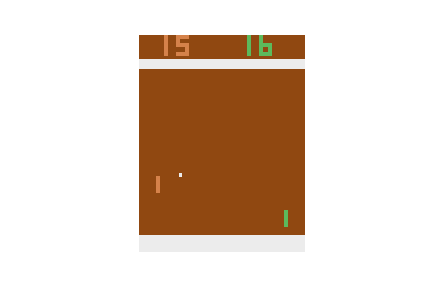
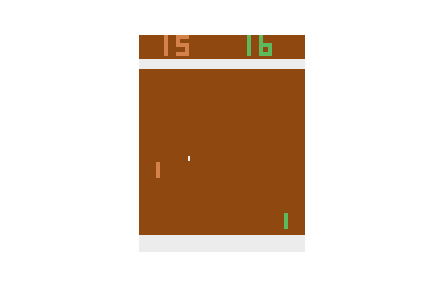
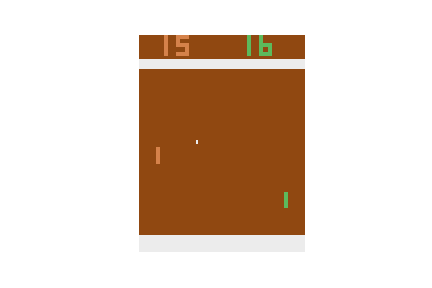
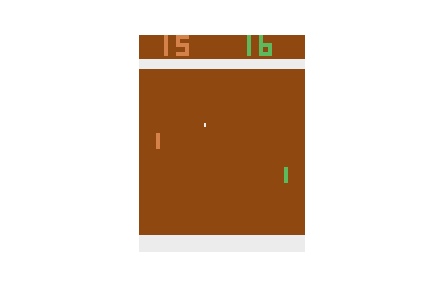
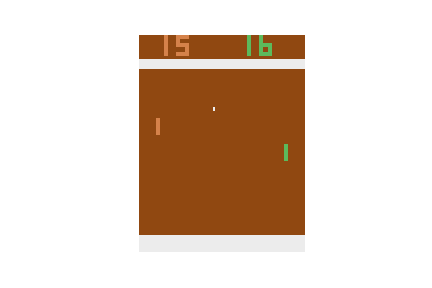
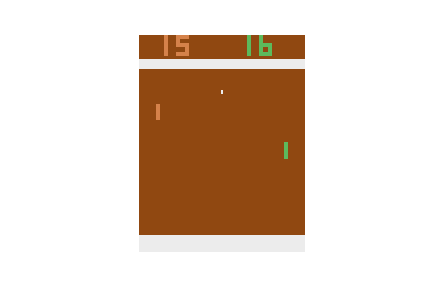
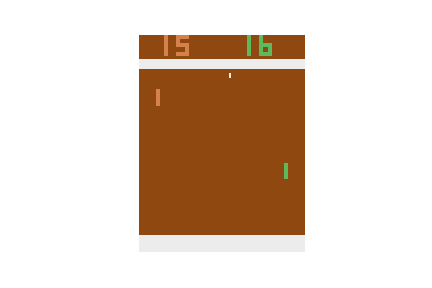
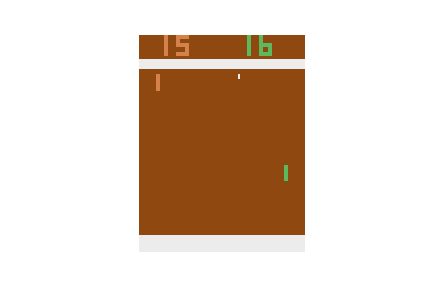
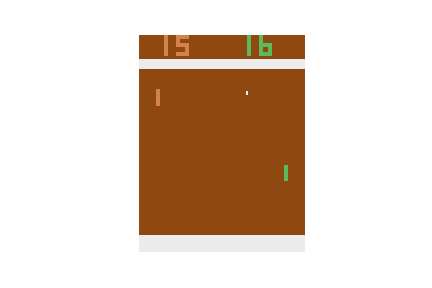
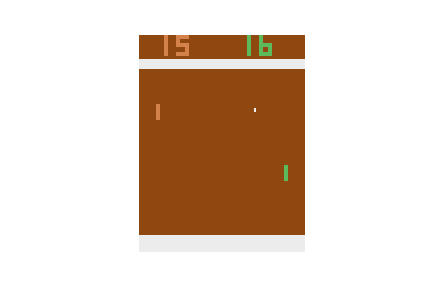
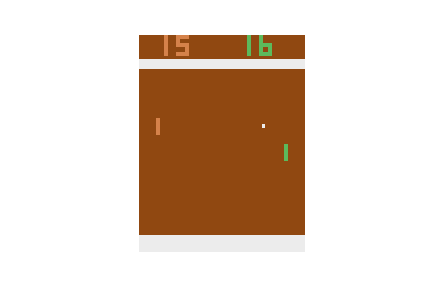
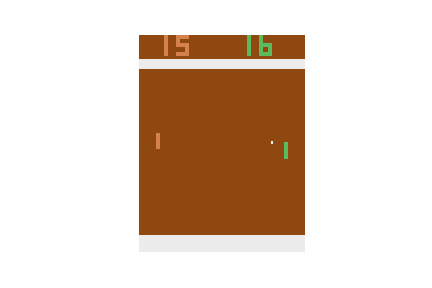
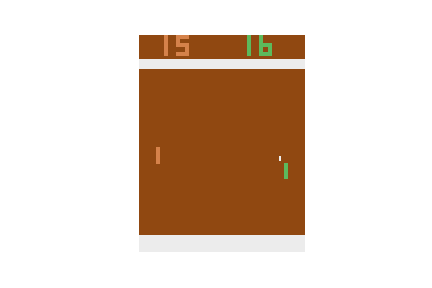
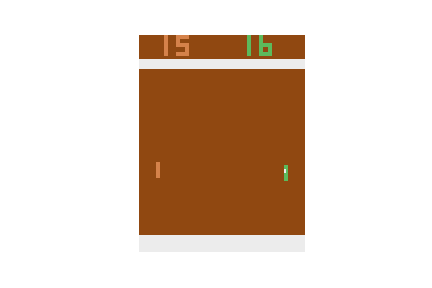
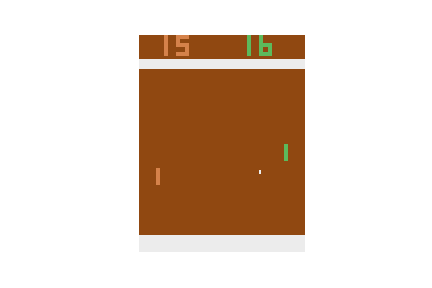
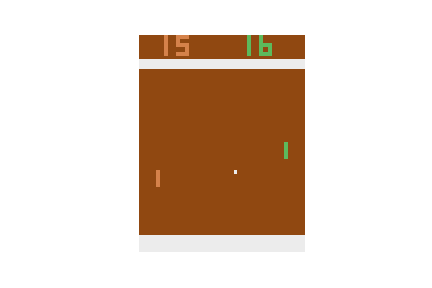
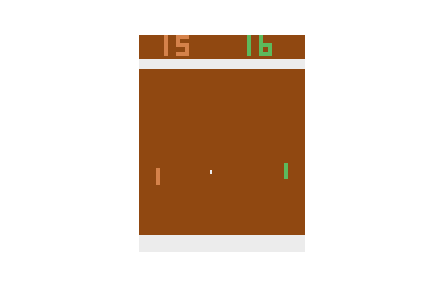
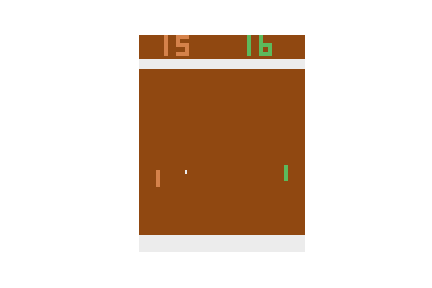
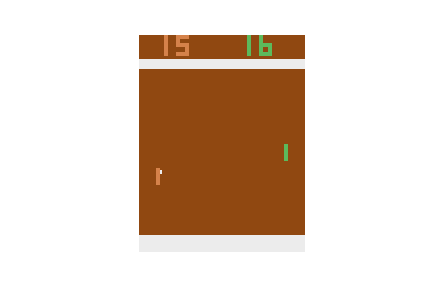
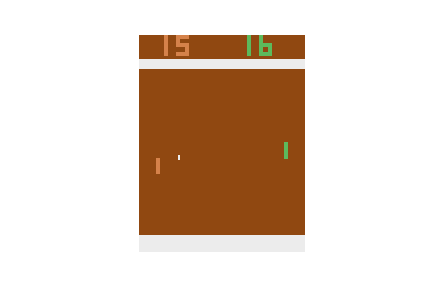
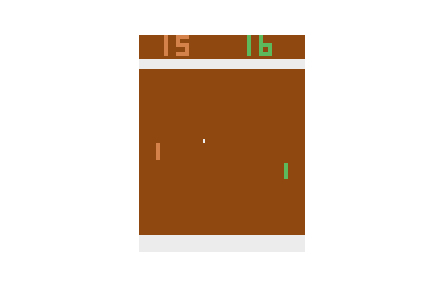
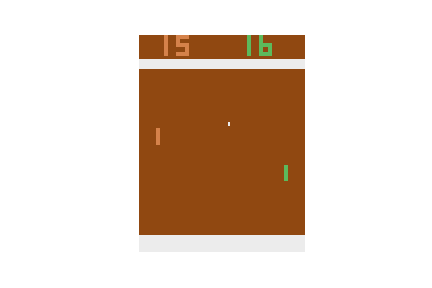
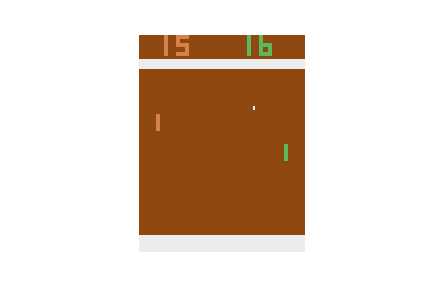
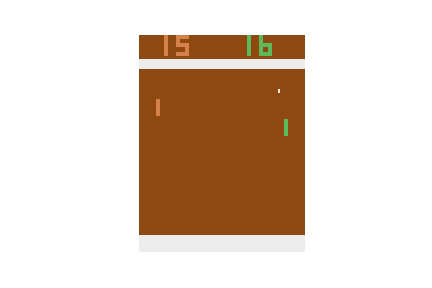
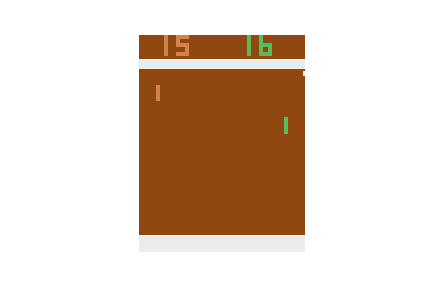
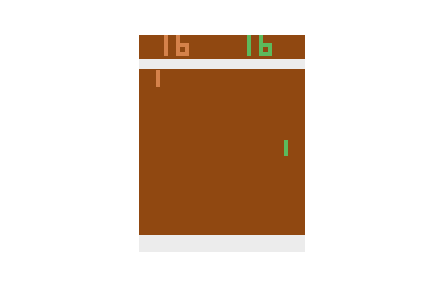
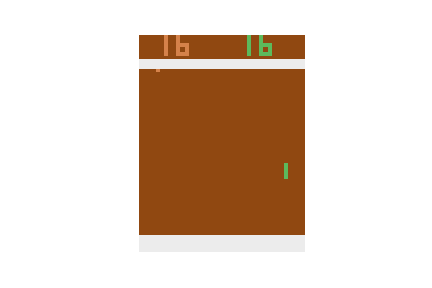
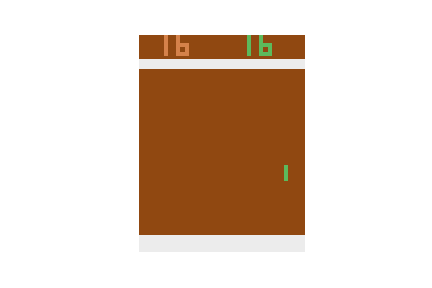
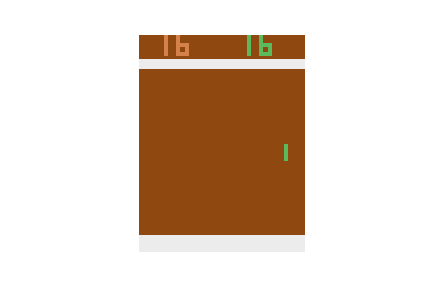
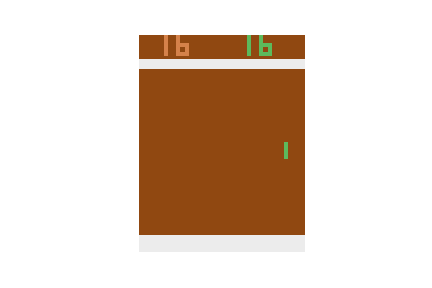
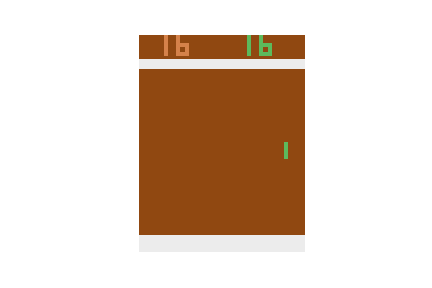
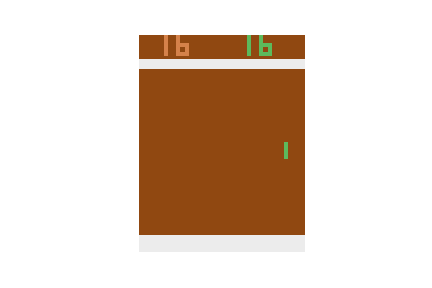
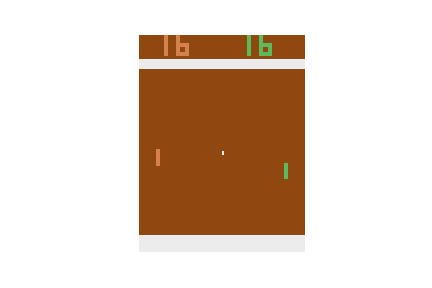
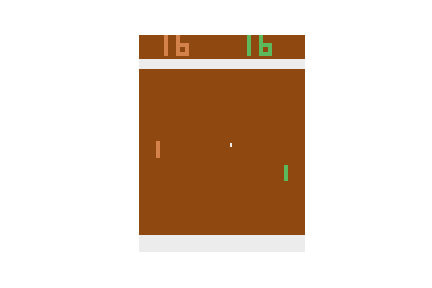
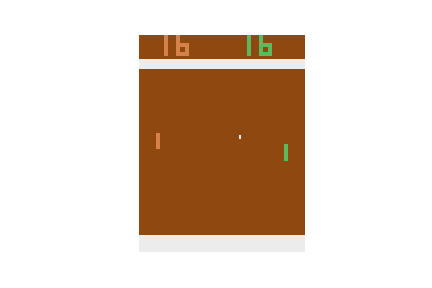
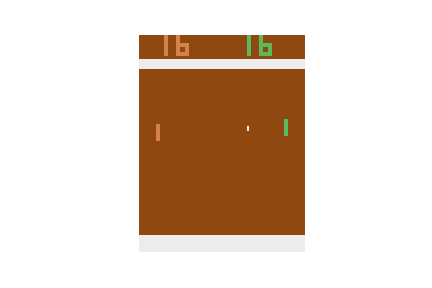
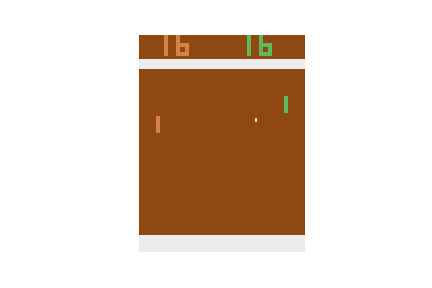
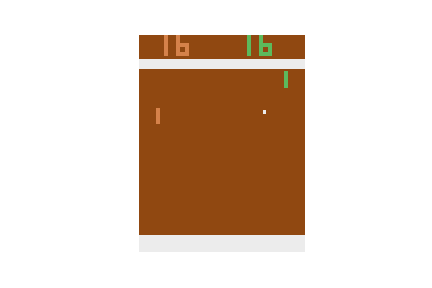
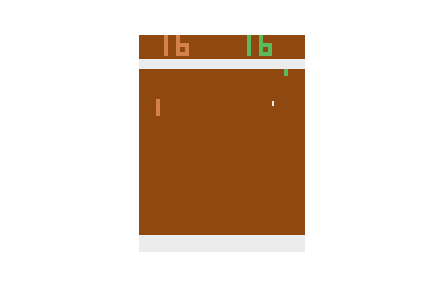
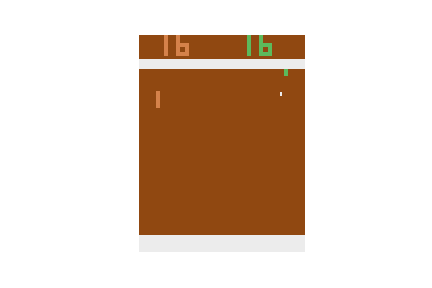
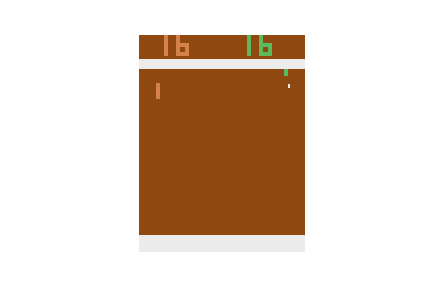
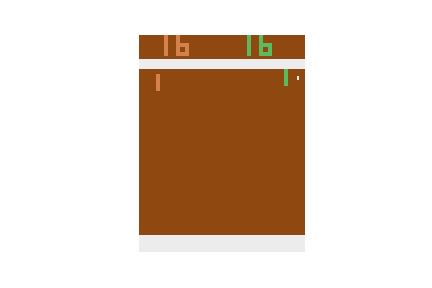
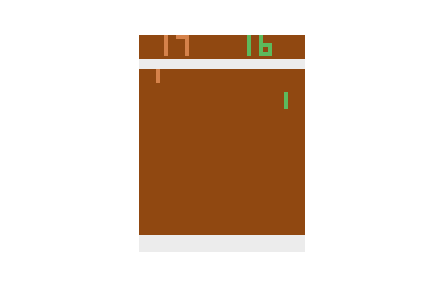
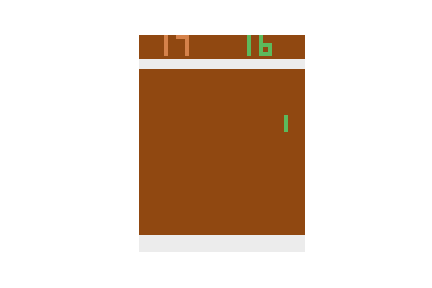
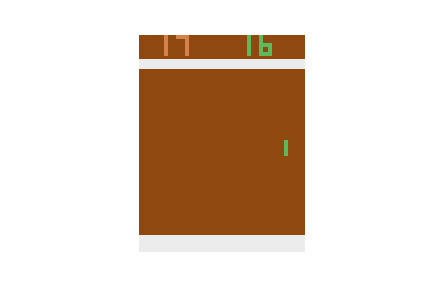
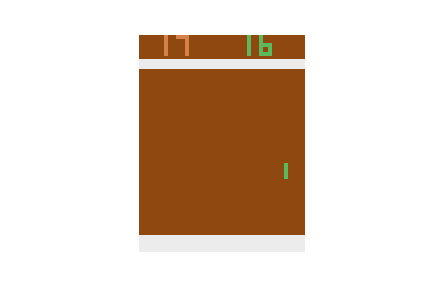
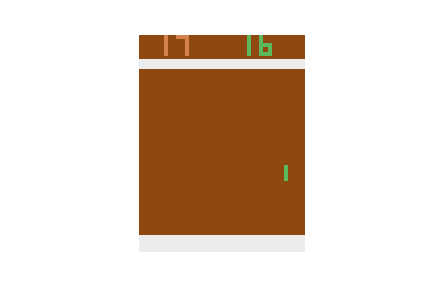
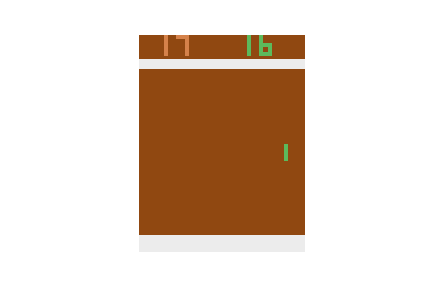
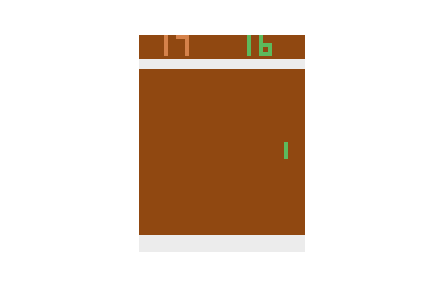
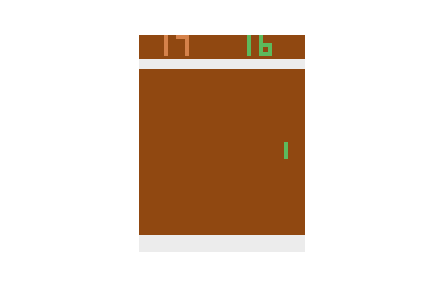
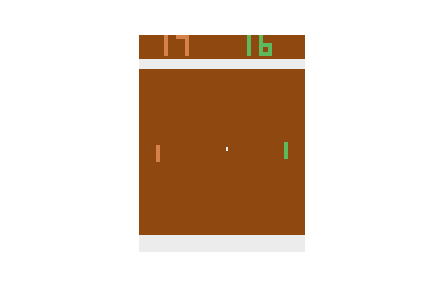
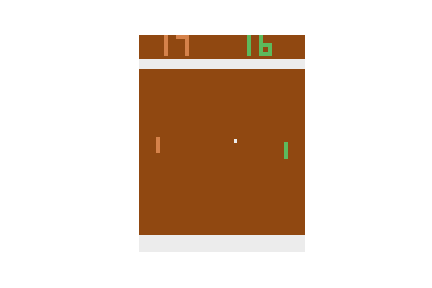
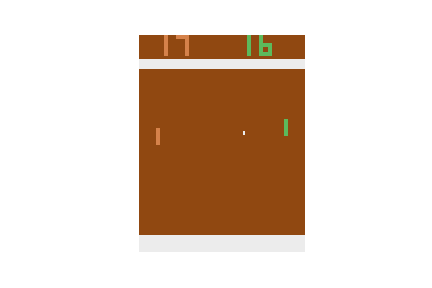
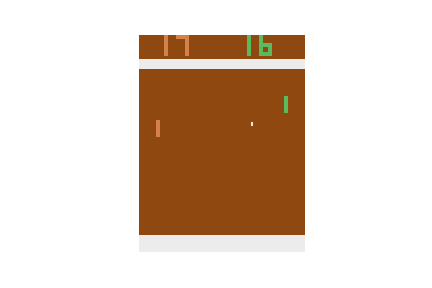
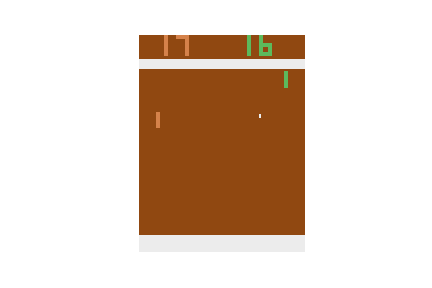
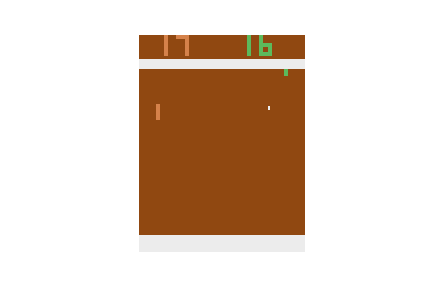
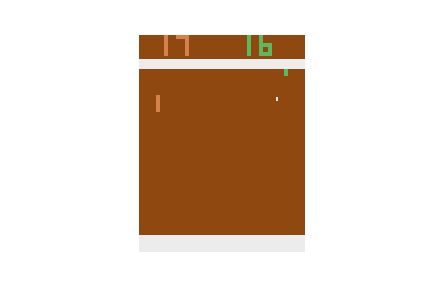
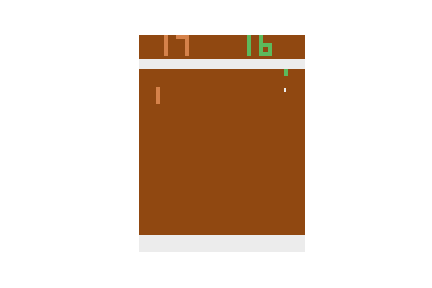
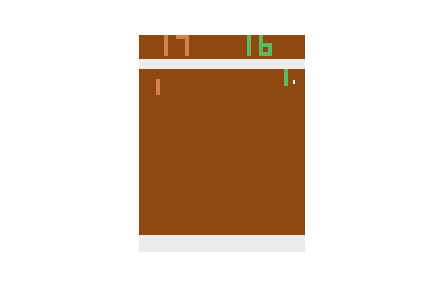
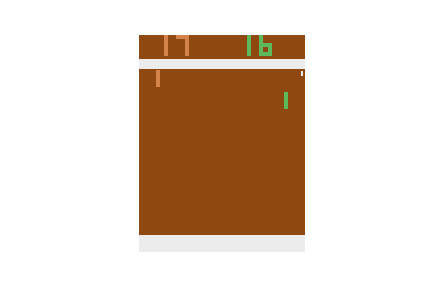
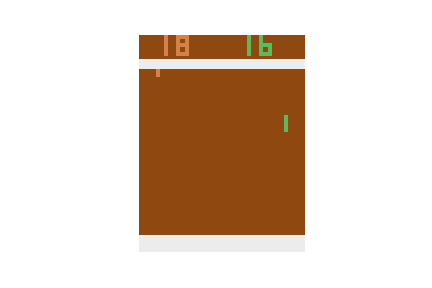
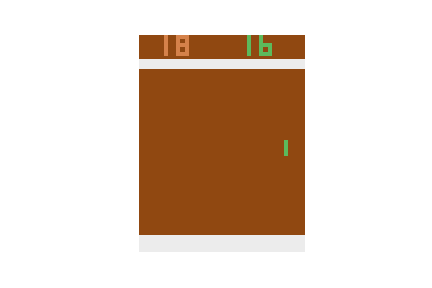
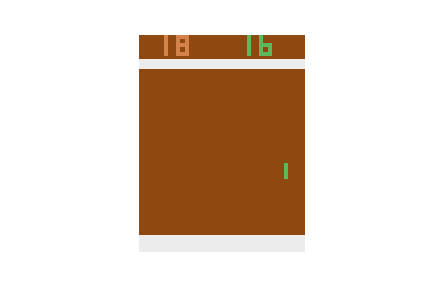
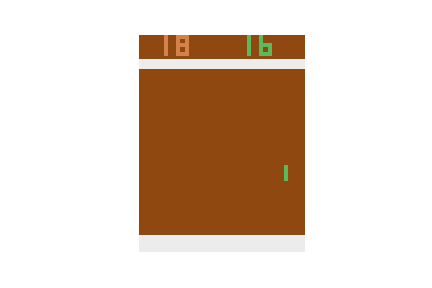
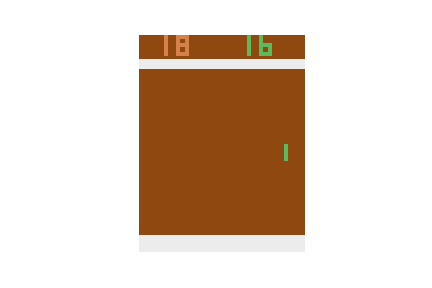
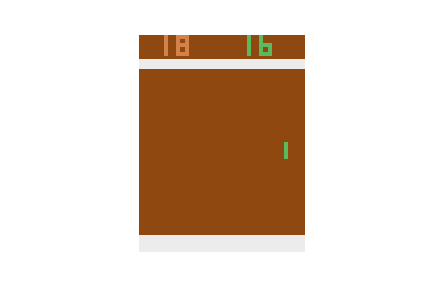
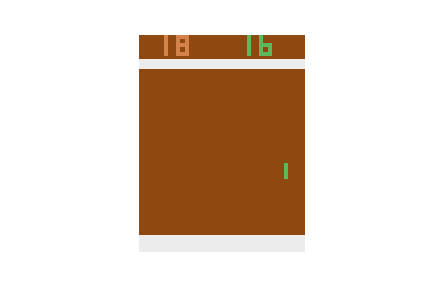
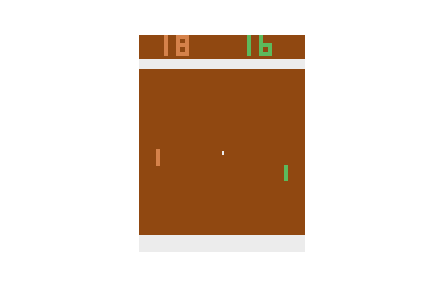
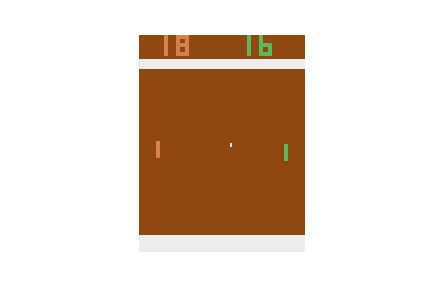
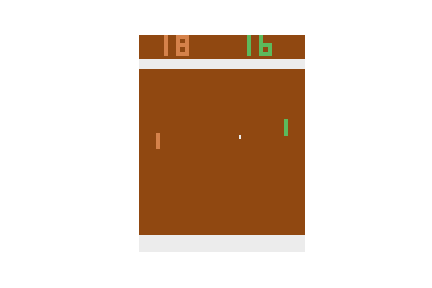
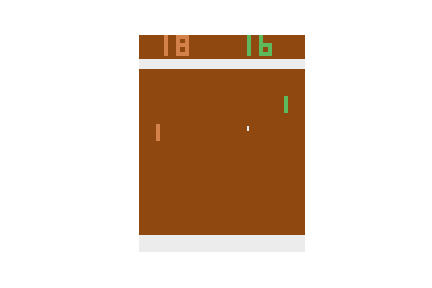
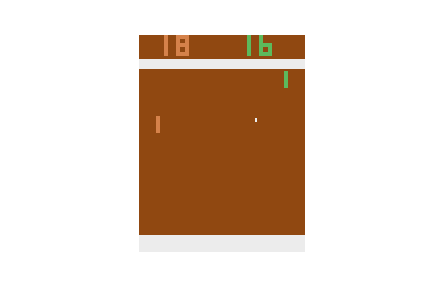
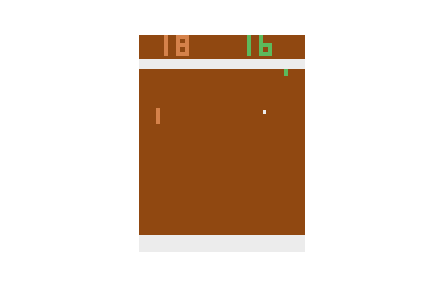
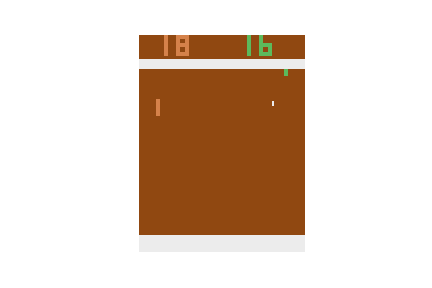
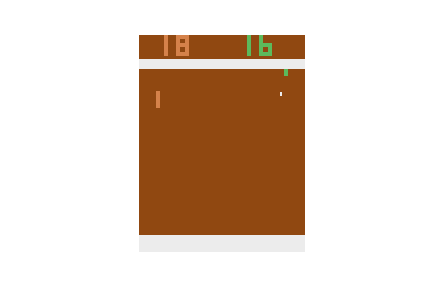
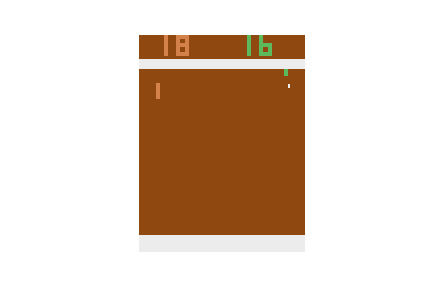
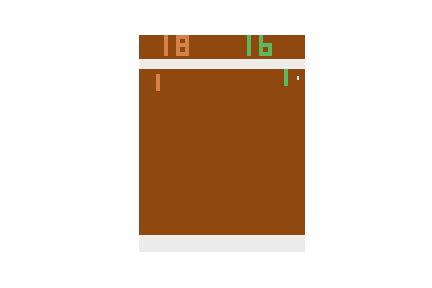
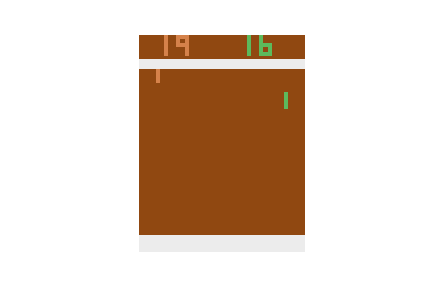
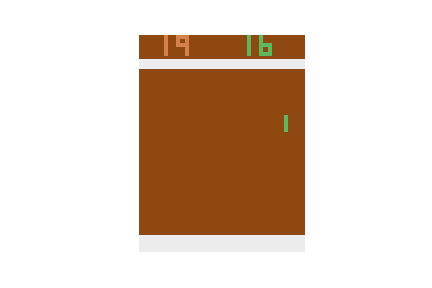
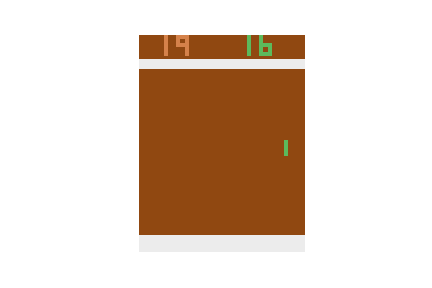
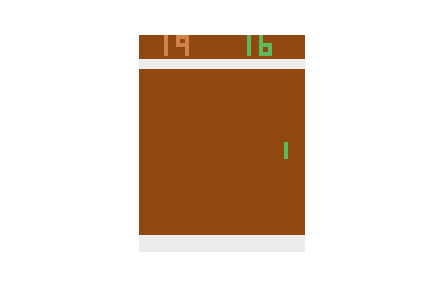
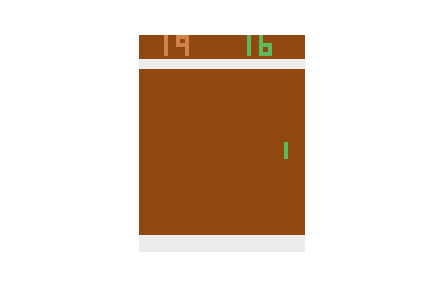
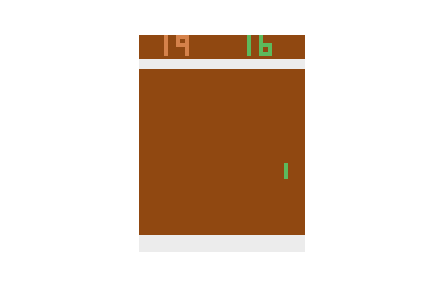
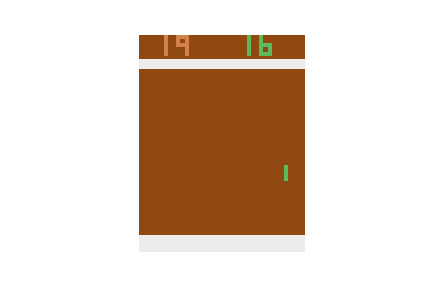
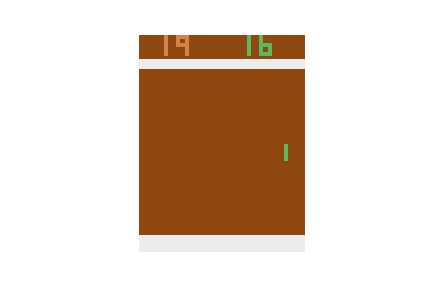
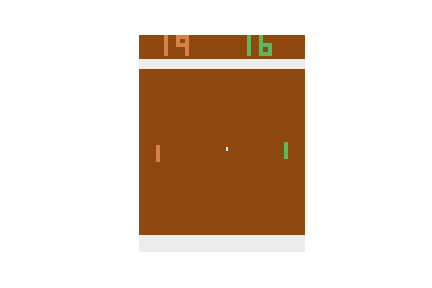
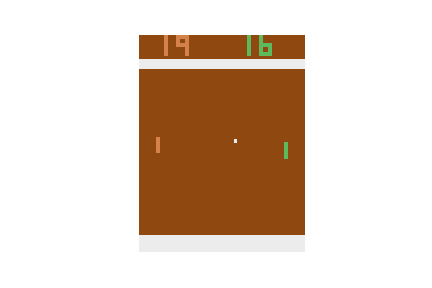
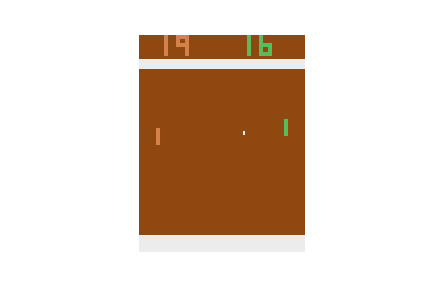
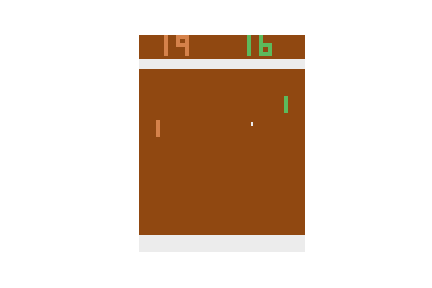
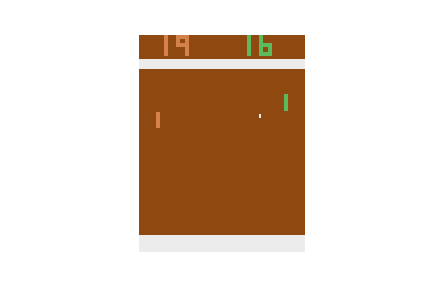
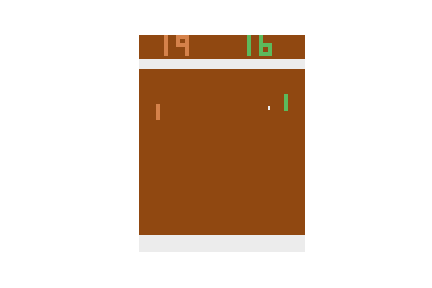
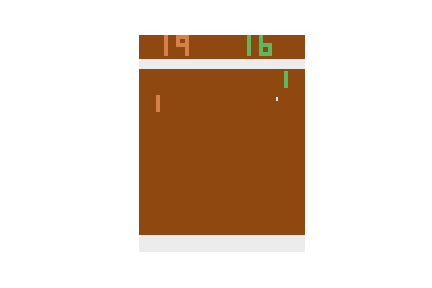
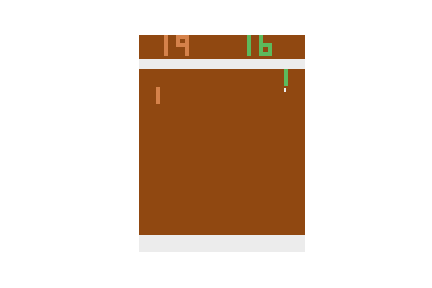
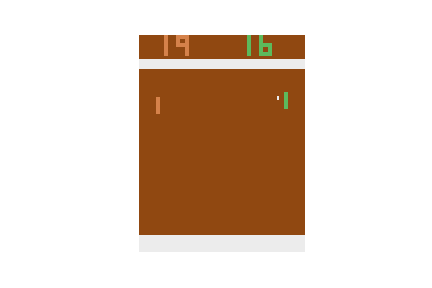
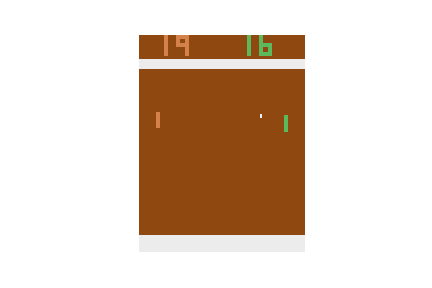
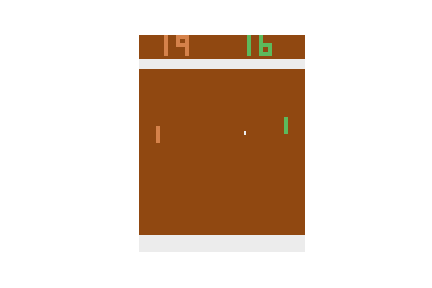
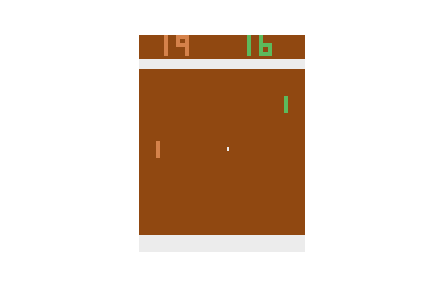
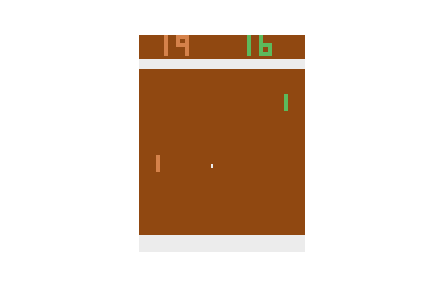
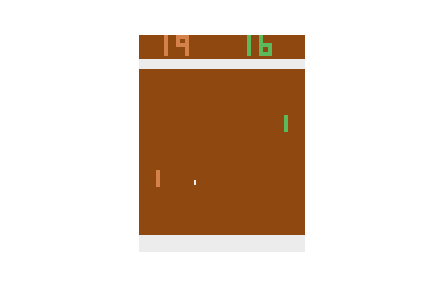
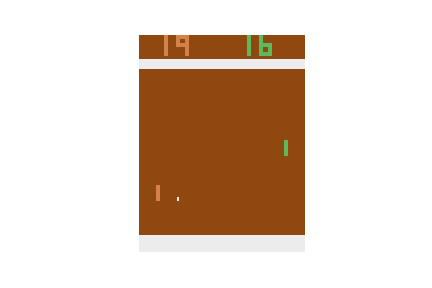
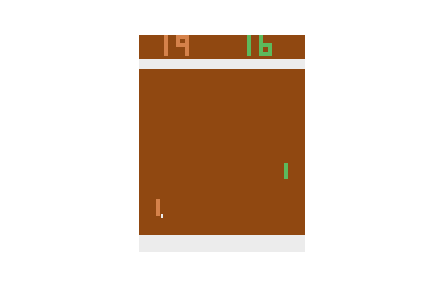
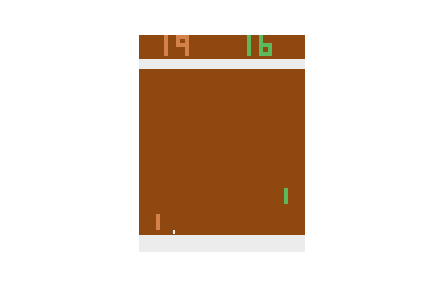
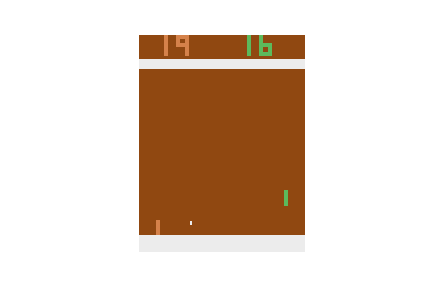
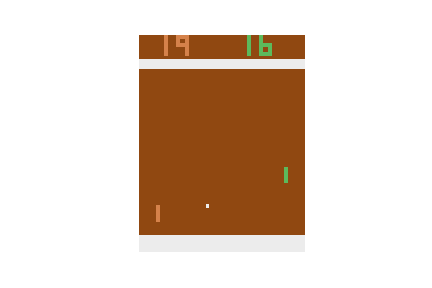
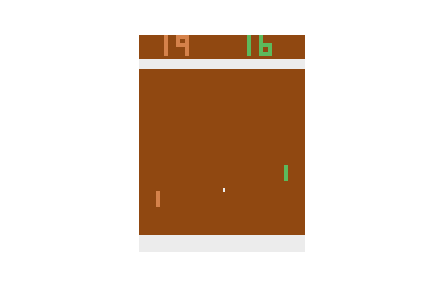
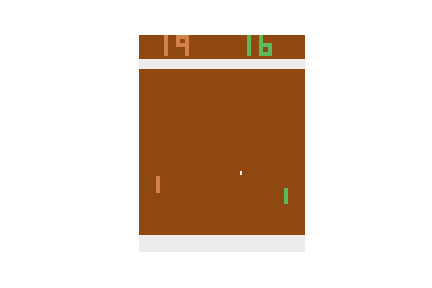
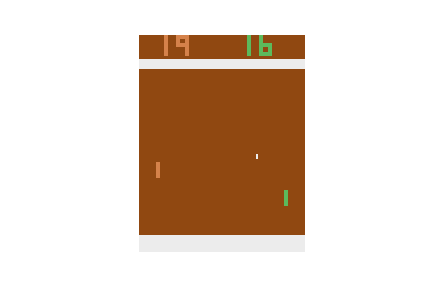
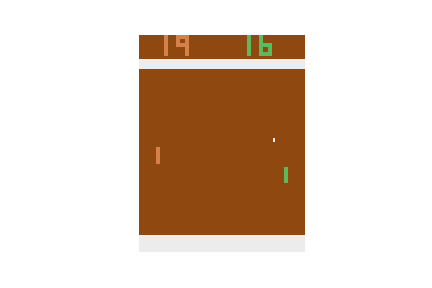
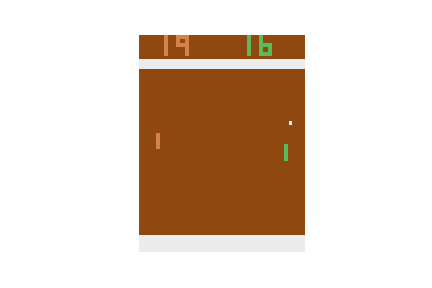
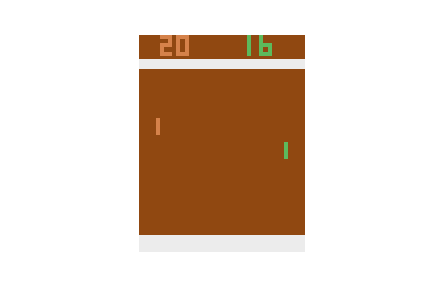
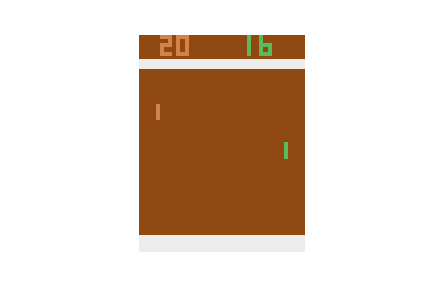
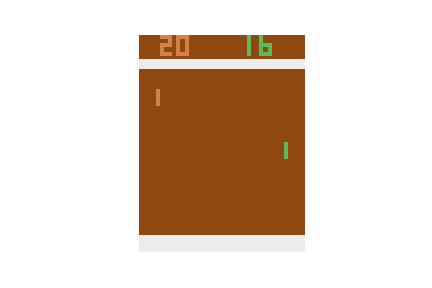
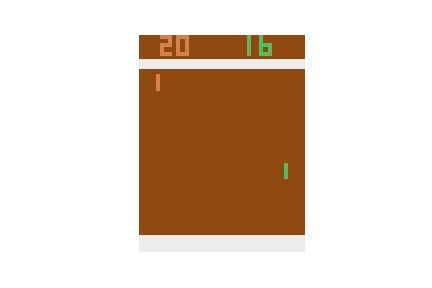
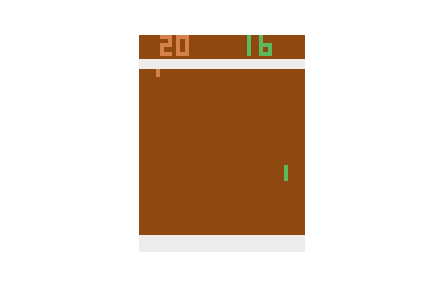
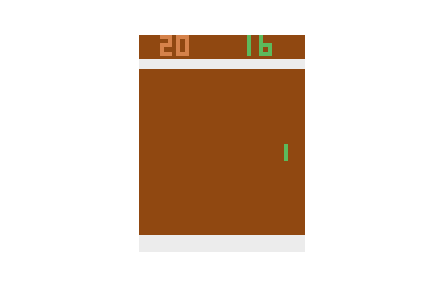
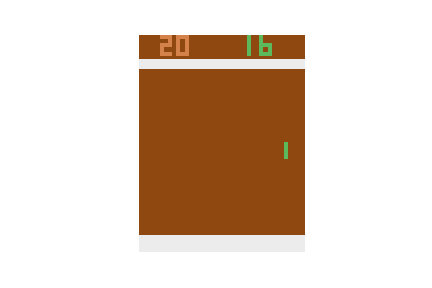
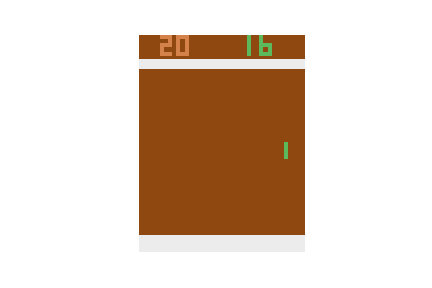
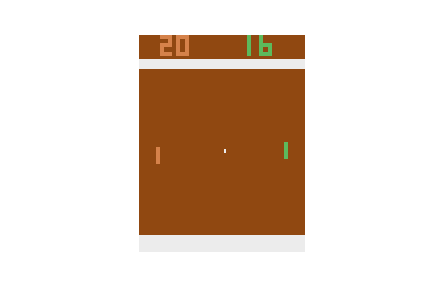
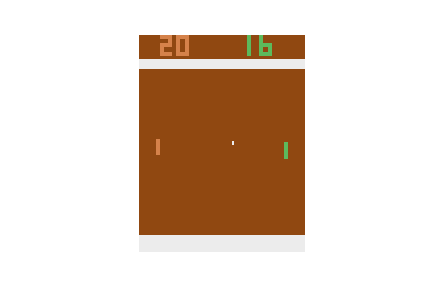
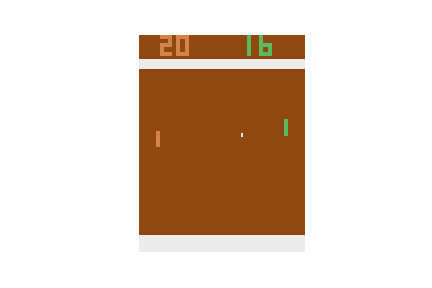
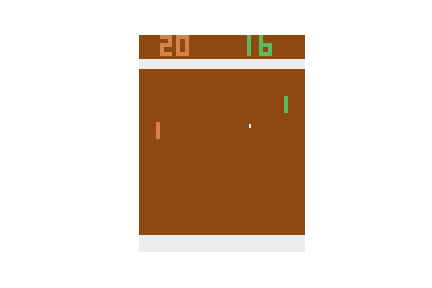
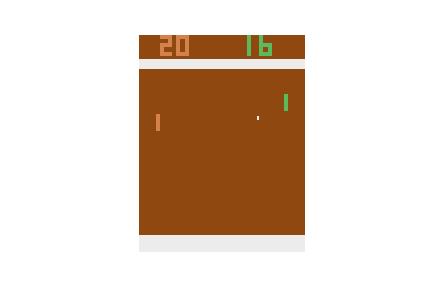
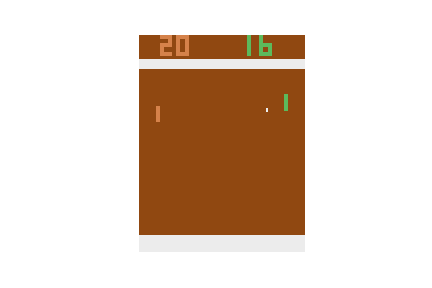
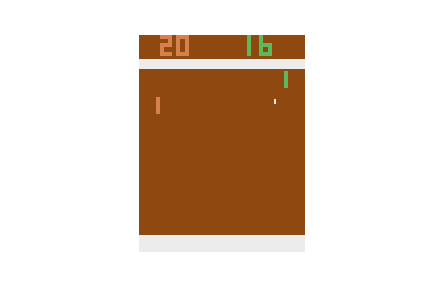
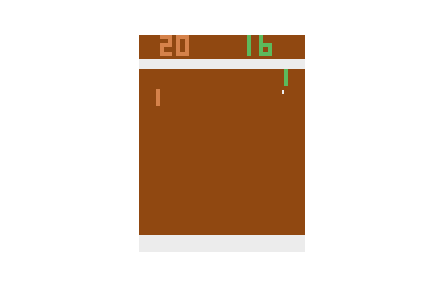
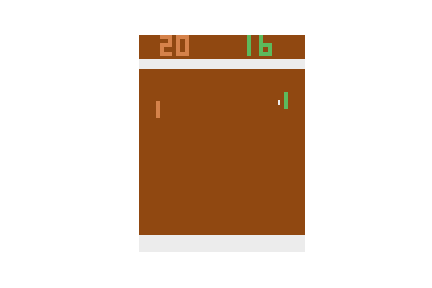
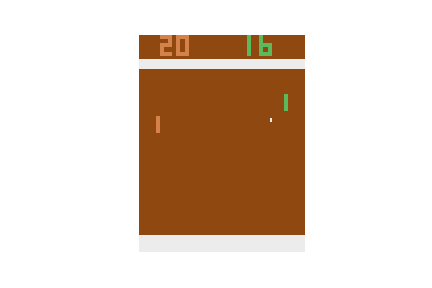
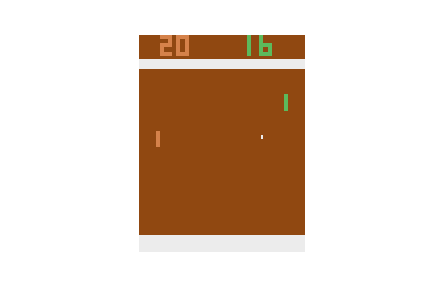
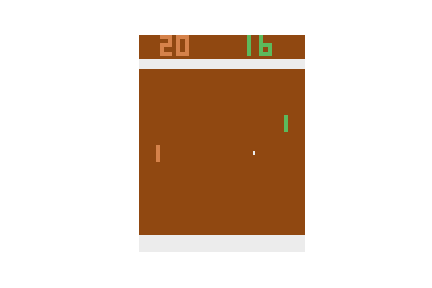
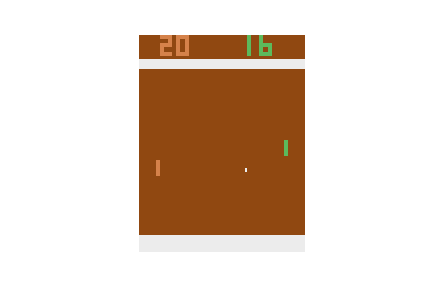
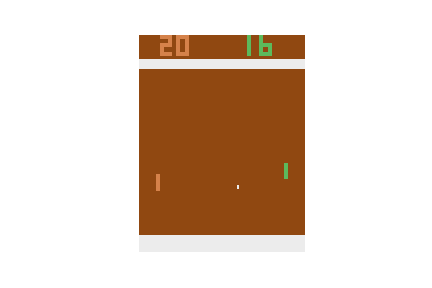
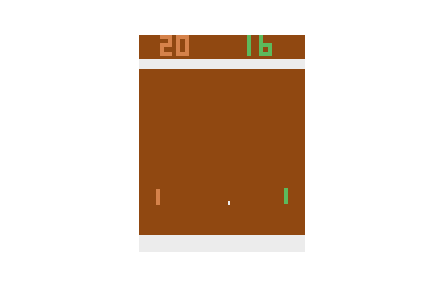
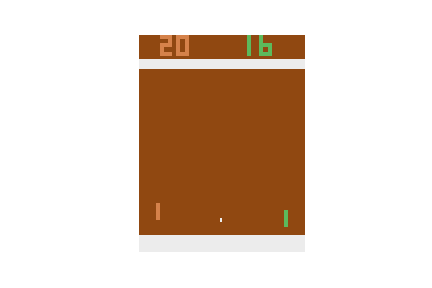
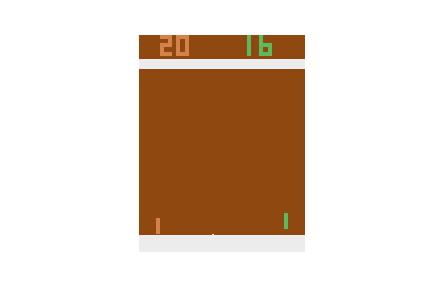
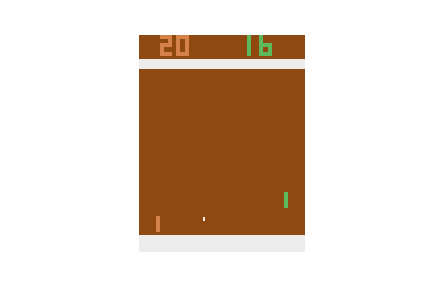
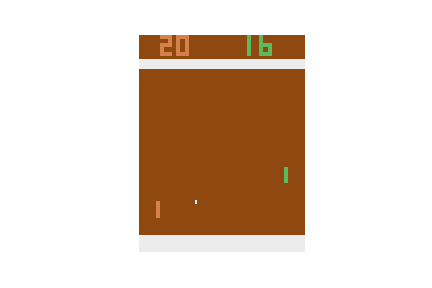
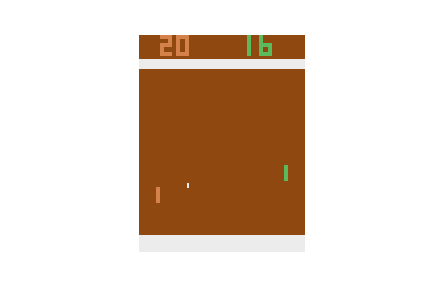
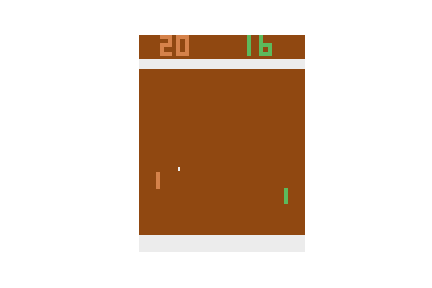
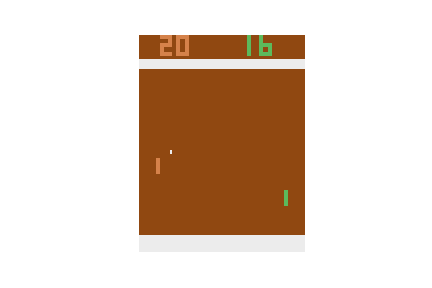
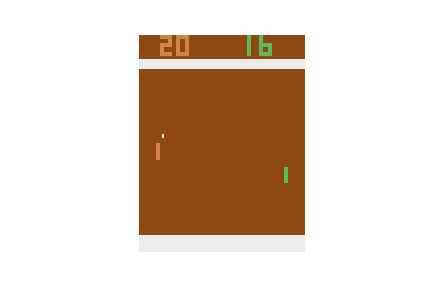
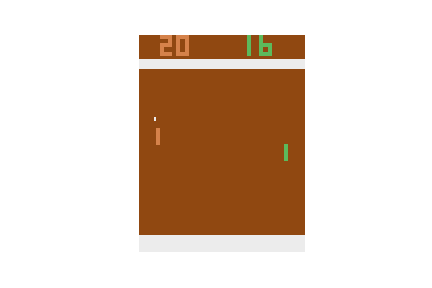
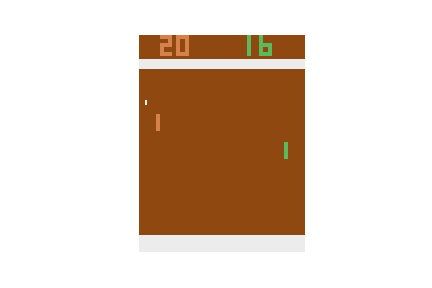
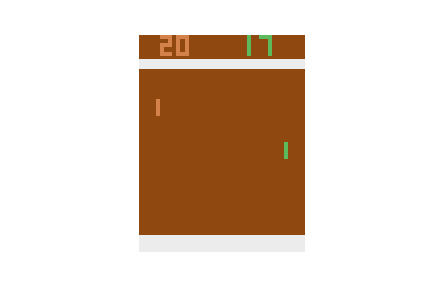
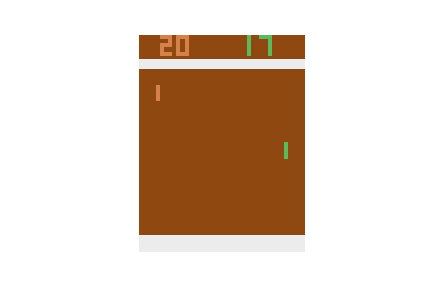
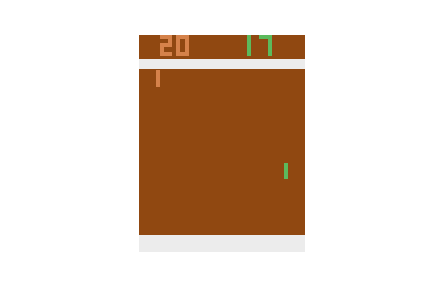
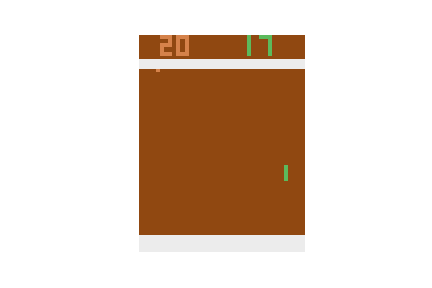
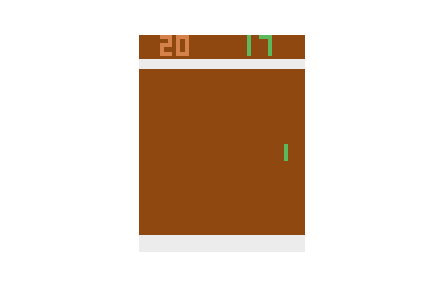
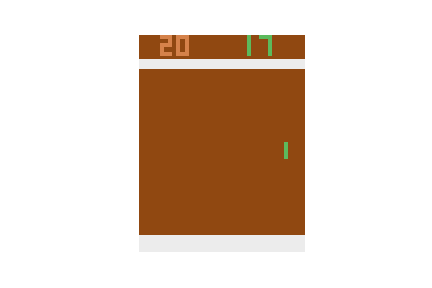
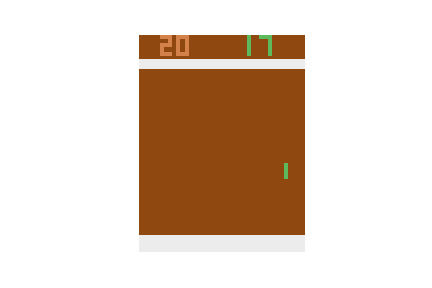
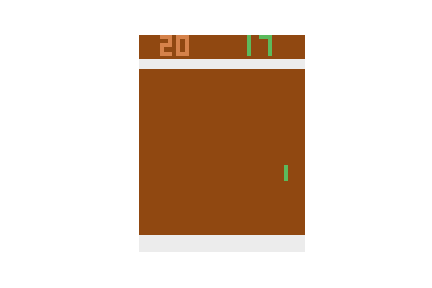
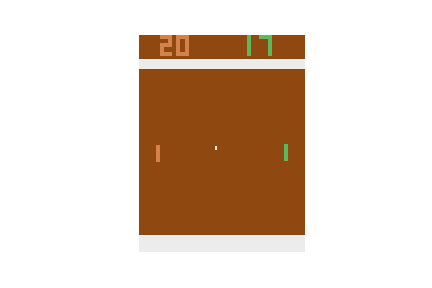
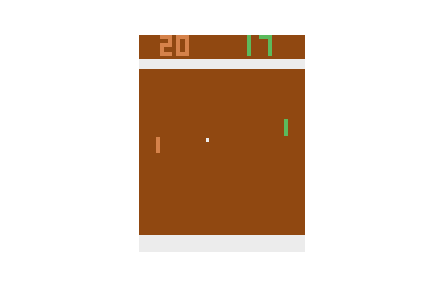
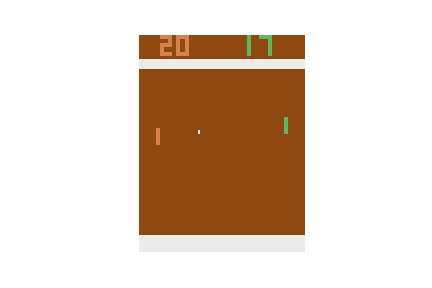
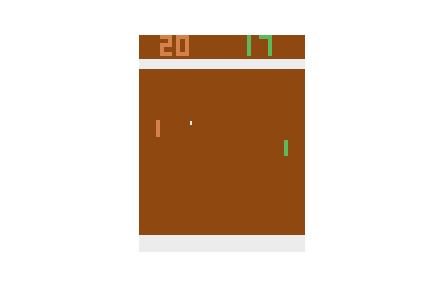
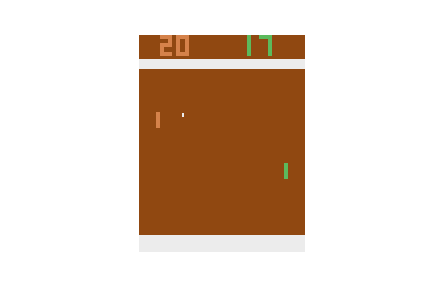
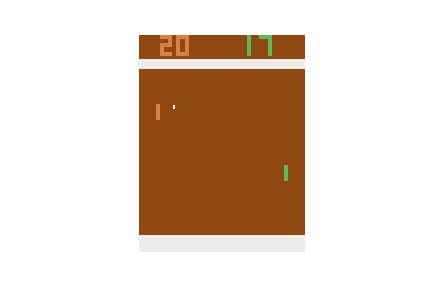
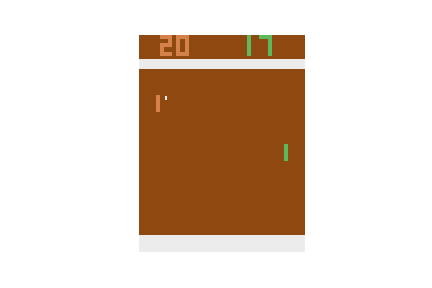
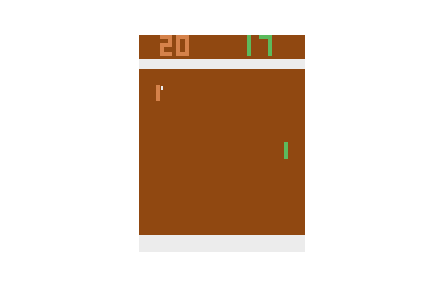
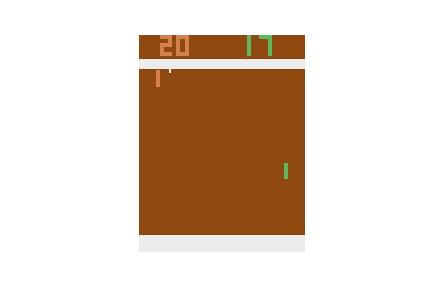
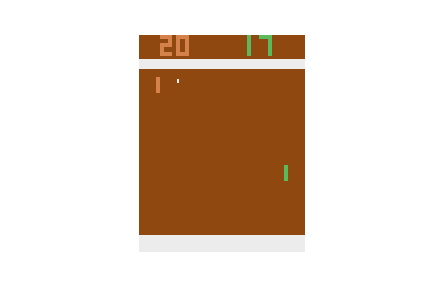
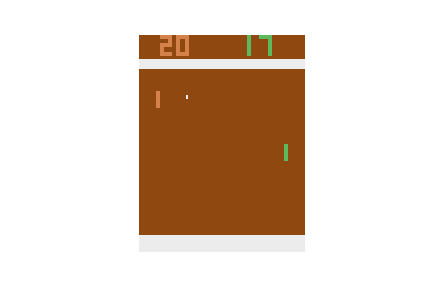
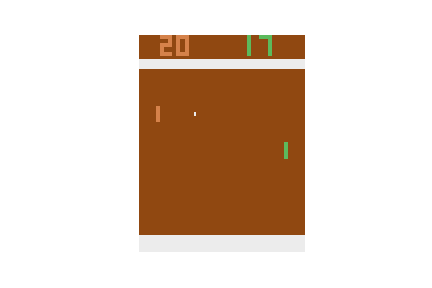
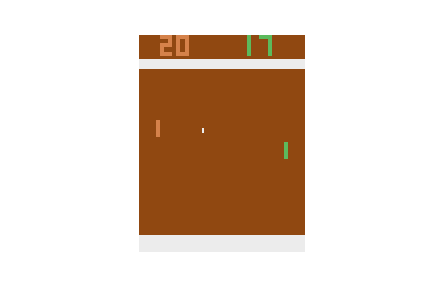
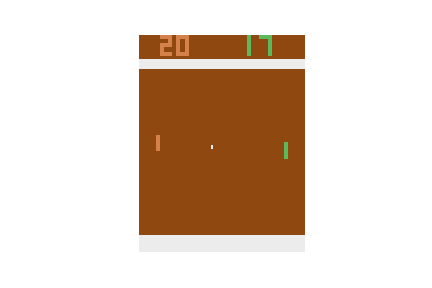
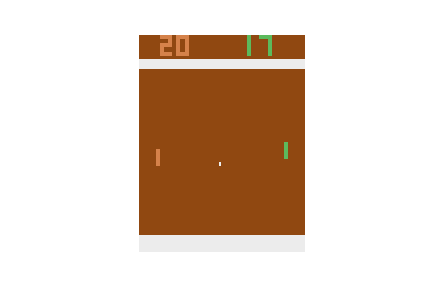
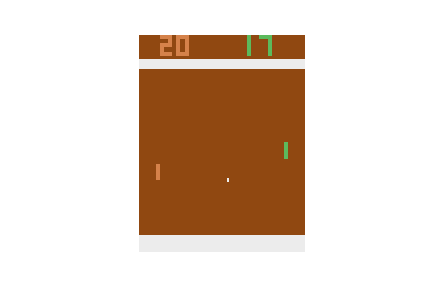
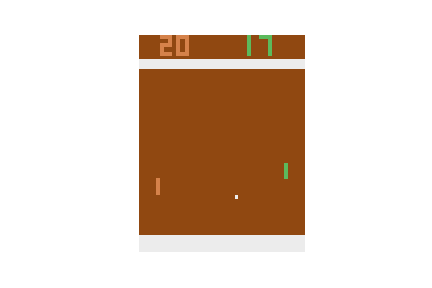
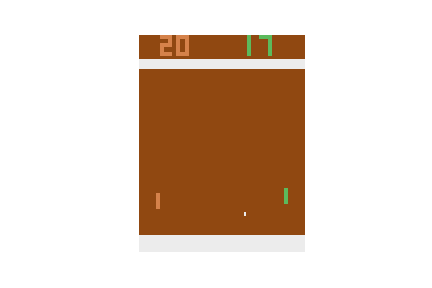
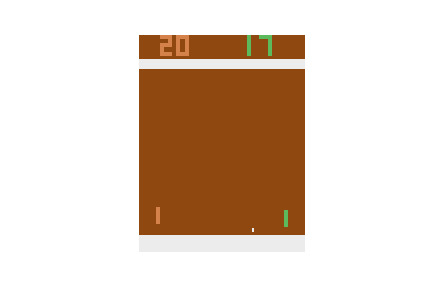
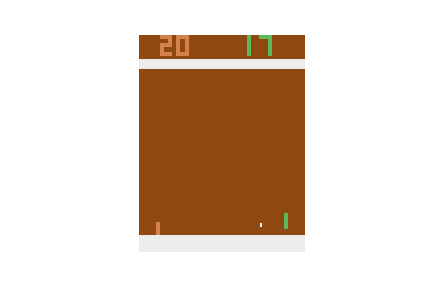
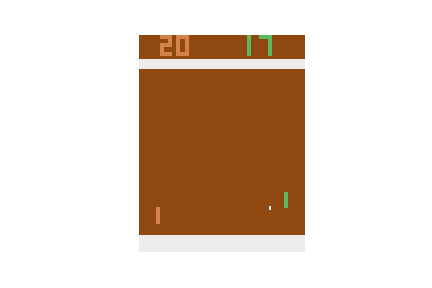
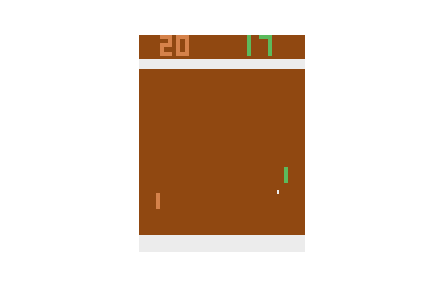
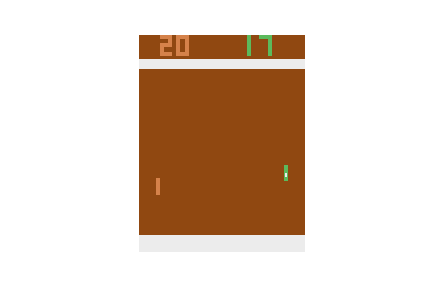
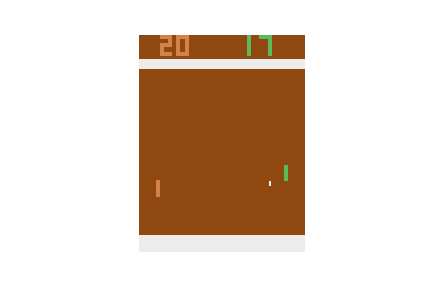
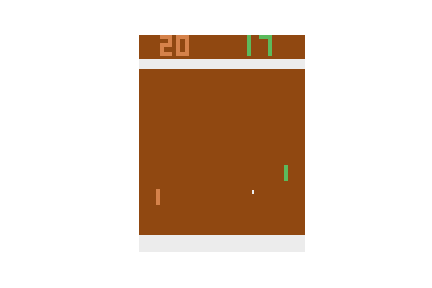
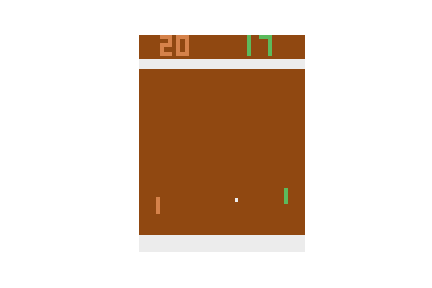
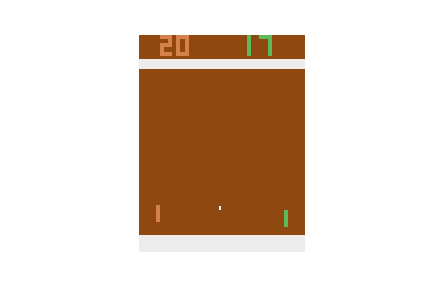
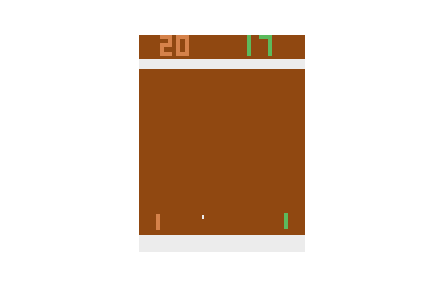
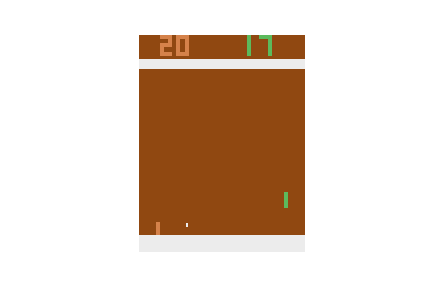
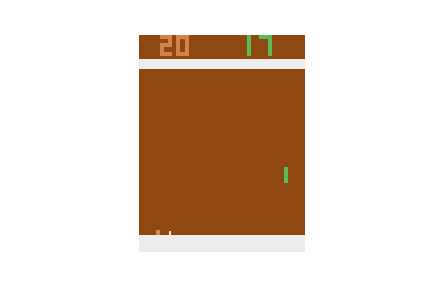
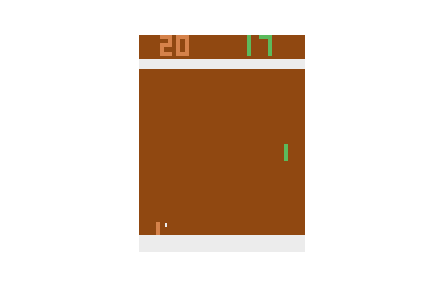
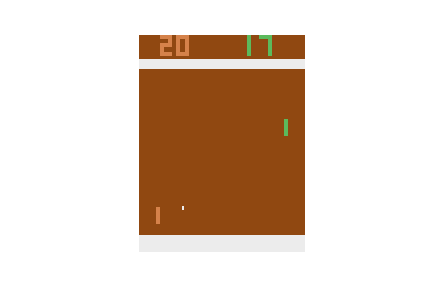
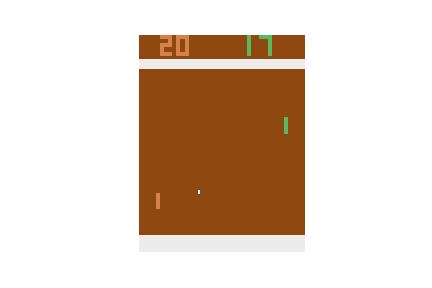
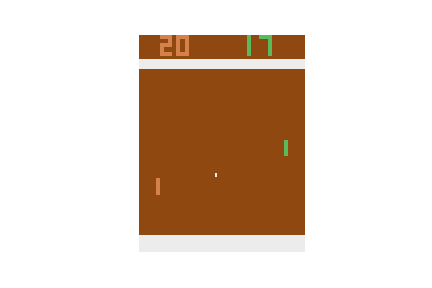
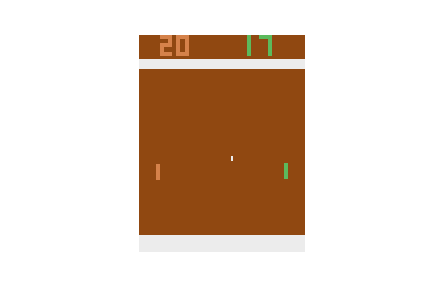
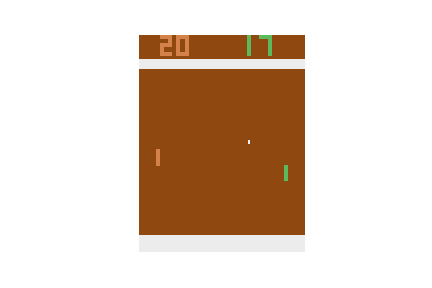
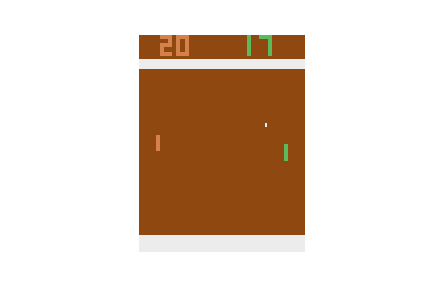
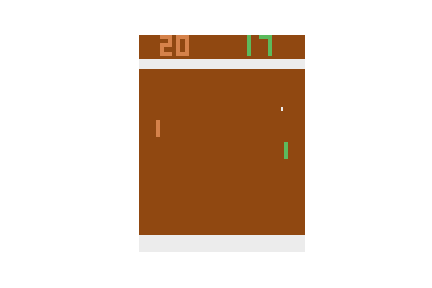
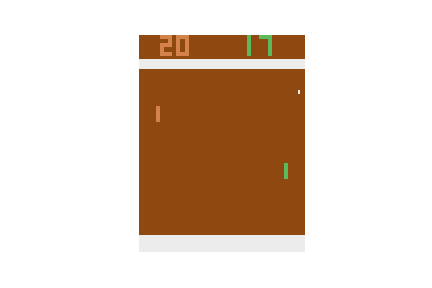

In [48]:
# save your policy!
torch.save(policy, 'PPO.policy3')

# load policy if needed
#policy = torch.load('PPO.policy2')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
policy_solution = torch.load('PPO_solution.policy')
pong_utils.play(env, policy_solution, time=2000) 